In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
training_data = data.query('swing == 1')

In [5]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')


# Fastball Model First

In [11]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo',  'swing', 'line_drive'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo', 'swing', 'line_drive'
], axis=1)   # Exclude the identifier from the features

In [12]:
train_data = training_features.drop(['foul'], axis=1).copy()
train_label = training_features['foul'].copy()
testing_data = testing_features.drop(['foul'], axis=1).copy()
testing_label = testing_features['foul'].copy()

In [13]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [14]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [15]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [16]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [17]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5696610387936589
Log Loss: 0.6726039822606849


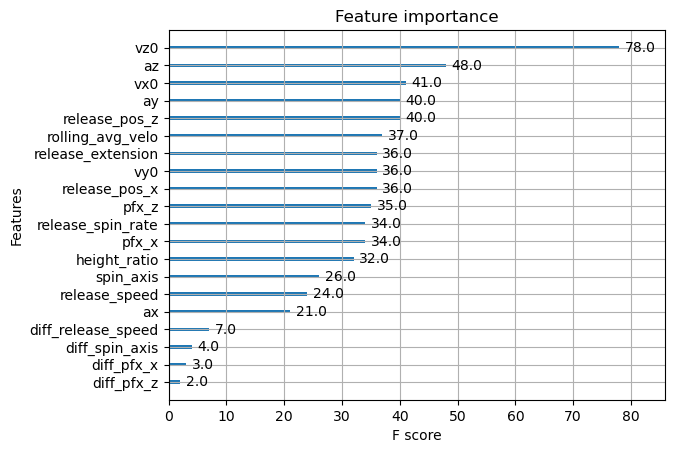

In [18]:
xgb.plot_importance(model)
plt.show()

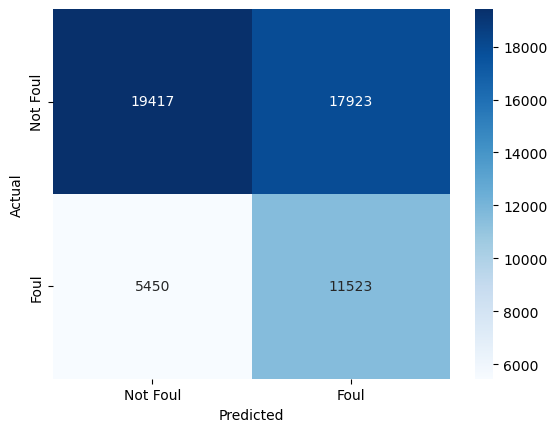

In [19]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 16:35:20,896] A new study created in memory with name: no-name-813a0f79-982a-417b-94a7-2a1aabcc6448


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68909
[3]	eval-logloss:0.68785
[4]	eval-logloss:0.68673
[5]	eval-logloss:0.68579
[6]	eval-logloss:0.68485
[7]	eval-logloss:0.68441
[8]	eval-logloss:0.68347
[9]	eval-logloss:0.68251
[10]	eval-logloss:0.68167
[11]	eval-logloss:0.68139
[12]	eval-logloss:0.68067
[13]	eval-logloss:0.67998
[14]	eval-logloss:0.67928
[15]	eval-logloss:0.67875
[16]	eval-logloss:0.67818
[17]	eval-logloss:0.67767
[18]	eval-logloss:0.67708
[19]	eval-logloss:0.67660
[20]	eval-logloss:0.67608
[21]	eval-logloss:0.67563
[22]	eval-logloss:0.67516
[23]	eval-logloss:0.67475
[24]	eval-logloss:0.67435
[25]	eval-logloss:0.67414
[26]	eval-logloss:0.67407
[27]	eval-logloss:0.67393
[28]	eval-logloss:0.67360
[29]	eval-logloss:0.67328
[30]	eval-logloss:0.67302
[31]	eval-logloss:0.67291
[32]	eval-logloss:0.67263
[33]	eval-logloss:0.67228
[34]	eval-logloss:0.67204
[35]	eval-logloss:0.67186
[36]	eval-logloss:0.67160
[37]	eval-logloss:0.67132
[38]	eval-logloss:0.67

[I 2023-11-14 16:35:24,205] Trial 0 finished with value: 0.6654020650039209 and parameters: {'max_depth': 7, 'eta': 0.03822995995531233, 'subsample': 0.8417907277941377, 'colsample_bytree': 0.7368662443329661}. Best is trial 0 with value: 0.6654020650039209.


[0]	eval-logloss:0.68712
[1]	eval-logloss:0.68235
[2]	eval-logloss:0.67843
[3]	eval-logloss:0.67588
[4]	eval-logloss:0.67396
[5]	eval-logloss:0.67257
[6]	eval-logloss:0.67126
[7]	eval-logloss:0.67059
[8]	eval-logloss:0.66987
[9]	eval-logloss:0.66890
[10]	eval-logloss:0.66820
[11]	eval-logloss:0.66839
[12]	eval-logloss:0.66789
[13]	eval-logloss:0.66735
[14]	eval-logloss:0.66707
[15]	eval-logloss:0.66717
[16]	eval-logloss:0.66709
[17]	eval-logloss:0.66718
[18]	eval-logloss:0.66695
[19]	eval-logloss:0.66673
[20]	eval-logloss:0.66673
[21]	eval-logloss:0.66665
[22]	eval-logloss:0.66654
[23]	eval-logloss:0.66665
[24]	eval-logloss:0.66677
[25]	eval-logloss:0.66682
[26]	eval-logloss:0.66676
[27]	eval-logloss:0.66685
[28]	eval-logloss:0.66685
[29]	eval-logloss:0.66695
[30]	eval-logloss:0.66705
[31]	eval-logloss:0.66711
[32]	eval-logloss:0.66688
[33]	eval-logloss:0.66680
[34]	eval-logloss:0.66696
[35]	eval-logloss:0.66720
[36]	eval-logloss:0.66730
[37]	eval-logloss:0.66698
[38]	eval-logloss:0.66

[I 2023-11-14 16:35:27,460] Trial 1 finished with value: 0.6676005017056188 and parameters: {'max_depth': 9, 'eta': 0.1700121377014096, 'subsample': 0.8440760063220253, 'colsample_bytree': 0.6168607989702852}. Best is trial 0 with value: 0.6654020650039209.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68930
[6]	eval-logloss:0.68873
[7]	eval-logloss:0.68823
[8]	eval-logloss:0.68773
[9]	eval-logloss:0.68720
[10]	eval-logloss:0.68675
[11]	eval-logloss:0.68631
[12]	eval-logloss:0.68587
[13]	eval-logloss:0.68545
[14]	eval-logloss:0.68504
[15]	eval-logloss:0.68462
[16]	eval-logloss:0.68421
[17]	eval-logloss:0.68383
[18]	eval-logloss:0.68349
[19]	eval-logloss:0.68316
[20]	eval-logloss:0.68281
[21]	eval-logloss:0.68250
[22]	eval-logloss:0.68216
[23]	eval-logloss:0.68188
[24]	eval-logloss:0.68158
[25]	eval-logloss:0.68130
[26]	eval-logloss:0.68124
[27]	eval-logloss:0.68099
[28]	eval-logloss:0.68071
[29]	eval-logloss:0.68041
[30]	eval-logloss:0.68015
[31]	eval-logloss:0.68002
[32]	eval-logloss:0.67979
[33]	eval-logloss:0.67950
[34]	eval-logloss:0.67925
[35]	eval-logloss:0.67905
[36]	eval-logloss:0.67883
[37]	eval-logloss:0.67859
[38]	eval-logloss:0.67

[I 2023-11-14 16:35:29,960] Trial 2 finished with value: 0.6714459440631462 and parameters: {'max_depth': 5, 'eta': 0.021654504383470344, 'subsample': 0.6692114566015708, 'colsample_bytree': 0.9201121816403581}. Best is trial 0 with value: 0.6654020650039209.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68653
[3]	eval-logloss:0.68469
[4]	eval-logloss:0.68318
[5]	eval-logloss:0.68175
[6]	eval-logloss:0.68052
[7]	eval-logloss:0.67999
[8]	eval-logloss:0.67891
[9]	eval-logloss:0.67784
[10]	eval-logloss:0.67695
[11]	eval-logloss:0.67658
[12]	eval-logloss:0.67585
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67434
[15]	eval-logloss:0.67379
[16]	eval-logloss:0.67326
[17]	eval-logloss:0.67284
[18]	eval-logloss:0.67227
[19]	eval-logloss:0.67173
[20]	eval-logloss:0.67132
[21]	eval-logloss:0.67103
[22]	eval-logloss:0.67064
[23]	eval-logloss:0.67031
[24]	eval-logloss:0.67010
[25]	eval-logloss:0.66986
[26]	eval-logloss:0.66979
[27]	eval-logloss:0.66971
[28]	eval-logloss:0.66954
[29]	eval-logloss:0.66949
[30]	eval-logloss:0.66943
[31]	eval-logloss:0.66936
[32]	eval-logloss:0.66922
[33]	eval-logloss:0.66893
[34]	eval-logloss:0.66872
[35]	eval-logloss:0.66857
[36]	eval-logloss:0.66849
[37]	eval-logloss:0.66838
[38]	eval-logloss:0.66

[I 2023-11-14 16:35:33,214] Trial 3 finished with value: 0.664387973207212 and parameters: {'max_depth': 7, 'eta': 0.06659491999228073, 'subsample': 0.7011879289293697, 'colsample_bytree': 0.80030280988329}. Best is trial 3 with value: 0.664387973207212.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.67978
[2]	eval-logloss:0.67689
[3]	eval-logloss:0.67493
[4]	eval-logloss:0.67372
[5]	eval-logloss:0.67257
[6]	eval-logloss:0.67207
[7]	eval-logloss:0.67149
[8]	eval-logloss:0.67162
[9]	eval-logloss:0.67063
[10]	eval-logloss:0.67032
[11]	eval-logloss:0.67008
[12]	eval-logloss:0.66991
[13]	eval-logloss:0.67015
[14]	eval-logloss:0.66977
[15]	eval-logloss:0.66986
[16]	eval-logloss:0.66980
[17]	eval-logloss:0.67001
[18]	eval-logloss:0.67002
[19]	eval-logloss:0.66990
[20]	eval-logloss:0.66982
[21]	eval-logloss:0.66992
[22]	eval-logloss:0.66989
[23]	eval-logloss:0.66972
[24]	eval-logloss:0.66994
[25]	eval-logloss:0.66987
[26]	eval-logloss:0.67009
[27]	eval-logloss:0.67039
[28]	eval-logloss:0.67043
[29]	eval-logloss:0.67054
[30]	eval-logloss:0.67068
[31]	eval-logloss:0.67040
[32]	eval-logloss:0.67014
[33]	eval-logloss:0.67010
[34]	eval-logloss:0.67039
[35]	eval-logloss:0.67111
[36]	eval-logloss:0.67118
[37]	eval-logloss:0.67097
[38]	eval-logloss:0.67

[I 2023-11-14 16:35:35,647] Trial 4 finished with value: 0.6733496961773884 and parameters: {'max_depth': 7, 'eta': 0.2675626797081051, 'subsample': 0.848433969527034, 'colsample_bytree': 0.9172814477917601}. Best is trial 3 with value: 0.664387973207212.


[0]	eval-logloss:0.68818
[1]	eval-logloss:0.68288
[2]	eval-logloss:0.67928
[3]	eval-logloss:0.67835
[4]	eval-logloss:0.67606
[5]	eval-logloss:0.67456
[6]	eval-logloss:0.67390
[7]	eval-logloss:0.67366
[8]	eval-logloss:0.67262
[9]	eval-logloss:0.67236
[10]	eval-logloss:0.67174
[11]	eval-logloss:0.67156
[12]	eval-logloss:0.67076
[13]	eval-logloss:0.67035
[14]	eval-logloss:0.66994
[15]	eval-logloss:0.66962
[16]	eval-logloss:0.66925
[17]	eval-logloss:0.66905
[18]	eval-logloss:0.66868
[19]	eval-logloss:0.66883
[20]	eval-logloss:0.66877
[21]	eval-logloss:0.66889
[22]	eval-logloss:0.66872
[23]	eval-logloss:0.66869
[24]	eval-logloss:0.66892
[25]	eval-logloss:0.66893
[26]	eval-logloss:0.66887
[27]	eval-logloss:0.66897
[28]	eval-logloss:0.66878
[29]	eval-logloss:0.66878
[30]	eval-logloss:0.66896
[31]	eval-logloss:0.66877
[32]	eval-logloss:0.66886
[33]	eval-logloss:0.66850
[34]	eval-logloss:0.66863
[35]	eval-logloss:0.66887
[36]	eval-logloss:0.66894
[37]	eval-logloss:0.66886
[38]	eval-logloss:0.66

[I 2023-11-14 16:35:39,434] Trial 5 finished with value: 0.6707966162784116 and parameters: {'max_depth': 8, 'eta': 0.18200950551801823, 'subsample': 0.68732778717889, 'colsample_bytree': 0.5242439600008739}. Best is trial 3 with value: 0.664387973207212.


[0]	eval-logloss:0.68816
[1]	eval-logloss:0.68338
[2]	eval-logloss:0.68015
[3]	eval-logloss:0.67928
[4]	eval-logloss:0.67717
[5]	eval-logloss:0.67572
[6]	eval-logloss:0.67503
[7]	eval-logloss:0.67462
[8]	eval-logloss:0.67342
[9]	eval-logloss:0.67268
[10]	eval-logloss:0.67197
[11]	eval-logloss:0.67182
[12]	eval-logloss:0.67093
[13]	eval-logloss:0.67087
[14]	eval-logloss:0.67060
[15]	eval-logloss:0.67026
[16]	eval-logloss:0.66991
[17]	eval-logloss:0.66955
[18]	eval-logloss:0.66911
[19]	eval-logloss:0.66901
[20]	eval-logloss:0.66885
[21]	eval-logloss:0.66884
[22]	eval-logloss:0.66865
[23]	eval-logloss:0.66838
[24]	eval-logloss:0.66839
[25]	eval-logloss:0.66837
[26]	eval-logloss:0.66818
[27]	eval-logloss:0.66855
[28]	eval-logloss:0.66841
[29]	eval-logloss:0.66862
[30]	eval-logloss:0.66868
[31]	eval-logloss:0.66876
[32]	eval-logloss:0.66872
[33]	eval-logloss:0.66825
[34]	eval-logloss:0.66819
[35]	eval-logloss:0.66826
[36]	eval-logloss:0.66825
[37]	eval-logloss:0.66812
[38]	eval-logloss:0.66

[I 2023-11-14 16:35:42,221] Trial 6 finished with value: 0.6687454411445887 and parameters: {'max_depth': 5, 'eta': 0.2363852244412743, 'subsample': 0.7461318561114352, 'colsample_bytree': 0.5542889220180436}. Best is trial 3 with value: 0.664387973207212.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68749
[2]	eval-logloss:0.68541
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68178
[5]	eval-logloss:0.68028
[6]	eval-logloss:0.67919
[7]	eval-logloss:0.67860
[8]	eval-logloss:0.67751
[9]	eval-logloss:0.67639
[10]	eval-logloss:0.67548
[11]	eval-logloss:0.67514
[12]	eval-logloss:0.67441
[13]	eval-logloss:0.67388
[14]	eval-logloss:0.67322
[15]	eval-logloss:0.67265
[16]	eval-logloss:0.67215
[17]	eval-logloss:0.67181
[18]	eval-logloss:0.67142
[19]	eval-logloss:0.67106
[20]	eval-logloss:0.67079
[21]	eval-logloss:0.67050
[22]	eval-logloss:0.67028
[23]	eval-logloss:0.67008
[24]	eval-logloss:0.67017
[25]	eval-logloss:0.67014
[26]	eval-logloss:0.67008
[27]	eval-logloss:0.67016
[28]	eval-logloss:0.66979
[29]	eval-logloss:0.66968
[30]	eval-logloss:0.66960
[31]	eval-logloss:0.66959
[32]	eval-logloss:0.66944
[33]	eval-logloss:0.66928
[34]	eval-logloss:0.66911
[35]	eval-logloss:0.66892
[36]	eval-logloss:0.66893
[37]	eval-logloss:0.66873
[38]	eval-logloss:0.66

[I 2023-11-14 16:35:44,969] Trial 7 finished with value: 0.6658903637506323 and parameters: {'max_depth': 6, 'eta': 0.09139919810120826, 'subsample': 0.703007789368308, 'colsample_bytree': 0.6239110556122243}. Best is trial 3 with value: 0.664387973207212.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.68179
[2]	eval-logloss:0.67899
[3]	eval-logloss:0.67630
[4]	eval-logloss:0.67477
[5]	eval-logloss:0.67358
[6]	eval-logloss:0.67260
[7]	eval-logloss:0.67209
[8]	eval-logloss:0.67152
[9]	eval-logloss:0.67039
[10]	eval-logloss:0.67003
[11]	eval-logloss:0.66989
[12]	eval-logloss:0.66947
[13]	eval-logloss:0.66899
[14]	eval-logloss:0.66890
[15]	eval-logloss:0.66865
[16]	eval-logloss:0.66855
[17]	eval-logloss:0.66857
[18]	eval-logloss:0.66825
[19]	eval-logloss:0.66812
[20]	eval-logloss:0.66795
[21]	eval-logloss:0.66778
[22]	eval-logloss:0.66776
[23]	eval-logloss:0.66766
[24]	eval-logloss:0.66774
[25]	eval-logloss:0.66779
[26]	eval-logloss:0.66796
[27]	eval-logloss:0.66801
[28]	eval-logloss:0.66811
[29]	eval-logloss:0.66806
[30]	eval-logloss:0.66798
[31]	eval-logloss:0.66799
[32]	eval-logloss:0.66789
[33]	eval-logloss:0.66755
[34]	eval-logloss:0.66772
[35]	eval-logloss:0.66792
[36]	eval-logloss:0.66804
[37]	eval-logloss:0.66794
[38]	eval-logloss:0.66

[I 2023-11-14 16:35:47,310] Trial 8 finished with value: 0.6692394847184415 and parameters: {'max_depth': 7, 'eta': 0.19739027046160176, 'subsample': 0.8760816428655156, 'colsample_bytree': 0.782172278278671}. Best is trial 3 with value: 0.664387973207212.


[0]	eval-logloss:0.68755
[1]	eval-logloss:0.68370
[2]	eval-logloss:0.68104
[3]	eval-logloss:0.67920
[4]	eval-logloss:0.67739
[5]	eval-logloss:0.67628
[6]	eval-logloss:0.67529
[7]	eval-logloss:0.67496
[8]	eval-logloss:0.67410
[9]	eval-logloss:0.67296
[10]	eval-logloss:0.67238
[11]	eval-logloss:0.67225
[12]	eval-logloss:0.67156
[13]	eval-logloss:0.67121
[14]	eval-logloss:0.67070
[15]	eval-logloss:0.67062
[16]	eval-logloss:0.67014
[17]	eval-logloss:0.67003
[18]	eval-logloss:0.66966
[19]	eval-logloss:0.66960
[20]	eval-logloss:0.66938
[21]	eval-logloss:0.66921
[22]	eval-logloss:0.66897
[23]	eval-logloss:0.66883
[24]	eval-logloss:0.66880
[25]	eval-logloss:0.66855
[26]	eval-logloss:0.66853
[27]	eval-logloss:0.66863
[28]	eval-logloss:0.66856
[29]	eval-logloss:0.66856
[30]	eval-logloss:0.66854
[31]	eval-logloss:0.66851
[32]	eval-logloss:0.66836
[33]	eval-logloss:0.66815
[34]	eval-logloss:0.66813
[35]	eval-logloss:0.66833
[36]	eval-logloss:0.66833
[37]	eval-logloss:0.66811
[38]	eval-logloss:0.66

[I 2023-11-14 16:35:49,388] Trial 9 finished with value: 0.6686154918800937 and parameters: {'max_depth': 5, 'eta': 0.19679811518141402, 'subsample': 0.7946875122012033, 'colsample_bytree': 0.8026962783474945}. Best is trial 3 with value: 0.664387973207212.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68697
[3]	eval-logloss:0.68568
[4]	eval-logloss:0.68444
[5]	eval-logloss:0.68335
[6]	eval-logloss:0.68275
[7]	eval-logloss:0.68225
[8]	eval-logloss:0.68152
[9]	eval-logloss:0.68071
[10]	eval-logloss:0.68015
[11]	eval-logloss:0.67965
[12]	eval-logloss:0.67892
[13]	eval-logloss:0.67852
[14]	eval-logloss:0.67791
[15]	eval-logloss:0.67726
[16]	eval-logloss:0.67684
[17]	eval-logloss:0.67660
[18]	eval-logloss:0.67621
[19]	eval-logloss:0.67593
[20]	eval-logloss:0.67578
[21]	eval-logloss:0.67558
[22]	eval-logloss:0.67503
[23]	eval-logloss:0.67489
[24]	eval-logloss:0.67475
[25]	eval-logloss:0.67450
[26]	eval-logloss:0.67430
[27]	eval-logloss:0.67419
[28]	eval-logloss:0.67394
[29]	eval-logloss:0.67371
[30]	eval-logloss:0.67355
[31]	eval-logloss:0.67345
[32]	eval-logloss:0.67342
[33]	eval-logloss:0.67303
[34]	eval-logloss:0.67287
[35]	eval-logloss:0.67277
[36]	eval-logloss:0.67273
[37]	eval-logloss:0.67258
[38]	eval-logloss:0.67

[I 2023-11-14 16:35:50,948] Trial 10 finished with value: 0.6688783084351408 and parameters: {'max_depth': 3, 'eta': 0.11531681685286657, 'subsample': 0.6027001668160403, 'colsample_bytree': 0.9728047574879015}. Best is trial 3 with value: 0.664387973207212.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69132
[3]	eval-logloss:0.69078
[4]	eval-logloss:0.69023
[5]	eval-logloss:0.68976
[6]	eval-logloss:0.68925
[7]	eval-logloss:0.68899
[8]	eval-logloss:0.68848
[9]	eval-logloss:0.68795
[10]	eval-logloss:0.68743
[11]	eval-logloss:0.68724
[12]	eval-logloss:0.68678
[13]	eval-logloss:0.68631
[14]	eval-logloss:0.68585
[15]	eval-logloss:0.68544
[16]	eval-logloss:0.68506
[17]	eval-logloss:0.68466
[18]	eval-logloss:0.68424
[19]	eval-logloss:0.68385
[20]	eval-logloss:0.68346
[21]	eval-logloss:0.68306
[22]	eval-logloss:0.68289
[23]	eval-logloss:0.68254
[24]	eval-logloss:0.68220
[25]	eval-logloss:0.68209
[26]	eval-logloss:0.68201
[27]	eval-logloss:0.68188
[28]	eval-logloss:0.68153
[29]	eval-logloss:0.68124
[30]	eval-logloss:0.68098
[31]	eval-logloss:0.68087
[32]	eval-logloss:0.68058
[33]	eval-logloss:0.68025
[34]	eval-logloss:0.67997
[35]	eval-logloss:0.67968
[36]	eval-logloss:0.67939
[37]	eval-logloss:0.67911
[38]	eval-logloss:0.67

[I 2023-11-14 16:35:55,109] Trial 11 finished with value: 0.6704197293027554 and parameters: {'max_depth': 8, 'eta': 0.015064712428735388, 'subsample': 0.8971512620921139, 'colsample_bytree': 0.7164155490676853}. Best is trial 3 with value: 0.664387973207212.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68652
[3]	eval-logloss:0.68482
[4]	eval-logloss:0.68328
[5]	eval-logloss:0.68207
[6]	eval-logloss:0.68084
[7]	eval-logloss:0.68026
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67807
[10]	eval-logloss:0.67711
[11]	eval-logloss:0.67677
[12]	eval-logloss:0.67593
[13]	eval-logloss:0.67523
[14]	eval-logloss:0.67455
[15]	eval-logloss:0.67398
[16]	eval-logloss:0.67339
[17]	eval-logloss:0.67294
[18]	eval-logloss:0.67240
[19]	eval-logloss:0.67198
[20]	eval-logloss:0.67153
[21]	eval-logloss:0.67122
[22]	eval-logloss:0.67075
[23]	eval-logloss:0.67033
[24]	eval-logloss:0.67011
[25]	eval-logloss:0.66984
[26]	eval-logloss:0.66974
[27]	eval-logloss:0.66963
[28]	eval-logloss:0.66934
[29]	eval-logloss:0.66921
[30]	eval-logloss:0.66906
[31]	eval-logloss:0.66901
[32]	eval-logloss:0.66878
[33]	eval-logloss:0.66852
[34]	eval-logloss:0.66842
[35]	eval-logloss:0.66836
[36]	eval-logloss:0.66832
[37]	eval-logloss:0.66818
[38]	eval-logloss:0.66

[I 2023-11-14 16:35:58,672] Trial 12 finished with value: 0.6650604643989163 and parameters: {'max_depth': 7, 'eta': 0.06636910269066412, 'subsample': 0.7899562988240856, 'colsample_bytree': 0.7369694960820627}. Best is trial 3 with value: 0.664387973207212.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68744
[2]	eval-logloss:0.68503
[3]	eval-logloss:0.68276
[4]	eval-logloss:0.68089
[5]	eval-logloss:0.67954
[6]	eval-logloss:0.67831
[7]	eval-logloss:0.67771
[8]	eval-logloss:0.67642
[9]	eval-logloss:0.67528
[10]	eval-logloss:0.67420
[11]	eval-logloss:0.67376
[12]	eval-logloss:0.67303
[13]	eval-logloss:0.67237
[14]	eval-logloss:0.67155
[15]	eval-logloss:0.67080
[16]	eval-logloss:0.67014
[17]	eval-logloss:0.66968
[18]	eval-logloss:0.66915
[19]	eval-logloss:0.66884
[20]	eval-logloss:0.66862
[21]	eval-logloss:0.66821
[22]	eval-logloss:0.66786
[23]	eval-logloss:0.66766
[24]	eval-logloss:0.66755
[25]	eval-logloss:0.66721
[26]	eval-logloss:0.66714
[27]	eval-logloss:0.66706
[28]	eval-logloss:0.66680
[29]	eval-logloss:0.66674
[30]	eval-logloss:0.66669
[31]	eval-logloss:0.66670
[32]	eval-logloss:0.66650
[33]	eval-logloss:0.66620
[34]	eval-logloss:0.66615
[35]	eval-logloss:0.66599
[36]	eval-logloss:0.66592
[37]	eval-logloss:0.66576
[38]	eval-logloss:0.66

[I 2023-11-14 16:36:03,276] Trial 13 finished with value: 0.6636124135437558 and parameters: {'max_depth': 9, 'eta': 0.076196229365248, 'subsample': 0.7752919885486003, 'colsample_bytree': 0.7994690256134186}. Best is trial 13 with value: 0.6636124135437558.


[0]	eval-logloss:0.68827
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.68117
[3]	eval-logloss:0.67880
[4]	eval-logloss:0.67695
[5]	eval-logloss:0.67554
[6]	eval-logloss:0.67423
[7]	eval-logloss:0.67344
[8]	eval-logloss:0.67253
[9]	eval-logloss:0.67121
[10]	eval-logloss:0.67019
[11]	eval-logloss:0.66973
[12]	eval-logloss:0.66885
[13]	eval-logloss:0.66837
[14]	eval-logloss:0.66787
[15]	eval-logloss:0.66754
[16]	eval-logloss:0.66719
[17]	eval-logloss:0.66691
[18]	eval-logloss:0.66642
[19]	eval-logloss:0.66618
[20]	eval-logloss:0.66593
[21]	eval-logloss:0.66604
[22]	eval-logloss:0.66576
[23]	eval-logloss:0.66550
[24]	eval-logloss:0.66539
[25]	eval-logloss:0.66533
[26]	eval-logloss:0.66548
[27]	eval-logloss:0.66546
[28]	eval-logloss:0.66531
[29]	eval-logloss:0.66507
[30]	eval-logloss:0.66514
[31]	eval-logloss:0.66509
[32]	eval-logloss:0.66499
[33]	eval-logloss:0.66478
[34]	eval-logloss:0.66484
[35]	eval-logloss:0.66508
[36]	eval-logloss:0.66517
[37]	eval-logloss:0.66508
[38]	eval-logloss:0.66

[I 2023-11-14 16:36:07,326] Trial 14 finished with value: 0.6658662899969764 and parameters: {'max_depth': 9, 'eta': 0.12198307906281454, 'subsample': 0.7497711148368592, 'colsample_bytree': 0.8431822838075614}. Best is trial 13 with value: 0.6636124135437558.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68775
[2]	eval-logloss:0.68546
[3]	eval-logloss:0.68336
[4]	eval-logloss:0.68170
[5]	eval-logloss:0.68038
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67835
[8]	eval-logloss:0.67718
[9]	eval-logloss:0.67611
[10]	eval-logloss:0.67500
[11]	eval-logloss:0.67453
[12]	eval-logloss:0.67372
[13]	eval-logloss:0.67302
[14]	eval-logloss:0.67222
[15]	eval-logloss:0.67166
[16]	eval-logloss:0.67094
[17]	eval-logloss:0.67044
[18]	eval-logloss:0.66993
[19]	eval-logloss:0.66953
[20]	eval-logloss:0.66905
[21]	eval-logloss:0.66884
[22]	eval-logloss:0.66857
[23]	eval-logloss:0.66820
[24]	eval-logloss:0.66801
[25]	eval-logloss:0.66776
[26]	eval-logloss:0.66768
[27]	eval-logloss:0.66743
[28]	eval-logloss:0.66710
[29]	eval-logloss:0.66695
[30]	eval-logloss:0.66695
[31]	eval-logloss:0.66693
[32]	eval-logloss:0.66680
[33]	eval-logloss:0.66645
[34]	eval-logloss:0.66615
[35]	eval-logloss:0.66595
[36]	eval-logloss:0.66593
[37]	eval-logloss:0.66576
[38]	eval-logloss:0.66

[I 2023-11-14 16:36:11,935] Trial 15 finished with value: 0.6620537975750636 and parameters: {'max_depth': 9, 'eta': 0.06615362969698325, 'subsample': 0.7273590025097112, 'colsample_bytree': 0.8436050939916033}. Best is trial 15 with value: 0.6620537975750636.


[0]	eval-logloss:0.68833
[1]	eval-logloss:0.68478
[2]	eval-logloss:0.68191
[3]	eval-logloss:0.67930
[4]	eval-logloss:0.67748
[5]	eval-logloss:0.67600
[6]	eval-logloss:0.67419
[7]	eval-logloss:0.67344
[8]	eval-logloss:0.67265
[9]	eval-logloss:0.67149
[10]	eval-logloss:0.67107
[11]	eval-logloss:0.67054
[12]	eval-logloss:0.66955
[13]	eval-logloss:0.66915
[14]	eval-logloss:0.66845
[15]	eval-logloss:0.66804
[16]	eval-logloss:0.66765
[17]	eval-logloss:0.66739
[18]	eval-logloss:0.66715
[19]	eval-logloss:0.66680
[20]	eval-logloss:0.66665
[21]	eval-logloss:0.66658
[22]	eval-logloss:0.66657
[23]	eval-logloss:0.66642
[24]	eval-logloss:0.66642
[25]	eval-logloss:0.66607
[26]	eval-logloss:0.66595
[27]	eval-logloss:0.66579
[28]	eval-logloss:0.66579
[29]	eval-logloss:0.66576
[30]	eval-logloss:0.66574
[31]	eval-logloss:0.66561
[32]	eval-logloss:0.66551
[33]	eval-logloss:0.66526
[34]	eval-logloss:0.66511
[35]	eval-logloss:0.66525
[36]	eval-logloss:0.66532
[37]	eval-logloss:0.66516
[38]	eval-logloss:0.66

[I 2023-11-14 16:36:16,156] Trial 16 finished with value: 0.6643959968981167 and parameters: {'max_depth': 9, 'eta': 0.11753775763541494, 'subsample': 0.7824735860251391, 'colsample_bytree': 0.8578981474397275}. Best is trial 15 with value: 0.6620537975750636.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68852
[2]	eval-logloss:0.68661
[3]	eval-logloss:0.68500
[4]	eval-logloss:0.68341
[5]	eval-logloss:0.68226
[6]	eval-logloss:0.68093
[7]	eval-logloss:0.68037
[8]	eval-logloss:0.67920
[9]	eval-logloss:0.67807
[10]	eval-logloss:0.67703
[11]	eval-logloss:0.67660
[12]	eval-logloss:0.67586
[13]	eval-logloss:0.67519
[14]	eval-logloss:0.67434
[15]	eval-logloss:0.67374
[16]	eval-logloss:0.67319
[17]	eval-logloss:0.67263
[18]	eval-logloss:0.67215
[19]	eval-logloss:0.67164
[20]	eval-logloss:0.67113
[21]	eval-logloss:0.67077
[22]	eval-logloss:0.67043
[23]	eval-logloss:0.66999
[24]	eval-logloss:0.66969
[25]	eval-logloss:0.66954
[26]	eval-logloss:0.66938
[27]	eval-logloss:0.66936
[28]	eval-logloss:0.66907
[29]	eval-logloss:0.66880
[30]	eval-logloss:0.66865
[31]	eval-logloss:0.66857
[32]	eval-logloss:0.66837
[33]	eval-logloss:0.66816
[34]	eval-logloss:0.66802
[35]	eval-logloss:0.66775
[36]	eval-logloss:0.66770
[37]	eval-logloss:0.66754
[38]	eval-logloss:0.66

[I 2023-11-14 16:36:19,692] Trial 17 finished with value: 0.6642014259187592 and parameters: {'max_depth': 8, 'eta': 0.059544859924206585, 'subsample': 0.7326545912200182, 'colsample_bytree': 0.6991744775642789}. Best is trial 15 with value: 0.6620537975750636.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68340
[5]	eval-logloss:0.68235
[6]	eval-logloss:0.68150
[7]	eval-logloss:0.68129
[8]	eval-logloss:0.68059
[9]	eval-logloss:0.67967
[10]	eval-logloss:0.67913
[11]	eval-logloss:0.67871
[12]	eval-logloss:0.67811
[13]	eval-logloss:0.67761
[14]	eval-logloss:0.67721
[15]	eval-logloss:0.67691
[16]	eval-logloss:0.67636
[17]	eval-logloss:0.67618
[18]	eval-logloss:0.67569
[19]	eval-logloss:0.67536
[20]	eval-logloss:0.67499
[21]	eval-logloss:0.67479
[22]	eval-logloss:0.67450
[23]	eval-logloss:0.67419
[24]	eval-logloss:0.67400
[25]	eval-logloss:0.67371
[26]	eval-logloss:0.67351
[27]	eval-logloss:0.67348
[28]	eval-logloss:0.67317
[29]	eval-logloss:0.67307
[30]	eval-logloss:0.67291
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67266
[33]	eval-logloss:0.67238
[34]	eval-logloss:0.67233
[35]	eval-logloss:0.67231
[36]	eval-logloss:0.67226
[37]	eval-logloss:0.67216
[38]	eval-logloss:0.67

[I 2023-11-14 16:36:21,428] Trial 18 finished with value: 0.6687757560996096 and parameters: {'max_depth': 3, 'eta': 0.14690233562327967, 'subsample': 0.7747748034526251, 'colsample_bytree': 0.8697475011139839}. Best is trial 15 with value: 0.6620537975750636.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68634
[2]	eval-logloss:0.68377
[3]	eval-logloss:0.68153
[4]	eval-logloss:0.67936
[5]	eval-logloss:0.67802
[6]	eval-logloss:0.67657
[7]	eval-logloss:0.67578
[8]	eval-logloss:0.67456
[9]	eval-logloss:0.67326
[10]	eval-logloss:0.67232
[11]	eval-logloss:0.67205
[12]	eval-logloss:0.67118
[13]	eval-logloss:0.67036
[14]	eval-logloss:0.66973
[15]	eval-logloss:0.66924
[16]	eval-logloss:0.66862
[17]	eval-logloss:0.66820
[18]	eval-logloss:0.66775
[19]	eval-logloss:0.66716
[20]	eval-logloss:0.66671
[21]	eval-logloss:0.66640
[22]	eval-logloss:0.66616
[23]	eval-logloss:0.66590
[24]	eval-logloss:0.66574
[25]	eval-logloss:0.66559
[26]	eval-logloss:0.66552
[27]	eval-logloss:0.66550
[28]	eval-logloss:0.66514
[29]	eval-logloss:0.66523
[30]	eval-logloss:0.66522
[31]	eval-logloss:0.66525
[32]	eval-logloss:0.66515
[33]	eval-logloss:0.66498
[34]	eval-logloss:0.66493
[35]	eval-logloss:0.66496
[36]	eval-logloss:0.66499
[37]	eval-logloss:0.66486
[38]	eval-logloss:0.66

[I 2023-11-14 16:36:25,531] Trial 19 finished with value: 0.6641039539502336 and parameters: {'max_depth': 9, 'eta': 0.09136392923478254, 'subsample': 0.8113570674264886, 'colsample_bytree': 0.7762836269577457}. Best is trial 15 with value: 0.6620537975750636.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68859
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68493
[6]	eval-logloss:0.68388
[7]	eval-logloss:0.68291
[8]	eval-logloss:0.68201
[9]	eval-logloss:0.68106
[10]	eval-logloss:0.68023
[11]	eval-logloss:0.67940
[12]	eval-logloss:0.67866
[13]	eval-logloss:0.67803
[14]	eval-logloss:0.67737
[15]	eval-logloss:0.67678
[16]	eval-logloss:0.67616
[17]	eval-logloss:0.67564
[18]	eval-logloss:0.67517
[19]	eval-logloss:0.67476
[20]	eval-logloss:0.67427
[21]	eval-logloss:0.67389
[22]	eval-logloss:0.67346
[23]	eval-logloss:0.67302
[24]	eval-logloss:0.67273
[25]	eval-logloss:0.67238
[26]	eval-logloss:0.67209
[27]	eval-logloss:0.67180
[28]	eval-logloss:0.67150
[29]	eval-logloss:0.67127
[30]	eval-logloss:0.67105
[31]	eval-logloss:0.67076
[32]	eval-logloss:0.67048
[33]	eval-logloss:0.67012
[34]	eval-logloss:0.66989
[35]	eval-logloss:0.66971
[36]	eval-logloss:0.66955
[37]	eval-logloss:0.66936
[38]	eval-logloss:0.66

[I 2023-11-14 16:36:29,381] Trial 20 finished with value: 0.6638006561165155 and parameters: {'max_depth': 8, 'eta': 0.03854417982226323, 'subsample': 0.7242224102524749, 'colsample_bytree': 0.9699348221281666}. Best is trial 15 with value: 0.6620537975750636.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68637
[4]	eval-logloss:0.68499
[5]	eval-logloss:0.68381
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68157
[8]	eval-logloss:0.68063
[9]	eval-logloss:0.67960
[10]	eval-logloss:0.67877
[11]	eval-logloss:0.67797
[12]	eval-logloss:0.67726
[13]	eval-logloss:0.67657
[14]	eval-logloss:0.67583
[15]	eval-logloss:0.67522
[16]	eval-logloss:0.67462
[17]	eval-logloss:0.67415
[18]	eval-logloss:0.67363
[19]	eval-logloss:0.67330
[20]	eval-logloss:0.67284
[21]	eval-logloss:0.67244
[22]	eval-logloss:0.67209
[23]	eval-logloss:0.67166
[24]	eval-logloss:0.67129
[25]	eval-logloss:0.67089
[26]	eval-logloss:0.67060
[27]	eval-logloss:0.67034
[28]	eval-logloss:0.67001
[29]	eval-logloss:0.66976
[30]	eval-logloss:0.66955
[31]	eval-logloss:0.66932
[32]	eval-logloss:0.66911
[33]	eval-logloss:0.66882
[34]	eval-logloss:0.66859
[35]	eval-logloss:0.66847
[36]	eval-logloss:0.66836
[37]	eval-logloss:0.66812
[38]	eval-logloss:0.66

[I 2023-11-14 16:36:33,119] Trial 21 finished with value: 0.663305140958527 and parameters: {'max_depth': 8, 'eta': 0.044755670756334555, 'subsample': 0.7268322003341231, 'colsample_bytree': 0.9960260115413947}. Best is trial 15 with value: 0.6620537975750636.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68753
[3]	eval-logloss:0.68589
[4]	eval-logloss:0.68437
[5]	eval-logloss:0.68316
[6]	eval-logloss:0.68192
[7]	eval-logloss:0.68088
[8]	eval-logloss:0.67991
[9]	eval-logloss:0.67878
[10]	eval-logloss:0.67780
[11]	eval-logloss:0.67701
[12]	eval-logloss:0.67627
[13]	eval-logloss:0.67544
[14]	eval-logloss:0.67477
[15]	eval-logloss:0.67416
[16]	eval-logloss:0.67341
[17]	eval-logloss:0.67277
[18]	eval-logloss:0.67213
[19]	eval-logloss:0.67171
[20]	eval-logloss:0.67120
[21]	eval-logloss:0.67081
[22]	eval-logloss:0.67045
[23]	eval-logloss:0.67003
[24]	eval-logloss:0.66971
[25]	eval-logloss:0.66940
[26]	eval-logloss:0.66911
[27]	eval-logloss:0.66891
[28]	eval-logloss:0.66851
[29]	eval-logloss:0.66820
[30]	eval-logloss:0.66799
[31]	eval-logloss:0.66765
[32]	eval-logloss:0.66743
[33]	eval-logloss:0.66709
[34]	eval-logloss:0.66690
[35]	eval-logloss:0.66667
[36]	eval-logloss:0.66649
[37]	eval-logloss:0.66634
[38]	eval-logloss:0.66

[I 2023-11-14 16:36:37,749] Trial 22 finished with value: 0.6613372284404702 and parameters: {'max_depth': 9, 'eta': 0.04613011530460807, 'subsample': 0.7220529718097529, 'colsample_bytree': 0.9907429121181809}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68946
[2]	eval-logloss:0.68783
[3]	eval-logloss:0.68641
[4]	eval-logloss:0.68510
[5]	eval-logloss:0.68391
[6]	eval-logloss:0.68266
[7]	eval-logloss:0.68163
[8]	eval-logloss:0.68069
[9]	eval-logloss:0.67964
[10]	eval-logloss:0.67883
[11]	eval-logloss:0.67802
[12]	eval-logloss:0.67730
[13]	eval-logloss:0.67657
[14]	eval-logloss:0.67585
[15]	eval-logloss:0.67530
[16]	eval-logloss:0.67471
[17]	eval-logloss:0.67416
[18]	eval-logloss:0.67371
[19]	eval-logloss:0.67338
[20]	eval-logloss:0.67294
[21]	eval-logloss:0.67264
[22]	eval-logloss:0.67227
[23]	eval-logloss:0.67186
[24]	eval-logloss:0.67159
[25]	eval-logloss:0.67124
[26]	eval-logloss:0.67094
[27]	eval-logloss:0.67070
[28]	eval-logloss:0.67038
[29]	eval-logloss:0.67006
[30]	eval-logloss:0.66985
[31]	eval-logloss:0.66960
[32]	eval-logloss:0.66942
[33]	eval-logloss:0.66914
[34]	eval-logloss:0.66893
[35]	eval-logloss:0.66878
[36]	eval-logloss:0.66860
[37]	eval-logloss:0.66833
[38]	eval-logloss:0.66

[I 2023-11-14 16:36:41,475] Trial 23 finished with value: 0.6639132287994511 and parameters: {'max_depth': 8, 'eta': 0.046018105223421965, 'subsample': 0.7135819739972075, 'colsample_bytree': 0.9791797949582912}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.69025
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68893
[6]	eval-logloss:0.68833
[7]	eval-logloss:0.68774
[8]	eval-logloss:0.68720
[9]	eval-logloss:0.68660
[10]	eval-logloss:0.68604
[11]	eval-logloss:0.68549
[12]	eval-logloss:0.68495
[13]	eval-logloss:0.68442
[14]	eval-logloss:0.68397
[15]	eval-logloss:0.68347
[16]	eval-logloss:0.68300
[17]	eval-logloss:0.68253
[18]	eval-logloss:0.68209
[19]	eval-logloss:0.68163
[20]	eval-logloss:0.68121
[21]	eval-logloss:0.68083
[22]	eval-logloss:0.68043
[23]	eval-logloss:0.68003
[24]	eval-logloss:0.67965
[25]	eval-logloss:0.67924
[26]	eval-logloss:0.67911
[27]	eval-logloss:0.67877
[28]	eval-logloss:0.67843
[29]	eval-logloss:0.67809
[30]	eval-logloss:0.67779
[31]	eval-logloss:0.67760
[32]	eval-logloss:0.67728
[33]	eval-logloss:0.67690
[34]	eval-logloss:0.67657
[35]	eval-logloss:0.67629
[36]	eval-logloss:0.67602
[37]	eval-logloss:0.67571
[38]	eval-logloss:0.67

[I 2023-11-14 16:36:46,397] Trial 24 finished with value: 0.6666217403657255 and parameters: {'max_depth': 9, 'eta': 0.016482783037438553, 'subsample': 0.6691702603246613, 'colsample_bytree': 0.9263712076685559}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68884
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68645
[5]	eval-logloss:0.68539
[6]	eval-logloss:0.68437
[7]	eval-logloss:0.68343
[8]	eval-logloss:0.68255
[9]	eval-logloss:0.68166
[10]	eval-logloss:0.68079
[11]	eval-logloss:0.68007
[12]	eval-logloss:0.67926
[13]	eval-logloss:0.67860
[14]	eval-logloss:0.67797
[15]	eval-logloss:0.67741
[16]	eval-logloss:0.67686
[17]	eval-logloss:0.67626
[18]	eval-logloss:0.67580
[19]	eval-logloss:0.67538
[20]	eval-logloss:0.67492
[21]	eval-logloss:0.67450
[22]	eval-logloss:0.67408
[23]	eval-logloss:0.67366
[24]	eval-logloss:0.67330
[25]	eval-logloss:0.67290
[26]	eval-logloss:0.67259
[27]	eval-logloss:0.67226
[28]	eval-logloss:0.67193
[29]	eval-logloss:0.67161
[30]	eval-logloss:0.67138
[31]	eval-logloss:0.67114
[32]	eval-logloss:0.67086
[33]	eval-logloss:0.67052
[34]	eval-logloss:0.67023
[35]	eval-logloss:0.67007
[36]	eval-logloss:0.66984
[37]	eval-logloss:0.66962
[38]	eval-logloss:0.66

[I 2023-11-14 16:36:50,305] Trial 25 finished with value: 0.6642696762803264 and parameters: {'max_depth': 8, 'eta': 0.03606406474020195, 'subsample': 0.7500191777192278, 'colsample_bytree': 0.9929275623031397}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68739
[2]	eval-logloss:0.68507
[3]	eval-logloss:0.68322
[4]	eval-logloss:0.68160
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67875
[7]	eval-logloss:0.67774
[8]	eval-logloss:0.67686
[9]	eval-logloss:0.67576
[10]	eval-logloss:0.67501
[11]	eval-logloss:0.67437
[12]	eval-logloss:0.67362
[13]	eval-logloss:0.67309
[14]	eval-logloss:0.67252
[15]	eval-logloss:0.67213
[16]	eval-logloss:0.67170
[17]	eval-logloss:0.67140
[18]	eval-logloss:0.67099
[19]	eval-logloss:0.67068
[20]	eval-logloss:0.67053
[21]	eval-logloss:0.67026
[22]	eval-logloss:0.66999
[23]	eval-logloss:0.66965
[24]	eval-logloss:0.66955
[25]	eval-logloss:0.66939
[26]	eval-logloss:0.66928
[27]	eval-logloss:0.66928
[28]	eval-logloss:0.66904
[29]	eval-logloss:0.66904
[30]	eval-logloss:0.66902
[31]	eval-logloss:0.66886
[32]	eval-logloss:0.66879
[33]	eval-logloss:0.66842
[34]	eval-logloss:0.66840
[35]	eval-logloss:0.66828
[36]	eval-logloss:0.66823
[37]	eval-logloss:0.66810
[38]	eval-logloss:0.66

[I 2023-11-14 16:36:52,767] Trial 26 finished with value: 0.666100283195373 and parameters: {'max_depth': 6, 'eta': 0.0907279198048607, 'subsample': 0.7274692086497055, 'colsample_bytree': 0.9433515652613403}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68683
[3]	eval-logloss:0.68501
[4]	eval-logloss:0.68335
[5]	eval-logloss:0.68196
[6]	eval-logloss:0.68065
[7]	eval-logloss:0.67950
[8]	eval-logloss:0.67848
[9]	eval-logloss:0.67733
[10]	eval-logloss:0.67643
[11]	eval-logloss:0.67564
[12]	eval-logloss:0.67481
[13]	eval-logloss:0.67398
[14]	eval-logloss:0.67336
[15]	eval-logloss:0.67271
[16]	eval-logloss:0.67200
[17]	eval-logloss:0.67139
[18]	eval-logloss:0.67088
[19]	eval-logloss:0.67046
[20]	eval-logloss:0.67009
[21]	eval-logloss:0.66971
[22]	eval-logloss:0.66940
[23]	eval-logloss:0.66902
[24]	eval-logloss:0.66862
[25]	eval-logloss:0.66825
[26]	eval-logloss:0.66796
[27]	eval-logloss:0.66769
[28]	eval-logloss:0.66736
[29]	eval-logloss:0.66712
[30]	eval-logloss:0.66693
[31]	eval-logloss:0.66666
[32]	eval-logloss:0.66649
[33]	eval-logloss:0.66624
[34]	eval-logloss:0.66603
[35]	eval-logloss:0.66590
[36]	eval-logloss:0.66585
[37]	eval-logloss:0.66576
[38]	eval-logloss:0.66

[I 2023-11-14 16:36:57,249] Trial 27 finished with value: 0.6618304140880934 and parameters: {'max_depth': 9, 'eta': 0.05236839974367652, 'subsample': 0.757701011860794, 'colsample_bytree': 0.9981064154380573}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69108
[4]	eval-logloss:0.69059
[5]	eval-logloss:0.69011
[6]	eval-logloss:0.68966
[7]	eval-logloss:0.68920
[8]	eval-logloss:0.68879
[9]	eval-logloss:0.68834
[10]	eval-logloss:0.68788
[11]	eval-logloss:0.68746
[12]	eval-logloss:0.68704
[13]	eval-logloss:0.68665
[14]	eval-logloss:0.68622
[15]	eval-logloss:0.68585
[16]	eval-logloss:0.68547
[17]	eval-logloss:0.68511
[18]	eval-logloss:0.68478
[19]	eval-logloss:0.68445
[20]	eval-logloss:0.68411
[21]	eval-logloss:0.68377
[22]	eval-logloss:0.68345
[23]	eval-logloss:0.68312
[24]	eval-logloss:0.68278
[25]	eval-logloss:0.68245
[26]	eval-logloss:0.68235
[27]	eval-logloss:0.68207
[28]	eval-logloss:0.68175
[29]	eval-logloss:0.68144
[30]	eval-logloss:0.68116
[31]	eval-logloss:0.68095
[32]	eval-logloss:0.68069
[33]	eval-logloss:0.68039
[34]	eval-logloss:0.68013
[35]	eval-logloss:0.67988
[36]	eval-logloss:0.67964
[37]	eval-logloss:0.67939
[38]	eval-logloss:0.67

[I 2023-11-14 16:37:02,133] Trial 28 finished with value: 0.6696251979824499 and parameters: {'max_depth': 9, 'eta': 0.011624731187294693, 'subsample': 0.760442376960503, 'colsample_bytree': 0.9433846093949279}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68931
[3]	eval-logloss:0.68824
[4]	eval-logloss:0.68718
[5]	eval-logloss:0.68629
[6]	eval-logloss:0.68552
[7]	eval-logloss:0.68476
[8]	eval-logloss:0.68404
[9]	eval-logloss:0.68328
[10]	eval-logloss:0.68265
[11]	eval-logloss:0.68217
[12]	eval-logloss:0.68159
[13]	eval-logloss:0.68116
[14]	eval-logloss:0.68065
[15]	eval-logloss:0.68023
[16]	eval-logloss:0.67980
[17]	eval-logloss:0.67941
[18]	eval-logloss:0.67902
[19]	eval-logloss:0.67863
[20]	eval-logloss:0.67827
[21]	eval-logloss:0.67799
[22]	eval-logloss:0.67762
[23]	eval-logloss:0.67731
[24]	eval-logloss:0.67698
[25]	eval-logloss:0.67667
[26]	eval-logloss:0.67658
[27]	eval-logloss:0.67633
[28]	eval-logloss:0.67606
[29]	eval-logloss:0.67585
[30]	eval-logloss:0.67568
[31]	eval-logloss:0.67551
[32]	eval-logloss:0.67533
[33]	eval-logloss:0.67511
[34]	eval-logloss:0.67488
[35]	eval-logloss:0.67470
[36]	eval-logloss:0.67452
[37]	eval-logloss:0.67431
[38]	eval-logloss:0.67

[I 2023-11-14 16:37:04,270] Trial 29 finished with value: 0.6693079469641346 and parameters: {'max_depth': 4, 'eta': 0.05324714256306699, 'subsample': 0.8195837146523917, 'colsample_bytree': 0.8981372057706661}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68712
[2]	eval-logloss:0.68470
[3]	eval-logloss:0.68257
[4]	eval-logloss:0.68066
[5]	eval-logloss:0.67925
[6]	eval-logloss:0.67775
[7]	eval-logloss:0.67688
[8]	eval-logloss:0.67584
[9]	eval-logloss:0.67449
[10]	eval-logloss:0.67337
[11]	eval-logloss:0.67267
[12]	eval-logloss:0.67169
[13]	eval-logloss:0.67104
[14]	eval-logloss:0.67021
[15]	eval-logloss:0.66964
[16]	eval-logloss:0.66891
[17]	eval-logloss:0.66841
[18]	eval-logloss:0.66803
[19]	eval-logloss:0.66759
[20]	eval-logloss:0.66726
[21]	eval-logloss:0.66702
[22]	eval-logloss:0.66673
[23]	eval-logloss:0.66648
[24]	eval-logloss:0.66634
[25]	eval-logloss:0.66594
[26]	eval-logloss:0.66593
[27]	eval-logloss:0.66570
[28]	eval-logloss:0.66541
[29]	eval-logloss:0.66532
[30]	eval-logloss:0.66530
[31]	eval-logloss:0.66514
[32]	eval-logloss:0.66498
[33]	eval-logloss:0.66469
[34]	eval-logloss:0.66454
[35]	eval-logloss:0.66458
[36]	eval-logloss:0.66450
[37]	eval-logloss:0.66434
[38]	eval-logloss:0.66

[I 2023-11-14 16:37:08,758] Trial 30 finished with value: 0.6625246571281986 and parameters: {'max_depth': 9, 'eta': 0.07531522170470854, 'subsample': 0.7616319019756453, 'colsample_bytree': 0.8751315183083901}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.68980
[1]	eval-logloss:0.68716
[2]	eval-logloss:0.68468
[3]	eval-logloss:0.68255
[4]	eval-logloss:0.68064
[5]	eval-logloss:0.67890
[6]	eval-logloss:0.67728
[7]	eval-logloss:0.67611
[8]	eval-logloss:0.67515
[9]	eval-logloss:0.67394
[10]	eval-logloss:0.67302
[11]	eval-logloss:0.67231
[12]	eval-logloss:0.67141
[13]	eval-logloss:0.67069
[14]	eval-logloss:0.66997
[15]	eval-logloss:0.66954
[16]	eval-logloss:0.66905
[17]	eval-logloss:0.66867
[18]	eval-logloss:0.66826
[19]	eval-logloss:0.66788
[20]	eval-logloss:0.66756
[21]	eval-logloss:0.66720
[22]	eval-logloss:0.66706
[23]	eval-logloss:0.66681
[24]	eval-logloss:0.66643
[25]	eval-logloss:0.66618
[26]	eval-logloss:0.66618
[27]	eval-logloss:0.66602
[28]	eval-logloss:0.66584
[29]	eval-logloss:0.66575
[30]	eval-logloss:0.66558
[31]	eval-logloss:0.66529
[32]	eval-logloss:0.66519
[33]	eval-logloss:0.66497
[34]	eval-logloss:0.66487
[35]	eval-logloss:0.66473
[36]	eval-logloss:0.66465
[37]	eval-logloss:0.66455
[38]	eval-logloss:0.66

[I 2023-11-14 16:37:12,989] Trial 31 finished with value: 0.6615725831587265 and parameters: {'max_depth': 9, 'eta': 0.07706581759893004, 'subsample': 0.7530996871200576, 'colsample_bytree': 0.8899225047770466}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68897
[3]	eval-logloss:0.68775
[4]	eval-logloss:0.68664
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68442
[7]	eval-logloss:0.68345
[8]	eval-logloss:0.68260
[9]	eval-logloss:0.68166
[10]	eval-logloss:0.68084
[11]	eval-logloss:0.68001
[12]	eval-logloss:0.67929
[13]	eval-logloss:0.67856
[14]	eval-logloss:0.67798
[15]	eval-logloss:0.67736
[16]	eval-logloss:0.67677
[17]	eval-logloss:0.67624
[18]	eval-logloss:0.67567
[19]	eval-logloss:0.67524
[20]	eval-logloss:0.67479
[21]	eval-logloss:0.67432
[22]	eval-logloss:0.67388
[23]	eval-logloss:0.67344
[24]	eval-logloss:0.67306
[25]	eval-logloss:0.67266
[26]	eval-logloss:0.67257
[27]	eval-logloss:0.67221
[28]	eval-logloss:0.67186
[29]	eval-logloss:0.67148
[30]	eval-logloss:0.67118
[31]	eval-logloss:0.67092
[32]	eval-logloss:0.67058
[33]	eval-logloss:0.67026
[34]	eval-logloss:0.66991
[35]	eval-logloss:0.66968
[36]	eval-logloss:0.66945
[37]	eval-logloss:0.66917
[38]	eval-logloss:0.66

[I 2023-11-14 16:37:17,638] Trial 32 finished with value: 0.6625524413068681 and parameters: {'max_depth': 9, 'eta': 0.032758106437911105, 'subsample': 0.7357103804689535, 'colsample_bytree': 0.8997127358916631}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68472
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68150
[6]	eval-logloss:0.68014
[7]	eval-logloss:0.67900
[8]	eval-logloss:0.67796
[9]	eval-logloss:0.67680
[10]	eval-logloss:0.67589
[11]	eval-logloss:0.67502
[12]	eval-logloss:0.67415
[13]	eval-logloss:0.67346
[14]	eval-logloss:0.67266
[15]	eval-logloss:0.67208
[16]	eval-logloss:0.67162
[17]	eval-logloss:0.67119
[18]	eval-logloss:0.67073
[19]	eval-logloss:0.67042
[20]	eval-logloss:0.66990
[21]	eval-logloss:0.66955
[22]	eval-logloss:0.66920
[23]	eval-logloss:0.66878
[24]	eval-logloss:0.66847
[25]	eval-logloss:0.66802
[26]	eval-logloss:0.66772
[27]	eval-logloss:0.66753
[28]	eval-logloss:0.66734
[29]	eval-logloss:0.66725
[30]	eval-logloss:0.66705
[31]	eval-logloss:0.66684
[32]	eval-logloss:0.66673
[33]	eval-logloss:0.66641
[34]	eval-logloss:0.66624
[35]	eval-logloss:0.66600
[36]	eval-logloss:0.66590
[37]	eval-logloss:0.66579
[38]	eval-logloss:0.66

[I 2023-11-14 16:37:22,163] Trial 33 finished with value: 0.6620738776718932 and parameters: {'max_depth': 9, 'eta': 0.055257632146360716, 'subsample': 0.7661551627550476, 'colsample_bytree': 0.9590637651706029}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69021
[2]	eval-logloss:0.68890
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68652
[5]	eval-logloss:0.68548
[6]	eval-logloss:0.68452
[7]	eval-logloss:0.68357
[8]	eval-logloss:0.68275
[9]	eval-logloss:0.68185
[10]	eval-logloss:0.68099
[11]	eval-logloss:0.68030
[12]	eval-logloss:0.67949
[13]	eval-logloss:0.67884
[14]	eval-logloss:0.67818
[15]	eval-logloss:0.67762
[16]	eval-logloss:0.67706
[17]	eval-logloss:0.67655
[18]	eval-logloss:0.67607
[19]	eval-logloss:0.67569
[20]	eval-logloss:0.67523
[21]	eval-logloss:0.67478
[22]	eval-logloss:0.67437
[23]	eval-logloss:0.67391
[24]	eval-logloss:0.67352
[25]	eval-logloss:0.67303
[26]	eval-logloss:0.67273
[27]	eval-logloss:0.67239
[28]	eval-logloss:0.67204
[29]	eval-logloss:0.67173
[30]	eval-logloss:0.67153
[31]	eval-logloss:0.67126
[32]	eval-logloss:0.67097
[33]	eval-logloss:0.67065
[34]	eval-logloss:0.67040
[35]	eval-logloss:0.67023
[36]	eval-logloss:0.67002
[37]	eval-logloss:0.66981
[38]	eval-logloss:0.66

[I 2023-11-14 16:37:25,989] Trial 34 finished with value: 0.664578179064286 and parameters: {'max_depth': 8, 'eta': 0.03526501509460081, 'subsample': 0.7520156747743414, 'colsample_bytree': 0.9978242547069408}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68573
[3]	eval-logloss:0.68388
[4]	eval-logloss:0.68228
[5]	eval-logloss:0.68092
[6]	eval-logloss:0.67956
[7]	eval-logloss:0.67838
[8]	eval-logloss:0.67747
[9]	eval-logloss:0.67654
[10]	eval-logloss:0.67580
[11]	eval-logloss:0.67513
[12]	eval-logloss:0.67437
[13]	eval-logloss:0.67378
[14]	eval-logloss:0.67328
[15]	eval-logloss:0.67278
[16]	eval-logloss:0.67220
[17]	eval-logloss:0.67181
[18]	eval-logloss:0.67131
[19]	eval-logloss:0.67100
[20]	eval-logloss:0.67068
[21]	eval-logloss:0.67041
[22]	eval-logloss:0.67007
[23]	eval-logloss:0.66974
[24]	eval-logloss:0.66946
[25]	eval-logloss:0.66916
[26]	eval-logloss:0.66907
[27]	eval-logloss:0.66894
[28]	eval-logloss:0.66860
[29]	eval-logloss:0.66843
[30]	eval-logloss:0.66838
[31]	eval-logloss:0.66814
[32]	eval-logloss:0.66802
[33]	eval-logloss:0.66777
[34]	eval-logloss:0.66764
[35]	eval-logloss:0.66752
[36]	eval-logloss:0.66747
[37]	eval-logloss:0.66737
[38]	eval-logloss:0.66

[I 2023-11-14 16:37:28,976] Trial 35 finished with value: 0.6647328488009516 and parameters: {'max_depth': 7, 'eta': 0.07600189821867302, 'subsample': 0.7969791354020979, 'colsample_bytree': 0.9237809312987432}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68949
[4]	eval-logloss:0.68866
[5]	eval-logloss:0.68791
[6]	eval-logloss:0.68710
[7]	eval-logloss:0.68641
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68503
[10]	eval-logloss:0.68435
[11]	eval-logloss:0.68372
[12]	eval-logloss:0.68310
[13]	eval-logloss:0.68249
[14]	eval-logloss:0.68187
[15]	eval-logloss:0.68131
[16]	eval-logloss:0.68077
[17]	eval-logloss:0.68029
[18]	eval-logloss:0.67981
[19]	eval-logloss:0.67938
[20]	eval-logloss:0.67895
[21]	eval-logloss:0.67859
[22]	eval-logloss:0.67813
[23]	eval-logloss:0.67766
[24]	eval-logloss:0.67726
[25]	eval-logloss:0.67683
[26]	eval-logloss:0.67659
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67581
[29]	eval-logloss:0.67545
[30]	eval-logloss:0.67515
[31]	eval-logloss:0.67480
[32]	eval-logloss:0.67451
[33]	eval-logloss:0.67415
[34]	eval-logloss:0.67384
[35]	eval-logloss:0.67354
[36]	eval-logloss:0.67328
[37]	eval-logloss:0.67295
[38]	eval-logloss:0.67

[I 2023-11-14 16:37:33,856] Trial 36 finished with value: 0.6648385307797178 and parameters: {'max_depth': 9, 'eta': 0.021767106790528176, 'subsample': 0.7103366976510055, 'colsample_bytree': 0.9514474718612855}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68617
[3]	eval-logloss:0.68437
[4]	eval-logloss:0.68276
[5]	eval-logloss:0.68147
[6]	eval-logloss:0.68020
[7]	eval-logloss:0.67955
[8]	eval-logloss:0.67850
[9]	eval-logloss:0.67735
[10]	eval-logloss:0.67647
[11]	eval-logloss:0.67596
[12]	eval-logloss:0.67519
[13]	eval-logloss:0.67443
[14]	eval-logloss:0.67353
[15]	eval-logloss:0.67290
[16]	eval-logloss:0.67235
[17]	eval-logloss:0.67184
[18]	eval-logloss:0.67130
[19]	eval-logloss:0.67096
[20]	eval-logloss:0.67059
[21]	eval-logloss:0.67027
[22]	eval-logloss:0.66980
[23]	eval-logloss:0.66960
[24]	eval-logloss:0.66930
[25]	eval-logloss:0.66900
[26]	eval-logloss:0.66899
[27]	eval-logloss:0.66873
[28]	eval-logloss:0.66851
[29]	eval-logloss:0.66816
[30]	eval-logloss:0.66802
[31]	eval-logloss:0.66797
[32]	eval-logloss:0.66785
[33]	eval-logloss:0.66751
[34]	eval-logloss:0.66729
[35]	eval-logloss:0.66705
[36]	eval-logloss:0.66702
[37]	eval-logloss:0.66681
[38]	eval-logloss:0.66

[I 2023-11-14 16:37:37,577] Trial 37 finished with value: 0.663613886764182 and parameters: {'max_depth': 8, 'eta': 0.06170821518105456, 'subsample': 0.6795883065336765, 'colsample_bytree': 0.8402214120108226}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68664
[2]	eval-logloss:0.68430
[3]	eval-logloss:0.68208
[4]	eval-logloss:0.68027
[5]	eval-logloss:0.67880
[6]	eval-logloss:0.67758
[7]	eval-logloss:0.67653
[8]	eval-logloss:0.67560
[9]	eval-logloss:0.67455
[10]	eval-logloss:0.67390
[11]	eval-logloss:0.67324
[12]	eval-logloss:0.67246
[13]	eval-logloss:0.67199
[14]	eval-logloss:0.67137
[15]	eval-logloss:0.67090
[16]	eval-logloss:0.67053
[17]	eval-logloss:0.67017
[18]	eval-logloss:0.66981
[19]	eval-logloss:0.66951
[20]	eval-logloss:0.66932
[21]	eval-logloss:0.66913
[22]	eval-logloss:0.66892
[23]	eval-logloss:0.66862
[24]	eval-logloss:0.66854
[25]	eval-logloss:0.66836
[26]	eval-logloss:0.66820
[27]	eval-logloss:0.66815
[28]	eval-logloss:0.66792
[29]	eval-logloss:0.66774
[30]	eval-logloss:0.66768
[31]	eval-logloss:0.66753
[32]	eval-logloss:0.66741
[33]	eval-logloss:0.66724
[34]	eval-logloss:0.66723
[35]	eval-logloss:0.66713
[36]	eval-logloss:0.66708
[37]	eval-logloss:0.66693
[38]	eval-logloss:0.66

[I 2023-11-14 16:37:40,367] Trial 38 finished with value: 0.6653623728510702 and parameters: {'max_depth': 6, 'eta': 0.1059893796622064, 'subsample': 0.7437935092313617, 'colsample_bytree': 0.8900698472467502}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.68830
[1]	eval-logloss:0.68452
[2]	eval-logloss:0.68168
[3]	eval-logloss:0.67909
[4]	eval-logloss:0.67723
[5]	eval-logloss:0.67547
[6]	eval-logloss:0.67438
[7]	eval-logloss:0.67362
[8]	eval-logloss:0.67302
[9]	eval-logloss:0.67204
[10]	eval-logloss:0.67145
[11]	eval-logloss:0.67102
[12]	eval-logloss:0.67058
[13]	eval-logloss:0.67040
[14]	eval-logloss:0.66993
[15]	eval-logloss:0.66956
[16]	eval-logloss:0.66912
[17]	eval-logloss:0.66899
[18]	eval-logloss:0.66871
[19]	eval-logloss:0.66861
[20]	eval-logloss:0.66832
[21]	eval-logloss:0.66822
[22]	eval-logloss:0.66802
[23]	eval-logloss:0.66806
[24]	eval-logloss:0.66799
[25]	eval-logloss:0.66807
[26]	eval-logloss:0.66789
[27]	eval-logloss:0.66804
[28]	eval-logloss:0.66785
[29]	eval-logloss:0.66775
[30]	eval-logloss:0.66774
[31]	eval-logloss:0.66779
[32]	eval-logloss:0.66773
[33]	eval-logloss:0.66753
[34]	eval-logloss:0.66752
[35]	eval-logloss:0.66743
[36]	eval-logloss:0.66743
[37]	eval-logloss:0.66721
[38]	eval-logloss:0.66

[I 2023-11-14 16:37:43,646] Trial 39 finished with value: 0.6659867602100377 and parameters: {'max_depth': 7, 'eta': 0.13321855568498683, 'subsample': 0.6925192924382041, 'colsample_bytree': 0.9113039621692685}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68607
[2]	eval-logloss:0.68355
[3]	eval-logloss:0.68115
[4]	eval-logloss:0.67939
[5]	eval-logloss:0.67791
[6]	eval-logloss:0.67639
[7]	eval-logloss:0.67524
[8]	eval-logloss:0.67434
[9]	eval-logloss:0.67334
[10]	eval-logloss:0.67254
[11]	eval-logloss:0.67191
[12]	eval-logloss:0.67126
[13]	eval-logloss:0.67073
[14]	eval-logloss:0.67004
[15]	eval-logloss:0.66957
[16]	eval-logloss:0.66912
[17]	eval-logloss:0.66890
[18]	eval-logloss:0.66856
[19]	eval-logloss:0.66829
[20]	eval-logloss:0.66808
[21]	eval-logloss:0.66779
[22]	eval-logloss:0.66741
[23]	eval-logloss:0.66737
[24]	eval-logloss:0.66717
[25]	eval-logloss:0.66701
[26]	eval-logloss:0.66695
[27]	eval-logloss:0.66695
[28]	eval-logloss:0.66665
[29]	eval-logloss:0.66650
[30]	eval-logloss:0.66650
[31]	eval-logloss:0.66634
[32]	eval-logloss:0.66634
[33]	eval-logloss:0.66596
[34]	eval-logloss:0.66590
[35]	eval-logloss:0.66586
[36]	eval-logloss:0.66581
[37]	eval-logloss:0.66563
[38]	eval-logloss:0.66

[I 2023-11-14 16:37:48,082] Trial 40 finished with value: 0.6643668351457088 and parameters: {'max_depth': 9, 'eta': 0.09197078922030784, 'subsample': 0.7098211766775473, 'colsample_bytree': 0.9282352800109315}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68865
[2]	eval-logloss:0.68666
[3]	eval-logloss:0.68480
[4]	eval-logloss:0.68312
[5]	eval-logloss:0.68162
[6]	eval-logloss:0.68021
[7]	eval-logloss:0.67915
[8]	eval-logloss:0.67815
[9]	eval-logloss:0.67696
[10]	eval-logloss:0.67603
[11]	eval-logloss:0.67524
[12]	eval-logloss:0.67435
[13]	eval-logloss:0.67357
[14]	eval-logloss:0.67279
[15]	eval-logloss:0.67222
[16]	eval-logloss:0.67157
[17]	eval-logloss:0.67104
[18]	eval-logloss:0.67060
[19]	eval-logloss:0.67019
[20]	eval-logloss:0.66983
[21]	eval-logloss:0.66957
[22]	eval-logloss:0.66911
[23]	eval-logloss:0.66877
[24]	eval-logloss:0.66850
[25]	eval-logloss:0.66809
[26]	eval-logloss:0.66780
[27]	eval-logloss:0.66764
[28]	eval-logloss:0.66743
[29]	eval-logloss:0.66729
[30]	eval-logloss:0.66708
[31]	eval-logloss:0.66687
[32]	eval-logloss:0.66664
[33]	eval-logloss:0.66642
[34]	eval-logloss:0.66626
[35]	eval-logloss:0.66609
[36]	eval-logloss:0.66600
[37]	eval-logloss:0.66587
[38]	eval-logloss:0.66

[I 2023-11-14 16:37:52,805] Trial 41 finished with value: 0.6623442912839285 and parameters: {'max_depth': 9, 'eta': 0.05336412068149264, 'subsample': 0.7683781544592915, 'colsample_bytree': 0.9598239373675372}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69073
[2]	eval-logloss:0.68963
[3]	eval-logloss:0.68854
[4]	eval-logloss:0.68753
[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68573
[7]	eval-logloss:0.68487
[8]	eval-logloss:0.68405
[9]	eval-logloss:0.68324
[10]	eval-logloss:0.68248
[11]	eval-logloss:0.68185
[12]	eval-logloss:0.68114
[13]	eval-logloss:0.68049
[14]	eval-logloss:0.67986
[15]	eval-logloss:0.67931
[16]	eval-logloss:0.67874
[17]	eval-logloss:0.67824
[18]	eval-logloss:0.67776
[19]	eval-logloss:0.67734
[20]	eval-logloss:0.67686
[21]	eval-logloss:0.67643
[22]	eval-logloss:0.67602
[23]	eval-logloss:0.67559
[24]	eval-logloss:0.67518
[25]	eval-logloss:0.67474
[26]	eval-logloss:0.67453
[27]	eval-logloss:0.67421
[28]	eval-logloss:0.67386
[29]	eval-logloss:0.67352
[30]	eval-logloss:0.67330
[31]	eval-logloss:0.67301
[32]	eval-logloss:0.67278
[33]	eval-logloss:0.67241
[34]	eval-logloss:0.67209
[35]	eval-logloss:0.67193
[36]	eval-logloss:0.67168
[37]	eval-logloss:0.67145
[38]	eval-logloss:0.67

[I 2023-11-14 16:37:56,898] Trial 42 finished with value: 0.6652164483987314 and parameters: {'max_depth': 8, 'eta': 0.029762668229620155, 'subsample': 0.7595469415946386, 'colsample_bytree': 0.95794085880194}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68698
[3]	eval-logloss:0.68526
[4]	eval-logloss:0.68361
[5]	eval-logloss:0.68221
[6]	eval-logloss:0.68101
[7]	eval-logloss:0.67987
[8]	eval-logloss:0.67876
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67673
[11]	eval-logloss:0.67593
[12]	eval-logloss:0.67509
[13]	eval-logloss:0.67432
[14]	eval-logloss:0.67354
[15]	eval-logloss:0.67288
[16]	eval-logloss:0.67222
[17]	eval-logloss:0.67171
[18]	eval-logloss:0.67130
[19]	eval-logloss:0.67090
[20]	eval-logloss:0.67041
[21]	eval-logloss:0.67003
[22]	eval-logloss:0.66960
[23]	eval-logloss:0.66931
[24]	eval-logloss:0.66904
[25]	eval-logloss:0.66856
[26]	eval-logloss:0.66831
[27]	eval-logloss:0.66809
[28]	eval-logloss:0.66790
[29]	eval-logloss:0.66770
[30]	eval-logloss:0.66758
[31]	eval-logloss:0.66735
[32]	eval-logloss:0.66715
[33]	eval-logloss:0.66688
[34]	eval-logloss:0.66660
[35]	eval-logloss:0.66638
[36]	eval-logloss:0.66627
[37]	eval-logloss:0.66610
[38]	eval-logloss:0.66

[I 2023-11-14 16:38:01,542] Trial 43 finished with value: 0.6624409212285889 and parameters: {'max_depth': 9, 'eta': 0.05055917737728181, 'subsample': 0.7707030502087973, 'colsample_bytree': 0.9763540205783761}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68527
[3]	eval-logloss:0.68321
[4]	eval-logloss:0.68133
[5]	eval-logloss:0.67980
[6]	eval-logloss:0.67833
[7]	eval-logloss:0.67704
[8]	eval-logloss:0.67591
[9]	eval-logloss:0.67469
[10]	eval-logloss:0.67375
[11]	eval-logloss:0.67292
[12]	eval-logloss:0.67199
[13]	eval-logloss:0.67133
[14]	eval-logloss:0.67073
[15]	eval-logloss:0.67023
[16]	eval-logloss:0.66964
[17]	eval-logloss:0.66897
[18]	eval-logloss:0.66864
[19]	eval-logloss:0.66825
[20]	eval-logloss:0.66780
[21]	eval-logloss:0.66762
[22]	eval-logloss:0.66732
[23]	eval-logloss:0.66694
[24]	eval-logloss:0.66672
[25]	eval-logloss:0.66636
[26]	eval-logloss:0.66616
[27]	eval-logloss:0.66594
[28]	eval-logloss:0.66562
[29]	eval-logloss:0.66552
[30]	eval-logloss:0.66540
[31]	eval-logloss:0.66514
[32]	eval-logloss:0.66500
[33]	eval-logloss:0.66489
[34]	eval-logloss:0.66484
[35]	eval-logloss:0.66464
[36]	eval-logloss:0.66461
[37]	eval-logloss:0.66446
[38]	eval-logloss:0.66

[I 2023-11-14 16:38:05,896] Trial 44 finished with value: 0.6616670822677361 and parameters: {'max_depth': 9, 'eta': 0.06994764099920533, 'subsample': 0.7411807546729743, 'colsample_bytree': 0.9405461723451637}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68474
[3]	eval-logloss:0.68258
[4]	eval-logloss:0.68071
[5]	eval-logloss:0.67919
[6]	eval-logloss:0.67755
[7]	eval-logloss:0.67617
[8]	eval-logloss:0.67517
[9]	eval-logloss:0.67404
[10]	eval-logloss:0.67312
[11]	eval-logloss:0.67231
[12]	eval-logloss:0.67152
[13]	eval-logloss:0.67088
[14]	eval-logloss:0.67025
[15]	eval-logloss:0.66980
[16]	eval-logloss:0.66917
[17]	eval-logloss:0.66859
[18]	eval-logloss:0.66831
[19]	eval-logloss:0.66787
[20]	eval-logloss:0.66758
[21]	eval-logloss:0.66744
[22]	eval-logloss:0.66727
[23]	eval-logloss:0.66701
[24]	eval-logloss:0.66680
[25]	eval-logloss:0.66657
[26]	eval-logloss:0.66652
[27]	eval-logloss:0.66643
[28]	eval-logloss:0.66629
[29]	eval-logloss:0.66623
[30]	eval-logloss:0.66608
[31]	eval-logloss:0.66580
[32]	eval-logloss:0.66574
[33]	eval-logloss:0.66567
[34]	eval-logloss:0.66560
[35]	eval-logloss:0.66540
[36]	eval-logloss:0.66516
[37]	eval-logloss:0.66493
[38]	eval-logloss:0.66

[I 2023-11-14 16:38:10,229] Trial 45 finished with value: 0.661987134792825 and parameters: {'max_depth': 9, 'eta': 0.07683774330725915, 'subsample': 0.73797892171608, 'colsample_bytree': 0.9284757908237398}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68718
[2]	eval-logloss:0.68478
[3]	eval-logloss:0.68265
[4]	eval-logloss:0.68088
[5]	eval-logloss:0.67942
[6]	eval-logloss:0.67793
[7]	eval-logloss:0.67665
[8]	eval-logloss:0.67562
[9]	eval-logloss:0.67455
[10]	eval-logloss:0.67376
[11]	eval-logloss:0.67297
[12]	eval-logloss:0.67210
[13]	eval-logloss:0.67151
[14]	eval-logloss:0.67093
[15]	eval-logloss:0.67058
[16]	eval-logloss:0.67004
[17]	eval-logloss:0.66956
[18]	eval-logloss:0.66913
[19]	eval-logloss:0.66874
[20]	eval-logloss:0.66840
[21]	eval-logloss:0.66819
[22]	eval-logloss:0.66796
[23]	eval-logloss:0.66766
[24]	eval-logloss:0.66752
[25]	eval-logloss:0.66719
[26]	eval-logloss:0.66712
[27]	eval-logloss:0.66711
[28]	eval-logloss:0.66687
[29]	eval-logloss:0.66684
[30]	eval-logloss:0.66675
[31]	eval-logloss:0.66640
[32]	eval-logloss:0.66637
[33]	eval-logloss:0.66608
[34]	eval-logloss:0.66604
[35]	eval-logloss:0.66603
[36]	eval-logloss:0.66591
[37]	eval-logloss:0.66577
[38]	eval-logloss:0.66

[I 2023-11-14 16:38:13,801] Trial 46 finished with value: 0.6636681342159826 and parameters: {'max_depth': 8, 'eta': 0.08026692103101055, 'subsample': 0.7392856601495721, 'colsample_bytree': 0.9370236444045816}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.68542
[2]	eval-logloss:0.68251
[3]	eval-logloss:0.68022
[4]	eval-logloss:0.67836
[5]	eval-logloss:0.67683
[6]	eval-logloss:0.67522
[7]	eval-logloss:0.67372
[8]	eval-logloss:0.67273
[9]	eval-logloss:0.67152
[10]	eval-logloss:0.67084
[11]	eval-logloss:0.67010
[12]	eval-logloss:0.66935
[13]	eval-logloss:0.66881
[14]	eval-logloss:0.66823
[15]	eval-logloss:0.66767
[16]	eval-logloss:0.66715
[17]	eval-logloss:0.66689
[18]	eval-logloss:0.66651
[19]	eval-logloss:0.66630
[20]	eval-logloss:0.66614
[21]	eval-logloss:0.66606
[22]	eval-logloss:0.66574
[23]	eval-logloss:0.66553
[24]	eval-logloss:0.66542
[25]	eval-logloss:0.66518
[26]	eval-logloss:0.66522
[27]	eval-logloss:0.66523
[28]	eval-logloss:0.66508
[29]	eval-logloss:0.66495
[30]	eval-logloss:0.66488
[31]	eval-logloss:0.66476
[32]	eval-logloss:0.66457
[33]	eval-logloss:0.66425
[34]	eval-logloss:0.66410
[35]	eval-logloss:0.66408
[36]	eval-logloss:0.66404
[37]	eval-logloss:0.66386
[38]	eval-logloss:0.66

[I 2023-11-14 16:38:18,000] Trial 47 finished with value: 0.661733644088816 and parameters: {'max_depth': 9, 'eta': 0.10190042900947364, 'subsample': 0.7448709116397036, 'colsample_bytree': 0.9080869571534921}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.68893
[1]	eval-logloss:0.68572
[2]	eval-logloss:0.68299
[3]	eval-logloss:0.68070
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67711
[6]	eval-logloss:0.67580
[7]	eval-logloss:0.67496
[8]	eval-logloss:0.67410
[9]	eval-logloss:0.67298
[10]	eval-logloss:0.67224
[11]	eval-logloss:0.67162
[12]	eval-logloss:0.67089
[13]	eval-logloss:0.67042
[14]	eval-logloss:0.66992
[15]	eval-logloss:0.66952
[16]	eval-logloss:0.66895
[17]	eval-logloss:0.66860
[18]	eval-logloss:0.66829
[19]	eval-logloss:0.66788
[20]	eval-logloss:0.66748
[21]	eval-logloss:0.66719
[22]	eval-logloss:0.66692
[23]	eval-logloss:0.66658
[24]	eval-logloss:0.66654
[25]	eval-logloss:0.66638
[26]	eval-logloss:0.66638
[27]	eval-logloss:0.66633
[28]	eval-logloss:0.66620
[29]	eval-logloss:0.66607
[30]	eval-logloss:0.66603
[31]	eval-logloss:0.66599
[32]	eval-logloss:0.66578
[33]	eval-logloss:0.66563
[34]	eval-logloss:0.66560
[35]	eval-logloss:0.66563
[36]	eval-logloss:0.66566
[37]	eval-logloss:0.66559
[38]	eval-logloss:0.66

[I 2023-11-14 16:38:21,790] Trial 48 finished with value: 0.6642929563573601 and parameters: {'max_depth': 8, 'eta': 0.1031275271408736, 'subsample': 0.7850777526814555, 'colsample_bytree': 0.9989084717665778}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68643
[3]	eval-logloss:0.68481
[4]	eval-logloss:0.68335
[5]	eval-logloss:0.68200
[6]	eval-logloss:0.68102
[7]	eval-logloss:0.68025
[8]	eval-logloss:0.67946
[9]	eval-logloss:0.67851
[10]	eval-logloss:0.67785
[11]	eval-logloss:0.67743
[12]	eval-logloss:0.67673
[13]	eval-logloss:0.67638
[14]	eval-logloss:0.67580
[15]	eval-logloss:0.67532
[16]	eval-logloss:0.67488
[17]	eval-logloss:0.67460
[18]	eval-logloss:0.67430
[19]	eval-logloss:0.67402
[20]	eval-logloss:0.67374
[21]	eval-logloss:0.67341
[22]	eval-logloss:0.67309
[23]	eval-logloss:0.67280
[24]	eval-logloss:0.67263
[25]	eval-logloss:0.67229
[26]	eval-logloss:0.67223
[27]	eval-logloss:0.67205
[28]	eval-logloss:0.67187
[29]	eval-logloss:0.67167
[30]	eval-logloss:0.67164
[31]	eval-logloss:0.67153
[32]	eval-logloss:0.67139
[33]	eval-logloss:0.67105
[34]	eval-logloss:0.67088
[35]	eval-logloss:0.67082
[36]	eval-logloss:0.67075
[37]	eval-logloss:0.67057
[38]	eval-logloss:0.67

[I 2023-11-14 16:38:23,859] Trial 49 finished with value: 0.6673341149867452 and parameters: {'max_depth': 4, 'eta': 0.10566229491841013, 'subsample': 0.7500968089310999, 'colsample_bytree': 0.9104222555640388}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68439
[4]	eval-logloss:0.68293
[5]	eval-logloss:0.68156
[6]	eval-logloss:0.68029
[7]	eval-logloss:0.67917
[8]	eval-logloss:0.67827
[9]	eval-logloss:0.67721
[10]	eval-logloss:0.67635
[11]	eval-logloss:0.67554
[12]	eval-logloss:0.67468
[13]	eval-logloss:0.67417
[14]	eval-logloss:0.67354
[15]	eval-logloss:0.67293
[16]	eval-logloss:0.67240
[17]	eval-logloss:0.67199
[18]	eval-logloss:0.67147
[19]	eval-logloss:0.67121
[20]	eval-logloss:0.67073
[21]	eval-logloss:0.67042
[22]	eval-logloss:0.67008
[23]	eval-logloss:0.66974
[24]	eval-logloss:0.66943
[25]	eval-logloss:0.66919
[26]	eval-logloss:0.66896
[27]	eval-logloss:0.66876
[28]	eval-logloss:0.66855
[29]	eval-logloss:0.66831
[30]	eval-logloss:0.66826
[31]	eval-logloss:0.66810
[32]	eval-logloss:0.66795
[33]	eval-logloss:0.66773
[34]	eval-logloss:0.66752
[35]	eval-logloss:0.66736
[36]	eval-logloss:0.66727
[37]	eval-logloss:0.66707
[38]	eval-logloss:0.66

[I 2023-11-14 16:38:26,880] Trial 50 finished with value: 0.6639527037073047 and parameters: {'max_depth': 7, 'eta': 0.06952483027119313, 'subsample': 0.715513827381137, 'colsample_bytree': 0.9776640660457648}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68656
[2]	eval-logloss:0.68391
[3]	eval-logloss:0.68161
[4]	eval-logloss:0.67968
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67635
[7]	eval-logloss:0.67504
[8]	eval-logloss:0.67402
[9]	eval-logloss:0.67279
[10]	eval-logloss:0.67188
[11]	eval-logloss:0.67115
[12]	eval-logloss:0.67056
[13]	eval-logloss:0.66996
[14]	eval-logloss:0.66940
[15]	eval-logloss:0.66882
[16]	eval-logloss:0.66832
[17]	eval-logloss:0.66785
[18]	eval-logloss:0.66746
[19]	eval-logloss:0.66710
[20]	eval-logloss:0.66690
[21]	eval-logloss:0.66670
[22]	eval-logloss:0.66642
[23]	eval-logloss:0.66622
[24]	eval-logloss:0.66605
[25]	eval-logloss:0.66584
[26]	eval-logloss:0.66577
[27]	eval-logloss:0.66553
[28]	eval-logloss:0.66541
[29]	eval-logloss:0.66523
[30]	eval-logloss:0.66519
[31]	eval-logloss:0.66512
[32]	eval-logloss:0.66511
[33]	eval-logloss:0.66483
[34]	eval-logloss:0.66488
[35]	eval-logloss:0.66477
[36]	eval-logloss:0.66469
[37]	eval-logloss:0.66456
[38]	eval-logloss:0.66

[I 2023-11-14 16:38:31,455] Trial 51 finished with value: 0.6629013751166788 and parameters: {'max_depth': 9, 'eta': 0.0837841468093068, 'subsample': 0.736399154046769, 'colsample_bytree': 0.9371451027415304}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68451
[4]	eval-logloss:0.68271
[5]	eval-logloss:0.68146
[6]	eval-logloss:0.68012
[7]	eval-logloss:0.67944
[8]	eval-logloss:0.67832
[9]	eval-logloss:0.67709
[10]	eval-logloss:0.67609
[11]	eval-logloss:0.67558
[12]	eval-logloss:0.67472
[13]	eval-logloss:0.67385
[14]	eval-logloss:0.67307
[15]	eval-logloss:0.67247
[16]	eval-logloss:0.67179
[17]	eval-logloss:0.67126
[18]	eval-logloss:0.67066
[19]	eval-logloss:0.67025
[20]	eval-logloss:0.66977
[21]	eval-logloss:0.66940
[22]	eval-logloss:0.66906
[23]	eval-logloss:0.66855
[24]	eval-logloss:0.66828
[25]	eval-logloss:0.66791
[26]	eval-logloss:0.66772
[27]	eval-logloss:0.66737
[28]	eval-logloss:0.66701
[29]	eval-logloss:0.66677
[30]	eval-logloss:0.66666
[31]	eval-logloss:0.66657
[32]	eval-logloss:0.66640
[33]	eval-logloss:0.66596
[34]	eval-logloss:0.66583
[35]	eval-logloss:0.66566
[36]	eval-logloss:0.66558
[37]	eval-logloss:0.66543
[38]	eval-logloss:0.66

[I 2023-11-14 16:38:35,935] Trial 52 finished with value: 0.6621623054266116 and parameters: {'max_depth': 9, 'eta': 0.05807416056603242, 'subsample': 0.7456212965931838, 'colsample_bytree': 0.8865361117856737}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68602
[2]	eval-logloss:0.68332
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.67907
[5]	eval-logloss:0.67743
[6]	eval-logloss:0.67592
[7]	eval-logloss:0.67462
[8]	eval-logloss:0.67381
[9]	eval-logloss:0.67265
[10]	eval-logloss:0.67189
[11]	eval-logloss:0.67113
[12]	eval-logloss:0.67054
[13]	eval-logloss:0.66987
[14]	eval-logloss:0.66937
[15]	eval-logloss:0.66896
[16]	eval-logloss:0.66850
[17]	eval-logloss:0.66819
[18]	eval-logloss:0.66781
[19]	eval-logloss:0.66748
[20]	eval-logloss:0.66721
[21]	eval-logloss:0.66690
[22]	eval-logloss:0.66657
[23]	eval-logloss:0.66627
[24]	eval-logloss:0.66621
[25]	eval-logloss:0.66610
[26]	eval-logloss:0.66609
[27]	eval-logloss:0.66601
[28]	eval-logloss:0.66588
[29]	eval-logloss:0.66586
[30]	eval-logloss:0.66594
[31]	eval-logloss:0.66579
[32]	eval-logloss:0.66588
[33]	eval-logloss:0.66560
[34]	eval-logloss:0.66565
[35]	eval-logloss:0.66567
[36]	eval-logloss:0.66559
[37]	eval-logloss:0.66532
[38]	eval-logloss:0.66

[I 2023-11-14 16:38:40,310] Trial 53 finished with value: 0.6637867826802893 and parameters: {'max_depth': 9, 'eta': 0.08960528016306565, 'subsample': 0.7199673572949086, 'colsample_bytree': 0.9116995006575168}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68756
[2]	eval-logloss:0.68532
[3]	eval-logloss:0.68328
[4]	eval-logloss:0.68156
[5]	eval-logloss:0.68001
[6]	eval-logloss:0.67883
[7]	eval-logloss:0.67762
[8]	eval-logloss:0.67664
[9]	eval-logloss:0.67569
[10]	eval-logloss:0.67475
[11]	eval-logloss:0.67396
[12]	eval-logloss:0.67302
[13]	eval-logloss:0.67229
[14]	eval-logloss:0.67155
[15]	eval-logloss:0.67108
[16]	eval-logloss:0.67064
[17]	eval-logloss:0.67006
[18]	eval-logloss:0.66960
[19]	eval-logloss:0.66920
[20]	eval-logloss:0.66884
[21]	eval-logloss:0.66847
[22]	eval-logloss:0.66819
[23]	eval-logloss:0.66779
[24]	eval-logloss:0.66751
[25]	eval-logloss:0.66706
[26]	eval-logloss:0.66670
[27]	eval-logloss:0.66654
[28]	eval-logloss:0.66622
[29]	eval-logloss:0.66609
[30]	eval-logloss:0.66594
[31]	eval-logloss:0.66579
[32]	eval-logloss:0.66568
[33]	eval-logloss:0.66544
[34]	eval-logloss:0.66535
[35]	eval-logloss:0.66526
[36]	eval-logloss:0.66518
[37]	eval-logloss:0.66503
[38]	eval-logloss:0.66

[I 2023-11-14 16:38:44,708] Trial 54 finished with value: 0.6619052237105825 and parameters: {'max_depth': 9, 'eta': 0.06884670813489695, 'subsample': 0.7797856666398221, 'colsample_bytree': 0.9505760986249371}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68550
[3]	eval-logloss:0.68354
[4]	eval-logloss:0.68187
[5]	eval-logloss:0.68040
[6]	eval-logloss:0.67919
[7]	eval-logloss:0.67802
[8]	eval-logloss:0.67707
[9]	eval-logloss:0.67596
[10]	eval-logloss:0.67508
[11]	eval-logloss:0.67427
[12]	eval-logloss:0.67350
[13]	eval-logloss:0.67293
[14]	eval-logloss:0.67231
[15]	eval-logloss:0.67182
[16]	eval-logloss:0.67122
[17]	eval-logloss:0.67073
[18]	eval-logloss:0.67030
[19]	eval-logloss:0.66998
[20]	eval-logloss:0.66945
[21]	eval-logloss:0.66918
[22]	eval-logloss:0.66891
[23]	eval-logloss:0.66850
[24]	eval-logloss:0.66824
[25]	eval-logloss:0.66791
[26]	eval-logloss:0.66755
[27]	eval-logloss:0.66739
[28]	eval-logloss:0.66710
[29]	eval-logloss:0.66698
[30]	eval-logloss:0.66692
[31]	eval-logloss:0.66670
[32]	eval-logloss:0.66656
[33]	eval-logloss:0.66631
[34]	eval-logloss:0.66627
[35]	eval-logloss:0.66624
[36]	eval-logloss:0.66625
[37]	eval-logloss:0.66608
[38]	eval-logloss:0.66

[I 2023-11-14 16:38:48,495] Trial 55 finished with value: 0.6631090121358193 and parameters: {'max_depth': 8, 'eta': 0.06906061007973763, 'subsample': 0.7772260594649155, 'colsample_bytree': 0.9645689129145105}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68743
[3]	eval-logloss:0.68583
[4]	eval-logloss:0.68447
[5]	eval-logloss:0.68324
[6]	eval-logloss:0.68223
[7]	eval-logloss:0.68119
[8]	eval-logloss:0.68025
[9]	eval-logloss:0.67917
[10]	eval-logloss:0.67825
[11]	eval-logloss:0.67748
[12]	eval-logloss:0.67663
[13]	eval-logloss:0.67590
[14]	eval-logloss:0.67525
[15]	eval-logloss:0.67449
[16]	eval-logloss:0.67380
[17]	eval-logloss:0.67326
[18]	eval-logloss:0.67274
[19]	eval-logloss:0.67229
[20]	eval-logloss:0.67176
[21]	eval-logloss:0.67142
[22]	eval-logloss:0.67096
[23]	eval-logloss:0.67055
[24]	eval-logloss:0.67014
[25]	eval-logloss:0.66973
[26]	eval-logloss:0.66938
[27]	eval-logloss:0.66909
[28]	eval-logloss:0.66869
[29]	eval-logloss:0.66846
[30]	eval-logloss:0.66826
[31]	eval-logloss:0.66800
[32]	eval-logloss:0.66778
[33]	eval-logloss:0.66748
[34]	eval-logloss:0.66725
[35]	eval-logloss:0.66714
[36]	eval-logloss:0.66702
[37]	eval-logloss:0.66681
[38]	eval-logloss:0.66

[I 2023-11-14 16:38:53,351] Trial 56 finished with value: 0.6621902647079762 and parameters: {'max_depth': 9, 'eta': 0.04702737814268544, 'subsample': 0.7892408630625214, 'colsample_bytree': 0.9824148634466814}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69103
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68910
[4]	eval-logloss:0.68817
[5]	eval-logloss:0.68731
[6]	eval-logloss:0.68653
[7]	eval-logloss:0.68576
[8]	eval-logloss:0.68501
[9]	eval-logloss:0.68425
[10]	eval-logloss:0.68353
[11]	eval-logloss:0.68288
[12]	eval-logloss:0.68225
[13]	eval-logloss:0.68164
[14]	eval-logloss:0.68105
[15]	eval-logloss:0.68050
[16]	eval-logloss:0.67996
[17]	eval-logloss:0.67944
[18]	eval-logloss:0.67896
[19]	eval-logloss:0.67851
[20]	eval-logloss:0.67801
[21]	eval-logloss:0.67755
[22]	eval-logloss:0.67705
[23]	eval-logloss:0.67663
[24]	eval-logloss:0.67617
[25]	eval-logloss:0.67579
[26]	eval-logloss:0.67555
[27]	eval-logloss:0.67519
[28]	eval-logloss:0.67483
[29]	eval-logloss:0.67444
[30]	eval-logloss:0.67415
[31]	eval-logloss:0.67384
[32]	eval-logloss:0.67357
[33]	eval-logloss:0.67325
[34]	eval-logloss:0.67292
[35]	eval-logloss:0.67269
[36]	eval-logloss:0.67240
[37]	eval-logloss:0.67213
[38]	eval-logloss:0.67

[I 2023-11-14 16:38:58,362] Trial 57 finished with value: 0.6644430584140817 and parameters: {'max_depth': 9, 'eta': 0.023550937471827946, 'subsample': 0.7573464734369049, 'colsample_bytree': 0.9559412220230145}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68406
[4]	eval-logloss:0.68239
[5]	eval-logloss:0.68100
[6]	eval-logloss:0.67962
[7]	eval-logloss:0.67854
[8]	eval-logloss:0.67759
[9]	eval-logloss:0.67651
[10]	eval-logloss:0.67562
[11]	eval-logloss:0.67491
[12]	eval-logloss:0.67404
[13]	eval-logloss:0.67345
[14]	eval-logloss:0.67286
[15]	eval-logloss:0.67236
[16]	eval-logloss:0.67179
[17]	eval-logloss:0.67128
[18]	eval-logloss:0.67071
[19]	eval-logloss:0.67031
[20]	eval-logloss:0.66984
[21]	eval-logloss:0.66961
[22]	eval-logloss:0.66928
[23]	eval-logloss:0.66891
[24]	eval-logloss:0.66862
[25]	eval-logloss:0.66826
[26]	eval-logloss:0.66794
[27]	eval-logloss:0.66782
[28]	eval-logloss:0.66752
[29]	eval-logloss:0.66730
[30]	eval-logloss:0.66723
[31]	eval-logloss:0.66707
[32]	eval-logloss:0.66691
[33]	eval-logloss:0.66666
[34]	eval-logloss:0.66663
[35]	eval-logloss:0.66663
[36]	eval-logloss:0.66654
[37]	eval-logloss:0.66639
[38]	eval-logloss:0.66

[I 2023-11-14 16:39:02,142] Trial 58 finished with value: 0.6632298681947981 and parameters: {'max_depth': 8, 'eta': 0.06505044334503364, 'subsample': 0.7670204178557789, 'colsample_bytree': 0.9791857842930846}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68607
[4]	eval-logloss:0.68465
[5]	eval-logloss:0.68337
[6]	eval-logloss:0.68227
[7]	eval-logloss:0.68120
[8]	eval-logloss:0.68017
[9]	eval-logloss:0.67908
[10]	eval-logloss:0.67817
[11]	eval-logloss:0.67731
[12]	eval-logloss:0.67646
[13]	eval-logloss:0.67574
[14]	eval-logloss:0.67503
[15]	eval-logloss:0.67442
[16]	eval-logloss:0.67373
[17]	eval-logloss:0.67319
[18]	eval-logloss:0.67265
[19]	eval-logloss:0.67220
[20]	eval-logloss:0.67175
[21]	eval-logloss:0.67137
[22]	eval-logloss:0.67097
[23]	eval-logloss:0.67044
[24]	eval-logloss:0.67008
[25]	eval-logloss:0.66965
[26]	eval-logloss:0.66937
[27]	eval-logloss:0.66899
[28]	eval-logloss:0.66868
[29]	eval-logloss:0.66844
[30]	eval-logloss:0.66826
[31]	eval-logloss:0.66791
[32]	eval-logloss:0.66769
[33]	eval-logloss:0.66734
[34]	eval-logloss:0.66711
[35]	eval-logloss:0.66699
[36]	eval-logloss:0.66677
[37]	eval-logloss:0.66655
[38]	eval-logloss:0.66

[I 2023-11-14 16:39:06,800] Trial 59 finished with value: 0.6618537139484025 and parameters: {'max_depth': 9, 'eta': 0.04409309913642839, 'subsample': 0.7757865229978281, 'colsample_bytree': 0.9503215112278148}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.68991
[2]	eval-logloss:0.68852
[3]	eval-logloss:0.68712
[4]	eval-logloss:0.68595
[5]	eval-logloss:0.68498
[6]	eval-logloss:0.68387
[7]	eval-logloss:0.68332
[8]	eval-logloss:0.68237
[9]	eval-logloss:0.68142
[10]	eval-logloss:0.68054
[11]	eval-logloss:0.68014
[12]	eval-logloss:0.67937
[13]	eval-logloss:0.67857
[14]	eval-logloss:0.67793
[15]	eval-logloss:0.67722
[16]	eval-logloss:0.67655
[17]	eval-logloss:0.67593
[18]	eval-logloss:0.67530
[19]	eval-logloss:0.67481
[20]	eval-logloss:0.67433
[21]	eval-logloss:0.67390
[22]	eval-logloss:0.67347
[23]	eval-logloss:0.67306
[24]	eval-logloss:0.67275
[25]	eval-logloss:0.67240
[26]	eval-logloss:0.67231
[27]	eval-logloss:0.67200
[28]	eval-logloss:0.67169
[29]	eval-logloss:0.67138
[30]	eval-logloss:0.67115
[31]	eval-logloss:0.67102
[32]	eval-logloss:0.67073
[33]	eval-logloss:0.67037
[34]	eval-logloss:0.67006
[35]	eval-logloss:0.66987
[36]	eval-logloss:0.66972
[37]	eval-logloss:0.66959
[38]	eval-logloss:0.66

[I 2023-11-14 16:39:10,731] Trial 60 finished with value: 0.6642925786197014 and parameters: {'max_depth': 8, 'eta': 0.04011803729261984, 'subsample': 0.7262949587045483, 'colsample_bytree': 0.8632009840040384}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68634
[3]	eval-logloss:0.68439
[4]	eval-logloss:0.68280
[5]	eval-logloss:0.68126
[6]	eval-logloss:0.67989
[7]	eval-logloss:0.67865
[8]	eval-logloss:0.67758
[9]	eval-logloss:0.67654
[10]	eval-logloss:0.67555
[11]	eval-logloss:0.67473
[12]	eval-logloss:0.67374
[13]	eval-logloss:0.67297
[14]	eval-logloss:0.67222
[15]	eval-logloss:0.67172
[16]	eval-logloss:0.67107
[17]	eval-logloss:0.67059
[18]	eval-logloss:0.67007
[19]	eval-logloss:0.66971
[20]	eval-logloss:0.66934
[21]	eval-logloss:0.66899
[22]	eval-logloss:0.66857
[23]	eval-logloss:0.66822
[24]	eval-logloss:0.66788
[25]	eval-logloss:0.66744
[26]	eval-logloss:0.66703
[27]	eval-logloss:0.66687
[28]	eval-logloss:0.66669
[29]	eval-logloss:0.66661
[30]	eval-logloss:0.66654
[31]	eval-logloss:0.66639
[32]	eval-logloss:0.66625
[33]	eval-logloss:0.66610
[34]	eval-logloss:0.66600
[35]	eval-logloss:0.66594
[36]	eval-logloss:0.66576
[37]	eval-logloss:0.66562
[38]	eval-logloss:0.66

[I 2023-11-14 16:39:15,334] Trial 61 finished with value: 0.6625033559974532 and parameters: {'max_depth': 9, 'eta': 0.05967855049262888, 'subsample': 0.7783971615909394, 'colsample_bytree': 0.9482850590383443}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68782
[3]	eval-logloss:0.68627
[4]	eval-logloss:0.68486
[5]	eval-logloss:0.68361
[6]	eval-logloss:0.68254
[7]	eval-logloss:0.68142
[8]	eval-logloss:0.68044
[9]	eval-logloss:0.67950
[10]	eval-logloss:0.67865
[11]	eval-logloss:0.67779
[12]	eval-logloss:0.67679
[13]	eval-logloss:0.67602
[14]	eval-logloss:0.67543
[15]	eval-logloss:0.67482
[16]	eval-logloss:0.67411
[17]	eval-logloss:0.67362
[18]	eval-logloss:0.67312
[19]	eval-logloss:0.67270
[20]	eval-logloss:0.67217
[21]	eval-logloss:0.67171
[22]	eval-logloss:0.67128
[23]	eval-logloss:0.67084
[24]	eval-logloss:0.67042
[25]	eval-logloss:0.67006
[26]	eval-logloss:0.66980
[27]	eval-logloss:0.66957
[28]	eval-logloss:0.66922
[29]	eval-logloss:0.66894
[30]	eval-logloss:0.66870
[31]	eval-logloss:0.66838
[32]	eval-logloss:0.66815
[33]	eval-logloss:0.66792
[34]	eval-logloss:0.66768
[35]	eval-logloss:0.66747
[36]	eval-logloss:0.66721
[37]	eval-logloss:0.66705
[38]	eval-logloss:0.66

[I 2023-11-14 16:39:20,039] Trial 62 finished with value: 0.6621341666228859 and parameters: {'max_depth': 9, 'eta': 0.04472374141743779, 'subsample': 0.8041386457920823, 'colsample_bytree': 0.966933043139951}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.68971
[3]	eval-logloss:0.68863
[4]	eval-logloss:0.68763
[5]	eval-logloss:0.68662
[6]	eval-logloss:0.68577
[7]	eval-logloss:0.68489
[8]	eval-logloss:0.68409
[9]	eval-logloss:0.68322
[10]	eval-logloss:0.68240
[11]	eval-logloss:0.68172
[12]	eval-logloss:0.68100
[13]	eval-logloss:0.68033
[14]	eval-logloss:0.67967
[15]	eval-logloss:0.67903
[16]	eval-logloss:0.67847
[17]	eval-logloss:0.67795
[18]	eval-logloss:0.67746
[19]	eval-logloss:0.67695
[20]	eval-logloss:0.67648
[21]	eval-logloss:0.67603
[22]	eval-logloss:0.67558
[23]	eval-logloss:0.67517
[24]	eval-logloss:0.67475
[25]	eval-logloss:0.67434
[26]	eval-logloss:0.67425
[27]	eval-logloss:0.67389
[28]	eval-logloss:0.67351
[29]	eval-logloss:0.67321
[30]	eval-logloss:0.67288
[31]	eval-logloss:0.67260
[32]	eval-logloss:0.67230
[33]	eval-logloss:0.67195
[34]	eval-logloss:0.67158
[35]	eval-logloss:0.67137
[36]	eval-logloss:0.67112
[37]	eval-logloss:0.67088
[38]	eval-logloss:0.67

[I 2023-11-14 16:39:25,145] Trial 63 finished with value: 0.6634201819381497 and parameters: {'max_depth': 9, 'eta': 0.027612416782246532, 'subsample': 0.7548192270448008, 'colsample_bytree': 0.9186981542804651}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68677
[2]	eval-logloss:0.68434
[3]	eval-logloss:0.68200
[4]	eval-logloss:0.68018
[5]	eval-logloss:0.67860
[6]	eval-logloss:0.67742
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67505
[9]	eval-logloss:0.67395
[10]	eval-logloss:0.67313
[11]	eval-logloss:0.67240
[12]	eval-logloss:0.67163
[13]	eval-logloss:0.67089
[14]	eval-logloss:0.67026
[15]	eval-logloss:0.66975
[16]	eval-logloss:0.66927
[17]	eval-logloss:0.66907
[18]	eval-logloss:0.66858
[19]	eval-logloss:0.66815
[20]	eval-logloss:0.66784
[21]	eval-logloss:0.66737
[22]	eval-logloss:0.66712
[23]	eval-logloss:0.66680
[24]	eval-logloss:0.66668
[25]	eval-logloss:0.66628
[26]	eval-logloss:0.66608
[27]	eval-logloss:0.66597
[28]	eval-logloss:0.66577
[29]	eval-logloss:0.66549
[30]	eval-logloss:0.66536
[31]	eval-logloss:0.66549
[32]	eval-logloss:0.66537
[33]	eval-logloss:0.66515
[34]	eval-logloss:0.66497
[35]	eval-logloss:0.66496
[36]	eval-logloss:0.66493
[37]	eval-logloss:0.66472
[38]	eval-logloss:0.66

[I 2023-11-14 16:39:29,600] Trial 64 finished with value: 0.6624891288141594 and parameters: {'max_depth': 9, 'eta': 0.08226374962152726, 'subsample': 0.7845370939740801, 'colsample_bytree': 0.9865420766062724}. Best is trial 22 with value: 0.6613372284404702.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68764
[2]	eval-logloss:0.68525
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.67978
[6]	eval-logloss:0.67848
[7]	eval-logloss:0.67730
[8]	eval-logloss:0.67619
[9]	eval-logloss:0.67508
[10]	eval-logloss:0.67414
[11]	eval-logloss:0.67327
[12]	eval-logloss:0.67245
[13]	eval-logloss:0.67170
[14]	eval-logloss:0.67094
[15]	eval-logloss:0.67040
[16]	eval-logloss:0.66985
[17]	eval-logloss:0.66942
[18]	eval-logloss:0.66889
[19]	eval-logloss:0.66854
[20]	eval-logloss:0.66825
[21]	eval-logloss:0.66801
[22]	eval-logloss:0.66765
[23]	eval-logloss:0.66734
[24]	eval-logloss:0.66702
[25]	eval-logloss:0.66656
[26]	eval-logloss:0.66650
[27]	eval-logloss:0.66626
[28]	eval-logloss:0.66599
[29]	eval-logloss:0.66581
[30]	eval-logloss:0.66559
[31]	eval-logloss:0.66536
[32]	eval-logloss:0.66518
[33]	eval-logloss:0.66487
[34]	eval-logloss:0.66475
[35]	eval-logloss:0.66457
[36]	eval-logloss:0.66452
[37]	eval-logloss:0.66429
[38]	eval-logloss:0.66

[I 2023-11-14 16:39:34,162] Trial 65 finished with value: 0.6612795521773955 and parameters: {'max_depth': 9, 'eta': 0.06720163378776994, 'subsample': 0.774912924083506, 'colsample_bytree': 0.9422207243927143}. Best is trial 65 with value: 0.6612795521773955.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68988
[2]	eval-logloss:0.68840
[3]	eval-logloss:0.68703
[4]	eval-logloss:0.68582
[5]	eval-logloss:0.68470
[6]	eval-logloss:0.68359
[7]	eval-logloss:0.68260
[8]	eval-logloss:0.68173
[9]	eval-logloss:0.68080
[10]	eval-logloss:0.67999
[11]	eval-logloss:0.67926
[12]	eval-logloss:0.67845
[13]	eval-logloss:0.67780
[14]	eval-logloss:0.67722
[15]	eval-logloss:0.67666
[16]	eval-logloss:0.67610
[17]	eval-logloss:0.67555
[18]	eval-logloss:0.67499
[19]	eval-logloss:0.67450
[20]	eval-logloss:0.67404
[21]	eval-logloss:0.67363
[22]	eval-logloss:0.67326
[23]	eval-logloss:0.67282
[24]	eval-logloss:0.67249
[25]	eval-logloss:0.67216
[26]	eval-logloss:0.67210
[27]	eval-logloss:0.67185
[28]	eval-logloss:0.67146
[29]	eval-logloss:0.67119
[30]	eval-logloss:0.67093
[31]	eval-logloss:0.67068
[32]	eval-logloss:0.67042
[33]	eval-logloss:0.67007
[34]	eval-logloss:0.66983
[35]	eval-logloss:0.66967
[36]	eval-logloss:0.66943
[37]	eval-logloss:0.66920
[38]	eval-logloss:0.66

[I 2023-11-14 16:39:38,061] Trial 66 finished with value: 0.664482764291214 and parameters: {'max_depth': 8, 'eta': 0.04041236453792166, 'subsample': 0.7425235854521993, 'colsample_bytree': 0.9365161351136883}. Best is trial 65 with value: 0.6612795521773955.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68703
[3]	eval-logloss:0.68524
[4]	eval-logloss:0.68366
[5]	eval-logloss:0.68218
[6]	eval-logloss:0.68093
[7]	eval-logloss:0.67982
[8]	eval-logloss:0.67883
[9]	eval-logloss:0.67779
[10]	eval-logloss:0.67690
[11]	eval-logloss:0.67602
[12]	eval-logloss:0.67520
[13]	eval-logloss:0.67440
[14]	eval-logloss:0.67379
[15]	eval-logloss:0.67318
[16]	eval-logloss:0.67258
[17]	eval-logloss:0.67208
[18]	eval-logloss:0.67174
[19]	eval-logloss:0.67130
[20]	eval-logloss:0.67086
[21]	eval-logloss:0.67058
[22]	eval-logloss:0.67024
[23]	eval-logloss:0.66989
[24]	eval-logloss:0.66947
[25]	eval-logloss:0.66917
[26]	eval-logloss:0.66906
[27]	eval-logloss:0.66882
[28]	eval-logloss:0.66850
[29]	eval-logloss:0.66828
[30]	eval-logloss:0.66806
[31]	eval-logloss:0.66780
[32]	eval-logloss:0.66756
[33]	eval-logloss:0.66719
[34]	eval-logloss:0.66700
[35]	eval-logloss:0.66681
[36]	eval-logloss:0.66667
[37]	eval-logloss:0.66644
[38]	eval-logloss:0.66

[I 2023-11-14 16:39:42,797] Trial 67 finished with value: 0.662538716185059 and parameters: {'max_depth': 9, 'eta': 0.05126536357816666, 'subsample': 0.7663048896467972, 'colsample_bytree': 0.8993655680488932}. Best is trial 65 with value: 0.6612795521773955.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69124
[3]	eval-logloss:0.69065
[4]	eval-logloss:0.69008
[5]	eval-logloss:0.68953
[6]	eval-logloss:0.68900
[7]	eval-logloss:0.68851
[8]	eval-logloss:0.68805
[9]	eval-logloss:0.68755
[10]	eval-logloss:0.68709
[11]	eval-logloss:0.68668
[12]	eval-logloss:0.68622
[13]	eval-logloss:0.68583
[14]	eval-logloss:0.68542
[15]	eval-logloss:0.68505
[16]	eval-logloss:0.68466
[17]	eval-logloss:0.68431
[18]	eval-logloss:0.68397
[19]	eval-logloss:0.68362
[20]	eval-logloss:0.68326
[21]	eval-logloss:0.68293
[22]	eval-logloss:0.68265
[23]	eval-logloss:0.68234
[24]	eval-logloss:0.68207
[25]	eval-logloss:0.68176
[26]	eval-logloss:0.68159
[27]	eval-logloss:0.68135
[28]	eval-logloss:0.68108
[29]	eval-logloss:0.68083
[30]	eval-logloss:0.68060
[31]	eval-logloss:0.68035
[32]	eval-logloss:0.68011
[33]	eval-logloss:0.67985
[34]	eval-logloss:0.67962
[35]	eval-logloss:0.67941
[36]	eval-logloss:0.67920
[37]	eval-logloss:0.67896
[38]	eval-logloss:0.67

[I 2023-11-14 16:39:45,408] Trial 68 finished with value: 0.6718106419540597 and parameters: {'max_depth': 5, 'eta': 0.020480220715757266, 'subsample': 0.7951124608009733, 'colsample_bytree': 0.999592370941958}. Best is trial 65 with value: 0.6612795521773955.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69211
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69109
[4]	eval-logloss:0.69060
[5]	eval-logloss:0.69012
[6]	eval-logloss:0.68964
[7]	eval-logloss:0.68919
[8]	eval-logloss:0.68876
[9]	eval-logloss:0.68832
[10]	eval-logloss:0.68788
[11]	eval-logloss:0.68746
[12]	eval-logloss:0.68705
[13]	eval-logloss:0.68662
[14]	eval-logloss:0.68619
[15]	eval-logloss:0.68580
[16]	eval-logloss:0.68541
[17]	eval-logloss:0.68502
[18]	eval-logloss:0.68470
[19]	eval-logloss:0.68437
[20]	eval-logloss:0.68404
[21]	eval-logloss:0.68372
[22]	eval-logloss:0.68336
[23]	eval-logloss:0.68301
[24]	eval-logloss:0.68269
[25]	eval-logloss:0.68237
[26]	eval-logloss:0.68218
[27]	eval-logloss:0.68189
[28]	eval-logloss:0.68157
[29]	eval-logloss:0.68126
[30]	eval-logloss:0.68101
[31]	eval-logloss:0.68073
[32]	eval-logloss:0.68046
[33]	eval-logloss:0.68016
[34]	eval-logloss:0.67986
[35]	eval-logloss:0.67962
[36]	eval-logloss:0.67936
[37]	eval-logloss:0.67909
[38]	eval-logloss:0.67

[I 2023-11-14 16:39:50,568] Trial 69 finished with value: 0.6692861069071591 and parameters: {'max_depth': 9, 'eta': 0.011707280155318411, 'subsample': 0.7329478216478922, 'colsample_bytree': 0.973779358261892}. Best is trial 65 with value: 0.6612795521773955.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69057
[2]	eval-logloss:0.68942
[3]	eval-logloss:0.68835
[4]	eval-logloss:0.68726
[5]	eval-logloss:0.68642
[6]	eval-logloss:0.68552
[7]	eval-logloss:0.68511
[8]	eval-logloss:0.68429
[9]	eval-logloss:0.68342
[10]	eval-logloss:0.68268
[11]	eval-logloss:0.68234
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68092
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.67961
[16]	eval-logloss:0.67894
[17]	eval-logloss:0.67836
[18]	eval-logloss:0.67785
[19]	eval-logloss:0.67742
[20]	eval-logloss:0.67692
[21]	eval-logloss:0.67648
[22]	eval-logloss:0.67600
[23]	eval-logloss:0.67560
[24]	eval-logloss:0.67523
[25]	eval-logloss:0.67480
[26]	eval-logloss:0.67464
[27]	eval-logloss:0.67434
[28]	eval-logloss:0.67391
[29]	eval-logloss:0.67356
[30]	eval-logloss:0.67327
[31]	eval-logloss:0.67316
[32]	eval-logloss:0.67287
[33]	eval-logloss:0.67244
[34]	eval-logloss:0.67209
[35]	eval-logloss:0.67189
[36]	eval-logloss:0.67166
[37]	eval-logloss:0.67143
[38]	eval-logloss:0.67

[I 2023-11-14 16:39:54,830] Trial 70 finished with value: 0.664729019214231 and parameters: {'max_depth': 8, 'eta': 0.03141054397148073, 'subsample': 0.7552555282555155, 'colsample_bytree': 0.876792541400544}. Best is trial 65 with value: 0.6612795521773955.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68737
[2]	eval-logloss:0.68499
[3]	eval-logloss:0.68287
[4]	eval-logloss:0.68105
[5]	eval-logloss:0.67953
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67693
[8]	eval-logloss:0.67587
[9]	eval-logloss:0.67470
[10]	eval-logloss:0.67392
[11]	eval-logloss:0.67315
[12]	eval-logloss:0.67225
[13]	eval-logloss:0.67153
[14]	eval-logloss:0.67089
[15]	eval-logloss:0.67038
[16]	eval-logloss:0.66984
[17]	eval-logloss:0.66945
[18]	eval-logloss:0.66885
[19]	eval-logloss:0.66846
[20]	eval-logloss:0.66807
[21]	eval-logloss:0.66780
[22]	eval-logloss:0.66763
[23]	eval-logloss:0.66733
[24]	eval-logloss:0.66706
[25]	eval-logloss:0.66663
[26]	eval-logloss:0.66634
[27]	eval-logloss:0.66611
[28]	eval-logloss:0.66590
[29]	eval-logloss:0.66578
[30]	eval-logloss:0.66571
[31]	eval-logloss:0.66539
[32]	eval-logloss:0.66523
[33]	eval-logloss:0.66511
[34]	eval-logloss:0.66494
[35]	eval-logloss:0.66483
[36]	eval-logloss:0.66480
[37]	eval-logloss:0.66478
[38]	eval-logloss:0.66

[I 2023-11-14 16:39:59,492] Trial 71 finished with value: 0.6633828224499986 and parameters: {'max_depth': 9, 'eta': 0.06935596694523666, 'subsample': 0.7753346301434859, 'colsample_bytree': 0.946640636909699}. Best is trial 65 with value: 0.6612795521773955.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68803
[2]	eval-logloss:0.68590
[3]	eval-logloss:0.68396
[4]	eval-logloss:0.68240
[5]	eval-logloss:0.68092
[6]	eval-logloss:0.67973
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67759
[9]	eval-logloss:0.67650
[10]	eval-logloss:0.67554
[11]	eval-logloss:0.67476
[12]	eval-logloss:0.67381
[13]	eval-logloss:0.67306
[14]	eval-logloss:0.67229
[15]	eval-logloss:0.67177
[16]	eval-logloss:0.67123
[17]	eval-logloss:0.67069
[18]	eval-logloss:0.67013
[19]	eval-logloss:0.66977
[20]	eval-logloss:0.66925
[21]	eval-logloss:0.66894
[22]	eval-logloss:0.66857
[23]	eval-logloss:0.66815
[24]	eval-logloss:0.66781
[25]	eval-logloss:0.66737
[26]	eval-logloss:0.66705
[27]	eval-logloss:0.66687
[28]	eval-logloss:0.66660
[29]	eval-logloss:0.66646
[30]	eval-logloss:0.66636
[31]	eval-logloss:0.66613
[32]	eval-logloss:0.66587
[33]	eval-logloss:0.66569
[34]	eval-logloss:0.66559
[35]	eval-logloss:0.66545
[36]	eval-logloss:0.66533
[37]	eval-logloss:0.66503
[38]	eval-logloss:0.66

[I 2023-11-14 16:40:04,007] Trial 72 finished with value: 0.6617598084936454 and parameters: {'max_depth': 9, 'eta': 0.06214395680130836, 'subsample': 0.7795987137776984, 'colsample_bytree': 0.9496235342249882}. Best is trial 65 with value: 0.6612795521773955.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68643
[3]	eval-logloss:0.68468
[4]	eval-logloss:0.68301
[5]	eval-logloss:0.68146
[6]	eval-logloss:0.68034
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67799
[9]	eval-logloss:0.67682
[10]	eval-logloss:0.67587
[11]	eval-logloss:0.67505
[12]	eval-logloss:0.67420
[13]	eval-logloss:0.67338
[14]	eval-logloss:0.67268
[15]	eval-logloss:0.67221
[16]	eval-logloss:0.67150
[17]	eval-logloss:0.67098
[18]	eval-logloss:0.67046
[19]	eval-logloss:0.66996
[20]	eval-logloss:0.66960
[21]	eval-logloss:0.66931
[22]	eval-logloss:0.66901
[23]	eval-logloss:0.66872
[24]	eval-logloss:0.66844
[25]	eval-logloss:0.66814
[26]	eval-logloss:0.66806
[27]	eval-logloss:0.66775
[28]	eval-logloss:0.66744
[29]	eval-logloss:0.66719
[30]	eval-logloss:0.66699
[31]	eval-logloss:0.66673
[32]	eval-logloss:0.66662
[33]	eval-logloss:0.66617
[34]	eval-logloss:0.66599
[35]	eval-logloss:0.66590
[36]	eval-logloss:0.66581
[37]	eval-logloss:0.66566
[38]	eval-logloss:0.66

[I 2023-11-14 16:40:08,626] Trial 73 finished with value: 0.661791080254477 and parameters: {'max_depth': 9, 'eta': 0.05752296981071525, 'subsample': 0.7491478637112463, 'colsample_bytree': 0.9254310606810014}. Best is trial 65 with value: 0.6612795521773955.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68601
[3]	eval-logloss:0.68403
[4]	eval-logloss:0.68226
[5]	eval-logloss:0.68066
[6]	eval-logloss:0.67927
[7]	eval-logloss:0.67803
[8]	eval-logloss:0.67699
[9]	eval-logloss:0.67578
[10]	eval-logloss:0.67493
[11]	eval-logloss:0.67409
[12]	eval-logloss:0.67326
[13]	eval-logloss:0.67257
[14]	eval-logloss:0.67195
[15]	eval-logloss:0.67129
[16]	eval-logloss:0.67062
[17]	eval-logloss:0.67004
[18]	eval-logloss:0.66958
[19]	eval-logloss:0.66912
[20]	eval-logloss:0.66886
[21]	eval-logloss:0.66859
[22]	eval-logloss:0.66824
[23]	eval-logloss:0.66784
[24]	eval-logloss:0.66752
[25]	eval-logloss:0.66713
[26]	eval-logloss:0.66709
[27]	eval-logloss:0.66688
[28]	eval-logloss:0.66656
[29]	eval-logloss:0.66632
[30]	eval-logloss:0.66613
[31]	eval-logloss:0.66585
[32]	eval-logloss:0.66568
[33]	eval-logloss:0.66537
[34]	eval-logloss:0.66512
[35]	eval-logloss:0.66507
[36]	eval-logloss:0.66499
[37]	eval-logloss:0.66488
[38]	eval-logloss:0.66

[I 2023-11-14 16:40:13,066] Trial 74 finished with value: 0.6608913992951633 and parameters: {'max_depth': 9, 'eta': 0.06064134503618583, 'subsample': 0.7441873208966016, 'colsample_bytree': 0.9208594440546566}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68584
[3]	eval-logloss:0.68391
[4]	eval-logloss:0.68215
[5]	eval-logloss:0.68058
[6]	eval-logloss:0.67908
[7]	eval-logloss:0.67777
[8]	eval-logloss:0.67675
[9]	eval-logloss:0.67564
[10]	eval-logloss:0.67476
[11]	eval-logloss:0.67405
[12]	eval-logloss:0.67320
[13]	eval-logloss:0.67229
[14]	eval-logloss:0.67153
[15]	eval-logloss:0.67107
[16]	eval-logloss:0.67045
[17]	eval-logloss:0.66985
[18]	eval-logloss:0.66945
[19]	eval-logloss:0.66914
[20]	eval-logloss:0.66876
[21]	eval-logloss:0.66852
[22]	eval-logloss:0.66816
[23]	eval-logloss:0.66790
[24]	eval-logloss:0.66753
[25]	eval-logloss:0.66719
[26]	eval-logloss:0.66715
[27]	eval-logloss:0.66696
[28]	eval-logloss:0.66671
[29]	eval-logloss:0.66650
[30]	eval-logloss:0.66642
[31]	eval-logloss:0.66622
[32]	eval-logloss:0.66608
[33]	eval-logloss:0.66574
[34]	eval-logloss:0.66557
[35]	eval-logloss:0.66545
[36]	eval-logloss:0.66536
[37]	eval-logloss:0.66527
[38]	eval-logloss:0.66

[I 2023-11-14 16:40:17,580] Trial 75 finished with value: 0.6617713520121121 and parameters: {'max_depth': 9, 'eta': 0.061149415806048935, 'subsample': 0.7457901628878943, 'colsample_bytree': 0.9155451848022965}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68569
[2]	eval-logloss:0.68278
[3]	eval-logloss:0.68043
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67709
[6]	eval-logloss:0.67559
[7]	eval-logloss:0.67430
[8]	eval-logloss:0.67350
[9]	eval-logloss:0.67222
[10]	eval-logloss:0.67150
[11]	eval-logloss:0.67082
[12]	eval-logloss:0.67026
[13]	eval-logloss:0.66982
[14]	eval-logloss:0.66923
[15]	eval-logloss:0.66875
[16]	eval-logloss:0.66824
[17]	eval-logloss:0.66787
[18]	eval-logloss:0.66758
[19]	eval-logloss:0.66733
[20]	eval-logloss:0.66700
[21]	eval-logloss:0.66684
[22]	eval-logloss:0.66666
[23]	eval-logloss:0.66640
[24]	eval-logloss:0.66632
[25]	eval-logloss:0.66612
[26]	eval-logloss:0.66600
[27]	eval-logloss:0.66589
[28]	eval-logloss:0.66581
[29]	eval-logloss:0.66574
[30]	eval-logloss:0.66569
[31]	eval-logloss:0.66551
[32]	eval-logloss:0.66558
[33]	eval-logloss:0.66527
[34]	eval-logloss:0.66534
[35]	eval-logloss:0.66533
[36]	eval-logloss:0.66551
[37]	eval-logloss:0.66517
[38]	eval-logloss:0.66

[I 2023-11-14 16:40:21,808] Trial 76 finished with value: 0.6638086333460111 and parameters: {'max_depth': 9, 'eta': 0.09552031097594833, 'subsample': 0.7277916614274376, 'colsample_bytree': 0.9008871202768446}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68679
[2]	eval-logloss:0.68414
[3]	eval-logloss:0.68190
[4]	eval-logloss:0.67999
[5]	eval-logloss:0.67863
[6]	eval-logloss:0.67715
[7]	eval-logloss:0.67643
[8]	eval-logloss:0.67520
[9]	eval-logloss:0.67384
[10]	eval-logloss:0.67289
[11]	eval-logloss:0.67231
[12]	eval-logloss:0.67144
[13]	eval-logloss:0.67064
[14]	eval-logloss:0.66981
[15]	eval-logloss:0.66919
[16]	eval-logloss:0.66856
[17]	eval-logloss:0.66802
[18]	eval-logloss:0.66769
[19]	eval-logloss:0.66728
[20]	eval-logloss:0.66699
[21]	eval-logloss:0.66675
[22]	eval-logloss:0.66663
[23]	eval-logloss:0.66616
[24]	eval-logloss:0.66607
[25]	eval-logloss:0.66594
[26]	eval-logloss:0.66585
[27]	eval-logloss:0.66566
[28]	eval-logloss:0.66535
[29]	eval-logloss:0.66530
[30]	eval-logloss:0.66536
[31]	eval-logloss:0.66530
[32]	eval-logloss:0.66531
[33]	eval-logloss:0.66525
[34]	eval-logloss:0.66525
[35]	eval-logloss:0.66518
[36]	eval-logloss:0.66521
[37]	eval-logloss:0.66510
[38]	eval-logloss:0.66

[I 2023-11-14 16:40:26,371] Trial 77 finished with value: 0.6634408114830439 and parameters: {'max_depth': 9, 'eta': 0.08309783533369462, 'subsample': 0.7404930473017233, 'colsample_bytree': 0.8859838800712969}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68538
[3]	eval-logloss:0.68340
[4]	eval-logloss:0.68170
[5]	eval-logloss:0.68034
[6]	eval-logloss:0.67901
[7]	eval-logloss:0.67786
[8]	eval-logloss:0.67697
[9]	eval-logloss:0.67584
[10]	eval-logloss:0.67492
[11]	eval-logloss:0.67405
[12]	eval-logloss:0.67338
[13]	eval-logloss:0.67278
[14]	eval-logloss:0.67214
[15]	eval-logloss:0.67166
[16]	eval-logloss:0.67107
[17]	eval-logloss:0.67063
[18]	eval-logloss:0.67018
[19]	eval-logloss:0.66985
[20]	eval-logloss:0.66956
[21]	eval-logloss:0.66929
[22]	eval-logloss:0.66895
[23]	eval-logloss:0.66872
[24]	eval-logloss:0.66850
[25]	eval-logloss:0.66830
[26]	eval-logloss:0.66821
[27]	eval-logloss:0.66809
[28]	eval-logloss:0.66785
[29]	eval-logloss:0.66775
[30]	eval-logloss:0.66762
[31]	eval-logloss:0.66739
[32]	eval-logloss:0.66724
[33]	eval-logloss:0.66684
[34]	eval-logloss:0.66669
[35]	eval-logloss:0.66654
[36]	eval-logloss:0.66649
[37]	eval-logloss:0.66640
[38]	eval-logloss:0.66

[I 2023-11-14 16:40:30,158] Trial 78 finished with value: 0.6634887149720317 and parameters: {'max_depth': 8, 'eta': 0.07245070375931803, 'subsample': 0.7216833441242978, 'colsample_bytree': 0.9059560069809744}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68805
[2]	eval-logloss:0.68589
[3]	eval-logloss:0.68396
[4]	eval-logloss:0.68225
[5]	eval-logloss:0.68066
[6]	eval-logloss:0.67925
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67713
[9]	eval-logloss:0.67583
[10]	eval-logloss:0.67481
[11]	eval-logloss:0.67405
[12]	eval-logloss:0.67329
[13]	eval-logloss:0.67266
[14]	eval-logloss:0.67194
[15]	eval-logloss:0.67143
[16]	eval-logloss:0.67083
[17]	eval-logloss:0.67035
[18]	eval-logloss:0.66983
[19]	eval-logloss:0.66944
[20]	eval-logloss:0.66911
[21]	eval-logloss:0.66878
[22]	eval-logloss:0.66859
[23]	eval-logloss:0.66844
[24]	eval-logloss:0.66817
[25]	eval-logloss:0.66789
[26]	eval-logloss:0.66784
[27]	eval-logloss:0.66772
[28]	eval-logloss:0.66727
[29]	eval-logloss:0.66712
[30]	eval-logloss:0.66698
[31]	eval-logloss:0.66689
[32]	eval-logloss:0.66674
[33]	eval-logloss:0.66653
[34]	eval-logloss:0.66627
[35]	eval-logloss:0.66620
[36]	eval-logloss:0.66615
[37]	eval-logloss:0.66604
[38]	eval-logloss:0.66

[I 2023-11-14 16:40:34,639] Trial 79 finished with value: 0.6630783864475244 and parameters: {'max_depth': 9, 'eta': 0.06348256434413257, 'subsample': 0.7005300750808773, 'colsample_bytree': 0.9194529576260289}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68595
[2]	eval-logloss:0.68306
[3]	eval-logloss:0.68090
[4]	eval-logloss:0.67906
[5]	eval-logloss:0.67761
[6]	eval-logloss:0.67608
[7]	eval-logloss:0.67529
[8]	eval-logloss:0.67420
[9]	eval-logloss:0.67297
[10]	eval-logloss:0.67215
[11]	eval-logloss:0.67159
[12]	eval-logloss:0.67066
[13]	eval-logloss:0.67026
[14]	eval-logloss:0.66969
[15]	eval-logloss:0.66927
[16]	eval-logloss:0.66877
[17]	eval-logloss:0.66843
[18]	eval-logloss:0.66810
[19]	eval-logloss:0.66772
[20]	eval-logloss:0.66739
[21]	eval-logloss:0.66729
[22]	eval-logloss:0.66713
[23]	eval-logloss:0.66680
[24]	eval-logloss:0.66662
[25]	eval-logloss:0.66641
[26]	eval-logloss:0.66627
[27]	eval-logloss:0.66617
[28]	eval-logloss:0.66601
[29]	eval-logloss:0.66591
[30]	eval-logloss:0.66573
[31]	eval-logloss:0.66572
[32]	eval-logloss:0.66562
[33]	eval-logloss:0.66530
[34]	eval-logloss:0.66522
[35]	eval-logloss:0.66522
[36]	eval-logloss:0.66518
[37]	eval-logloss:0.66510
[38]	eval-logloss:0.66

[I 2023-11-14 16:40:38,414] Trial 80 finished with value: 0.6640350336048261 and parameters: {'max_depth': 8, 'eta': 0.09832659737368152, 'subsample': 0.7648676819827684, 'colsample_bytree': 0.8518440130886528}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68646
[3]	eval-logloss:0.68465
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68150
[6]	eval-logloss:0.68008
[7]	eval-logloss:0.67881
[8]	eval-logloss:0.67776
[9]	eval-logloss:0.67664
[10]	eval-logloss:0.67565
[11]	eval-logloss:0.67477
[12]	eval-logloss:0.67392
[13]	eval-logloss:0.67313
[14]	eval-logloss:0.67250
[15]	eval-logloss:0.67189
[16]	eval-logloss:0.67124
[17]	eval-logloss:0.67076
[18]	eval-logloss:0.67034
[19]	eval-logloss:0.66988
[20]	eval-logloss:0.66949
[21]	eval-logloss:0.66920
[22]	eval-logloss:0.66885
[23]	eval-logloss:0.66834
[24]	eval-logloss:0.66800
[25]	eval-logloss:0.66765
[26]	eval-logloss:0.66765
[27]	eval-logloss:0.66727
[28]	eval-logloss:0.66702
[29]	eval-logloss:0.66685
[30]	eval-logloss:0.66669
[31]	eval-logloss:0.66653
[32]	eval-logloss:0.66633
[33]	eval-logloss:0.66606
[34]	eval-logloss:0.66594
[35]	eval-logloss:0.66572
[36]	eval-logloss:0.66560
[37]	eval-logloss:0.66550
[38]	eval-logloss:0.66

[I 2023-11-14 16:40:43,021] Trial 81 finished with value: 0.6622656864088945 and parameters: {'max_depth': 9, 'eta': 0.05631023325788496, 'subsample': 0.7508254565290262, 'colsample_bytree': 0.9323943257650529}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68814
[2]	eval-logloss:0.68600
[3]	eval-logloss:0.68412
[4]	eval-logloss:0.68237
[5]	eval-logloss:0.68079
[6]	eval-logloss:0.67935
[7]	eval-logloss:0.67813
[8]	eval-logloss:0.67699
[9]	eval-logloss:0.67590
[10]	eval-logloss:0.67501
[11]	eval-logloss:0.67413
[12]	eval-logloss:0.67325
[13]	eval-logloss:0.67252
[14]	eval-logloss:0.67183
[15]	eval-logloss:0.67125
[16]	eval-logloss:0.67062
[17]	eval-logloss:0.66996
[18]	eval-logloss:0.66944
[19]	eval-logloss:0.66917
[20]	eval-logloss:0.66878
[21]	eval-logloss:0.66846
[22]	eval-logloss:0.66811
[23]	eval-logloss:0.66774
[24]	eval-logloss:0.66735
[25]	eval-logloss:0.66706
[26]	eval-logloss:0.66696
[27]	eval-logloss:0.66683
[28]	eval-logloss:0.66662
[29]	eval-logloss:0.66645
[30]	eval-logloss:0.66630
[31]	eval-logloss:0.66611
[32]	eval-logloss:0.66596
[33]	eval-logloss:0.66562
[34]	eval-logloss:0.66539
[35]	eval-logloss:0.66519
[36]	eval-logloss:0.66515
[37]	eval-logloss:0.66493
[38]	eval-logloss:0.66

[I 2023-11-14 16:40:47,723] Trial 82 finished with value: 0.6619442958538554 and parameters: {'max_depth': 9, 'eta': 0.061534299162130685, 'subsample': 0.7329693673952793, 'colsample_bytree': 0.9229220059614527}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68721
[2]	eval-logloss:0.68468
[3]	eval-logloss:0.68249
[4]	eval-logloss:0.68075
[5]	eval-logloss:0.67917
[6]	eval-logloss:0.67770
[7]	eval-logloss:0.67622
[8]	eval-logloss:0.67519
[9]	eval-logloss:0.67386
[10]	eval-logloss:0.67308
[11]	eval-logloss:0.67223
[12]	eval-logloss:0.67153
[13]	eval-logloss:0.67099
[14]	eval-logloss:0.67027
[15]	eval-logloss:0.66993
[16]	eval-logloss:0.66954
[17]	eval-logloss:0.66902
[18]	eval-logloss:0.66866
[19]	eval-logloss:0.66819
[20]	eval-logloss:0.66787
[21]	eval-logloss:0.66769
[22]	eval-logloss:0.66733
[23]	eval-logloss:0.66699
[24]	eval-logloss:0.66671
[25]	eval-logloss:0.66654
[26]	eval-logloss:0.66644
[27]	eval-logloss:0.66632
[28]	eval-logloss:0.66613
[29]	eval-logloss:0.66608
[30]	eval-logloss:0.66609
[31]	eval-logloss:0.66577
[32]	eval-logloss:0.66559
[33]	eval-logloss:0.66539
[34]	eval-logloss:0.66551
[35]	eval-logloss:0.66541
[36]	eval-logloss:0.66527
[37]	eval-logloss:0.66517
[38]	eval-logloss:0.66

[I 2023-11-14 16:40:52,294] Trial 83 finished with value: 0.6633226516485611 and parameters: {'max_depth': 9, 'eta': 0.07761606008775457, 'subsample': 0.7423258948625984, 'colsample_bytree': 0.9341443318139427}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68636
[2]	eval-logloss:0.68375
[3]	eval-logloss:0.68157
[4]	eval-logloss:0.67963
[5]	eval-logloss:0.67792
[6]	eval-logloss:0.67651
[7]	eval-logloss:0.67537
[8]	eval-logloss:0.67432
[9]	eval-logloss:0.67309
[10]	eval-logloss:0.67240
[11]	eval-logloss:0.67166
[12]	eval-logloss:0.67092
[13]	eval-logloss:0.67027
[14]	eval-logloss:0.66971
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66874
[17]	eval-logloss:0.66823
[18]	eval-logloss:0.66793
[19]	eval-logloss:0.66759
[20]	eval-logloss:0.66745
[21]	eval-logloss:0.66722
[22]	eval-logloss:0.66682
[23]	eval-logloss:0.66670
[24]	eval-logloss:0.66654
[25]	eval-logloss:0.66630
[26]	eval-logloss:0.66632
[27]	eval-logloss:0.66622
[28]	eval-logloss:0.66619
[29]	eval-logloss:0.66609
[30]	eval-logloss:0.66597
[31]	eval-logloss:0.66576
[32]	eval-logloss:0.66560
[33]	eval-logloss:0.66525
[34]	eval-logloss:0.66520
[35]	eval-logloss:0.66518
[36]	eval-logloss:0.66510
[37]	eval-logloss:0.66496
[38]	eval-logloss:0.66

[I 2023-11-14 16:40:56,866] Trial 84 finished with value: 0.6632214893721575 and parameters: {'max_depth': 9, 'eta': 0.08785716544947733, 'subsample': 0.7505861064292043, 'colsample_bytree': 0.9138536891104514}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68726
[2]	eval-logloss:0.68483
[3]	eval-logloss:0.68263
[4]	eval-logloss:0.68077
[5]	eval-logloss:0.67920
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67664
[8]	eval-logloss:0.67569
[9]	eval-logloss:0.67461
[10]	eval-logloss:0.67368
[11]	eval-logloss:0.67282
[12]	eval-logloss:0.67187
[13]	eval-logloss:0.67133
[14]	eval-logloss:0.67068
[15]	eval-logloss:0.67020
[16]	eval-logloss:0.66974
[17]	eval-logloss:0.66920
[18]	eval-logloss:0.66885
[19]	eval-logloss:0.66845
[20]	eval-logloss:0.66802
[21]	eval-logloss:0.66779
[22]	eval-logloss:0.66754
[23]	eval-logloss:0.66720
[24]	eval-logloss:0.66694
[25]	eval-logloss:0.66670
[26]	eval-logloss:0.66648
[27]	eval-logloss:0.66632
[28]	eval-logloss:0.66609
[29]	eval-logloss:0.66587
[30]	eval-logloss:0.66571
[31]	eval-logloss:0.66562
[32]	eval-logloss:0.66546
[33]	eval-logloss:0.66510
[34]	eval-logloss:0.66505
[35]	eval-logloss:0.66506
[36]	eval-logloss:0.66509
[37]	eval-logloss:0.66491
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:01,346] Trial 85 finished with value: 0.6635342172301352 and parameters: {'max_depth': 9, 'eta': 0.0739950579949891, 'subsample': 0.7597733321902568, 'colsample_bytree': 0.9654938208314418}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68712
[3]	eval-logloss:0.68552
[4]	eval-logloss:0.68392
[5]	eval-logloss:0.68273
[6]	eval-logloss:0.68141
[7]	eval-logloss:0.68081
[8]	eval-logloss:0.67971
[9]	eval-logloss:0.67856
[10]	eval-logloss:0.67765
[11]	eval-logloss:0.67715
[12]	eval-logloss:0.67638
[13]	eval-logloss:0.67553
[14]	eval-logloss:0.67473
[15]	eval-logloss:0.67404
[16]	eval-logloss:0.67337
[17]	eval-logloss:0.67273
[18]	eval-logloss:0.67219
[19]	eval-logloss:0.67183
[20]	eval-logloss:0.67138
[21]	eval-logloss:0.67090
[22]	eval-logloss:0.67049
[23]	eval-logloss:0.67001
[24]	eval-logloss:0.66975
[25]	eval-logloss:0.66941
[26]	eval-logloss:0.66922
[27]	eval-logloss:0.66888
[28]	eval-logloss:0.66856
[29]	eval-logloss:0.66830
[30]	eval-logloss:0.66807
[31]	eval-logloss:0.66798
[32]	eval-logloss:0.66772
[33]	eval-logloss:0.66734
[34]	eval-logloss:0.66699
[35]	eval-logloss:0.66687
[36]	eval-logloss:0.66676
[37]	eval-logloss:0.66658
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:05,829] Trial 86 finished with value: 0.6621975931720279 and parameters: {'max_depth': 9, 'eta': 0.05033244717156243, 'subsample': 0.745545833895125, 'colsample_bytree': 0.882849109907859}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68806
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68379
[4]	eval-logloss:0.68208
[5]	eval-logloss:0.68042
[6]	eval-logloss:0.67893
[7]	eval-logloss:0.67784
[8]	eval-logloss:0.67683
[9]	eval-logloss:0.67570
[10]	eval-logloss:0.67463
[11]	eval-logloss:0.67378
[12]	eval-logloss:0.67294
[13]	eval-logloss:0.67225
[14]	eval-logloss:0.67156
[15]	eval-logloss:0.67106
[16]	eval-logloss:0.67047
[17]	eval-logloss:0.66988
[18]	eval-logloss:0.66946
[19]	eval-logloss:0.66906
[20]	eval-logloss:0.66864
[21]	eval-logloss:0.66837
[22]	eval-logloss:0.66803
[23]	eval-logloss:0.66793
[24]	eval-logloss:0.66771
[25]	eval-logloss:0.66735
[26]	eval-logloss:0.66717
[27]	eval-logloss:0.66696
[28]	eval-logloss:0.66665
[29]	eval-logloss:0.66653
[30]	eval-logloss:0.66652
[31]	eval-logloss:0.66636
[32]	eval-logloss:0.66623
[33]	eval-logloss:0.66596
[34]	eval-logloss:0.66572
[35]	eval-logloss:0.66561
[36]	eval-logloss:0.66543
[37]	eval-logloss:0.66527
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:10,393] Trial 87 finished with value: 0.6622762124170698 and parameters: {'max_depth': 9, 'eta': 0.06149627774497022, 'subsample': 0.7683719566019384, 'colsample_bytree': 0.8958085541360287}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68393
[3]	eval-logloss:0.68171
[4]	eval-logloss:0.67995
[5]	eval-logloss:0.67864
[6]	eval-logloss:0.67713
[7]	eval-logloss:0.67647
[8]	eval-logloss:0.67546
[9]	eval-logloss:0.67422
[10]	eval-logloss:0.67331
[11]	eval-logloss:0.67276
[12]	eval-logloss:0.67211
[13]	eval-logloss:0.67138
[14]	eval-logloss:0.67066
[15]	eval-logloss:0.67014
[16]	eval-logloss:0.66950
[17]	eval-logloss:0.66909
[18]	eval-logloss:0.66861
[19]	eval-logloss:0.66819
[20]	eval-logloss:0.66782
[21]	eval-logloss:0.66750
[22]	eval-logloss:0.66712
[23]	eval-logloss:0.66686
[24]	eval-logloss:0.66674
[25]	eval-logloss:0.66656
[26]	eval-logloss:0.66656
[27]	eval-logloss:0.66652
[28]	eval-logloss:0.66623
[29]	eval-logloss:0.66617
[30]	eval-logloss:0.66595
[31]	eval-logloss:0.66596
[32]	eval-logloss:0.66597
[33]	eval-logloss:0.66564
[34]	eval-logloss:0.66548
[35]	eval-logloss:0.66536
[36]	eval-logloss:0.66540
[37]	eval-logloss:0.66523
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:15,044] Trial 88 finished with value: 0.6633294047807435 and parameters: {'max_depth': 9, 'eta': 0.08402408183226254, 'subsample': 0.7166294326017733, 'colsample_bytree': 0.8725103439152009}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68687
[3]	eval-logloss:0.68514
[4]	eval-logloss:0.68360
[5]	eval-logloss:0.68216
[6]	eval-logloss:0.68090
[7]	eval-logloss:0.67973
[8]	eval-logloss:0.67874
[9]	eval-logloss:0.67769
[10]	eval-logloss:0.67681
[11]	eval-logloss:0.67606
[12]	eval-logloss:0.67523
[13]	eval-logloss:0.67466
[14]	eval-logloss:0.67390
[15]	eval-logloss:0.67333
[16]	eval-logloss:0.67280
[17]	eval-logloss:0.67232
[18]	eval-logloss:0.67186
[19]	eval-logloss:0.67143
[20]	eval-logloss:0.67094
[21]	eval-logloss:0.67056
[22]	eval-logloss:0.67023
[23]	eval-logloss:0.66988
[24]	eval-logloss:0.66963
[25]	eval-logloss:0.66930
[26]	eval-logloss:0.66912
[27]	eval-logloss:0.66892
[28]	eval-logloss:0.66866
[29]	eval-logloss:0.66848
[30]	eval-logloss:0.66835
[31]	eval-logloss:0.66807
[32]	eval-logloss:0.66793
[33]	eval-logloss:0.66763
[34]	eval-logloss:0.66749
[35]	eval-logloss:0.66736
[36]	eval-logloss:0.66724
[37]	eval-logloss:0.66711
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:19,131] Trial 89 finished with value: 0.6636422021267427 and parameters: {'max_depth': 8, 'eta': 0.05673782538473961, 'subsample': 0.7604870247009279, 'colsample_bytree': 0.94210982823244}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68801
[3]	eval-logloss:0.68648
[4]	eval-logloss:0.68518
[5]	eval-logloss:0.68396
[6]	eval-logloss:0.68282
[7]	eval-logloss:0.68178
[8]	eval-logloss:0.68079
[9]	eval-logloss:0.67974
[10]	eval-logloss:0.67881
[11]	eval-logloss:0.67799
[12]	eval-logloss:0.67720
[13]	eval-logloss:0.67651
[14]	eval-logloss:0.67583
[15]	eval-logloss:0.67524
[16]	eval-logloss:0.67458
[17]	eval-logloss:0.67396
[18]	eval-logloss:0.67339
[19]	eval-logloss:0.67292
[20]	eval-logloss:0.67246
[21]	eval-logloss:0.67202
[22]	eval-logloss:0.67156
[23]	eval-logloss:0.67108
[24]	eval-logloss:0.67077
[25]	eval-logloss:0.67038
[26]	eval-logloss:0.67031
[27]	eval-logloss:0.66993
[28]	eval-logloss:0.66960
[29]	eval-logloss:0.66936
[30]	eval-logloss:0.66913
[31]	eval-logloss:0.66887
[32]	eval-logloss:0.66863
[33]	eval-logloss:0.66828
[34]	eval-logloss:0.66799
[35]	eval-logloss:0.66785
[36]	eval-logloss:0.66766
[37]	eval-logloss:0.66745
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:23,800] Trial 90 finished with value: 0.662250444160083 and parameters: {'max_depth': 9, 'eta': 0.04108554865306145, 'subsample': 0.7337324980133672, 'colsample_bytree': 0.9269349764907795}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68740
[3]	eval-logloss:0.68566
[4]	eval-logloss:0.68414
[5]	eval-logloss:0.68280
[6]	eval-logloss:0.68154
[7]	eval-logloss:0.68033
[8]	eval-logloss:0.67928
[9]	eval-logloss:0.67822
[10]	eval-logloss:0.67732
[11]	eval-logloss:0.67646
[12]	eval-logloss:0.67566
[13]	eval-logloss:0.67484
[14]	eval-logloss:0.67410
[15]	eval-logloss:0.67355
[16]	eval-logloss:0.67288
[17]	eval-logloss:0.67227
[18]	eval-logloss:0.67182
[19]	eval-logloss:0.67146
[20]	eval-logloss:0.67096
[21]	eval-logloss:0.67058
[22]	eval-logloss:0.67024
[23]	eval-logloss:0.66983
[24]	eval-logloss:0.66959
[25]	eval-logloss:0.66919
[26]	eval-logloss:0.66888
[27]	eval-logloss:0.66866
[28]	eval-logloss:0.66834
[29]	eval-logloss:0.66813
[30]	eval-logloss:0.66795
[31]	eval-logloss:0.66769
[32]	eval-logloss:0.66750
[33]	eval-logloss:0.66717
[34]	eval-logloss:0.66697
[35]	eval-logloss:0.66686
[36]	eval-logloss:0.66669
[37]	eval-logloss:0.66646
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:28,329] Trial 91 finished with value: 0.662092085933539 and parameters: {'max_depth': 9, 'eta': 0.04942957674775902, 'subsample': 0.7420926965853682, 'colsample_bytree': 0.9663831392583688}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68731
[2]	eval-logloss:0.68487
[3]	eval-logloss:0.68274
[4]	eval-logloss:0.68079
[5]	eval-logloss:0.67926
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67680
[8]	eval-logloss:0.67576
[9]	eval-logloss:0.67466
[10]	eval-logloss:0.67384
[11]	eval-logloss:0.67307
[12]	eval-logloss:0.67228
[13]	eval-logloss:0.67160
[14]	eval-logloss:0.67095
[15]	eval-logloss:0.67033
[16]	eval-logloss:0.66974
[17]	eval-logloss:0.66918
[18]	eval-logloss:0.66879
[19]	eval-logloss:0.66841
[20]	eval-logloss:0.66792
[21]	eval-logloss:0.66753
[22]	eval-logloss:0.66727
[23]	eval-logloss:0.66694
[24]	eval-logloss:0.66685
[25]	eval-logloss:0.66656
[26]	eval-logloss:0.66635
[27]	eval-logloss:0.66631
[28]	eval-logloss:0.66620
[29]	eval-logloss:0.66580
[30]	eval-logloss:0.66565
[31]	eval-logloss:0.66552
[32]	eval-logloss:0.66542
[33]	eval-logloss:0.66521
[34]	eval-logloss:0.66508
[35]	eval-logloss:0.66500
[36]	eval-logloss:0.66490
[37]	eval-logloss:0.66472
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:32,676] Trial 92 finished with value: 0.6626750668790744 and parameters: {'max_depth': 9, 'eta': 0.07309294416450846, 'subsample': 0.7482558940029082, 'colsample_bytree': 0.9832519642315765}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68594
[5]	eval-logloss:0.68478
[6]	eval-logloss:0.68372
[7]	eval-logloss:0.68273
[8]	eval-logloss:0.68179
[9]	eval-logloss:0.68086
[10]	eval-logloss:0.67996
[11]	eval-logloss:0.67918
[12]	eval-logloss:0.67839
[13]	eval-logloss:0.67766
[14]	eval-logloss:0.67696
[15]	eval-logloss:0.67632
[16]	eval-logloss:0.67566
[17]	eval-logloss:0.67515
[18]	eval-logloss:0.67462
[19]	eval-logloss:0.67419
[20]	eval-logloss:0.67363
[21]	eval-logloss:0.67323
[22]	eval-logloss:0.67279
[23]	eval-logloss:0.67225
[24]	eval-logloss:0.67180
[25]	eval-logloss:0.67137
[26]	eval-logloss:0.67106
[27]	eval-logloss:0.67074
[28]	eval-logloss:0.67034
[29]	eval-logloss:0.67005
[30]	eval-logloss:0.66979
[31]	eval-logloss:0.66952
[32]	eval-logloss:0.66922
[33]	eval-logloss:0.66884
[34]	eval-logloss:0.66858
[35]	eval-logloss:0.66841
[36]	eval-logloss:0.66816
[37]	eval-logloss:0.66793
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:37,381] Trial 93 finished with value: 0.6623931750345708 and parameters: {'max_depth': 9, 'eta': 0.03624798732138895, 'subsample': 0.7569593591492657, 'colsample_bytree': 0.9855108168187448}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68558
[3]	eval-logloss:0.68340
[4]	eval-logloss:0.68162
[5]	eval-logloss:0.68002
[6]	eval-logloss:0.67860
[7]	eval-logloss:0.67745
[8]	eval-logloss:0.67647
[9]	eval-logloss:0.67543
[10]	eval-logloss:0.67443
[11]	eval-logloss:0.67369
[12]	eval-logloss:0.67291
[13]	eval-logloss:0.67215
[14]	eval-logloss:0.67138
[15]	eval-logloss:0.67082
[16]	eval-logloss:0.67024
[17]	eval-logloss:0.66969
[18]	eval-logloss:0.66912
[19]	eval-logloss:0.66879
[20]	eval-logloss:0.66824
[21]	eval-logloss:0.66803
[22]	eval-logloss:0.66776
[23]	eval-logloss:0.66740
[24]	eval-logloss:0.66713
[25]	eval-logloss:0.66674
[26]	eval-logloss:0.66644
[27]	eval-logloss:0.66631
[28]	eval-logloss:0.66613
[29]	eval-logloss:0.66605
[30]	eval-logloss:0.66600
[31]	eval-logloss:0.66580
[32]	eval-logloss:0.66564
[33]	eval-logloss:0.66533
[34]	eval-logloss:0.66527
[35]	eval-logloss:0.66523
[36]	eval-logloss:0.66512
[37]	eval-logloss:0.66513
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:41,836] Trial 94 finished with value: 0.6622645817516604 and parameters: {'max_depth': 9, 'eta': 0.06498833844807655, 'subsample': 0.7718912554630546, 'colsample_bytree': 0.958954345076289}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68859
[2]	eval-logloss:0.68670
[3]	eval-logloss:0.68488
[4]	eval-logloss:0.68325
[5]	eval-logloss:0.68184
[6]	eval-logloss:0.68051
[7]	eval-logloss:0.67934
[8]	eval-logloss:0.67828
[9]	eval-logloss:0.67714
[10]	eval-logloss:0.67619
[11]	eval-logloss:0.67543
[12]	eval-logloss:0.67469
[13]	eval-logloss:0.67392
[14]	eval-logloss:0.67323
[15]	eval-logloss:0.67277
[16]	eval-logloss:0.67206
[17]	eval-logloss:0.67145
[18]	eval-logloss:0.67083
[19]	eval-logloss:0.67044
[20]	eval-logloss:0.67001
[21]	eval-logloss:0.66964
[22]	eval-logloss:0.66934
[23]	eval-logloss:0.66906
[24]	eval-logloss:0.66875
[25]	eval-logloss:0.66841
[26]	eval-logloss:0.66830
[27]	eval-logloss:0.66804
[28]	eval-logloss:0.66769
[29]	eval-logloss:0.66746
[30]	eval-logloss:0.66740
[31]	eval-logloss:0.66722
[32]	eval-logloss:0.66702
[33]	eval-logloss:0.66663
[34]	eval-logloss:0.66649
[35]	eval-logloss:0.66631
[36]	eval-logloss:0.66617
[37]	eval-logloss:0.66603
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:46,277] Trial 95 finished with value: 0.6617585035629746 and parameters: {'max_depth': 9, 'eta': 0.05524286955067207, 'subsample': 0.7263044900002922, 'colsample_bytree': 0.9100696629526888}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68655
[3]	eval-logloss:0.68467
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68159
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.67912
[8]	eval-logloss:0.67806
[9]	eval-logloss:0.67689
[10]	eval-logloss:0.67589
[11]	eval-logloss:0.67505
[12]	eval-logloss:0.67426
[13]	eval-logloss:0.67350
[14]	eval-logloss:0.67279
[15]	eval-logloss:0.67215
[16]	eval-logloss:0.67153
[17]	eval-logloss:0.67098
[18]	eval-logloss:0.67054
[19]	eval-logloss:0.67024
[20]	eval-logloss:0.66976
[21]	eval-logloss:0.66953
[22]	eval-logloss:0.66918
[23]	eval-logloss:0.66873
[24]	eval-logloss:0.66830
[25]	eval-logloss:0.66795
[26]	eval-logloss:0.66793
[27]	eval-logloss:0.66769
[28]	eval-logloss:0.66744
[29]	eval-logloss:0.66717
[30]	eval-logloss:0.66706
[31]	eval-logloss:0.66680
[32]	eval-logloss:0.66650
[33]	eval-logloss:0.66628
[34]	eval-logloss:0.66617
[35]	eval-logloss:0.66602
[36]	eval-logloss:0.66590
[37]	eval-logloss:0.66577
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:50,850] Trial 96 finished with value: 0.6617259761064468 and parameters: {'max_depth': 9, 'eta': 0.05523256563495057, 'subsample': 0.7314817392646471, 'colsample_bytree': 0.9073168546508161}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68697
[3]	eval-logloss:0.68538
[4]	eval-logloss:0.68388
[5]	eval-logloss:0.68260
[6]	eval-logloss:0.68143
[7]	eval-logloss:0.68057
[8]	eval-logloss:0.67967
[9]	eval-logloss:0.67871
[10]	eval-logloss:0.67797
[11]	eval-logloss:0.67736
[12]	eval-logloss:0.67670
[13]	eval-logloss:0.67623
[14]	eval-logloss:0.67564
[15]	eval-logloss:0.67517
[16]	eval-logloss:0.67459
[17]	eval-logloss:0.67418
[18]	eval-logloss:0.67378
[19]	eval-logloss:0.67345
[20]	eval-logloss:0.67317
[21]	eval-logloss:0.67288
[22]	eval-logloss:0.67258
[23]	eval-logloss:0.67222
[24]	eval-logloss:0.67203
[25]	eval-logloss:0.67184
[26]	eval-logloss:0.67175
[27]	eval-logloss:0.67163
[28]	eval-logloss:0.67142
[29]	eval-logloss:0.67128
[30]	eval-logloss:0.67117
[31]	eval-logloss:0.67099
[32]	eval-logloss:0.67082
[33]	eval-logloss:0.67058
[34]	eval-logloss:0.67047
[35]	eval-logloss:0.67039
[36]	eval-logloss:0.67029
[37]	eval-logloss:0.67008
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:53,226] Trial 97 finished with value: 0.6665024026070405 and parameters: {'max_depth': 5, 'eta': 0.07678190280891457, 'subsample': 0.7278629281922171, 'colsample_bytree': 0.9082931286681593}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68537
[3]	eval-logloss:0.68333
[4]	eval-logloss:0.68158
[5]	eval-logloss:0.68004
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67744
[8]	eval-logloss:0.67642
[9]	eval-logloss:0.67550
[10]	eval-logloss:0.67473
[11]	eval-logloss:0.67378
[12]	eval-logloss:0.67308
[13]	eval-logloss:0.67239
[14]	eval-logloss:0.67164
[15]	eval-logloss:0.67118
[16]	eval-logloss:0.67057
[17]	eval-logloss:0.67007
[18]	eval-logloss:0.66950
[19]	eval-logloss:0.66901
[20]	eval-logloss:0.66871
[21]	eval-logloss:0.66841
[22]	eval-logloss:0.66802
[23]	eval-logloss:0.66769
[24]	eval-logloss:0.66731
[25]	eval-logloss:0.66715
[26]	eval-logloss:0.66702
[27]	eval-logloss:0.66692
[28]	eval-logloss:0.66659
[29]	eval-logloss:0.66645
[30]	eval-logloss:0.66626
[31]	eval-logloss:0.66600
[32]	eval-logloss:0.66592
[33]	eval-logloss:0.66565
[34]	eval-logloss:0.66553
[35]	eval-logloss:0.66546
[36]	eval-logloss:0.66543
[37]	eval-logloss:0.66534
[38]	eval-logloss:0.66

[I 2023-11-14 16:41:57,677] Trial 98 finished with value: 0.6630397525338997 and parameters: {'max_depth': 9, 'eta': 0.06659472113435076, 'subsample': 0.7204055307711104, 'colsample_bytree': 0.9147347030576631}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68878
[5]	eval-logloss:0.68808
[6]	eval-logloss:0.68748
[7]	eval-logloss:0.68692
[8]	eval-logloss:0.68639
[9]	eval-logloss:0.68580
[10]	eval-logloss:0.68532
[11]	eval-logloss:0.68494
[12]	eval-logloss:0.68451
[13]	eval-logloss:0.68415
[14]	eval-logloss:0.68371
[15]	eval-logloss:0.68333
[16]	eval-logloss:0.68294
[17]	eval-logloss:0.68267
[18]	eval-logloss:0.68231
[19]	eval-logloss:0.68200
[20]	eval-logloss:0.68173
[21]	eval-logloss:0.68147
[22]	eval-logloss:0.68123
[23]	eval-logloss:0.68098
[24]	eval-logloss:0.68072
[25]	eval-logloss:0.68047
[26]	eval-logloss:0.68037
[27]	eval-logloss:0.68021
[28]	eval-logloss:0.67995
[29]	eval-logloss:0.67973
[30]	eval-logloss:0.67954
[31]	eval-logloss:0.67938
[32]	eval-logloss:0.67916
[33]	eval-logloss:0.67889
[34]	eval-logloss:0.67869
[35]	eval-logloss:0.67855
[36]	eval-logloss:0.67837
[37]	eval-logloss:0.67818
[38]	eval-logloss:0.67

[I 2023-11-14 16:41:59,438] Trial 99 finished with value: 0.6720220249899955 and parameters: {'max_depth': 3, 'eta': 0.04639187286549308, 'subsample': 0.7115790149822969, 'colsample_bytree': 0.9401954488060805}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68809
[3]	eval-logloss:0.68669
[4]	eval-logloss:0.68542
[5]	eval-logloss:0.68427
[6]	eval-logloss:0.68326
[7]	eval-logloss:0.68231
[8]	eval-logloss:0.68142
[9]	eval-logloss:0.68046
[10]	eval-logloss:0.67963
[11]	eval-logloss:0.67896
[12]	eval-logloss:0.67817
[13]	eval-logloss:0.67760
[14]	eval-logloss:0.67694
[15]	eval-logloss:0.67640
[16]	eval-logloss:0.67588
[17]	eval-logloss:0.67542
[18]	eval-logloss:0.67494
[19]	eval-logloss:0.67458
[20]	eval-logloss:0.67415
[21]	eval-logloss:0.67377
[22]	eval-logloss:0.67337
[23]	eval-logloss:0.67298
[24]	eval-logloss:0.67266
[25]	eval-logloss:0.67230
[26]	eval-logloss:0.67219
[27]	eval-logloss:0.67196
[28]	eval-logloss:0.67170
[29]	eval-logloss:0.67152
[30]	eval-logloss:0.67133
[31]	eval-logloss:0.67113
[32]	eval-logloss:0.67096
[33]	eval-logloss:0.67070
[34]	eval-logloss:0.67047
[35]	eval-logloss:0.67033
[36]	eval-logloss:0.67022
[37]	eval-logloss:0.67009
[38]	eval-logloss:0.66

[I 2023-11-14 16:42:02,427] Trial 100 finished with value: 0.6657735025200251 and parameters: {'max_depth': 6, 'eta': 0.05237130079024058, 'subsample': 0.7339382563681963, 'colsample_bytree': 0.8953188652188576}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68404
[4]	eval-logloss:0.68221
[5]	eval-logloss:0.68061
[6]	eval-logloss:0.67916
[7]	eval-logloss:0.67797
[8]	eval-logloss:0.67696
[9]	eval-logloss:0.67588
[10]	eval-logloss:0.67493
[11]	eval-logloss:0.67407
[12]	eval-logloss:0.67316
[13]	eval-logloss:0.67237
[14]	eval-logloss:0.67170
[15]	eval-logloss:0.67112
[16]	eval-logloss:0.67053
[17]	eval-logloss:0.67006
[18]	eval-logloss:0.66963
[19]	eval-logloss:0.66917
[20]	eval-logloss:0.66871
[21]	eval-logloss:0.66838
[22]	eval-logloss:0.66807
[23]	eval-logloss:0.66773
[24]	eval-logloss:0.66744
[25]	eval-logloss:0.66713
[26]	eval-logloss:0.66707
[27]	eval-logloss:0.66676
[28]	eval-logloss:0.66646
[29]	eval-logloss:0.66638
[30]	eval-logloss:0.66626
[31]	eval-logloss:0.66601
[32]	eval-logloss:0.66588
[33]	eval-logloss:0.66566
[34]	eval-logloss:0.66548
[35]	eval-logloss:0.66540
[36]	eval-logloss:0.66535
[37]	eval-logloss:0.66521
[38]	eval-logloss:0.66

[I 2023-11-14 16:42:06,934] Trial 101 finished with value: 0.6618297911960409 and parameters: {'max_depth': 9, 'eta': 0.06243318068008312, 'subsample': 0.7526845296810385, 'colsample_bytree': 0.9253102161076128}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68653
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68297
[5]	eval-logloss:0.68155
[6]	eval-logloss:0.68013
[7]	eval-logloss:0.67894
[8]	eval-logloss:0.67791
[9]	eval-logloss:0.67678
[10]	eval-logloss:0.67577
[11]	eval-logloss:0.67498
[12]	eval-logloss:0.67421
[13]	eval-logloss:0.67341
[14]	eval-logloss:0.67265
[15]	eval-logloss:0.67214
[16]	eval-logloss:0.67162
[17]	eval-logloss:0.67110
[18]	eval-logloss:0.67059
[19]	eval-logloss:0.67018
[20]	eval-logloss:0.66979
[21]	eval-logloss:0.66961
[22]	eval-logloss:0.66924
[23]	eval-logloss:0.66876
[24]	eval-logloss:0.66844
[25]	eval-logloss:0.66808
[26]	eval-logloss:0.66803
[27]	eval-logloss:0.66785
[28]	eval-logloss:0.66757
[29]	eval-logloss:0.66736
[30]	eval-logloss:0.66725
[31]	eval-logloss:0.66703
[32]	eval-logloss:0.66690
[33]	eval-logloss:0.66656
[34]	eval-logloss:0.66646
[35]	eval-logloss:0.66629
[36]	eval-logloss:0.66618
[37]	eval-logloss:0.66604
[38]	eval-logloss:0.66

[I 2023-11-14 16:42:11,492] Trial 102 finished with value: 0.6619850948230007 and parameters: {'max_depth': 9, 'eta': 0.05617583215740483, 'subsample': 0.7397351777077346, 'colsample_bytree': 0.9074563774733229}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68496
[3]	eval-logloss:0.68305
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.67983
[6]	eval-logloss:0.67831
[7]	eval-logloss:0.67698
[8]	eval-logloss:0.67594
[9]	eval-logloss:0.67488
[10]	eval-logloss:0.67397
[11]	eval-logloss:0.67311
[12]	eval-logloss:0.67249
[13]	eval-logloss:0.67183
[14]	eval-logloss:0.67118
[15]	eval-logloss:0.67066
[16]	eval-logloss:0.67014
[17]	eval-logloss:0.66961
[18]	eval-logloss:0.66921
[19]	eval-logloss:0.66884
[20]	eval-logloss:0.66845
[21]	eval-logloss:0.66827
[22]	eval-logloss:0.66789
[23]	eval-logloss:0.66761
[24]	eval-logloss:0.66731
[25]	eval-logloss:0.66710
[26]	eval-logloss:0.66708
[27]	eval-logloss:0.66685
[28]	eval-logloss:0.66663
[29]	eval-logloss:0.66660
[30]	eval-logloss:0.66656
[31]	eval-logloss:0.66645
[32]	eval-logloss:0.66629
[33]	eval-logloss:0.66612
[34]	eval-logloss:0.66602
[35]	eval-logloss:0.66594
[36]	eval-logloss:0.66591
[37]	eval-logloss:0.66579
[38]	eval-logloss:0.66

[I 2023-11-14 16:42:16,074] Trial 103 finished with value: 0.662761562268538 and parameters: {'max_depth': 9, 'eta': 0.07082498781960006, 'subsample': 0.7276121184325565, 'colsample_bytree': 0.8893466346346465}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68782
[3]	eval-logloss:0.68633
[4]	eval-logloss:0.68498
[5]	eval-logloss:0.68366
[6]	eval-logloss:0.68245
[7]	eval-logloss:0.68131
[8]	eval-logloss:0.68024
[9]	eval-logloss:0.67921
[10]	eval-logloss:0.67824
[11]	eval-logloss:0.67741
[12]	eval-logloss:0.67655
[13]	eval-logloss:0.67574
[14]	eval-logloss:0.67509
[15]	eval-logloss:0.67444
[16]	eval-logloss:0.67384
[17]	eval-logloss:0.67331
[18]	eval-logloss:0.67271
[19]	eval-logloss:0.67232
[20]	eval-logloss:0.67195
[21]	eval-logloss:0.67163
[22]	eval-logloss:0.67127
[23]	eval-logloss:0.67082
[24]	eval-logloss:0.67052
[25]	eval-logloss:0.67017
[26]	eval-logloss:0.67009
[27]	eval-logloss:0.66979
[28]	eval-logloss:0.66946
[29]	eval-logloss:0.66919
[30]	eval-logloss:0.66895
[31]	eval-logloss:0.66871
[32]	eval-logloss:0.66837
[33]	eval-logloss:0.66806
[34]	eval-logloss:0.66775
[35]	eval-logloss:0.66763
[36]	eval-logloss:0.66747
[37]	eval-logloss:0.66733
[38]	eval-logloss:0.66

[I 2023-11-14 16:42:20,938] Trial 104 finished with value: 0.6621294539272269 and parameters: {'max_depth': 9, 'eta': 0.04297249979855043, 'subsample': 0.745273613978034, 'colsample_bytree': 0.9349171372611768}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69044
[3]	eval-logloss:0.68964
[4]	eval-logloss:0.68885
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68747
[7]	eval-logloss:0.68689
[8]	eval-logloss:0.68627
[9]	eval-logloss:0.68566
[10]	eval-logloss:0.68512
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68410
[13]	eval-logloss:0.68369
[14]	eval-logloss:0.68322
[15]	eval-logloss:0.68280
[16]	eval-logloss:0.68237
[17]	eval-logloss:0.68197
[18]	eval-logloss:0.68157
[19]	eval-logloss:0.68125
[20]	eval-logloss:0.68087
[21]	eval-logloss:0.68057
[22]	eval-logloss:0.68025
[23]	eval-logloss:0.67994
[24]	eval-logloss:0.67963
[25]	eval-logloss:0.67933
[26]	eval-logloss:0.67914
[27]	eval-logloss:0.67893
[28]	eval-logloss:0.67865
[29]	eval-logloss:0.67845
[30]	eval-logloss:0.67825
[31]	eval-logloss:0.67800
[32]	eval-logloss:0.67777
[33]	eval-logloss:0.67754
[34]	eval-logloss:0.67730
[35]	eval-logloss:0.67712
[36]	eval-logloss:0.67693
[37]	eval-logloss:0.67675
[38]	eval-logloss:0.67

[I 2023-11-14 16:42:23,001] Trial 105 finished with value: 0.670667507666608 and parameters: {'max_depth': 4, 'eta': 0.035573490101200256, 'subsample': 0.7197755060335519, 'colsample_bytree': 0.9535622578949332}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68465
[3]	eval-logloss:0.68254
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67877
[6]	eval-logloss:0.67726
[7]	eval-logloss:0.67600
[8]	eval-logloss:0.67481
[9]	eval-logloss:0.67368
[10]	eval-logloss:0.67294
[11]	eval-logloss:0.67212
[12]	eval-logloss:0.67125
[13]	eval-logloss:0.67062
[14]	eval-logloss:0.66995
[15]	eval-logloss:0.66950
[16]	eval-logloss:0.66893
[17]	eval-logloss:0.66843
[18]	eval-logloss:0.66812
[19]	eval-logloss:0.66780
[20]	eval-logloss:0.66749
[21]	eval-logloss:0.66730
[22]	eval-logloss:0.66704
[23]	eval-logloss:0.66686
[24]	eval-logloss:0.66659
[25]	eval-logloss:0.66603
[26]	eval-logloss:0.66592
[27]	eval-logloss:0.66573
[28]	eval-logloss:0.66548
[29]	eval-logloss:0.66540
[30]	eval-logloss:0.66518
[31]	eval-logloss:0.66507
[32]	eval-logloss:0.66507
[33]	eval-logloss:0.66484
[34]	eval-logloss:0.66474
[35]	eval-logloss:0.66471
[36]	eval-logloss:0.66466
[37]	eval-logloss:0.66448
[38]	eval-logloss:0.66

[I 2023-11-14 16:42:27,479] Trial 106 finished with value: 0.6617866391880146 and parameters: {'max_depth': 9, 'eta': 0.07886740904206718, 'subsample': 0.7635537753253092, 'colsample_bytree': 0.9440048219303646}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68681
[2]	eval-logloss:0.68435
[3]	eval-logloss:0.68221
[4]	eval-logloss:0.68039
[5]	eval-logloss:0.67886
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67627
[8]	eval-logloss:0.67522
[9]	eval-logloss:0.67420
[10]	eval-logloss:0.67328
[11]	eval-logloss:0.67256
[12]	eval-logloss:0.67175
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.67070
[15]	eval-logloss:0.67014
[16]	eval-logloss:0.66960
[17]	eval-logloss:0.66917
[18]	eval-logloss:0.66883
[19]	eval-logloss:0.66851
[20]	eval-logloss:0.66820
[21]	eval-logloss:0.66783
[22]	eval-logloss:0.66757
[23]	eval-logloss:0.66721
[24]	eval-logloss:0.66705
[25]	eval-logloss:0.66676
[26]	eval-logloss:0.66658
[27]	eval-logloss:0.66649
[28]	eval-logloss:0.66638
[29]	eval-logloss:0.66630
[30]	eval-logloss:0.66622
[31]	eval-logloss:0.66609
[32]	eval-logloss:0.66596
[33]	eval-logloss:0.66578
[34]	eval-logloss:0.66566
[35]	eval-logloss:0.66569
[36]	eval-logloss:0.66566
[37]	eval-logloss:0.66553
[38]	eval-logloss:0.66

[I 2023-11-14 16:42:31,108] Trial 107 finished with value: 0.6633171896593787 and parameters: {'max_depth': 8, 'eta': 0.08649550038677929, 'subsample': 0.783715982065719, 'colsample_bytree': 0.9476578668190324}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68656
[2]	eval-logloss:0.68406
[3]	eval-logloss:0.68190
[4]	eval-logloss:0.67988
[5]	eval-logloss:0.67818
[6]	eval-logloss:0.67688
[7]	eval-logloss:0.67573
[8]	eval-logloss:0.67467
[9]	eval-logloss:0.67358
[10]	eval-logloss:0.67269
[11]	eval-logloss:0.67178
[12]	eval-logloss:0.67090
[13]	eval-logloss:0.67039
[14]	eval-logloss:0.66967
[15]	eval-logloss:0.66911
[16]	eval-logloss:0.66842
[17]	eval-logloss:0.66805
[18]	eval-logloss:0.66774
[19]	eval-logloss:0.66747
[20]	eval-logloss:0.66713
[21]	eval-logloss:0.66679
[22]	eval-logloss:0.66661
[23]	eval-logloss:0.66622
[24]	eval-logloss:0.66592
[25]	eval-logloss:0.66560
[26]	eval-logloss:0.66541
[27]	eval-logloss:0.66532
[28]	eval-logloss:0.66513
[29]	eval-logloss:0.66503
[30]	eval-logloss:0.66490
[31]	eval-logloss:0.66482
[32]	eval-logloss:0.66460
[33]	eval-logloss:0.66439
[34]	eval-logloss:0.66433
[35]	eval-logloss:0.66435
[36]	eval-logloss:0.66428
[37]	eval-logloss:0.66409
[38]	eval-logloss:0.66

[I 2023-11-14 16:42:35,449] Trial 108 finished with value: 0.6626103870902181 and parameters: {'max_depth': 9, 'eta': 0.08035604916736036, 'subsample': 0.763724066788484, 'colsample_bytree': 0.967395749973349}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68623
[2]	eval-logloss:0.68347
[3]	eval-logloss:0.68103
[4]	eval-logloss:0.67913
[5]	eval-logloss:0.67749
[6]	eval-logloss:0.67576
[7]	eval-logloss:0.67445
[8]	eval-logloss:0.67348
[9]	eval-logloss:0.67219
[10]	eval-logloss:0.67132
[11]	eval-logloss:0.67052
[12]	eval-logloss:0.67000
[13]	eval-logloss:0.66939
[14]	eval-logloss:0.66865
[15]	eval-logloss:0.66815
[16]	eval-logloss:0.66764
[17]	eval-logloss:0.66719
[18]	eval-logloss:0.66673
[19]	eval-logloss:0.66655
[20]	eval-logloss:0.66647
[21]	eval-logloss:0.66623
[22]	eval-logloss:0.66597
[23]	eval-logloss:0.66571
[24]	eval-logloss:0.66556
[25]	eval-logloss:0.66532
[26]	eval-logloss:0.66537
[27]	eval-logloss:0.66540
[28]	eval-logloss:0.66519
[29]	eval-logloss:0.66505
[30]	eval-logloss:0.66509
[31]	eval-logloss:0.66492
[32]	eval-logloss:0.66483
[33]	eval-logloss:0.66454
[34]	eval-logloss:0.66452
[35]	eval-logloss:0.66454
[36]	eval-logloss:0.66458
[37]	eval-logloss:0.66437
[38]	eval-logloss:0.66

[I 2023-11-14 16:42:39,869] Trial 109 finished with value: 0.6630393922182501 and parameters: {'max_depth': 9, 'eta': 0.0896752696554176, 'subsample': 0.7364462391258217, 'colsample_bytree': 0.9034722530557413}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68625
[2]	eval-logloss:0.68359
[3]	eval-logloss:0.68149
[4]	eval-logloss:0.67964
[5]	eval-logloss:0.67793
[6]	eval-logloss:0.67653
[7]	eval-logloss:0.67551
[8]	eval-logloss:0.67443
[9]	eval-logloss:0.67334
[10]	eval-logloss:0.67261
[11]	eval-logloss:0.67178
[12]	eval-logloss:0.67109
[13]	eval-logloss:0.67063
[14]	eval-logloss:0.67003
[15]	eval-logloss:0.66968
[16]	eval-logloss:0.66918
[17]	eval-logloss:0.66882
[18]	eval-logloss:0.66858
[19]	eval-logloss:0.66820
[20]	eval-logloss:0.66784
[21]	eval-logloss:0.66778
[22]	eval-logloss:0.66740
[23]	eval-logloss:0.66715
[24]	eval-logloss:0.66686
[25]	eval-logloss:0.66660
[26]	eval-logloss:0.66655
[27]	eval-logloss:0.66655
[28]	eval-logloss:0.66646
[29]	eval-logloss:0.66652
[30]	eval-logloss:0.66639
[31]	eval-logloss:0.66622
[32]	eval-logloss:0.66615
[33]	eval-logloss:0.66596
[34]	eval-logloss:0.66582
[35]	eval-logloss:0.66580
[36]	eval-logloss:0.66579
[37]	eval-logloss:0.66556
[38]	eval-logloss:0.66

[I 2023-11-14 16:42:43,496] Trial 110 finished with value: 0.6648272039014534 and parameters: {'max_depth': 8, 'eta': 0.0951913578642129, 'subsample': 0.7700863402661091, 'colsample_bytree': 0.9189433483659185}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68639
[3]	eval-logloss:0.68454
[4]	eval-logloss:0.68289
[5]	eval-logloss:0.68138
[6]	eval-logloss:0.67988
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67770
[9]	eval-logloss:0.67664
[10]	eval-logloss:0.67572
[11]	eval-logloss:0.67485
[12]	eval-logloss:0.67402
[13]	eval-logloss:0.67322
[14]	eval-logloss:0.67252
[15]	eval-logloss:0.67186
[16]	eval-logloss:0.67120
[17]	eval-logloss:0.67067
[18]	eval-logloss:0.67019
[19]	eval-logloss:0.66979
[20]	eval-logloss:0.66950
[21]	eval-logloss:0.66922
[22]	eval-logloss:0.66893
[23]	eval-logloss:0.66848
[24]	eval-logloss:0.66811
[25]	eval-logloss:0.66777
[26]	eval-logloss:0.66770
[27]	eval-logloss:0.66742
[28]	eval-logloss:0.66716
[29]	eval-logloss:0.66697
[30]	eval-logloss:0.66683
[31]	eval-logloss:0.66657
[32]	eval-logloss:0.66638
[33]	eval-logloss:0.66601
[34]	eval-logloss:0.66579
[35]	eval-logloss:0.66566
[36]	eval-logloss:0.66556
[37]	eval-logloss:0.66547
[38]	eval-logloss:0.66

[I 2023-11-14 16:42:48,185] Trial 111 finished with value: 0.6619283047167017 and parameters: {'max_depth': 9, 'eta': 0.05772312002360646, 'subsample': 0.7484285148185896, 'colsample_bytree': 0.9285476061143146}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68552
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68167
[5]	eval-logloss:0.68036
[6]	eval-logloss:0.67897
[7]	eval-logloss:0.67815
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67556
[10]	eval-logloss:0.67466
[11]	eval-logloss:0.67404
[12]	eval-logloss:0.67314
[13]	eval-logloss:0.67247
[14]	eval-logloss:0.67180
[15]	eval-logloss:0.67111
[16]	eval-logloss:0.67038
[17]	eval-logloss:0.66984
[18]	eval-logloss:0.66932
[19]	eval-logloss:0.66880
[20]	eval-logloss:0.66833
[21]	eval-logloss:0.66812
[22]	eval-logloss:0.66799
[23]	eval-logloss:0.66766
[24]	eval-logloss:0.66726
[25]	eval-logloss:0.66698
[26]	eval-logloss:0.66694
[27]	eval-logloss:0.66670
[28]	eval-logloss:0.66634
[29]	eval-logloss:0.66601
[30]	eval-logloss:0.66592
[31]	eval-logloss:0.66580
[32]	eval-logloss:0.66565
[33]	eval-logloss:0.66546
[34]	eval-logloss:0.66530
[35]	eval-logloss:0.66516
[36]	eval-logloss:0.66513
[37]	eval-logloss:0.66499
[38]	eval-logloss:0.66

[I 2023-11-14 16:42:52,671] Trial 112 finished with value: 0.6617193117639787 and parameters: {'max_depth': 9, 'eta': 0.06683449490637168, 'subsample': 0.7614783564869966, 'colsample_bytree': 0.8818448455920931}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68542
[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68153
[5]	eval-logloss:0.68016
[6]	eval-logloss:0.67876
[7]	eval-logloss:0.67796
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67555
[10]	eval-logloss:0.67464
[11]	eval-logloss:0.67402
[12]	eval-logloss:0.67306
[13]	eval-logloss:0.67244
[14]	eval-logloss:0.67165
[15]	eval-logloss:0.67108
[16]	eval-logloss:0.67035
[17]	eval-logloss:0.66979
[18]	eval-logloss:0.66929
[19]	eval-logloss:0.66887
[20]	eval-logloss:0.66842
[21]	eval-logloss:0.66811
[22]	eval-logloss:0.66782
[23]	eval-logloss:0.66747
[24]	eval-logloss:0.66729
[25]	eval-logloss:0.66695
[26]	eval-logloss:0.66687
[27]	eval-logloss:0.66666
[28]	eval-logloss:0.66636
[29]	eval-logloss:0.66611
[30]	eval-logloss:0.66594
[31]	eval-logloss:0.66585
[32]	eval-logloss:0.66570
[33]	eval-logloss:0.66542
[34]	eval-logloss:0.66521
[35]	eval-logloss:0.66513
[36]	eval-logloss:0.66517
[37]	eval-logloss:0.66493
[38]	eval-logloss:0.66

[I 2023-11-14 16:42:57,111] Trial 113 finished with value: 0.6615979032545914 and parameters: {'max_depth': 9, 'eta': 0.06744685462700614, 'subsample': 0.761635421901889, 'colsample_bytree': 0.8810219483219245}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68796
[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68384
[4]	eval-logloss:0.68224
[5]	eval-logloss:0.68100
[6]	eval-logloss:0.67950
[7]	eval-logloss:0.67880
[8]	eval-logloss:0.67758
[9]	eval-logloss:0.67631
[10]	eval-logloss:0.67517
[11]	eval-logloss:0.67463
[12]	eval-logloss:0.67369
[13]	eval-logloss:0.67273
[14]	eval-logloss:0.67189
[15]	eval-logloss:0.67118
[16]	eval-logloss:0.67046
[17]	eval-logloss:0.66993
[18]	eval-logloss:0.66954
[19]	eval-logloss:0.66911
[20]	eval-logloss:0.66872
[21]	eval-logloss:0.66840
[22]	eval-logloss:0.66802
[23]	eval-logloss:0.66768
[24]	eval-logloss:0.66737
[25]	eval-logloss:0.66719
[26]	eval-logloss:0.66721
[27]	eval-logloss:0.66700
[28]	eval-logloss:0.66678
[29]	eval-logloss:0.66653
[30]	eval-logloss:0.66627
[31]	eval-logloss:0.66614
[32]	eval-logloss:0.66603
[33]	eval-logloss:0.66573
[34]	eval-logloss:0.66560
[35]	eval-logloss:0.66547
[36]	eval-logloss:0.66549
[37]	eval-logloss:0.66537
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:01,553] Trial 114 finished with value: 0.6617055180258327 and parameters: {'max_depth': 9, 'eta': 0.0635742868184777, 'subsample': 0.7556386962326859, 'colsample_bytree': 0.8647660558045087}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68906
[2]	eval-logloss:0.68729
[3]	eval-logloss:0.68551
[4]	eval-logloss:0.68401
[5]	eval-logloss:0.68287
[6]	eval-logloss:0.68164
[7]	eval-logloss:0.68102
[8]	eval-logloss:0.67985
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67766
[11]	eval-logloss:0.67711
[12]	eval-logloss:0.67620
[13]	eval-logloss:0.67531
[14]	eval-logloss:0.67454
[15]	eval-logloss:0.67378
[16]	eval-logloss:0.67308
[17]	eval-logloss:0.67236
[18]	eval-logloss:0.67186
[19]	eval-logloss:0.67132
[20]	eval-logloss:0.67090
[21]	eval-logloss:0.67051
[22]	eval-logloss:0.67011
[23]	eval-logloss:0.66981
[24]	eval-logloss:0.66942
[25]	eval-logloss:0.66902
[26]	eval-logloss:0.66899
[27]	eval-logloss:0.66865
[28]	eval-logloss:0.66833
[29]	eval-logloss:0.66822
[30]	eval-logloss:0.66800
[31]	eval-logloss:0.66787
[32]	eval-logloss:0.66773
[33]	eval-logloss:0.66741
[34]	eval-logloss:0.66713
[35]	eval-logloss:0.66689
[36]	eval-logloss:0.66672
[37]	eval-logloss:0.66643
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:06,142] Trial 115 finished with value: 0.662157952269817 and parameters: {'max_depth': 9, 'eta': 0.04942665333627675, 'subsample': 0.7565934672034451, 'colsample_bytree': 0.8646999386778313}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68529
[3]	eval-logloss:0.68315
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.68015
[6]	eval-logloss:0.67885
[7]	eval-logloss:0.67824
[8]	eval-logloss:0.67708
[9]	eval-logloss:0.67589
[10]	eval-logloss:0.67493
[11]	eval-logloss:0.67428
[12]	eval-logloss:0.67337
[13]	eval-logloss:0.67275
[14]	eval-logloss:0.67189
[15]	eval-logloss:0.67125
[16]	eval-logloss:0.67051
[17]	eval-logloss:0.67002
[18]	eval-logloss:0.66952
[19]	eval-logloss:0.66918
[20]	eval-logloss:0.66887
[21]	eval-logloss:0.66865
[22]	eval-logloss:0.66851
[23]	eval-logloss:0.66824
[24]	eval-logloss:0.66794
[25]	eval-logloss:0.66762
[26]	eval-logloss:0.66754
[27]	eval-logloss:0.66740
[28]	eval-logloss:0.66718
[29]	eval-logloss:0.66695
[30]	eval-logloss:0.66680
[31]	eval-logloss:0.66669
[32]	eval-logloss:0.66651
[33]	eval-logloss:0.66621
[34]	eval-logloss:0.66608
[35]	eval-logloss:0.66595
[36]	eval-logloss:0.66597
[37]	eval-logloss:0.66589
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:10,453] Trial 116 finished with value: 0.6629770003279556 and parameters: {'max_depth': 9, 'eta': 0.06894675508408304, 'subsample': 0.7739576017691786, 'colsample_bytree': 0.8527410505365361}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68519
[3]	eval-logloss:0.68309
[4]	eval-logloss:0.68131
[5]	eval-logloss:0.67996
[6]	eval-logloss:0.67884
[7]	eval-logloss:0.67822
[8]	eval-logloss:0.67706
[9]	eval-logloss:0.67579
[10]	eval-logloss:0.67484
[11]	eval-logloss:0.67427
[12]	eval-logloss:0.67330
[13]	eval-logloss:0.67256
[14]	eval-logloss:0.67173
[15]	eval-logloss:0.67105
[16]	eval-logloss:0.67042
[17]	eval-logloss:0.66988
[18]	eval-logloss:0.66959
[19]	eval-logloss:0.66910
[20]	eval-logloss:0.66874
[21]	eval-logloss:0.66848
[22]	eval-logloss:0.66821
[23]	eval-logloss:0.66775
[24]	eval-logloss:0.66753
[25]	eval-logloss:0.66707
[26]	eval-logloss:0.66702
[27]	eval-logloss:0.66695
[28]	eval-logloss:0.66667
[29]	eval-logloss:0.66663
[30]	eval-logloss:0.66658
[31]	eval-logloss:0.66641
[32]	eval-logloss:0.66630
[33]	eval-logloss:0.66608
[34]	eval-logloss:0.66591
[35]	eval-logloss:0.66586
[36]	eval-logloss:0.66587
[37]	eval-logloss:0.66564
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:14,801] Trial 117 finished with value: 0.6634857728904178 and parameters: {'max_depth': 9, 'eta': 0.0726276012634073, 'subsample': 0.7788446608842376, 'colsample_bytree': 0.8802085330183747}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68388
[4]	eval-logloss:0.68224
[5]	eval-logloss:0.68060
[6]	eval-logloss:0.67945
[7]	eval-logloss:0.67825
[8]	eval-logloss:0.67729
[9]	eval-logloss:0.67618
[10]	eval-logloss:0.67524
[11]	eval-logloss:0.67447
[12]	eval-logloss:0.67357
[13]	eval-logloss:0.67291
[14]	eval-logloss:0.67216
[15]	eval-logloss:0.67159
[16]	eval-logloss:0.67092
[17]	eval-logloss:0.67043
[18]	eval-logloss:0.67010
[19]	eval-logloss:0.66962
[20]	eval-logloss:0.66921
[21]	eval-logloss:0.66901
[22]	eval-logloss:0.66869
[23]	eval-logloss:0.66827
[24]	eval-logloss:0.66795
[25]	eval-logloss:0.66767
[26]	eval-logloss:0.66758
[27]	eval-logloss:0.66740
[28]	eval-logloss:0.66704
[29]	eval-logloss:0.66691
[30]	eval-logloss:0.66684
[31]	eval-logloss:0.66667
[32]	eval-logloss:0.66650
[33]	eval-logloss:0.66639
[34]	eval-logloss:0.66629
[35]	eval-logloss:0.66622
[36]	eval-logloss:0.66614
[37]	eval-logloss:0.66589
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:19,283] Trial 118 finished with value: 0.6622793837422359 and parameters: {'max_depth': 9, 'eta': 0.06568167730261835, 'subsample': 0.787963820502321, 'colsample_bytree': 0.8923334868155589}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68517
[4]	eval-logloss:0.68362
[5]	eval-logloss:0.68250
[6]	eval-logloss:0.68118
[7]	eval-logloss:0.68046
[8]	eval-logloss:0.67929
[9]	eval-logloss:0.67812
[10]	eval-logloss:0.67711
[11]	eval-logloss:0.67657
[12]	eval-logloss:0.67563
[13]	eval-logloss:0.67481
[14]	eval-logloss:0.67410
[15]	eval-logloss:0.67337
[16]	eval-logloss:0.67259
[17]	eval-logloss:0.67191
[18]	eval-logloss:0.67137
[19]	eval-logloss:0.67093
[20]	eval-logloss:0.67046
[21]	eval-logloss:0.67005
[22]	eval-logloss:0.66967
[23]	eval-logloss:0.66929
[24]	eval-logloss:0.66886
[25]	eval-logloss:0.66853
[26]	eval-logloss:0.66853
[27]	eval-logloss:0.66819
[28]	eval-logloss:0.66786
[29]	eval-logloss:0.66757
[30]	eval-logloss:0.66737
[31]	eval-logloss:0.66729
[32]	eval-logloss:0.66710
[33]	eval-logloss:0.66674
[34]	eval-logloss:0.66648
[35]	eval-logloss:0.66632
[36]	eval-logloss:0.66618
[37]	eval-logloss:0.66596
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:23,731] Trial 119 finished with value: 0.6623110171374135 and parameters: {'max_depth': 9, 'eta': 0.052399792325318106, 'subsample': 0.7561332872071362, 'colsample_bytree': 0.8773749676773082}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68553
[2]	eval-logloss:0.68287
[3]	eval-logloss:0.68049
[4]	eval-logloss:0.67868
[5]	eval-logloss:0.67721
[6]	eval-logloss:0.67574
[7]	eval-logloss:0.67499
[8]	eval-logloss:0.67397
[9]	eval-logloss:0.67282
[10]	eval-logloss:0.67191
[11]	eval-logloss:0.67158
[12]	eval-logloss:0.67083
[13]	eval-logloss:0.67023
[14]	eval-logloss:0.66961
[15]	eval-logloss:0.66922
[16]	eval-logloss:0.66872
[17]	eval-logloss:0.66842
[18]	eval-logloss:0.66786
[19]	eval-logloss:0.66756
[20]	eval-logloss:0.66741
[21]	eval-logloss:0.66701
[22]	eval-logloss:0.66670
[23]	eval-logloss:0.66639
[24]	eval-logloss:0.66623
[25]	eval-logloss:0.66605
[26]	eval-logloss:0.66592
[27]	eval-logloss:0.66608
[28]	eval-logloss:0.66589
[29]	eval-logloss:0.66594
[30]	eval-logloss:0.66581
[31]	eval-logloss:0.66585
[32]	eval-logloss:0.66579
[33]	eval-logloss:0.66551
[34]	eval-logloss:0.66546
[35]	eval-logloss:0.66548
[36]	eval-logloss:0.66538
[37]	eval-logloss:0.66512
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:27,908] Trial 120 finished with value: 0.6647485411526153 and parameters: {'max_depth': 9, 'eta': 0.10122876801229774, 'subsample': 0.7378102660977414, 'colsample_bytree': 0.8308709527223349}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68577
[3]	eval-logloss:0.68371
[4]	eval-logloss:0.68202
[5]	eval-logloss:0.68082
[6]	eval-logloss:0.67937
[7]	eval-logloss:0.67872
[8]	eval-logloss:0.67755
[9]	eval-logloss:0.67638
[10]	eval-logloss:0.67537
[11]	eval-logloss:0.67491
[12]	eval-logloss:0.67402
[13]	eval-logloss:0.67324
[14]	eval-logloss:0.67249
[15]	eval-logloss:0.67186
[16]	eval-logloss:0.67122
[17]	eval-logloss:0.67066
[18]	eval-logloss:0.67012
[19]	eval-logloss:0.66963
[20]	eval-logloss:0.66912
[21]	eval-logloss:0.66880
[22]	eval-logloss:0.66842
[23]	eval-logloss:0.66802
[24]	eval-logloss:0.66784
[25]	eval-logloss:0.66747
[26]	eval-logloss:0.66739
[27]	eval-logloss:0.66719
[28]	eval-logloss:0.66693
[29]	eval-logloss:0.66672
[30]	eval-logloss:0.66657
[31]	eval-logloss:0.66657
[32]	eval-logloss:0.66642
[33]	eval-logloss:0.66613
[34]	eval-logloss:0.66594
[35]	eval-logloss:0.66585
[36]	eval-logloss:0.66583
[37]	eval-logloss:0.66575
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:32,144] Trial 121 finished with value: 0.6624656025746843 and parameters: {'max_depth': 9, 'eta': 0.062412021553874854, 'subsample': 0.7309908197137172, 'colsample_bytree': 0.8695263773375295}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68694
[2]	eval-logloss:0.68451
[3]	eval-logloss:0.68225
[4]	eval-logloss:0.68030
[5]	eval-logloss:0.67846
[6]	eval-logloss:0.67714
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67482
[9]	eval-logloss:0.67352
[10]	eval-logloss:0.67260
[11]	eval-logloss:0.67190
[12]	eval-logloss:0.67101
[13]	eval-logloss:0.67043
[14]	eval-logloss:0.66983
[15]	eval-logloss:0.66931
[16]	eval-logloss:0.66884
[17]	eval-logloss:0.66843
[18]	eval-logloss:0.66799
[19]	eval-logloss:0.66764
[20]	eval-logloss:0.66719
[21]	eval-logloss:0.66696
[22]	eval-logloss:0.66668
[23]	eval-logloss:0.66636
[24]	eval-logloss:0.66615
[25]	eval-logloss:0.66559
[26]	eval-logloss:0.66555
[27]	eval-logloss:0.66546
[28]	eval-logloss:0.66520
[29]	eval-logloss:0.66515
[30]	eval-logloss:0.66499
[31]	eval-logloss:0.66484
[32]	eval-logloss:0.66464
[33]	eval-logloss:0.66438
[34]	eval-logloss:0.66419
[35]	eval-logloss:0.66417
[36]	eval-logloss:0.66419
[37]	eval-logloss:0.66397
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:36,222] Trial 122 finished with value: 0.6616533555336724 and parameters: {'max_depth': 9, 'eta': 0.07884897464878371, 'subsample': 0.7618529317445711, 'colsample_bytree': 0.888969454406442}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68698
[2]	eval-logloss:0.68447
[3]	eval-logloss:0.68214
[4]	eval-logloss:0.68012
[5]	eval-logloss:0.67826
[6]	eval-logloss:0.67664
[7]	eval-logloss:0.67556
[8]	eval-logloss:0.67474
[9]	eval-logloss:0.67348
[10]	eval-logloss:0.67251
[11]	eval-logloss:0.67174
[12]	eval-logloss:0.67102
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.66965
[15]	eval-logloss:0.66909
[16]	eval-logloss:0.66857
[17]	eval-logloss:0.66826
[18]	eval-logloss:0.66776
[19]	eval-logloss:0.66747
[20]	eval-logloss:0.66711
[21]	eval-logloss:0.66693
[22]	eval-logloss:0.66668
[23]	eval-logloss:0.66651
[24]	eval-logloss:0.66629
[25]	eval-logloss:0.66593
[26]	eval-logloss:0.66588
[27]	eval-logloss:0.66570
[28]	eval-logloss:0.66549
[29]	eval-logloss:0.66542
[30]	eval-logloss:0.66529
[31]	eval-logloss:0.66511
[32]	eval-logloss:0.66509
[33]	eval-logloss:0.66482
[34]	eval-logloss:0.66474
[35]	eval-logloss:0.66477
[36]	eval-logloss:0.66474
[37]	eval-logloss:0.66454
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:40,223] Trial 123 finished with value: 0.6625825036296955 and parameters: {'max_depth': 9, 'eta': 0.07877719578826052, 'subsample': 0.7657750107035302, 'colsample_bytree': 0.8900827557185126}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68649
[2]	eval-logloss:0.68378
[3]	eval-logloss:0.68172
[4]	eval-logloss:0.67989
[5]	eval-logloss:0.67827
[6]	eval-logloss:0.67691
[7]	eval-logloss:0.67563
[8]	eval-logloss:0.67475
[9]	eval-logloss:0.67361
[10]	eval-logloss:0.67257
[11]	eval-logloss:0.67194
[12]	eval-logloss:0.67127
[13]	eval-logloss:0.67067
[14]	eval-logloss:0.67007
[15]	eval-logloss:0.66951
[16]	eval-logloss:0.66913
[17]	eval-logloss:0.66878
[18]	eval-logloss:0.66837
[19]	eval-logloss:0.66806
[20]	eval-logloss:0.66774
[21]	eval-logloss:0.66754
[22]	eval-logloss:0.66721
[23]	eval-logloss:0.66685
[24]	eval-logloss:0.66654
[25]	eval-logloss:0.66633
[26]	eval-logloss:0.66637
[27]	eval-logloss:0.66626
[28]	eval-logloss:0.66592
[29]	eval-logloss:0.66571
[30]	eval-logloss:0.66570
[31]	eval-logloss:0.66546
[32]	eval-logloss:0.66533
[33]	eval-logloss:0.66505
[34]	eval-logloss:0.66499
[35]	eval-logloss:0.66482
[36]	eval-logloss:0.66484
[37]	eval-logloss:0.66464
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:44,233] Trial 124 finished with value: 0.6619289998476904 and parameters: {'max_depth': 9, 'eta': 0.08416065785577433, 'subsample': 0.7238218097232814, 'colsample_bytree': 0.9005789003106118}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68723
[2]	eval-logloss:0.68479
[3]	eval-logloss:0.68267
[4]	eval-logloss:0.68078
[5]	eval-logloss:0.67947
[6]	eval-logloss:0.67782
[7]	eval-logloss:0.67693
[8]	eval-logloss:0.67570
[9]	eval-logloss:0.67439
[10]	eval-logloss:0.67334
[11]	eval-logloss:0.67277
[12]	eval-logloss:0.67192
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.67037
[15]	eval-logloss:0.66980
[16]	eval-logloss:0.66919
[17]	eval-logloss:0.66860
[18]	eval-logloss:0.66808
[19]	eval-logloss:0.66765
[20]	eval-logloss:0.66731
[21]	eval-logloss:0.66712
[22]	eval-logloss:0.66690
[23]	eval-logloss:0.66663
[24]	eval-logloss:0.66627
[25]	eval-logloss:0.66591
[26]	eval-logloss:0.66583
[27]	eval-logloss:0.66565
[28]	eval-logloss:0.66538
[29]	eval-logloss:0.66529
[30]	eval-logloss:0.66511
[31]	eval-logloss:0.66508
[32]	eval-logloss:0.66499
[33]	eval-logloss:0.66480
[34]	eval-logloss:0.66469
[35]	eval-logloss:0.66454
[36]	eval-logloss:0.66464
[37]	eval-logloss:0.66450
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:48,406] Trial 125 finished with value: 0.6623014929424529 and parameters: {'max_depth': 9, 'eta': 0.07368665758110352, 'subsample': 0.7542738504820715, 'colsample_bytree': 0.8839357326138244}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68495
[2]	eval-logloss:0.68196
[3]	eval-logloss:0.67953
[4]	eval-logloss:0.67752
[5]	eval-logloss:0.67587
[6]	eval-logloss:0.67424
[7]	eval-logloss:0.67348
[8]	eval-logloss:0.67246
[9]	eval-logloss:0.67128
[10]	eval-logloss:0.67055
[11]	eval-logloss:0.67005
[12]	eval-logloss:0.66931
[13]	eval-logloss:0.66868
[14]	eval-logloss:0.66800
[15]	eval-logloss:0.66740
[16]	eval-logloss:0.66697
[17]	eval-logloss:0.66667
[18]	eval-logloss:0.66631
[19]	eval-logloss:0.66605
[20]	eval-logloss:0.66606
[21]	eval-logloss:0.66602
[22]	eval-logloss:0.66569
[23]	eval-logloss:0.66548
[24]	eval-logloss:0.66537
[25]	eval-logloss:0.66511
[26]	eval-logloss:0.66500
[27]	eval-logloss:0.66493
[28]	eval-logloss:0.66479
[29]	eval-logloss:0.66485
[30]	eval-logloss:0.66479
[31]	eval-logloss:0.66470
[32]	eval-logloss:0.66468
[33]	eval-logloss:0.66441
[34]	eval-logloss:0.66447
[35]	eval-logloss:0.66445
[36]	eval-logloss:0.66457
[37]	eval-logloss:0.66441
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:52,227] Trial 126 finished with value: 0.6646642278724754 and parameters: {'max_depth': 9, 'eta': 0.1094703938546509, 'subsample': 0.7702034687498968, 'colsample_bytree': 0.8641154965092706}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.68899
[1]	eval-logloss:0.68598
[2]	eval-logloss:0.68321
[3]	eval-logloss:0.68093
[4]	eval-logloss:0.67890
[5]	eval-logloss:0.67738
[6]	eval-logloss:0.67580
[7]	eval-logloss:0.67468
[8]	eval-logloss:0.67371
[9]	eval-logloss:0.67274
[10]	eval-logloss:0.67188
[11]	eval-logloss:0.67105
[12]	eval-logloss:0.67042
[13]	eval-logloss:0.66983
[14]	eval-logloss:0.66925
[15]	eval-logloss:0.66879
[16]	eval-logloss:0.66830
[17]	eval-logloss:0.66808
[18]	eval-logloss:0.66757
[19]	eval-logloss:0.66735
[20]	eval-logloss:0.66707
[21]	eval-logloss:0.66697
[22]	eval-logloss:0.66666
[23]	eval-logloss:0.66646
[24]	eval-logloss:0.66616
[25]	eval-logloss:0.66579
[26]	eval-logloss:0.66579
[27]	eval-logloss:0.66562
[28]	eval-logloss:0.66544
[29]	eval-logloss:0.66528
[30]	eval-logloss:0.66523
[31]	eval-logloss:0.66516
[32]	eval-logloss:0.66507
[33]	eval-logloss:0.66475
[34]	eval-logloss:0.66468
[35]	eval-logloss:0.66467
[36]	eval-logloss:0.66471
[37]	eval-logloss:0.66467
[38]	eval-logloss:0.66

[I 2023-11-14 16:43:56,196] Trial 127 finished with value: 0.6636774680579334 and parameters: {'max_depth': 9, 'eta': 0.09368969943701952, 'subsample': 0.7599466031648991, 'colsample_bytree': 0.9041877150854192}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68566
[3]	eval-logloss:0.68363
[4]	eval-logloss:0.68203
[5]	eval-logloss:0.68047
[6]	eval-logloss:0.67920
[7]	eval-logloss:0.67793
[8]	eval-logloss:0.67696
[9]	eval-logloss:0.67575
[10]	eval-logloss:0.67485
[11]	eval-logloss:0.67405
[12]	eval-logloss:0.67308
[13]	eval-logloss:0.67242
[14]	eval-logloss:0.67167
[15]	eval-logloss:0.67111
[16]	eval-logloss:0.67055
[17]	eval-logloss:0.67007
[18]	eval-logloss:0.66954
[19]	eval-logloss:0.66910
[20]	eval-logloss:0.66878
[21]	eval-logloss:0.66850
[22]	eval-logloss:0.66808
[23]	eval-logloss:0.66774
[24]	eval-logloss:0.66741
[25]	eval-logloss:0.66719
[26]	eval-logloss:0.66707
[27]	eval-logloss:0.66689
[28]	eval-logloss:0.66674
[29]	eval-logloss:0.66653
[30]	eval-logloss:0.66639
[31]	eval-logloss:0.66619
[32]	eval-logloss:0.66602
[33]	eval-logloss:0.66581
[34]	eval-logloss:0.66566
[35]	eval-logloss:0.66565
[36]	eval-logloss:0.66562
[37]	eval-logloss:0.66547
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:00,186] Trial 128 finished with value: 0.6616549028218448 and parameters: {'max_depth': 9, 'eta': 0.06715519328026964, 'subsample': 0.7814785559154722, 'colsample_bytree': 0.9127113307523311}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68786
[2]	eval-logloss:0.68564
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.68047
[6]	eval-logloss:0.67922
[7]	eval-logloss:0.67859
[8]	eval-logloss:0.67754
[9]	eval-logloss:0.67619
[10]	eval-logloss:0.67531
[11]	eval-logloss:0.67477
[12]	eval-logloss:0.67383
[13]	eval-logloss:0.67305
[14]	eval-logloss:0.67228
[15]	eval-logloss:0.67171
[16]	eval-logloss:0.67100
[17]	eval-logloss:0.67038
[18]	eval-logloss:0.66989
[19]	eval-logloss:0.66950
[20]	eval-logloss:0.66898
[21]	eval-logloss:0.66878
[22]	eval-logloss:0.66850
[23]	eval-logloss:0.66798
[24]	eval-logloss:0.66768
[25]	eval-logloss:0.66733
[26]	eval-logloss:0.66719
[27]	eval-logloss:0.66694
[28]	eval-logloss:0.66665
[29]	eval-logloss:0.66642
[30]	eval-logloss:0.66623
[31]	eval-logloss:0.66609
[32]	eval-logloss:0.66579
[33]	eval-logloss:0.66548
[34]	eval-logloss:0.66539
[35]	eval-logloss:0.66536
[36]	eval-logloss:0.66534
[37]	eval-logloss:0.66516
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:04,184] Trial 129 finished with value: 0.6623422061643073 and parameters: {'max_depth': 9, 'eta': 0.0690274529072466, 'subsample': 0.790293711157485, 'colsample_bytree': 0.8732653677936344}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68875
[2]	eval-logloss:0.68683
[3]	eval-logloss:0.68509
[4]	eval-logloss:0.68359
[5]	eval-logloss:0.68226
[6]	eval-logloss:0.68096
[7]	eval-logloss:0.67982
[8]	eval-logloss:0.67892
[9]	eval-logloss:0.67786
[10]	eval-logloss:0.67699
[11]	eval-logloss:0.67621
[12]	eval-logloss:0.67539
[13]	eval-logloss:0.67465
[14]	eval-logloss:0.67405
[15]	eval-logloss:0.67346
[16]	eval-logloss:0.67286
[17]	eval-logloss:0.67237
[18]	eval-logloss:0.67183
[19]	eval-logloss:0.67142
[20]	eval-logloss:0.67111
[21]	eval-logloss:0.67081
[22]	eval-logloss:0.67049
[23]	eval-logloss:0.67001
[24]	eval-logloss:0.66972
[25]	eval-logloss:0.66940
[26]	eval-logloss:0.66930
[27]	eval-logloss:0.66904
[28]	eval-logloss:0.66874
[29]	eval-logloss:0.66850
[30]	eval-logloss:0.66839
[31]	eval-logloss:0.66818
[32]	eval-logloss:0.66806
[33]	eval-logloss:0.66772
[34]	eval-logloss:0.66761
[35]	eval-logloss:0.66747
[36]	eval-logloss:0.66743
[37]	eval-logloss:0.66728
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:07,559] Trial 130 finished with value: 0.6636056640540087 and parameters: {'max_depth': 8, 'eta': 0.05572000213834056, 'subsample': 0.7445546796994402, 'colsample_bytree': 0.9132111753356976}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68942
[2]	eval-logloss:0.68774
[3]	eval-logloss:0.68612
[4]	eval-logloss:0.68476
[5]	eval-logloss:0.68344
[6]	eval-logloss:0.68227
[7]	eval-logloss:0.68119
[8]	eval-logloss:0.68023
[9]	eval-logloss:0.67919
[10]	eval-logloss:0.67825
[11]	eval-logloss:0.67739
[12]	eval-logloss:0.67658
[13]	eval-logloss:0.67584
[14]	eval-logloss:0.67520
[15]	eval-logloss:0.67461
[16]	eval-logloss:0.67396
[17]	eval-logloss:0.67348
[18]	eval-logloss:0.67298
[19]	eval-logloss:0.67258
[20]	eval-logloss:0.67210
[21]	eval-logloss:0.67173
[22]	eval-logloss:0.67129
[23]	eval-logloss:0.67080
[24]	eval-logloss:0.67040
[25]	eval-logloss:0.66999
[26]	eval-logloss:0.66988
[27]	eval-logloss:0.66957
[28]	eval-logloss:0.66929
[29]	eval-logloss:0.66899
[30]	eval-logloss:0.66877
[31]	eval-logloss:0.66851
[32]	eval-logloss:0.66823
[33]	eval-logloss:0.66793
[34]	eval-logloss:0.66767
[35]	eval-logloss:0.66747
[36]	eval-logloss:0.66725
[37]	eval-logloss:0.66695
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:11,720] Trial 131 finished with value: 0.6617357390643198 and parameters: {'max_depth': 9, 'eta': 0.04360441929833825, 'subsample': 0.7752354123350752, 'colsample_bytree': 0.8914651008507103}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68604
[4]	eval-logloss:0.68464
[5]	eval-logloss:0.68347
[6]	eval-logloss:0.68241
[7]	eval-logloss:0.68185
[8]	eval-logloss:0.68078
[9]	eval-logloss:0.67964
[10]	eval-logloss:0.67868
[11]	eval-logloss:0.67816
[12]	eval-logloss:0.67733
[13]	eval-logloss:0.67655
[14]	eval-logloss:0.67584
[15]	eval-logloss:0.67518
[16]	eval-logloss:0.67446
[17]	eval-logloss:0.67389
[18]	eval-logloss:0.67332
[19]	eval-logloss:0.67282
[20]	eval-logloss:0.67231
[21]	eval-logloss:0.67180
[22]	eval-logloss:0.67131
[23]	eval-logloss:0.67076
[24]	eval-logloss:0.67035
[25]	eval-logloss:0.66995
[26]	eval-logloss:0.66987
[27]	eval-logloss:0.66952
[28]	eval-logloss:0.66908
[29]	eval-logloss:0.66880
[30]	eval-logloss:0.66866
[31]	eval-logloss:0.66848
[32]	eval-logloss:0.66818
[33]	eval-logloss:0.66789
[34]	eval-logloss:0.66763
[35]	eval-logloss:0.66749
[36]	eval-logloss:0.66722
[37]	eval-logloss:0.66701
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:16,026] Trial 132 finished with value: 0.6623481780656332 and parameters: {'max_depth': 9, 'eta': 0.045930686606028066, 'subsample': 0.782840903910083, 'colsample_bytree': 0.8872968520558198}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.68978
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68682
[4]	eval-logloss:0.68552
[5]	eval-logloss:0.68451
[6]	eval-logloss:0.68343
[7]	eval-logloss:0.68289
[8]	eval-logloss:0.68183
[9]	eval-logloss:0.68079
[10]	eval-logloss:0.67987
[11]	eval-logloss:0.67936
[12]	eval-logloss:0.67851
[13]	eval-logloss:0.67774
[14]	eval-logloss:0.67691
[15]	eval-logloss:0.67612
[16]	eval-logloss:0.67539
[17]	eval-logloss:0.67481
[18]	eval-logloss:0.67425
[19]	eval-logloss:0.67371
[20]	eval-logloss:0.67321
[21]	eval-logloss:0.67271
[22]	eval-logloss:0.67215
[23]	eval-logloss:0.67177
[24]	eval-logloss:0.67141
[25]	eval-logloss:0.67094
[26]	eval-logloss:0.67091
[27]	eval-logloss:0.67055
[28]	eval-logloss:0.67021
[29]	eval-logloss:0.66991
[30]	eval-logloss:0.66964
[31]	eval-logloss:0.66954
[32]	eval-logloss:0.66926
[33]	eval-logloss:0.66882
[34]	eval-logloss:0.66853
[35]	eval-logloss:0.66834
[36]	eval-logloss:0.66808
[37]	eval-logloss:0.66777
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:20,250] Trial 133 finished with value: 0.6624764914202319 and parameters: {'max_depth': 9, 'eta': 0.04013383827704147, 'subsample': 0.7622877553686664, 'colsample_bytree': 0.8765926344701057}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68939
[3]	eval-logloss:0.68823
[4]	eval-logloss:0.68717
[5]	eval-logloss:0.68615
[6]	eval-logloss:0.68527
[7]	eval-logloss:0.68441
[8]	eval-logloss:0.68361
[9]	eval-logloss:0.68274
[10]	eval-logloss:0.68193
[11]	eval-logloss:0.68119
[12]	eval-logloss:0.68049
[13]	eval-logloss:0.67982
[14]	eval-logloss:0.67921
[15]	eval-logloss:0.67866
[16]	eval-logloss:0.67812
[17]	eval-logloss:0.67762
[18]	eval-logloss:0.67714
[19]	eval-logloss:0.67669
[20]	eval-logloss:0.67626
[21]	eval-logloss:0.67579
[22]	eval-logloss:0.67535
[23]	eval-logloss:0.67488
[24]	eval-logloss:0.67449
[25]	eval-logloss:0.67409
[26]	eval-logloss:0.67398
[27]	eval-logloss:0.67364
[28]	eval-logloss:0.67324
[29]	eval-logloss:0.67290
[30]	eval-logloss:0.67257
[31]	eval-logloss:0.67234
[32]	eval-logloss:0.67203
[33]	eval-logloss:0.67169
[34]	eval-logloss:0.67128
[35]	eval-logloss:0.67098
[36]	eval-logloss:0.67079
[37]	eval-logloss:0.67053
[38]	eval-logloss:0.67

[I 2023-11-14 16:44:24,665] Trial 134 finished with value: 0.6638210116470685 and parameters: {'max_depth': 9, 'eta': 0.029030002691714483, 'subsample': 0.7730844817571463, 'colsample_bytree': 0.8912118867575036}. Best is trial 74 with value: 0.6608913992951633.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68781
[2]	eval-logloss:0.68560
[3]	eval-logloss:0.68356
[4]	eval-logloss:0.68166
[5]	eval-logloss:0.68000
[6]	eval-logloss:0.67877
[7]	eval-logloss:0.67745
[8]	eval-logloss:0.67638
[9]	eval-logloss:0.67527
[10]	eval-logloss:0.67432
[11]	eval-logloss:0.67338
[12]	eval-logloss:0.67262
[13]	eval-logloss:0.67180
[14]	eval-logloss:0.67103
[15]	eval-logloss:0.67045
[16]	eval-logloss:0.66994
[17]	eval-logloss:0.66932
[18]	eval-logloss:0.66896
[19]	eval-logloss:0.66851
[20]	eval-logloss:0.66824
[21]	eval-logloss:0.66791
[22]	eval-logloss:0.66767
[23]	eval-logloss:0.66736
[24]	eval-logloss:0.66704
[25]	eval-logloss:0.66676
[26]	eval-logloss:0.66666
[27]	eval-logloss:0.66638
[28]	eval-logloss:0.66610
[29]	eval-logloss:0.66590
[30]	eval-logloss:0.66575
[31]	eval-logloss:0.66547
[32]	eval-logloss:0.66528
[33]	eval-logloss:0.66495
[34]	eval-logloss:0.66484
[35]	eval-logloss:0.66472
[36]	eval-logloss:0.66466
[37]	eval-logloss:0.66452
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:28,702] Trial 135 finished with value: 0.6603906870307943 and parameters: {'max_depth': 9, 'eta': 0.06640284185188042, 'subsample': 0.7525910217779146, 'colsample_bytree': 0.9013983647455096}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68541
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68152
[5]	eval-logloss:0.67983
[6]	eval-logloss:0.67856
[7]	eval-logloss:0.67726
[8]	eval-logloss:0.67619
[9]	eval-logloss:0.67510
[10]	eval-logloss:0.67405
[11]	eval-logloss:0.67324
[12]	eval-logloss:0.67247
[13]	eval-logloss:0.67159
[14]	eval-logloss:0.67097
[15]	eval-logloss:0.67035
[16]	eval-logloss:0.66978
[17]	eval-logloss:0.66919
[18]	eval-logloss:0.66875
[19]	eval-logloss:0.66835
[20]	eval-logloss:0.66792
[21]	eval-logloss:0.66763
[22]	eval-logloss:0.66731
[23]	eval-logloss:0.66703
[24]	eval-logloss:0.66662
[25]	eval-logloss:0.66634
[26]	eval-logloss:0.66632
[27]	eval-logloss:0.66602
[28]	eval-logloss:0.66585
[29]	eval-logloss:0.66562
[30]	eval-logloss:0.66543
[31]	eval-logloss:0.66518
[32]	eval-logloss:0.66519
[33]	eval-logloss:0.66494
[34]	eval-logloss:0.66480
[35]	eval-logloss:0.66470
[36]	eval-logloss:0.66463
[37]	eval-logloss:0.66455
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:32,737] Trial 136 finished with value: 0.6614871306250987 and parameters: {'max_depth': 9, 'eta': 0.06665765486349784, 'subsample': 0.7521527857044946, 'colsample_bytree': 0.8998615051927521}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68374
[4]	eval-logloss:0.68202
[5]	eval-logloss:0.68076
[6]	eval-logloss:0.67960
[7]	eval-logloss:0.67905
[8]	eval-logloss:0.67793
[9]	eval-logloss:0.67673
[10]	eval-logloss:0.67582
[11]	eval-logloss:0.67536
[12]	eval-logloss:0.67439
[13]	eval-logloss:0.67385
[14]	eval-logloss:0.67313
[15]	eval-logloss:0.67259
[16]	eval-logloss:0.67198
[17]	eval-logloss:0.67145
[18]	eval-logloss:0.67115
[19]	eval-logloss:0.67079
[20]	eval-logloss:0.67040
[21]	eval-logloss:0.67014
[22]	eval-logloss:0.66991
[23]	eval-logloss:0.66953
[24]	eval-logloss:0.66921
[25]	eval-logloss:0.66893
[26]	eval-logloss:0.66877
[27]	eval-logloss:0.66859
[28]	eval-logloss:0.66831
[29]	eval-logloss:0.66811
[30]	eval-logloss:0.66798
[31]	eval-logloss:0.66793
[32]	eval-logloss:0.66777
[33]	eval-logloss:0.66745
[34]	eval-logloss:0.66731
[35]	eval-logloss:0.66723
[36]	eval-logloss:0.66718
[37]	eval-logloss:0.66700
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:35,590] Trial 137 finished with value: 0.6646443742092966 and parameters: {'max_depth': 7, 'eta': 0.07676318429548423, 'subsample': 0.7524637793966882, 'colsample_bytree': 0.8606985880762991}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68655
[2]	eval-logloss:0.68396
[3]	eval-logloss:0.68175
[4]	eval-logloss:0.67992
[5]	eval-logloss:0.67832
[6]	eval-logloss:0.67678
[7]	eval-logloss:0.67543
[8]	eval-logloss:0.67456
[9]	eval-logloss:0.67346
[10]	eval-logloss:0.67262
[11]	eval-logloss:0.67192
[12]	eval-logloss:0.67115
[13]	eval-logloss:0.67063
[14]	eval-logloss:0.67006
[15]	eval-logloss:0.66970
[16]	eval-logloss:0.66920
[17]	eval-logloss:0.66870
[18]	eval-logloss:0.66843
[19]	eval-logloss:0.66801
[20]	eval-logloss:0.66790
[21]	eval-logloss:0.66767
[22]	eval-logloss:0.66739
[23]	eval-logloss:0.66714
[24]	eval-logloss:0.66682
[25]	eval-logloss:0.66666
[26]	eval-logloss:0.66664
[27]	eval-logloss:0.66647
[28]	eval-logloss:0.66647
[29]	eval-logloss:0.66647
[30]	eval-logloss:0.66645
[31]	eval-logloss:0.66634
[32]	eval-logloss:0.66621
[33]	eval-logloss:0.66593
[34]	eval-logloss:0.66593
[35]	eval-logloss:0.66586
[36]	eval-logloss:0.66575
[37]	eval-logloss:0.66553
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:40,131] Trial 138 finished with value: 0.6639805295450156 and parameters: {'max_depth': 9, 'eta': 0.0874272481545915, 'subsample': 0.7409441871715065, 'colsample_bytree': 0.9166092632797256}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68560
[3]	eval-logloss:0.68372
[4]	eval-logloss:0.68202
[5]	eval-logloss:0.68052
[6]	eval-logloss:0.67933
[7]	eval-logloss:0.67804
[8]	eval-logloss:0.67712
[9]	eval-logloss:0.67589
[10]	eval-logloss:0.67490
[11]	eval-logloss:0.67405
[12]	eval-logloss:0.67321
[13]	eval-logloss:0.67242
[14]	eval-logloss:0.67170
[15]	eval-logloss:0.67116
[16]	eval-logloss:0.67061
[17]	eval-logloss:0.67007
[18]	eval-logloss:0.66960
[19]	eval-logloss:0.66917
[20]	eval-logloss:0.66884
[21]	eval-logloss:0.66866
[22]	eval-logloss:0.66834
[23]	eval-logloss:0.66815
[24]	eval-logloss:0.66776
[25]	eval-logloss:0.66741
[26]	eval-logloss:0.66743
[27]	eval-logloss:0.66718
[28]	eval-logloss:0.66692
[29]	eval-logloss:0.66669
[30]	eval-logloss:0.66650
[31]	eval-logloss:0.66630
[32]	eval-logloss:0.66617
[33]	eval-logloss:0.66595
[34]	eval-logloss:0.66584
[35]	eval-logloss:0.66578
[36]	eval-logloss:0.66566
[37]	eval-logloss:0.66556
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:44,143] Trial 139 finished with value: 0.6626725394582464 and parameters: {'max_depth': 9, 'eta': 0.06563026626020536, 'subsample': 0.7498718063974259, 'colsample_bytree': 0.9006658330785939}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68732
[2]	eval-logloss:0.68506
[3]	eval-logloss:0.68314
[4]	eval-logloss:0.68120
[5]	eval-logloss:0.67950
[6]	eval-logloss:0.67827
[7]	eval-logloss:0.67705
[8]	eval-logloss:0.67605
[9]	eval-logloss:0.67482
[10]	eval-logloss:0.67403
[11]	eval-logloss:0.67323
[12]	eval-logloss:0.67245
[13]	eval-logloss:0.67181
[14]	eval-logloss:0.67108
[15]	eval-logloss:0.67061
[16]	eval-logloss:0.66993
[17]	eval-logloss:0.66932
[18]	eval-logloss:0.66889
[19]	eval-logloss:0.66850
[20]	eval-logloss:0.66810
[21]	eval-logloss:0.66790
[22]	eval-logloss:0.66764
[23]	eval-logloss:0.66738
[24]	eval-logloss:0.66711
[25]	eval-logloss:0.66680
[26]	eval-logloss:0.66672
[27]	eval-logloss:0.66664
[28]	eval-logloss:0.66625
[29]	eval-logloss:0.66614
[30]	eval-logloss:0.66599
[31]	eval-logloss:0.66597
[32]	eval-logloss:0.66592
[33]	eval-logloss:0.66562
[34]	eval-logloss:0.66549
[35]	eval-logloss:0.66545
[36]	eval-logloss:0.66541
[37]	eval-logloss:0.66529
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:48,101] Trial 140 finished with value: 0.6621163869443493 and parameters: {'max_depth': 9, 'eta': 0.07153086732223074, 'subsample': 0.7604368412054922, 'colsample_bytree': 0.9296192145440448}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68657
[2]	eval-logloss:0.68380
[3]	eval-logloss:0.68152
[4]	eval-logloss:0.67953
[5]	eval-logloss:0.67776
[6]	eval-logloss:0.67641
[7]	eval-logloss:0.67520
[8]	eval-logloss:0.67428
[9]	eval-logloss:0.67315
[10]	eval-logloss:0.67206
[11]	eval-logloss:0.67128
[12]	eval-logloss:0.67053
[13]	eval-logloss:0.66975
[14]	eval-logloss:0.66910
[15]	eval-logloss:0.66847
[16]	eval-logloss:0.66795
[17]	eval-logloss:0.66753
[18]	eval-logloss:0.66707
[19]	eval-logloss:0.66669
[20]	eval-logloss:0.66637
[21]	eval-logloss:0.66622
[22]	eval-logloss:0.66594
[23]	eval-logloss:0.66578
[24]	eval-logloss:0.66559
[25]	eval-logloss:0.66513
[26]	eval-logloss:0.66507
[27]	eval-logloss:0.66507
[28]	eval-logloss:0.66487
[29]	eval-logloss:0.66484
[30]	eval-logloss:0.66467
[31]	eval-logloss:0.66459
[32]	eval-logloss:0.66443
[33]	eval-logloss:0.66419
[34]	eval-logloss:0.66413
[35]	eval-logloss:0.66411
[36]	eval-logloss:0.66413
[37]	eval-logloss:0.66395
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:52,090] Trial 141 finished with value: 0.661331866694688 and parameters: {'max_depth': 9, 'eta': 0.08200546998803936, 'subsample': 0.7695057130514242, 'colsample_bytree': 0.901954474683466}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68659
[2]	eval-logloss:0.68379
[3]	eval-logloss:0.68129
[4]	eval-logloss:0.67933
[5]	eval-logloss:0.67749
[6]	eval-logloss:0.67621
[7]	eval-logloss:0.67484
[8]	eval-logloss:0.67379
[9]	eval-logloss:0.67269
[10]	eval-logloss:0.67178
[11]	eval-logloss:0.67102
[12]	eval-logloss:0.67021
[13]	eval-logloss:0.66974
[14]	eval-logloss:0.66915
[15]	eval-logloss:0.66864
[16]	eval-logloss:0.66815
[17]	eval-logloss:0.66756
[18]	eval-logloss:0.66719
[19]	eval-logloss:0.66692
[20]	eval-logloss:0.66652
[21]	eval-logloss:0.66646
[22]	eval-logloss:0.66619
[23]	eval-logloss:0.66600
[24]	eval-logloss:0.66574
[25]	eval-logloss:0.66554
[26]	eval-logloss:0.66550
[27]	eval-logloss:0.66545
[28]	eval-logloss:0.66513
[29]	eval-logloss:0.66504
[30]	eval-logloss:0.66480
[31]	eval-logloss:0.66468
[32]	eval-logloss:0.66462
[33]	eval-logloss:0.66441
[34]	eval-logloss:0.66437
[35]	eval-logloss:0.66436
[36]	eval-logloss:0.66431
[37]	eval-logloss:0.66425
[38]	eval-logloss:0.66

[I 2023-11-14 16:44:56,114] Trial 142 finished with value: 0.6624208583023369 and parameters: {'max_depth': 9, 'eta': 0.08500425368937754, 'subsample': 0.7670126028302654, 'colsample_bytree': 0.9004368561196296}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68685
[2]	eval-logloss:0.68433
[3]	eval-logloss:0.68226
[4]	eval-logloss:0.68040
[5]	eval-logloss:0.67911
[6]	eval-logloss:0.67779
[7]	eval-logloss:0.67695
[8]	eval-logloss:0.67575
[9]	eval-logloss:0.67444
[10]	eval-logloss:0.67341
[11]	eval-logloss:0.67282
[12]	eval-logloss:0.67192
[13]	eval-logloss:0.67136
[14]	eval-logloss:0.67061
[15]	eval-logloss:0.67008
[16]	eval-logloss:0.66931
[17]	eval-logloss:0.66874
[18]	eval-logloss:0.66828
[19]	eval-logloss:0.66794
[20]	eval-logloss:0.66763
[21]	eval-logloss:0.66738
[22]	eval-logloss:0.66716
[23]	eval-logloss:0.66692
[24]	eval-logloss:0.66679
[25]	eval-logloss:0.66649
[26]	eval-logloss:0.66637
[27]	eval-logloss:0.66616
[28]	eval-logloss:0.66595
[29]	eval-logloss:0.66580
[30]	eval-logloss:0.66554
[31]	eval-logloss:0.66545
[32]	eval-logloss:0.66534
[33]	eval-logloss:0.66507
[34]	eval-logloss:0.66491
[35]	eval-logloss:0.66492
[36]	eval-logloss:0.66489
[37]	eval-logloss:0.66478
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:00,045] Trial 143 finished with value: 0.6626316943619542 and parameters: {'max_depth': 9, 'eta': 0.07975357113265617, 'subsample': 0.7549615240885783, 'colsample_bytree': 0.8822312692241652}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68327
[4]	eval-logloss:0.68132
[5]	eval-logloss:0.67971
[6]	eval-logloss:0.67832
[7]	eval-logloss:0.67693
[8]	eval-logloss:0.67594
[9]	eval-logloss:0.67477
[10]	eval-logloss:0.67393
[11]	eval-logloss:0.67314
[12]	eval-logloss:0.67232
[13]	eval-logloss:0.67152
[14]	eval-logloss:0.67078
[15]	eval-logloss:0.67030
[16]	eval-logloss:0.66976
[17]	eval-logloss:0.66927
[18]	eval-logloss:0.66888
[19]	eval-logloss:0.66863
[20]	eval-logloss:0.66826
[21]	eval-logloss:0.66808
[22]	eval-logloss:0.66787
[23]	eval-logloss:0.66741
[24]	eval-logloss:0.66712
[25]	eval-logloss:0.66681
[26]	eval-logloss:0.66668
[27]	eval-logloss:0.66658
[28]	eval-logloss:0.66630
[29]	eval-logloss:0.66615
[30]	eval-logloss:0.66604
[31]	eval-logloss:0.66580
[32]	eval-logloss:0.66571
[33]	eval-logloss:0.66536
[34]	eval-logloss:0.66518
[35]	eval-logloss:0.66512
[36]	eval-logloss:0.66514
[37]	eval-logloss:0.66495
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:04,212] Trial 144 finished with value: 0.6619908544895496 and parameters: {'max_depth': 9, 'eta': 0.06733126071240884, 'subsample': 0.7456107214751538, 'colsample_bytree': 0.9204811945531056}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69035
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68605
[3]	eval-logloss:0.68408
[4]	eval-logloss:0.68232
[5]	eval-logloss:0.68073
[6]	eval-logloss:0.67941
[7]	eval-logloss:0.67824
[8]	eval-logloss:0.67719
[9]	eval-logloss:0.67611
[10]	eval-logloss:0.67524
[11]	eval-logloss:0.67437
[12]	eval-logloss:0.67356
[13]	eval-logloss:0.67280
[14]	eval-logloss:0.67208
[15]	eval-logloss:0.67151
[16]	eval-logloss:0.67099
[17]	eval-logloss:0.67044
[18]	eval-logloss:0.66999
[19]	eval-logloss:0.66960
[20]	eval-logloss:0.66926
[21]	eval-logloss:0.66899
[22]	eval-logloss:0.66868
[23]	eval-logloss:0.66836
[24]	eval-logloss:0.66817
[25]	eval-logloss:0.66779
[26]	eval-logloss:0.66765
[27]	eval-logloss:0.66737
[28]	eval-logloss:0.66702
[29]	eval-logloss:0.66680
[30]	eval-logloss:0.66663
[31]	eval-logloss:0.66642
[32]	eval-logloss:0.66628
[33]	eval-logloss:0.66599
[34]	eval-logloss:0.66581
[35]	eval-logloss:0.66577
[36]	eval-logloss:0.66571
[37]	eval-logloss:0.66550
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:08,300] Trial 145 finished with value: 0.6624530783083333 and parameters: {'max_depth': 9, 'eta': 0.059830384547666995, 'subsample': 0.7612393899303129, 'colsample_bytree': 0.9065451712552905}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68608
[2]	eval-logloss:0.68326
[3]	eval-logloss:0.68087
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67731
[6]	eval-logloss:0.67597
[7]	eval-logloss:0.67471
[8]	eval-logloss:0.67375
[9]	eval-logloss:0.67254
[10]	eval-logloss:0.67170
[11]	eval-logloss:0.67091
[12]	eval-logloss:0.67017
[13]	eval-logloss:0.66949
[14]	eval-logloss:0.66879
[15]	eval-logloss:0.66825
[16]	eval-logloss:0.66767
[17]	eval-logloss:0.66754
[18]	eval-logloss:0.66715
[19]	eval-logloss:0.66669
[20]	eval-logloss:0.66626
[21]	eval-logloss:0.66598
[22]	eval-logloss:0.66568
[23]	eval-logloss:0.66544
[24]	eval-logloss:0.66521
[25]	eval-logloss:0.66506
[26]	eval-logloss:0.66500
[27]	eval-logloss:0.66487
[28]	eval-logloss:0.66479
[29]	eval-logloss:0.66472
[30]	eval-logloss:0.66484
[31]	eval-logloss:0.66464
[32]	eval-logloss:0.66456
[33]	eval-logloss:0.66443
[34]	eval-logloss:0.66439
[35]	eval-logloss:0.66441
[36]	eval-logloss:0.66434
[37]	eval-logloss:0.66423
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:12,459] Trial 146 finished with value: 0.6623830334969723 and parameters: {'max_depth': 9, 'eta': 0.09203726214257318, 'subsample': 0.7353560529995141, 'colsample_bytree': 0.9334148050775062}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68739
[2]	eval-logloss:0.68502
[3]	eval-logloss:0.68286
[4]	eval-logloss:0.68100
[5]	eval-logloss:0.67965
[6]	eval-logloss:0.67808
[7]	eval-logloss:0.67741
[8]	eval-logloss:0.67633
[9]	eval-logloss:0.67501
[10]	eval-logloss:0.67393
[11]	eval-logloss:0.67332
[12]	eval-logloss:0.67239
[13]	eval-logloss:0.67174
[14]	eval-logloss:0.67092
[15]	eval-logloss:0.67035
[16]	eval-logloss:0.66956
[17]	eval-logloss:0.66894
[18]	eval-logloss:0.66848
[19]	eval-logloss:0.66809
[20]	eval-logloss:0.66770
[21]	eval-logloss:0.66746
[22]	eval-logloss:0.66728
[23]	eval-logloss:0.66706
[24]	eval-logloss:0.66682
[25]	eval-logloss:0.66663
[26]	eval-logloss:0.66654
[27]	eval-logloss:0.66655
[28]	eval-logloss:0.66625
[29]	eval-logloss:0.66602
[30]	eval-logloss:0.66592
[31]	eval-logloss:0.66585
[32]	eval-logloss:0.66566
[33]	eval-logloss:0.66537
[34]	eval-logloss:0.66527
[35]	eval-logloss:0.66517
[36]	eval-logloss:0.66519
[37]	eval-logloss:0.66504
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:16,647] Trial 147 finished with value: 0.6618168573974043 and parameters: {'max_depth': 9, 'eta': 0.07202330443345324, 'subsample': 0.7703157202840882, 'colsample_bytree': 0.870700509137265}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68677
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.68194
[4]	eval-logloss:0.68014
[5]	eval-logloss:0.67875
[6]	eval-logloss:0.67748
[7]	eval-logloss:0.67664
[8]	eval-logloss:0.67529
[9]	eval-logloss:0.67421
[10]	eval-logloss:0.67333
[11]	eval-logloss:0.67266
[12]	eval-logloss:0.67182
[13]	eval-logloss:0.67096
[14]	eval-logloss:0.67024
[15]	eval-logloss:0.66959
[16]	eval-logloss:0.66893
[17]	eval-logloss:0.66835
[18]	eval-logloss:0.66794
[19]	eval-logloss:0.66738
[20]	eval-logloss:0.66700
[21]	eval-logloss:0.66677
[22]	eval-logloss:0.66668
[23]	eval-logloss:0.66647
[24]	eval-logloss:0.66635
[25]	eval-logloss:0.66607
[26]	eval-logloss:0.66597
[27]	eval-logloss:0.66593
[28]	eval-logloss:0.66574
[29]	eval-logloss:0.66561
[30]	eval-logloss:0.66544
[31]	eval-logloss:0.66541
[32]	eval-logloss:0.66534
[33]	eval-logloss:0.66495
[34]	eval-logloss:0.66491
[35]	eval-logloss:0.66474
[36]	eval-logloss:0.66470
[37]	eval-logloss:0.66451
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:20,804] Trial 148 finished with value: 0.66273673740796 and parameters: {'max_depth': 9, 'eta': 0.0815120667599531, 'subsample': 0.7521810126867845, 'colsample_bytree': 0.8496124878038417}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68467
[3]	eval-logloss:0.68256
[4]	eval-logloss:0.68074
[5]	eval-logloss:0.67927
[6]	eval-logloss:0.67771
[7]	eval-logloss:0.67700
[8]	eval-logloss:0.67578
[9]	eval-logloss:0.67447
[10]	eval-logloss:0.67361
[11]	eval-logloss:0.67303
[12]	eval-logloss:0.67225
[13]	eval-logloss:0.67139
[14]	eval-logloss:0.67067
[15]	eval-logloss:0.67003
[16]	eval-logloss:0.66946
[17]	eval-logloss:0.66888
[18]	eval-logloss:0.66839
[19]	eval-logloss:0.66797
[20]	eval-logloss:0.66769
[21]	eval-logloss:0.66759
[22]	eval-logloss:0.66741
[23]	eval-logloss:0.66703
[24]	eval-logloss:0.66683
[25]	eval-logloss:0.66647
[26]	eval-logloss:0.66634
[27]	eval-logloss:0.66626
[28]	eval-logloss:0.66600
[29]	eval-logloss:0.66584
[30]	eval-logloss:0.66570
[31]	eval-logloss:0.66554
[32]	eval-logloss:0.66549
[33]	eval-logloss:0.66518
[34]	eval-logloss:0.66500
[35]	eval-logloss:0.66497
[36]	eval-logloss:0.66492
[37]	eval-logloss:0.66485
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:25,200] Trial 149 finished with value: 0.6628796526790324 and parameters: {'max_depth': 9, 'eta': 0.07602093260691992, 'subsample': 0.7398728045520714, 'colsample_bytree': 0.8386002218263604}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68644
[3]	eval-logloss:0.68454
[4]	eval-logloss:0.68301
[5]	eval-logloss:0.68156
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.67894
[8]	eval-logloss:0.67785
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67580
[11]	eval-logloss:0.67499
[12]	eval-logloss:0.67398
[13]	eval-logloss:0.67316
[14]	eval-logloss:0.67241
[15]	eval-logloss:0.67191
[16]	eval-logloss:0.67136
[17]	eval-logloss:0.67084
[18]	eval-logloss:0.67035
[19]	eval-logloss:0.66991
[20]	eval-logloss:0.66959
[21]	eval-logloss:0.66938
[22]	eval-logloss:0.66910
[23]	eval-logloss:0.66863
[24]	eval-logloss:0.66822
[25]	eval-logloss:0.66796
[26]	eval-logloss:0.66787
[27]	eval-logloss:0.66762
[28]	eval-logloss:0.66740
[29]	eval-logloss:0.66714
[30]	eval-logloss:0.66699
[31]	eval-logloss:0.66678
[32]	eval-logloss:0.66655
[33]	eval-logloss:0.66628
[34]	eval-logloss:0.66611
[35]	eval-logloss:0.66606
[36]	eval-logloss:0.66598
[37]	eval-logloss:0.66573
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:29,334] Trial 150 finished with value: 0.6619397043915893 and parameters: {'max_depth': 9, 'eta': 0.05908043334660134, 'subsample': 0.7807323668677657, 'colsample_bytree': 0.8954775668708663}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68728
[3]	eval-logloss:0.68553
[4]	eval-logloss:0.68408
[5]	eval-logloss:0.68261
[6]	eval-logloss:0.68146
[7]	eval-logloss:0.68023
[8]	eval-logloss:0.67922
[9]	eval-logloss:0.67820
[10]	eval-logloss:0.67728
[11]	eval-logloss:0.67641
[12]	eval-logloss:0.67560
[13]	eval-logloss:0.67492
[14]	eval-logloss:0.67414
[15]	eval-logloss:0.67356
[16]	eval-logloss:0.67297
[17]	eval-logloss:0.67244
[18]	eval-logloss:0.67191
[19]	eval-logloss:0.67158
[20]	eval-logloss:0.67116
[21]	eval-logloss:0.67080
[22]	eval-logloss:0.67042
[23]	eval-logloss:0.66996
[24]	eval-logloss:0.66955
[25]	eval-logloss:0.66905
[26]	eval-logloss:0.66891
[27]	eval-logloss:0.66869
[28]	eval-logloss:0.66837
[29]	eval-logloss:0.66813
[30]	eval-logloss:0.66797
[31]	eval-logloss:0.66775
[32]	eval-logloss:0.66752
[33]	eval-logloss:0.66723
[34]	eval-logloss:0.66712
[35]	eval-logloss:0.66702
[36]	eval-logloss:0.66681
[37]	eval-logloss:0.66659
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:33,447] Trial 151 finished with value: 0.662339248015752 and parameters: {'max_depth': 9, 'eta': 0.049734310310886945, 'subsample': 0.7781123766359282, 'colsample_bytree': 0.8942289612512969}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68799
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68369
[4]	eval-logloss:0.68187
[5]	eval-logloss:0.68019
[6]	eval-logloss:0.67876
[7]	eval-logloss:0.67755
[8]	eval-logloss:0.67655
[9]	eval-logloss:0.67536
[10]	eval-logloss:0.67450
[11]	eval-logloss:0.67363
[12]	eval-logloss:0.67264
[13]	eval-logloss:0.67185
[14]	eval-logloss:0.67122
[15]	eval-logloss:0.67065
[16]	eval-logloss:0.66987
[17]	eval-logloss:0.66948
[18]	eval-logloss:0.66896
[19]	eval-logloss:0.66853
[20]	eval-logloss:0.66806
[21]	eval-logloss:0.66764
[22]	eval-logloss:0.66721
[23]	eval-logloss:0.66703
[24]	eval-logloss:0.66673
[25]	eval-logloss:0.66628
[26]	eval-logloss:0.66620
[27]	eval-logloss:0.66593
[28]	eval-logloss:0.66554
[29]	eval-logloss:0.66542
[30]	eval-logloss:0.66532
[31]	eval-logloss:0.66514
[32]	eval-logloss:0.66500
[33]	eval-logloss:0.66476
[34]	eval-logloss:0.66461
[35]	eval-logloss:0.66451
[36]	eval-logloss:0.66444
[37]	eval-logloss:0.66440
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:37,424] Trial 152 finished with value: 0.6608838140248825 and parameters: {'max_depth': 9, 'eta': 0.06418358891963591, 'subsample': 0.7656036513680384, 'colsample_bytree': 0.9125756734644308}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68566
[3]	eval-logloss:0.68354
[4]	eval-logloss:0.68169
[5]	eval-logloss:0.68000
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67738
[8]	eval-logloss:0.67640
[9]	eval-logloss:0.67516
[10]	eval-logloss:0.67439
[11]	eval-logloss:0.67348
[12]	eval-logloss:0.67263
[13]	eval-logloss:0.67192
[14]	eval-logloss:0.67129
[15]	eval-logloss:0.67068
[16]	eval-logloss:0.67009
[17]	eval-logloss:0.66950
[18]	eval-logloss:0.66893
[19]	eval-logloss:0.66849
[20]	eval-logloss:0.66817
[21]	eval-logloss:0.66798
[22]	eval-logloss:0.66766
[23]	eval-logloss:0.66743
[24]	eval-logloss:0.66720
[25]	eval-logloss:0.66688
[26]	eval-logloss:0.66676
[27]	eval-logloss:0.66665
[28]	eval-logloss:0.66642
[29]	eval-logloss:0.66628
[30]	eval-logloss:0.66612
[31]	eval-logloss:0.66595
[32]	eval-logloss:0.66572
[33]	eval-logloss:0.66542
[34]	eval-logloss:0.66518
[35]	eval-logloss:0.66513
[36]	eval-logloss:0.66508
[37]	eval-logloss:0.66496
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:41,795] Trial 153 finished with value: 0.66206926201938 and parameters: {'max_depth': 9, 'eta': 0.06585922929756818, 'subsample': 0.765775619560275, 'colsample_bytree': 0.916699553568835}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68778
[2]	eval-logloss:0.68558
[3]	eval-logloss:0.68349
[4]	eval-logloss:0.68162
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67853
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67639
[9]	eval-logloss:0.67529
[10]	eval-logloss:0.67448
[11]	eval-logloss:0.67360
[12]	eval-logloss:0.67267
[13]	eval-logloss:0.67193
[14]	eval-logloss:0.67109
[15]	eval-logloss:0.67048
[16]	eval-logloss:0.66997
[17]	eval-logloss:0.66937
[18]	eval-logloss:0.66894
[19]	eval-logloss:0.66860
[20]	eval-logloss:0.66820
[21]	eval-logloss:0.66784
[22]	eval-logloss:0.66758
[23]	eval-logloss:0.66722
[24]	eval-logloss:0.66694
[25]	eval-logloss:0.66678
[26]	eval-logloss:0.66681
[27]	eval-logloss:0.66663
[28]	eval-logloss:0.66631
[29]	eval-logloss:0.66616
[30]	eval-logloss:0.66598
[31]	eval-logloss:0.66583
[32]	eval-logloss:0.66575
[33]	eval-logloss:0.66555
[34]	eval-logloss:0.66538
[35]	eval-logloss:0.66530
[36]	eval-logloss:0.66529
[37]	eval-logloss:0.66514
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:45,830] Trial 154 finished with value: 0.6617669417299015 and parameters: {'max_depth': 9, 'eta': 0.06529935949056308, 'subsample': 0.761107525688691, 'colsample_bytree': 0.9363045010835886}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68717
[2]	eval-logloss:0.68472
[3]	eval-logloss:0.68257
[4]	eval-logloss:0.68073
[5]	eval-logloss:0.67895
[6]	eval-logloss:0.67774
[7]	eval-logloss:0.67659
[8]	eval-logloss:0.67563
[9]	eval-logloss:0.67448
[10]	eval-logloss:0.67370
[11]	eval-logloss:0.67287
[12]	eval-logloss:0.67208
[13]	eval-logloss:0.67144
[14]	eval-logloss:0.67070
[15]	eval-logloss:0.67025
[16]	eval-logloss:0.66979
[17]	eval-logloss:0.66918
[18]	eval-logloss:0.66875
[19]	eval-logloss:0.66842
[20]	eval-logloss:0.66813
[21]	eval-logloss:0.66784
[22]	eval-logloss:0.66759
[23]	eval-logloss:0.66732
[24]	eval-logloss:0.66717
[25]	eval-logloss:0.66697
[26]	eval-logloss:0.66683
[27]	eval-logloss:0.66668
[28]	eval-logloss:0.66626
[29]	eval-logloss:0.66623
[30]	eval-logloss:0.66604
[31]	eval-logloss:0.66582
[32]	eval-logloss:0.66572
[33]	eval-logloss:0.66551
[34]	eval-logloss:0.66543
[35]	eval-logloss:0.66530
[36]	eval-logloss:0.66525
[37]	eval-logloss:0.66500
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:49,980] Trial 155 finished with value: 0.6623617234855692 and parameters: {'max_depth': 9, 'eta': 0.07379955395561684, 'subsample': 0.7482392571491967, 'colsample_bytree': 0.9078721633059232}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68682
[3]	eval-logloss:0.68500
[4]	eval-logloss:0.68338
[5]	eval-logloss:0.68186
[6]	eval-logloss:0.68051
[7]	eval-logloss:0.67931
[8]	eval-logloss:0.67825
[9]	eval-logloss:0.67711
[10]	eval-logloss:0.67628
[11]	eval-logloss:0.67541
[12]	eval-logloss:0.67443
[13]	eval-logloss:0.67371
[14]	eval-logloss:0.67302
[15]	eval-logloss:0.67239
[16]	eval-logloss:0.67176
[17]	eval-logloss:0.67123
[18]	eval-logloss:0.67071
[19]	eval-logloss:0.67022
[20]	eval-logloss:0.66980
[21]	eval-logloss:0.66935
[22]	eval-logloss:0.66905
[23]	eval-logloss:0.66868
[24]	eval-logloss:0.66817
[25]	eval-logloss:0.66785
[26]	eval-logloss:0.66779
[27]	eval-logloss:0.66744
[28]	eval-logloss:0.66720
[29]	eval-logloss:0.66705
[30]	eval-logloss:0.66682
[31]	eval-logloss:0.66652
[32]	eval-logloss:0.66638
[33]	eval-logloss:0.66597
[34]	eval-logloss:0.66582
[35]	eval-logloss:0.66569
[36]	eval-logloss:0.66556
[37]	eval-logloss:0.66548
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:54,144] Trial 156 finished with value: 0.6612052157800593 and parameters: {'max_depth': 9, 'eta': 0.053775429217320606, 'subsample': 0.7578376710827173, 'colsample_bytree': 0.9211107149921711}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68831
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68430
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.68098
[6]	eval-logloss:0.67958
[7]	eval-logloss:0.67830
[8]	eval-logloss:0.67727
[9]	eval-logloss:0.67623
[10]	eval-logloss:0.67529
[11]	eval-logloss:0.67440
[12]	eval-logloss:0.67350
[13]	eval-logloss:0.67279
[14]	eval-logloss:0.67209
[15]	eval-logloss:0.67148
[16]	eval-logloss:0.67086
[17]	eval-logloss:0.67025
[18]	eval-logloss:0.66974
[19]	eval-logloss:0.66933
[20]	eval-logloss:0.66896
[21]	eval-logloss:0.66876
[22]	eval-logloss:0.66842
[23]	eval-logloss:0.66814
[24]	eval-logloss:0.66779
[25]	eval-logloss:0.66742
[26]	eval-logloss:0.66730
[27]	eval-logloss:0.66708
[28]	eval-logloss:0.66678
[29]	eval-logloss:0.66661
[30]	eval-logloss:0.66663
[31]	eval-logloss:0.66637
[32]	eval-logloss:0.66625
[33]	eval-logloss:0.66598
[34]	eval-logloss:0.66579
[35]	eval-logloss:0.66562
[36]	eval-logloss:0.66554
[37]	eval-logloss:0.66545
[38]	eval-logloss:0.66

[I 2023-11-14 16:45:58,512] Trial 157 finished with value: 0.6617799403163037 and parameters: {'max_depth': 9, 'eta': 0.05723143998147807, 'subsample': 0.7696605413911808, 'colsample_bytree': 0.9247644562043187}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68683
[3]	eval-logloss:0.68500
[4]	eval-logloss:0.68335
[5]	eval-logloss:0.68222
[6]	eval-logloss:0.68090
[7]	eval-logloss:0.68018
[8]	eval-logloss:0.67901
[9]	eval-logloss:0.67786
[10]	eval-logloss:0.67669
[11]	eval-logloss:0.67610
[12]	eval-logloss:0.67517
[13]	eval-logloss:0.67431
[14]	eval-logloss:0.67361
[15]	eval-logloss:0.67296
[16]	eval-logloss:0.67224
[17]	eval-logloss:0.67156
[18]	eval-logloss:0.67104
[19]	eval-logloss:0.67054
[20]	eval-logloss:0.67015
[21]	eval-logloss:0.66973
[22]	eval-logloss:0.66932
[23]	eval-logloss:0.66892
[24]	eval-logloss:0.66856
[25]	eval-logloss:0.66821
[26]	eval-logloss:0.66810
[27]	eval-logloss:0.66789
[28]	eval-logloss:0.66759
[29]	eval-logloss:0.66734
[30]	eval-logloss:0.66716
[31]	eval-logloss:0.66704
[32]	eval-logloss:0.66684
[33]	eval-logloss:0.66646
[34]	eval-logloss:0.66620
[35]	eval-logloss:0.66602
[36]	eval-logloss:0.66587
[37]	eval-logloss:0.66568
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:02,800] Trial 158 finished with value: 0.6616460035042758 and parameters: {'max_depth': 9, 'eta': 0.053981282648883785, 'subsample': 0.755305848975858, 'colsample_bytree': 0.8824999489499091}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68872
[3]	eval-logloss:0.68741
[4]	eval-logloss:0.68617
[5]	eval-logloss:0.68523
[6]	eval-logloss:0.68419
[7]	eval-logloss:0.68367
[8]	eval-logloss:0.68269
[9]	eval-logloss:0.68169
[10]	eval-logloss:0.68081
[11]	eval-logloss:0.68035
[12]	eval-logloss:0.67949
[13]	eval-logloss:0.67866
[14]	eval-logloss:0.67795
[15]	eval-logloss:0.67725
[16]	eval-logloss:0.67653
[17]	eval-logloss:0.67593
[18]	eval-logloss:0.67534
[19]	eval-logloss:0.67478
[20]	eval-logloss:0.67426
[21]	eval-logloss:0.67374
[22]	eval-logloss:0.67324
[23]	eval-logloss:0.67282
[24]	eval-logloss:0.67244
[25]	eval-logloss:0.67205
[26]	eval-logloss:0.67199
[27]	eval-logloss:0.67166
[28]	eval-logloss:0.67128
[29]	eval-logloss:0.67101
[30]	eval-logloss:0.67073
[31]	eval-logloss:0.67054
[32]	eval-logloss:0.67029
[33]	eval-logloss:0.66986
[34]	eval-logloss:0.66951
[35]	eval-logloss:0.66932
[36]	eval-logloss:0.66910
[37]	eval-logloss:0.66883
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:07,132] Trial 159 finished with value: 0.6627668859010862 and parameters: {'max_depth': 9, 'eta': 0.035537798536338996, 'subsample': 0.7560392807469717, 'colsample_bytree': 0.8740237014167431}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68904
[2]	eval-logloss:0.68727
[3]	eval-logloss:0.68560
[4]	eval-logloss:0.68407
[5]	eval-logloss:0.68296
[6]	eval-logloss:0.68171
[7]	eval-logloss:0.68118
[8]	eval-logloss:0.68007
[9]	eval-logloss:0.67901
[10]	eval-logloss:0.67796
[11]	eval-logloss:0.67731
[12]	eval-logloss:0.67640
[13]	eval-logloss:0.67562
[14]	eval-logloss:0.67485
[15]	eval-logloss:0.67413
[16]	eval-logloss:0.67338
[17]	eval-logloss:0.67283
[18]	eval-logloss:0.67222
[19]	eval-logloss:0.67183
[20]	eval-logloss:0.67131
[21]	eval-logloss:0.67090
[22]	eval-logloss:0.67043
[23]	eval-logloss:0.66995
[24]	eval-logloss:0.66968
[25]	eval-logloss:0.66926
[26]	eval-logloss:0.66915
[27]	eval-logloss:0.66891
[28]	eval-logloss:0.66850
[29]	eval-logloss:0.66818
[30]	eval-logloss:0.66800
[31]	eval-logloss:0.66790
[32]	eval-logloss:0.66765
[33]	eval-logloss:0.66735
[34]	eval-logloss:0.66703
[35]	eval-logloss:0.66681
[36]	eval-logloss:0.66663
[37]	eval-logloss:0.66640
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:11,406] Trial 160 finished with value: 0.6616597581177148 and parameters: {'max_depth': 9, 'eta': 0.049171350368519585, 'subsample': 0.7732333344536465, 'colsample_bytree': 0.8801171178011661}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68716
[3]	eval-logloss:0.68545
[4]	eval-logloss:0.68391
[5]	eval-logloss:0.68280
[6]	eval-logloss:0.68150
[7]	eval-logloss:0.68091
[8]	eval-logloss:0.67975
[9]	eval-logloss:0.67865
[10]	eval-logloss:0.67757
[11]	eval-logloss:0.67690
[12]	eval-logloss:0.67605
[13]	eval-logloss:0.67529
[14]	eval-logloss:0.67448
[15]	eval-logloss:0.67375
[16]	eval-logloss:0.67307
[17]	eval-logloss:0.67253
[18]	eval-logloss:0.67194
[19]	eval-logloss:0.67141
[20]	eval-logloss:0.67094
[21]	eval-logloss:0.67055
[22]	eval-logloss:0.67014
[23]	eval-logloss:0.66963
[24]	eval-logloss:0.66937
[25]	eval-logloss:0.66894
[26]	eval-logloss:0.66887
[27]	eval-logloss:0.66856
[28]	eval-logloss:0.66822
[29]	eval-logloss:0.66799
[30]	eval-logloss:0.66779
[31]	eval-logloss:0.66765
[32]	eval-logloss:0.66741
[33]	eval-logloss:0.66708
[34]	eval-logloss:0.66677
[35]	eval-logloss:0.66660
[36]	eval-logloss:0.66641
[37]	eval-logloss:0.66620
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:15,636] Trial 161 finished with value: 0.6618305876605114 and parameters: {'max_depth': 9, 'eta': 0.05042676776504714, 'subsample': 0.7726893448788443, 'colsample_bytree': 0.8843888445457402}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68817
[2]	eval-logloss:0.68605
[3]	eval-logloss:0.68410
[4]	eval-logloss:0.68240
[5]	eval-logloss:0.68107
[6]	eval-logloss:0.67958
[7]	eval-logloss:0.67894
[8]	eval-logloss:0.67782
[9]	eval-logloss:0.67659
[10]	eval-logloss:0.67565
[11]	eval-logloss:0.67512
[12]	eval-logloss:0.67422
[13]	eval-logloss:0.67346
[14]	eval-logloss:0.67279
[15]	eval-logloss:0.67222
[16]	eval-logloss:0.67139
[17]	eval-logloss:0.67088
[18]	eval-logloss:0.67037
[19]	eval-logloss:0.66989
[20]	eval-logloss:0.66945
[21]	eval-logloss:0.66915
[22]	eval-logloss:0.66891
[23]	eval-logloss:0.66857
[24]	eval-logloss:0.66821
[25]	eval-logloss:0.66799
[26]	eval-logloss:0.66790
[27]	eval-logloss:0.66773
[28]	eval-logloss:0.66745
[29]	eval-logloss:0.66725
[30]	eval-logloss:0.66722
[31]	eval-logloss:0.66713
[32]	eval-logloss:0.66697
[33]	eval-logloss:0.66669
[34]	eval-logloss:0.66655
[35]	eval-logloss:0.66648
[36]	eval-logloss:0.66642
[37]	eval-logloss:0.66624
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:19,877] Trial 162 finished with value: 0.663113418452596 and parameters: {'max_depth': 9, 'eta': 0.062099700698186995, 'subsample': 0.7652564248397566, 'colsample_bytree': 0.8638019405020642}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68359
[5]	eval-logloss:0.68244
[6]	eval-logloss:0.68116
[7]	eval-logloss:0.68042
[8]	eval-logloss:0.67926
[9]	eval-logloss:0.67808
[10]	eval-logloss:0.67711
[11]	eval-logloss:0.67667
[12]	eval-logloss:0.67576
[13]	eval-logloss:0.67499
[14]	eval-logloss:0.67430
[15]	eval-logloss:0.67351
[16]	eval-logloss:0.67275
[17]	eval-logloss:0.67222
[18]	eval-logloss:0.67163
[19]	eval-logloss:0.67125
[20]	eval-logloss:0.67077
[21]	eval-logloss:0.67040
[22]	eval-logloss:0.67002
[23]	eval-logloss:0.66969
[24]	eval-logloss:0.66934
[25]	eval-logloss:0.66895
[26]	eval-logloss:0.66892
[27]	eval-logloss:0.66861
[28]	eval-logloss:0.66837
[29]	eval-logloss:0.66804
[30]	eval-logloss:0.66781
[31]	eval-logloss:0.66772
[32]	eval-logloss:0.66759
[33]	eval-logloss:0.66725
[34]	eval-logloss:0.66699
[35]	eval-logloss:0.66679
[36]	eval-logloss:0.66663
[37]	eval-logloss:0.66637
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:24,407] Trial 163 finished with value: 0.6621035330898504 and parameters: {'max_depth': 9, 'eta': 0.05240273914603195, 'subsample': 0.757559826446998, 'colsample_bytree': 0.8811559133209005}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68766
[3]	eval-logloss:0.68603
[4]	eval-logloss:0.68459
[5]	eval-logloss:0.68349
[6]	eval-logloss:0.68229
[7]	eval-logloss:0.68167
[8]	eval-logloss:0.68057
[9]	eval-logloss:0.67942
[10]	eval-logloss:0.67844
[11]	eval-logloss:0.67793
[12]	eval-logloss:0.67694
[13]	eval-logloss:0.67614
[14]	eval-logloss:0.67538
[15]	eval-logloss:0.67472
[16]	eval-logloss:0.67406
[17]	eval-logloss:0.67346
[18]	eval-logloss:0.67277
[19]	eval-logloss:0.67232
[20]	eval-logloss:0.67186
[21]	eval-logloss:0.67143
[22]	eval-logloss:0.67102
[23]	eval-logloss:0.67049
[24]	eval-logloss:0.67011
[25]	eval-logloss:0.66970
[26]	eval-logloss:0.66961
[27]	eval-logloss:0.66926
[28]	eval-logloss:0.66890
[29]	eval-logloss:0.66866
[30]	eval-logloss:0.66846
[31]	eval-logloss:0.66828
[32]	eval-logloss:0.66799
[33]	eval-logloss:0.66775
[34]	eval-logloss:0.66744
[35]	eval-logloss:0.66729
[36]	eval-logloss:0.66707
[37]	eval-logloss:0.66688
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:28,597] Trial 164 finished with value: 0.6621088238430137 and parameters: {'max_depth': 9, 'eta': 0.04647952377438121, 'subsample': 0.7936062744596878, 'colsample_bytree': 0.8567465438538662}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68764
[2]	eval-logloss:0.68539
[3]	eval-logloss:0.68322
[4]	eval-logloss:0.68140
[5]	eval-logloss:0.67981
[6]	eval-logloss:0.67865
[7]	eval-logloss:0.67750
[8]	eval-logloss:0.67646
[9]	eval-logloss:0.67529
[10]	eval-logloss:0.67437
[11]	eval-logloss:0.67359
[12]	eval-logloss:0.67268
[13]	eval-logloss:0.67193
[14]	eval-logloss:0.67115
[15]	eval-logloss:0.67060
[16]	eval-logloss:0.67011
[17]	eval-logloss:0.66970
[18]	eval-logloss:0.66920
[19]	eval-logloss:0.66893
[20]	eval-logloss:0.66854
[21]	eval-logloss:0.66813
[22]	eval-logloss:0.66788
[23]	eval-logloss:0.66755
[24]	eval-logloss:0.66726
[25]	eval-logloss:0.66686
[26]	eval-logloss:0.66661
[27]	eval-logloss:0.66642
[28]	eval-logloss:0.66636
[29]	eval-logloss:0.66622
[30]	eval-logloss:0.66610
[31]	eval-logloss:0.66588
[32]	eval-logloss:0.66579
[33]	eval-logloss:0.66556
[34]	eval-logloss:0.66536
[35]	eval-logloss:0.66533
[36]	eval-logloss:0.66530
[37]	eval-logloss:0.66509
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:32,681] Trial 165 finished with value: 0.6622182220558168 and parameters: {'max_depth': 9, 'eta': 0.06919749081690044, 'subsample': 0.7824003364569372, 'colsample_bytree': 0.975501400785337}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68827
[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68418
[4]	eval-logloss:0.68228
[5]	eval-logloss:0.68069
[6]	eval-logloss:0.67931
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67719
[9]	eval-logloss:0.67606
[10]	eval-logloss:0.67519
[11]	eval-logloss:0.67436
[12]	eval-logloss:0.67347
[13]	eval-logloss:0.67272
[14]	eval-logloss:0.67207
[15]	eval-logloss:0.67150
[16]	eval-logloss:0.67095
[17]	eval-logloss:0.67053
[18]	eval-logloss:0.67006
[19]	eval-logloss:0.66966
[20]	eval-logloss:0.66928
[21]	eval-logloss:0.66894
[22]	eval-logloss:0.66851
[23]	eval-logloss:0.66818
[24]	eval-logloss:0.66793
[25]	eval-logloss:0.66765
[26]	eval-logloss:0.66747
[27]	eval-logloss:0.66715
[28]	eval-logloss:0.66686
[29]	eval-logloss:0.66674
[30]	eval-logloss:0.66668
[31]	eval-logloss:0.66645
[32]	eval-logloss:0.66626
[33]	eval-logloss:0.66586
[34]	eval-logloss:0.66565
[35]	eval-logloss:0.66548
[36]	eval-logloss:0.66543
[37]	eval-logloss:0.66527
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:36,768] Trial 166 finished with value: 0.6611459220218833 and parameters: {'max_depth': 9, 'eta': 0.06034822413197534, 'subsample': 0.7640672617736574, 'colsample_bytree': 0.8975935104840415}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68965
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68658
[4]	eval-logloss:0.68517
[5]	eval-logloss:0.68397
[6]	eval-logloss:0.68292
[7]	eval-logloss:0.68188
[8]	eval-logloss:0.68091
[9]	eval-logloss:0.67993
[10]	eval-logloss:0.67906
[11]	eval-logloss:0.67818
[12]	eval-logloss:0.67734
[13]	eval-logloss:0.67657
[14]	eval-logloss:0.67592
[15]	eval-logloss:0.67528
[16]	eval-logloss:0.67456
[17]	eval-logloss:0.67398
[18]	eval-logloss:0.67344
[19]	eval-logloss:0.67298
[20]	eval-logloss:0.67254
[21]	eval-logloss:0.67207
[22]	eval-logloss:0.67167
[23]	eval-logloss:0.67119
[24]	eval-logloss:0.67084
[25]	eval-logloss:0.67035
[26]	eval-logloss:0.67004
[27]	eval-logloss:0.66970
[28]	eval-logloss:0.66943
[29]	eval-logloss:0.66913
[30]	eval-logloss:0.66892
[31]	eval-logloss:0.66862
[32]	eval-logloss:0.66843
[33]	eval-logloss:0.66813
[34]	eval-logloss:0.66781
[35]	eval-logloss:0.66764
[36]	eval-logloss:0.66739
[37]	eval-logloss:0.66712
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:41,180] Trial 167 finished with value: 0.6620681197367213 and parameters: {'max_depth': 9, 'eta': 0.039895630769291604, 'subsample': 0.7748590714996649, 'colsample_bytree': 0.9551351319475562}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68635
[3]	eval-logloss:0.68446
[4]	eval-logloss:0.68273
[5]	eval-logloss:0.68119
[6]	eval-logloss:0.67992
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67766
[9]	eval-logloss:0.67659
[10]	eval-logloss:0.67564
[11]	eval-logloss:0.67477
[12]	eval-logloss:0.67394
[13]	eval-logloss:0.67310
[14]	eval-logloss:0.67230
[15]	eval-logloss:0.67163
[16]	eval-logloss:0.67102
[17]	eval-logloss:0.67053
[18]	eval-logloss:0.67010
[19]	eval-logloss:0.66961
[20]	eval-logloss:0.66928
[21]	eval-logloss:0.66895
[22]	eval-logloss:0.66867
[23]	eval-logloss:0.66827
[24]	eval-logloss:0.66792
[25]	eval-logloss:0.66766
[26]	eval-logloss:0.66763
[27]	eval-logloss:0.66729
[28]	eval-logloss:0.66707
[29]	eval-logloss:0.66692
[30]	eval-logloss:0.66682
[31]	eval-logloss:0.66659
[32]	eval-logloss:0.66647
[33]	eval-logloss:0.66607
[34]	eval-logloss:0.66585
[35]	eval-logloss:0.66579
[36]	eval-logloss:0.66564
[37]	eval-logloss:0.66556
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:45,323] Trial 168 finished with value: 0.6614917796710408 and parameters: {'max_depth': 9, 'eta': 0.05841566547802024, 'subsample': 0.7524314700648702, 'colsample_bytree': 0.9020098421831055}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68716
[3]	eval-logloss:0.68535
[4]	eval-logloss:0.68382
[5]	eval-logloss:0.68234
[6]	eval-logloss:0.68122
[7]	eval-logloss:0.68005
[8]	eval-logloss:0.67904
[9]	eval-logloss:0.67795
[10]	eval-logloss:0.67700
[11]	eval-logloss:0.67620
[12]	eval-logloss:0.67541
[13]	eval-logloss:0.67462
[14]	eval-logloss:0.67391
[15]	eval-logloss:0.67323
[16]	eval-logloss:0.67256
[17]	eval-logloss:0.67197
[18]	eval-logloss:0.67154
[19]	eval-logloss:0.67124
[20]	eval-logloss:0.67083
[21]	eval-logloss:0.67049
[22]	eval-logloss:0.67006
[23]	eval-logloss:0.66949
[24]	eval-logloss:0.66914
[25]	eval-logloss:0.66872
[26]	eval-logloss:0.66861
[27]	eval-logloss:0.66833
[28]	eval-logloss:0.66804
[29]	eval-logloss:0.66780
[30]	eval-logloss:0.66771
[31]	eval-logloss:0.66754
[32]	eval-logloss:0.66736
[33]	eval-logloss:0.66707
[34]	eval-logloss:0.66689
[35]	eval-logloss:0.66677
[36]	eval-logloss:0.66668
[37]	eval-logloss:0.66652
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:49,679] Trial 169 finished with value: 0.6625386984142196 and parameters: {'max_depth': 9, 'eta': 0.05203365359000715, 'subsample': 0.7857657252773409, 'colsample_bytree': 0.9266667864092502}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68629
[3]	eval-logloss:0.68432
[4]	eval-logloss:0.68268
[5]	eval-logloss:0.68111
[6]	eval-logloss:0.67974
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67763
[9]	eval-logloss:0.67656
[10]	eval-logloss:0.67567
[11]	eval-logloss:0.67474
[12]	eval-logloss:0.67389
[13]	eval-logloss:0.67310
[14]	eval-logloss:0.67241
[15]	eval-logloss:0.67189
[16]	eval-logloss:0.67122
[17]	eval-logloss:0.67077
[18]	eval-logloss:0.67019
[19]	eval-logloss:0.66974
[20]	eval-logloss:0.66929
[21]	eval-logloss:0.66906
[22]	eval-logloss:0.66874
[23]	eval-logloss:0.66838
[24]	eval-logloss:0.66812
[25]	eval-logloss:0.66771
[26]	eval-logloss:0.66765
[27]	eval-logloss:0.66737
[28]	eval-logloss:0.66717
[29]	eval-logloss:0.66695
[30]	eval-logloss:0.66690
[31]	eval-logloss:0.66658
[32]	eval-logloss:0.66650
[33]	eval-logloss:0.66622
[34]	eval-logloss:0.66601
[35]	eval-logloss:0.66585
[36]	eval-logloss:0.66574
[37]	eval-logloss:0.66554
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:53,813] Trial 170 finished with value: 0.6618342029073948 and parameters: {'max_depth': 9, 'eta': 0.058453768097902314, 'subsample': 0.766866363272336, 'colsample_bytree': 0.9424059812527785}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68801
[2]	eval-logloss:0.68579
[3]	eval-logloss:0.68379
[4]	eval-logloss:0.68202
[5]	eval-logloss:0.68042
[6]	eval-logloss:0.67903
[7]	eval-logloss:0.67783
[8]	eval-logloss:0.67682
[9]	eval-logloss:0.67565
[10]	eval-logloss:0.67472
[11]	eval-logloss:0.67381
[12]	eval-logloss:0.67297
[13]	eval-logloss:0.67214
[14]	eval-logloss:0.67146
[15]	eval-logloss:0.67091
[16]	eval-logloss:0.67032
[17]	eval-logloss:0.66981
[18]	eval-logloss:0.66926
[19]	eval-logloss:0.66876
[20]	eval-logloss:0.66831
[21]	eval-logloss:0.66801
[22]	eval-logloss:0.66773
[23]	eval-logloss:0.66740
[24]	eval-logloss:0.66717
[25]	eval-logloss:0.66688
[26]	eval-logloss:0.66683
[27]	eval-logloss:0.66657
[28]	eval-logloss:0.66637
[29]	eval-logloss:0.66628
[30]	eval-logloss:0.66617
[31]	eval-logloss:0.66596
[32]	eval-logloss:0.66583
[33]	eval-logloss:0.66556
[34]	eval-logloss:0.66549
[35]	eval-logloss:0.66540
[36]	eval-logloss:0.66542
[37]	eval-logloss:0.66523
[38]	eval-logloss:0.66

[I 2023-11-14 16:46:57,946] Trial 171 finished with value: 0.6621850973290108 and parameters: {'max_depth': 9, 'eta': 0.06190144001402579, 'subsample': 0.7516694107099237, 'colsample_bytree': 0.8985415587050763}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68755
[3]	eval-logloss:0.68591
[4]	eval-logloss:0.68443
[5]	eval-logloss:0.68300
[6]	eval-logloss:0.68182
[7]	eval-logloss:0.68062
[8]	eval-logloss:0.67956
[9]	eval-logloss:0.67854
[10]	eval-logloss:0.67759
[11]	eval-logloss:0.67681
[12]	eval-logloss:0.67601
[13]	eval-logloss:0.67519
[14]	eval-logloss:0.67452
[15]	eval-logloss:0.67388
[16]	eval-logloss:0.67335
[17]	eval-logloss:0.67275
[18]	eval-logloss:0.67214
[19]	eval-logloss:0.67173
[20]	eval-logloss:0.67127
[21]	eval-logloss:0.67085
[22]	eval-logloss:0.67049
[23]	eval-logloss:0.67018
[24]	eval-logloss:0.66983
[25]	eval-logloss:0.66946
[26]	eval-logloss:0.66941
[27]	eval-logloss:0.66914
[28]	eval-logloss:0.66882
[29]	eval-logloss:0.66857
[30]	eval-logloss:0.66838
[31]	eval-logloss:0.66807
[32]	eval-logloss:0.66788
[33]	eval-logloss:0.66755
[34]	eval-logloss:0.66724
[35]	eval-logloss:0.66707
[36]	eval-logloss:0.66685
[37]	eval-logloss:0.66663
[38]	eval-logloss:0.66

[I 2023-11-14 16:47:02,240] Trial 172 finished with value: 0.662056757564391 and parameters: {'max_depth': 9, 'eta': 0.046221189832429024, 'subsample': 0.755635345326032, 'colsample_bytree': 0.9191778473250685}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68657
[3]	eval-logloss:0.68479
[4]	eval-logloss:0.68320
[5]	eval-logloss:0.68175
[6]	eval-logloss:0.68039
[7]	eval-logloss:0.67925
[8]	eval-logloss:0.67827
[9]	eval-logloss:0.67712
[10]	eval-logloss:0.67617
[11]	eval-logloss:0.67533
[12]	eval-logloss:0.67451
[13]	eval-logloss:0.67372
[14]	eval-logloss:0.67303
[15]	eval-logloss:0.67246
[16]	eval-logloss:0.67187
[17]	eval-logloss:0.67129
[18]	eval-logloss:0.67074
[19]	eval-logloss:0.67027
[20]	eval-logloss:0.66989
[21]	eval-logloss:0.66953
[22]	eval-logloss:0.66921
[23]	eval-logloss:0.66887
[24]	eval-logloss:0.66853
[25]	eval-logloss:0.66817
[26]	eval-logloss:0.66804
[27]	eval-logloss:0.66783
[28]	eval-logloss:0.66748
[29]	eval-logloss:0.66731
[30]	eval-logloss:0.66703
[31]	eval-logloss:0.66686
[32]	eval-logloss:0.66662
[33]	eval-logloss:0.66619
[34]	eval-logloss:0.66600
[35]	eval-logloss:0.66587
[36]	eval-logloss:0.66585
[37]	eval-logloss:0.66569
[38]	eval-logloss:0.66

[I 2023-11-14 16:47:06,473] Trial 173 finished with value: 0.6615251328817243 and parameters: {'max_depth': 9, 'eta': 0.054904117945312594, 'subsample': 0.7465494543675382, 'colsample_bytree': 0.9075032475850489}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68873
[2]	eval-logloss:0.68671
[3]	eval-logloss:0.68483
[4]	eval-logloss:0.68328
[5]	eval-logloss:0.68173
[6]	eval-logloss:0.68037
[7]	eval-logloss:0.67909
[8]	eval-logloss:0.67804
[9]	eval-logloss:0.67700
[10]	eval-logloss:0.67601
[11]	eval-logloss:0.67518
[12]	eval-logloss:0.67440
[13]	eval-logloss:0.67373
[14]	eval-logloss:0.67300
[15]	eval-logloss:0.67248
[16]	eval-logloss:0.67193
[17]	eval-logloss:0.67138
[18]	eval-logloss:0.67093
[19]	eval-logloss:0.67045
[20]	eval-logloss:0.67020
[21]	eval-logloss:0.66994
[22]	eval-logloss:0.66959
[23]	eval-logloss:0.66918
[24]	eval-logloss:0.66879
[25]	eval-logloss:0.66846
[26]	eval-logloss:0.66835
[27]	eval-logloss:0.66817
[28]	eval-logloss:0.66782
[29]	eval-logloss:0.66761
[30]	eval-logloss:0.66749
[31]	eval-logloss:0.66733
[32]	eval-logloss:0.66710
[33]	eval-logloss:0.66679
[34]	eval-logloss:0.66660
[35]	eval-logloss:0.66639
[36]	eval-logloss:0.66626
[37]	eval-logloss:0.66614
[38]	eval-logloss:0.66

[I 2023-11-14 16:47:10,674] Trial 174 finished with value: 0.663231353726821 and parameters: {'max_depth': 9, 'eta': 0.05532429397630181, 'subsample': 0.7422378547696703, 'colsample_bytree': 0.9107193330350709}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68756
[1]	eval-logloss:0.68367
[2]	eval-logloss:0.68052
[3]	eval-logloss:0.67807
[4]	eval-logloss:0.67593
[5]	eval-logloss:0.67436
[6]	eval-logloss:0.67298
[7]	eval-logloss:0.67175
[8]	eval-logloss:0.67116
[9]	eval-logloss:0.67007
[10]	eval-logloss:0.66932
[11]	eval-logloss:0.66871
[12]	eval-logloss:0.66840
[13]	eval-logloss:0.66812
[14]	eval-logloss:0.66759
[15]	eval-logloss:0.66735
[16]	eval-logloss:0.66694
[17]	eval-logloss:0.66677
[18]	eval-logloss:0.66674
[19]	eval-logloss:0.66649
[20]	eval-logloss:0.66629
[21]	eval-logloss:0.66628
[22]	eval-logloss:0.66614
[23]	eval-logloss:0.66593
[24]	eval-logloss:0.66617
[25]	eval-logloss:0.66586
[26]	eval-logloss:0.66574
[27]	eval-logloss:0.66583
[28]	eval-logloss:0.66582
[29]	eval-logloss:0.66584
[30]	eval-logloss:0.66561
[31]	eval-logloss:0.66546
[32]	eval-logloss:0.66533
[33]	eval-logloss:0.66518
[34]	eval-logloss:0.66509
[35]	eval-logloss:0.66514
[36]	eval-logloss:0.66505
[37]	eval-logloss:0.66484
[38]	eval-logloss:0.66

[I 2023-11-14 16:47:14,693] Trial 175 finished with value: 0.6646610044866869 and parameters: {'max_depth': 9, 'eta': 0.12566491393202864, 'subsample': 0.7467049631294974, 'colsample_bytree': 0.89801236026684}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68451
[3]	eval-logloss:0.68231
[4]	eval-logloss:0.68023
[5]	eval-logloss:0.67852
[6]	eval-logloss:0.67709
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67493
[9]	eval-logloss:0.67373
[10]	eval-logloss:0.67284
[11]	eval-logloss:0.67213
[12]	eval-logloss:0.67121
[13]	eval-logloss:0.67054
[14]	eval-logloss:0.66990
[15]	eval-logloss:0.66944
[16]	eval-logloss:0.66887
[17]	eval-logloss:0.66829
[18]	eval-logloss:0.66777
[19]	eval-logloss:0.66741
[20]	eval-logloss:0.66696
[21]	eval-logloss:0.66672
[22]	eval-logloss:0.66653
[23]	eval-logloss:0.66611
[24]	eval-logloss:0.66593
[25]	eval-logloss:0.66551
[26]	eval-logloss:0.66525
[27]	eval-logloss:0.66520
[28]	eval-logloss:0.66473
[29]	eval-logloss:0.66463
[30]	eval-logloss:0.66445
[31]	eval-logloss:0.66436
[32]	eval-logloss:0.66426
[33]	eval-logloss:0.66391
[34]	eval-logloss:0.66383
[35]	eval-logloss:0.66389
[36]	eval-logloss:0.66381
[37]	eval-logloss:0.66363
[38]	eval-logloss:0.66

[I 2023-11-14 16:47:18,768] Trial 176 finished with value: 0.6620881174763579 and parameters: {'max_depth': 9, 'eta': 0.0754117745935707, 'subsample': 0.7616272997929465, 'colsample_bytree': 0.9905515104819492}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68919
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68691
[5]	eval-logloss:0.68592
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68415
[8]	eval-logloss:0.68336
[9]	eval-logloss:0.68257
[10]	eval-logloss:0.68184
[11]	eval-logloss:0.68121
[12]	eval-logloss:0.68048
[13]	eval-logloss:0.67993
[14]	eval-logloss:0.67933
[15]	eval-logloss:0.67881
[16]	eval-logloss:0.67827
[17]	eval-logloss:0.67777
[18]	eval-logloss:0.67734
[19]	eval-logloss:0.67695
[20]	eval-logloss:0.67652
[21]	eval-logloss:0.67616
[22]	eval-logloss:0.67581
[23]	eval-logloss:0.67542
[24]	eval-logloss:0.67507
[25]	eval-logloss:0.67470
[26]	eval-logloss:0.67463
[27]	eval-logloss:0.67435
[28]	eval-logloss:0.67406
[29]	eval-logloss:0.67378
[30]	eval-logloss:0.67356
[31]	eval-logloss:0.67336
[32]	eval-logloss:0.67314
[33]	eval-logloss:0.67289
[34]	eval-logloss:0.67268
[35]	eval-logloss:0.67251
[36]	eval-logloss:0.67231
[37]	eval-logloss:0.67214
[38]	eval-logloss:0.67

[I 2023-11-14 16:47:21,273] Trial 177 finished with value: 0.6668046263626816 and parameters: {'max_depth': 6, 'eta': 0.040064282683435905, 'subsample': 0.7703948126458512, 'colsample_bytree': 0.9156671284844146}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.68983
[3]	eval-logloss:0.68874
[4]	eval-logloss:0.68781
[5]	eval-logloss:0.68689
[6]	eval-logloss:0.68599
[7]	eval-logloss:0.68518
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68358
[10]	eval-logloss:0.68286
[11]	eval-logloss:0.68216
[12]	eval-logloss:0.68144
[13]	eval-logloss:0.68080
[14]	eval-logloss:0.68022
[15]	eval-logloss:0.67959
[16]	eval-logloss:0.67900
[17]	eval-logloss:0.67847
[18]	eval-logloss:0.67802
[19]	eval-logloss:0.67758
[20]	eval-logloss:0.67709
[21]	eval-logloss:0.67663
[22]	eval-logloss:0.67618
[23]	eval-logloss:0.67570
[24]	eval-logloss:0.67536
[25]	eval-logloss:0.67495
[26]	eval-logloss:0.67481
[27]	eval-logloss:0.67443
[28]	eval-logloss:0.67400
[29]	eval-logloss:0.67364
[30]	eval-logloss:0.67335
[31]	eval-logloss:0.67308
[32]	eval-logloss:0.67282
[33]	eval-logloss:0.67243
[34]	eval-logloss:0.67209
[35]	eval-logloss:0.67185
[36]	eval-logloss:0.67165
[37]	eval-logloss:0.67137
[38]	eval-logloss:0.67

[I 2023-11-14 16:47:25,687] Trial 178 finished with value: 0.6640076903304092 and parameters: {'max_depth': 9, 'eta': 0.025954939980901766, 'subsample': 0.7487273199254599, 'colsample_bytree': 0.9364414309030239}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68684
[1]	eval-logloss:0.68247
[2]	eval-logloss:0.67909
[3]	eval-logloss:0.67671
[4]	eval-logloss:0.67443
[5]	eval-logloss:0.67316
[6]	eval-logloss:0.67183
[7]	eval-logloss:0.67081
[8]	eval-logloss:0.67017
[9]	eval-logloss:0.66908
[10]	eval-logloss:0.66884
[11]	eval-logloss:0.66848
[12]	eval-logloss:0.66792
[13]	eval-logloss:0.66789
[14]	eval-logloss:0.66725
[15]	eval-logloss:0.66722
[16]	eval-logloss:0.66695
[17]	eval-logloss:0.66695
[18]	eval-logloss:0.66685
[19]	eval-logloss:0.66683
[20]	eval-logloss:0.66662
[21]	eval-logloss:0.66660
[22]	eval-logloss:0.66645
[23]	eval-logloss:0.66627
[24]	eval-logloss:0.66631
[25]	eval-logloss:0.66621
[26]	eval-logloss:0.66637
[27]	eval-logloss:0.66658
[28]	eval-logloss:0.66676
[29]	eval-logloss:0.66695
[30]	eval-logloss:0.66702
[31]	eval-logloss:0.66712
[32]	eval-logloss:0.66739
[33]	eval-logloss:0.66742
[34]	eval-logloss:0.66765
[35]	eval-logloss:0.66776
[36]	eval-logloss:0.66779
[37]	eval-logloss:0.66759
[38]	eval-logloss:0.66

[I 2023-11-14 16:47:28,689] Trial 179 finished with value: 0.6690827690880842 and parameters: {'max_depth': 9, 'eta': 0.15444443981952227, 'subsample': 0.7660832169695658, 'colsample_bytree': 0.889545108533874}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68524
[3]	eval-logloss:0.68305
[4]	eval-logloss:0.68130
[5]	eval-logloss:0.67968
[6]	eval-logloss:0.67844
[7]	eval-logloss:0.67715
[8]	eval-logloss:0.67602
[9]	eval-logloss:0.67496
[10]	eval-logloss:0.67411
[11]	eval-logloss:0.67332
[12]	eval-logloss:0.67250
[13]	eval-logloss:0.67183
[14]	eval-logloss:0.67114
[15]	eval-logloss:0.67063
[16]	eval-logloss:0.67013
[17]	eval-logloss:0.66964
[18]	eval-logloss:0.66915
[19]	eval-logloss:0.66886
[20]	eval-logloss:0.66854
[21]	eval-logloss:0.66829
[22]	eval-logloss:0.66804
[23]	eval-logloss:0.66771
[24]	eval-logloss:0.66748
[25]	eval-logloss:0.66729
[26]	eval-logloss:0.66720
[27]	eval-logloss:0.66710
[28]	eval-logloss:0.66684
[29]	eval-logloss:0.66671
[30]	eval-logloss:0.66654
[31]	eval-logloss:0.66636
[32]	eval-logloss:0.66613
[33]	eval-logloss:0.66587
[34]	eval-logloss:0.66575
[35]	eval-logloss:0.66565
[36]	eval-logloss:0.66561
[37]	eval-logloss:0.66550
[38]	eval-logloss:0.66

[I 2023-11-14 16:47:32,751] Trial 180 finished with value: 0.6621742573504352 and parameters: {'max_depth': 9, 'eta': 0.06907424109491248, 'subsample': 0.7760125516679076, 'colsample_bytree': 0.9045869103922735}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68608
[3]	eval-logloss:0.68413
[4]	eval-logloss:0.68233
[5]	eval-logloss:0.68068
[6]	eval-logloss:0.67929
[7]	eval-logloss:0.67807
[8]	eval-logloss:0.67706
[9]	eval-logloss:0.67587
[10]	eval-logloss:0.67491
[11]	eval-logloss:0.67406
[12]	eval-logloss:0.67310
[13]	eval-logloss:0.67238
[14]	eval-logloss:0.67161
[15]	eval-logloss:0.67105
[16]	eval-logloss:0.67041
[17]	eval-logloss:0.66979
[18]	eval-logloss:0.66933
[19]	eval-logloss:0.66881
[20]	eval-logloss:0.66841
[21]	eval-logloss:0.66816
[22]	eval-logloss:0.66794
[23]	eval-logloss:0.66756
[24]	eval-logloss:0.66728
[25]	eval-logloss:0.66708
[26]	eval-logloss:0.66700
[27]	eval-logloss:0.66676
[28]	eval-logloss:0.66648
[29]	eval-logloss:0.66628
[30]	eval-logloss:0.66605
[31]	eval-logloss:0.66582
[32]	eval-logloss:0.66561
[33]	eval-logloss:0.66536
[34]	eval-logloss:0.66513
[35]	eval-logloss:0.66509
[36]	eval-logloss:0.66500
[37]	eval-logloss:0.66495
[38]	eval-logloss:0.66

[I 2023-11-14 16:47:36,827] Trial 181 finished with value: 0.6614804672586152 and parameters: {'max_depth': 9, 'eta': 0.062465515353537115, 'subsample': 0.7552238231278627, 'colsample_bytree': 0.8951842103211923}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68607
[3]	eval-logloss:0.68419
[4]	eval-logloss:0.68247
[5]	eval-logloss:0.68089
[6]	eval-logloss:0.67964
[7]	eval-logloss:0.67836
[8]	eval-logloss:0.67726
[9]	eval-logloss:0.67613
[10]	eval-logloss:0.67521
[11]	eval-logloss:0.67437
[12]	eval-logloss:0.67360
[13]	eval-logloss:0.67281
[14]	eval-logloss:0.67201
[15]	eval-logloss:0.67136
[16]	eval-logloss:0.67080
[17]	eval-logloss:0.67029
[18]	eval-logloss:0.66972
[19]	eval-logloss:0.66936
[20]	eval-logloss:0.66889
[21]	eval-logloss:0.66856
[22]	eval-logloss:0.66823
[23]	eval-logloss:0.66795
[24]	eval-logloss:0.66763
[25]	eval-logloss:0.66723
[26]	eval-logloss:0.66713
[27]	eval-logloss:0.66688
[28]	eval-logloss:0.66652
[29]	eval-logloss:0.66637
[30]	eval-logloss:0.66630
[31]	eval-logloss:0.66618
[32]	eval-logloss:0.66602
[33]	eval-logloss:0.66569
[34]	eval-logloss:0.66551
[35]	eval-logloss:0.66538
[36]	eval-logloss:0.66526
[37]	eval-logloss:0.66516
[38]	eval-logloss:0.66

[I 2023-11-14 16:47:41,095] Trial 182 finished with value: 0.661853378774068 and parameters: {'max_depth': 9, 'eta': 0.059137723238541606, 'subsample': 0.7584192049458629, 'colsample_bytree': 0.8952749643101985}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68677
[3]	eval-logloss:0.68497
[4]	eval-logloss:0.68337
[5]	eval-logloss:0.68188
[6]	eval-logloss:0.68054
[7]	eval-logloss:0.67938
[8]	eval-logloss:0.67840
[9]	eval-logloss:0.67731
[10]	eval-logloss:0.67626
[11]	eval-logloss:0.67537
[12]	eval-logloss:0.67454
[13]	eval-logloss:0.67375
[14]	eval-logloss:0.67297
[15]	eval-logloss:0.67242
[16]	eval-logloss:0.67182
[17]	eval-logloss:0.67122
[18]	eval-logloss:0.67066
[19]	eval-logloss:0.67002
[20]	eval-logloss:0.66965
[21]	eval-logloss:0.66931
[22]	eval-logloss:0.66902
[23]	eval-logloss:0.66863
[24]	eval-logloss:0.66834
[25]	eval-logloss:0.66798
[26]	eval-logloss:0.66794
[27]	eval-logloss:0.66772
[28]	eval-logloss:0.66752
[29]	eval-logloss:0.66739
[30]	eval-logloss:0.66720
[31]	eval-logloss:0.66704
[32]	eval-logloss:0.66681
[33]	eval-logloss:0.66647
[34]	eval-logloss:0.66629
[35]	eval-logloss:0.66615
[36]	eval-logloss:0.66602
[37]	eval-logloss:0.66583
[38]	eval-logloss:0.66

[I 2023-11-14 16:47:45,398] Trial 183 finished with value: 0.6617643071451621 and parameters: {'max_depth': 9, 'eta': 0.05300259864820401, 'subsample': 0.7516407588416621, 'colsample_bytree': 0.9216030516184762}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68744
[3]	eval-logloss:0.68588
[4]	eval-logloss:0.68445
[5]	eval-logloss:0.68312
[6]	eval-logloss:0.68193
[7]	eval-logloss:0.68073
[8]	eval-logloss:0.67971
[9]	eval-logloss:0.67863
[10]	eval-logloss:0.67777
[11]	eval-logloss:0.67697
[12]	eval-logloss:0.67615
[13]	eval-logloss:0.67537
[14]	eval-logloss:0.67472
[15]	eval-logloss:0.67411
[16]	eval-logloss:0.67347
[17]	eval-logloss:0.67291
[18]	eval-logloss:0.67239
[19]	eval-logloss:0.67194
[20]	eval-logloss:0.67155
[21]	eval-logloss:0.67118
[22]	eval-logloss:0.67082
[23]	eval-logloss:0.67029
[24]	eval-logloss:0.66999
[25]	eval-logloss:0.66964
[26]	eval-logloss:0.66955
[27]	eval-logloss:0.66923
[28]	eval-logloss:0.66888
[29]	eval-logloss:0.66857
[30]	eval-logloss:0.66837
[31]	eval-logloss:0.66813
[32]	eval-logloss:0.66781
[33]	eval-logloss:0.66750
[34]	eval-logloss:0.66718
[35]	eval-logloss:0.66702
[36]	eval-logloss:0.66693
[37]	eval-logloss:0.66671
[38]	eval-logloss:0.66

[I 2023-11-14 16:47:49,660] Trial 184 finished with value: 0.6619642040940219 and parameters: {'max_depth': 9, 'eta': 0.04672216694040873, 'subsample': 0.7383786180488943, 'colsample_bytree': 0.9113865855112816}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68801
[2]	eval-logloss:0.68585
[3]	eval-logloss:0.68387
[4]	eval-logloss:0.68214
[5]	eval-logloss:0.68083
[6]	eval-logloss:0.67944
[7]	eval-logloss:0.67872
[8]	eval-logloss:0.67754
[9]	eval-logloss:0.67632
[10]	eval-logloss:0.67541
[11]	eval-logloss:0.67486
[12]	eval-logloss:0.67395
[13]	eval-logloss:0.67328
[14]	eval-logloss:0.67254
[15]	eval-logloss:0.67197
[16]	eval-logloss:0.67129
[17]	eval-logloss:0.67075
[18]	eval-logloss:0.67027
[19]	eval-logloss:0.66974
[20]	eval-logloss:0.66923
[21]	eval-logloss:0.66903
[22]	eval-logloss:0.66869
[23]	eval-logloss:0.66826
[24]	eval-logloss:0.66798
[25]	eval-logloss:0.66757
[26]	eval-logloss:0.66756
[27]	eval-logloss:0.66731
[28]	eval-logloss:0.66698
[29]	eval-logloss:0.66691
[30]	eval-logloss:0.66687
[31]	eval-logloss:0.66674
[32]	eval-logloss:0.66664
[33]	eval-logloss:0.66634
[34]	eval-logloss:0.66620
[35]	eval-logloss:0.66613
[36]	eval-logloss:0.66610
[37]	eval-logloss:0.66599
[38]	eval-logloss:0.66

[I 2023-11-14 16:47:53,720] Trial 185 finished with value: 0.6631168873344788 and parameters: {'max_depth': 9, 'eta': 0.06317683907222568, 'subsample': 0.7617647491121862, 'colsample_bytree': 0.887561674630033}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68676
[2]	eval-logloss:0.68410
[3]	eval-logloss:0.68195
[4]	eval-logloss:0.68010
[5]	eval-logloss:0.67839
[6]	eval-logloss:0.67691
[7]	eval-logloss:0.67549
[8]	eval-logloss:0.67448
[9]	eval-logloss:0.67318
[10]	eval-logloss:0.67242
[11]	eval-logloss:0.67172
[12]	eval-logloss:0.67097
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.66978
[15]	eval-logloss:0.66935
[16]	eval-logloss:0.66892
[17]	eval-logloss:0.66837
[18]	eval-logloss:0.66803
[19]	eval-logloss:0.66775
[20]	eval-logloss:0.66747
[21]	eval-logloss:0.66724
[22]	eval-logloss:0.66699
[23]	eval-logloss:0.66670
[24]	eval-logloss:0.66661
[25]	eval-logloss:0.66639
[26]	eval-logloss:0.66626
[27]	eval-logloss:0.66622
[28]	eval-logloss:0.66600
[29]	eval-logloss:0.66597
[30]	eval-logloss:0.66593
[31]	eval-logloss:0.66576
[32]	eval-logloss:0.66559
[33]	eval-logloss:0.66534
[34]	eval-logloss:0.66517
[35]	eval-logloss:0.66507
[36]	eval-logloss:0.66501
[37]	eval-logloss:0.66477
[38]	eval-logloss:0.66

[I 2023-11-14 16:47:57,798] Trial 186 finished with value: 0.6627141992807761 and parameters: {'max_depth': 9, 'eta': 0.08090056906011313, 'subsample': 0.7451885392310946, 'colsample_bytree': 0.9269499147818423}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68522
[3]	eval-logloss:0.68307
[4]	eval-logloss:0.68115
[5]	eval-logloss:0.67939
[6]	eval-logloss:0.67810
[7]	eval-logloss:0.67676
[8]	eval-logloss:0.67572
[9]	eval-logloss:0.67465
[10]	eval-logloss:0.67377
[11]	eval-logloss:0.67294
[12]	eval-logloss:0.67208
[13]	eval-logloss:0.67147
[14]	eval-logloss:0.67081
[15]	eval-logloss:0.67025
[16]	eval-logloss:0.66971
[17]	eval-logloss:0.66909
[18]	eval-logloss:0.66855
[19]	eval-logloss:0.66808
[20]	eval-logloss:0.66760
[21]	eval-logloss:0.66730
[22]	eval-logloss:0.66698
[23]	eval-logloss:0.66670
[24]	eval-logloss:0.66642
[25]	eval-logloss:0.66607
[26]	eval-logloss:0.66609
[27]	eval-logloss:0.66590
[28]	eval-logloss:0.66567
[29]	eval-logloss:0.66557
[30]	eval-logloss:0.66545
[31]	eval-logloss:0.66527
[32]	eval-logloss:0.66511
[33]	eval-logloss:0.66488
[34]	eval-logloss:0.66480
[35]	eval-logloss:0.66463
[36]	eval-logloss:0.66451
[37]	eval-logloss:0.66434
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:01,956] Trial 187 finished with value: 0.6618136896794201 and parameters: {'max_depth': 9, 'eta': 0.07153274595136094, 'subsample': 0.7535659027147876, 'colsample_bytree': 0.9048282966892217}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68846
[2]	eval-logloss:0.68637
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68285
[5]	eval-logloss:0.68135
[6]	eval-logloss:0.67991
[7]	eval-logloss:0.67874
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67661
[10]	eval-logloss:0.67567
[11]	eval-logloss:0.67479
[12]	eval-logloss:0.67393
[13]	eval-logloss:0.67317
[14]	eval-logloss:0.67245
[15]	eval-logloss:0.67183
[16]	eval-logloss:0.67115
[17]	eval-logloss:0.67069
[18]	eval-logloss:0.67026
[19]	eval-logloss:0.66997
[20]	eval-logloss:0.66946
[21]	eval-logloss:0.66917
[22]	eval-logloss:0.66882
[23]	eval-logloss:0.66851
[24]	eval-logloss:0.66826
[25]	eval-logloss:0.66795
[26]	eval-logloss:0.66765
[27]	eval-logloss:0.66742
[28]	eval-logloss:0.66715
[29]	eval-logloss:0.66697
[30]	eval-logloss:0.66687
[31]	eval-logloss:0.66674
[32]	eval-logloss:0.66655
[33]	eval-logloss:0.66627
[34]	eval-logloss:0.66616
[35]	eval-logloss:0.66606
[36]	eval-logloss:0.66596
[37]	eval-logloss:0.66588
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:06,306] Trial 188 finished with value: 0.6624341603577661 and parameters: {'max_depth': 9, 'eta': 0.0551589495622082, 'subsample': 0.7710285921514638, 'colsample_bytree': 0.9569964640891064}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68551
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68177
[5]	eval-logloss:0.68051
[6]	eval-logloss:0.67902
[7]	eval-logloss:0.67820
[8]	eval-logloss:0.67714
[9]	eval-logloss:0.67585
[10]	eval-logloss:0.67487
[11]	eval-logloss:0.67430
[12]	eval-logloss:0.67335
[13]	eval-logloss:0.67256
[14]	eval-logloss:0.67167
[15]	eval-logloss:0.67105
[16]	eval-logloss:0.67034
[17]	eval-logloss:0.66977
[18]	eval-logloss:0.66930
[19]	eval-logloss:0.66878
[20]	eval-logloss:0.66830
[21]	eval-logloss:0.66803
[22]	eval-logloss:0.66775
[23]	eval-logloss:0.66745
[24]	eval-logloss:0.66712
[25]	eval-logloss:0.66680
[26]	eval-logloss:0.66678
[27]	eval-logloss:0.66656
[28]	eval-logloss:0.66621
[29]	eval-logloss:0.66603
[30]	eval-logloss:0.66597
[31]	eval-logloss:0.66587
[32]	eval-logloss:0.66571
[33]	eval-logloss:0.66545
[34]	eval-logloss:0.66529
[35]	eval-logloss:0.66516
[36]	eval-logloss:0.66509
[37]	eval-logloss:0.66486
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:10,337] Trial 189 finished with value: 0.6624265604567343 and parameters: {'max_depth': 9, 'eta': 0.06571559930574103, 'subsample': 0.7604749037390279, 'colsample_bytree': 0.8777361741314983}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68709
[2]	eval-logloss:0.68474
[3]	eval-logloss:0.68257
[4]	eval-logloss:0.68085
[5]	eval-logloss:0.67920
[6]	eval-logloss:0.67790
[7]	eval-logloss:0.67652
[8]	eval-logloss:0.67542
[9]	eval-logloss:0.67446
[10]	eval-logloss:0.67360
[11]	eval-logloss:0.67289
[12]	eval-logloss:0.67198
[13]	eval-logloss:0.67140
[14]	eval-logloss:0.67071
[15]	eval-logloss:0.67013
[16]	eval-logloss:0.66948
[17]	eval-logloss:0.66903
[18]	eval-logloss:0.66853
[19]	eval-logloss:0.66826
[20]	eval-logloss:0.66795
[21]	eval-logloss:0.66765
[22]	eval-logloss:0.66733
[23]	eval-logloss:0.66707
[24]	eval-logloss:0.66678
[25]	eval-logloss:0.66659
[26]	eval-logloss:0.66649
[27]	eval-logloss:0.66633
[28]	eval-logloss:0.66617
[29]	eval-logloss:0.66604
[30]	eval-logloss:0.66593
[31]	eval-logloss:0.66575
[32]	eval-logloss:0.66570
[33]	eval-logloss:0.66545
[34]	eval-logloss:0.66531
[35]	eval-logloss:0.66517
[36]	eval-logloss:0.66512
[37]	eval-logloss:0.66501
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:14,497] Trial 190 finished with value: 0.6621136003852316 and parameters: {'max_depth': 9, 'eta': 0.07637302829755345, 'subsample': 0.7796851167604588, 'colsample_bytree': 0.9442630911513482}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68599
[3]	eval-logloss:0.68413
[4]	eval-logloss:0.68238
[5]	eval-logloss:0.68116
[6]	eval-logloss:0.67964
[7]	eval-logloss:0.67889
[8]	eval-logloss:0.67770
[9]	eval-logloss:0.67651
[10]	eval-logloss:0.67554
[11]	eval-logloss:0.67498
[12]	eval-logloss:0.67412
[13]	eval-logloss:0.67333
[14]	eval-logloss:0.67263
[15]	eval-logloss:0.67196
[16]	eval-logloss:0.67121
[17]	eval-logloss:0.67063
[18]	eval-logloss:0.67012
[19]	eval-logloss:0.66963
[20]	eval-logloss:0.66916
[21]	eval-logloss:0.66878
[22]	eval-logloss:0.66850
[23]	eval-logloss:0.66812
[24]	eval-logloss:0.66780
[25]	eval-logloss:0.66747
[26]	eval-logloss:0.66737
[27]	eval-logloss:0.66714
[28]	eval-logloss:0.66685
[29]	eval-logloss:0.66669
[30]	eval-logloss:0.66659
[31]	eval-logloss:0.66650
[32]	eval-logloss:0.66638
[33]	eval-logloss:0.66599
[34]	eval-logloss:0.66578
[35]	eval-logloss:0.66564
[36]	eval-logloss:0.66560
[37]	eval-logloss:0.66537
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:19,119] Trial 191 finished with value: 0.6618517963137441 and parameters: {'max_depth': 9, 'eta': 0.061063389237991414, 'subsample': 0.7550891345014891, 'colsample_bytree': 0.8684293119789597}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68506
[3]	eval-logloss:0.68303
[4]	eval-logloss:0.68121
[5]	eval-logloss:0.67956
[6]	eval-logloss:0.67834
[7]	eval-logloss:0.67705
[8]	eval-logloss:0.67605
[9]	eval-logloss:0.67489
[10]	eval-logloss:0.67404
[11]	eval-logloss:0.67323
[12]	eval-logloss:0.67239
[13]	eval-logloss:0.67156
[14]	eval-logloss:0.67072
[15]	eval-logloss:0.67020
[16]	eval-logloss:0.66966
[17]	eval-logloss:0.66929
[18]	eval-logloss:0.66896
[19]	eval-logloss:0.66849
[20]	eval-logloss:0.66815
[21]	eval-logloss:0.66793
[22]	eval-logloss:0.66771
[23]	eval-logloss:0.66739
[24]	eval-logloss:0.66705
[25]	eval-logloss:0.66683
[26]	eval-logloss:0.66675
[27]	eval-logloss:0.66666
[28]	eval-logloss:0.66650
[29]	eval-logloss:0.66633
[30]	eval-logloss:0.66611
[31]	eval-logloss:0.66598
[32]	eval-logloss:0.66589
[33]	eval-logloss:0.66562
[34]	eval-logloss:0.66553
[35]	eval-logloss:0.66544
[36]	eval-logloss:0.66532
[37]	eval-logloss:0.66513
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:23,699] Trial 192 finished with value: 0.6631023479632577 and parameters: {'max_depth': 9, 'eta': 0.06873858906659959, 'subsample': 0.7469333473054196, 'colsample_bytree': 0.8940650299102697}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68813
[2]	eval-logloss:0.68594
[3]	eval-logloss:0.68389
[4]	eval-logloss:0.68215
[5]	eval-logloss:0.68083
[6]	eval-logloss:0.67928
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67755
[9]	eval-logloss:0.67634
[10]	eval-logloss:0.67529
[11]	eval-logloss:0.67467
[12]	eval-logloss:0.67369
[13]	eval-logloss:0.67293
[14]	eval-logloss:0.67219
[15]	eval-logloss:0.67155
[16]	eval-logloss:0.67086
[17]	eval-logloss:0.67029
[18]	eval-logloss:0.66973
[19]	eval-logloss:0.66932
[20]	eval-logloss:0.66878
[21]	eval-logloss:0.66850
[22]	eval-logloss:0.66824
[23]	eval-logloss:0.66778
[24]	eval-logloss:0.66748
[25]	eval-logloss:0.66717
[26]	eval-logloss:0.66709
[27]	eval-logloss:0.66697
[28]	eval-logloss:0.66669
[29]	eval-logloss:0.66660
[30]	eval-logloss:0.66637
[31]	eval-logloss:0.66626
[32]	eval-logloss:0.66607
[33]	eval-logloss:0.66573
[34]	eval-logloss:0.66552
[35]	eval-logloss:0.66542
[36]	eval-logloss:0.66537
[37]	eval-logloss:0.66505
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:27,968] Trial 193 finished with value: 0.6623083498759772 and parameters: {'max_depth': 9, 'eta': 0.06220238564845603, 'subsample': 0.7672702172669491, 'colsample_bytree': 0.883241812547737}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68613
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67791
[3]	eval-logloss:0.67570
[4]	eval-logloss:0.67363
[5]	eval-logloss:0.67246
[6]	eval-logloss:0.67150
[7]	eval-logloss:0.67038
[8]	eval-logloss:0.67003
[9]	eval-logloss:0.66930
[10]	eval-logloss:0.66901
[11]	eval-logloss:0.66857
[12]	eval-logloss:0.66864
[13]	eval-logloss:0.66881
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66853
[16]	eval-logloss:0.66827
[17]	eval-logloss:0.66846
[18]	eval-logloss:0.66817
[19]	eval-logloss:0.66809
[20]	eval-logloss:0.66797
[21]	eval-logloss:0.66807
[22]	eval-logloss:0.66769
[23]	eval-logloss:0.66761
[24]	eval-logloss:0.66790
[25]	eval-logloss:0.66783
[26]	eval-logloss:0.66788
[27]	eval-logloss:0.66851
[28]	eval-logloss:0.66847
[29]	eval-logloss:0.66855
[30]	eval-logloss:0.66862
[31]	eval-logloss:0.66830
[32]	eval-logloss:0.66867
[33]	eval-logloss:0.66846
[34]	eval-logloss:0.66846
[35]	eval-logloss:0.66840
[36]	eval-logloss:0.66878
[37]	eval-logloss:0.66876
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:31,323] Trial 194 finished with value: 0.6734879660576463 and parameters: {'max_depth': 9, 'eta': 0.17854782994205398, 'subsample': 0.7567499666479388, 'colsample_bytree': 0.9026077264246892}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68726
[3]	eval-logloss:0.68551
[4]	eval-logloss:0.68407
[5]	eval-logloss:0.68273
[6]	eval-logloss:0.68145
[7]	eval-logloss:0.68024
[8]	eval-logloss:0.67923
[9]	eval-logloss:0.67811
[10]	eval-logloss:0.67719
[11]	eval-logloss:0.67636
[12]	eval-logloss:0.67555
[13]	eval-logloss:0.67477
[14]	eval-logloss:0.67418
[15]	eval-logloss:0.67358
[16]	eval-logloss:0.67300
[17]	eval-logloss:0.67242
[18]	eval-logloss:0.67190
[19]	eval-logloss:0.67143
[20]	eval-logloss:0.67106
[21]	eval-logloss:0.67073
[22]	eval-logloss:0.67035
[23]	eval-logloss:0.66992
[24]	eval-logloss:0.66960
[25]	eval-logloss:0.66930
[26]	eval-logloss:0.66930
[27]	eval-logloss:0.66900
[28]	eval-logloss:0.66865
[29]	eval-logloss:0.66844
[30]	eval-logloss:0.66827
[31]	eval-logloss:0.66806
[32]	eval-logloss:0.66788
[33]	eval-logloss:0.66750
[34]	eval-logloss:0.66730
[35]	eval-logloss:0.66717
[36]	eval-logloss:0.66704
[37]	eval-logloss:0.66686
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:35,800] Trial 195 finished with value: 0.6629382064263651 and parameters: {'max_depth': 9, 'eta': 0.04919090119866558, 'subsample': 0.7427751031159643, 'colsample_bytree': 0.9139246558543713}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68652
[3]	eval-logloss:0.68465
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68182
[6]	eval-logloss:0.68050
[7]	eval-logloss:0.67981
[8]	eval-logloss:0.67852
[9]	eval-logloss:0.67731
[10]	eval-logloss:0.67636
[11]	eval-logloss:0.67579
[12]	eval-logloss:0.67493
[13]	eval-logloss:0.67415
[14]	eval-logloss:0.67340
[15]	eval-logloss:0.67270
[16]	eval-logloss:0.67197
[17]	eval-logloss:0.67140
[18]	eval-logloss:0.67083
[19]	eval-logloss:0.67028
[20]	eval-logloss:0.66979
[21]	eval-logloss:0.66938
[22]	eval-logloss:0.66895
[23]	eval-logloss:0.66855
[24]	eval-logloss:0.66815
[25]	eval-logloss:0.66777
[26]	eval-logloss:0.66771
[27]	eval-logloss:0.66741
[28]	eval-logloss:0.66707
[29]	eval-logloss:0.66687
[30]	eval-logloss:0.66676
[31]	eval-logloss:0.66662
[32]	eval-logloss:0.66652
[33]	eval-logloss:0.66606
[34]	eval-logloss:0.66583
[35]	eval-logloss:0.66568
[36]	eval-logloss:0.66556
[37]	eval-logloss:0.66533
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:39,892] Trial 196 finished with value: 0.66153637805488 and parameters: {'max_depth': 9, 'eta': 0.05652965391500747, 'subsample': 0.7504388301682647, 'colsample_bytree': 0.8707829300027145}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68651
[3]	eval-logloss:0.68466
[4]	eval-logloss:0.68300
[5]	eval-logloss:0.68146
[6]	eval-logloss:0.68014
[7]	eval-logloss:0.67898
[8]	eval-logloss:0.67789
[9]	eval-logloss:0.67678
[10]	eval-logloss:0.67578
[11]	eval-logloss:0.67487
[12]	eval-logloss:0.67412
[13]	eval-logloss:0.67331
[14]	eval-logloss:0.67257
[15]	eval-logloss:0.67196
[16]	eval-logloss:0.67131
[17]	eval-logloss:0.67075
[18]	eval-logloss:0.67020
[19]	eval-logloss:0.66986
[20]	eval-logloss:0.66948
[21]	eval-logloss:0.66920
[22]	eval-logloss:0.66891
[23]	eval-logloss:0.66842
[24]	eval-logloss:0.66814
[25]	eval-logloss:0.66779
[26]	eval-logloss:0.66771
[27]	eval-logloss:0.66759
[28]	eval-logloss:0.66747
[29]	eval-logloss:0.66727
[30]	eval-logloss:0.66722
[31]	eval-logloss:0.66701
[32]	eval-logloss:0.66684
[33]	eval-logloss:0.66653
[34]	eval-logloss:0.66641
[35]	eval-logloss:0.66633
[36]	eval-logloss:0.66620
[37]	eval-logloss:0.66609
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:44,103] Trial 197 finished with value: 0.6632006272574992 and parameters: {'max_depth': 9, 'eta': 0.05656684127057617, 'subsample': 0.7328808876068807, 'colsample_bytree': 0.9310158237759371}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68914
[2]	eval-logloss:0.68741
[3]	eval-logloss:0.68579
[4]	eval-logloss:0.68435
[5]	eval-logloss:0.68307
[6]	eval-logloss:0.68184
[7]	eval-logloss:0.68075
[8]	eval-logloss:0.67981
[9]	eval-logloss:0.67873
[10]	eval-logloss:0.67770
[11]	eval-logloss:0.67686
[12]	eval-logloss:0.67594
[13]	eval-logloss:0.67514
[14]	eval-logloss:0.67452
[15]	eval-logloss:0.67392
[16]	eval-logloss:0.67325
[17]	eval-logloss:0.67263
[18]	eval-logloss:0.67206
[19]	eval-logloss:0.67161
[20]	eval-logloss:0.67116
[21]	eval-logloss:0.67076
[22]	eval-logloss:0.67039
[23]	eval-logloss:0.66997
[24]	eval-logloss:0.66969
[25]	eval-logloss:0.66924
[26]	eval-logloss:0.66886
[27]	eval-logloss:0.66854
[28]	eval-logloss:0.66824
[29]	eval-logloss:0.66793
[30]	eval-logloss:0.66774
[31]	eval-logloss:0.66744
[32]	eval-logloss:0.66727
[33]	eval-logloss:0.66693
[34]	eval-logloss:0.66674
[35]	eval-logloss:0.66655
[36]	eval-logloss:0.66634
[37]	eval-logloss:0.66620
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:48,390] Trial 198 finished with value: 0.6618403034280387 and parameters: {'max_depth': 9, 'eta': 0.0463665420188588, 'subsample': 0.7509919786492596, 'colsample_bytree': 0.9904396689409475}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68919
[3]	eval-logloss:0.68793
[4]	eval-logloss:0.68674
[5]	eval-logloss:0.68587
[6]	eval-logloss:0.68489
[7]	eval-logloss:0.68437
[8]	eval-logloss:0.68348
[9]	eval-logloss:0.68262
[10]	eval-logloss:0.68178
[11]	eval-logloss:0.68140
[12]	eval-logloss:0.68060
[13]	eval-logloss:0.67991
[14]	eval-logloss:0.67910
[15]	eval-logloss:0.67838
[16]	eval-logloss:0.67767
[17]	eval-logloss:0.67711
[18]	eval-logloss:0.67654
[19]	eval-logloss:0.67606
[20]	eval-logloss:0.67550
[21]	eval-logloss:0.67502
[22]	eval-logloss:0.67453
[23]	eval-logloss:0.67406
[24]	eval-logloss:0.67365
[25]	eval-logloss:0.67334
[26]	eval-logloss:0.67317
[27]	eval-logloss:0.67309
[28]	eval-logloss:0.67257
[29]	eval-logloss:0.67226
[30]	eval-logloss:0.67201
[31]	eval-logloss:0.67185
[32]	eval-logloss:0.67155
[33]	eval-logloss:0.67118
[34]	eval-logloss:0.67085
[35]	eval-logloss:0.67061
[36]	eval-logloss:0.67038
[37]	eval-logloss:0.67011
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:52,729] Trial 199 finished with value: 0.6634315414932146 and parameters: {'max_depth': 9, 'eta': 0.03235592042251778, 'subsample': 0.7643628688296759, 'colsample_bytree': 0.7768399831649119}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68511
[3]	eval-logloss:0.68312
[4]	eval-logloss:0.68121
[5]	eval-logloss:0.67989
[6]	eval-logloss:0.67822
[7]	eval-logloss:0.67757
[8]	eval-logloss:0.67644
[9]	eval-logloss:0.67515
[10]	eval-logloss:0.67413
[11]	eval-logloss:0.67356
[12]	eval-logloss:0.67284
[13]	eval-logloss:0.67221
[14]	eval-logloss:0.67140
[15]	eval-logloss:0.67083
[16]	eval-logloss:0.67009
[17]	eval-logloss:0.66942
[18]	eval-logloss:0.66891
[19]	eval-logloss:0.66844
[20]	eval-logloss:0.66811
[21]	eval-logloss:0.66784
[22]	eval-logloss:0.66757
[23]	eval-logloss:0.66715
[24]	eval-logloss:0.66697
[25]	eval-logloss:0.66654
[26]	eval-logloss:0.66644
[27]	eval-logloss:0.66623
[28]	eval-logloss:0.66611
[29]	eval-logloss:0.66593
[30]	eval-logloss:0.66585
[31]	eval-logloss:0.66576
[32]	eval-logloss:0.66572
[33]	eval-logloss:0.66551
[34]	eval-logloss:0.66543
[35]	eval-logloss:0.66527
[36]	eval-logloss:0.66528
[37]	eval-logloss:0.66511
[38]	eval-logloss:0.66

[I 2023-11-14 16:48:56,947] Trial 200 finished with value: 0.6629881145844864 and parameters: {'max_depth': 9, 'eta': 0.07141352362517223, 'subsample': 0.7393964916325553, 'colsample_bytree': 0.8735736393164807}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68830
[2]	eval-logloss:0.68626
[3]	eval-logloss:0.68437
[4]	eval-logloss:0.68267
[5]	eval-logloss:0.68138
[6]	eval-logloss:0.67999
[7]	eval-logloss:0.67928
[8]	eval-logloss:0.67814
[9]	eval-logloss:0.67691
[10]	eval-logloss:0.67579
[11]	eval-logloss:0.67522
[12]	eval-logloss:0.67424
[13]	eval-logloss:0.67343
[14]	eval-logloss:0.67259
[15]	eval-logloss:0.67196
[16]	eval-logloss:0.67127
[17]	eval-logloss:0.67066
[18]	eval-logloss:0.67011
[19]	eval-logloss:0.66961
[20]	eval-logloss:0.66917
[21]	eval-logloss:0.66884
[22]	eval-logloss:0.66857
[23]	eval-logloss:0.66817
[24]	eval-logloss:0.66788
[25]	eval-logloss:0.66762
[26]	eval-logloss:0.66748
[27]	eval-logloss:0.66724
[28]	eval-logloss:0.66687
[29]	eval-logloss:0.66671
[30]	eval-logloss:0.66659
[31]	eval-logloss:0.66654
[32]	eval-logloss:0.66637
[33]	eval-logloss:0.66596
[34]	eval-logloss:0.66585
[35]	eval-logloss:0.66576
[36]	eval-logloss:0.66568
[37]	eval-logloss:0.66552
[38]	eval-logloss:0.66

[I 2023-11-14 16:49:01,453] Trial 201 finished with value: 0.662722164061491 and parameters: {'max_depth': 9, 'eta': 0.05945976493190985, 'subsample': 0.7566274709242382, 'colsample_bytree': 0.86213658635715}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68778
[2]	eval-logloss:0.68553
[3]	eval-logloss:0.68355
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.68061
[6]	eval-logloss:0.67931
[7]	eval-logloss:0.67862
[8]	eval-logloss:0.67728
[9]	eval-logloss:0.67606
[10]	eval-logloss:0.67499
[11]	eval-logloss:0.67440
[12]	eval-logloss:0.67357
[13]	eval-logloss:0.67284
[14]	eval-logloss:0.67211
[15]	eval-logloss:0.67149
[16]	eval-logloss:0.67087
[17]	eval-logloss:0.67014
[18]	eval-logloss:0.66962
[19]	eval-logloss:0.66912
[20]	eval-logloss:0.66873
[21]	eval-logloss:0.66834
[22]	eval-logloss:0.66810
[23]	eval-logloss:0.66778
[24]	eval-logloss:0.66746
[25]	eval-logloss:0.66709
[26]	eval-logloss:0.66700
[27]	eval-logloss:0.66678
[28]	eval-logloss:0.66658
[29]	eval-logloss:0.66642
[30]	eval-logloss:0.66639
[31]	eval-logloss:0.66632
[32]	eval-logloss:0.66628
[33]	eval-logloss:0.66601
[34]	eval-logloss:0.66572
[35]	eval-logloss:0.66570
[36]	eval-logloss:0.66557
[37]	eval-logloss:0.66541
[38]	eval-logloss:0.66

[I 2023-11-14 16:49:07,197] Trial 202 finished with value: 0.6615114414229184 and parameters: {'max_depth': 9, 'eta': 0.06676162993579883, 'subsample': 0.7502268257475052, 'colsample_bytree': 0.8885497745740024}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68556
[3]	eval-logloss:0.68353
[4]	eval-logloss:0.68166
[5]	eval-logloss:0.68041
[6]	eval-logloss:0.67903
[7]	eval-logloss:0.67838
[8]	eval-logloss:0.67706
[9]	eval-logloss:0.67582
[10]	eval-logloss:0.67481
[11]	eval-logloss:0.67437
[12]	eval-logloss:0.67361
[13]	eval-logloss:0.67291
[14]	eval-logloss:0.67218
[15]	eval-logloss:0.67163
[16]	eval-logloss:0.67102
[17]	eval-logloss:0.67059
[18]	eval-logloss:0.67000
[19]	eval-logloss:0.66947
[20]	eval-logloss:0.66896
[21]	eval-logloss:0.66872
[22]	eval-logloss:0.66828
[23]	eval-logloss:0.66790
[24]	eval-logloss:0.66776
[25]	eval-logloss:0.66745
[26]	eval-logloss:0.66731
[27]	eval-logloss:0.66724
[28]	eval-logloss:0.66677
[29]	eval-logloss:0.66654
[30]	eval-logloss:0.66650
[31]	eval-logloss:0.66638
[32]	eval-logloss:0.66633
[33]	eval-logloss:0.66600
[34]	eval-logloss:0.66567
[35]	eval-logloss:0.66554
[36]	eval-logloss:0.66550
[37]	eval-logloss:0.66533
[38]	eval-logloss:0.66

[I 2023-11-14 16:49:12,008] Trial 203 finished with value: 0.6625639306928317 and parameters: {'max_depth': 9, 'eta': 0.06782299213614187, 'subsample': 0.7478948131333256, 'colsample_bytree': 0.7585856644756951}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68865
[2]	eval-logloss:0.68685
[3]	eval-logloss:0.68499
[4]	eval-logloss:0.68325
[5]	eval-logloss:0.68178
[6]	eval-logloss:0.68043
[7]	eval-logloss:0.67931
[8]	eval-logloss:0.67828
[9]	eval-logloss:0.67714
[10]	eval-logloss:0.67632
[11]	eval-logloss:0.67548
[12]	eval-logloss:0.67455
[13]	eval-logloss:0.67382
[14]	eval-logloss:0.67305
[15]	eval-logloss:0.67250
[16]	eval-logloss:0.67190
[17]	eval-logloss:0.67141
[18]	eval-logloss:0.67095
[19]	eval-logloss:0.67053
[20]	eval-logloss:0.67015
[21]	eval-logloss:0.66989
[22]	eval-logloss:0.66961
[23]	eval-logloss:0.66920
[24]	eval-logloss:0.66887
[25]	eval-logloss:0.66850
[26]	eval-logloss:0.66841
[27]	eval-logloss:0.66808
[28]	eval-logloss:0.66773
[29]	eval-logloss:0.66750
[30]	eval-logloss:0.66733
[31]	eval-logloss:0.66708
[32]	eval-logloss:0.66693
[33]	eval-logloss:0.66660
[34]	eval-logloss:0.66635
[35]	eval-logloss:0.66625
[36]	eval-logloss:0.66617
[37]	eval-logloss:0.66601
[38]	eval-logloss:0.66

[I 2023-11-14 16:49:16,465] Trial 204 finished with value: 0.6622425002235025 and parameters: {'max_depth': 9, 'eta': 0.054686677519704796, 'subsample': 0.7622067486476519, 'colsample_bytree': 0.8909019333796796}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68674
[2]	eval-logloss:0.68406
[3]	eval-logloss:0.68180
[4]	eval-logloss:0.67978
[5]	eval-logloss:0.67822
[6]	eval-logloss:0.67702
[7]	eval-logloss:0.67567
[8]	eval-logloss:0.67474
[9]	eval-logloss:0.67357
[10]	eval-logloss:0.67259
[11]	eval-logloss:0.67186
[12]	eval-logloss:0.67112
[13]	eval-logloss:0.67041
[14]	eval-logloss:0.66961
[15]	eval-logloss:0.66906
[16]	eval-logloss:0.66859
[17]	eval-logloss:0.66817
[18]	eval-logloss:0.66777
[19]	eval-logloss:0.66753
[20]	eval-logloss:0.66724
[21]	eval-logloss:0.66702
[22]	eval-logloss:0.66681
[23]	eval-logloss:0.66661
[24]	eval-logloss:0.66639
[25]	eval-logloss:0.66614
[26]	eval-logloss:0.66610
[27]	eval-logloss:0.66607
[28]	eval-logloss:0.66582
[29]	eval-logloss:0.66577
[30]	eval-logloss:0.66558
[31]	eval-logloss:0.66531
[32]	eval-logloss:0.66522
[33]	eval-logloss:0.66489
[34]	eval-logloss:0.66479
[35]	eval-logloss:0.66478
[36]	eval-logloss:0.66476
[37]	eval-logloss:0.66468
[38]	eval-logloss:0.66

[I 2023-11-14 16:49:20,670] Trial 205 finished with value: 0.6622777543808439 and parameters: {'max_depth': 9, 'eta': 0.08269125873636493, 'subsample': 0.7523232995501791, 'colsample_bytree': 0.9015358423861336}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68734
[2]	eval-logloss:0.68490
[3]	eval-logloss:0.68275
[4]	eval-logloss:0.68099
[5]	eval-logloss:0.67972
[6]	eval-logloss:0.67836
[7]	eval-logloss:0.67760
[8]	eval-logloss:0.67651
[9]	eval-logloss:0.67532
[10]	eval-logloss:0.67428
[11]	eval-logloss:0.67365
[12]	eval-logloss:0.67276
[13]	eval-logloss:0.67202
[14]	eval-logloss:0.67117
[15]	eval-logloss:0.67058
[16]	eval-logloss:0.67002
[17]	eval-logloss:0.66945
[18]	eval-logloss:0.66898
[19]	eval-logloss:0.66852
[20]	eval-logloss:0.66829
[21]	eval-logloss:0.66802
[22]	eval-logloss:0.66780
[23]	eval-logloss:0.66754
[24]	eval-logloss:0.66739
[25]	eval-logloss:0.66702
[26]	eval-logloss:0.66697
[27]	eval-logloss:0.66680
[28]	eval-logloss:0.66649
[29]	eval-logloss:0.66627
[30]	eval-logloss:0.66623
[31]	eval-logloss:0.66617
[32]	eval-logloss:0.66601
[33]	eval-logloss:0.66571
[34]	eval-logloss:0.66562
[35]	eval-logloss:0.66564
[36]	eval-logloss:0.66557
[37]	eval-logloss:0.66542
[38]	eval-logloss:0.66

[I 2023-11-14 16:49:24,871] Trial 206 finished with value: 0.6629806192502569 and parameters: {'max_depth': 9, 'eta': 0.07415203063903351, 'subsample': 0.7731120538984226, 'colsample_bytree': 0.8839759862038933}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68792
[2]	eval-logloss:0.68565
[3]	eval-logloss:0.68367
[4]	eval-logloss:0.68201
[5]	eval-logloss:0.68048
[6]	eval-logloss:0.67907
[7]	eval-logloss:0.67767
[8]	eval-logloss:0.67656
[9]	eval-logloss:0.67550
[10]	eval-logloss:0.67469
[11]	eval-logloss:0.67378
[12]	eval-logloss:0.67286
[13]	eval-logloss:0.67213
[14]	eval-logloss:0.67149
[15]	eval-logloss:0.67093
[16]	eval-logloss:0.67035
[17]	eval-logloss:0.66985
[18]	eval-logloss:0.66935
[19]	eval-logloss:0.66896
[20]	eval-logloss:0.66862
[21]	eval-logloss:0.66843
[22]	eval-logloss:0.66809
[23]	eval-logloss:0.66767
[24]	eval-logloss:0.66735
[25]	eval-logloss:0.66709
[26]	eval-logloss:0.66705
[27]	eval-logloss:0.66686
[28]	eval-logloss:0.66651
[29]	eval-logloss:0.66632
[30]	eval-logloss:0.66626
[31]	eval-logloss:0.66611
[32]	eval-logloss:0.66611
[33]	eval-logloss:0.66584
[34]	eval-logloss:0.66571
[35]	eval-logloss:0.66565
[36]	eval-logloss:0.66559
[37]	eval-logloss:0.66548
[38]	eval-logloss:0.66

[I 2023-11-14 16:49:29,054] Trial 207 finished with value: 0.6623833454325792 and parameters: {'max_depth': 9, 'eta': 0.06551676774620892, 'subsample': 0.7426780666970003, 'colsample_bytree': 0.9160617745181407}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68901
[2]	eval-logloss:0.68710
[3]	eval-logloss:0.68546
[4]	eval-logloss:0.68403
[5]	eval-logloss:0.68275
[6]	eval-logloss:0.68150
[7]	eval-logloss:0.68027
[8]	eval-logloss:0.67929
[9]	eval-logloss:0.67823
[10]	eval-logloss:0.67731
[11]	eval-logloss:0.67647
[12]	eval-logloss:0.67557
[13]	eval-logloss:0.67478
[14]	eval-logloss:0.67421
[15]	eval-logloss:0.67359
[16]	eval-logloss:0.67303
[17]	eval-logloss:0.67242
[18]	eval-logloss:0.67184
[19]	eval-logloss:0.67146
[20]	eval-logloss:0.67107
[21]	eval-logloss:0.67078
[22]	eval-logloss:0.67036
[23]	eval-logloss:0.66994
[24]	eval-logloss:0.66956
[25]	eval-logloss:0.66914
[26]	eval-logloss:0.66905
[27]	eval-logloss:0.66883
[28]	eval-logloss:0.66853
[29]	eval-logloss:0.66839
[30]	eval-logloss:0.66819
[31]	eval-logloss:0.66797
[32]	eval-logloss:0.66777
[33]	eval-logloss:0.66762
[34]	eval-logloss:0.66730
[35]	eval-logloss:0.66714
[36]	eval-logloss:0.66706
[37]	eval-logloss:0.66696
[38]	eval-logloss:0.66

[I 2023-11-14 16:49:33,230] Trial 208 finished with value: 0.6629058324562785 and parameters: {'max_depth': 9, 'eta': 0.05014092012129251, 'subsample': 0.8015019679711991, 'colsample_bytree': 0.8966183174482381}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.68014
[2]	eval-logloss:0.67739
[3]	eval-logloss:0.67506
[4]	eval-logloss:0.67359
[5]	eval-logloss:0.67237
[6]	eval-logloss:0.67150
[7]	eval-logloss:0.67137
[8]	eval-logloss:0.67109
[9]	eval-logloss:0.67037
[10]	eval-logloss:0.67029
[11]	eval-logloss:0.66989
[12]	eval-logloss:0.66993
[13]	eval-logloss:0.66993
[14]	eval-logloss:0.66974
[15]	eval-logloss:0.67008
[16]	eval-logloss:0.67040
[17]	eval-logloss:0.67080
[18]	eval-logloss:0.67037
[19]	eval-logloss:0.67049
[20]	eval-logloss:0.67045
[21]	eval-logloss:0.67054
[22]	eval-logloss:0.67064
[23]	eval-logloss:0.67065
[24]	eval-logloss:0.67081
[25]	eval-logloss:0.67106
[26]	eval-logloss:0.67115
[27]	eval-logloss:0.67161
[28]	eval-logloss:0.67164
[29]	eval-logloss:0.67204
[30]	eval-logloss:0.67240
[31]	eval-logloss:0.67281
[32]	eval-logloss:0.67325
[33]	eval-logloss:0.67302
[34]	eval-logloss:0.67324
[35]	eval-logloss:0.67339
[36]	eval-logloss:0.67377
[37]	eval-logloss:0.67386
[38]	eval-logloss:0.67

[I 2023-11-14 16:49:35,799] Trial 209 finished with value: 0.6794639166327054 and parameters: {'max_depth': 9, 'eta': 0.2115654426581423, 'subsample': 0.7313253151363951, 'colsample_bytree': 0.9080367593700776}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68832
[3]	eval-logloss:0.68683
[4]	eval-logloss:0.68546
[5]	eval-logloss:0.68422
[6]	eval-logloss:0.68308
[7]	eval-logloss:0.68206
[8]	eval-logloss:0.68108
[9]	eval-logloss:0.68007
[10]	eval-logloss:0.67915
[11]	eval-logloss:0.67839
[12]	eval-logloss:0.67755
[13]	eval-logloss:0.67681
[14]	eval-logloss:0.67611
[15]	eval-logloss:0.67547
[16]	eval-logloss:0.67493
[17]	eval-logloss:0.67445
[18]	eval-logloss:0.67386
[19]	eval-logloss:0.67331
[20]	eval-logloss:0.67281
[21]	eval-logloss:0.67240
[22]	eval-logloss:0.67204
[23]	eval-logloss:0.67164
[24]	eval-logloss:0.67121
[25]	eval-logloss:0.67078
[26]	eval-logloss:0.67068
[27]	eval-logloss:0.67037
[28]	eval-logloss:0.67005
[29]	eval-logloss:0.66983
[30]	eval-logloss:0.66954
[31]	eval-logloss:0.66934
[32]	eval-logloss:0.66906
[33]	eval-logloss:0.66874
[34]	eval-logloss:0.66853
[35]	eval-logloss:0.66826
[36]	eval-logloss:0.66806
[37]	eval-logloss:0.66782
[38]	eval-logloss:0.66

[I 2023-11-14 16:49:40,202] Trial 210 finished with value: 0.6617809000048522 and parameters: {'max_depth': 9, 'eta': 0.0397995193524015, 'subsample': 0.8640496094871974, 'colsample_bytree': 0.9220399336989117}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68803
[2]	eval-logloss:0.68589
[3]	eval-logloss:0.68394
[4]	eval-logloss:0.68228
[5]	eval-logloss:0.68105
[6]	eval-logloss:0.67965
[7]	eval-logloss:0.67893
[8]	eval-logloss:0.67762
[9]	eval-logloss:0.67651
[10]	eval-logloss:0.67553
[11]	eval-logloss:0.67502
[12]	eval-logloss:0.67406
[13]	eval-logloss:0.67326
[14]	eval-logloss:0.67255
[15]	eval-logloss:0.67189
[16]	eval-logloss:0.67110
[17]	eval-logloss:0.67056
[18]	eval-logloss:0.67007
[19]	eval-logloss:0.66964
[20]	eval-logloss:0.66920
[21]	eval-logloss:0.66891
[22]	eval-logloss:0.66857
[23]	eval-logloss:0.66812
[24]	eval-logloss:0.66782
[25]	eval-logloss:0.66755
[26]	eval-logloss:0.66749
[27]	eval-logloss:0.66718
[28]	eval-logloss:0.66691
[29]	eval-logloss:0.66679
[30]	eval-logloss:0.66665
[31]	eval-logloss:0.66658
[32]	eval-logloss:0.66649
[33]	eval-logloss:0.66617
[34]	eval-logloss:0.66600
[35]	eval-logloss:0.66578
[36]	eval-logloss:0.66575
[37]	eval-logloss:0.66568
[38]	eval-logloss:0.66

[I 2023-11-14 16:49:44,290] Trial 211 finished with value: 0.6622386818037473 and parameters: {'max_depth': 9, 'eta': 0.0624525042412945, 'subsample': 0.7575201687329628, 'colsample_bytree': 0.8752760103722038}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68904
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68683
[5]	eval-logloss:0.68580
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68417
[8]	eval-logloss:0.68339
[9]	eval-logloss:0.68257
[10]	eval-logloss:0.68194
[11]	eval-logloss:0.68142
[12]	eval-logloss:0.68080
[13]	eval-logloss:0.68036
[14]	eval-logloss:0.67980
[15]	eval-logloss:0.67932
[16]	eval-logloss:0.67884
[17]	eval-logloss:0.67842
[18]	eval-logloss:0.67805
[19]	eval-logloss:0.67767
[20]	eval-logloss:0.67734
[21]	eval-logloss:0.67712
[22]	eval-logloss:0.67685
[23]	eval-logloss:0.67654
[24]	eval-logloss:0.67624
[25]	eval-logloss:0.67590
[26]	eval-logloss:0.67580
[27]	eval-logloss:0.67558
[28]	eval-logloss:0.67527
[29]	eval-logloss:0.67509
[30]	eval-logloss:0.67493
[31]	eval-logloss:0.67476
[32]	eval-logloss:0.67452
[33]	eval-logloss:0.67421
[34]	eval-logloss:0.67402
[35]	eval-logloss:0.67388
[36]	eval-logloss:0.67377
[37]	eval-logloss:0.67362
[38]	eval-logloss:0.67

[I 2023-11-14 16:49:46,258] Trial 212 finished with value: 0.6687114830979625 and parameters: {'max_depth': 4, 'eta': 0.058256773562461894, 'subsample': 0.7505321150406712, 'colsample_bytree': 0.8898800353660021}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68777
[1]	eval-logloss:0.68331
[2]	eval-logloss:0.68001
[3]	eval-logloss:0.67745
[4]	eval-logloss:0.67529
[5]	eval-logloss:0.67385
[6]	eval-logloss:0.67275
[7]	eval-logloss:0.67198
[8]	eval-logloss:0.67127
[9]	eval-logloss:0.67033
[10]	eval-logloss:0.66937
[11]	eval-logloss:0.66920
[12]	eval-logloss:0.66854
[13]	eval-logloss:0.66784
[14]	eval-logloss:0.66755
[15]	eval-logloss:0.66733
[16]	eval-logloss:0.66698
[17]	eval-logloss:0.66682
[18]	eval-logloss:0.66646
[19]	eval-logloss:0.66629
[20]	eval-logloss:0.66625
[21]	eval-logloss:0.66631
[22]	eval-logloss:0.66603
[23]	eval-logloss:0.66597
[24]	eval-logloss:0.66609
[25]	eval-logloss:0.66601
[26]	eval-logloss:0.66607
[27]	eval-logloss:0.66624
[28]	eval-logloss:0.66605
[29]	eval-logloss:0.66604
[30]	eval-logloss:0.66579
[31]	eval-logloss:0.66599
[32]	eval-logloss:0.66605
[33]	eval-logloss:0.66593
[34]	eval-logloss:0.66599
[35]	eval-logloss:0.66610
[36]	eval-logloss:0.66613
[37]	eval-logloss:0.66607
[38]	eval-logloss:0.66

[I 2023-11-14 16:49:50,050] Trial 213 finished with value: 0.6671604628544235 and parameters: {'max_depth': 9, 'eta': 0.14076430614694457, 'subsample': 0.765073417489706, 'colsample_bytree': 0.7085375286928203}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68723
[2]	eval-logloss:0.68476
[3]	eval-logloss:0.68263
[4]	eval-logloss:0.68078
[5]	eval-logloss:0.67928
[6]	eval-logloss:0.67779
[7]	eval-logloss:0.67706
[8]	eval-logloss:0.67590
[9]	eval-logloss:0.67449
[10]	eval-logloss:0.67364
[11]	eval-logloss:0.67323
[12]	eval-logloss:0.67245
[13]	eval-logloss:0.67162
[14]	eval-logloss:0.67091
[15]	eval-logloss:0.67015
[16]	eval-logloss:0.66946
[17]	eval-logloss:0.66905
[18]	eval-logloss:0.66860
[19]	eval-logloss:0.66818
[20]	eval-logloss:0.66781
[21]	eval-logloss:0.66755
[22]	eval-logloss:0.66718
[23]	eval-logloss:0.66689
[24]	eval-logloss:0.66668
[25]	eval-logloss:0.66654
[26]	eval-logloss:0.66644
[27]	eval-logloss:0.66637
[28]	eval-logloss:0.66609
[29]	eval-logloss:0.66581
[30]	eval-logloss:0.66568
[31]	eval-logloss:0.66564
[32]	eval-logloss:0.66540
[33]	eval-logloss:0.66513
[34]	eval-logloss:0.66502
[35]	eval-logloss:0.66484
[36]	eval-logloss:0.66481
[37]	eval-logloss:0.66464
[38]	eval-logloss:0.66

[I 2023-11-14 16:49:53,962] Trial 214 finished with value: 0.6617284669799913 and parameters: {'max_depth': 9, 'eta': 0.07692308480298167, 'subsample': 0.7068944816305324, 'colsample_bytree': 0.828038017416668}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68542
[3]	eval-logloss:0.68342
[4]	eval-logloss:0.68164
[5]	eval-logloss:0.68009
[6]	eval-logloss:0.67862
[7]	eval-logloss:0.67748
[8]	eval-logloss:0.67632
[9]	eval-logloss:0.67511
[10]	eval-logloss:0.67424
[11]	eval-logloss:0.67336
[12]	eval-logloss:0.67247
[13]	eval-logloss:0.67180
[14]	eval-logloss:0.67086
[15]	eval-logloss:0.67033
[16]	eval-logloss:0.66981
[17]	eval-logloss:0.66943
[18]	eval-logloss:0.66893
[19]	eval-logloss:0.66860
[20]	eval-logloss:0.66811
[21]	eval-logloss:0.66781
[22]	eval-logloss:0.66757
[23]	eval-logloss:0.66719
[24]	eval-logloss:0.66681
[25]	eval-logloss:0.66645
[26]	eval-logloss:0.66627
[27]	eval-logloss:0.66620
[28]	eval-logloss:0.66597
[29]	eval-logloss:0.66583
[30]	eval-logloss:0.66559
[31]	eval-logloss:0.66542
[32]	eval-logloss:0.66530
[33]	eval-logloss:0.66503
[34]	eval-logloss:0.66482
[35]	eval-logloss:0.66474
[36]	eval-logloss:0.66469
[37]	eval-logloss:0.66446
[38]	eval-logloss:0.66

[I 2023-11-14 16:49:57,961] Trial 215 finished with value: 0.6615573062653067 and parameters: {'max_depth': 9, 'eta': 0.0660231763791443, 'subsample': 0.7581144280626496, 'colsample_bytree': 0.965257972100985}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68494
[3]	eval-logloss:0.68264
[4]	eval-logloss:0.68079
[5]	eval-logloss:0.67911
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67655
[8]	eval-logloss:0.67549
[9]	eval-logloss:0.67442
[10]	eval-logloss:0.67344
[11]	eval-logloss:0.67257
[12]	eval-logloss:0.67179
[13]	eval-logloss:0.67112
[14]	eval-logloss:0.67041
[15]	eval-logloss:0.66976
[16]	eval-logloss:0.66915
[17]	eval-logloss:0.66873
[18]	eval-logloss:0.66838
[19]	eval-logloss:0.66797
[20]	eval-logloss:0.66749
[21]	eval-logloss:0.66730
[22]	eval-logloss:0.66704
[23]	eval-logloss:0.66661
[24]	eval-logloss:0.66628
[25]	eval-logloss:0.66599
[26]	eval-logloss:0.66571
[27]	eval-logloss:0.66555
[28]	eval-logloss:0.66525
[29]	eval-logloss:0.66515
[30]	eval-logloss:0.66517
[31]	eval-logloss:0.66506
[32]	eval-logloss:0.66493
[33]	eval-logloss:0.66466
[34]	eval-logloss:0.66453
[35]	eval-logloss:0.66453
[36]	eval-logloss:0.66443
[37]	eval-logloss:0.66436
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:02,038] Trial 216 finished with value: 0.6621640494106209 and parameters: {'max_depth': 9, 'eta': 0.0701858527311979, 'subsample': 0.7682876329385155, 'colsample_bytree': 0.9705217351442337}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68873
[2]	eval-logloss:0.68693
[3]	eval-logloss:0.68517
[4]	eval-logloss:0.68357
[5]	eval-logloss:0.68237
[6]	eval-logloss:0.68109
[7]	eval-logloss:0.68045
[8]	eval-logloss:0.67925
[9]	eval-logloss:0.67802
[10]	eval-logloss:0.67699
[11]	eval-logloss:0.67657
[12]	eval-logloss:0.67573
[13]	eval-logloss:0.67488
[14]	eval-logloss:0.67432
[15]	eval-logloss:0.67360
[16]	eval-logloss:0.67300
[17]	eval-logloss:0.67241
[18]	eval-logloss:0.67189
[19]	eval-logloss:0.67137
[20]	eval-logloss:0.67091
[21]	eval-logloss:0.67051
[22]	eval-logloss:0.67011
[23]	eval-logloss:0.66962
[24]	eval-logloss:0.66944
[25]	eval-logloss:0.66932
[26]	eval-logloss:0.66916
[27]	eval-logloss:0.66901
[28]	eval-logloss:0.66863
[29]	eval-logloss:0.66842
[30]	eval-logloss:0.66825
[31]	eval-logloss:0.66819
[32]	eval-logloss:0.66798
[33]	eval-logloss:0.66752
[34]	eval-logloss:0.66735
[35]	eval-logloss:0.66713
[36]	eval-logloss:0.66705
[37]	eval-logloss:0.66682
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:06,077] Trial 217 finished with value: 0.6625153497473474 and parameters: {'max_depth': 9, 'eta': 0.05331802540188059, 'subsample': 0.7382861191862227, 'colsample_bytree': 0.6843149907938492}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68638
[2]	eval-logloss:0.68367
[3]	eval-logloss:0.68132
[4]	eval-logloss:0.67939
[5]	eval-logloss:0.67776
[6]	eval-logloss:0.67628
[7]	eval-logloss:0.67500
[8]	eval-logloss:0.67394
[9]	eval-logloss:0.67285
[10]	eval-logloss:0.67211
[11]	eval-logloss:0.67143
[12]	eval-logloss:0.67061
[13]	eval-logloss:0.67011
[14]	eval-logloss:0.66949
[15]	eval-logloss:0.66899
[16]	eval-logloss:0.66862
[17]	eval-logloss:0.66822
[18]	eval-logloss:0.66790
[19]	eval-logloss:0.66756
[20]	eval-logloss:0.66704
[21]	eval-logloss:0.66675
[22]	eval-logloss:0.66652
[23]	eval-logloss:0.66612
[24]	eval-logloss:0.66603
[25]	eval-logloss:0.66572
[26]	eval-logloss:0.66547
[27]	eval-logloss:0.66547
[28]	eval-logloss:0.66540
[29]	eval-logloss:0.66520
[30]	eval-logloss:0.66514
[31]	eval-logloss:0.66500
[32]	eval-logloss:0.66493
[33]	eval-logloss:0.66471
[34]	eval-logloss:0.66465
[35]	eval-logloss:0.66456
[36]	eval-logloss:0.66443
[37]	eval-logloss:0.66430
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:09,995] Trial 218 finished with value: 0.6630330146606302 and parameters: {'max_depth': 9, 'eta': 0.08695761636330263, 'subsample': 0.7480412835560414, 'colsample_bytree': 0.9797794313102688}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68830
[1]	eval-logloss:0.68479
[2]	eval-logloss:0.68182
[3]	eval-logloss:0.67904
[4]	eval-logloss:0.67684
[5]	eval-logloss:0.67522
[6]	eval-logloss:0.67351
[7]	eval-logloss:0.67253
[8]	eval-logloss:0.67160
[9]	eval-logloss:0.67048
[10]	eval-logloss:0.66977
[11]	eval-logloss:0.66915
[12]	eval-logloss:0.66848
[13]	eval-logloss:0.66811
[14]	eval-logloss:0.66766
[15]	eval-logloss:0.66747
[16]	eval-logloss:0.66708
[17]	eval-logloss:0.66683
[18]	eval-logloss:0.66648
[19]	eval-logloss:0.66642
[20]	eval-logloss:0.66608
[21]	eval-logloss:0.66595
[22]	eval-logloss:0.66570
[23]	eval-logloss:0.66552
[24]	eval-logloss:0.66528
[25]	eval-logloss:0.66507
[26]	eval-logloss:0.66483
[27]	eval-logloss:0.66495
[28]	eval-logloss:0.66481
[29]	eval-logloss:0.66480
[30]	eval-logloss:0.66476
[31]	eval-logloss:0.66464
[32]	eval-logloss:0.66470
[33]	eval-logloss:0.66447
[34]	eval-logloss:0.66435
[35]	eval-logloss:0.66442
[36]	eval-logloss:0.66442
[37]	eval-logloss:0.66411
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:14,162] Trial 219 finished with value: 0.6641595099299653 and parameters: {'max_depth': 9, 'eta': 0.10964112443625137, 'subsample': 0.7604961603356551, 'colsample_bytree': 0.9581523487428816}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68573
[3]	eval-logloss:0.68372
[4]	eval-logloss:0.68215
[5]	eval-logloss:0.68054
[6]	eval-logloss:0.67935
[7]	eval-logloss:0.67810
[8]	eval-logloss:0.67700
[9]	eval-logloss:0.67593
[10]	eval-logloss:0.67497
[11]	eval-logloss:0.67420
[12]	eval-logloss:0.67321
[13]	eval-logloss:0.67252
[14]	eval-logloss:0.67180
[15]	eval-logloss:0.67128
[16]	eval-logloss:0.67064
[17]	eval-logloss:0.67012
[18]	eval-logloss:0.66975
[19]	eval-logloss:0.66922
[20]	eval-logloss:0.66884
[21]	eval-logloss:0.66858
[22]	eval-logloss:0.66818
[23]	eval-logloss:0.66773
[24]	eval-logloss:0.66744
[25]	eval-logloss:0.66704
[26]	eval-logloss:0.66696
[27]	eval-logloss:0.66669
[28]	eval-logloss:0.66644
[29]	eval-logloss:0.66631
[30]	eval-logloss:0.66623
[31]	eval-logloss:0.66610
[32]	eval-logloss:0.66590
[33]	eval-logloss:0.66563
[34]	eval-logloss:0.66553
[35]	eval-logloss:0.66550
[36]	eval-logloss:0.66548
[37]	eval-logloss:0.66534
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:18,289] Trial 220 finished with value: 0.6618597245203879 and parameters: {'max_depth': 9, 'eta': 0.06668750599688379, 'subsample': 0.7879518220591786, 'colsample_bytree': 0.9379017301748716}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68803
[2]	eval-logloss:0.68592
[3]	eval-logloss:0.68400
[4]	eval-logloss:0.68240
[5]	eval-logloss:0.68119
[6]	eval-logloss:0.67974
[7]	eval-logloss:0.67901
[8]	eval-logloss:0.67778
[9]	eval-logloss:0.67649
[10]	eval-logloss:0.67539
[11]	eval-logloss:0.67487
[12]	eval-logloss:0.67401
[13]	eval-logloss:0.67326
[14]	eval-logloss:0.67245
[15]	eval-logloss:0.67182
[16]	eval-logloss:0.67111
[17]	eval-logloss:0.67050
[18]	eval-logloss:0.67007
[19]	eval-logloss:0.66956
[20]	eval-logloss:0.66915
[21]	eval-logloss:0.66886
[22]	eval-logloss:0.66832
[23]	eval-logloss:0.66793
[24]	eval-logloss:0.66752
[25]	eval-logloss:0.66716
[26]	eval-logloss:0.66706
[27]	eval-logloss:0.66680
[28]	eval-logloss:0.66650
[29]	eval-logloss:0.66626
[30]	eval-logloss:0.66610
[31]	eval-logloss:0.66592
[32]	eval-logloss:0.66582
[33]	eval-logloss:0.66552
[34]	eval-logloss:0.66538
[35]	eval-logloss:0.66530
[36]	eval-logloss:0.66529
[37]	eval-logloss:0.66520
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:22,413] Trial 221 finished with value: 0.6619228373944183 and parameters: {'max_depth': 9, 'eta': 0.06273651385228758, 'subsample': 0.7555466215926062, 'colsample_bytree': 0.8807686083610635}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68837
[2]	eval-logloss:0.68633
[3]	eval-logloss:0.68443
[4]	eval-logloss:0.68276
[5]	eval-logloss:0.68150
[6]	eval-logloss:0.68012
[7]	eval-logloss:0.67941
[8]	eval-logloss:0.67824
[9]	eval-logloss:0.67709
[10]	eval-logloss:0.67603
[11]	eval-logloss:0.67545
[12]	eval-logloss:0.67457
[13]	eval-logloss:0.67369
[14]	eval-logloss:0.67289
[15]	eval-logloss:0.67218
[16]	eval-logloss:0.67150
[17]	eval-logloss:0.67081
[18]	eval-logloss:0.67030
[19]	eval-logloss:0.66984
[20]	eval-logloss:0.66936
[21]	eval-logloss:0.66902
[22]	eval-logloss:0.66863
[23]	eval-logloss:0.66823
[24]	eval-logloss:0.66784
[25]	eval-logloss:0.66758
[26]	eval-logloss:0.66749
[27]	eval-logloss:0.66727
[28]	eval-logloss:0.66697
[29]	eval-logloss:0.66679
[30]	eval-logloss:0.66652
[31]	eval-logloss:0.66644
[32]	eval-logloss:0.66630
[33]	eval-logloss:0.66594
[34]	eval-logloss:0.66575
[35]	eval-logloss:0.66559
[36]	eval-logloss:0.66551
[37]	eval-logloss:0.66537
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:26,520] Trial 222 finished with value: 0.662153175054808 and parameters: {'max_depth': 9, 'eta': 0.05882397000343402, 'subsample': 0.75317858252919, 'colsample_bytree': 0.8697762955776401}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68719
[2]	eval-logloss:0.68487
[3]	eval-logloss:0.68283
[4]	eval-logloss:0.68098
[5]	eval-logloss:0.67926
[6]	eval-logloss:0.67762
[7]	eval-logloss:0.67652
[8]	eval-logloss:0.67536
[9]	eval-logloss:0.67437
[10]	eval-logloss:0.67336
[11]	eval-logloss:0.67252
[12]	eval-logloss:0.67169
[13]	eval-logloss:0.67106
[14]	eval-logloss:0.67037
[15]	eval-logloss:0.66987
[16]	eval-logloss:0.66934
[17]	eval-logloss:0.66879
[18]	eval-logloss:0.66822
[19]	eval-logloss:0.66780
[20]	eval-logloss:0.66734
[21]	eval-logloss:0.66698
[22]	eval-logloss:0.66673
[23]	eval-logloss:0.66655
[24]	eval-logloss:0.66632
[25]	eval-logloss:0.66596
[26]	eval-logloss:0.66592
[27]	eval-logloss:0.66586
[28]	eval-logloss:0.66570
[29]	eval-logloss:0.66560
[30]	eval-logloss:0.66539
[31]	eval-logloss:0.66518
[32]	eval-logloss:0.66505
[33]	eval-logloss:0.66481
[34]	eval-logloss:0.66471
[35]	eval-logloss:0.66463
[36]	eval-logloss:0.66462
[37]	eval-logloss:0.66460
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:30,599] Trial 223 finished with value: 0.6616593478968666 and parameters: {'max_depth': 9, 'eta': 0.07320343387181225, 'subsample': 0.7598174504304218, 'colsample_bytree': 0.9058858513689143}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68441
[3]	eval-logloss:0.68205
[4]	eval-logloss:0.68021
[5]	eval-logloss:0.67861
[6]	eval-logloss:0.67735
[7]	eval-logloss:0.67615
[8]	eval-logloss:0.67502
[9]	eval-logloss:0.67399
[10]	eval-logloss:0.67305
[11]	eval-logloss:0.67222
[12]	eval-logloss:0.67151
[13]	eval-logloss:0.67076
[14]	eval-logloss:0.66998
[15]	eval-logloss:0.66948
[16]	eval-logloss:0.66895
[17]	eval-logloss:0.66855
[18]	eval-logloss:0.66808
[19]	eval-logloss:0.66769
[20]	eval-logloss:0.66737
[21]	eval-logloss:0.66714
[22]	eval-logloss:0.66687
[23]	eval-logloss:0.66664
[24]	eval-logloss:0.66641
[25]	eval-logloss:0.66614
[26]	eval-logloss:0.66609
[27]	eval-logloss:0.66597
[28]	eval-logloss:0.66580
[29]	eval-logloss:0.66570
[30]	eval-logloss:0.66550
[31]	eval-logloss:0.66539
[32]	eval-logloss:0.66534
[33]	eval-logloss:0.66520
[34]	eval-logloss:0.66503
[35]	eval-logloss:0.66500
[36]	eval-logloss:0.66494
[37]	eval-logloss:0.66486
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:34,694] Trial 224 finished with value: 0.6628814353646156 and parameters: {'max_depth': 9, 'eta': 0.07695327653863901, 'subsample': 0.7745670518219974, 'colsample_bytree': 0.9016580850054083}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68748
[2]	eval-logloss:0.68528
[3]	eval-logloss:0.68324
[4]	eval-logloss:0.68137
[5]	eval-logloss:0.67973
[6]	eval-logloss:0.67851
[7]	eval-logloss:0.67727
[8]	eval-logloss:0.67636
[9]	eval-logloss:0.67514
[10]	eval-logloss:0.67427
[11]	eval-logloss:0.67349
[12]	eval-logloss:0.67251
[13]	eval-logloss:0.67191
[14]	eval-logloss:0.67122
[15]	eval-logloss:0.67069
[16]	eval-logloss:0.67013
[17]	eval-logloss:0.66957
[18]	eval-logloss:0.66923
[19]	eval-logloss:0.66884
[20]	eval-logloss:0.66857
[21]	eval-logloss:0.66835
[22]	eval-logloss:0.66808
[23]	eval-logloss:0.66789
[24]	eval-logloss:0.66774
[25]	eval-logloss:0.66735
[26]	eval-logloss:0.66729
[27]	eval-logloss:0.66729
[28]	eval-logloss:0.66704
[29]	eval-logloss:0.66697
[30]	eval-logloss:0.66674
[31]	eval-logloss:0.66656
[32]	eval-logloss:0.66638
[33]	eval-logloss:0.66617
[34]	eval-logloss:0.66602
[35]	eval-logloss:0.66607
[36]	eval-logloss:0.66608
[37]	eval-logloss:0.66599
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:38,883] Trial 225 finished with value: 0.6633564807184851 and parameters: {'max_depth': 9, 'eta': 0.07165452736629736, 'subsample': 0.762577618812616, 'colsample_bytree': 0.9128903571357609}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68769
[3]	eval-logloss:0.68609
[4]	eval-logloss:0.68469
[5]	eval-logloss:0.68327
[6]	eval-logloss:0.68206
[7]	eval-logloss:0.68105
[8]	eval-logloss:0.68012
[9]	eval-logloss:0.67909
[10]	eval-logloss:0.67828
[11]	eval-logloss:0.67746
[12]	eval-logloss:0.67665
[13]	eval-logloss:0.67599
[14]	eval-logloss:0.67538
[15]	eval-logloss:0.67475
[16]	eval-logloss:0.67414
[17]	eval-logloss:0.67360
[18]	eval-logloss:0.67306
[19]	eval-logloss:0.67253
[20]	eval-logloss:0.67209
[21]	eval-logloss:0.67167
[22]	eval-logloss:0.67122
[23]	eval-logloss:0.67095
[24]	eval-logloss:0.67048
[25]	eval-logloss:0.67020
[26]	eval-logloss:0.67010
[27]	eval-logloss:0.66981
[28]	eval-logloss:0.66945
[29]	eval-logloss:0.66917
[30]	eval-logloss:0.66896
[31]	eval-logloss:0.66873
[32]	eval-logloss:0.66854
[33]	eval-logloss:0.66817
[34]	eval-logloss:0.66790
[35]	eval-logloss:0.66775
[36]	eval-logloss:0.66760
[37]	eval-logloss:0.66750
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:43,095] Trial 226 finished with value: 0.6637092034490065 and parameters: {'max_depth': 9, 'eta': 0.044359523949560525, 'subsample': 0.6006120894092979, 'colsample_bytree': 0.896866247437244}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68663
[2]	eval-logloss:0.68404
[3]	eval-logloss:0.68178
[4]	eval-logloss:0.67988
[5]	eval-logloss:0.67825
[6]	eval-logloss:0.67685
[7]	eval-logloss:0.67548
[8]	eval-logloss:0.67444
[9]	eval-logloss:0.67321
[10]	eval-logloss:0.67242
[11]	eval-logloss:0.67175
[12]	eval-logloss:0.67091
[13]	eval-logloss:0.67037
[14]	eval-logloss:0.66985
[15]	eval-logloss:0.66941
[16]	eval-logloss:0.66896
[17]	eval-logloss:0.66832
[18]	eval-logloss:0.66794
[19]	eval-logloss:0.66764
[20]	eval-logloss:0.66733
[21]	eval-logloss:0.66694
[22]	eval-logloss:0.66672
[23]	eval-logloss:0.66631
[24]	eval-logloss:0.66615
[25]	eval-logloss:0.66592
[26]	eval-logloss:0.66590
[27]	eval-logloss:0.66581
[28]	eval-logloss:0.66565
[29]	eval-logloss:0.66544
[30]	eval-logloss:0.66538
[31]	eval-logloss:0.66506
[32]	eval-logloss:0.66496
[33]	eval-logloss:0.66464
[34]	eval-logloss:0.66459
[35]	eval-logloss:0.66467
[36]	eval-logloss:0.66454
[37]	eval-logloss:0.66437
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:47,086] Trial 227 finished with value: 0.6622553546888864 and parameters: {'max_depth': 9, 'eta': 0.08260106235915736, 'subsample': 0.7443442694378792, 'colsample_bytree': 0.9063862293529698}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68551
[3]	eval-logloss:0.68338
[4]	eval-logloss:0.68167
[5]	eval-logloss:0.68000
[6]	eval-logloss:0.67855
[7]	eval-logloss:0.67741
[8]	eval-logloss:0.67642
[9]	eval-logloss:0.67530
[10]	eval-logloss:0.67438
[11]	eval-logloss:0.67346
[12]	eval-logloss:0.67263
[13]	eval-logloss:0.67194
[14]	eval-logloss:0.67139
[15]	eval-logloss:0.67074
[16]	eval-logloss:0.67019
[17]	eval-logloss:0.66966
[18]	eval-logloss:0.66905
[19]	eval-logloss:0.66857
[20]	eval-logloss:0.66816
[21]	eval-logloss:0.66801
[22]	eval-logloss:0.66775
[23]	eval-logloss:0.66755
[24]	eval-logloss:0.66723
[25]	eval-logloss:0.66678
[26]	eval-logloss:0.66668
[27]	eval-logloss:0.66651
[28]	eval-logloss:0.66638
[29]	eval-logloss:0.66618
[30]	eval-logloss:0.66603
[31]	eval-logloss:0.66583
[32]	eval-logloss:0.66560
[33]	eval-logloss:0.66528
[34]	eval-logloss:0.66499
[35]	eval-logloss:0.66493
[36]	eval-logloss:0.66483
[37]	eval-logloss:0.66472
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:51,299] Trial 228 finished with value: 0.6621982177600015 and parameters: {'max_depth': 9, 'eta': 0.06567484306865491, 'subsample': 0.767884312845799, 'colsample_bytree': 0.9242077046797271}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68685
[3]	eval-logloss:0.68511
[4]	eval-logloss:0.68348
[5]	eval-logloss:0.68224
[6]	eval-logloss:0.68098
[7]	eval-logloss:0.68030
[8]	eval-logloss:0.67910
[9]	eval-logloss:0.67794
[10]	eval-logloss:0.67698
[11]	eval-logloss:0.67649
[12]	eval-logloss:0.67545
[13]	eval-logloss:0.67468
[14]	eval-logloss:0.67385
[15]	eval-logloss:0.67314
[16]	eval-logloss:0.67235
[17]	eval-logloss:0.67177
[18]	eval-logloss:0.67118
[19]	eval-logloss:0.67067
[20]	eval-logloss:0.67014
[21]	eval-logloss:0.66983
[22]	eval-logloss:0.66952
[23]	eval-logloss:0.66917
[24]	eval-logloss:0.66879
[25]	eval-logloss:0.66835
[26]	eval-logloss:0.66827
[27]	eval-logloss:0.66795
[28]	eval-logloss:0.66762
[29]	eval-logloss:0.66730
[30]	eval-logloss:0.66711
[31]	eval-logloss:0.66702
[32]	eval-logloss:0.66686
[33]	eval-logloss:0.66654
[34]	eval-logloss:0.66629
[35]	eval-logloss:0.66617
[36]	eval-logloss:0.66595
[37]	eval-logloss:0.66576
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:55,292] Trial 229 finished with value: 0.6614626960495313 and parameters: {'max_depth': 9, 'eta': 0.05253676019876531, 'subsample': 0.75999947450487, 'colsample_bytree': 0.8884345777248227}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68692
[3]	eval-logloss:0.68512
[4]	eval-logloss:0.68354
[5]	eval-logloss:0.68215
[6]	eval-logloss:0.68091
[7]	eval-logloss:0.67981
[8]	eval-logloss:0.67880
[9]	eval-logloss:0.67773
[10]	eval-logloss:0.67675
[11]	eval-logloss:0.67595
[12]	eval-logloss:0.67508
[13]	eval-logloss:0.67438
[14]	eval-logloss:0.67372
[15]	eval-logloss:0.67310
[16]	eval-logloss:0.67241
[17]	eval-logloss:0.67196
[18]	eval-logloss:0.67139
[19]	eval-logloss:0.67100
[20]	eval-logloss:0.67057
[21]	eval-logloss:0.67027
[22]	eval-logloss:0.66999
[23]	eval-logloss:0.66957
[24]	eval-logloss:0.66927
[25]	eval-logloss:0.66887
[26]	eval-logloss:0.66851
[27]	eval-logloss:0.66824
[28]	eval-logloss:0.66799
[29]	eval-logloss:0.66776
[30]	eval-logloss:0.66759
[31]	eval-logloss:0.66732
[32]	eval-logloss:0.66709
[33]	eval-logloss:0.66677
[34]	eval-logloss:0.66664
[35]	eval-logloss:0.66653
[36]	eval-logloss:0.66636
[37]	eval-logloss:0.66623
[38]	eval-logloss:0.66

[I 2023-11-14 16:50:59,675] Trial 230 finished with value: 0.6623392510743625 and parameters: {'max_depth': 9, 'eta': 0.05122954152128267, 'subsample': 0.760219084124847, 'colsample_bytree': 0.9997086556552918}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68659
[3]	eval-logloss:0.68474
[4]	eval-logloss:0.68310
[5]	eval-logloss:0.68150
[6]	eval-logloss:0.68024
[7]	eval-logloss:0.67905
[8]	eval-logloss:0.67805
[9]	eval-logloss:0.67698
[10]	eval-logloss:0.67593
[11]	eval-logloss:0.67511
[12]	eval-logloss:0.67418
[13]	eval-logloss:0.67335
[14]	eval-logloss:0.67271
[15]	eval-logloss:0.67217
[16]	eval-logloss:0.67154
[17]	eval-logloss:0.67094
[18]	eval-logloss:0.67043
[19]	eval-logloss:0.66996
[20]	eval-logloss:0.66945
[21]	eval-logloss:0.66920
[22]	eval-logloss:0.66889
[23]	eval-logloss:0.66852
[24]	eval-logloss:0.66814
[25]	eval-logloss:0.66781
[26]	eval-logloss:0.66776
[27]	eval-logloss:0.66746
[28]	eval-logloss:0.66724
[29]	eval-logloss:0.66703
[30]	eval-logloss:0.66674
[31]	eval-logloss:0.66644
[32]	eval-logloss:0.66631
[33]	eval-logloss:0.66602
[34]	eval-logloss:0.66584
[35]	eval-logloss:0.66573
[36]	eval-logloss:0.66562
[37]	eval-logloss:0.66554
[38]	eval-logloss:0.66

[I 2023-11-14 16:51:03,848] Trial 231 finished with value: 0.6614708819340517 and parameters: {'max_depth': 9, 'eta': 0.05566118572993002, 'subsample': 0.7559769037704597, 'colsample_bytree': 0.8901064209871197}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68657
[3]	eval-logloss:0.68477
[4]	eval-logloss:0.68313
[5]	eval-logloss:0.68161
[6]	eval-logloss:0.68024
[7]	eval-logloss:0.67905
[8]	eval-logloss:0.67803
[9]	eval-logloss:0.67696
[10]	eval-logloss:0.67613
[11]	eval-logloss:0.67522
[12]	eval-logloss:0.67422
[13]	eval-logloss:0.67343
[14]	eval-logloss:0.67277
[15]	eval-logloss:0.67218
[16]	eval-logloss:0.67163
[17]	eval-logloss:0.67111
[18]	eval-logloss:0.67053
[19]	eval-logloss:0.67004
[20]	eval-logloss:0.66963
[21]	eval-logloss:0.66931
[22]	eval-logloss:0.66899
[23]	eval-logloss:0.66865
[24]	eval-logloss:0.66821
[25]	eval-logloss:0.66794
[26]	eval-logloss:0.66779
[27]	eval-logloss:0.66750
[28]	eval-logloss:0.66728
[29]	eval-logloss:0.66712
[30]	eval-logloss:0.66701
[31]	eval-logloss:0.66676
[32]	eval-logloss:0.66660
[33]	eval-logloss:0.66636
[34]	eval-logloss:0.66615
[35]	eval-logloss:0.66605
[36]	eval-logloss:0.66588
[37]	eval-logloss:0.66579
[38]	eval-logloss:0.66

[I 2023-11-14 16:51:08,015] Trial 232 finished with value: 0.6620462150766285 and parameters: {'max_depth': 9, 'eta': 0.055351458923405344, 'subsample': 0.7580503699254368, 'colsample_bytree': 0.8917215370554034}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68717
[3]	eval-logloss:0.68539
[4]	eval-logloss:0.68377
[5]	eval-logloss:0.68261
[6]	eval-logloss:0.68131
[7]	eval-logloss:0.68059
[8]	eval-logloss:0.67955
[9]	eval-logloss:0.67841
[10]	eval-logloss:0.67746
[11]	eval-logloss:0.67693
[12]	eval-logloss:0.67602
[13]	eval-logloss:0.67525
[14]	eval-logloss:0.67454
[15]	eval-logloss:0.67376
[16]	eval-logloss:0.67294
[17]	eval-logloss:0.67235
[18]	eval-logloss:0.67179
[19]	eval-logloss:0.67141
[20]	eval-logloss:0.67098
[21]	eval-logloss:0.67057
[22]	eval-logloss:0.67023
[23]	eval-logloss:0.66979
[24]	eval-logloss:0.66948
[25]	eval-logloss:0.66910
[26]	eval-logloss:0.66904
[27]	eval-logloss:0.66879
[28]	eval-logloss:0.66848
[29]	eval-logloss:0.66814
[30]	eval-logloss:0.66798
[31]	eval-logloss:0.66783
[32]	eval-logloss:0.66763
[33]	eval-logloss:0.66737
[34]	eval-logloss:0.66717
[35]	eval-logloss:0.66697
[36]	eval-logloss:0.66682
[37]	eval-logloss:0.66654
[38]	eval-logloss:0.66

[I 2023-11-14 16:51:12,211] Trial 233 finished with value: 0.6620056328145453 and parameters: {'max_depth': 9, 'eta': 0.05054302380803779, 'subsample': 0.7653079618413885, 'colsample_bytree': 0.8850968982048542}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68963
[4]	eval-logloss:0.68882
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68736
[7]	eval-logloss:0.68665
[8]	eval-logloss:0.68599
[9]	eval-logloss:0.68529
[10]	eval-logloss:0.68461
[11]	eval-logloss:0.68400
[12]	eval-logloss:0.68339
[13]	eval-logloss:0.68281
[14]	eval-logloss:0.68224
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68121
[17]	eval-logloss:0.68071
[18]	eval-logloss:0.68027
[19]	eval-logloss:0.67982
[20]	eval-logloss:0.67935
[21]	eval-logloss:0.67893
[22]	eval-logloss:0.67849
[23]	eval-logloss:0.67807
[24]	eval-logloss:0.67770
[25]	eval-logloss:0.67726
[26]	eval-logloss:0.67711
[27]	eval-logloss:0.67677
[28]	eval-logloss:0.67641
[29]	eval-logloss:0.67605
[30]	eval-logloss:0.67576
[31]	eval-logloss:0.67552
[32]	eval-logloss:0.67523
[33]	eval-logloss:0.67486
[34]	eval-logloss:0.67449
[35]	eval-logloss:0.67424
[36]	eval-logloss:0.67395
[37]	eval-logloss:0.67365
[38]	eval-logloss:0.67

[I 2023-11-14 16:51:16,673] Trial 234 finished with value: 0.6650481920065187 and parameters: {'max_depth': 9, 'eta': 0.020544013648493512, 'subsample': 0.752156104399535, 'colsample_bytree': 0.8986527843891835}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68826
[2]	eval-logloss:0.68624
[3]	eval-logloss:0.68442
[4]	eval-logloss:0.68274
[5]	eval-logloss:0.68154
[6]	eval-logloss:0.68000
[7]	eval-logloss:0.67944
[8]	eval-logloss:0.67834
[9]	eval-logloss:0.67719
[10]	eval-logloss:0.67619
[11]	eval-logloss:0.67558
[12]	eval-logloss:0.67460
[13]	eval-logloss:0.67384
[14]	eval-logloss:0.67297
[15]	eval-logloss:0.67232
[16]	eval-logloss:0.67159
[17]	eval-logloss:0.67108
[18]	eval-logloss:0.67056
[19]	eval-logloss:0.67007
[20]	eval-logloss:0.66961
[21]	eval-logloss:0.66936
[22]	eval-logloss:0.66911
[23]	eval-logloss:0.66879
[24]	eval-logloss:0.66859
[25]	eval-logloss:0.66825
[26]	eval-logloss:0.66827
[27]	eval-logloss:0.66808
[28]	eval-logloss:0.66771
[29]	eval-logloss:0.66754
[30]	eval-logloss:0.66737
[31]	eval-logloss:0.66727
[32]	eval-logloss:0.66706
[33]	eval-logloss:0.66667
[34]	eval-logloss:0.66653
[35]	eval-logloss:0.66639
[36]	eval-logloss:0.66628
[37]	eval-logloss:0.66609
[38]	eval-logloss:0.66

[I 2023-11-14 16:51:20,899] Trial 235 finished with value: 0.6622463659897351 and parameters: {'max_depth': 9, 'eta': 0.059165345476654016, 'subsample': 0.7708846364306571, 'colsample_bytree': 0.8834363359924724}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68637
[4]	eval-logloss:0.68500
[5]	eval-logloss:0.68367
[6]	eval-logloss:0.68264
[7]	eval-logloss:0.68149
[8]	eval-logloss:0.68048
[9]	eval-logloss:0.67946
[10]	eval-logloss:0.67854
[11]	eval-logloss:0.67772
[12]	eval-logloss:0.67692
[13]	eval-logloss:0.67619
[14]	eval-logloss:0.67561
[15]	eval-logloss:0.67491
[16]	eval-logloss:0.67430
[17]	eval-logloss:0.67375
[18]	eval-logloss:0.67328
[19]	eval-logloss:0.67280
[20]	eval-logloss:0.67242
[21]	eval-logloss:0.67200
[22]	eval-logloss:0.67159
[23]	eval-logloss:0.67115
[24]	eval-logloss:0.67071
[25]	eval-logloss:0.67029
[26]	eval-logloss:0.67017
[27]	eval-logloss:0.66985
[28]	eval-logloss:0.66943
[29]	eval-logloss:0.66911
[30]	eval-logloss:0.66886
[31]	eval-logloss:0.66861
[32]	eval-logloss:0.66839
[33]	eval-logloss:0.66808
[34]	eval-logloss:0.66774
[35]	eval-logloss:0.66756
[36]	eval-logloss:0.66737
[37]	eval-logloss:0.66716
[38]	eval-logloss:0.66

[I 2023-11-14 16:51:25,543] Trial 236 finished with value: 0.6621426673160136 and parameters: {'max_depth': 9, 'eta': 0.04352694069544623, 'subsample': 0.7776472944199057, 'colsample_bytree': 0.9094678404644674}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68579
[3]	eval-logloss:0.68391
[4]	eval-logloss:0.68219
[5]	eval-logloss:0.68056
[6]	eval-logloss:0.67935
[7]	eval-logloss:0.67800
[8]	eval-logloss:0.67700
[9]	eval-logloss:0.67577
[10]	eval-logloss:0.67497
[11]	eval-logloss:0.67403
[12]	eval-logloss:0.67313
[13]	eval-logloss:0.67240
[14]	eval-logloss:0.67175
[15]	eval-logloss:0.67134
[16]	eval-logloss:0.67080
[17]	eval-logloss:0.67025
[18]	eval-logloss:0.66986
[19]	eval-logloss:0.66935
[20]	eval-logloss:0.66898
[21]	eval-logloss:0.66863
[22]	eval-logloss:0.66835
[23]	eval-logloss:0.66787
[24]	eval-logloss:0.66765
[25]	eval-logloss:0.66733
[26]	eval-logloss:0.66722
[27]	eval-logloss:0.66708
[28]	eval-logloss:0.66682
[29]	eval-logloss:0.66661
[30]	eval-logloss:0.66648
[31]	eval-logloss:0.66639
[32]	eval-logloss:0.66625
[33]	eval-logloss:0.66596
[34]	eval-logloss:0.66582
[35]	eval-logloss:0.66573
[36]	eval-logloss:0.66566
[37]	eval-logloss:0.66552
[38]	eval-logloss:0.66

[I 2023-11-14 16:51:29,870] Trial 237 finished with value: 0.661955877206824 and parameters: {'max_depth': 9, 'eta': 0.06356514748741415, 'subsample': 0.7491878005562271, 'colsample_bytree': 0.8923757851845681}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68640
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68290
[5]	eval-logloss:0.68162
[6]	eval-logloss:0.68018
[7]	eval-logloss:0.67942
[8]	eval-logloss:0.67833
[9]	eval-logloss:0.67711
[10]	eval-logloss:0.67613
[11]	eval-logloss:0.67560
[12]	eval-logloss:0.67464
[13]	eval-logloss:0.67384
[14]	eval-logloss:0.67311
[15]	eval-logloss:0.67244
[16]	eval-logloss:0.67167
[17]	eval-logloss:0.67114
[18]	eval-logloss:0.67067
[19]	eval-logloss:0.67017
[20]	eval-logloss:0.66972
[21]	eval-logloss:0.66943
[22]	eval-logloss:0.66902
[23]	eval-logloss:0.66858
[24]	eval-logloss:0.66834
[25]	eval-logloss:0.66787
[26]	eval-logloss:0.66788
[27]	eval-logloss:0.66762
[28]	eval-logloss:0.66739
[29]	eval-logloss:0.66712
[30]	eval-logloss:0.66697
[31]	eval-logloss:0.66696
[32]	eval-logloss:0.66676
[33]	eval-logloss:0.66638
[34]	eval-logloss:0.66616
[35]	eval-logloss:0.66591
[36]	eval-logloss:0.66585
[37]	eval-logloss:0.66565
[38]	eval-logloss:0.66

[I 2023-11-14 16:51:34,391] Trial 238 finished with value: 0.6625638537860912 and parameters: {'max_depth': 9, 'eta': 0.056474720857198346, 'subsample': 0.7586688128005611, 'colsample_bytree': 0.8726237612596356}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68764
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68313
[4]	eval-logloss:0.68128
[5]	eval-logloss:0.67985
[6]	eval-logloss:0.67839
[7]	eval-logloss:0.67772
[8]	eval-logloss:0.67670
[9]	eval-logloss:0.67541
[10]	eval-logloss:0.67444
[11]	eval-logloss:0.67411
[12]	eval-logloss:0.67327
[13]	eval-logloss:0.67261
[14]	eval-logloss:0.67178
[15]	eval-logloss:0.67117
[16]	eval-logloss:0.67040
[17]	eval-logloss:0.67002
[18]	eval-logloss:0.66951
[19]	eval-logloss:0.66903
[20]	eval-logloss:0.66869
[21]	eval-logloss:0.66843
[22]	eval-logloss:0.66819
[23]	eval-logloss:0.66782
[24]	eval-logloss:0.66756
[25]	eval-logloss:0.66738
[26]	eval-logloss:0.66725
[27]	eval-logloss:0.66711
[28]	eval-logloss:0.66684
[29]	eval-logloss:0.66674
[30]	eval-logloss:0.66669
[31]	eval-logloss:0.66655
[32]	eval-logloss:0.66645
[33]	eval-logloss:0.66618
[34]	eval-logloss:0.66607
[35]	eval-logloss:0.66601
[36]	eval-logloss:0.66606
[37]	eval-logloss:0.66589
[38]	eval-logloss:0.66

[I 2023-11-14 16:51:38,464] Trial 239 finished with value: 0.663385800676905 and parameters: {'max_depth': 9, 'eta': 0.07130427144839302, 'subsample': 0.7649590076724377, 'colsample_bytree': 0.8025175151596851}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68870
[3]	eval-logloss:0.68737
[4]	eval-logloss:0.68618
[5]	eval-logloss:0.68497
[6]	eval-logloss:0.68388
[7]	eval-logloss:0.68291
[8]	eval-logloss:0.68196
[9]	eval-logloss:0.68091
[10]	eval-logloss:0.68003
[11]	eval-logloss:0.67922
[12]	eval-logloss:0.67842
[13]	eval-logloss:0.67759
[14]	eval-logloss:0.67695
[15]	eval-logloss:0.67629
[16]	eval-logloss:0.67577
[17]	eval-logloss:0.67529
[18]	eval-logloss:0.67466
[19]	eval-logloss:0.67415
[20]	eval-logloss:0.67368
[21]	eval-logloss:0.67329
[22]	eval-logloss:0.67281
[23]	eval-logloss:0.67242
[24]	eval-logloss:0.67206
[25]	eval-logloss:0.67169
[26]	eval-logloss:0.67156
[27]	eval-logloss:0.67123
[28]	eval-logloss:0.67083
[29]	eval-logloss:0.67057
[30]	eval-logloss:0.67031
[31]	eval-logloss:0.67008
[32]	eval-logloss:0.66983
[33]	eval-logloss:0.66949
[34]	eval-logloss:0.66913
[35]	eval-logloss:0.66887
[36]	eval-logloss:0.66870
[37]	eval-logloss:0.66841
[38]	eval-logloss:0.66

[I 2023-11-14 16:51:42,857] Trial 240 finished with value: 0.6622249339007751 and parameters: {'max_depth': 9, 'eta': 0.03645347393823481, 'subsample': 0.6987480008371736, 'colsample_bytree': 0.9040935475017009}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68761
[2]	eval-logloss:0.68544
[3]	eval-logloss:0.68345
[4]	eval-logloss:0.68164
[5]	eval-logloss:0.68012
[6]	eval-logloss:0.67886
[7]	eval-logloss:0.67757
[8]	eval-logloss:0.67640
[9]	eval-logloss:0.67527
[10]	eval-logloss:0.67435
[11]	eval-logloss:0.67345
[12]	eval-logloss:0.67265
[13]	eval-logloss:0.67182
[14]	eval-logloss:0.67120
[15]	eval-logloss:0.67073
[16]	eval-logloss:0.67027
[17]	eval-logloss:0.66980
[18]	eval-logloss:0.66933
[19]	eval-logloss:0.66891
[20]	eval-logloss:0.66855
[21]	eval-logloss:0.66836
[22]	eval-logloss:0.66798
[23]	eval-logloss:0.66771
[24]	eval-logloss:0.66746
[25]	eval-logloss:0.66729
[26]	eval-logloss:0.66717
[27]	eval-logloss:0.66698
[28]	eval-logloss:0.66678
[29]	eval-logloss:0.66666
[30]	eval-logloss:0.66651
[31]	eval-logloss:0.66629
[32]	eval-logloss:0.66619
[33]	eval-logloss:0.66591
[34]	eval-logloss:0.66574
[35]	eval-logloss:0.66566
[36]	eval-logloss:0.66566
[37]	eval-logloss:0.66556
[38]	eval-logloss:0.66

[I 2023-11-14 16:51:47,188] Trial 241 finished with value: 0.6629387823023772 and parameters: {'max_depth': 9, 'eta': 0.06759680193916433, 'subsample': 0.7464404946259907, 'colsample_bytree': 0.9167749909193976}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68704
[2]	eval-logloss:0.68461
[3]	eval-logloss:0.68249
[4]	eval-logloss:0.68057
[5]	eval-logloss:0.67895
[6]	eval-logloss:0.67753
[7]	eval-logloss:0.67642
[8]	eval-logloss:0.67548
[9]	eval-logloss:0.67435
[10]	eval-logloss:0.67352
[11]	eval-logloss:0.67264
[12]	eval-logloss:0.67177
[13]	eval-logloss:0.67100
[14]	eval-logloss:0.67025
[15]	eval-logloss:0.66980
[16]	eval-logloss:0.66936
[17]	eval-logloss:0.66882
[18]	eval-logloss:0.66839
[19]	eval-logloss:0.66803
[20]	eval-logloss:0.66756
[21]	eval-logloss:0.66721
[22]	eval-logloss:0.66711
[23]	eval-logloss:0.66667
[24]	eval-logloss:0.66644
[25]	eval-logloss:0.66618
[26]	eval-logloss:0.66579
[27]	eval-logloss:0.66561
[28]	eval-logloss:0.66548
[29]	eval-logloss:0.66550
[30]	eval-logloss:0.66534
[31]	eval-logloss:0.66516
[32]	eval-logloss:0.66506
[33]	eval-logloss:0.66471
[34]	eval-logloss:0.66461
[35]	eval-logloss:0.66455
[36]	eval-logloss:0.66457
[37]	eval-logloss:0.66436
[38]	eval-logloss:0.66

[I 2023-11-14 16:51:51,424] Trial 242 finished with value: 0.6629989139999187 and parameters: {'max_depth': 9, 'eta': 0.07625856694722531, 'subsample': 0.7540765255383379, 'colsample_bytree': 0.9504210480173239}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68619
[3]	eval-logloss:0.68426
[4]	eval-logloss:0.68246
[5]	eval-logloss:0.68094
[6]	eval-logloss:0.67963
[7]	eval-logloss:0.67847
[8]	eval-logloss:0.67749
[9]	eval-logloss:0.67644
[10]	eval-logloss:0.67557
[11]	eval-logloss:0.67468
[12]	eval-logloss:0.67376
[13]	eval-logloss:0.67293
[14]	eval-logloss:0.67215
[15]	eval-logloss:0.67157
[16]	eval-logloss:0.67093
[17]	eval-logloss:0.67033
[18]	eval-logloss:0.66992
[19]	eval-logloss:0.66956
[20]	eval-logloss:0.66917
[21]	eval-logloss:0.66875
[22]	eval-logloss:0.66846
[23]	eval-logloss:0.66805
[24]	eval-logloss:0.66771
[25]	eval-logloss:0.66747
[26]	eval-logloss:0.66710
[27]	eval-logloss:0.66691
[28]	eval-logloss:0.66675
[29]	eval-logloss:0.66658
[30]	eval-logloss:0.66638
[31]	eval-logloss:0.66627
[32]	eval-logloss:0.66619
[33]	eval-logloss:0.66585
[34]	eval-logloss:0.66572
[35]	eval-logloss:0.66568
[36]	eval-logloss:0.66549
[37]	eval-logloss:0.66541
[38]	eval-logloss:0.66

[I 2023-11-14 16:51:55,643] Trial 243 finished with value: 0.6624543081334663 and parameters: {'max_depth': 9, 'eta': 0.06065769860255696, 'subsample': 0.7522000487279619, 'colsample_bytree': 0.9641007563546432}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68908
[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68550
[4]	eval-logloss:0.68404
[5]	eval-logloss:0.68264
[6]	eval-logloss:0.68144
[7]	eval-logloss:0.68024
[8]	eval-logloss:0.67920
[9]	eval-logloss:0.67815
[10]	eval-logloss:0.67720
[11]	eval-logloss:0.67634
[12]	eval-logloss:0.67551
[13]	eval-logloss:0.67481
[14]	eval-logloss:0.67406
[15]	eval-logloss:0.67343
[16]	eval-logloss:0.67281
[17]	eval-logloss:0.67230
[18]	eval-logloss:0.67178
[19]	eval-logloss:0.67140
[20]	eval-logloss:0.67101
[21]	eval-logloss:0.67066
[22]	eval-logloss:0.67031
[23]	eval-logloss:0.66985
[24]	eval-logloss:0.66952
[25]	eval-logloss:0.66921
[26]	eval-logloss:0.66911
[27]	eval-logloss:0.66891
[28]	eval-logloss:0.66854
[29]	eval-logloss:0.66824
[30]	eval-logloss:0.66804
[31]	eval-logloss:0.66784
[32]	eval-logloss:0.66752
[33]	eval-logloss:0.66719
[34]	eval-logloss:0.66692
[35]	eval-logloss:0.66678
[36]	eval-logloss:0.66661
[37]	eval-logloss:0.66640
[38]	eval-logloss:0.66

[I 2023-11-14 16:51:59,926] Trial 244 finished with value: 0.6620232324155183 and parameters: {'max_depth': 9, 'eta': 0.04942966057670315, 'subsample': 0.7423341487134645, 'colsample_bytree': 0.8891558675157335}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68668
[3]	eval-logloss:0.68484
[4]	eval-logloss:0.68308
[5]	eval-logloss:0.68158
[6]	eval-logloss:0.68033
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67830
[9]	eval-logloss:0.67720
[10]	eval-logloss:0.67636
[11]	eval-logloss:0.67554
[12]	eval-logloss:0.67483
[13]	eval-logloss:0.67416
[14]	eval-logloss:0.67347
[15]	eval-logloss:0.67290
[16]	eval-logloss:0.67237
[17]	eval-logloss:0.67185
[18]	eval-logloss:0.67142
[19]	eval-logloss:0.67100
[20]	eval-logloss:0.67052
[21]	eval-logloss:0.67025
[22]	eval-logloss:0.66995
[23]	eval-logloss:0.66972
[24]	eval-logloss:0.66939
[25]	eval-logloss:0.66905
[26]	eval-logloss:0.66897
[27]	eval-logloss:0.66869
[28]	eval-logloss:0.66847
[29]	eval-logloss:0.66827
[30]	eval-logloss:0.66806
[31]	eval-logloss:0.66788
[32]	eval-logloss:0.66767
[33]	eval-logloss:0.66739
[34]	eval-logloss:0.66722
[35]	eval-logloss:0.66711
[36]	eval-logloss:0.66704
[37]	eval-logloss:0.66688
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:04,181] Trial 245 finished with value: 0.6623620696846103 and parameters: {'max_depth': 9, 'eta': 0.05432229543464116, 'subsample': 0.6793517556375258, 'colsample_bytree': 0.9310816607060974}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68778
[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68169
[5]	eval-logloss:0.68014
[6]	eval-logloss:0.67897
[7]	eval-logloss:0.67769
[8]	eval-logloss:0.67662
[9]	eval-logloss:0.67560
[10]	eval-logloss:0.67463
[11]	eval-logloss:0.67371
[12]	eval-logloss:0.67278
[13]	eval-logloss:0.67211
[14]	eval-logloss:0.67126
[15]	eval-logloss:0.67071
[16]	eval-logloss:0.67031
[17]	eval-logloss:0.66971
[18]	eval-logloss:0.66931
[19]	eval-logloss:0.66892
[20]	eval-logloss:0.66834
[21]	eval-logloss:0.66799
[22]	eval-logloss:0.66776
[23]	eval-logloss:0.66737
[24]	eval-logloss:0.66708
[25]	eval-logloss:0.66653
[26]	eval-logloss:0.66628
[27]	eval-logloss:0.66622
[28]	eval-logloss:0.66586
[29]	eval-logloss:0.66562
[30]	eval-logloss:0.66554
[31]	eval-logloss:0.66540
[32]	eval-logloss:0.66524
[33]	eval-logloss:0.66493
[34]	eval-logloss:0.66484
[35]	eval-logloss:0.66482
[36]	eval-logloss:0.66473
[37]	eval-logloss:0.66458
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:08,339] Trial 246 finished with value: 0.6620809385609541 and parameters: {'max_depth': 9, 'eta': 0.06660843711540215, 'subsample': 0.7597149843982836, 'colsample_bytree': 0.9864595602140409}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68736
[2]	eval-logloss:0.68506
[3]	eval-logloss:0.68297
[4]	eval-logloss:0.68114
[5]	eval-logloss:0.67984
[6]	eval-logloss:0.67817
[7]	eval-logloss:0.67757
[8]	eval-logloss:0.67647
[9]	eval-logloss:0.67535
[10]	eval-logloss:0.67430
[11]	eval-logloss:0.67367
[12]	eval-logloss:0.67266
[13]	eval-logloss:0.67177
[14]	eval-logloss:0.67092
[15]	eval-logloss:0.67033
[16]	eval-logloss:0.66965
[17]	eval-logloss:0.66915
[18]	eval-logloss:0.66867
[19]	eval-logloss:0.66831
[20]	eval-logloss:0.66786
[21]	eval-logloss:0.66765
[22]	eval-logloss:0.66743
[23]	eval-logloss:0.66728
[24]	eval-logloss:0.66722
[25]	eval-logloss:0.66695
[26]	eval-logloss:0.66691
[27]	eval-logloss:0.66683
[28]	eval-logloss:0.66657
[29]	eval-logloss:0.66643
[30]	eval-logloss:0.66625
[31]	eval-logloss:0.66621
[32]	eval-logloss:0.66610
[33]	eval-logloss:0.66590
[34]	eval-logloss:0.66584
[35]	eval-logloss:0.66577
[36]	eval-logloss:0.66571
[37]	eval-logloss:0.66566
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:12,732] Trial 247 finished with value: 0.6627059557460879 and parameters: {'max_depth': 9, 'eta': 0.07186224426692868, 'subsample': 0.7707496403090331, 'colsample_bytree': 0.8792308444377243}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68814
[2]	eval-logloss:0.68588
[3]	eval-logloss:0.68395
[4]	eval-logloss:0.68231
[5]	eval-logloss:0.68071
[6]	eval-logloss:0.67955
[7]	eval-logloss:0.67829
[8]	eval-logloss:0.67718
[9]	eval-logloss:0.67597
[10]	eval-logloss:0.67503
[11]	eval-logloss:0.67408
[12]	eval-logloss:0.67325
[13]	eval-logloss:0.67248
[14]	eval-logloss:0.67175
[15]	eval-logloss:0.67110
[16]	eval-logloss:0.67042
[17]	eval-logloss:0.66996
[18]	eval-logloss:0.66950
[19]	eval-logloss:0.66902
[20]	eval-logloss:0.66871
[21]	eval-logloss:0.66853
[22]	eval-logloss:0.66826
[23]	eval-logloss:0.66788
[24]	eval-logloss:0.66756
[25]	eval-logloss:0.66722
[26]	eval-logloss:0.66715
[27]	eval-logloss:0.66686
[28]	eval-logloss:0.66661
[29]	eval-logloss:0.66641
[30]	eval-logloss:0.66628
[31]	eval-logloss:0.66598
[32]	eval-logloss:0.66585
[33]	eval-logloss:0.66560
[34]	eval-logloss:0.66546
[35]	eval-logloss:0.66541
[36]	eval-logloss:0.66532
[37]	eval-logloss:0.66524
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:16,936] Trial 248 finished with value: 0.6617702638621342 and parameters: {'max_depth': 9, 'eta': 0.0600742746683994, 'subsample': 0.7473636637323633, 'colsample_bytree': 0.8985897439722124}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68756
[3]	eval-logloss:0.68592
[4]	eval-logloss:0.68451
[5]	eval-logloss:0.68327
[6]	eval-logloss:0.68194
[7]	eval-logloss:0.68076
[8]	eval-logloss:0.67982
[9]	eval-logloss:0.67873
[10]	eval-logloss:0.67769
[11]	eval-logloss:0.67689
[12]	eval-logloss:0.67604
[13]	eval-logloss:0.67524
[14]	eval-logloss:0.67455
[15]	eval-logloss:0.67394
[16]	eval-logloss:0.67328
[17]	eval-logloss:0.67267
[18]	eval-logloss:0.67215
[19]	eval-logloss:0.67174
[20]	eval-logloss:0.67132
[21]	eval-logloss:0.67093
[22]	eval-logloss:0.67046
[23]	eval-logloss:0.67000
[24]	eval-logloss:0.66965
[25]	eval-logloss:0.66926
[26]	eval-logloss:0.66918
[27]	eval-logloss:0.66886
[28]	eval-logloss:0.66856
[29]	eval-logloss:0.66835
[30]	eval-logloss:0.66818
[31]	eval-logloss:0.66792
[32]	eval-logloss:0.66774
[33]	eval-logloss:0.66747
[34]	eval-logloss:0.66719
[35]	eval-logloss:0.66697
[36]	eval-logloss:0.66688
[37]	eval-logloss:0.66672
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:21,387] Trial 249 finished with value: 0.6620532445870653 and parameters: {'max_depth': 9, 'eta': 0.04713633623820038, 'subsample': 0.71534423565867, 'colsample_bytree': 0.9096148289809609}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68911
[1]	eval-logloss:0.68585
[2]	eval-logloss:0.68313
[3]	eval-logloss:0.68066
[4]	eval-logloss:0.67893
[5]	eval-logloss:0.67721
[6]	eval-logloss:0.67558
[7]	eval-logloss:0.67457
[8]	eval-logloss:0.67365
[9]	eval-logloss:0.67243
[10]	eval-logloss:0.67157
[11]	eval-logloss:0.67080
[12]	eval-logloss:0.67013
[13]	eval-logloss:0.66963
[14]	eval-logloss:0.66907
[15]	eval-logloss:0.66848
[16]	eval-logloss:0.66812
[17]	eval-logloss:0.66787
[18]	eval-logloss:0.66743
[19]	eval-logloss:0.66739
[20]	eval-logloss:0.66712
[21]	eval-logloss:0.66688
[22]	eval-logloss:0.66655
[23]	eval-logloss:0.66636
[24]	eval-logloss:0.66618
[25]	eval-logloss:0.66611
[26]	eval-logloss:0.66608
[27]	eval-logloss:0.66604
[28]	eval-logloss:0.66605
[29]	eval-logloss:0.66601
[30]	eval-logloss:0.66605
[31]	eval-logloss:0.66603
[32]	eval-logloss:0.66608
[33]	eval-logloss:0.66603
[34]	eval-logloss:0.66600
[35]	eval-logloss:0.66594
[36]	eval-logloss:0.66603
[37]	eval-logloss:0.66589
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:25,587] Trial 250 finished with value: 0.665351230944286 and parameters: {'max_depth': 9, 'eta': 0.09707695351249022, 'subsample': 0.6253626855352042, 'colsample_bytree': 0.9461060592564083}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68378
[1]	eval-logloss:0.67862
[2]	eval-logloss:0.67563
[3]	eval-logloss:0.67307
[4]	eval-logloss:0.67177
[5]	eval-logloss:0.67130
[6]	eval-logloss:0.67089
[7]	eval-logloss:0.67071
[8]	eval-logloss:0.67044
[9]	eval-logloss:0.66945
[10]	eval-logloss:0.66971
[11]	eval-logloss:0.66957
[12]	eval-logloss:0.66973
[13]	eval-logloss:0.67026
[14]	eval-logloss:0.67027
[15]	eval-logloss:0.67104
[16]	eval-logloss:0.67123
[17]	eval-logloss:0.67146
[18]	eval-logloss:0.67126
[19]	eval-logloss:0.67159
[20]	eval-logloss:0.67164
[21]	eval-logloss:0.67159
[22]	eval-logloss:0.67147
[23]	eval-logloss:0.67178
[24]	eval-logloss:0.67206
[25]	eval-logloss:0.67167
[26]	eval-logloss:0.67200
[27]	eval-logloss:0.67256
[28]	eval-logloss:0.67284
[29]	eval-logloss:0.67327
[30]	eval-logloss:0.67365
[31]	eval-logloss:0.67394
[32]	eval-logloss:0.67413
[33]	eval-logloss:0.67363
[34]	eval-logloss:0.67411
[35]	eval-logloss:0.67451
[36]	eval-logloss:0.67482
[37]	eval-logloss:0.67504
[38]	eval-logloss:0.67

[I 2023-11-14 16:52:28,209] Trial 251 finished with value: 0.6832182973014719 and parameters: {'max_depth': 9, 'eta': 0.2584132462142365, 'subsample': 0.7636113462021155, 'colsample_bytree': 0.9213688042458105}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68678
[2]	eval-logloss:0.68427
[3]	eval-logloss:0.68196
[4]	eval-logloss:0.68016
[5]	eval-logloss:0.67868
[6]	eval-logloss:0.67722
[7]	eval-logloss:0.67661
[8]	eval-logloss:0.67553
[9]	eval-logloss:0.67425
[10]	eval-logloss:0.67316
[11]	eval-logloss:0.67256
[12]	eval-logloss:0.67169
[13]	eval-logloss:0.67103
[14]	eval-logloss:0.67036
[15]	eval-logloss:0.66977
[16]	eval-logloss:0.66913
[17]	eval-logloss:0.66863
[18]	eval-logloss:0.66817
[19]	eval-logloss:0.66781
[20]	eval-logloss:0.66742
[21]	eval-logloss:0.66714
[22]	eval-logloss:0.66689
[23]	eval-logloss:0.66655
[24]	eval-logloss:0.66629
[25]	eval-logloss:0.66606
[26]	eval-logloss:0.66596
[27]	eval-logloss:0.66581
[28]	eval-logloss:0.66572
[29]	eval-logloss:0.66571
[30]	eval-logloss:0.66569
[31]	eval-logloss:0.66575
[32]	eval-logloss:0.66566
[33]	eval-logloss:0.66540
[34]	eval-logloss:0.66536
[35]	eval-logloss:0.66528
[36]	eval-logloss:0.66514
[37]	eval-logloss:0.66512
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:32,347] Trial 252 finished with value: 0.6630665701947298 and parameters: {'max_depth': 9, 'eta': 0.0805361546608416, 'subsample': 0.7349659466136459, 'colsample_bytree': 0.8569447539767049}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68556
[3]	eval-logloss:0.68347
[4]	eval-logloss:0.68163
[5]	eval-logloss:0.68008
[6]	eval-logloss:0.67870
[7]	eval-logloss:0.67745
[8]	eval-logloss:0.67645
[9]	eval-logloss:0.67541
[10]	eval-logloss:0.67450
[11]	eval-logloss:0.67365
[12]	eval-logloss:0.67284
[13]	eval-logloss:0.67214
[14]	eval-logloss:0.67125
[15]	eval-logloss:0.67071
[16]	eval-logloss:0.67024
[17]	eval-logloss:0.66960
[18]	eval-logloss:0.66911
[19]	eval-logloss:0.66875
[20]	eval-logloss:0.66832
[21]	eval-logloss:0.66801
[22]	eval-logloss:0.66786
[23]	eval-logloss:0.66741
[24]	eval-logloss:0.66710
[25]	eval-logloss:0.66682
[26]	eval-logloss:0.66667
[27]	eval-logloss:0.66645
[28]	eval-logloss:0.66630
[29]	eval-logloss:0.66607
[30]	eval-logloss:0.66596
[31]	eval-logloss:0.66581
[32]	eval-logloss:0.66564
[33]	eval-logloss:0.66544
[34]	eval-logloss:0.66525
[35]	eval-logloss:0.66519
[36]	eval-logloss:0.66515
[37]	eval-logloss:0.66498
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:36,900] Trial 253 finished with value: 0.6619012478409287 and parameters: {'max_depth': 9, 'eta': 0.06674489966786311, 'subsample': 0.7560632038988271, 'colsample_bytree': 0.9749171972495453}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68865
[2]	eval-logloss:0.68673
[3]	eval-logloss:0.68495
[4]	eval-logloss:0.68349
[5]	eval-logloss:0.68207
[6]	eval-logloss:0.68080
[7]	eval-logloss:0.67955
[8]	eval-logloss:0.67850
[9]	eval-logloss:0.67740
[10]	eval-logloss:0.67649
[11]	eval-logloss:0.67566
[12]	eval-logloss:0.67480
[13]	eval-logloss:0.67413
[14]	eval-logloss:0.67341
[15]	eval-logloss:0.67290
[16]	eval-logloss:0.67213
[17]	eval-logloss:0.67157
[18]	eval-logloss:0.67113
[19]	eval-logloss:0.67073
[20]	eval-logloss:0.67034
[21]	eval-logloss:0.67003
[22]	eval-logloss:0.66964
[23]	eval-logloss:0.66919
[24]	eval-logloss:0.66885
[25]	eval-logloss:0.66850
[26]	eval-logloss:0.66837
[27]	eval-logloss:0.66816
[28]	eval-logloss:0.66788
[29]	eval-logloss:0.66762
[30]	eval-logloss:0.66749
[31]	eval-logloss:0.66727
[32]	eval-logloss:0.66710
[33]	eval-logloss:0.66687
[34]	eval-logloss:0.66673
[35]	eval-logloss:0.66665
[36]	eval-logloss:0.66661
[37]	eval-logloss:0.66638
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:41,255] Trial 254 finished with value: 0.6630169936175192 and parameters: {'max_depth': 9, 'eta': 0.05512134701071285, 'subsample': 0.7798973287126343, 'colsample_bytree': 0.8920468795950666}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69123
[3]	eval-logloss:0.69060
[4]	eval-logloss:0.68999
[5]	eval-logloss:0.68942
[6]	eval-logloss:0.68887
[7]	eval-logloss:0.68833
[8]	eval-logloss:0.68781
[9]	eval-logloss:0.68727
[10]	eval-logloss:0.68673
[11]	eval-logloss:0.68622
[12]	eval-logloss:0.68574
[13]	eval-logloss:0.68523
[14]	eval-logloss:0.68476
[15]	eval-logloss:0.68428
[16]	eval-logloss:0.68381
[17]	eval-logloss:0.68337
[18]	eval-logloss:0.68298
[19]	eval-logloss:0.68260
[20]	eval-logloss:0.68222
[21]	eval-logloss:0.68187
[22]	eval-logloss:0.68147
[23]	eval-logloss:0.68110
[24]	eval-logloss:0.68073
[25]	eval-logloss:0.68037
[26]	eval-logloss:0.68027
[27]	eval-logloss:0.67993
[28]	eval-logloss:0.67959
[29]	eval-logloss:0.67928
[30]	eval-logloss:0.67897
[31]	eval-logloss:0.67875
[32]	eval-logloss:0.67844
[33]	eval-logloss:0.67812
[34]	eval-logloss:0.67782
[35]	eval-logloss:0.67753
[36]	eval-logloss:0.67731
[37]	eval-logloss:0.67703
[38]	eval-logloss:0.67

[I 2023-11-14 16:52:46,189] Trial 255 finished with value: 0.6674383963118797 and parameters: {'max_depth': 9, 'eta': 0.014914312512932931, 'subsample': 0.7249636785686655, 'colsample_bytree': 0.901451576899963}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68617
[2]	eval-logloss:0.68347
[3]	eval-logloss:0.68129
[4]	eval-logloss:0.67954
[5]	eval-logloss:0.67814
[6]	eval-logloss:0.67672
[7]	eval-logloss:0.67594
[8]	eval-logloss:0.67473
[9]	eval-logloss:0.67333
[10]	eval-logloss:0.67246
[11]	eval-logloss:0.67194
[12]	eval-logloss:0.67106
[13]	eval-logloss:0.67038
[14]	eval-logloss:0.66962
[15]	eval-logloss:0.66910
[16]	eval-logloss:0.66848
[17]	eval-logloss:0.66798
[18]	eval-logloss:0.66732
[19]	eval-logloss:0.66686
[20]	eval-logloss:0.66661
[21]	eval-logloss:0.66639
[22]	eval-logloss:0.66626
[23]	eval-logloss:0.66602
[24]	eval-logloss:0.66584
[25]	eval-logloss:0.66551
[26]	eval-logloss:0.66539
[27]	eval-logloss:0.66527
[28]	eval-logloss:0.66502
[29]	eval-logloss:0.66504
[30]	eval-logloss:0.66500
[31]	eval-logloss:0.66490
[32]	eval-logloss:0.66490
[33]	eval-logloss:0.66444
[34]	eval-logloss:0.66434
[35]	eval-logloss:0.66424
[36]	eval-logloss:0.66427
[37]	eval-logloss:0.66430
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:50,383] Trial 256 finished with value: 0.6613182091485922 and parameters: {'max_depth': 9, 'eta': 0.09036579137220348, 'subsample': 0.7498781808677716, 'colsample_bytree': 0.8810589872328255}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68607
[2]	eval-logloss:0.68337
[3]	eval-logloss:0.68109
[4]	eval-logloss:0.67922
[5]	eval-logloss:0.67789
[6]	eval-logloss:0.67623
[7]	eval-logloss:0.67552
[8]	eval-logloss:0.67435
[9]	eval-logloss:0.67323
[10]	eval-logloss:0.67250
[11]	eval-logloss:0.67194
[12]	eval-logloss:0.67117
[13]	eval-logloss:0.67048
[14]	eval-logloss:0.66989
[15]	eval-logloss:0.66938
[16]	eval-logloss:0.66875
[17]	eval-logloss:0.66811
[18]	eval-logloss:0.66775
[19]	eval-logloss:0.66747
[20]	eval-logloss:0.66732
[21]	eval-logloss:0.66707
[22]	eval-logloss:0.66674
[23]	eval-logloss:0.66646
[24]	eval-logloss:0.66635
[25]	eval-logloss:0.66611
[26]	eval-logloss:0.66602
[27]	eval-logloss:0.66584
[28]	eval-logloss:0.66565
[29]	eval-logloss:0.66568
[30]	eval-logloss:0.66562
[31]	eval-logloss:0.66561
[32]	eval-logloss:0.66547
[33]	eval-logloss:0.66535
[34]	eval-logloss:0.66537
[35]	eval-logloss:0.66537
[36]	eval-logloss:0.66541
[37]	eval-logloss:0.66529
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:54,423] Trial 257 finished with value: 0.664363268156223 and parameters: {'max_depth': 9, 'eta': 0.09142981449224205, 'subsample': 0.7507580990886448, 'colsample_bytree': 0.8759828924451143}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68709
[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68270
[4]	eval-logloss:0.68084
[5]	eval-logloss:0.67953
[6]	eval-logloss:0.67810
[7]	eval-logloss:0.67752
[8]	eval-logloss:0.67639
[9]	eval-logloss:0.67523
[10]	eval-logloss:0.67447
[11]	eval-logloss:0.67398
[12]	eval-logloss:0.67315
[13]	eval-logloss:0.67250
[14]	eval-logloss:0.67197
[15]	eval-logloss:0.67140
[16]	eval-logloss:0.67085
[17]	eval-logloss:0.67035
[18]	eval-logloss:0.67003
[19]	eval-logloss:0.66964
[20]	eval-logloss:0.66936
[21]	eval-logloss:0.66917
[22]	eval-logloss:0.66881
[23]	eval-logloss:0.66856
[24]	eval-logloss:0.66840
[25]	eval-logloss:0.66813
[26]	eval-logloss:0.66797
[27]	eval-logloss:0.66783
[28]	eval-logloss:0.66766
[29]	eval-logloss:0.66742
[30]	eval-logloss:0.66726
[31]	eval-logloss:0.66719
[32]	eval-logloss:0.66701
[33]	eval-logloss:0.66675
[34]	eval-logloss:0.66665
[35]	eval-logloss:0.66661
[36]	eval-logloss:0.66662
[37]	eval-logloss:0.66648
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:57,489] Trial 258 finished with value: 0.6651595961001959 and parameters: {'max_depth': 7, 'eta': 0.0884646072193786, 'subsample': 0.7587075594116066, 'colsample_bytree': 0.8850475202442236}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68730
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68519
[5]	eval-logloss:0.68395
[6]	eval-logloss:0.68342
[7]	eval-logloss:0.68295
[8]	eval-logloss:0.68179
[9]	eval-logloss:0.68149
[10]	eval-logloss:0.68041
[11]	eval-logloss:0.68013
[12]	eval-logloss:0.67910
[13]	eval-logloss:0.67886
[14]	eval-logloss:0.67848
[15]	eval-logloss:0.67779
[16]	eval-logloss:0.67713
[17]	eval-logloss:0.67646
[18]	eval-logloss:0.67583
[19]	eval-logloss:0.67526
[20]	eval-logloss:0.67465
[21]	eval-logloss:0.67454
[22]	eval-logloss:0.67448
[23]	eval-logloss:0.67390
[24]	eval-logloss:0.67383
[25]	eval-logloss:0.67366
[26]	eval-logloss:0.67359
[27]	eval-logloss:0.67362
[28]	eval-logloss:0.67340
[29]	eval-logloss:0.67340
[30]	eval-logloss:0.67312
[31]	eval-logloss:0.67306
[32]	eval-logloss:0.67304
[33]	eval-logloss:0.67284
[34]	eval-logloss:0.67249
[35]	eval-logloss:0.67221
[36]	eval-logloss:0.67219
[37]	eval-logloss:0.67193
[38]	eval-logloss:0.67

[I 2023-11-14 16:52:59,536] Trial 259 finished with value: 0.6672487333425113 and parameters: {'max_depth': 5, 'eta': 0.0759128306812256, 'subsample': 0.7694866541847438, 'colsample_bytree': 0.5134953852913505}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68615
[3]	eval-logloss:0.68410
[4]	eval-logloss:0.68216
[5]	eval-logloss:0.68059
[6]	eval-logloss:0.67925
[7]	eval-logloss:0.67813
[8]	eval-logloss:0.67701
[9]	eval-logloss:0.67589
[10]	eval-logloss:0.67488
[11]	eval-logloss:0.67394
[12]	eval-logloss:0.67304
[13]	eval-logloss:0.67231
[14]	eval-logloss:0.67174
[15]	eval-logloss:0.67118
[16]	eval-logloss:0.67047
[17]	eval-logloss:0.66992
[18]	eval-logloss:0.66950
[19]	eval-logloss:0.66912
[20]	eval-logloss:0.66872
[21]	eval-logloss:0.66854
[22]	eval-logloss:0.66821
[23]	eval-logloss:0.66785
[24]	eval-logloss:0.66754
[25]	eval-logloss:0.66716
[26]	eval-logloss:0.66709
[27]	eval-logloss:0.66686
[28]	eval-logloss:0.66656
[29]	eval-logloss:0.66647
[30]	eval-logloss:0.66638
[31]	eval-logloss:0.66609
[32]	eval-logloss:0.66598
[33]	eval-logloss:0.66583
[34]	eval-logloss:0.66563
[35]	eval-logloss:0.66557
[36]	eval-logloss:0.66549
[37]	eval-logloss:0.66543
[38]	eval-logloss:0.66

[I 2023-11-14 16:53:04,003] Trial 260 finished with value: 0.6618626439655458 and parameters: {'max_depth': 9, 'eta': 0.0626254972740456, 'subsample': 0.7636517322806473, 'colsample_bytree': 0.9099095817398924}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68737
[2]	eval-logloss:0.68504
[3]	eval-logloss:0.68291
[4]	eval-logloss:0.68097
[5]	eval-logloss:0.67968
[6]	eval-logloss:0.67802
[7]	eval-logloss:0.67717
[8]	eval-logloss:0.67598
[9]	eval-logloss:0.67473
[10]	eval-logloss:0.67373
[11]	eval-logloss:0.67311
[12]	eval-logloss:0.67233
[13]	eval-logloss:0.67160
[14]	eval-logloss:0.67093
[15]	eval-logloss:0.67039
[16]	eval-logloss:0.66976
[17]	eval-logloss:0.66918
[18]	eval-logloss:0.66874
[19]	eval-logloss:0.66834
[20]	eval-logloss:0.66798
[21]	eval-logloss:0.66774
[22]	eval-logloss:0.66754
[23]	eval-logloss:0.66726
[24]	eval-logloss:0.66687
[25]	eval-logloss:0.66657
[26]	eval-logloss:0.66657
[27]	eval-logloss:0.66651
[28]	eval-logloss:0.66624
[29]	eval-logloss:0.66599
[30]	eval-logloss:0.66580
[31]	eval-logloss:0.66577
[32]	eval-logloss:0.66575
[33]	eval-logloss:0.66539
[34]	eval-logloss:0.66529
[35]	eval-logloss:0.66520
[36]	eval-logloss:0.66520
[37]	eval-logloss:0.66511
[38]	eval-logloss:0.66

[I 2023-11-14 16:53:08,739] Trial 261 finished with value: 0.66196988034781 and parameters: {'max_depth': 9, 'eta': 0.07245994121846308, 'subsample': 0.7545883685573755, 'colsample_bytree': 0.8645037942575398}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68429
[3]	eval-logloss:0.68205
[4]	eval-logloss:0.68026
[5]	eval-logloss:0.67893
[6]	eval-logloss:0.67775
[7]	eval-logloss:0.67704
[8]	eval-logloss:0.67584
[9]	eval-logloss:0.67473
[10]	eval-logloss:0.67382
[11]	eval-logloss:0.67314
[12]	eval-logloss:0.67209
[13]	eval-logloss:0.67136
[14]	eval-logloss:0.67068
[15]	eval-logloss:0.67007
[16]	eval-logloss:0.66947
[17]	eval-logloss:0.66915
[18]	eval-logloss:0.66873
[19]	eval-logloss:0.66823
[20]	eval-logloss:0.66799
[21]	eval-logloss:0.66783
[22]	eval-logloss:0.66754
[23]	eval-logloss:0.66723
[24]	eval-logloss:0.66707
[25]	eval-logloss:0.66681
[26]	eval-logloss:0.66677
[27]	eval-logloss:0.66663
[28]	eval-logloss:0.66642
[29]	eval-logloss:0.66623
[30]	eval-logloss:0.66613
[31]	eval-logloss:0.66599
[32]	eval-logloss:0.66585
[33]	eval-logloss:0.66550
[34]	eval-logloss:0.66556
[35]	eval-logloss:0.66555
[36]	eval-logloss:0.66555
[37]	eval-logloss:0.66535
[38]	eval-logloss:0.66

[I 2023-11-14 16:53:14,120] Trial 262 finished with value: 0.6626293808715787 and parameters: {'max_depth': 9, 'eta': 0.07998844142968405, 'subsample': 0.7763507086659035, 'colsample_bytree': 0.8487134094239006}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68702
[3]	eval-logloss:0.68524
[4]	eval-logloss:0.68376
[5]	eval-logloss:0.68236
[6]	eval-logloss:0.68128
[7]	eval-logloss:0.68018
[8]	eval-logloss:0.67911
[9]	eval-logloss:0.67809
[10]	eval-logloss:0.67714
[11]	eval-logloss:0.67628
[12]	eval-logloss:0.67531
[13]	eval-logloss:0.67450
[14]	eval-logloss:0.67372
[15]	eval-logloss:0.67310
[16]	eval-logloss:0.67248
[17]	eval-logloss:0.67192
[18]	eval-logloss:0.67142
[19]	eval-logloss:0.67093
[20]	eval-logloss:0.67061
[21]	eval-logloss:0.67026
[22]	eval-logloss:0.66987
[23]	eval-logloss:0.66942
[24]	eval-logloss:0.66905
[25]	eval-logloss:0.66881
[26]	eval-logloss:0.66867
[27]	eval-logloss:0.66841
[28]	eval-logloss:0.66810
[29]	eval-logloss:0.66790
[30]	eval-logloss:0.66770
[31]	eval-logloss:0.66744
[32]	eval-logloss:0.66714
[33]	eval-logloss:0.66688
[34]	eval-logloss:0.66679
[35]	eval-logloss:0.66664
[36]	eval-logloss:0.66657
[37]	eval-logloss:0.66632
[38]	eval-logloss:0.66

[I 2023-11-14 16:53:19,722] Trial 263 finished with value: 0.6620316572069671 and parameters: {'max_depth': 9, 'eta': 0.05344745099857056, 'subsample': 0.7844829690826839, 'colsample_bytree': 0.8927035020667604}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.68232
[2]	eval-logloss:0.67903
[3]	eval-logloss:0.67644
[4]	eval-logloss:0.67429
[5]	eval-logloss:0.67316
[6]	eval-logloss:0.67193
[7]	eval-logloss:0.67142
[8]	eval-logloss:0.67074
[9]	eval-logloss:0.66994
[10]	eval-logloss:0.66945
[11]	eval-logloss:0.66935
[12]	eval-logloss:0.66863
[13]	eval-logloss:0.66837
[14]	eval-logloss:0.66785
[15]	eval-logloss:0.66778
[16]	eval-logloss:0.66771
[17]	eval-logloss:0.66735
[18]	eval-logloss:0.66717
[19]	eval-logloss:0.66704
[20]	eval-logloss:0.66699
[21]	eval-logloss:0.66723
[22]	eval-logloss:0.66724
[23]	eval-logloss:0.66704
[24]	eval-logloss:0.66706
[25]	eval-logloss:0.66713
[26]	eval-logloss:0.66719
[27]	eval-logloss:0.66732
[28]	eval-logloss:0.66711
[29]	eval-logloss:0.66715
[30]	eval-logloss:0.66744
[31]	eval-logloss:0.66753
[32]	eval-logloss:0.66750
[33]	eval-logloss:0.66754
[34]	eval-logloss:0.66762
[35]	eval-logloss:0.66737
[36]	eval-logloss:0.66759
[37]	eval-logloss:0.66767
[38]	eval-logloss:0.66

[I 2023-11-14 16:53:22,995] Trial 264 finished with value: 0.6694218077571004 and parameters: {'max_depth': 9, 'eta': 0.15701671856064592, 'subsample': 0.7445038772929417, 'colsample_bytree': 0.8807087913192234}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68841
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68731
[8]	eval-logloss:0.68680
[9]	eval-logloss:0.68620
[10]	eval-logloss:0.68571
[11]	eval-logloss:0.68534
[12]	eval-logloss:0.68487
[13]	eval-logloss:0.68450
[14]	eval-logloss:0.68411
[15]	eval-logloss:0.68376
[16]	eval-logloss:0.68339
[17]	eval-logloss:0.68308
[18]	eval-logloss:0.68276
[19]	eval-logloss:0.68246
[20]	eval-logloss:0.68216
[21]	eval-logloss:0.68191
[22]	eval-logloss:0.68165
[23]	eval-logloss:0.68139
[24]	eval-logloss:0.68113
[25]	eval-logloss:0.68083
[26]	eval-logloss:0.68072
[27]	eval-logloss:0.68052
[28]	eval-logloss:0.68030
[29]	eval-logloss:0.68012
[30]	eval-logloss:0.67996
[31]	eval-logloss:0.67980
[32]	eval-logloss:0.67963
[33]	eval-logloss:0.67941
[34]	eval-logloss:0.67920
[35]	eval-logloss:0.67907
[36]	eval-logloss:0.67889
[37]	eval-logloss:0.67873
[38]	eval-logloss:0.67

[I 2023-11-14 16:53:24,774] Trial 265 finished with value: 0.6728626119016841 and parameters: {'max_depth': 3, 'eta': 0.04368787362878784, 'subsample': 0.7607048585036982, 'colsample_bytree': 0.9022099087390211}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68604
[3]	eval-logloss:0.68404
[4]	eval-logloss:0.68223
[5]	eval-logloss:0.68090
[6]	eval-logloss:0.67957
[7]	eval-logloss:0.67894
[8]	eval-logloss:0.67767
[9]	eval-logloss:0.67643
[10]	eval-logloss:0.67545
[11]	eval-logloss:0.67506
[12]	eval-logloss:0.67419
[13]	eval-logloss:0.67326
[14]	eval-logloss:0.67242
[15]	eval-logloss:0.67172
[16]	eval-logloss:0.67117
[17]	eval-logloss:0.67051
[18]	eval-logloss:0.66998
[19]	eval-logloss:0.66957
[20]	eval-logloss:0.66925
[21]	eval-logloss:0.66893
[22]	eval-logloss:0.66862
[23]	eval-logloss:0.66808
[24]	eval-logloss:0.66792
[25]	eval-logloss:0.66764
[26]	eval-logloss:0.66752
[27]	eval-logloss:0.66740
[28]	eval-logloss:0.66705
[29]	eval-logloss:0.66682
[30]	eval-logloss:0.66675
[31]	eval-logloss:0.66664
[32]	eval-logloss:0.66654
[33]	eval-logloss:0.66617
[34]	eval-logloss:0.66593
[35]	eval-logloss:0.66579
[36]	eval-logloss:0.66574
[37]	eval-logloss:0.66556
[38]	eval-logloss:0.66

[I 2023-11-14 16:53:28,979] Trial 266 finished with value: 0.6621538914956324 and parameters: {'max_depth': 9, 'eta': 0.06290116645885976, 'subsample': 0.7385916398007059, 'colsample_bytree': 0.8094153121007357}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68821
[1]	eval-logloss:0.68426
[2]	eval-logloss:0.68114
[3]	eval-logloss:0.67880
[4]	eval-logloss:0.67690
[5]	eval-logloss:0.67555
[6]	eval-logloss:0.67419
[7]	eval-logloss:0.67330
[8]	eval-logloss:0.67230
[9]	eval-logloss:0.67096
[10]	eval-logloss:0.67032
[11]	eval-logloss:0.67000
[12]	eval-logloss:0.66946
[13]	eval-logloss:0.66899
[14]	eval-logloss:0.66860
[15]	eval-logloss:0.66828
[16]	eval-logloss:0.66798
[17]	eval-logloss:0.66761
[18]	eval-logloss:0.66723
[19]	eval-logloss:0.66710
[20]	eval-logloss:0.66700
[21]	eval-logloss:0.66697
[22]	eval-logloss:0.66684
[23]	eval-logloss:0.66663
[24]	eval-logloss:0.66665
[25]	eval-logloss:0.66630
[26]	eval-logloss:0.66634
[27]	eval-logloss:0.66632
[28]	eval-logloss:0.66617
[29]	eval-logloss:0.66622
[30]	eval-logloss:0.66621
[31]	eval-logloss:0.66611
[32]	eval-logloss:0.66611
[33]	eval-logloss:0.66582
[34]	eval-logloss:0.66574
[35]	eval-logloss:0.66591
[36]	eval-logloss:0.66579
[37]	eval-logloss:0.66579
[38]	eval-logloss:0.66

[I 2023-11-14 16:53:32,912] Trial 267 finished with value: 0.6661595599288267 and parameters: {'max_depth': 9, 'eta': 0.1202027206989531, 'subsample': 0.7503318176302708, 'colsample_bytree': 0.8725621146804606}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68268
[1]	eval-logloss:0.67756
[2]	eval-logloss:0.67444
[3]	eval-logloss:0.67263
[4]	eval-logloss:0.67148
[5]	eval-logloss:0.67122
[6]	eval-logloss:0.67145
[7]	eval-logloss:0.67141
[8]	eval-logloss:0.67182
[9]	eval-logloss:0.67182
[10]	eval-logloss:0.67230
[11]	eval-logloss:0.67250
[12]	eval-logloss:0.67286
[13]	eval-logloss:0.67318
[14]	eval-logloss:0.67329
[15]	eval-logloss:0.67369
[16]	eval-logloss:0.67354
[17]	eval-logloss:0.67384
[18]	eval-logloss:0.67380
[19]	eval-logloss:0.67441
[20]	eval-logloss:0.67415
[21]	eval-logloss:0.67484
[22]	eval-logloss:0.67495
[23]	eval-logloss:0.67446
[24]	eval-logloss:0.67505
[25]	eval-logloss:0.67532
[26]	eval-logloss:0.67618
[27]	eval-logloss:0.67695
[28]	eval-logloss:0.67725
[29]	eval-logloss:0.67757
[30]	eval-logloss:0.67843
[31]	eval-logloss:0.67881
[32]	eval-logloss:0.67927
[33]	eval-logloss:0.67916
[34]	eval-logloss:0.67974
[35]	eval-logloss:0.68010
[36]	eval-logloss:0.68006
[37]	eval-logloss:0.68065
[38]	eval-logloss:0.68

[I 2023-11-14 16:53:35,435] Trial 268 finished with value: 0.6867230036273269 and parameters: {'max_depth': 9, 'eta': 0.2948033292873764, 'subsample': 0.7679643033529734, 'colsample_bytree': 0.9155627386028451}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68642
[2]	eval-logloss:0.68396
[3]	eval-logloss:0.68187
[4]	eval-logloss:0.67984
[5]	eval-logloss:0.67859
[6]	eval-logloss:0.67718
[7]	eval-logloss:0.67636
[8]	eval-logloss:0.67515
[9]	eval-logloss:0.67395
[10]	eval-logloss:0.67301
[11]	eval-logloss:0.67246
[12]	eval-logloss:0.67159
[13]	eval-logloss:0.67079
[14]	eval-logloss:0.66989
[15]	eval-logloss:0.66935
[16]	eval-logloss:0.66873
[17]	eval-logloss:0.66812
[18]	eval-logloss:0.66775
[19]	eval-logloss:0.66730
[20]	eval-logloss:0.66687
[21]	eval-logloss:0.66663
[22]	eval-logloss:0.66639
[23]	eval-logloss:0.66622
[24]	eval-logloss:0.66598
[25]	eval-logloss:0.66571
[26]	eval-logloss:0.66579
[27]	eval-logloss:0.66560
[28]	eval-logloss:0.66539
[29]	eval-logloss:0.66527
[30]	eval-logloss:0.66525
[31]	eval-logloss:0.66524
[32]	eval-logloss:0.66514
[33]	eval-logloss:0.66481
[34]	eval-logloss:0.66475
[35]	eval-logloss:0.66473
[36]	eval-logloss:0.66474
[37]	eval-logloss:0.66461
[38]	eval-logloss:0.66

[I 2023-11-14 16:53:39,438] Trial 269 finished with value: 0.6622117182086114 and parameters: {'max_depth': 9, 'eta': 0.08592261045860979, 'subsample': 0.7561082102504801, 'colsample_bytree': 0.8875042011578579}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68621
[3]	eval-logloss:0.68425
[4]	eval-logloss:0.68267
[5]	eval-logloss:0.68110
[6]	eval-logloss:0.67984
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67758
[9]	eval-logloss:0.67645
[10]	eval-logloss:0.67556
[11]	eval-logloss:0.67468
[12]	eval-logloss:0.67375
[13]	eval-logloss:0.67297
[14]	eval-logloss:0.67216
[15]	eval-logloss:0.67154
[16]	eval-logloss:0.67094
[17]	eval-logloss:0.67040
[18]	eval-logloss:0.66998
[19]	eval-logloss:0.66956
[20]	eval-logloss:0.66915
[21]	eval-logloss:0.66883
[22]	eval-logloss:0.66854
[23]	eval-logloss:0.66826
[24]	eval-logloss:0.66792
[25]	eval-logloss:0.66756
[26]	eval-logloss:0.66751
[27]	eval-logloss:0.66735
[28]	eval-logloss:0.66709
[29]	eval-logloss:0.66688
[30]	eval-logloss:0.66679
[31]	eval-logloss:0.66656
[32]	eval-logloss:0.66636
[33]	eval-logloss:0.66606
[34]	eval-logloss:0.66588
[35]	eval-logloss:0.66584
[36]	eval-logloss:0.66575
[37]	eval-logloss:0.66566
[38]	eval-logloss:0.66

[I 2023-11-14 16:53:44,191] Trial 270 finished with value: 0.6618928796585692 and parameters: {'max_depth': 9, 'eta': 0.0580364800961514, 'subsample': 0.7744496128015442, 'colsample_bytree': 0.8993090909543011}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68712
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68397
[5]	eval-logloss:0.68257
[6]	eval-logloss:0.68132
[7]	eval-logloss:0.68009
[8]	eval-logloss:0.67899
[9]	eval-logloss:0.67793
[10]	eval-logloss:0.67698
[11]	eval-logloss:0.67612
[12]	eval-logloss:0.67521
[13]	eval-logloss:0.67439
[14]	eval-logloss:0.67374
[15]	eval-logloss:0.67315
[16]	eval-logloss:0.67251
[17]	eval-logloss:0.67197
[18]	eval-logloss:0.67146
[19]	eval-logloss:0.67112
[20]	eval-logloss:0.67071
[21]	eval-logloss:0.67032
[22]	eval-logloss:0.67002
[23]	eval-logloss:0.66954
[24]	eval-logloss:0.66922
[25]	eval-logloss:0.66892
[26]	eval-logloss:0.66884
[27]	eval-logloss:0.66851
[28]	eval-logloss:0.66818
[29]	eval-logloss:0.66790
[30]	eval-logloss:0.66770
[31]	eval-logloss:0.66748
[32]	eval-logloss:0.66729
[33]	eval-logloss:0.66703
[34]	eval-logloss:0.66678
[35]	eval-logloss:0.66664
[36]	eval-logloss:0.66652
[37]	eval-logloss:0.66631
[38]	eval-logloss:0.66

[I 2023-11-14 16:53:48,767] Trial 271 finished with value: 0.661877891847321 and parameters: {'max_depth': 9, 'eta': 0.0489361436669748, 'subsample': 0.7461189174133234, 'colsample_bytree': 0.92462304204744}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68542
[3]	eval-logloss:0.68327
[4]	eval-logloss:0.68141
[5]	eval-logloss:0.68003
[6]	eval-logloss:0.67862
[7]	eval-logloss:0.67780
[8]	eval-logloss:0.67677
[9]	eval-logloss:0.67553
[10]	eval-logloss:0.67457
[11]	eval-logloss:0.67396
[12]	eval-logloss:0.67305
[13]	eval-logloss:0.67234
[14]	eval-logloss:0.67154
[15]	eval-logloss:0.67093
[16]	eval-logloss:0.67023
[17]	eval-logloss:0.66976
[18]	eval-logloss:0.66916
[19]	eval-logloss:0.66872
[20]	eval-logloss:0.66819
[21]	eval-logloss:0.66792
[22]	eval-logloss:0.66758
[23]	eval-logloss:0.66714
[24]	eval-logloss:0.66672
[25]	eval-logloss:0.66641
[26]	eval-logloss:0.66627
[27]	eval-logloss:0.66599
[28]	eval-logloss:0.66577
[29]	eval-logloss:0.66553
[30]	eval-logloss:0.66536
[31]	eval-logloss:0.66523
[32]	eval-logloss:0.66506
[33]	eval-logloss:0.66466
[34]	eval-logloss:0.66438
[35]	eval-logloss:0.66434
[36]	eval-logloss:0.66431
[37]	eval-logloss:0.66417
[38]	eval-logloss:0.66

[I 2023-11-14 16:53:53,136] Trial 272 finished with value: 0.6611342685622948 and parameters: {'max_depth': 9, 'eta': 0.06932567196149639, 'subsample': 0.7644442249807116, 'colsample_bytree': 0.8814564586395577}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68522
[3]	eval-logloss:0.68316
[4]	eval-logloss:0.68129
[5]	eval-logloss:0.67993
[6]	eval-logloss:0.67844
[7]	eval-logloss:0.67761
[8]	eval-logloss:0.67642
[9]	eval-logloss:0.67522
[10]	eval-logloss:0.67430
[11]	eval-logloss:0.67367
[12]	eval-logloss:0.67279
[13]	eval-logloss:0.67203
[14]	eval-logloss:0.67118
[15]	eval-logloss:0.67061
[16]	eval-logloss:0.66992
[17]	eval-logloss:0.66941
[18]	eval-logloss:0.66901
[19]	eval-logloss:0.66849
[20]	eval-logloss:0.66811
[21]	eval-logloss:0.66781
[22]	eval-logloss:0.66748
[23]	eval-logloss:0.66707
[24]	eval-logloss:0.66680
[25]	eval-logloss:0.66650
[26]	eval-logloss:0.66642
[27]	eval-logloss:0.66624
[28]	eval-logloss:0.66604
[29]	eval-logloss:0.66578
[30]	eval-logloss:0.66552
[31]	eval-logloss:0.66547
[32]	eval-logloss:0.66543
[33]	eval-logloss:0.66509
[34]	eval-logloss:0.66493
[35]	eval-logloss:0.66488
[36]	eval-logloss:0.66487
[37]	eval-logloss:0.66479
[38]	eval-logloss:0.66

[I 2023-11-14 16:53:57,232] Trial 273 finished with value: 0.6616332480621283 and parameters: {'max_depth': 9, 'eta': 0.07126711251504632, 'subsample': 0.762646878160003, 'colsample_bytree': 0.8573118085002344}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68786
[1]	eval-logloss:0.68387
[2]	eval-logloss:0.68064
[3]	eval-logloss:0.67789
[4]	eval-logloss:0.67584
[5]	eval-logloss:0.67434
[6]	eval-logloss:0.67291
[7]	eval-logloss:0.67224
[8]	eval-logloss:0.67148
[9]	eval-logloss:0.67018
[10]	eval-logloss:0.66948
[11]	eval-logloss:0.66909
[12]	eval-logloss:0.66846
[13]	eval-logloss:0.66809
[14]	eval-logloss:0.66759
[15]	eval-logloss:0.66736
[16]	eval-logloss:0.66677
[17]	eval-logloss:0.66649
[18]	eval-logloss:0.66627
[19]	eval-logloss:0.66590
[20]	eval-logloss:0.66560
[21]	eval-logloss:0.66561
[22]	eval-logloss:0.66532
[23]	eval-logloss:0.66515
[24]	eval-logloss:0.66494
[25]	eval-logloss:0.66483
[26]	eval-logloss:0.66480
[27]	eval-logloss:0.66482
[28]	eval-logloss:0.66490
[29]	eval-logloss:0.66498
[30]	eval-logloss:0.66479
[31]	eval-logloss:0.66492
[32]	eval-logloss:0.66505
[33]	eval-logloss:0.66477
[34]	eval-logloss:0.66484
[35]	eval-logloss:0.66502
[36]	eval-logloss:0.66509
[37]	eval-logloss:0.66510
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:01,154] Trial 274 finished with value: 0.6656404449015854 and parameters: {'max_depth': 9, 'eta': 0.12796950305228433, 'subsample': 0.7635064138284708, 'colsample_bytree': 0.8685170652091253}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68535
[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68163
[5]	eval-logloss:0.68032
[6]	eval-logloss:0.67890
[7]	eval-logloss:0.67800
[8]	eval-logloss:0.67684
[9]	eval-logloss:0.67560
[10]	eval-logloss:0.67446
[11]	eval-logloss:0.67387
[12]	eval-logloss:0.67307
[13]	eval-logloss:0.67234
[14]	eval-logloss:0.67169
[15]	eval-logloss:0.67100
[16]	eval-logloss:0.67033
[17]	eval-logloss:0.66981
[18]	eval-logloss:0.66936
[19]	eval-logloss:0.66881
[20]	eval-logloss:0.66834
[21]	eval-logloss:0.66810
[22]	eval-logloss:0.66785
[23]	eval-logloss:0.66749
[24]	eval-logloss:0.66706
[25]	eval-logloss:0.66672
[26]	eval-logloss:0.66661
[27]	eval-logloss:0.66640
[28]	eval-logloss:0.66622
[29]	eval-logloss:0.66606
[30]	eval-logloss:0.66593
[31]	eval-logloss:0.66571
[32]	eval-logloss:0.66559
[33]	eval-logloss:0.66527
[34]	eval-logloss:0.66521
[35]	eval-logloss:0.66507
[36]	eval-logloss:0.66491
[37]	eval-logloss:0.66477
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:05,203] Trial 275 finished with value: 0.6624287939196916 and parameters: {'max_depth': 9, 'eta': 0.06834998975624351, 'subsample': 0.7526026722573099, 'colsample_bytree': 0.8563834447436939}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68436
[3]	eval-logloss:0.68220
[4]	eval-logloss:0.68027
[5]	eval-logloss:0.67888
[6]	eval-logloss:0.67736
[7]	eval-logloss:0.67652
[8]	eval-logloss:0.67543
[9]	eval-logloss:0.67417
[10]	eval-logloss:0.67345
[11]	eval-logloss:0.67286
[12]	eval-logloss:0.67190
[13]	eval-logloss:0.67112
[14]	eval-logloss:0.67044
[15]	eval-logloss:0.66978
[16]	eval-logloss:0.66910
[17]	eval-logloss:0.66857
[18]	eval-logloss:0.66823
[19]	eval-logloss:0.66784
[20]	eval-logloss:0.66751
[21]	eval-logloss:0.66736
[22]	eval-logloss:0.66717
[23]	eval-logloss:0.66707
[24]	eval-logloss:0.66688
[25]	eval-logloss:0.66657
[26]	eval-logloss:0.66647
[27]	eval-logloss:0.66635
[28]	eval-logloss:0.66626
[29]	eval-logloss:0.66615
[30]	eval-logloss:0.66601
[31]	eval-logloss:0.66595
[32]	eval-logloss:0.66586
[33]	eval-logloss:0.66564
[34]	eval-logloss:0.66546
[35]	eval-logloss:0.66539
[36]	eval-logloss:0.66546
[37]	eval-logloss:0.66532
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:09,179] Trial 276 finished with value: 0.6637403409611259 and parameters: {'max_depth': 9, 'eta': 0.08050646273446489, 'subsample': 0.7673184235685057, 'colsample_bytree': 0.8665436778094756}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68584
[3]	eval-logloss:0.68372
[4]	eval-logloss:0.68198
[5]	eval-logloss:0.68082
[6]	eval-logloss:0.67927
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67746
[9]	eval-logloss:0.67624
[10]	eval-logloss:0.67530
[11]	eval-logloss:0.67476
[12]	eval-logloss:0.67399
[13]	eval-logloss:0.67322
[14]	eval-logloss:0.67239
[15]	eval-logloss:0.67179
[16]	eval-logloss:0.67123
[17]	eval-logloss:0.67067
[18]	eval-logloss:0.67024
[19]	eval-logloss:0.66981
[20]	eval-logloss:0.66950
[21]	eval-logloss:0.66920
[22]	eval-logloss:0.66880
[23]	eval-logloss:0.66822
[24]	eval-logloss:0.66793
[25]	eval-logloss:0.66764
[26]	eval-logloss:0.66751
[27]	eval-logloss:0.66731
[28]	eval-logloss:0.66708
[29]	eval-logloss:0.66692
[30]	eval-logloss:0.66686
[31]	eval-logloss:0.66669
[32]	eval-logloss:0.66665
[33]	eval-logloss:0.66635
[34]	eval-logloss:0.66616
[35]	eval-logloss:0.66605
[36]	eval-logloss:0.66603
[37]	eval-logloss:0.66591
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:13,438] Trial 277 finished with value: 0.6633428833047308 and parameters: {'max_depth': 9, 'eta': 0.06424722623246198, 'subsample': 0.7407049110388896, 'colsample_bytree': 0.8842841423275425}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68824
[1]	eval-logloss:0.68490
[2]	eval-logloss:0.68188
[3]	eval-logloss:0.67957
[4]	eval-logloss:0.67750
[5]	eval-logloss:0.67588
[6]	eval-logloss:0.67438
[7]	eval-logloss:0.67327
[8]	eval-logloss:0.67240
[9]	eval-logloss:0.67123
[10]	eval-logloss:0.67068
[11]	eval-logloss:0.67002
[12]	eval-logloss:0.66937
[13]	eval-logloss:0.66896
[14]	eval-logloss:0.66838
[15]	eval-logloss:0.66796
[16]	eval-logloss:0.66753
[17]	eval-logloss:0.66729
[18]	eval-logloss:0.66683
[19]	eval-logloss:0.66654
[20]	eval-logloss:0.66624
[21]	eval-logloss:0.66616
[22]	eval-logloss:0.66597
[23]	eval-logloss:0.66573
[24]	eval-logloss:0.66568
[25]	eval-logloss:0.66552
[26]	eval-logloss:0.66550
[27]	eval-logloss:0.66550
[28]	eval-logloss:0.66554
[29]	eval-logloss:0.66538
[30]	eval-logloss:0.66526
[31]	eval-logloss:0.66528
[32]	eval-logloss:0.66532
[33]	eval-logloss:0.66487
[34]	eval-logloss:0.66478
[35]	eval-logloss:0.66478
[36]	eval-logloss:0.66482
[37]	eval-logloss:0.66478
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:17,267] Trial 278 finished with value: 0.6651550473311792 and parameters: {'max_depth': 9, 'eta': 0.11397617676242545, 'subsample': 0.7535871746522492, 'colsample_bytree': 0.8926954053584846}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68877
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68258
[3]	eval-logloss:0.68007
[4]	eval-logloss:0.67806
[5]	eval-logloss:0.67658
[6]	eval-logloss:0.67525
[7]	eval-logloss:0.67459
[8]	eval-logloss:0.67350
[9]	eval-logloss:0.67218
[10]	eval-logloss:0.67117
[11]	eval-logloss:0.67055
[12]	eval-logloss:0.66970
[13]	eval-logloss:0.66909
[14]	eval-logloss:0.66854
[15]	eval-logloss:0.66816
[16]	eval-logloss:0.66765
[17]	eval-logloss:0.66734
[18]	eval-logloss:0.66703
[19]	eval-logloss:0.66685
[20]	eval-logloss:0.66658
[21]	eval-logloss:0.66647
[22]	eval-logloss:0.66610
[23]	eval-logloss:0.66583
[24]	eval-logloss:0.66562
[25]	eval-logloss:0.66532
[26]	eval-logloss:0.66535
[27]	eval-logloss:0.66529
[28]	eval-logloss:0.66516
[29]	eval-logloss:0.66509
[30]	eval-logloss:0.66509
[31]	eval-logloss:0.66516
[32]	eval-logloss:0.66506
[33]	eval-logloss:0.66463
[34]	eval-logloss:0.66471
[35]	eval-logloss:0.66468
[36]	eval-logloss:0.66477
[37]	eval-logloss:0.66470
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:21,510] Trial 279 finished with value: 0.6631145347371914 and parameters: {'max_depth': 9, 'eta': 0.10192060049976819, 'subsample': 0.758872101138539, 'colsample_bytree': 0.8756617449097956}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68496
[3]	eval-logloss:0.68284
[4]	eval-logloss:0.68101
[5]	eval-logloss:0.67927
[6]	eval-logloss:0.67806
[7]	eval-logloss:0.67683
[8]	eval-logloss:0.67574
[9]	eval-logloss:0.67466
[10]	eval-logloss:0.67375
[11]	eval-logloss:0.67293
[12]	eval-logloss:0.67207
[13]	eval-logloss:0.67133
[14]	eval-logloss:0.67073
[15]	eval-logloss:0.67034
[16]	eval-logloss:0.66975
[17]	eval-logloss:0.66922
[18]	eval-logloss:0.66883
[19]	eval-logloss:0.66843
[20]	eval-logloss:0.66805
[21]	eval-logloss:0.66782
[22]	eval-logloss:0.66757
[23]	eval-logloss:0.66724
[24]	eval-logloss:0.66693
[25]	eval-logloss:0.66673
[26]	eval-logloss:0.66665
[27]	eval-logloss:0.66636
[28]	eval-logloss:0.66591
[29]	eval-logloss:0.66575
[30]	eval-logloss:0.66562
[31]	eval-logloss:0.66548
[32]	eval-logloss:0.66533
[33]	eval-logloss:0.66513
[34]	eval-logloss:0.66496
[35]	eval-logloss:0.66485
[36]	eval-logloss:0.66485
[37]	eval-logloss:0.66470
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:25,709] Trial 280 finished with value: 0.6618122164988903 and parameters: {'max_depth': 9, 'eta': 0.07125600224546501, 'subsample': 0.7483887382109728, 'colsample_bytree': 0.89514844925472}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68611
[3]	eval-logloss:0.68417
[4]	eval-logloss:0.68246
[5]	eval-logloss:0.68082
[6]	eval-logloss:0.67943
[7]	eval-logloss:0.67836
[8]	eval-logloss:0.67746
[9]	eval-logloss:0.67644
[10]	eval-logloss:0.67548
[11]	eval-logloss:0.67464
[12]	eval-logloss:0.67393
[13]	eval-logloss:0.67316
[14]	eval-logloss:0.67242
[15]	eval-logloss:0.67179
[16]	eval-logloss:0.67114
[17]	eval-logloss:0.67057
[18]	eval-logloss:0.67006
[19]	eval-logloss:0.66966
[20]	eval-logloss:0.66929
[21]	eval-logloss:0.66893
[22]	eval-logloss:0.66851
[23]	eval-logloss:0.66823
[24]	eval-logloss:0.66800
[25]	eval-logloss:0.66767
[26]	eval-logloss:0.66744
[27]	eval-logloss:0.66720
[28]	eval-logloss:0.66694
[29]	eval-logloss:0.66678
[30]	eval-logloss:0.66664
[31]	eval-logloss:0.66648
[32]	eval-logloss:0.66627
[33]	eval-logloss:0.66598
[34]	eval-logloss:0.66591
[35]	eval-logloss:0.66575
[36]	eval-logloss:0.66548
[37]	eval-logloss:0.66525
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:29,992] Trial 281 finished with value: 0.6615252957138493 and parameters: {'max_depth': 9, 'eta': 0.0596719021152173, 'subsample': 0.8911701801595872, 'colsample_bytree': 0.9635472791969133}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68863
[2]	eval-logloss:0.68648
[3]	eval-logloss:0.68466
[4]	eval-logloss:0.68304
[5]	eval-logloss:0.68154
[6]	eval-logloss:0.68022
[7]	eval-logloss:0.67898
[8]	eval-logloss:0.67783
[9]	eval-logloss:0.67690
[10]	eval-logloss:0.67592
[11]	eval-logloss:0.67507
[12]	eval-logloss:0.67415
[13]	eval-logloss:0.67341
[14]	eval-logloss:0.67265
[15]	eval-logloss:0.67204
[16]	eval-logloss:0.67152
[17]	eval-logloss:0.67106
[18]	eval-logloss:0.67051
[19]	eval-logloss:0.67005
[20]	eval-logloss:0.66963
[21]	eval-logloss:0.66929
[22]	eval-logloss:0.66900
[23]	eval-logloss:0.66859
[24]	eval-logloss:0.66822
[25]	eval-logloss:0.66788
[26]	eval-logloss:0.66757
[27]	eval-logloss:0.66748
[28]	eval-logloss:0.66736
[29]	eval-logloss:0.66720
[30]	eval-logloss:0.66708
[31]	eval-logloss:0.66691
[32]	eval-logloss:0.66661
[33]	eval-logloss:0.66637
[34]	eval-logloss:0.66613
[35]	eval-logloss:0.66605
[36]	eval-logloss:0.66598
[37]	eval-logloss:0.66576
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:34,646] Trial 282 finished with value: 0.6618229548051197 and parameters: {'max_depth': 9, 'eta': 0.05748614576118154, 'subsample': 0.8453218381660593, 'colsample_bytree': 0.9622351759626709}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68605
[3]	eval-logloss:0.68421
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.68111
[6]	eval-logloss:0.67987
[7]	eval-logloss:0.67862
[8]	eval-logloss:0.67760
[9]	eval-logloss:0.67649
[10]	eval-logloss:0.67566
[11]	eval-logloss:0.67486
[12]	eval-logloss:0.67389
[13]	eval-logloss:0.67310
[14]	eval-logloss:0.67239
[15]	eval-logloss:0.67181
[16]	eval-logloss:0.67111
[17]	eval-logloss:0.67063
[18]	eval-logloss:0.67011
[19]	eval-logloss:0.66974
[20]	eval-logloss:0.66934
[21]	eval-logloss:0.66906
[22]	eval-logloss:0.66865
[23]	eval-logloss:0.66829
[24]	eval-logloss:0.66804
[25]	eval-logloss:0.66771
[26]	eval-logloss:0.66746
[27]	eval-logloss:0.66728
[28]	eval-logloss:0.66695
[29]	eval-logloss:0.66679
[30]	eval-logloss:0.66668
[31]	eval-logloss:0.66647
[32]	eval-logloss:0.66630
[33]	eval-logloss:0.66619
[34]	eval-logloss:0.66614
[35]	eval-logloss:0.66600
[36]	eval-logloss:0.66588
[37]	eval-logloss:0.66561
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:39,045] Trial 283 finished with value: 0.6622776799388006 and parameters: {'max_depth': 9, 'eta': 0.060906088651066344, 'subsample': 0.8018433619015377, 'colsample_bytree': 0.9720587068938876}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68740
[2]	eval-logloss:0.68504
[3]	eval-logloss:0.68301
[4]	eval-logloss:0.68128
[5]	eval-logloss:0.67978
[6]	eval-logloss:0.67828
[7]	eval-logloss:0.67713
[8]	eval-logloss:0.67620
[9]	eval-logloss:0.67510
[10]	eval-logloss:0.67428
[11]	eval-logloss:0.67349
[12]	eval-logloss:0.67279
[13]	eval-logloss:0.67223
[14]	eval-logloss:0.67165
[15]	eval-logloss:0.67119
[16]	eval-logloss:0.67064
[17]	eval-logloss:0.67026
[18]	eval-logloss:0.66992
[19]	eval-logloss:0.66958
[20]	eval-logloss:0.66924
[21]	eval-logloss:0.66891
[22]	eval-logloss:0.66877
[23]	eval-logloss:0.66838
[24]	eval-logloss:0.66813
[25]	eval-logloss:0.66781
[26]	eval-logloss:0.66755
[27]	eval-logloss:0.66751
[28]	eval-logloss:0.66727
[29]	eval-logloss:0.66720
[30]	eval-logloss:0.66727
[31]	eval-logloss:0.66722
[32]	eval-logloss:0.66712
[33]	eval-logloss:0.66686
[34]	eval-logloss:0.66677
[35]	eval-logloss:0.66666
[36]	eval-logloss:0.66660
[37]	eval-logloss:0.66646
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:42,710] Trial 284 finished with value: 0.6638383674395345 and parameters: {'max_depth': 8, 'eta': 0.07640240351956994, 'subsample': 0.7361824806160886, 'colsample_bytree': 0.9829944648769384}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68905
[2]	eval-logloss:0.68741
[3]	eval-logloss:0.68587
[4]	eval-logloss:0.68441
[5]	eval-logloss:0.68325
[6]	eval-logloss:0.68256
[7]	eval-logloss:0.68185
[8]	eval-logloss:0.68068
[9]	eval-logloss:0.68023
[10]	eval-logloss:0.67907
[11]	eval-logloss:0.67877
[12]	eval-logloss:0.67775
[13]	eval-logloss:0.67685
[14]	eval-logloss:0.67593
[15]	eval-logloss:0.67520
[16]	eval-logloss:0.67459
[17]	eval-logloss:0.67389
[18]	eval-logloss:0.67324
[19]	eval-logloss:0.67267
[20]	eval-logloss:0.67211
[21]	eval-logloss:0.67161
[22]	eval-logloss:0.67143
[23]	eval-logloss:0.67089
[24]	eval-logloss:0.67077
[25]	eval-logloss:0.67065
[26]	eval-logloss:0.67060
[27]	eval-logloss:0.67053
[28]	eval-logloss:0.67019
[29]	eval-logloss:0.67009
[30]	eval-logloss:0.66979
[31]	eval-logloss:0.66964
[32]	eval-logloss:0.66928
[33]	eval-logloss:0.66918
[34]	eval-logloss:0.66884
[35]	eval-logloss:0.66858
[36]	eval-logloss:0.66855
[37]	eval-logloss:0.66828
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:46,909] Trial 285 finished with value: 0.6622955537781422 and parameters: {'max_depth': 9, 'eta': 0.05218376125989677, 'subsample': 0.888737676350063, 'colsample_bytree': 0.5610965043589636}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68385
[4]	eval-logloss:0.68207
[5]	eval-logloss:0.68088
[6]	eval-logloss:0.67942
[7]	eval-logloss:0.67875
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67655
[10]	eval-logloss:0.67547
[11]	eval-logloss:0.67492
[12]	eval-logloss:0.67409
[13]	eval-logloss:0.67318
[14]	eval-logloss:0.67260
[15]	eval-logloss:0.67202
[16]	eval-logloss:0.67140
[17]	eval-logloss:0.67091
[18]	eval-logloss:0.67037
[19]	eval-logloss:0.66975
[20]	eval-logloss:0.66936
[21]	eval-logloss:0.66885
[22]	eval-logloss:0.66847
[23]	eval-logloss:0.66813
[24]	eval-logloss:0.66776
[25]	eval-logloss:0.66745
[26]	eval-logloss:0.66731
[27]	eval-logloss:0.66708
[28]	eval-logloss:0.66682
[29]	eval-logloss:0.66658
[30]	eval-logloss:0.66646
[31]	eval-logloss:0.66634
[32]	eval-logloss:0.66617
[33]	eval-logloss:0.66604
[34]	eval-logloss:0.66585
[35]	eval-logloss:0.66567
[36]	eval-logloss:0.66556
[37]	eval-logloss:0.66540
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:51,201] Trial 286 finished with value: 0.6623592840308965 and parameters: {'max_depth': 9, 'eta': 0.06462922425880971, 'subsample': 0.8633709867528395, 'colsample_bytree': 0.8455769360276995}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68814
[4]	eval-logloss:0.68701
[5]	eval-logloss:0.68601
[6]	eval-logloss:0.68507
[7]	eval-logloss:0.68418
[8]	eval-logloss:0.68334
[9]	eval-logloss:0.68250
[10]	eval-logloss:0.68169
[11]	eval-logloss:0.68097
[12]	eval-logloss:0.68026
[13]	eval-logloss:0.67959
[14]	eval-logloss:0.67890
[15]	eval-logloss:0.67837
[16]	eval-logloss:0.67781
[17]	eval-logloss:0.67733
[18]	eval-logloss:0.67679
[19]	eval-logloss:0.67629
[20]	eval-logloss:0.67576
[21]	eval-logloss:0.67531
[22]	eval-logloss:0.67480
[23]	eval-logloss:0.67433
[24]	eval-logloss:0.67395
[25]	eval-logloss:0.67360
[26]	eval-logloss:0.67333
[27]	eval-logloss:0.67296
[28]	eval-logloss:0.67263
[29]	eval-logloss:0.67229
[30]	eval-logloss:0.67190
[31]	eval-logloss:0.67161
[32]	eval-logloss:0.67124
[33]	eval-logloss:0.67091
[34]	eval-logloss:0.67065
[35]	eval-logloss:0.67039
[36]	eval-logloss:0.67013
[37]	eval-logloss:0.66993
[38]	eval-logloss:0.66

[I 2023-11-14 16:54:56,142] Trial 287 finished with value: 0.6632966805775327 and parameters: {'max_depth': 9, 'eta': 0.030242734204172204, 'subsample': 0.8648408463317884, 'colsample_bytree': 0.9504909057587907}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68842
[2]	eval-logloss:0.68642
[3]	eval-logloss:0.68468
[4]	eval-logloss:0.68305
[5]	eval-logloss:0.68167
[6]	eval-logloss:0.68029
[7]	eval-logloss:0.67916
[8]	eval-logloss:0.67806
[9]	eval-logloss:0.67699
[10]	eval-logloss:0.67602
[11]	eval-logloss:0.67528
[12]	eval-logloss:0.67452
[13]	eval-logloss:0.67376
[14]	eval-logloss:0.67308
[15]	eval-logloss:0.67254
[16]	eval-logloss:0.67205
[17]	eval-logloss:0.67159
[18]	eval-logloss:0.67103
[19]	eval-logloss:0.67067
[20]	eval-logloss:0.67020
[21]	eval-logloss:0.66991
[22]	eval-logloss:0.66954
[23]	eval-logloss:0.66920
[24]	eval-logloss:0.66878
[25]	eval-logloss:0.66848
[26]	eval-logloss:0.66818
[27]	eval-logloss:0.66787
[28]	eval-logloss:0.66769
[29]	eval-logloss:0.66752
[30]	eval-logloss:0.66741
[31]	eval-logloss:0.66718
[32]	eval-logloss:0.66703
[33]	eval-logloss:0.66681
[34]	eval-logloss:0.66671
[35]	eval-logloss:0.66666
[36]	eval-logloss:0.66659
[37]	eval-logloss:0.66640
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:00,425] Trial 288 finished with value: 0.6629753441196157 and parameters: {'max_depth': 9, 'eta': 0.057147948701434484, 'subsample': 0.8256456949573032, 'colsample_bytree': 0.9969976504873438}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.68616
[2]	eval-logloss:0.68324
[3]	eval-logloss:0.68090
[4]	eval-logloss:0.67868
[5]	eval-logloss:0.67728
[6]	eval-logloss:0.67580
[7]	eval-logloss:0.67514
[8]	eval-logloss:0.67385
[9]	eval-logloss:0.67276
[10]	eval-logloss:0.67205
[11]	eval-logloss:0.67162
[12]	eval-logloss:0.67080
[13]	eval-logloss:0.67000
[14]	eval-logloss:0.66934
[15]	eval-logloss:0.66865
[16]	eval-logloss:0.66802
[17]	eval-logloss:0.66763
[18]	eval-logloss:0.66712
[19]	eval-logloss:0.66666
[20]	eval-logloss:0.66654
[21]	eval-logloss:0.66634
[22]	eval-logloss:0.66598
[23]	eval-logloss:0.66568
[24]	eval-logloss:0.66542
[25]	eval-logloss:0.66514
[26]	eval-logloss:0.66511
[27]	eval-logloss:0.66511
[28]	eval-logloss:0.66492
[29]	eval-logloss:0.66492
[30]	eval-logloss:0.66482
[31]	eval-logloss:0.66467
[32]	eval-logloss:0.66458
[33]	eval-logloss:0.66429
[34]	eval-logloss:0.66427
[35]	eval-logloss:0.66429
[36]	eval-logloss:0.66434
[37]	eval-logloss:0.66414
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:04,430] Trial 289 finished with value: 0.6628684895681758 and parameters: {'max_depth': 9, 'eta': 0.09475010519309832, 'subsample': 0.8121909442687034, 'colsample_bytree': 0.7614340915354841}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68533
[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68155
[5]	eval-logloss:0.67999
[6]	eval-logloss:0.67855
[7]	eval-logloss:0.67730
[8]	eval-logloss:0.67631
[9]	eval-logloss:0.67530
[10]	eval-logloss:0.67441
[11]	eval-logloss:0.67361
[12]	eval-logloss:0.67288
[13]	eval-logloss:0.67211
[14]	eval-logloss:0.67142
[15]	eval-logloss:0.67091
[16]	eval-logloss:0.67030
[17]	eval-logloss:0.66996
[18]	eval-logloss:0.66942
[19]	eval-logloss:0.66900
[20]	eval-logloss:0.66868
[21]	eval-logloss:0.66837
[22]	eval-logloss:0.66807
[23]	eval-logloss:0.66778
[24]	eval-logloss:0.66750
[25]	eval-logloss:0.66710
[26]	eval-logloss:0.66687
[27]	eval-logloss:0.66673
[28]	eval-logloss:0.66655
[29]	eval-logloss:0.66644
[30]	eval-logloss:0.66636
[31]	eval-logloss:0.66624
[32]	eval-logloss:0.66606
[33]	eval-logloss:0.66599
[34]	eval-logloss:0.66583
[35]	eval-logloss:0.66580
[36]	eval-logloss:0.66572
[37]	eval-logloss:0.66559
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:08,725] Trial 290 finished with value: 0.6617767342043599 and parameters: {'max_depth': 9, 'eta': 0.06805051281937306, 'subsample': 0.8898370128457915, 'colsample_bytree': 0.9715770004883949}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68815
[3]	eval-logloss:0.68676
[4]	eval-logloss:0.68536
[5]	eval-logloss:0.68425
[6]	eval-logloss:0.68309
[7]	eval-logloss:0.68251
[8]	eval-logloss:0.68143
[9]	eval-logloss:0.68038
[10]	eval-logloss:0.67946
[11]	eval-logloss:0.67897
[12]	eval-logloss:0.67812
[13]	eval-logloss:0.67738
[14]	eval-logloss:0.67663
[15]	eval-logloss:0.67593
[16]	eval-logloss:0.67522
[17]	eval-logloss:0.67471
[18]	eval-logloss:0.67414
[19]	eval-logloss:0.67360
[20]	eval-logloss:0.67306
[21]	eval-logloss:0.67264
[22]	eval-logloss:0.67219
[23]	eval-logloss:0.67171
[24]	eval-logloss:0.67136
[25]	eval-logloss:0.67101
[26]	eval-logloss:0.67097
[27]	eval-logloss:0.67061
[28]	eval-logloss:0.67026
[29]	eval-logloss:0.66986
[30]	eval-logloss:0.66956
[31]	eval-logloss:0.66942
[32]	eval-logloss:0.66910
[33]	eval-logloss:0.66882
[34]	eval-logloss:0.66856
[35]	eval-logloss:0.66836
[36]	eval-logloss:0.66813
[37]	eval-logloss:0.66786
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:13,273] Trial 291 finished with value: 0.6624596970770561 and parameters: {'max_depth': 9, 'eta': 0.04028371804248958, 'subsample': 0.8220451800117585, 'colsample_bytree': 0.8589106969447687}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68378
[3]	eval-logloss:0.68169
[4]	eval-logloss:0.67988
[5]	eval-logloss:0.67824
[6]	eval-logloss:0.67696
[7]	eval-logloss:0.67567
[8]	eval-logloss:0.67480
[9]	eval-logloss:0.67341
[10]	eval-logloss:0.67257
[11]	eval-logloss:0.67169
[12]	eval-logloss:0.67106
[13]	eval-logloss:0.67051
[14]	eval-logloss:0.66986
[15]	eval-logloss:0.66927
[16]	eval-logloss:0.66875
[17]	eval-logloss:0.66828
[18]	eval-logloss:0.66798
[19]	eval-logloss:0.66777
[20]	eval-logloss:0.66747
[21]	eval-logloss:0.66715
[22]	eval-logloss:0.66713
[23]	eval-logloss:0.66670
[24]	eval-logloss:0.66657
[25]	eval-logloss:0.66633
[26]	eval-logloss:0.66628
[27]	eval-logloss:0.66621
[28]	eval-logloss:0.66599
[29]	eval-logloss:0.66581
[30]	eval-logloss:0.66596
[31]	eval-logloss:0.66583
[32]	eval-logloss:0.66571
[33]	eval-logloss:0.66551
[34]	eval-logloss:0.66546
[35]	eval-logloss:0.66548
[36]	eval-logloss:0.66541
[37]	eval-logloss:0.66533
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:17,669] Trial 292 finished with value: 0.6632955319338398 and parameters: {'max_depth': 9, 'eta': 0.08468399664597774, 'subsample': 0.7342161489598342, 'colsample_bytree': 0.9372155368216751}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68704
[2]	eval-logloss:0.68475
[3]	eval-logloss:0.68269
[4]	eval-logloss:0.68088
[5]	eval-logloss:0.67942
[6]	eval-logloss:0.67794
[7]	eval-logloss:0.67735
[8]	eval-logloss:0.67597
[9]	eval-logloss:0.67473
[10]	eval-logloss:0.67379
[11]	eval-logloss:0.67333
[12]	eval-logloss:0.67231
[13]	eval-logloss:0.67165
[14]	eval-logloss:0.67093
[15]	eval-logloss:0.67025
[16]	eval-logloss:0.66966
[17]	eval-logloss:0.66926
[18]	eval-logloss:0.66864
[19]	eval-logloss:0.66823
[20]	eval-logloss:0.66792
[21]	eval-logloss:0.66767
[22]	eval-logloss:0.66739
[23]	eval-logloss:0.66715
[24]	eval-logloss:0.66693
[25]	eval-logloss:0.66668
[26]	eval-logloss:0.66662
[27]	eval-logloss:0.66629
[28]	eval-logloss:0.66599
[29]	eval-logloss:0.66582
[30]	eval-logloss:0.66572
[31]	eval-logloss:0.66575
[32]	eval-logloss:0.66558
[33]	eval-logloss:0.66541
[34]	eval-logloss:0.66520
[35]	eval-logloss:0.66516
[36]	eval-logloss:0.66505
[37]	eval-logloss:0.66486
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:21,861] Trial 293 finished with value: 0.6620450815990782 and parameters: {'max_depth': 9, 'eta': 0.07464444681131718, 'subsample': 0.8390768133024749, 'colsample_bytree': 0.8797715606691433}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68427
[4]	eval-logloss:0.68265
[5]	eval-logloss:0.68139
[6]	eval-logloss:0.68012
[7]	eval-logloss:0.67937
[8]	eval-logloss:0.67821
[9]	eval-logloss:0.67691
[10]	eval-logloss:0.67590
[11]	eval-logloss:0.67531
[12]	eval-logloss:0.67451
[13]	eval-logloss:0.67358
[14]	eval-logloss:0.67271
[15]	eval-logloss:0.67205
[16]	eval-logloss:0.67143
[17]	eval-logloss:0.67084
[18]	eval-logloss:0.67021
[19]	eval-logloss:0.66986
[20]	eval-logloss:0.66939
[21]	eval-logloss:0.66905
[22]	eval-logloss:0.66865
[23]	eval-logloss:0.66830
[24]	eval-logloss:0.66805
[25]	eval-logloss:0.66776
[26]	eval-logloss:0.66758
[27]	eval-logloss:0.66749
[28]	eval-logloss:0.66717
[29]	eval-logloss:0.66698
[30]	eval-logloss:0.66687
[31]	eval-logloss:0.66684
[32]	eval-logloss:0.66658
[33]	eval-logloss:0.66623
[34]	eval-logloss:0.66604
[35]	eval-logloss:0.66588
[36]	eval-logloss:0.66580
[37]	eval-logloss:0.66558
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:26,100] Trial 294 finished with value: 0.6620015378954905 and parameters: {'max_depth': 9, 'eta': 0.06057747131203383, 'subsample': 0.7111340658965573, 'colsample_bytree': 0.8877588902809552}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68822
[3]	eval-logloss:0.68680
[4]	eval-logloss:0.68546
[5]	eval-logloss:0.68445
[6]	eval-logloss:0.68344
[7]	eval-logloss:0.68298
[8]	eval-logloss:0.68209
[9]	eval-logloss:0.68106
[10]	eval-logloss:0.68021
[11]	eval-logloss:0.67992
[12]	eval-logloss:0.67913
[13]	eval-logloss:0.67850
[14]	eval-logloss:0.67785
[15]	eval-logloss:0.67724
[16]	eval-logloss:0.67670
[17]	eval-logloss:0.67619
[18]	eval-logloss:0.67569
[19]	eval-logloss:0.67527
[20]	eval-logloss:0.67484
[21]	eval-logloss:0.67447
[22]	eval-logloss:0.67407
[23]	eval-logloss:0.67365
[24]	eval-logloss:0.67336
[25]	eval-logloss:0.67311
[26]	eval-logloss:0.67299
[27]	eval-logloss:0.67287
[28]	eval-logloss:0.67248
[29]	eval-logloss:0.67224
[30]	eval-logloss:0.67206
[31]	eval-logloss:0.67199
[32]	eval-logloss:0.67180
[33]	eval-logloss:0.67155
[34]	eval-logloss:0.67134
[35]	eval-logloss:0.67114
[36]	eval-logloss:0.67099
[37]	eval-logloss:0.67084
[38]	eval-logloss:0.67

[I 2023-11-14 16:55:28,889] Trial 295 finished with value: 0.6661417142638766 and parameters: {'max_depth': 6, 'eta': 0.051272332252491316, 'subsample': 0.720297444877242, 'colsample_bytree': 0.7236925871948227}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68377
[4]	eval-logloss:0.68198
[5]	eval-logloss:0.68039
[6]	eval-logloss:0.67906
[7]	eval-logloss:0.67795
[8]	eval-logloss:0.67706
[9]	eval-logloss:0.67595
[10]	eval-logloss:0.67505
[11]	eval-logloss:0.67423
[12]	eval-logloss:0.67341
[13]	eval-logloss:0.67265
[14]	eval-logloss:0.67190
[15]	eval-logloss:0.67132
[16]	eval-logloss:0.67089
[17]	eval-logloss:0.67036
[18]	eval-logloss:0.66985
[19]	eval-logloss:0.66945
[20]	eval-logloss:0.66888
[21]	eval-logloss:0.66855
[22]	eval-logloss:0.66824
[23]	eval-logloss:0.66800
[24]	eval-logloss:0.66771
[25]	eval-logloss:0.66729
[26]	eval-logloss:0.66697
[27]	eval-logloss:0.66678
[28]	eval-logloss:0.66653
[29]	eval-logloss:0.66626
[30]	eval-logloss:0.66618
[31]	eval-logloss:0.66595
[32]	eval-logloss:0.66577
[33]	eval-logloss:0.66551
[34]	eval-logloss:0.66528
[35]	eval-logloss:0.66526
[36]	eval-logloss:0.66524
[37]	eval-logloss:0.66493
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:33,246] Trial 296 finished with value: 0.6624034345792733 and parameters: {'max_depth': 9, 'eta': 0.0688693205566248, 'subsample': 0.702601096363798, 'colsample_bytree': 0.9905834242302302}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68816
[3]	eval-logloss:0.68670
[4]	eval-logloss:0.68531
[5]	eval-logloss:0.68419
[6]	eval-logloss:0.68305
[7]	eval-logloss:0.68255
[8]	eval-logloss:0.68154
[9]	eval-logloss:0.68060
[10]	eval-logloss:0.67966
[11]	eval-logloss:0.67920
[12]	eval-logloss:0.67835
[13]	eval-logloss:0.67754
[14]	eval-logloss:0.67673
[15]	eval-logloss:0.67612
[16]	eval-logloss:0.67547
[17]	eval-logloss:0.67489
[18]	eval-logloss:0.67435
[19]	eval-logloss:0.67383
[20]	eval-logloss:0.67333
[21]	eval-logloss:0.67289
[22]	eval-logloss:0.67245
[23]	eval-logloss:0.67205
[24]	eval-logloss:0.67164
[25]	eval-logloss:0.67133
[26]	eval-logloss:0.67125
[27]	eval-logloss:0.67091
[28]	eval-logloss:0.67064
[29]	eval-logloss:0.67035
[30]	eval-logloss:0.67011
[31]	eval-logloss:0.66999
[32]	eval-logloss:0.66977
[33]	eval-logloss:0.66955
[34]	eval-logloss:0.66938
[35]	eval-logloss:0.66920
[36]	eval-logloss:0.66906
[37]	eval-logloss:0.66882
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:36,935] Trial 297 finished with value: 0.6640231234452053 and parameters: {'max_depth': 8, 'eta': 0.04537856103052064, 'subsample': 0.8501161239157842, 'colsample_bytree': 0.8361425228470518}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68667
[3]	eval-logloss:0.68491
[4]	eval-logloss:0.68330
[5]	eval-logloss:0.68207
[6]	eval-logloss:0.68073
[7]	eval-logloss:0.67995
[8]	eval-logloss:0.67895
[9]	eval-logloss:0.67795
[10]	eval-logloss:0.67696
[11]	eval-logloss:0.67670
[12]	eval-logloss:0.67592
[13]	eval-logloss:0.67505
[14]	eval-logloss:0.67420
[15]	eval-logloss:0.67354
[16]	eval-logloss:0.67286
[17]	eval-logloss:0.67236
[18]	eval-logloss:0.67173
[19]	eval-logloss:0.67121
[20]	eval-logloss:0.67083
[21]	eval-logloss:0.67047
[22]	eval-logloss:0.67006
[23]	eval-logloss:0.66974
[24]	eval-logloss:0.66949
[25]	eval-logloss:0.66924
[26]	eval-logloss:0.66915
[27]	eval-logloss:0.66901
[28]	eval-logloss:0.66882
[29]	eval-logloss:0.66859
[30]	eval-logloss:0.66838
[31]	eval-logloss:0.66827
[32]	eval-logloss:0.66802
[33]	eval-logloss:0.66773
[34]	eval-logloss:0.66752
[35]	eval-logloss:0.66729
[36]	eval-logloss:0.66707
[37]	eval-logloss:0.66694
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:41,389] Trial 298 finished with value: 0.6619339461266753 and parameters: {'max_depth': 9, 'eta': 0.05538768496484754, 'subsample': 0.8897808349219078, 'colsample_bytree': 0.7829296802928192}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68602
[3]	eval-logloss:0.68409
[4]	eval-logloss:0.68236
[5]	eval-logloss:0.68094
[6]	eval-logloss:0.67955
[7]	eval-logloss:0.67849
[8]	eval-logloss:0.67741
[9]	eval-logloss:0.67633
[10]	eval-logloss:0.67542
[11]	eval-logloss:0.67454
[12]	eval-logloss:0.67385
[13]	eval-logloss:0.67312
[14]	eval-logloss:0.67258
[15]	eval-logloss:0.67204
[16]	eval-logloss:0.67142
[17]	eval-logloss:0.67094
[18]	eval-logloss:0.67047
[19]	eval-logloss:0.67003
[20]	eval-logloss:0.66969
[21]	eval-logloss:0.66932
[22]	eval-logloss:0.66894
[23]	eval-logloss:0.66852
[24]	eval-logloss:0.66824
[25]	eval-logloss:0.66785
[26]	eval-logloss:0.66750
[27]	eval-logloss:0.66730
[28]	eval-logloss:0.66718
[29]	eval-logloss:0.66702
[30]	eval-logloss:0.66688
[31]	eval-logloss:0.66671
[32]	eval-logloss:0.66652
[33]	eval-logloss:0.66633
[34]	eval-logloss:0.66614
[35]	eval-logloss:0.66599
[36]	eval-logloss:0.66589
[37]	eval-logloss:0.66577
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:45,612] Trial 299 finished with value: 0.6621165520912428 and parameters: {'max_depth': 9, 'eta': 0.06278870567169423, 'subsample': 0.8748792555864018, 'colsample_bytree': 0.9647789193835006}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68710
[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68267
[4]	eval-logloss:0.68090
[5]	eval-logloss:0.67959
[6]	eval-logloss:0.67812
[7]	eval-logloss:0.67751
[8]	eval-logloss:0.67625
[9]	eval-logloss:0.67507
[10]	eval-logloss:0.67392
[11]	eval-logloss:0.67337
[12]	eval-logloss:0.67272
[13]	eval-logloss:0.67197
[14]	eval-logloss:0.67131
[15]	eval-logloss:0.67066
[16]	eval-logloss:0.67012
[17]	eval-logloss:0.66966
[18]	eval-logloss:0.66917
[19]	eval-logloss:0.66880
[20]	eval-logloss:0.66838
[21]	eval-logloss:0.66827
[22]	eval-logloss:0.66793
[23]	eval-logloss:0.66763
[24]	eval-logloss:0.66746
[25]	eval-logloss:0.66716
[26]	eval-logloss:0.66710
[27]	eval-logloss:0.66693
[28]	eval-logloss:0.66668
[29]	eval-logloss:0.66662
[30]	eval-logloss:0.66660
[31]	eval-logloss:0.66657
[32]	eval-logloss:0.66645
[33]	eval-logloss:0.66616
[34]	eval-logloss:0.66603
[35]	eval-logloss:0.66586
[36]	eval-logloss:0.66572
[37]	eval-logloss:0.66566
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:49,750] Trial 300 finished with value: 0.6635648072876191 and parameters: {'max_depth': 9, 'eta': 0.07412990946760908, 'subsample': 0.7275133774722033, 'colsample_bytree': 0.8694109270458511}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68734
[1]	eval-logloss:0.68324
[2]	eval-logloss:0.67960
[3]	eval-logloss:0.67714
[4]	eval-logloss:0.67539
[5]	eval-logloss:0.67365
[6]	eval-logloss:0.67234
[7]	eval-logloss:0.67141
[8]	eval-logloss:0.67070
[9]	eval-logloss:0.66964
[10]	eval-logloss:0.66917
[11]	eval-logloss:0.66870
[12]	eval-logloss:0.66840
[13]	eval-logloss:0.66813
[14]	eval-logloss:0.66781
[15]	eval-logloss:0.66765
[16]	eval-logloss:0.66721
[17]	eval-logloss:0.66695
[18]	eval-logloss:0.66666
[19]	eval-logloss:0.66667
[20]	eval-logloss:0.66652
[21]	eval-logloss:0.66633
[22]	eval-logloss:0.66648
[23]	eval-logloss:0.66660
[24]	eval-logloss:0.66654
[25]	eval-logloss:0.66663
[26]	eval-logloss:0.66659
[27]	eval-logloss:0.66644
[28]	eval-logloss:0.66617
[29]	eval-logloss:0.66612
[30]	eval-logloss:0.66617
[31]	eval-logloss:0.66607
[32]	eval-logloss:0.66592
[33]	eval-logloss:0.66585
[34]	eval-logloss:0.66607
[35]	eval-logloss:0.66605
[36]	eval-logloss:0.66578
[37]	eval-logloss:0.66571
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:53,792] Trial 301 finished with value: 0.6667062695030695 and parameters: {'max_depth': 9, 'eta': 0.13972879165894972, 'subsample': 0.8992020665530718, 'colsample_bytree': 0.9021916005037296}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68858
[2]	eval-logloss:0.68654
[3]	eval-logloss:0.68463
[4]	eval-logloss:0.68307
[5]	eval-logloss:0.68178
[6]	eval-logloss:0.68051
[7]	eval-logloss:0.67973
[8]	eval-logloss:0.67864
[9]	eval-logloss:0.67748
[10]	eval-logloss:0.67645
[11]	eval-logloss:0.67618
[12]	eval-logloss:0.67518
[13]	eval-logloss:0.67432
[14]	eval-logloss:0.67355
[15]	eval-logloss:0.67285
[16]	eval-logloss:0.67213
[17]	eval-logloss:0.67167
[18]	eval-logloss:0.67111
[19]	eval-logloss:0.67064
[20]	eval-logloss:0.67022
[21]	eval-logloss:0.66991
[22]	eval-logloss:0.66950
[23]	eval-logloss:0.66900
[24]	eval-logloss:0.66864
[25]	eval-logloss:0.66837
[26]	eval-logloss:0.66828
[27]	eval-logloss:0.66815
[28]	eval-logloss:0.66789
[29]	eval-logloss:0.66772
[30]	eval-logloss:0.66745
[31]	eval-logloss:0.66731
[32]	eval-logloss:0.66710
[33]	eval-logloss:0.66680
[34]	eval-logloss:0.66656
[35]	eval-logloss:0.66632
[36]	eval-logloss:0.66612
[37]	eval-logloss:0.66580
[38]	eval-logloss:0.66

[I 2023-11-14 16:55:58,026] Trial 302 finished with value: 0.6623088379873278 and parameters: {'max_depth': 9, 'eta': 0.056442793643626414, 'subsample': 0.803577817110452, 'colsample_bytree': 0.8201693471509443}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68862
[1]	eval-logloss:0.68518
[2]	eval-logloss:0.68224
[3]	eval-logloss:0.67980
[4]	eval-logloss:0.67781
[5]	eval-logloss:0.67605
[6]	eval-logloss:0.67450
[7]	eval-logloss:0.67332
[8]	eval-logloss:0.67267
[9]	eval-logloss:0.67146
[10]	eval-logloss:0.67086
[11]	eval-logloss:0.67021
[12]	eval-logloss:0.66946
[13]	eval-logloss:0.66864
[14]	eval-logloss:0.66801
[15]	eval-logloss:0.66751
[16]	eval-logloss:0.66701
[17]	eval-logloss:0.66680
[18]	eval-logloss:0.66641
[19]	eval-logloss:0.66625
[20]	eval-logloss:0.66605
[21]	eval-logloss:0.66586
[22]	eval-logloss:0.66566
[23]	eval-logloss:0.66539
[24]	eval-logloss:0.66527
[25]	eval-logloss:0.66519
[26]	eval-logloss:0.66517
[27]	eval-logloss:0.66519
[28]	eval-logloss:0.66506
[29]	eval-logloss:0.66506
[30]	eval-logloss:0.66515
[31]	eval-logloss:0.66505
[32]	eval-logloss:0.66507
[33]	eval-logloss:0.66496
[34]	eval-logloss:0.66510
[35]	eval-logloss:0.66502
[36]	eval-logloss:0.66509
[37]	eval-logloss:0.66491
[38]	eval-logloss:0.66

[I 2023-11-14 16:56:02,181] Trial 303 finished with value: 0.6652296884122456 and parameters: {'max_depth': 9, 'eta': 0.10496884880983878, 'subsample': 0.7165870945204469, 'colsample_bytree': 0.9299505932258569}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.68122
[2]	eval-logloss:0.67840
[3]	eval-logloss:0.67621
[4]	eval-logloss:0.67425
[5]	eval-logloss:0.67285
[6]	eval-logloss:0.67164
[7]	eval-logloss:0.67110
[8]	eval-logloss:0.67073
[9]	eval-logloss:0.66955
[10]	eval-logloss:0.66915
[11]	eval-logloss:0.66885
[12]	eval-logloss:0.66850
[13]	eval-logloss:0.66834
[14]	eval-logloss:0.66829
[15]	eval-logloss:0.66835
[16]	eval-logloss:0.66838
[17]	eval-logloss:0.66842
[18]	eval-logloss:0.66816
[19]	eval-logloss:0.66782
[20]	eval-logloss:0.66796
[21]	eval-logloss:0.66805
[22]	eval-logloss:0.66794
[23]	eval-logloss:0.66789
[24]	eval-logloss:0.66797
[25]	eval-logloss:0.66822
[26]	eval-logloss:0.66826
[27]	eval-logloss:0.66822
[28]	eval-logloss:0.66829
[29]	eval-logloss:0.66833
[30]	eval-logloss:0.66838
[31]	eval-logloss:0.66852
[32]	eval-logloss:0.66837
[33]	eval-logloss:0.66838
[34]	eval-logloss:0.66843
[35]	eval-logloss:0.66887
[36]	eval-logloss:0.66907
[37]	eval-logloss:0.66906
[38]	eval-logloss:0.66

[I 2023-11-14 16:56:04,860] Trial 304 finished with value: 0.6718333153408901 and parameters: {'max_depth': 9, 'eta': 0.1923490773848039, 'subsample': 0.8333460219165825, 'colsample_bytree': 0.8532994780253927}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68623
[2]	eval-logloss:0.68364
[3]	eval-logloss:0.68133
[4]	eval-logloss:0.67962
[5]	eval-logloss:0.67794
[6]	eval-logloss:0.67661
[7]	eval-logloss:0.67542
[8]	eval-logloss:0.67444
[9]	eval-logloss:0.67332
[10]	eval-logloss:0.67267
[11]	eval-logloss:0.67195
[12]	eval-logloss:0.67118
[13]	eval-logloss:0.67061
[14]	eval-logloss:0.67005
[15]	eval-logloss:0.66954
[16]	eval-logloss:0.66915
[17]	eval-logloss:0.66888
[18]	eval-logloss:0.66851
[19]	eval-logloss:0.66814
[20]	eval-logloss:0.66767
[21]	eval-logloss:0.66750
[22]	eval-logloss:0.66731
[23]	eval-logloss:0.66686
[24]	eval-logloss:0.66671
[25]	eval-logloss:0.66664
[26]	eval-logloss:0.66645
[27]	eval-logloss:0.66637
[28]	eval-logloss:0.66635
[29]	eval-logloss:0.66626
[30]	eval-logloss:0.66622
[31]	eval-logloss:0.66604
[32]	eval-logloss:0.66590
[33]	eval-logloss:0.66579
[34]	eval-logloss:0.66580
[35]	eval-logloss:0.66578
[36]	eval-logloss:0.66585
[37]	eval-logloss:0.66587
[38]	eval-logloss:0.66

[I 2023-11-14 16:56:08,949] Trial 305 finished with value: 0.6635024177714196 and parameters: {'max_depth': 9, 'eta': 0.09088169173597012, 'subsample': 0.7899796029934181, 'colsample_bytree': 0.9538890783103482}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68437
[3]	eval-logloss:0.68226
[4]	eval-logloss:0.68045
[5]	eval-logloss:0.67882
[6]	eval-logloss:0.67734
[7]	eval-logloss:0.67589
[8]	eval-logloss:0.67487
[9]	eval-logloss:0.67365
[10]	eval-logloss:0.67299
[11]	eval-logloss:0.67224
[12]	eval-logloss:0.67150
[13]	eval-logloss:0.67087
[14]	eval-logloss:0.67011
[15]	eval-logloss:0.66960
[16]	eval-logloss:0.66906
[17]	eval-logloss:0.66854
[18]	eval-logloss:0.66817
[19]	eval-logloss:0.66789
[20]	eval-logloss:0.66763
[21]	eval-logloss:0.66730
[22]	eval-logloss:0.66708
[23]	eval-logloss:0.66675
[24]	eval-logloss:0.66659
[25]	eval-logloss:0.66627
[26]	eval-logloss:0.66618
[27]	eval-logloss:0.66597
[28]	eval-logloss:0.66557
[29]	eval-logloss:0.66543
[30]	eval-logloss:0.66532
[31]	eval-logloss:0.66517
[32]	eval-logloss:0.66508
[33]	eval-logloss:0.66476
[34]	eval-logloss:0.66461
[35]	eval-logloss:0.66472
[36]	eval-logloss:0.66467
[37]	eval-logloss:0.66451
[38]	eval-logloss:0.66

[I 2023-11-14 16:56:13,045] Trial 306 finished with value: 0.6621508577821055 and parameters: {'max_depth': 9, 'eta': 0.07833322190934885, 'subsample': 0.7440355057923117, 'colsample_bytree': 0.9165099791359066}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68774
[2]	eval-logloss:0.68549
[3]	eval-logloss:0.68340
[4]	eval-logloss:0.68172
[5]	eval-logloss:0.68043
[6]	eval-logloss:0.67908
[7]	eval-logloss:0.67839
[8]	eval-logloss:0.67733
[9]	eval-logloss:0.67614
[10]	eval-logloss:0.67521
[11]	eval-logloss:0.67472
[12]	eval-logloss:0.67391
[13]	eval-logloss:0.67318
[14]	eval-logloss:0.67229
[15]	eval-logloss:0.67173
[16]	eval-logloss:0.67100
[17]	eval-logloss:0.67057
[18]	eval-logloss:0.66988
[19]	eval-logloss:0.66954
[20]	eval-logloss:0.66919
[21]	eval-logloss:0.66886
[22]	eval-logloss:0.66848
[23]	eval-logloss:0.66804
[24]	eval-logloss:0.66785
[25]	eval-logloss:0.66759
[26]	eval-logloss:0.66753
[27]	eval-logloss:0.66731
[28]	eval-logloss:0.66699
[29]	eval-logloss:0.66688
[30]	eval-logloss:0.66677
[31]	eval-logloss:0.66664
[32]	eval-logloss:0.66641
[33]	eval-logloss:0.66616
[34]	eval-logloss:0.66597
[35]	eval-logloss:0.66576
[36]	eval-logloss:0.66562
[37]	eval-logloss:0.66549
[38]	eval-logloss:0.66

[I 2023-11-14 16:56:17,288] Trial 307 finished with value: 0.662912232214298 and parameters: {'max_depth': 9, 'eta': 0.0664326236461435, 'subsample': 0.7213645942102775, 'colsample_bytree': 0.877964062247625}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68675
[2]	eval-logloss:0.68411
[3]	eval-logloss:0.68189
[4]	eval-logloss:0.68009
[5]	eval-logloss:0.67838
[6]	eval-logloss:0.67707
[7]	eval-logloss:0.67591
[8]	eval-logloss:0.67492
[9]	eval-logloss:0.67374
[10]	eval-logloss:0.67282
[11]	eval-logloss:0.67203
[12]	eval-logloss:0.67129
[13]	eval-logloss:0.67071
[14]	eval-logloss:0.67009
[15]	eval-logloss:0.66978
[16]	eval-logloss:0.66936
[17]	eval-logloss:0.66901
[18]	eval-logloss:0.66845
[19]	eval-logloss:0.66797
[20]	eval-logloss:0.66765
[21]	eval-logloss:0.66744
[22]	eval-logloss:0.66718
[23]	eval-logloss:0.66691
[24]	eval-logloss:0.66668
[25]	eval-logloss:0.66647
[26]	eval-logloss:0.66633
[27]	eval-logloss:0.66612
[28]	eval-logloss:0.66592
[29]	eval-logloss:0.66572
[30]	eval-logloss:0.66561
[31]	eval-logloss:0.66540
[32]	eval-logloss:0.66532
[33]	eval-logloss:0.66509
[34]	eval-logloss:0.66500
[35]	eval-logloss:0.66504
[36]	eval-logloss:0.66501
[37]	eval-logloss:0.66487
[38]	eval-logloss:0.66

[I 2023-11-14 16:56:21,328] Trial 308 finished with value: 0.6618719324736319 and parameters: {'max_depth': 9, 'eta': 0.08181988480614612, 'subsample': 0.8564326121444042, 'colsample_bytree': 0.891816240787647}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68731
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68575
[8]	eval-logloss:0.68501
[9]	eval-logloss:0.68422
[10]	eval-logloss:0.68351
[11]	eval-logloss:0.68286
[12]	eval-logloss:0.68217
[13]	eval-logloss:0.68153
[14]	eval-logloss:0.68097
[15]	eval-logloss:0.68038
[16]	eval-logloss:0.67984
[17]	eval-logloss:0.67935
[18]	eval-logloss:0.67885
[19]	eval-logloss:0.67839
[20]	eval-logloss:0.67794
[21]	eval-logloss:0.67750
[22]	eval-logloss:0.67707
[23]	eval-logloss:0.67664
[24]	eval-logloss:0.67621
[25]	eval-logloss:0.67583
[26]	eval-logloss:0.67572
[27]	eval-logloss:0.67539
[28]	eval-logloss:0.67503
[29]	eval-logloss:0.67474
[30]	eval-logloss:0.67447
[31]	eval-logloss:0.67424
[32]	eval-logloss:0.67396
[33]	eval-logloss:0.67364
[34]	eval-logloss:0.67326
[35]	eval-logloss:0.67296
[36]	eval-logloss:0.67272
[37]	eval-logloss:0.67241
[38]	eval-logloss:0.67

[I 2023-11-14 16:56:26,079] Trial 309 finished with value: 0.6644849579310479 and parameters: {'max_depth': 9, 'eta': 0.024395834730216073, 'subsample': 0.7943465569032555, 'colsample_bytree': 0.9077889411407047}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68435
[4]	eval-logloss:0.68276
[5]	eval-logloss:0.68141
[6]	eval-logloss:0.68023
[7]	eval-logloss:0.67952
[8]	eval-logloss:0.67854
[9]	eval-logloss:0.67718
[10]	eval-logloss:0.67616
[11]	eval-logloss:0.67572
[12]	eval-logloss:0.67489
[13]	eval-logloss:0.67413
[14]	eval-logloss:0.67336
[15]	eval-logloss:0.67266
[16]	eval-logloss:0.67194
[17]	eval-logloss:0.67140
[18]	eval-logloss:0.67088
[19]	eval-logloss:0.67032
[20]	eval-logloss:0.66996
[21]	eval-logloss:0.66959
[22]	eval-logloss:0.66921
[23]	eval-logloss:0.66891
[24]	eval-logloss:0.66869
[25]	eval-logloss:0.66839
[26]	eval-logloss:0.66832
[27]	eval-logloss:0.66826
[28]	eval-logloss:0.66802
[29]	eval-logloss:0.66784
[30]	eval-logloss:0.66764
[31]	eval-logloss:0.66750
[32]	eval-logloss:0.66731
[33]	eval-logloss:0.66696
[34]	eval-logloss:0.66675
[35]	eval-logloss:0.66660
[36]	eval-logloss:0.66650
[37]	eval-logloss:0.66629
[38]	eval-logloss:0.66

[I 2023-11-14 16:56:30,134] Trial 310 finished with value: 0.662491508243361 and parameters: {'max_depth': 9, 'eta': 0.0608106512040623, 'subsample': 0.6899878078889724, 'colsample_bytree': 0.7922970333823399}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68989
[2]	eval-logloss:0.68853
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68598
[5]	eval-logloss:0.68498
[6]	eval-logloss:0.68383
[7]	eval-logloss:0.68328
[8]	eval-logloss:0.68232
[9]	eval-logloss:0.68129
[10]	eval-logloss:0.68053
[11]	eval-logloss:0.68008
[12]	eval-logloss:0.67935
[13]	eval-logloss:0.67866
[14]	eval-logloss:0.67795
[15]	eval-logloss:0.67723
[16]	eval-logloss:0.67657
[17]	eval-logloss:0.67605
[18]	eval-logloss:0.67545
[19]	eval-logloss:0.67493
[20]	eval-logloss:0.67440
[21]	eval-logloss:0.67395
[22]	eval-logloss:0.67343
[23]	eval-logloss:0.67298
[24]	eval-logloss:0.67253
[25]	eval-logloss:0.67215
[26]	eval-logloss:0.67204
[27]	eval-logloss:0.67170
[28]	eval-logloss:0.67134
[29]	eval-logloss:0.67093
[30]	eval-logloss:0.67058
[31]	eval-logloss:0.67045
[32]	eval-logloss:0.67010
[33]	eval-logloss:0.66970
[34]	eval-logloss:0.66937
[35]	eval-logloss:0.66904
[36]	eval-logloss:0.66877
[37]	eval-logloss:0.66847
[38]	eval-logloss:0.66

[I 2023-11-14 16:56:34,483] Trial 311 finished with value: 0.6626573325939517 and parameters: {'max_depth': 9, 'eta': 0.03681420139128919, 'subsample': 0.6524195267198798, 'colsample_bytree': 0.8826601890399118}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68823
[1]	eval-logloss:0.68459
[2]	eval-logloss:0.68149
[3]	eval-logloss:0.67880
[4]	eval-logloss:0.67649
[5]	eval-logloss:0.67469
[6]	eval-logloss:0.67333
[7]	eval-logloss:0.67205
[8]	eval-logloss:0.67135
[9]	eval-logloss:0.67020
[10]	eval-logloss:0.66951
[11]	eval-logloss:0.66882
[12]	eval-logloss:0.66816
[13]	eval-logloss:0.66792
[14]	eval-logloss:0.66727
[15]	eval-logloss:0.66680
[16]	eval-logloss:0.66633
[17]	eval-logloss:0.66602
[18]	eval-logloss:0.66587
[19]	eval-logloss:0.66571
[20]	eval-logloss:0.66559
[21]	eval-logloss:0.66544
[22]	eval-logloss:0.66526
[23]	eval-logloss:0.66507
[24]	eval-logloss:0.66489
[25]	eval-logloss:0.66469
[26]	eval-logloss:0.66438
[27]	eval-logloss:0.66453
[28]	eval-logloss:0.66449
[29]	eval-logloss:0.66442
[30]	eval-logloss:0.66432
[31]	eval-logloss:0.66442
[32]	eval-logloss:0.66435
[33]	eval-logloss:0.66411
[34]	eval-logloss:0.66392
[35]	eval-logloss:0.66397
[36]	eval-logloss:0.66398
[37]	eval-logloss:0.66397
[38]	eval-logloss:0.66

[I 2023-11-14 16:56:38,343] Trial 312 finished with value: 0.6636850013744356 and parameters: {'max_depth': 9, 'eta': 0.11552650943126413, 'subsample': 0.7636500846529306, 'colsample_bytree': 0.9420151596387083}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68704
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68372
[5]	eval-logloss:0.68237
[6]	eval-logloss:0.68111
[7]	eval-logloss:0.67996
[8]	eval-logloss:0.67890
[9]	eval-logloss:0.67775
[10]	eval-logloss:0.67682
[11]	eval-logloss:0.67590
[12]	eval-logloss:0.67501
[13]	eval-logloss:0.67419
[14]	eval-logloss:0.67345
[15]	eval-logloss:0.67300
[16]	eval-logloss:0.67233
[17]	eval-logloss:0.67172
[18]	eval-logloss:0.67124
[19]	eval-logloss:0.67079
[20]	eval-logloss:0.67032
[21]	eval-logloss:0.66992
[22]	eval-logloss:0.66966
[23]	eval-logloss:0.66930
[24]	eval-logloss:0.66902
[25]	eval-logloss:0.66864
[26]	eval-logloss:0.66852
[27]	eval-logloss:0.66829
[28]	eval-logloss:0.66802
[29]	eval-logloss:0.66786
[30]	eval-logloss:0.66774
[31]	eval-logloss:0.66758
[32]	eval-logloss:0.66732
[33]	eval-logloss:0.66705
[34]	eval-logloss:0.66679
[35]	eval-logloss:0.66672
[36]	eval-logloss:0.66663
[37]	eval-logloss:0.66644
[38]	eval-logloss:0.66

[I 2023-11-14 16:56:42,697] Trial 313 finished with value: 0.6620491872779474 and parameters: {'max_depth': 9, 'eta': 0.05099004836279669, 'subsample': 0.7283198262064723, 'colsample_bytree': 0.8982813536373442}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68524
[3]	eval-logloss:0.68323
[4]	eval-logloss:0.68137
[5]	eval-logloss:0.67984
[6]	eval-logloss:0.67842
[7]	eval-logloss:0.67714
[8]	eval-logloss:0.67594
[9]	eval-logloss:0.67484
[10]	eval-logloss:0.67388
[11]	eval-logloss:0.67313
[12]	eval-logloss:0.67232
[13]	eval-logloss:0.67161
[14]	eval-logloss:0.67089
[15]	eval-logloss:0.67045
[16]	eval-logloss:0.66990
[17]	eval-logloss:0.66934
[18]	eval-logloss:0.66887
[19]	eval-logloss:0.66840
[20]	eval-logloss:0.66804
[21]	eval-logloss:0.66790
[22]	eval-logloss:0.66757
[23]	eval-logloss:0.66719
[24]	eval-logloss:0.66685
[25]	eval-logloss:0.66651
[26]	eval-logloss:0.66622
[27]	eval-logloss:0.66607
[28]	eval-logloss:0.66574
[29]	eval-logloss:0.66560
[30]	eval-logloss:0.66557
[31]	eval-logloss:0.66533
[32]	eval-logloss:0.66517
[33]	eval-logloss:0.66496
[34]	eval-logloss:0.66486
[35]	eval-logloss:0.66482
[36]	eval-logloss:0.66473
[37]	eval-logloss:0.66463
[38]	eval-logloss:0.66

[I 2023-11-14 16:56:46,752] Trial 314 finished with value: 0.6616278091460395 and parameters: {'max_depth': 9, 'eta': 0.07001711642886811, 'subsample': 0.8174070915453082, 'colsample_bytree': 0.9811420775105797}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68517
[3]	eval-logloss:0.68307
[4]	eval-logloss:0.68118
[5]	eval-logloss:0.67975
[6]	eval-logloss:0.67845
[7]	eval-logloss:0.67727
[8]	eval-logloss:0.67609
[9]	eval-logloss:0.67498
[10]	eval-logloss:0.67415
[11]	eval-logloss:0.67328
[12]	eval-logloss:0.67239
[13]	eval-logloss:0.67165
[14]	eval-logloss:0.67100
[15]	eval-logloss:0.67062
[16]	eval-logloss:0.66996
[17]	eval-logloss:0.66947
[18]	eval-logloss:0.66900
[19]	eval-logloss:0.66874
[20]	eval-logloss:0.66822
[21]	eval-logloss:0.66798
[22]	eval-logloss:0.66769
[23]	eval-logloss:0.66724
[24]	eval-logloss:0.66710
[25]	eval-logloss:0.66684
[26]	eval-logloss:0.66660
[27]	eval-logloss:0.66643
[28]	eval-logloss:0.66628
[29]	eval-logloss:0.66618
[30]	eval-logloss:0.66611
[31]	eval-logloss:0.66593
[32]	eval-logloss:0.66578
[33]	eval-logloss:0.66551
[34]	eval-logloss:0.66538
[35]	eval-logloss:0.66537
[36]	eval-logloss:0.66526
[37]	eval-logloss:0.66501
[38]	eval-logloss:0.66

[I 2023-11-14 16:56:51,033] Trial 315 finished with value: 0.6623900486590052 and parameters: {'max_depth': 9, 'eta': 0.07052742757665037, 'subsample': 0.7486059404471502, 'colsample_bytree': 0.9774359186485205}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68389
[4]	eval-logloss:0.68222
[5]	eval-logloss:0.68075
[6]	eval-logloss:0.67945
[7]	eval-logloss:0.67832
[8]	eval-logloss:0.67729
[9]	eval-logloss:0.67604
[10]	eval-logloss:0.67509
[11]	eval-logloss:0.67435
[12]	eval-logloss:0.67361
[13]	eval-logloss:0.67291
[14]	eval-logloss:0.67226
[15]	eval-logloss:0.67170
[16]	eval-logloss:0.67106
[17]	eval-logloss:0.67057
[18]	eval-logloss:0.67005
[19]	eval-logloss:0.66955
[20]	eval-logloss:0.66908
[21]	eval-logloss:0.66876
[22]	eval-logloss:0.66834
[23]	eval-logloss:0.66810
[24]	eval-logloss:0.66770
[25]	eval-logloss:0.66745
[26]	eval-logloss:0.66712
[27]	eval-logloss:0.66689
[28]	eval-logloss:0.66668
[29]	eval-logloss:0.66648
[30]	eval-logloss:0.66639
[31]	eval-logloss:0.66615
[32]	eval-logloss:0.66594
[33]	eval-logloss:0.66582
[34]	eval-logloss:0.66565
[35]	eval-logloss:0.66556
[36]	eval-logloss:0.66541
[37]	eval-logloss:0.66517
[38]	eval-logloss:0.66

[I 2023-11-14 16:56:55,475] Trial 316 finished with value: 0.6617872638265766 and parameters: {'max_depth': 9, 'eta': 0.06316519358640967, 'subsample': 0.8413387553405088, 'colsample_bytree': 0.9897034999966303}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68785
[3]	eval-logloss:0.68623
[4]	eval-logloss:0.68483
[5]	eval-logloss:0.68348
[6]	eval-logloss:0.68231
[7]	eval-logloss:0.68119
[8]	eval-logloss:0.68019
[9]	eval-logloss:0.67916
[10]	eval-logloss:0.67837
[11]	eval-logloss:0.67755
[12]	eval-logloss:0.67668
[13]	eval-logloss:0.67600
[14]	eval-logloss:0.67525
[15]	eval-logloss:0.67470
[16]	eval-logloss:0.67419
[17]	eval-logloss:0.67373
[18]	eval-logloss:0.67312
[19]	eval-logloss:0.67265
[20]	eval-logloss:0.67215
[21]	eval-logloss:0.67170
[22]	eval-logloss:0.67135
[23]	eval-logloss:0.67094
[24]	eval-logloss:0.67057
[25]	eval-logloss:0.67029
[26]	eval-logloss:0.66999
[27]	eval-logloss:0.66974
[28]	eval-logloss:0.66954
[29]	eval-logloss:0.66926
[30]	eval-logloss:0.66899
[31]	eval-logloss:0.66872
[32]	eval-logloss:0.66853
[33]	eval-logloss:0.66829
[34]	eval-logloss:0.66812
[35]	eval-logloss:0.66780
[36]	eval-logloss:0.66756
[37]	eval-logloss:0.66727
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:00,184] Trial 317 finished with value: 0.6621997505774593 and parameters: {'max_depth': 9, 'eta': 0.04429264272268186, 'subsample': 0.8506196420929015, 'colsample_bytree': 0.9657129248308931}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68628
[1]	eval-logloss:0.68178
[2]	eval-logloss:0.67795
[3]	eval-logloss:0.67560
[4]	eval-logloss:0.67378
[5]	eval-logloss:0.67226
[6]	eval-logloss:0.67123
[7]	eval-logloss:0.67004
[8]	eval-logloss:0.66940
[9]	eval-logloss:0.66872
[10]	eval-logloss:0.66823
[11]	eval-logloss:0.66785
[12]	eval-logloss:0.66749
[13]	eval-logloss:0.66720
[14]	eval-logloss:0.66697
[15]	eval-logloss:0.66705
[16]	eval-logloss:0.66698
[17]	eval-logloss:0.66678
[18]	eval-logloss:0.66669
[19]	eval-logloss:0.66642
[20]	eval-logloss:0.66626
[21]	eval-logloss:0.66644
[22]	eval-logloss:0.66654
[23]	eval-logloss:0.66653
[24]	eval-logloss:0.66633
[25]	eval-logloss:0.66631
[26]	eval-logloss:0.66629
[27]	eval-logloss:0.66651
[28]	eval-logloss:0.66654
[29]	eval-logloss:0.66668
[30]	eval-logloss:0.66670
[31]	eval-logloss:0.66663
[32]	eval-logloss:0.66659
[33]	eval-logloss:0.66652
[34]	eval-logloss:0.66676
[35]	eval-logloss:0.66679
[36]	eval-logloss:0.66690
[37]	eval-logloss:0.66688
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:04,149] Trial 318 finished with value: 0.6692089239871052 and parameters: {'max_depth': 9, 'eta': 0.17068894812990149, 'subsample': 0.8834586905370797, 'colsample_bytree': 0.979401317084085}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68527
[4]	eval-logloss:0.68373
[5]	eval-logloss:0.68257
[6]	eval-logloss:0.68132
[7]	eval-logloss:0.68068
[8]	eval-logloss:0.67955
[9]	eval-logloss:0.67842
[10]	eval-logloss:0.67737
[11]	eval-logloss:0.67683
[12]	eval-logloss:0.67596
[13]	eval-logloss:0.67522
[14]	eval-logloss:0.67441
[15]	eval-logloss:0.67383
[16]	eval-logloss:0.67322
[17]	eval-logloss:0.67276
[18]	eval-logloss:0.67221
[19]	eval-logloss:0.67174
[20]	eval-logloss:0.67135
[21]	eval-logloss:0.67098
[22]	eval-logloss:0.67057
[23]	eval-logloss:0.67022
[24]	eval-logloss:0.66991
[25]	eval-logloss:0.66953
[26]	eval-logloss:0.66953
[27]	eval-logloss:0.66929
[28]	eval-logloss:0.66907
[29]	eval-logloss:0.66875
[30]	eval-logloss:0.66857
[31]	eval-logloss:0.66852
[32]	eval-logloss:0.66829
[33]	eval-logloss:0.66809
[34]	eval-logloss:0.66794
[35]	eval-logloss:0.66785
[36]	eval-logloss:0.66770
[37]	eval-logloss:0.66749
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:07,694] Trial 319 finished with value: 0.6637252459503515 and parameters: {'max_depth': 8, 'eta': 0.055611457017610756, 'subsample': 0.8350915346825549, 'colsample_bytree': 0.866207186961794}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68532
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68153
[5]	eval-logloss:0.67989
[6]	eval-logloss:0.67843
[7]	eval-logloss:0.67722
[8]	eval-logloss:0.67616
[9]	eval-logloss:0.67504
[10]	eval-logloss:0.67413
[11]	eval-logloss:0.67327
[12]	eval-logloss:0.67257
[13]	eval-logloss:0.67190
[14]	eval-logloss:0.67122
[15]	eval-logloss:0.67072
[16]	eval-logloss:0.67020
[17]	eval-logloss:0.66968
[18]	eval-logloss:0.66911
[19]	eval-logloss:0.66875
[20]	eval-logloss:0.66836
[21]	eval-logloss:0.66805
[22]	eval-logloss:0.66775
[23]	eval-logloss:0.66741
[24]	eval-logloss:0.66711
[25]	eval-logloss:0.66685
[26]	eval-logloss:0.66676
[27]	eval-logloss:0.66660
[28]	eval-logloss:0.66630
[29]	eval-logloss:0.66607
[30]	eval-logloss:0.66586
[31]	eval-logloss:0.66573
[32]	eval-logloss:0.66565
[33]	eval-logloss:0.66546
[34]	eval-logloss:0.66534
[35]	eval-logloss:0.66536
[36]	eval-logloss:0.66528
[37]	eval-logloss:0.66515
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:11,829] Trial 320 finished with value: 0.6620778479426435 and parameters: {'max_depth': 9, 'eta': 0.06916963602545878, 'subsample': 0.8183704380298525, 'colsample_bytree': 0.9164498149310863}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68435
[4]	eval-logloss:0.68255
[5]	eval-logloss:0.68095
[6]	eval-logloss:0.67963
[7]	eval-logloss:0.67839
[8]	eval-logloss:0.67735
[9]	eval-logloss:0.67616
[10]	eval-logloss:0.67526
[11]	eval-logloss:0.67436
[12]	eval-logloss:0.67340
[13]	eval-logloss:0.67263
[14]	eval-logloss:0.67182
[15]	eval-logloss:0.67124
[16]	eval-logloss:0.67061
[17]	eval-logloss:0.67014
[18]	eval-logloss:0.66972
[19]	eval-logloss:0.66910
[20]	eval-logloss:0.66871
[21]	eval-logloss:0.66841
[22]	eval-logloss:0.66815
[23]	eval-logloss:0.66788
[24]	eval-logloss:0.66749
[25]	eval-logloss:0.66709
[26]	eval-logloss:0.66692
[27]	eval-logloss:0.66667
[28]	eval-logloss:0.66640
[29]	eval-logloss:0.66620
[30]	eval-logloss:0.66606
[31]	eval-logloss:0.66584
[32]	eval-logloss:0.66577
[33]	eval-logloss:0.66553
[34]	eval-logloss:0.66543
[35]	eval-logloss:0.66529
[36]	eval-logloss:0.66527
[37]	eval-logloss:0.66504
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:16,023] Trial 321 finished with value: 0.6610700194933111 and parameters: {'max_depth': 9, 'eta': 0.05998752985133808, 'subsample': 0.7548126315186862, 'colsample_bytree': 0.9257053049083094}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68384
[4]	eval-logloss:0.68223
[5]	eval-logloss:0.68084
[6]	eval-logloss:0.67950
[7]	eval-logloss:0.67832
[8]	eval-logloss:0.67728
[9]	eval-logloss:0.67616
[10]	eval-logloss:0.67526
[11]	eval-logloss:0.67451
[12]	eval-logloss:0.67357
[13]	eval-logloss:0.67281
[14]	eval-logloss:0.67226
[15]	eval-logloss:0.67162
[16]	eval-logloss:0.67093
[17]	eval-logloss:0.67046
[18]	eval-logloss:0.66999
[19]	eval-logloss:0.66963
[20]	eval-logloss:0.66924
[21]	eval-logloss:0.66902
[22]	eval-logloss:0.66857
[23]	eval-logloss:0.66819
[24]	eval-logloss:0.66786
[25]	eval-logloss:0.66750
[26]	eval-logloss:0.66745
[27]	eval-logloss:0.66731
[28]	eval-logloss:0.66695
[29]	eval-logloss:0.66672
[30]	eval-logloss:0.66658
[31]	eval-logloss:0.66639
[32]	eval-logloss:0.66627
[33]	eval-logloss:0.66603
[34]	eval-logloss:0.66592
[35]	eval-logloss:0.66584
[36]	eval-logloss:0.66571
[37]	eval-logloss:0.66552
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:20,156] Trial 322 finished with value: 0.6621224205184355 and parameters: {'max_depth': 9, 'eta': 0.06369972278138596, 'subsample': 0.8020622541391104, 'colsample_bytree': 0.9297499712300709}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68521
[3]	eval-logloss:0.68304
[4]	eval-logloss:0.68135
[5]	eval-logloss:0.67963
[6]	eval-logloss:0.67840
[7]	eval-logloss:0.67726
[8]	eval-logloss:0.67625
[9]	eval-logloss:0.67519
[10]	eval-logloss:0.67425
[11]	eval-logloss:0.67355
[12]	eval-logloss:0.67265
[13]	eval-logloss:0.67184
[14]	eval-logloss:0.67130
[15]	eval-logloss:0.67081
[16]	eval-logloss:0.67027
[17]	eval-logloss:0.66974
[18]	eval-logloss:0.66930
[19]	eval-logloss:0.66883
[20]	eval-logloss:0.66848
[21]	eval-logloss:0.66825
[22]	eval-logloss:0.66791
[23]	eval-logloss:0.66754
[24]	eval-logloss:0.66732
[25]	eval-logloss:0.66706
[26]	eval-logloss:0.66699
[27]	eval-logloss:0.66680
[28]	eval-logloss:0.66655
[29]	eval-logloss:0.66646
[30]	eval-logloss:0.66636
[31]	eval-logloss:0.66608
[32]	eval-logloss:0.66577
[33]	eval-logloss:0.66560
[34]	eval-logloss:0.66549
[35]	eval-logloss:0.66540
[36]	eval-logloss:0.66533
[37]	eval-logloss:0.66517
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:24,477] Trial 323 finished with value: 0.6622046333671089 and parameters: {'max_depth': 9, 'eta': 0.07274008785382849, 'subsample': 0.7913116499429506, 'colsample_bytree': 0.9240745396836573}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.68071
[2]	eval-logloss:0.67785
[3]	eval-logloss:0.67511
[4]	eval-logloss:0.67313
[5]	eval-logloss:0.67200
[6]	eval-logloss:0.67117
[7]	eval-logloss:0.67084
[8]	eval-logloss:0.67048
[9]	eval-logloss:0.66968
[10]	eval-logloss:0.66948
[11]	eval-logloss:0.66919
[12]	eval-logloss:0.66896
[13]	eval-logloss:0.66869
[14]	eval-logloss:0.66855
[15]	eval-logloss:0.66864
[16]	eval-logloss:0.66853
[17]	eval-logloss:0.66880
[18]	eval-logloss:0.66843
[19]	eval-logloss:0.66836
[20]	eval-logloss:0.66832
[21]	eval-logloss:0.66851
[22]	eval-logloss:0.66859
[23]	eval-logloss:0.66880
[24]	eval-logloss:0.66887
[25]	eval-logloss:0.66876
[26]	eval-logloss:0.66909
[27]	eval-logloss:0.66925
[28]	eval-logloss:0.66938
[29]	eval-logloss:0.66933
[30]	eval-logloss:0.66941
[31]	eval-logloss:0.66945
[32]	eval-logloss:0.66933
[33]	eval-logloss:0.66943
[34]	eval-logloss:0.66975
[35]	eval-logloss:0.67012
[36]	eval-logloss:0.67032
[37]	eval-logloss:0.67011
[38]	eval-logloss:0.67

[I 2023-11-14 16:57:27,270] Trial 324 finished with value: 0.6750997565626659 and parameters: {'max_depth': 9, 'eta': 0.21299777639962228, 'subsample': 0.8546162054138629, 'colsample_bytree': 0.9371931972815793}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68606
[3]	eval-logloss:0.68426
[4]	eval-logloss:0.68261
[5]	eval-logloss:0.68117
[6]	eval-logloss:0.67983
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67763
[9]	eval-logloss:0.67655
[10]	eval-logloss:0.67570
[11]	eval-logloss:0.67489
[12]	eval-logloss:0.67423
[13]	eval-logloss:0.67349
[14]	eval-logloss:0.67283
[15]	eval-logloss:0.67231
[16]	eval-logloss:0.67181
[17]	eval-logloss:0.67138
[18]	eval-logloss:0.67085
[19]	eval-logloss:0.67041
[20]	eval-logloss:0.66998
[21]	eval-logloss:0.66963
[22]	eval-logloss:0.66927
[23]	eval-logloss:0.66901
[24]	eval-logloss:0.66871
[25]	eval-logloss:0.66846
[26]	eval-logloss:0.66811
[27]	eval-logloss:0.66792
[28]	eval-logloss:0.66772
[29]	eval-logloss:0.66758
[30]	eval-logloss:0.66744
[31]	eval-logloss:0.66726
[32]	eval-logloss:0.66696
[33]	eval-logloss:0.66674
[34]	eval-logloss:0.66653
[35]	eval-logloss:0.66643
[36]	eval-logloss:0.66632
[37]	eval-logloss:0.66616
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:31,356] Trial 325 finished with value: 0.6637345721762679 and parameters: {'max_depth': 9, 'eta': 0.06110414943388717, 'subsample': 0.8253757846027706, 'colsample_bytree': 0.95582383588064}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68755
[2]	eval-logloss:0.68529
[3]	eval-logloss:0.68327
[4]	eval-logloss:0.68147
[5]	eval-logloss:0.68005
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67815
[8]	eval-logloss:0.67698
[9]	eval-logloss:0.67568
[10]	eval-logloss:0.67466
[11]	eval-logloss:0.67405
[12]	eval-logloss:0.67302
[13]	eval-logloss:0.67225
[14]	eval-logloss:0.67154
[15]	eval-logloss:0.67094
[16]	eval-logloss:0.67036
[17]	eval-logloss:0.66993
[18]	eval-logloss:0.66939
[19]	eval-logloss:0.66890
[20]	eval-logloss:0.66847
[21]	eval-logloss:0.66819
[22]	eval-logloss:0.66788
[23]	eval-logloss:0.66758
[24]	eval-logloss:0.66733
[25]	eval-logloss:0.66696
[26]	eval-logloss:0.66692
[27]	eval-logloss:0.66669
[28]	eval-logloss:0.66641
[29]	eval-logloss:0.66613
[30]	eval-logloss:0.66606
[31]	eval-logloss:0.66602
[32]	eval-logloss:0.66579
[33]	eval-logloss:0.66550
[34]	eval-logloss:0.66531
[35]	eval-logloss:0.66528
[36]	eval-logloss:0.66524
[37]	eval-logloss:0.66502
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:35,444] Trial 326 finished with value: 0.6622759477646608 and parameters: {'max_depth': 9, 'eta': 0.06862300869683743, 'subsample': 0.83574986473264, 'colsample_bytree': 0.8443861546275903}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68848
[2]	eval-logloss:0.68640
[3]	eval-logloss:0.68448
[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68142
[6]	eval-logloss:0.67989
[7]	eval-logloss:0.67863
[8]	eval-logloss:0.67752
[9]	eval-logloss:0.67633
[10]	eval-logloss:0.67539
[11]	eval-logloss:0.67457
[12]	eval-logloss:0.67374
[13]	eval-logloss:0.67295
[14]	eval-logloss:0.67223
[15]	eval-logloss:0.67171
[16]	eval-logloss:0.67113
[17]	eval-logloss:0.67063
[18]	eval-logloss:0.67009
[19]	eval-logloss:0.66961
[20]	eval-logloss:0.66933
[21]	eval-logloss:0.66907
[22]	eval-logloss:0.66870
[23]	eval-logloss:0.66822
[24]	eval-logloss:0.66794
[25]	eval-logloss:0.66768
[26]	eval-logloss:0.66760
[27]	eval-logloss:0.66734
[28]	eval-logloss:0.66708
[29]	eval-logloss:0.66686
[30]	eval-logloss:0.66675
[31]	eval-logloss:0.66649
[32]	eval-logloss:0.66629
[33]	eval-logloss:0.66603
[34]	eval-logloss:0.66593
[35]	eval-logloss:0.66579
[36]	eval-logloss:0.66564
[37]	eval-logloss:0.66552
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:39,601] Trial 327 finished with value: 0.6620414812558549 and parameters: {'max_depth': 9, 'eta': 0.05819650762664757, 'subsample': 0.7403624811414472, 'colsample_bytree': 0.9091340525640896}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68720
[2]	eval-logloss:0.68479
[3]	eval-logloss:0.68265
[4]	eval-logloss:0.68077
[5]	eval-logloss:0.67899
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67624
[8]	eval-logloss:0.67523
[9]	eval-logloss:0.67395
[10]	eval-logloss:0.67299
[11]	eval-logloss:0.67223
[12]	eval-logloss:0.67132
[13]	eval-logloss:0.67072
[14]	eval-logloss:0.66987
[15]	eval-logloss:0.66942
[16]	eval-logloss:0.66906
[17]	eval-logloss:0.66858
[18]	eval-logloss:0.66827
[19]	eval-logloss:0.66791
[20]	eval-logloss:0.66751
[21]	eval-logloss:0.66728
[22]	eval-logloss:0.66699
[23]	eval-logloss:0.66675
[24]	eval-logloss:0.66654
[25]	eval-logloss:0.66636
[26]	eval-logloss:0.66628
[27]	eval-logloss:0.66609
[28]	eval-logloss:0.66594
[29]	eval-logloss:0.66591
[30]	eval-logloss:0.66568
[31]	eval-logloss:0.66548
[32]	eval-logloss:0.66541
[33]	eval-logloss:0.66513
[34]	eval-logloss:0.66506
[35]	eval-logloss:0.66502
[36]	eval-logloss:0.66503
[37]	eval-logloss:0.66480
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:43,981] Trial 328 finished with value: 0.6620286083885762 and parameters: {'max_depth': 9, 'eta': 0.07572368598164714, 'subsample': 0.7556666147263372, 'colsample_bytree': 0.9192848010006275}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.68584
[2]	eval-logloss:0.68307
[3]	eval-logloss:0.68053
[4]	eval-logloss:0.67839
[5]	eval-logloss:0.67693
[6]	eval-logloss:0.67546
[7]	eval-logloss:0.67460
[8]	eval-logloss:0.67349
[9]	eval-logloss:0.67227
[10]	eval-logloss:0.67130
[11]	eval-logloss:0.67088
[12]	eval-logloss:0.67042
[13]	eval-logloss:0.66995
[14]	eval-logloss:0.66936
[15]	eval-logloss:0.66877
[16]	eval-logloss:0.66822
[17]	eval-logloss:0.66787
[18]	eval-logloss:0.66740
[19]	eval-logloss:0.66708
[20]	eval-logloss:0.66660
[21]	eval-logloss:0.66648
[22]	eval-logloss:0.66625
[23]	eval-logloss:0.66623
[24]	eval-logloss:0.66591
[25]	eval-logloss:0.66578
[26]	eval-logloss:0.66571
[27]	eval-logloss:0.66558
[28]	eval-logloss:0.66555
[29]	eval-logloss:0.66541
[30]	eval-logloss:0.66531
[31]	eval-logloss:0.66538
[32]	eval-logloss:0.66534
[33]	eval-logloss:0.66504
[34]	eval-logloss:0.66500
[35]	eval-logloss:0.66508
[36]	eval-logloss:0.66503
[37]	eval-logloss:0.66482
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:48,106] Trial 329 finished with value: 0.6631612446935922 and parameters: {'max_depth': 9, 'eta': 0.09781344633003429, 'subsample': 0.7685550179504378, 'colsample_bytree': 0.8278913948207272}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68556
[4]	eval-logloss:0.68408
[5]	eval-logloss:0.68272
[6]	eval-logloss:0.68159
[7]	eval-logloss:0.68044
[8]	eval-logloss:0.67947
[9]	eval-logloss:0.67840
[10]	eval-logloss:0.67753
[11]	eval-logloss:0.67668
[12]	eval-logloss:0.67577
[13]	eval-logloss:0.67506
[14]	eval-logloss:0.67449
[15]	eval-logloss:0.67384
[16]	eval-logloss:0.67318
[17]	eval-logloss:0.67269
[18]	eval-logloss:0.67222
[19]	eval-logloss:0.67175
[20]	eval-logloss:0.67125
[21]	eval-logloss:0.67089
[22]	eval-logloss:0.67045
[23]	eval-logloss:0.67012
[24]	eval-logloss:0.66970
[25]	eval-logloss:0.66934
[26]	eval-logloss:0.66902
[27]	eval-logloss:0.66865
[28]	eval-logloss:0.66837
[29]	eval-logloss:0.66810
[30]	eval-logloss:0.66793
[31]	eval-logloss:0.66766
[32]	eval-logloss:0.66742
[33]	eval-logloss:0.66717
[34]	eval-logloss:0.66699
[35]	eval-logloss:0.66687
[36]	eval-logloss:0.66666
[37]	eval-logloss:0.66641
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:52,497] Trial 330 finished with value: 0.6620727138097137 and parameters: {'max_depth': 9, 'eta': 0.050305233748025514, 'subsample': 0.8061293679833119, 'colsample_bytree': 0.944677791256972}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68789
[2]	eval-logloss:0.68566
[3]	eval-logloss:0.68368
[4]	eval-logloss:0.68189
[5]	eval-logloss:0.68039
[6]	eval-logloss:0.67894
[7]	eval-logloss:0.67764
[8]	eval-logloss:0.67664
[9]	eval-logloss:0.67555
[10]	eval-logloss:0.67480
[11]	eval-logloss:0.67393
[12]	eval-logloss:0.67314
[13]	eval-logloss:0.67243
[14]	eval-logloss:0.67173
[15]	eval-logloss:0.67127
[16]	eval-logloss:0.67081
[17]	eval-logloss:0.67036
[18]	eval-logloss:0.66996
[19]	eval-logloss:0.66942
[20]	eval-logloss:0.66897
[21]	eval-logloss:0.66865
[22]	eval-logloss:0.66827
[23]	eval-logloss:0.66793
[24]	eval-logloss:0.66761
[25]	eval-logloss:0.66733
[26]	eval-logloss:0.66700
[27]	eval-logloss:0.66670
[28]	eval-logloss:0.66642
[29]	eval-logloss:0.66625
[30]	eval-logloss:0.66616
[31]	eval-logloss:0.66592
[32]	eval-logloss:0.66578
[33]	eval-logloss:0.66563
[34]	eval-logloss:0.66550
[35]	eval-logloss:0.66540
[36]	eval-logloss:0.66529
[37]	eval-logloss:0.66518
[38]	eval-logloss:0.66

[I 2023-11-14 16:57:56,859] Trial 331 finished with value: 0.661797631357631 and parameters: {'max_depth': 9, 'eta': 0.06562549539608314, 'subsample': 0.8167214290995758, 'colsample_bytree': 0.9850112661487059}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68774
[1]	eval-logloss:0.68350
[2]	eval-logloss:0.68036
[3]	eval-logloss:0.67791
[4]	eval-logloss:0.67598
[5]	eval-logloss:0.67421
[6]	eval-logloss:0.67295
[7]	eval-logloss:0.67203
[8]	eval-logloss:0.67119
[9]	eval-logloss:0.67023
[10]	eval-logloss:0.66972
[11]	eval-logloss:0.66931
[12]	eval-logloss:0.66886
[13]	eval-logloss:0.66837
[14]	eval-logloss:0.66802
[15]	eval-logloss:0.66771
[16]	eval-logloss:0.66738
[17]	eval-logloss:0.66711
[18]	eval-logloss:0.66690
[19]	eval-logloss:0.66671
[20]	eval-logloss:0.66669
[21]	eval-logloss:0.66655
[22]	eval-logloss:0.66646
[23]	eval-logloss:0.66629
[24]	eval-logloss:0.66612
[25]	eval-logloss:0.66602
[26]	eval-logloss:0.66598
[27]	eval-logloss:0.66604
[28]	eval-logloss:0.66598
[29]	eval-logloss:0.66583
[30]	eval-logloss:0.66573
[31]	eval-logloss:0.66551
[32]	eval-logloss:0.66547
[33]	eval-logloss:0.66538
[34]	eval-logloss:0.66538
[35]	eval-logloss:0.66557
[36]	eval-logloss:0.66564
[37]	eval-logloss:0.66541
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:00,254] Trial 332 finished with value: 0.6657963603128146 and parameters: {'max_depth': 9, 'eta': 0.13100209416605513, 'subsample': 0.8117496924694672, 'colsample_bytree': 0.9006982482040544}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68699
[1]	eval-logloss:0.68279
[2]	eval-logloss:0.67943
[3]	eval-logloss:0.67719
[4]	eval-logloss:0.67510
[5]	eval-logloss:0.67365
[6]	eval-logloss:0.67251
[7]	eval-logloss:0.67141
[8]	eval-logloss:0.67091
[9]	eval-logloss:0.67015
[10]	eval-logloss:0.66974
[11]	eval-logloss:0.66929
[12]	eval-logloss:0.66889
[13]	eval-logloss:0.66892
[14]	eval-logloss:0.66885
[15]	eval-logloss:0.66884
[16]	eval-logloss:0.66876
[17]	eval-logloss:0.66874
[18]	eval-logloss:0.66871
[19]	eval-logloss:0.66871
[20]	eval-logloss:0.66872
[21]	eval-logloss:0.66858
[22]	eval-logloss:0.66862
[23]	eval-logloss:0.66873
[24]	eval-logloss:0.66891
[25]	eval-logloss:0.66881
[26]	eval-logloss:0.66889
[27]	eval-logloss:0.66886
[28]	eval-logloss:0.66870
[29]	eval-logloss:0.66896
[30]	eval-logloss:0.66875
[31]	eval-logloss:0.66900
[32]	eval-logloss:0.66932
[33]	eval-logloss:0.66905
[34]	eval-logloss:0.66903
[35]	eval-logloss:0.66904
[36]	eval-logloss:0.66892
[37]	eval-logloss:0.66885
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:04,317] Trial 333 finished with value: 0.6713068769095982 and parameters: {'max_depth': 9, 'eta': 0.151734284558042, 'subsample': 0.7499864092906503, 'colsample_bytree': 0.909404301182292}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68604
[2]	eval-logloss:0.68341
[3]	eval-logloss:0.68108
[4]	eval-logloss:0.67908
[5]	eval-logloss:0.67786
[6]	eval-logloss:0.67666
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67487
[9]	eval-logloss:0.67376
[10]	eval-logloss:0.67301
[11]	eval-logloss:0.67281
[12]	eval-logloss:0.67200
[13]	eval-logloss:0.67141
[14]	eval-logloss:0.67081
[15]	eval-logloss:0.67034
[16]	eval-logloss:0.66991
[17]	eval-logloss:0.66956
[18]	eval-logloss:0.66925
[19]	eval-logloss:0.66885
[20]	eval-logloss:0.66855
[21]	eval-logloss:0.66831
[22]	eval-logloss:0.66812
[23]	eval-logloss:0.66792
[24]	eval-logloss:0.66764
[25]	eval-logloss:0.66745
[26]	eval-logloss:0.66728
[27]	eval-logloss:0.66727
[28]	eval-logloss:0.66702
[29]	eval-logloss:0.66689
[30]	eval-logloss:0.66690
[31]	eval-logloss:0.66686
[32]	eval-logloss:0.66689
[33]	eval-logloss:0.66664
[34]	eval-logloss:0.66661
[35]	eval-logloss:0.66665
[36]	eval-logloss:0.66670
[37]	eval-logloss:0.66663
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:07,124] Trial 334 finished with value: 0.6656972788499863 and parameters: {'max_depth': 7, 'eta': 0.1098138581258491, 'subsample': 0.7588819997532782, 'colsample_bytree': 0.7429763302322895}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68676
[2]	eval-logloss:0.68430
[3]	eval-logloss:0.68191
[4]	eval-logloss:0.68022
[5]	eval-logloss:0.67846
[6]	eval-logloss:0.67690
[7]	eval-logloss:0.67559
[8]	eval-logloss:0.67426
[9]	eval-logloss:0.67321
[10]	eval-logloss:0.67236
[11]	eval-logloss:0.67158
[12]	eval-logloss:0.67087
[13]	eval-logloss:0.67029
[14]	eval-logloss:0.66994
[15]	eval-logloss:0.66962
[16]	eval-logloss:0.66913
[17]	eval-logloss:0.66882
[18]	eval-logloss:0.66823
[19]	eval-logloss:0.66782
[20]	eval-logloss:0.66746
[21]	eval-logloss:0.66725
[22]	eval-logloss:0.66694
[23]	eval-logloss:0.66667
[24]	eval-logloss:0.66653
[25]	eval-logloss:0.66635
[26]	eval-logloss:0.66628
[27]	eval-logloss:0.66624
[28]	eval-logloss:0.66620
[29]	eval-logloss:0.66619
[30]	eval-logloss:0.66605
[31]	eval-logloss:0.66579
[32]	eval-logloss:0.66565
[33]	eval-logloss:0.66561
[34]	eval-logloss:0.66552
[35]	eval-logloss:0.66539
[36]	eval-logloss:0.66538
[37]	eval-logloss:0.66524
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:11,188] Trial 335 finished with value: 0.6636000569513235 and parameters: {'max_depth': 9, 'eta': 0.08436464949973144, 'subsample': 0.8476439834151791, 'colsample_bytree': 0.9270144517612531}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68823
[2]	eval-logloss:0.68619
[3]	eval-logloss:0.68425
[4]	eval-logloss:0.68253
[5]	eval-logloss:0.68104
[6]	eval-logloss:0.67979
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67761
[9]	eval-logloss:0.67653
[10]	eval-logloss:0.67560
[11]	eval-logloss:0.67482
[12]	eval-logloss:0.67397
[13]	eval-logloss:0.67320
[14]	eval-logloss:0.67245
[15]	eval-logloss:0.67175
[16]	eval-logloss:0.67113
[17]	eval-logloss:0.67066
[18]	eval-logloss:0.67015
[19]	eval-logloss:0.66981
[20]	eval-logloss:0.66938
[21]	eval-logloss:0.66914
[22]	eval-logloss:0.66879
[23]	eval-logloss:0.66840
[24]	eval-logloss:0.66805
[25]	eval-logloss:0.66761
[26]	eval-logloss:0.66729
[27]	eval-logloss:0.66707
[28]	eval-logloss:0.66687
[29]	eval-logloss:0.66658
[30]	eval-logloss:0.66641
[31]	eval-logloss:0.66622
[32]	eval-logloss:0.66597
[33]	eval-logloss:0.66570
[34]	eval-logloss:0.66561
[35]	eval-logloss:0.66543
[36]	eval-logloss:0.66541
[37]	eval-logloss:0.66533
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:15,405] Trial 336 finished with value: 0.6628499426013625 and parameters: {'max_depth': 9, 'eta': 0.05854826140073653, 'subsample': 0.7736536303788384, 'colsample_bytree': 0.9990772080233322}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68477
[5]	eval-logloss:0.68360
[6]	eval-logloss:0.68238
[7]	eval-logloss:0.68184
[8]	eval-logloss:0.68078
[9]	eval-logloss:0.67958
[10]	eval-logloss:0.67865
[11]	eval-logloss:0.67827
[12]	eval-logloss:0.67753
[13]	eval-logloss:0.67678
[14]	eval-logloss:0.67610
[15]	eval-logloss:0.67547
[16]	eval-logloss:0.67470
[17]	eval-logloss:0.67417
[18]	eval-logloss:0.67355
[19]	eval-logloss:0.67294
[20]	eval-logloss:0.67245
[21]	eval-logloss:0.67194
[22]	eval-logloss:0.67145
[23]	eval-logloss:0.67097
[24]	eval-logloss:0.67060
[25]	eval-logloss:0.67035
[26]	eval-logloss:0.67023
[27]	eval-logloss:0.67010
[28]	eval-logloss:0.66964
[29]	eval-logloss:0.66940
[30]	eval-logloss:0.66916
[31]	eval-logloss:0.66898
[32]	eval-logloss:0.66868
[33]	eval-logloss:0.66833
[34]	eval-logloss:0.66807
[35]	eval-logloss:0.66791
[36]	eval-logloss:0.66776
[37]	eval-logloss:0.66752
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:19,666] Trial 337 finished with value: 0.6620225208466431 and parameters: {'max_depth': 9, 'eta': 0.04556599273226556, 'subsample': 0.7838553044540848, 'colsample_bytree': 0.817184909280413}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68734
[2]	eval-logloss:0.68499
[3]	eval-logloss:0.68292
[4]	eval-logloss:0.68114
[5]	eval-logloss:0.67949
[6]	eval-logloss:0.67812
[7]	eval-logloss:0.67667
[8]	eval-logloss:0.67555
[9]	eval-logloss:0.67439
[10]	eval-logloss:0.67360
[11]	eval-logloss:0.67284
[12]	eval-logloss:0.67202
[13]	eval-logloss:0.67138
[14]	eval-logloss:0.67065
[15]	eval-logloss:0.67019
[16]	eval-logloss:0.66966
[17]	eval-logloss:0.66905
[18]	eval-logloss:0.66857
[19]	eval-logloss:0.66818
[20]	eval-logloss:0.66788
[21]	eval-logloss:0.66766
[22]	eval-logloss:0.66742
[23]	eval-logloss:0.66707
[24]	eval-logloss:0.66686
[25]	eval-logloss:0.66662
[26]	eval-logloss:0.66654
[27]	eval-logloss:0.66643
[28]	eval-logloss:0.66609
[29]	eval-logloss:0.66597
[30]	eval-logloss:0.66583
[31]	eval-logloss:0.66556
[32]	eval-logloss:0.66529
[33]	eval-logloss:0.66497
[34]	eval-logloss:0.66482
[35]	eval-logloss:0.66476
[36]	eval-logloss:0.66477
[37]	eval-logloss:0.66452
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:23,755] Trial 338 finished with value: 0.6619154134047965 and parameters: {'max_depth': 9, 'eta': 0.07186028643320154, 'subsample': 0.7433416967993013, 'colsample_bytree': 0.8950957939374063}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68863
[2]	eval-logloss:0.68663
[3]	eval-logloss:0.68490
[4]	eval-logloss:0.68330
[5]	eval-logloss:0.68198
[6]	eval-logloss:0.68070
[7]	eval-logloss:0.67957
[8]	eval-logloss:0.67861
[9]	eval-logloss:0.67748
[10]	eval-logloss:0.67659
[11]	eval-logloss:0.67580
[12]	eval-logloss:0.67486
[13]	eval-logloss:0.67416
[14]	eval-logloss:0.67348
[15]	eval-logloss:0.67283
[16]	eval-logloss:0.67214
[17]	eval-logloss:0.67170
[18]	eval-logloss:0.67115
[19]	eval-logloss:0.67072
[20]	eval-logloss:0.67030
[21]	eval-logloss:0.67001
[22]	eval-logloss:0.66962
[23]	eval-logloss:0.66926
[24]	eval-logloss:0.66887
[25]	eval-logloss:0.66853
[26]	eval-logloss:0.66845
[27]	eval-logloss:0.66822
[28]	eval-logloss:0.66787
[29]	eval-logloss:0.66761
[30]	eval-logloss:0.66743
[31]	eval-logloss:0.66734
[32]	eval-logloss:0.66709
[33]	eval-logloss:0.66680
[34]	eval-logloss:0.66656
[35]	eval-logloss:0.66636
[36]	eval-logloss:0.66624
[37]	eval-logloss:0.66595
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:28,200] Trial 339 finished with value: 0.66170402584874 and parameters: {'max_depth': 9, 'eta': 0.05301839606202975, 'subsample': 0.8123904494946969, 'colsample_bytree': 0.9173755871464322}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68888
[3]	eval-logloss:0.68761
[4]	eval-logloss:0.68640
[5]	eval-logloss:0.68547
[6]	eval-logloss:0.68441
[7]	eval-logloss:0.68383
[8]	eval-logloss:0.68281
[9]	eval-logloss:0.68182
[10]	eval-logloss:0.68091
[11]	eval-logloss:0.68046
[12]	eval-logloss:0.67963
[13]	eval-logloss:0.67885
[14]	eval-logloss:0.67817
[15]	eval-logloss:0.67746
[16]	eval-logloss:0.67687
[17]	eval-logloss:0.67626
[18]	eval-logloss:0.67569
[19]	eval-logloss:0.67521
[20]	eval-logloss:0.67465
[21]	eval-logloss:0.67415
[22]	eval-logloss:0.67365
[23]	eval-logloss:0.67321
[24]	eval-logloss:0.67279
[25]	eval-logloss:0.67235
[26]	eval-logloss:0.67221
[27]	eval-logloss:0.67185
[28]	eval-logloss:0.67144
[29]	eval-logloss:0.67118
[30]	eval-logloss:0.67092
[31]	eval-logloss:0.67078
[32]	eval-logloss:0.67055
[33]	eval-logloss:0.67014
[34]	eval-logloss:0.66973
[35]	eval-logloss:0.66947
[36]	eval-logloss:0.66920
[37]	eval-logloss:0.66894
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:32,557] Trial 340 finished with value: 0.662287235486654 and parameters: {'max_depth': 9, 'eta': 0.03418961665936303, 'subsample': 0.7523933543637543, 'colsample_bytree': 0.8625073676288102}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69078
[3]	eval-logloss:0.69001
[4]	eval-logloss:0.68930
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68800
[7]	eval-logloss:0.68768
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68638
[10]	eval-logloss:0.68575
[11]	eval-logloss:0.68544
[12]	eval-logloss:0.68482
[13]	eval-logloss:0.68423
[14]	eval-logloss:0.68370
[15]	eval-logloss:0.68315
[16]	eval-logloss:0.68259
[17]	eval-logloss:0.68213
[18]	eval-logloss:0.68168
[19]	eval-logloss:0.68122
[20]	eval-logloss:0.68075
[21]	eval-logloss:0.68034
[22]	eval-logloss:0.67992
[23]	eval-logloss:0.67949
[24]	eval-logloss:0.67908
[25]	eval-logloss:0.67868
[26]	eval-logloss:0.67856
[27]	eval-logloss:0.67822
[28]	eval-logloss:0.67782
[29]	eval-logloss:0.67743
[30]	eval-logloss:0.67714
[31]	eval-logloss:0.67701
[32]	eval-logloss:0.67667
[33]	eval-logloss:0.67629
[34]	eval-logloss:0.67595
[35]	eval-logloss:0.67564
[36]	eval-logloss:0.67538
[37]	eval-logloss:0.67508
[38]	eval-logloss:0.67

[I 2023-11-14 16:58:37,161] Trial 341 finished with value: 0.6659943306220828 and parameters: {'max_depth': 9, 'eta': 0.018575506401574335, 'subsample': 0.7077031157712744, 'colsample_bytree': 0.8866392719385743}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68808
[1]	eval-logloss:0.68418
[2]	eval-logloss:0.68093
[3]	eval-logloss:0.67838
[4]	eval-logloss:0.67666
[5]	eval-logloss:0.67485
[6]	eval-logloss:0.67327
[7]	eval-logloss:0.67227
[8]	eval-logloss:0.67138
[9]	eval-logloss:0.67052
[10]	eval-logloss:0.66998
[11]	eval-logloss:0.66943
[12]	eval-logloss:0.66885
[13]	eval-logloss:0.66850
[14]	eval-logloss:0.66803
[15]	eval-logloss:0.66763
[16]	eval-logloss:0.66726
[17]	eval-logloss:0.66698
[18]	eval-logloss:0.66648
[19]	eval-logloss:0.66637
[20]	eval-logloss:0.66619
[21]	eval-logloss:0.66617
[22]	eval-logloss:0.66599
[23]	eval-logloss:0.66571
[24]	eval-logloss:0.66548
[25]	eval-logloss:0.66549
[26]	eval-logloss:0.66523
[27]	eval-logloss:0.66533
[28]	eval-logloss:0.66548
[29]	eval-logloss:0.66552
[30]	eval-logloss:0.66551
[31]	eval-logloss:0.66534
[32]	eval-logloss:0.66522
[33]	eval-logloss:0.66506
[34]	eval-logloss:0.66507
[35]	eval-logloss:0.66525
[36]	eval-logloss:0.66537
[37]	eval-logloss:0.66528
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:41,146] Trial 342 finished with value: 0.6659457621480424 and parameters: {'max_depth': 9, 'eta': 0.12515204374673145, 'subsample': 0.7946929916932537, 'colsample_bytree': 0.9725859546448912}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68820
[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68403
[4]	eval-logloss:0.68220
[5]	eval-logloss:0.68082
[6]	eval-logloss:0.67935
[7]	eval-logloss:0.67856
[8]	eval-logloss:0.67737
[9]	eval-logloss:0.67626
[10]	eval-logloss:0.67525
[11]	eval-logloss:0.67494
[12]	eval-logloss:0.67411
[13]	eval-logloss:0.67327
[14]	eval-logloss:0.67241
[15]	eval-logloss:0.67178
[16]	eval-logloss:0.67118
[17]	eval-logloss:0.67072
[18]	eval-logloss:0.67016
[19]	eval-logloss:0.66958
[20]	eval-logloss:0.66915
[21]	eval-logloss:0.66870
[22]	eval-logloss:0.66840
[23]	eval-logloss:0.66800
[24]	eval-logloss:0.66774
[25]	eval-logloss:0.66764
[26]	eval-logloss:0.66758
[27]	eval-logloss:0.66747
[28]	eval-logloss:0.66722
[29]	eval-logloss:0.66700
[30]	eval-logloss:0.66686
[31]	eval-logloss:0.66681
[32]	eval-logloss:0.66651
[33]	eval-logloss:0.66626
[34]	eval-logloss:0.66612
[35]	eval-logloss:0.66599
[36]	eval-logloss:0.66596
[37]	eval-logloss:0.66587
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:45,213] Trial 343 finished with value: 0.662254900495773 and parameters: {'max_depth': 9, 'eta': 0.06473182939850146, 'subsample': 0.8731508431914923, 'colsample_bytree': 0.6809207156772579}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68824
[1]	eval-logloss:0.68456
[2]	eval-logloss:0.68135
[3]	eval-logloss:0.67900
[4]	eval-logloss:0.67701
[5]	eval-logloss:0.67510
[6]	eval-logloss:0.67374
[7]	eval-logloss:0.67249
[8]	eval-logloss:0.67168
[9]	eval-logloss:0.67071
[10]	eval-logloss:0.67009
[11]	eval-logloss:0.66937
[12]	eval-logloss:0.66881
[13]	eval-logloss:0.66824
[14]	eval-logloss:0.66792
[15]	eval-logloss:0.66785
[16]	eval-logloss:0.66749
[17]	eval-logloss:0.66714
[18]	eval-logloss:0.66681
[19]	eval-logloss:0.66662
[20]	eval-logloss:0.66637
[21]	eval-logloss:0.66628
[22]	eval-logloss:0.66616
[23]	eval-logloss:0.66613
[24]	eval-logloss:0.66604
[25]	eval-logloss:0.66599
[26]	eval-logloss:0.66579
[27]	eval-logloss:0.66581
[28]	eval-logloss:0.66574
[29]	eval-logloss:0.66576
[30]	eval-logloss:0.66573
[31]	eval-logloss:0.66546
[32]	eval-logloss:0.66538
[33]	eval-logloss:0.66526
[34]	eval-logloss:0.66527
[35]	eval-logloss:0.66523
[36]	eval-logloss:0.66520
[37]	eval-logloss:0.66508
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:49,465] Trial 344 finished with value: 0.6641354777865777 and parameters: {'max_depth': 9, 'eta': 0.12074809853394432, 'subsample': 0.8921183679131508, 'colsample_bytree': 0.934201815177172}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68665
[2]	eval-logloss:0.68419
[3]	eval-logloss:0.68203
[4]	eval-logloss:0.67998
[5]	eval-logloss:0.67825
[6]	eval-logloss:0.67674
[7]	eval-logloss:0.67552
[8]	eval-logloss:0.67454
[9]	eval-logloss:0.67341
[10]	eval-logloss:0.67235
[11]	eval-logloss:0.67161
[12]	eval-logloss:0.67084
[13]	eval-logloss:0.67024
[14]	eval-logloss:0.66954
[15]	eval-logloss:0.66888
[16]	eval-logloss:0.66833
[17]	eval-logloss:0.66791
[18]	eval-logloss:0.66748
[19]	eval-logloss:0.66707
[20]	eval-logloss:0.66665
[21]	eval-logloss:0.66630
[22]	eval-logloss:0.66596
[23]	eval-logloss:0.66549
[24]	eval-logloss:0.66537
[25]	eval-logloss:0.66493
[26]	eval-logloss:0.66481
[27]	eval-logloss:0.66467
[28]	eval-logloss:0.66440
[29]	eval-logloss:0.66427
[30]	eval-logloss:0.66416
[31]	eval-logloss:0.66410
[32]	eval-logloss:0.66396
[33]	eval-logloss:0.66371
[34]	eval-logloss:0.66367
[35]	eval-logloss:0.66354
[36]	eval-logloss:0.66353
[37]	eval-logloss:0.66353
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:53,634] Trial 345 finished with value: 0.6615652731562659 and parameters: {'max_depth': 9, 'eta': 0.08094908746663491, 'subsample': 0.7622509860626118, 'colsample_bytree': 0.9575822957603735}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68689
[2]	eval-logloss:0.68418
[3]	eval-logloss:0.68180
[4]	eval-logloss:0.67994
[5]	eval-logloss:0.67817
[6]	eval-logloss:0.67665
[7]	eval-logloss:0.67545
[8]	eval-logloss:0.67440
[9]	eval-logloss:0.67323
[10]	eval-logloss:0.67236
[11]	eval-logloss:0.67145
[12]	eval-logloss:0.67056
[13]	eval-logloss:0.66996
[14]	eval-logloss:0.66941
[15]	eval-logloss:0.66897
[16]	eval-logloss:0.66844
[17]	eval-logloss:0.66795
[18]	eval-logloss:0.66765
[19]	eval-logloss:0.66737
[20]	eval-logloss:0.66692
[21]	eval-logloss:0.66670
[22]	eval-logloss:0.66653
[23]	eval-logloss:0.66609
[24]	eval-logloss:0.66584
[25]	eval-logloss:0.66552
[26]	eval-logloss:0.66541
[27]	eval-logloss:0.66525
[28]	eval-logloss:0.66493
[29]	eval-logloss:0.66486
[30]	eval-logloss:0.66476
[31]	eval-logloss:0.66462
[32]	eval-logloss:0.66451
[33]	eval-logloss:0.66423
[34]	eval-logloss:0.66430
[35]	eval-logloss:0.66434
[36]	eval-logloss:0.66427
[37]	eval-logloss:0.66426
[38]	eval-logloss:0.66

[I 2023-11-14 16:58:57,802] Trial 346 finished with value: 0.6630657362401728 and parameters: {'max_depth': 9, 'eta': 0.07968805364909923, 'subsample': 0.7666985315578472, 'colsample_bytree': 0.9447601259643339}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68846
[2]	eval-logloss:0.68640
[3]	eval-logloss:0.68451
[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68138
[6]	eval-logloss:0.67996
[7]	eval-logloss:0.67885
[8]	eval-logloss:0.67780
[9]	eval-logloss:0.67671
[10]	eval-logloss:0.67573
[11]	eval-logloss:0.67498
[12]	eval-logloss:0.67429
[13]	eval-logloss:0.67357
[14]	eval-logloss:0.67282
[15]	eval-logloss:0.67236
[16]	eval-logloss:0.67182
[17]	eval-logloss:0.67139
[18]	eval-logloss:0.67087
[19]	eval-logloss:0.67041
[20]	eval-logloss:0.66989
[21]	eval-logloss:0.66948
[22]	eval-logloss:0.66906
[23]	eval-logloss:0.66872
[24]	eval-logloss:0.66843
[25]	eval-logloss:0.66810
[26]	eval-logloss:0.66785
[27]	eval-logloss:0.66766
[28]	eval-logloss:0.66741
[29]	eval-logloss:0.66720
[30]	eval-logloss:0.66708
[31]	eval-logloss:0.66678
[32]	eval-logloss:0.66651
[33]	eval-logloss:0.66631
[34]	eval-logloss:0.66623
[35]	eval-logloss:0.66609
[36]	eval-logloss:0.66591
[37]	eval-logloss:0.66571
[38]	eval-logloss:0.66

[I 2023-11-14 16:59:02,390] Trial 347 finished with value: 0.6619609993239105 and parameters: {'max_depth': 9, 'eta': 0.05820568680158627, 'subsample': 0.8696604071651267, 'colsample_bytree': 0.9688071049738003}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68676
[2]	eval-logloss:0.68415
[3]	eval-logloss:0.68209
[4]	eval-logloss:0.68029
[5]	eval-logloss:0.67865
[6]	eval-logloss:0.67733
[7]	eval-logloss:0.67608
[8]	eval-logloss:0.67517
[9]	eval-logloss:0.67408
[10]	eval-logloss:0.67334
[11]	eval-logloss:0.67267
[12]	eval-logloss:0.67193
[13]	eval-logloss:0.67133
[14]	eval-logloss:0.67074
[15]	eval-logloss:0.67039
[16]	eval-logloss:0.66994
[17]	eval-logloss:0.66954
[18]	eval-logloss:0.66905
[19]	eval-logloss:0.66879
[20]	eval-logloss:0.66856
[21]	eval-logloss:0.66836
[22]	eval-logloss:0.66813
[23]	eval-logloss:0.66784
[24]	eval-logloss:0.66754
[25]	eval-logloss:0.66735
[26]	eval-logloss:0.66706
[27]	eval-logloss:0.66700
[28]	eval-logloss:0.66684
[29]	eval-logloss:0.66663
[30]	eval-logloss:0.66646
[31]	eval-logloss:0.66645
[32]	eval-logloss:0.66625
[33]	eval-logloss:0.66613
[34]	eval-logloss:0.66594
[35]	eval-logloss:0.66590
[36]	eval-logloss:0.66586
[37]	eval-logloss:0.66574
[38]	eval-logloss:0.66

[I 2023-11-14 16:59:05,878] Trial 348 finished with value: 0.6633777711797931 and parameters: {'max_depth': 8, 'eta': 0.08636695379804431, 'subsample': 0.8808920280011361, 'colsample_bytree': 0.9627786306218817}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68617
[2]	eval-logloss:0.68354
[3]	eval-logloss:0.68112
[4]	eval-logloss:0.67910
[5]	eval-logloss:0.67748
[6]	eval-logloss:0.67615
[7]	eval-logloss:0.67468
[8]	eval-logloss:0.67373
[9]	eval-logloss:0.67243
[10]	eval-logloss:0.67159
[11]	eval-logloss:0.67089
[12]	eval-logloss:0.67031
[13]	eval-logloss:0.66979
[14]	eval-logloss:0.66906
[15]	eval-logloss:0.66874
[16]	eval-logloss:0.66838
[17]	eval-logloss:0.66789
[18]	eval-logloss:0.66737
[19]	eval-logloss:0.66714
[20]	eval-logloss:0.66674
[21]	eval-logloss:0.66670
[22]	eval-logloss:0.66641
[23]	eval-logloss:0.66623
[24]	eval-logloss:0.66612
[25]	eval-logloss:0.66590
[26]	eval-logloss:0.66601
[27]	eval-logloss:0.66587
[28]	eval-logloss:0.66572
[29]	eval-logloss:0.66546
[30]	eval-logloss:0.66534
[31]	eval-logloss:0.66511
[32]	eval-logloss:0.66516
[33]	eval-logloss:0.66491
[34]	eval-logloss:0.66490
[35]	eval-logloss:0.66492
[36]	eval-logloss:0.66479
[37]	eval-logloss:0.66463
[38]	eval-logloss:0.66

[I 2023-11-14 16:59:10,080] Trial 349 finished with value: 0.6628472839706274 and parameters: {'max_depth': 9, 'eta': 0.09020474117460199, 'subsample': 0.7346440791284767, 'colsample_bytree': 0.9017024088976691}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68965
[3]	eval-logloss:0.68864
[4]	eval-logloss:0.68769
[5]	eval-logloss:0.68686
[6]	eval-logloss:0.68607
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68471
[9]	eval-logloss:0.68399
[10]	eval-logloss:0.68333
[11]	eval-logloss:0.68281
[12]	eval-logloss:0.68225
[13]	eval-logloss:0.68182
[14]	eval-logloss:0.68134
[15]	eval-logloss:0.68095
[16]	eval-logloss:0.68051
[17]	eval-logloss:0.68014
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67938
[20]	eval-logloss:0.67904
[21]	eval-logloss:0.67876
[22]	eval-logloss:0.67842
[23]	eval-logloss:0.67813
[24]	eval-logloss:0.67788
[25]	eval-logloss:0.67759
[26]	eval-logloss:0.67740
[27]	eval-logloss:0.67716
[28]	eval-logloss:0.67689
[29]	eval-logloss:0.67666
[30]	eval-logloss:0.67648
[31]	eval-logloss:0.67628
[32]	eval-logloss:0.67603
[33]	eval-logloss:0.67577
[34]	eval-logloss:0.67560
[35]	eval-logloss:0.67541
[36]	eval-logloss:0.67519
[37]	eval-logloss:0.67504
[38]	eval-logloss:0.67

[I 2023-11-14 16:59:12,011] Trial 350 finished with value: 0.669812613500837 and parameters: {'max_depth': 4, 'eta': 0.04850103926005144, 'subsample': 0.8280950364329599, 'colsample_bytree': 0.9821915168544457}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68813
[3]	eval-logloss:0.68657
[4]	eval-logloss:0.68516
[5]	eval-logloss:0.68386
[6]	eval-logloss:0.68271
[7]	eval-logloss:0.68164
[8]	eval-logloss:0.68069
[9]	eval-logloss:0.67960
[10]	eval-logloss:0.67879
[11]	eval-logloss:0.67796
[12]	eval-logloss:0.67710
[13]	eval-logloss:0.67634
[14]	eval-logloss:0.67556
[15]	eval-logloss:0.67502
[16]	eval-logloss:0.67447
[17]	eval-logloss:0.67389
[18]	eval-logloss:0.67334
[19]	eval-logloss:0.67277
[20]	eval-logloss:0.67220
[21]	eval-logloss:0.67177
[22]	eval-logloss:0.67138
[23]	eval-logloss:0.67094
[24]	eval-logloss:0.67058
[25]	eval-logloss:0.67015
[26]	eval-logloss:0.66992
[27]	eval-logloss:0.66957
[28]	eval-logloss:0.66930
[29]	eval-logloss:0.66906
[30]	eval-logloss:0.66877
[31]	eval-logloss:0.66855
[32]	eval-logloss:0.66829
[33]	eval-logloss:0.66805
[34]	eval-logloss:0.66777
[35]	eval-logloss:0.66756
[36]	eval-logloss:0.66740
[37]	eval-logloss:0.66714
[38]	eval-logloss:0.66

[I 2023-11-14 16:59:16,344] Trial 351 finished with value: 0.6624312499467817 and parameters: {'max_depth': 9, 'eta': 0.041536875057299694, 'subsample': 0.8548089465212884, 'colsample_bytree': 0.9532072582356683}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68705
[2]	eval-logloss:0.68455
[3]	eval-logloss:0.68227
[4]	eval-logloss:0.68023
[5]	eval-logloss:0.67861
[6]	eval-logloss:0.67719
[7]	eval-logloss:0.67606
[8]	eval-logloss:0.67487
[9]	eval-logloss:0.67371
[10]	eval-logloss:0.67279
[11]	eval-logloss:0.67208
[12]	eval-logloss:0.67143
[13]	eval-logloss:0.67074
[14]	eval-logloss:0.67010
[15]	eval-logloss:0.66962
[16]	eval-logloss:0.66921
[17]	eval-logloss:0.66863
[18]	eval-logloss:0.66819
[19]	eval-logloss:0.66789
[20]	eval-logloss:0.66730
[21]	eval-logloss:0.66695
[22]	eval-logloss:0.66678
[23]	eval-logloss:0.66636
[24]	eval-logloss:0.66607
[25]	eval-logloss:0.66576
[26]	eval-logloss:0.66554
[27]	eval-logloss:0.66544
[28]	eval-logloss:0.66515
[29]	eval-logloss:0.66506
[30]	eval-logloss:0.66500
[31]	eval-logloss:0.66487
[32]	eval-logloss:0.66481
[33]	eval-logloss:0.66461
[34]	eval-logloss:0.66452
[35]	eval-logloss:0.66449
[36]	eval-logloss:0.66440
[37]	eval-logloss:0.66425
[38]	eval-logloss:0.66

[I 2023-11-14 16:59:20,397] Trial 352 finished with value: 0.6620526557473725 and parameters: {'max_depth': 9, 'eta': 0.07763216104422078, 'subsample': 0.7565490425692645, 'colsample_bytree': 0.9587835885291432}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68385
[4]	eval-logloss:0.68217
[5]	eval-logloss:0.68068
[6]	eval-logloss:0.67919
[7]	eval-logloss:0.67807
[8]	eval-logloss:0.67705
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67508
[11]	eval-logloss:0.67424
[12]	eval-logloss:0.67349
[13]	eval-logloss:0.67273
[14]	eval-logloss:0.67204
[15]	eval-logloss:0.67158
[16]	eval-logloss:0.67103
[17]	eval-logloss:0.67046
[18]	eval-logloss:0.67005
[19]	eval-logloss:0.66958
[20]	eval-logloss:0.66927
[21]	eval-logloss:0.66889
[22]	eval-logloss:0.66853
[23]	eval-logloss:0.66824
[24]	eval-logloss:0.66796
[25]	eval-logloss:0.66765
[26]	eval-logloss:0.66764
[27]	eval-logloss:0.66732
[28]	eval-logloss:0.66711
[29]	eval-logloss:0.66691
[30]	eval-logloss:0.66685
[31]	eval-logloss:0.66666
[32]	eval-logloss:0.66635
[33]	eval-logloss:0.66613
[34]	eval-logloss:0.66597
[35]	eval-logloss:0.66587
[36]	eval-logloss:0.66575
[37]	eval-logloss:0.66556
[38]	eval-logloss:0.66

[I 2023-11-14 16:59:24,469] Trial 353 finished with value: 0.6621893234991733 and parameters: {'max_depth': 9, 'eta': 0.06459571613502643, 'subsample': 0.8775659916392036, 'colsample_bytree': 0.9084021035230303}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68663
[3]	eval-logloss:0.68482
[4]	eval-logloss:0.68334
[5]	eval-logloss:0.68196
[6]	eval-logloss:0.68070
[7]	eval-logloss:0.67962
[8]	eval-logloss:0.67865
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67678
[11]	eval-logloss:0.67595
[12]	eval-logloss:0.67520
[13]	eval-logloss:0.67442
[14]	eval-logloss:0.67373
[15]	eval-logloss:0.67309
[16]	eval-logloss:0.67245
[17]	eval-logloss:0.67199
[18]	eval-logloss:0.67147
[19]	eval-logloss:0.67104
[20]	eval-logloss:0.67053
[21]	eval-logloss:0.67014
[22]	eval-logloss:0.66984
[23]	eval-logloss:0.66943
[24]	eval-logloss:0.66906
[25]	eval-logloss:0.66867
[26]	eval-logloss:0.66858
[27]	eval-logloss:0.66828
[28]	eval-logloss:0.66802
[29]	eval-logloss:0.66778
[30]	eval-logloss:0.66764
[31]	eval-logloss:0.66733
[32]	eval-logloss:0.66708
[33]	eval-logloss:0.66691
[34]	eval-logloss:0.66675
[35]	eval-logloss:0.66655
[36]	eval-logloss:0.66633
[37]	eval-logloss:0.66616
[38]	eval-logloss:0.66

[I 2023-11-14 16:59:28,615] Trial 354 finished with value: 0.6621431569445696 and parameters: {'max_depth': 9, 'eta': 0.053977678606420644, 'subsample': 0.8970564567143259, 'colsample_bytree': 0.9312042158471703}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68434
[4]	eval-logloss:0.68276
[5]	eval-logloss:0.68131
[6]	eval-logloss:0.68007
[7]	eval-logloss:0.67882
[8]	eval-logloss:0.67782
[9]	eval-logloss:0.67652
[10]	eval-logloss:0.67561
[11]	eval-logloss:0.67472
[12]	eval-logloss:0.67376
[13]	eval-logloss:0.67308
[14]	eval-logloss:0.67231
[15]	eval-logloss:0.67177
[16]	eval-logloss:0.67129
[17]	eval-logloss:0.67078
[18]	eval-logloss:0.67019
[19]	eval-logloss:0.66983
[20]	eval-logloss:0.66947
[21]	eval-logloss:0.66916
[22]	eval-logloss:0.66884
[23]	eval-logloss:0.66843
[24]	eval-logloss:0.66809
[25]	eval-logloss:0.66784
[26]	eval-logloss:0.66756
[27]	eval-logloss:0.66741
[28]	eval-logloss:0.66720
[29]	eval-logloss:0.66701
[30]	eval-logloss:0.66688
[31]	eval-logloss:0.66660
[32]	eval-logloss:0.66631
[33]	eval-logloss:0.66604
[34]	eval-logloss:0.66589
[35]	eval-logloss:0.66578
[36]	eval-logloss:0.66570
[37]	eval-logloss:0.66554
[38]	eval-logloss:0.66

[I 2023-11-14 16:59:33,100] Trial 355 finished with value: 0.6618894007701268 and parameters: {'max_depth': 9, 'eta': 0.05986979320457825, 'subsample': 0.8419114823866336, 'colsample_bytree': 0.9462999038210486}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68558
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68175
[5]	eval-logloss:0.68031
[6]	eval-logloss:0.67899
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67658
[9]	eval-logloss:0.67548
[10]	eval-logloss:0.67455
[11]	eval-logloss:0.67370
[12]	eval-logloss:0.67283
[13]	eval-logloss:0.67210
[14]	eval-logloss:0.67146
[15]	eval-logloss:0.67086
[16]	eval-logloss:0.67030
[17]	eval-logloss:0.66969
[18]	eval-logloss:0.66930
[19]	eval-logloss:0.66872
[20]	eval-logloss:0.66833
[21]	eval-logloss:0.66815
[22]	eval-logloss:0.66780
[23]	eval-logloss:0.66755
[24]	eval-logloss:0.66726
[25]	eval-logloss:0.66707
[26]	eval-logloss:0.66697
[27]	eval-logloss:0.66679
[28]	eval-logloss:0.66640
[29]	eval-logloss:0.66618
[30]	eval-logloss:0.66608
[31]	eval-logloss:0.66591
[32]	eval-logloss:0.66574
[33]	eval-logloss:0.66561
[34]	eval-logloss:0.66550
[35]	eval-logloss:0.66544
[36]	eval-logloss:0.66547
[37]	eval-logloss:0.66524
[38]	eval-logloss:0.66

[I 2023-11-14 16:59:37,192] Trial 356 finished with value: 0.6621175913367953 and parameters: {'max_depth': 9, 'eta': 0.06854086921754338, 'subsample': 0.8084380586449154, 'colsample_bytree': 0.9172613762991162}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68715
[2]	eval-logloss:0.68463
[3]	eval-logloss:0.68260
[4]	eval-logloss:0.68089
[5]	eval-logloss:0.67919
[6]	eval-logloss:0.67781
[7]	eval-logloss:0.67632
[8]	eval-logloss:0.67539
[9]	eval-logloss:0.67417
[10]	eval-logloss:0.67330
[11]	eval-logloss:0.67243
[12]	eval-logloss:0.67171
[13]	eval-logloss:0.67120
[14]	eval-logloss:0.67061
[15]	eval-logloss:0.67010
[16]	eval-logloss:0.66966
[17]	eval-logloss:0.66914
[18]	eval-logloss:0.66864
[19]	eval-logloss:0.66828
[20]	eval-logloss:0.66793
[21]	eval-logloss:0.66764
[22]	eval-logloss:0.66749
[23]	eval-logloss:0.66714
[24]	eval-logloss:0.66695
[25]	eval-logloss:0.66677
[26]	eval-logloss:0.66667
[27]	eval-logloss:0.66659
[28]	eval-logloss:0.66633
[29]	eval-logloss:0.66617
[30]	eval-logloss:0.66606
[31]	eval-logloss:0.66577
[32]	eval-logloss:0.66582
[33]	eval-logloss:0.66560
[34]	eval-logloss:0.66547
[35]	eval-logloss:0.66537
[36]	eval-logloss:0.66524
[37]	eval-logloss:0.66511
[38]	eval-logloss:0.66

[I 2023-11-14 16:59:41,314] Trial 357 finished with value: 0.6627845800287535 and parameters: {'max_depth': 9, 'eta': 0.07503442027658815, 'subsample': 0.7447731512917982, 'colsample_bytree': 0.8931503393435923}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68729
[3]	eval-logloss:0.68560
[4]	eval-logloss:0.68414
[5]	eval-logloss:0.68296
[6]	eval-logloss:0.68188
[7]	eval-logloss:0.68128
[8]	eval-logloss:0.68020
[9]	eval-logloss:0.67908
[10]	eval-logloss:0.67809
[11]	eval-logloss:0.67747
[12]	eval-logloss:0.67655
[13]	eval-logloss:0.67582
[14]	eval-logloss:0.67509
[15]	eval-logloss:0.67447
[16]	eval-logloss:0.67372
[17]	eval-logloss:0.67317
[18]	eval-logloss:0.67263
[19]	eval-logloss:0.67210
[20]	eval-logloss:0.67163
[21]	eval-logloss:0.67124
[22]	eval-logloss:0.67076
[23]	eval-logloss:0.67026
[24]	eval-logloss:0.66991
[25]	eval-logloss:0.66948
[26]	eval-logloss:0.66934
[27]	eval-logloss:0.66903
[28]	eval-logloss:0.66874
[29]	eval-logloss:0.66849
[30]	eval-logloss:0.66831
[31]	eval-logloss:0.66820
[32]	eval-logloss:0.66796
[33]	eval-logloss:0.66771
[34]	eval-logloss:0.66744
[35]	eval-logloss:0.66723
[36]	eval-logloss:0.66711
[37]	eval-logloss:0.66685
[38]	eval-logloss:0.66

[I 2023-11-14 16:59:45,614] Trial 358 finished with value: 0.6621791599907864 and parameters: {'max_depth': 9, 'eta': 0.04960268977121985, 'subsample': 0.7791643732351243, 'colsample_bytree': 0.8382080923794284}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69153
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68999
[6]	eval-logloss:0.68950
[7]	eval-logloss:0.68927
[8]	eval-logloss:0.68880
[9]	eval-logloss:0.68831
[10]	eval-logloss:0.68785
[11]	eval-logloss:0.68765
[12]	eval-logloss:0.68723
[13]	eval-logloss:0.68682
[14]	eval-logloss:0.68640
[15]	eval-logloss:0.68597
[16]	eval-logloss:0.68554
[17]	eval-logloss:0.68516
[18]	eval-logloss:0.68478
[19]	eval-logloss:0.68439
[20]	eval-logloss:0.68400
[21]	eval-logloss:0.68364
[22]	eval-logloss:0.68327
[23]	eval-logloss:0.68293
[24]	eval-logloss:0.68260
[25]	eval-logloss:0.68241
[26]	eval-logloss:0.68233
[27]	eval-logloss:0.68220
[28]	eval-logloss:0.68183
[29]	eval-logloss:0.68156
[30]	eval-logloss:0.68125
[31]	eval-logloss:0.68112
[32]	eval-logloss:0.68086
[33]	eval-logloss:0.68053
[34]	eval-logloss:0.68021
[35]	eval-logloss:0.67993
[36]	eval-logloss:0.67966
[37]	eval-logloss:0.67940
[38]	eval-logloss:0.67

[I 2023-11-14 16:59:50,229] Trial 359 finished with value: 0.6696472132862439 and parameters: {'max_depth': 9, 'eta': 0.012480967954469124, 'subsample': 0.7499951710406425, 'colsample_bytree': 0.7923130503344833}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68658
[2]	eval-logloss:0.68409
[3]	eval-logloss:0.68208
[4]	eval-logloss:0.68000
[5]	eval-logloss:0.67871
[6]	eval-logloss:0.67724
[7]	eval-logloss:0.67645
[8]	eval-logloss:0.67508
[9]	eval-logloss:0.67386
[10]	eval-logloss:0.67304
[11]	eval-logloss:0.67279
[12]	eval-logloss:0.67213
[13]	eval-logloss:0.67135
[14]	eval-logloss:0.67059
[15]	eval-logloss:0.67006
[16]	eval-logloss:0.66951
[17]	eval-logloss:0.66911
[18]	eval-logloss:0.66869
[19]	eval-logloss:0.66841
[20]	eval-logloss:0.66791
[21]	eval-logloss:0.66772
[22]	eval-logloss:0.66763
[23]	eval-logloss:0.66737
[24]	eval-logloss:0.66725
[25]	eval-logloss:0.66720
[26]	eval-logloss:0.66700
[27]	eval-logloss:0.66709
[28]	eval-logloss:0.66684
[29]	eval-logloss:0.66672
[30]	eval-logloss:0.66662
[31]	eval-logloss:0.66654
[32]	eval-logloss:0.66638
[33]	eval-logloss:0.66620
[34]	eval-logloss:0.66602
[35]	eval-logloss:0.66589
[36]	eval-logloss:0.66588
[37]	eval-logloss:0.66580
[38]	eval-logloss:0.66

[I 2023-11-14 16:59:54,349] Trial 360 finished with value: 0.6628744004763432 and parameters: {'max_depth': 9, 'eta': 0.08369746918520818, 'subsample': 0.7603985206342516, 'colsample_bytree': 0.623147317857351}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68741
[1]	eval-logloss:0.68332
[2]	eval-logloss:0.68005
[3]	eval-logloss:0.67759
[4]	eval-logloss:0.67571
[5]	eval-logloss:0.67425
[6]	eval-logloss:0.67268
[7]	eval-logloss:0.67226
[8]	eval-logloss:0.67166
[9]	eval-logloss:0.67065
[10]	eval-logloss:0.67046
[11]	eval-logloss:0.66990
[12]	eval-logloss:0.66945
[13]	eval-logloss:0.66872
[14]	eval-logloss:0.66841
[15]	eval-logloss:0.66811
[16]	eval-logloss:0.66779
[17]	eval-logloss:0.66765
[18]	eval-logloss:0.66728
[19]	eval-logloss:0.66707
[20]	eval-logloss:0.66686
[21]	eval-logloss:0.66717
[22]	eval-logloss:0.66707
[23]	eval-logloss:0.66680
[24]	eval-logloss:0.66680
[25]	eval-logloss:0.66652
[26]	eval-logloss:0.66635
[27]	eval-logloss:0.66637
[28]	eval-logloss:0.66632
[29]	eval-logloss:0.66644
[30]	eval-logloss:0.66667
[31]	eval-logloss:0.66670
[32]	eval-logloss:0.66666
[33]	eval-logloss:0.66662
[34]	eval-logloss:0.66648
[35]	eval-logloss:0.66665
[36]	eval-logloss:0.66676
[37]	eval-logloss:0.66655
[38]	eval-logloss:0.66

[I 2023-11-14 16:59:58,006] Trial 361 finished with value: 0.6678867193039311 and parameters: {'max_depth': 9, 'eta': 0.14300416947349937, 'subsample': 0.8195537790396664, 'colsample_bytree': 0.8744002634392857}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68596
[3]	eval-logloss:0.68394
[4]	eval-logloss:0.68225
[5]	eval-logloss:0.68075
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.67816
[8]	eval-logloss:0.67707
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67502
[11]	eval-logloss:0.67422
[12]	eval-logloss:0.67350
[13]	eval-logloss:0.67276
[14]	eval-logloss:0.67217
[15]	eval-logloss:0.67166
[16]	eval-logloss:0.67112
[17]	eval-logloss:0.67059
[18]	eval-logloss:0.67011
[19]	eval-logloss:0.66959
[20]	eval-logloss:0.66913
[21]	eval-logloss:0.66875
[22]	eval-logloss:0.66843
[23]	eval-logloss:0.66817
[24]	eval-logloss:0.66789
[25]	eval-logloss:0.66763
[26]	eval-logloss:0.66735
[27]	eval-logloss:0.66713
[28]	eval-logloss:0.66695
[29]	eval-logloss:0.66674
[30]	eval-logloss:0.66664
[31]	eval-logloss:0.66637
[32]	eval-logloss:0.66614
[33]	eval-logloss:0.66601
[34]	eval-logloss:0.66590
[35]	eval-logloss:0.66578
[36]	eval-logloss:0.66563
[37]	eval-logloss:0.66547
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:02,105] Trial 362 finished with value: 0.6621510389552764 and parameters: {'max_depth': 9, 'eta': 0.06253874083327302, 'subsample': 0.8634897341477111, 'colsample_bytree': 0.9762032990743488}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68848
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68462
[4]	eval-logloss:0.68293
[5]	eval-logloss:0.68142
[6]	eval-logloss:0.68000
[7]	eval-logloss:0.67883
[8]	eval-logloss:0.67774
[9]	eval-logloss:0.67658
[10]	eval-logloss:0.67566
[11]	eval-logloss:0.67483
[12]	eval-logloss:0.67400
[13]	eval-logloss:0.67324
[14]	eval-logloss:0.67248
[15]	eval-logloss:0.67186
[16]	eval-logloss:0.67128
[17]	eval-logloss:0.67085
[18]	eval-logloss:0.67046
[19]	eval-logloss:0.67011
[20]	eval-logloss:0.66965
[21]	eval-logloss:0.66927
[22]	eval-logloss:0.66895
[23]	eval-logloss:0.66848
[24]	eval-logloss:0.66819
[25]	eval-logloss:0.66775
[26]	eval-logloss:0.66743
[27]	eval-logloss:0.66721
[28]	eval-logloss:0.66698
[29]	eval-logloss:0.66678
[30]	eval-logloss:0.66667
[31]	eval-logloss:0.66640
[32]	eval-logloss:0.66614
[33]	eval-logloss:0.66585
[34]	eval-logloss:0.66573
[35]	eval-logloss:0.66558
[36]	eval-logloss:0.66549
[37]	eval-logloss:0.66534
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:06,443] Trial 363 finished with value: 0.6619910521755994 and parameters: {'max_depth': 9, 'eta': 0.05523500642330851, 'subsample': 0.7717461067763315, 'colsample_bytree': 0.9913740086062126}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68253
[5]	eval-logloss:0.68123
[6]	eval-logloss:0.68005
[7]	eval-logloss:0.67915
[8]	eval-logloss:0.67829
[9]	eval-logloss:0.67731
[10]	eval-logloss:0.67660
[11]	eval-logloss:0.67607
[12]	eval-logloss:0.67547
[13]	eval-logloss:0.67495
[14]	eval-logloss:0.67434
[15]	eval-logloss:0.67395
[16]	eval-logloss:0.67345
[17]	eval-logloss:0.67305
[18]	eval-logloss:0.67269
[19]	eval-logloss:0.67245
[20]	eval-logloss:0.67214
[21]	eval-logloss:0.67182
[22]	eval-logloss:0.67147
[23]	eval-logloss:0.67116
[24]	eval-logloss:0.67096
[25]	eval-logloss:0.67067
[26]	eval-logloss:0.67051
[27]	eval-logloss:0.67047
[28]	eval-logloss:0.67022
[29]	eval-logloss:0.67012
[30]	eval-logloss:0.67004
[31]	eval-logloss:0.66988
[32]	eval-logloss:0.66975
[33]	eval-logloss:0.66952
[34]	eval-logloss:0.66939
[35]	eval-logloss:0.66931
[36]	eval-logloss:0.66925
[37]	eval-logloss:0.66911
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:08,505] Trial 364 finished with value: 0.6659570548248073 and parameters: {'max_depth': 5, 'eta': 0.09257554772805208, 'subsample': 0.7391627431600879, 'colsample_bytree': 0.9230626974351088}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68756
[2]	eval-logloss:0.68525
[3]	eval-logloss:0.68330
[4]	eval-logloss:0.68141
[5]	eval-logloss:0.67968
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67692
[8]	eval-logloss:0.67596
[9]	eval-logloss:0.67477
[10]	eval-logloss:0.67386
[11]	eval-logloss:0.67299
[12]	eval-logloss:0.67220
[13]	eval-logloss:0.67141
[14]	eval-logloss:0.67062
[15]	eval-logloss:0.67009
[16]	eval-logloss:0.66960
[17]	eval-logloss:0.66904
[18]	eval-logloss:0.66857
[19]	eval-logloss:0.66813
[20]	eval-logloss:0.66766
[21]	eval-logloss:0.66726
[22]	eval-logloss:0.66699
[23]	eval-logloss:0.66688
[24]	eval-logloss:0.66667
[25]	eval-logloss:0.66639
[26]	eval-logloss:0.66627
[27]	eval-logloss:0.66611
[28]	eval-logloss:0.66591
[29]	eval-logloss:0.66570
[30]	eval-logloss:0.66562
[31]	eval-logloss:0.66540
[32]	eval-logloss:0.66525
[33]	eval-logloss:0.66503
[34]	eval-logloss:0.66493
[35]	eval-logloss:0.66483
[36]	eval-logloss:0.66484
[37]	eval-logloss:0.66467
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:12,707] Trial 365 finished with value: 0.6618850361049771 and parameters: {'max_depth': 9, 'eta': 0.07044898638558751, 'subsample': 0.7547020419843551, 'colsample_bytree': 0.9064217818173254}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68978
[2]	eval-logloss:0.68828
[3]	eval-logloss:0.68687
[4]	eval-logloss:0.68555
[5]	eval-logloss:0.68437
[6]	eval-logloss:0.68317
[7]	eval-logloss:0.68212
[8]	eval-logloss:0.68122
[9]	eval-logloss:0.68020
[10]	eval-logloss:0.67928
[11]	eval-logloss:0.67843
[12]	eval-logloss:0.67750
[13]	eval-logloss:0.67674
[14]	eval-logloss:0.67609
[15]	eval-logloss:0.67547
[16]	eval-logloss:0.67481
[17]	eval-logloss:0.67427
[18]	eval-logloss:0.67375
[19]	eval-logloss:0.67338
[20]	eval-logloss:0.67291
[21]	eval-logloss:0.67240
[22]	eval-logloss:0.67191
[23]	eval-logloss:0.67147
[24]	eval-logloss:0.67116
[25]	eval-logloss:0.67079
[26]	eval-logloss:0.67050
[27]	eval-logloss:0.67017
[28]	eval-logloss:0.66984
[29]	eval-logloss:0.66955
[30]	eval-logloss:0.66934
[31]	eval-logloss:0.66909
[32]	eval-logloss:0.66881
[33]	eval-logloss:0.66850
[34]	eval-logloss:0.66821
[35]	eval-logloss:0.66805
[36]	eval-logloss:0.66786
[37]	eval-logloss:0.66766
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:17,205] Trial 366 finished with value: 0.6621996162319619 and parameters: {'max_depth': 9, 'eta': 0.03971947538321374, 'subsample': 0.730214190017172, 'colsample_bytree': 0.959343563344353}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68426
[3]	eval-logloss:0.68211
[4]	eval-logloss:0.68026
[5]	eval-logloss:0.67853
[6]	eval-logloss:0.67710
[7]	eval-logloss:0.67593
[8]	eval-logloss:0.67489
[9]	eval-logloss:0.67384
[10]	eval-logloss:0.67287
[11]	eval-logloss:0.67207
[12]	eval-logloss:0.67122
[13]	eval-logloss:0.67071
[14]	eval-logloss:0.67013
[15]	eval-logloss:0.66963
[16]	eval-logloss:0.66909
[17]	eval-logloss:0.66874
[18]	eval-logloss:0.66844
[19]	eval-logloss:0.66815
[20]	eval-logloss:0.66795
[21]	eval-logloss:0.66776
[22]	eval-logloss:0.66738
[23]	eval-logloss:0.66713
[24]	eval-logloss:0.66690
[25]	eval-logloss:0.66662
[26]	eval-logloss:0.66661
[27]	eval-logloss:0.66643
[28]	eval-logloss:0.66636
[29]	eval-logloss:0.66622
[30]	eval-logloss:0.66604
[31]	eval-logloss:0.66583
[32]	eval-logloss:0.66585
[33]	eval-logloss:0.66565
[34]	eval-logloss:0.66545
[35]	eval-logloss:0.66540
[36]	eval-logloss:0.66530
[37]	eval-logloss:0.66517
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:21,347] Trial 367 finished with value: 0.6629222063715711 and parameters: {'max_depth': 9, 'eta': 0.07999438848106918, 'subsample': 0.8271607485699716, 'colsample_bytree': 0.9371460073908806}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68703
[1]	eval-logloss:0.68253
[2]	eval-logloss:0.67923
[3]	eval-logloss:0.67695
[4]	eval-logloss:0.67506
[5]	eval-logloss:0.67389
[6]	eval-logloss:0.67247
[7]	eval-logloss:0.67199
[8]	eval-logloss:0.67156
[9]	eval-logloss:0.67039
[10]	eval-logloss:0.66979
[11]	eval-logloss:0.66939
[12]	eval-logloss:0.66892
[13]	eval-logloss:0.66894
[14]	eval-logloss:0.66875
[15]	eval-logloss:0.66860
[16]	eval-logloss:0.66836
[17]	eval-logloss:0.66802
[18]	eval-logloss:0.66775
[19]	eval-logloss:0.66773
[20]	eval-logloss:0.66759
[21]	eval-logloss:0.66753
[22]	eval-logloss:0.66755
[23]	eval-logloss:0.66728
[24]	eval-logloss:0.66741
[25]	eval-logloss:0.66740
[26]	eval-logloss:0.66731
[27]	eval-logloss:0.66735
[28]	eval-logloss:0.66737
[29]	eval-logloss:0.66737
[30]	eval-logloss:0.66741
[31]	eval-logloss:0.66744
[32]	eval-logloss:0.66720
[33]	eval-logloss:0.66710
[34]	eval-logloss:0.66721
[35]	eval-logloss:0.66728
[36]	eval-logloss:0.66735
[37]	eval-logloss:0.66729
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:25,159] Trial 368 finished with value: 0.670008131477802 and parameters: {'max_depth': 9, 'eta': 0.16481358375476923, 'subsample': 0.8328278652677241, 'colsample_bytree': 0.886863189830408}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68709
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68397
[5]	eval-logloss:0.68275
[6]	eval-logloss:0.68162
[7]	eval-logloss:0.68057
[8]	eval-logloss:0.67959
[9]	eval-logloss:0.67860
[10]	eval-logloss:0.67774
[11]	eval-logloss:0.67710
[12]	eval-logloss:0.67628
[13]	eval-logloss:0.67579
[14]	eval-logloss:0.67519
[15]	eval-logloss:0.67476
[16]	eval-logloss:0.67423
[17]	eval-logloss:0.67378
[18]	eval-logloss:0.67329
[19]	eval-logloss:0.67303
[20]	eval-logloss:0.67260
[21]	eval-logloss:0.67230
[22]	eval-logloss:0.67198
[23]	eval-logloss:0.67165
[24]	eval-logloss:0.67142
[25]	eval-logloss:0.67107
[26]	eval-logloss:0.67099
[27]	eval-logloss:0.67087
[28]	eval-logloss:0.67063
[29]	eval-logloss:0.67042
[30]	eval-logloss:0.67025
[31]	eval-logloss:0.67001
[32]	eval-logloss:0.66980
[33]	eval-logloss:0.66965
[34]	eval-logloss:0.66945
[35]	eval-logloss:0.66937
[36]	eval-logloss:0.66926
[37]	eval-logloss:0.66914
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:27,726] Trial 369 finished with value: 0.6659402881046195 and parameters: {'max_depth': 6, 'eta': 0.06576713928439676, 'subsample': 0.765064298603106, 'colsample_bytree': 0.8979863533130037}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.68968
[3]	eval-logloss:0.68858
[4]	eval-logloss:0.68759
[5]	eval-logloss:0.68665
[6]	eval-logloss:0.68571
[7]	eval-logloss:0.68483
[8]	eval-logloss:0.68401
[9]	eval-logloss:0.68322
[10]	eval-logloss:0.68252
[11]	eval-logloss:0.68185
[12]	eval-logloss:0.68109
[13]	eval-logloss:0.68043
[14]	eval-logloss:0.67983
[15]	eval-logloss:0.67921
[16]	eval-logloss:0.67866
[17]	eval-logloss:0.67813
[18]	eval-logloss:0.67762
[19]	eval-logloss:0.67717
[20]	eval-logloss:0.67672
[21]	eval-logloss:0.67626
[22]	eval-logloss:0.67579
[23]	eval-logloss:0.67535
[24]	eval-logloss:0.67490
[25]	eval-logloss:0.67457
[26]	eval-logloss:0.67448
[27]	eval-logloss:0.67411
[28]	eval-logloss:0.67374
[29]	eval-logloss:0.67341
[30]	eval-logloss:0.67313
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67258
[33]	eval-logloss:0.67224
[34]	eval-logloss:0.67186
[35]	eval-logloss:0.67161
[36]	eval-logloss:0.67138
[37]	eval-logloss:0.67107
[38]	eval-logloss:0.67

[I 2023-11-14 17:00:32,217] Trial 370 finished with value: 0.663932516995369 and parameters: {'max_depth': 9, 'eta': 0.027589946085692593, 'subsample': 0.8009046426543651, 'colsample_bytree': 0.9132137069653249}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68650
[3]	eval-logloss:0.68470
[4]	eval-logloss:0.68316
[5]	eval-logloss:0.68191
[6]	eval-logloss:0.68069
[7]	eval-logloss:0.68001
[8]	eval-logloss:0.67894
[9]	eval-logloss:0.67780
[10]	eval-logloss:0.67695
[11]	eval-logloss:0.67651
[12]	eval-logloss:0.67550
[13]	eval-logloss:0.67482
[14]	eval-logloss:0.67412
[15]	eval-logloss:0.67351
[16]	eval-logloss:0.67290
[17]	eval-logloss:0.67235
[18]	eval-logloss:0.67183
[19]	eval-logloss:0.67139
[20]	eval-logloss:0.67093
[21]	eval-logloss:0.67056
[22]	eval-logloss:0.67021
[23]	eval-logloss:0.66975
[24]	eval-logloss:0.66940
[25]	eval-logloss:0.66901
[26]	eval-logloss:0.66894
[27]	eval-logloss:0.66876
[28]	eval-logloss:0.66849
[29]	eval-logloss:0.66824
[30]	eval-logloss:0.66810
[31]	eval-logloss:0.66795
[32]	eval-logloss:0.66767
[33]	eval-logloss:0.66740
[34]	eval-logloss:0.66724
[35]	eval-logloss:0.66709
[36]	eval-logloss:0.66703
[37]	eval-logloss:0.66688
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:35,947] Trial 371 finished with value: 0.662747139577008 and parameters: {'max_depth': 8, 'eta': 0.0598334024822026, 'subsample': 0.7960810748218708, 'colsample_bytree': 0.8753911589231406}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68593
[2]	eval-logloss:0.68311
[3]	eval-logloss:0.68215
[4]	eval-logloss:0.67991
[5]	eval-logloss:0.67837
[6]	eval-logloss:0.67753
[7]	eval-logloss:0.67683
[8]	eval-logloss:0.67523
[9]	eval-logloss:0.67477
[10]	eval-logloss:0.67339
[11]	eval-logloss:0.67297
[12]	eval-logloss:0.67186
[13]	eval-logloss:0.67162
[14]	eval-logloss:0.67117
[15]	eval-logloss:0.67042
[16]	eval-logloss:0.67001
[17]	eval-logloss:0.66929
[18]	eval-logloss:0.66876
[19]	eval-logloss:0.66828
[20]	eval-logloss:0.66773
[21]	eval-logloss:0.66768
[22]	eval-logloss:0.66761
[23]	eval-logloss:0.66729
[24]	eval-logloss:0.66721
[25]	eval-logloss:0.66709
[26]	eval-logloss:0.66710
[27]	eval-logloss:0.66717
[28]	eval-logloss:0.66692
[29]	eval-logloss:0.66702
[30]	eval-logloss:0.66695
[31]	eval-logloss:0.66695
[32]	eval-logloss:0.66700
[33]	eval-logloss:0.66663
[34]	eval-logloss:0.66644
[35]	eval-logloss:0.66629
[36]	eval-logloss:0.66618
[37]	eval-logloss:0.66605
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:39,655] Trial 372 finished with value: 0.6645643671017211 and parameters: {'max_depth': 9, 'eta': 0.10481548815230723, 'subsample': 0.7481152545601707, 'colsample_bytree': 0.5339826867724087}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68591
[2]	eval-logloss:0.68325
[3]	eval-logloss:0.68087
[4]	eval-logloss:0.67900
[5]	eval-logloss:0.67759
[6]	eval-logloss:0.67604
[7]	eval-logloss:0.67528
[8]	eval-logloss:0.67416
[9]	eval-logloss:0.67296
[10]	eval-logloss:0.67211
[11]	eval-logloss:0.67179
[12]	eval-logloss:0.67110
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.66976
[15]	eval-logloss:0.66910
[16]	eval-logloss:0.66860
[17]	eval-logloss:0.66825
[18]	eval-logloss:0.66770
[19]	eval-logloss:0.66734
[20]	eval-logloss:0.66691
[21]	eval-logloss:0.66680
[22]	eval-logloss:0.66654
[23]	eval-logloss:0.66646
[24]	eval-logloss:0.66634
[25]	eval-logloss:0.66597
[26]	eval-logloss:0.66595
[27]	eval-logloss:0.66592
[28]	eval-logloss:0.66567
[29]	eval-logloss:0.66563
[30]	eval-logloss:0.66569
[31]	eval-logloss:0.66572
[32]	eval-logloss:0.66563
[33]	eval-logloss:0.66563
[34]	eval-logloss:0.66570
[35]	eval-logloss:0.66562
[36]	eval-logloss:0.66569
[37]	eval-logloss:0.66558
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:43,524] Trial 373 finished with value: 0.6636226399566207 and parameters: {'max_depth': 9, 'eta': 0.09744828918611079, 'subsample': 0.787082463379106, 'colsample_bytree': 0.7578171525675589}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68505
[3]	eval-logloss:0.68294
[4]	eval-logloss:0.68111
[5]	eval-logloss:0.67975
[6]	eval-logloss:0.67830
[7]	eval-logloss:0.67743
[8]	eval-logloss:0.67613
[9]	eval-logloss:0.67487
[10]	eval-logloss:0.67397
[11]	eval-logloss:0.67370
[12]	eval-logloss:0.67291
[13]	eval-logloss:0.67209
[14]	eval-logloss:0.67139
[15]	eval-logloss:0.67076
[16]	eval-logloss:0.67001
[17]	eval-logloss:0.66957
[18]	eval-logloss:0.66896
[19]	eval-logloss:0.66845
[20]	eval-logloss:0.66814
[21]	eval-logloss:0.66790
[22]	eval-logloss:0.66758
[23]	eval-logloss:0.66722
[24]	eval-logloss:0.66688
[25]	eval-logloss:0.66665
[26]	eval-logloss:0.66654
[27]	eval-logloss:0.66650
[28]	eval-logloss:0.66617
[29]	eval-logloss:0.66604
[30]	eval-logloss:0.66586
[31]	eval-logloss:0.66578
[32]	eval-logloss:0.66559
[33]	eval-logloss:0.66531
[34]	eval-logloss:0.66511
[35]	eval-logloss:0.66492
[36]	eval-logloss:0.66492
[37]	eval-logloss:0.66469
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:47,623] Trial 374 finished with value: 0.6625345033891058 and parameters: {'max_depth': 9, 'eta': 0.07429216738460387, 'subsample': 0.7597904208058895, 'colsample_bytree': 0.8065056752290659}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68881
[2]	eval-logloss:0.68683
[3]	eval-logloss:0.68496
[4]	eval-logloss:0.68337
[5]	eval-logloss:0.68225
[6]	eval-logloss:0.68104
[7]	eval-logloss:0.68047
[8]	eval-logloss:0.67939
[9]	eval-logloss:0.67823
[10]	eval-logloss:0.67727
[11]	eval-logloss:0.67688
[12]	eval-logloss:0.67601
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67432
[15]	eval-logloss:0.67361
[16]	eval-logloss:0.67291
[17]	eval-logloss:0.67239
[18]	eval-logloss:0.67180
[19]	eval-logloss:0.67118
[20]	eval-logloss:0.67071
[21]	eval-logloss:0.67043
[22]	eval-logloss:0.67006
[23]	eval-logloss:0.66945
[24]	eval-logloss:0.66916
[25]	eval-logloss:0.66889
[26]	eval-logloss:0.66877
[27]	eval-logloss:0.66867
[28]	eval-logloss:0.66829
[29]	eval-logloss:0.66805
[30]	eval-logloss:0.66787
[31]	eval-logloss:0.66776
[32]	eval-logloss:0.66752
[33]	eval-logloss:0.66714
[34]	eval-logloss:0.66698
[35]	eval-logloss:0.66676
[36]	eval-logloss:0.66659
[37]	eval-logloss:0.66643
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:52,004] Trial 375 finished with value: 0.6621449425843524 and parameters: {'max_depth': 9, 'eta': 0.05297296478115837, 'subsample': 0.7692189193241552, 'colsample_bytree': 0.7371827483026868}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68943
[2]	eval-logloss:0.68770
[3]	eval-logloss:0.68622
[4]	eval-logloss:0.68473
[5]	eval-logloss:0.68352
[6]	eval-logloss:0.68238
[7]	eval-logloss:0.68181
[8]	eval-logloss:0.68077
[9]	eval-logloss:0.67968
[10]	eval-logloss:0.67865
[11]	eval-logloss:0.67831
[12]	eval-logloss:0.67745
[13]	eval-logloss:0.67662
[14]	eval-logloss:0.67585
[15]	eval-logloss:0.67506
[16]	eval-logloss:0.67453
[17]	eval-logloss:0.67403
[18]	eval-logloss:0.67343
[19]	eval-logloss:0.67289
[20]	eval-logloss:0.67238
[21]	eval-logloss:0.67191
[22]	eval-logloss:0.67178
[23]	eval-logloss:0.67135
[24]	eval-logloss:0.67124
[25]	eval-logloss:0.67111
[26]	eval-logloss:0.67106
[27]	eval-logloss:0.67095
[28]	eval-logloss:0.67039
[29]	eval-logloss:0.66999
[30]	eval-logloss:0.66981
[31]	eval-logloss:0.66959
[32]	eval-logloss:0.66938
[33]	eval-logloss:0.66927
[34]	eval-logloss:0.66893
[35]	eval-logloss:0.66861
[36]	eval-logloss:0.66855
[37]	eval-logloss:0.66823
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:56,092] Trial 376 finished with value: 0.6624955724208854 and parameters: {'max_depth': 9, 'eta': 0.047533750134998415, 'subsample': 0.6991451117384454, 'colsample_bytree': 0.6488922378320601}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68806
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68380
[4]	eval-logloss:0.68193
[5]	eval-logloss:0.68049
[6]	eval-logloss:0.67907
[7]	eval-logloss:0.67836
[8]	eval-logloss:0.67722
[9]	eval-logloss:0.67590
[10]	eval-logloss:0.67494
[11]	eval-logloss:0.67447
[12]	eval-logloss:0.67366
[13]	eval-logloss:0.67283
[14]	eval-logloss:0.67196
[15]	eval-logloss:0.67130
[16]	eval-logloss:0.67071
[17]	eval-logloss:0.67013
[18]	eval-logloss:0.66974
[19]	eval-logloss:0.66922
[20]	eval-logloss:0.66902
[21]	eval-logloss:0.66866
[22]	eval-logloss:0.66817
[23]	eval-logloss:0.66778
[24]	eval-logloss:0.66758
[25]	eval-logloss:0.66732
[26]	eval-logloss:0.66724
[27]	eval-logloss:0.66710
[28]	eval-logloss:0.66687
[29]	eval-logloss:0.66662
[30]	eval-logloss:0.66650
[31]	eval-logloss:0.66635
[32]	eval-logloss:0.66631
[33]	eval-logloss:0.66585
[34]	eval-logloss:0.66563
[35]	eval-logloss:0.66550
[36]	eval-logloss:0.66535
[37]	eval-logloss:0.66513
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:00,258] Trial 377 finished with value: 0.6613761751074835 and parameters: {'max_depth': 9, 'eta': 0.06663753472011627, 'subsample': 0.7443292867457956, 'colsample_bytree': 0.7806656629361903}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68761
[1]	eval-logloss:0.68383
[2]	eval-logloss:0.68064
[3]	eval-logloss:0.67808
[4]	eval-logloss:0.67625
[5]	eval-logloss:0.67464
[6]	eval-logloss:0.67354
[7]	eval-logloss:0.67234
[8]	eval-logloss:0.67175
[9]	eval-logloss:0.67083
[10]	eval-logloss:0.67034
[11]	eval-logloss:0.66977
[12]	eval-logloss:0.66912
[13]	eval-logloss:0.66897
[14]	eval-logloss:0.66861
[15]	eval-logloss:0.66853
[16]	eval-logloss:0.66816
[17]	eval-logloss:0.66795
[18]	eval-logloss:0.66754
[19]	eval-logloss:0.66768
[20]	eval-logloss:0.66755
[21]	eval-logloss:0.66746
[22]	eval-logloss:0.66730
[23]	eval-logloss:0.66706
[24]	eval-logloss:0.66691
[25]	eval-logloss:0.66677
[26]	eval-logloss:0.66684
[27]	eval-logloss:0.66687
[28]	eval-logloss:0.66686
[29]	eval-logloss:0.66697
[30]	eval-logloss:0.66713
[31]	eval-logloss:0.66710
[32]	eval-logloss:0.66710
[33]	eval-logloss:0.66677
[34]	eval-logloss:0.66672
[35]	eval-logloss:0.66674
[36]	eval-logloss:0.66664
[37]	eval-logloss:0.66665
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:04,251] Trial 378 finished with value: 0.6691555549886306 and parameters: {'max_depth': 9, 'eta': 0.13312728846143573, 'subsample': 0.7388355967343382, 'colsample_bytree': 0.8917419238669023}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68640
[3]	eval-logloss:0.68458
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68166
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.67917
[8]	eval-logloss:0.67801
[9]	eval-logloss:0.67677
[10]	eval-logloss:0.67573
[11]	eval-logloss:0.67495
[12]	eval-logloss:0.67398
[13]	eval-logloss:0.67319
[14]	eval-logloss:0.67243
[15]	eval-logloss:0.67181
[16]	eval-logloss:0.67126
[17]	eval-logloss:0.67084
[18]	eval-logloss:0.67029
[19]	eval-logloss:0.66985
[20]	eval-logloss:0.66941
[21]	eval-logloss:0.66912
[22]	eval-logloss:0.66874
[23]	eval-logloss:0.66837
[24]	eval-logloss:0.66798
[25]	eval-logloss:0.66774
[26]	eval-logloss:0.66760
[27]	eval-logloss:0.66743
[28]	eval-logloss:0.66705
[29]	eval-logloss:0.66681
[30]	eval-logloss:0.66664
[31]	eval-logloss:0.66647
[32]	eval-logloss:0.66632
[33]	eval-logloss:0.66606
[34]	eval-logloss:0.66590
[35]	eval-logloss:0.66585
[36]	eval-logloss:0.66584
[37]	eval-logloss:0.66567
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:08,684] Trial 379 finished with value: 0.6611144736717475 and parameters: {'max_depth': 9, 'eta': 0.058358093880463105, 'subsample': 0.7102816550020068, 'colsample_bytree': 0.9028062005657873}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68857
[2]	eval-logloss:0.68661
[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68313
[5]	eval-logloss:0.68187
[6]	eval-logloss:0.68050
[7]	eval-logloss:0.67988
[8]	eval-logloss:0.67879
[9]	eval-logloss:0.67763
[10]	eval-logloss:0.67658
[11]	eval-logloss:0.67614
[12]	eval-logloss:0.67520
[13]	eval-logloss:0.67448
[14]	eval-logloss:0.67355
[15]	eval-logloss:0.67278
[16]	eval-logloss:0.67203
[17]	eval-logloss:0.67156
[18]	eval-logloss:0.67099
[19]	eval-logloss:0.67056
[20]	eval-logloss:0.67004
[21]	eval-logloss:0.66959
[22]	eval-logloss:0.66915
[23]	eval-logloss:0.66888
[24]	eval-logloss:0.66868
[25]	eval-logloss:0.66838
[26]	eval-logloss:0.66825
[27]	eval-logloss:0.66807
[28]	eval-logloss:0.66777
[29]	eval-logloss:0.66754
[30]	eval-logloss:0.66743
[31]	eval-logloss:0.66734
[32]	eval-logloss:0.66711
[33]	eval-logloss:0.66685
[34]	eval-logloss:0.66669
[35]	eval-logloss:0.66645
[36]	eval-logloss:0.66639
[37]	eval-logloss:0.66618
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:13,017] Trial 380 finished with value: 0.6624033804550239 and parameters: {'max_depth': 9, 'eta': 0.05709533923859936, 'subsample': 0.711723314792595, 'colsample_bytree': 0.7734296653690605}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68831
[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68432
[4]	eval-logloss:0.68258
[5]	eval-logloss:0.68133
[6]	eval-logloss:0.67994
[7]	eval-logloss:0.67936
[8]	eval-logloss:0.67822
[9]	eval-logloss:0.67705
[10]	eval-logloss:0.67604
[11]	eval-logloss:0.67560
[12]	eval-logloss:0.67479
[13]	eval-logloss:0.67392
[14]	eval-logloss:0.67313
[15]	eval-logloss:0.67245
[16]	eval-logloss:0.67177
[17]	eval-logloss:0.67127
[18]	eval-logloss:0.67071
[19]	eval-logloss:0.67037
[20]	eval-logloss:0.66999
[21]	eval-logloss:0.66975
[22]	eval-logloss:0.66922
[23]	eval-logloss:0.66877
[24]	eval-logloss:0.66874
[25]	eval-logloss:0.66849
[26]	eval-logloss:0.66837
[27]	eval-logloss:0.66838
[28]	eval-logloss:0.66801
[29]	eval-logloss:0.66775
[30]	eval-logloss:0.66765
[31]	eval-logloss:0.66755
[32]	eval-logloss:0.66732
[33]	eval-logloss:0.66699
[34]	eval-logloss:0.66677
[35]	eval-logloss:0.66661
[36]	eval-logloss:0.66652
[37]	eval-logloss:0.66639
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:17,091] Trial 381 finished with value: 0.6616722951370045 and parameters: {'max_depth': 9, 'eta': 0.06101121539721229, 'subsample': 0.7212671761739197, 'colsample_bytree': 0.7383663041845266}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68756
[3]	eval-logloss:0.68592
[4]	eval-logloss:0.68434
[5]	eval-logloss:0.68317
[6]	eval-logloss:0.68193
[7]	eval-logloss:0.68133
[8]	eval-logloss:0.68016
[9]	eval-logloss:0.67905
[10]	eval-logloss:0.67808
[11]	eval-logloss:0.67768
[12]	eval-logloss:0.67691
[13]	eval-logloss:0.67608
[14]	eval-logloss:0.67540
[15]	eval-logloss:0.67477
[16]	eval-logloss:0.67415
[17]	eval-logloss:0.67353
[18]	eval-logloss:0.67303
[19]	eval-logloss:0.67261
[20]	eval-logloss:0.67202
[21]	eval-logloss:0.67154
[22]	eval-logloss:0.67109
[23]	eval-logloss:0.67067
[24]	eval-logloss:0.67038
[25]	eval-logloss:0.67002
[26]	eval-logloss:0.66989
[27]	eval-logloss:0.66975
[28]	eval-logloss:0.66933
[29]	eval-logloss:0.66907
[30]	eval-logloss:0.66874
[31]	eval-logloss:0.66866
[32]	eval-logloss:0.66841
[33]	eval-logloss:0.66802
[34]	eval-logloss:0.66778
[35]	eval-logloss:0.66768
[36]	eval-logloss:0.66746
[37]	eval-logloss:0.66721
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:21,352] Trial 382 finished with value: 0.6627467511319973 and parameters: {'max_depth': 9, 'eta': 0.04799011564378965, 'subsample': 0.7424749430348496, 'colsample_bytree': 0.7976620297263008}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68792
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68518
[5]	eval-logloss:0.68385
[6]	eval-logloss:0.68267
[7]	eval-logloss:0.68162
[8]	eval-logloss:0.68064
[9]	eval-logloss:0.67952
[10]	eval-logloss:0.67865
[11]	eval-logloss:0.67786
[12]	eval-logloss:0.67708
[13]	eval-logloss:0.67620
[14]	eval-logloss:0.67559
[15]	eval-logloss:0.67493
[16]	eval-logloss:0.67430
[17]	eval-logloss:0.67382
[18]	eval-logloss:0.67329
[19]	eval-logloss:0.67287
[20]	eval-logloss:0.67238
[21]	eval-logloss:0.67209
[22]	eval-logloss:0.67168
[23]	eval-logloss:0.67138
[24]	eval-logloss:0.67102
[25]	eval-logloss:0.67061
[26]	eval-logloss:0.67056
[27]	eval-logloss:0.67025
[28]	eval-logloss:0.66980
[29]	eval-logloss:0.66948
[30]	eval-logloss:0.66928
[31]	eval-logloss:0.66906
[32]	eval-logloss:0.66882
[33]	eval-logloss:0.66852
[34]	eval-logloss:0.66814
[35]	eval-logloss:0.66794
[36]	eval-logloss:0.66784
[37]	eval-logloss:0.66759
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:25,791] Trial 383 finished with value: 0.662271089451456 and parameters: {'max_depth': 9, 'eta': 0.04389371739034781, 'subsample': 0.6980995887330081, 'colsample_bytree': 0.9252937616851564}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68859
[2]	eval-logloss:0.68655
[3]	eval-logloss:0.68470
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68168
[6]	eval-logloss:0.68025
[7]	eval-logloss:0.67968
[8]	eval-logloss:0.67852
[9]	eval-logloss:0.67726
[10]	eval-logloss:0.67618
[11]	eval-logloss:0.67573
[12]	eval-logloss:0.67492
[13]	eval-logloss:0.67411
[14]	eval-logloss:0.67322
[15]	eval-logloss:0.67252
[16]	eval-logloss:0.67176
[17]	eval-logloss:0.67126
[18]	eval-logloss:0.67071
[19]	eval-logloss:0.67029
[20]	eval-logloss:0.66982
[21]	eval-logloss:0.66941
[22]	eval-logloss:0.66901
[23]	eval-logloss:0.66853
[24]	eval-logloss:0.66834
[25]	eval-logloss:0.66812
[26]	eval-logloss:0.66807
[27]	eval-logloss:0.66791
[28]	eval-logloss:0.66758
[29]	eval-logloss:0.66732
[30]	eval-logloss:0.66721
[31]	eval-logloss:0.66722
[32]	eval-logloss:0.66705
[33]	eval-logloss:0.66678
[34]	eval-logloss:0.66663
[35]	eval-logloss:0.66650
[36]	eval-logloss:0.66633
[37]	eval-logloss:0.66602
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:30,075] Trial 384 finished with value: 0.6617087344266442 and parameters: {'max_depth': 9, 'eta': 0.05659941355470752, 'subsample': 0.7349595166130077, 'colsample_bytree': 0.8087812364517114}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68724
[1]	eval-logloss:0.68316
[2]	eval-logloss:0.67990
[3]	eval-logloss:0.67739
[4]	eval-logloss:0.67525
[5]	eval-logloss:0.67364
[6]	eval-logloss:0.67251
[7]	eval-logloss:0.67138
[8]	eval-logloss:0.67061
[9]	eval-logloss:0.66989
[10]	eval-logloss:0.66947
[11]	eval-logloss:0.66878
[12]	eval-logloss:0.66828
[13]	eval-logloss:0.66814
[14]	eval-logloss:0.66742
[15]	eval-logloss:0.66716
[16]	eval-logloss:0.66664
[17]	eval-logloss:0.66659
[18]	eval-logloss:0.66646
[19]	eval-logloss:0.66650
[20]	eval-logloss:0.66633
[21]	eval-logloss:0.66613
[22]	eval-logloss:0.66583
[23]	eval-logloss:0.66565
[24]	eval-logloss:0.66582
[25]	eval-logloss:0.66571
[26]	eval-logloss:0.66583
[27]	eval-logloss:0.66591
[28]	eval-logloss:0.66603
[29]	eval-logloss:0.66602
[30]	eval-logloss:0.66606
[31]	eval-logloss:0.66616
[32]	eval-logloss:0.66622
[33]	eval-logloss:0.66592
[34]	eval-logloss:0.66605
[35]	eval-logloss:0.66629
[36]	eval-logloss:0.66608
[37]	eval-logloss:0.66605
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:34,247] Trial 385 finished with value: 0.6692348382245088 and parameters: {'max_depth': 9, 'eta': 0.1387451309275739, 'subsample': 0.7473665988836067, 'colsample_bytree': 0.9115192923220072}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68796
[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68375
[4]	eval-logloss:0.68206
[5]	eval-logloss:0.68070
[6]	eval-logloss:0.67926
[7]	eval-logloss:0.67859
[8]	eval-logloss:0.67754
[9]	eval-logloss:0.67635
[10]	eval-logloss:0.67545
[11]	eval-logloss:0.67499
[12]	eval-logloss:0.67421
[13]	eval-logloss:0.67338
[14]	eval-logloss:0.67266
[15]	eval-logloss:0.67197
[16]	eval-logloss:0.67137
[17]	eval-logloss:0.67089
[18]	eval-logloss:0.67023
[19]	eval-logloss:0.66986
[20]	eval-logloss:0.66937
[21]	eval-logloss:0.66907
[22]	eval-logloss:0.66880
[23]	eval-logloss:0.66833
[24]	eval-logloss:0.66814
[25]	eval-logloss:0.66797
[26]	eval-logloss:0.66784
[27]	eval-logloss:0.66778
[28]	eval-logloss:0.66748
[29]	eval-logloss:0.66725
[30]	eval-logloss:0.66720
[31]	eval-logloss:0.66708
[32]	eval-logloss:0.66702
[33]	eval-logloss:0.66670
[34]	eval-logloss:0.66657
[35]	eval-logloss:0.66631
[36]	eval-logloss:0.66627
[37]	eval-logloss:0.66607
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:38,314] Trial 386 finished with value: 0.6630830795577257 and parameters: {'max_depth': 9, 'eta': 0.06571433373322377, 'subsample': 0.724032673839447, 'colsample_bytree': 0.7100602158988345}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68860
[3]	eval-logloss:0.68726
[4]	eval-logloss:0.68601
[5]	eval-logloss:0.68497
[6]	eval-logloss:0.68394
[7]	eval-logloss:0.68339
[8]	eval-logloss:0.68246
[9]	eval-logloss:0.68152
[10]	eval-logloss:0.68061
[11]	eval-logloss:0.68033
[12]	eval-logloss:0.67943
[13]	eval-logloss:0.67859
[14]	eval-logloss:0.67785
[15]	eval-logloss:0.67712
[16]	eval-logloss:0.67648
[17]	eval-logloss:0.67591
[18]	eval-logloss:0.67540
[19]	eval-logloss:0.67489
[20]	eval-logloss:0.67438
[21]	eval-logloss:0.67394
[22]	eval-logloss:0.67350
[23]	eval-logloss:0.67306
[24]	eval-logloss:0.67271
[25]	eval-logloss:0.67242
[26]	eval-logloss:0.67231
[27]	eval-logloss:0.67217
[28]	eval-logloss:0.67175
[29]	eval-logloss:0.67139
[30]	eval-logloss:0.67111
[31]	eval-logloss:0.67097
[32]	eval-logloss:0.67071
[33]	eval-logloss:0.67037
[34]	eval-logloss:0.67003
[35]	eval-logloss:0.66975
[36]	eval-logloss:0.66949
[37]	eval-logloss:0.66920
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:42,612] Trial 387 finished with value: 0.662916528421807 and parameters: {'max_depth': 9, 'eta': 0.03697376522937227, 'subsample': 0.693209867603141, 'colsample_bytree': 0.7749071473809098}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68686
[3]	eval-logloss:0.68518
[4]	eval-logloss:0.68367
[5]	eval-logloss:0.68230
[6]	eval-logloss:0.68096
[7]	eval-logloss:0.67980
[8]	eval-logloss:0.67872
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67669
[11]	eval-logloss:0.67591
[12]	eval-logloss:0.67510
[13]	eval-logloss:0.67428
[14]	eval-logloss:0.67343
[15]	eval-logloss:0.67283
[16]	eval-logloss:0.67217
[17]	eval-logloss:0.67168
[18]	eval-logloss:0.67117
[19]	eval-logloss:0.67072
[20]	eval-logloss:0.67025
[21]	eval-logloss:0.66995
[22]	eval-logloss:0.66963
[23]	eval-logloss:0.66926
[24]	eval-logloss:0.66901
[25]	eval-logloss:0.66877
[26]	eval-logloss:0.66868
[27]	eval-logloss:0.66845
[28]	eval-logloss:0.66819
[29]	eval-logloss:0.66795
[30]	eval-logloss:0.66773
[31]	eval-logloss:0.66756
[32]	eval-logloss:0.66731
[33]	eval-logloss:0.66704
[34]	eval-logloss:0.66682
[35]	eval-logloss:0.66665
[36]	eval-logloss:0.66646
[37]	eval-logloss:0.66627
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:46,848] Trial 388 finished with value: 0.6622817386052717 and parameters: {'max_depth': 9, 'eta': 0.053732407827564006, 'subsample': 0.711171126809072, 'colsample_bytree': 0.9035946614649061}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68595
[3]	eval-logloss:0.68403
[4]	eval-logloss:0.68226
[5]	eval-logloss:0.68078
[6]	eval-logloss:0.67929
[7]	eval-logloss:0.67808
[8]	eval-logloss:0.67706
[9]	eval-logloss:0.67598
[10]	eval-logloss:0.67498
[11]	eval-logloss:0.67411
[12]	eval-logloss:0.67328
[13]	eval-logloss:0.67256
[14]	eval-logloss:0.67184
[15]	eval-logloss:0.67121
[16]	eval-logloss:0.67063
[17]	eval-logloss:0.67010
[18]	eval-logloss:0.66950
[19]	eval-logloss:0.66910
[20]	eval-logloss:0.66874
[21]	eval-logloss:0.66846
[22]	eval-logloss:0.66803
[23]	eval-logloss:0.66762
[24]	eval-logloss:0.66728
[25]	eval-logloss:0.66698
[26]	eval-logloss:0.66697
[27]	eval-logloss:0.66678
[28]	eval-logloss:0.66654
[29]	eval-logloss:0.66643
[30]	eval-logloss:0.66627
[31]	eval-logloss:0.66615
[32]	eval-logloss:0.66598
[33]	eval-logloss:0.66576
[34]	eval-logloss:0.66572
[35]	eval-logloss:0.66551
[36]	eval-logloss:0.66538
[37]	eval-logloss:0.66523
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:51,398] Trial 389 finished with value: 0.661727938046401 and parameters: {'max_depth': 9, 'eta': 0.06205464674521477, 'subsample': 0.7297251402855768, 'colsample_bytree': 0.9425745317789147}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68612
[2]	eval-logloss:0.68331
[3]	eval-logloss:0.68090
[4]	eval-logloss:0.67906
[5]	eval-logloss:0.67769
[6]	eval-logloss:0.67629
[7]	eval-logloss:0.67580
[8]	eval-logloss:0.67468
[9]	eval-logloss:0.67350
[10]	eval-logloss:0.67269
[11]	eval-logloss:0.67218
[12]	eval-logloss:0.67158
[13]	eval-logloss:0.67081
[14]	eval-logloss:0.66997
[15]	eval-logloss:0.66956
[16]	eval-logloss:0.66903
[17]	eval-logloss:0.66853
[18]	eval-logloss:0.66824
[19]	eval-logloss:0.66783
[20]	eval-logloss:0.66758
[21]	eval-logloss:0.66740
[22]	eval-logloss:0.66719
[23]	eval-logloss:0.66706
[24]	eval-logloss:0.66699
[25]	eval-logloss:0.66676
[26]	eval-logloss:0.66667
[27]	eval-logloss:0.66670
[28]	eval-logloss:0.66652
[29]	eval-logloss:0.66647
[30]	eval-logloss:0.66648
[31]	eval-logloss:0.66647
[32]	eval-logloss:0.66637
[33]	eval-logloss:0.66624
[34]	eval-logloss:0.66619
[35]	eval-logloss:0.66602
[36]	eval-logloss:0.66607
[37]	eval-logloss:0.66583
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:55,670] Trial 390 finished with value: 0.6638039182283504 and parameters: {'max_depth': 9, 'eta': 0.08781614953410055, 'subsample': 0.684716534605264, 'colsample_bytree': 0.8504012558268478}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68824
[1]	eval-logloss:0.68434
[2]	eval-logloss:0.68160
[3]	eval-logloss:0.67910
[4]	eval-logloss:0.67707
[5]	eval-logloss:0.67522
[6]	eval-logloss:0.67392
[7]	eval-logloss:0.67309
[8]	eval-logloss:0.67227
[9]	eval-logloss:0.67123
[10]	eval-logloss:0.67069
[11]	eval-logloss:0.67007
[12]	eval-logloss:0.66960
[13]	eval-logloss:0.66904
[14]	eval-logloss:0.66865
[15]	eval-logloss:0.66838
[16]	eval-logloss:0.66817
[17]	eval-logloss:0.66797
[18]	eval-logloss:0.66771
[19]	eval-logloss:0.66753
[20]	eval-logloss:0.66727
[21]	eval-logloss:0.66718
[22]	eval-logloss:0.66706
[23]	eval-logloss:0.66685
[24]	eval-logloss:0.66691
[25]	eval-logloss:0.66681
[26]	eval-logloss:0.66675
[27]	eval-logloss:0.66672
[28]	eval-logloss:0.66671
[29]	eval-logloss:0.66656
[30]	eval-logloss:0.66665
[31]	eval-logloss:0.66652
[32]	eval-logloss:0.66659
[33]	eval-logloss:0.66673
[34]	eval-logloss:0.66648
[35]	eval-logloss:0.66647
[36]	eval-logloss:0.66641
[37]	eval-logloss:0.66628
[38]	eval-logloss:0.66

[I 2023-11-14 17:01:59,377] Trial 391 finished with value: 0.6678061247920768 and parameters: {'max_depth': 9, 'eta': 0.11845455597411779, 'subsample': 0.7084526706717724, 'colsample_bytree': 0.9215541639301321}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68708
[3]	eval-logloss:0.68541
[4]	eval-logloss:0.68385
[5]	eval-logloss:0.68268
[6]	eval-logloss:0.68137
[7]	eval-logloss:0.68068
[8]	eval-logloss:0.67949
[9]	eval-logloss:0.67828
[10]	eval-logloss:0.67735
[11]	eval-logloss:0.67685
[12]	eval-logloss:0.67591
[13]	eval-logloss:0.67523
[14]	eval-logloss:0.67446
[15]	eval-logloss:0.67374
[16]	eval-logloss:0.67302
[17]	eval-logloss:0.67240
[18]	eval-logloss:0.67186
[19]	eval-logloss:0.67135
[20]	eval-logloss:0.67088
[21]	eval-logloss:0.67050
[22]	eval-logloss:0.67008
[23]	eval-logloss:0.66967
[24]	eval-logloss:0.66924
[25]	eval-logloss:0.66886
[26]	eval-logloss:0.66878
[27]	eval-logloss:0.66856
[28]	eval-logloss:0.66817
[29]	eval-logloss:0.66800
[30]	eval-logloss:0.66780
[31]	eval-logloss:0.66773
[32]	eval-logloss:0.66758
[33]	eval-logloss:0.66714
[34]	eval-logloss:0.66688
[35]	eval-logloss:0.66680
[36]	eval-logloss:0.66671
[37]	eval-logloss:0.66653
[38]	eval-logloss:0.66

[I 2023-11-14 17:02:03,661] Trial 392 finished with value: 0.6624682355591698 and parameters: {'max_depth': 9, 'eta': 0.05154411121063961, 'subsample': 0.7544049167932061, 'colsample_bytree': 0.8336048987607045}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68802
[4]	eval-logloss:0.68692
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68484
[7]	eval-logloss:0.68393
[8]	eval-logloss:0.68306
[9]	eval-logloss:0.68214
[10]	eval-logloss:0.68131
[11]	eval-logloss:0.68056
[12]	eval-logloss:0.67976
[13]	eval-logloss:0.67909
[14]	eval-logloss:0.67839
[15]	eval-logloss:0.67772
[16]	eval-logloss:0.67711
[17]	eval-logloss:0.67657
[18]	eval-logloss:0.67603
[19]	eval-logloss:0.67555
[20]	eval-logloss:0.67510
[21]	eval-logloss:0.67463
[22]	eval-logloss:0.67421
[23]	eval-logloss:0.67373
[24]	eval-logloss:0.67331
[25]	eval-logloss:0.67289
[26]	eval-logloss:0.67279
[27]	eval-logloss:0.67238
[28]	eval-logloss:0.67197
[29]	eval-logloss:0.67169
[30]	eval-logloss:0.67139
[31]	eval-logloss:0.67113
[32]	eval-logloss:0.67085
[33]	eval-logloss:0.67050
[34]	eval-logloss:0.67021
[35]	eval-logloss:0.67000
[36]	eval-logloss:0.66982
[37]	eval-logloss:0.66954
[38]	eval-logloss:0.66

[I 2023-11-14 17:02:08,176] Trial 393 finished with value: 0.6630449808575318 and parameters: {'max_depth': 9, 'eta': 0.03092126662253409, 'subsample': 0.7483559799031788, 'colsample_bytree': 0.9025007153690188}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68446
[3]	eval-logloss:0.68230
[4]	eval-logloss:0.68047
[5]	eval-logloss:0.67875
[6]	eval-logloss:0.67754
[7]	eval-logloss:0.67622
[8]	eval-logloss:0.67532
[9]	eval-logloss:0.67418
[10]	eval-logloss:0.67322
[11]	eval-logloss:0.67236
[12]	eval-logloss:0.67164
[13]	eval-logloss:0.67082
[14]	eval-logloss:0.67015
[15]	eval-logloss:0.66968
[16]	eval-logloss:0.66919
[17]	eval-logloss:0.66887
[18]	eval-logloss:0.66835
[19]	eval-logloss:0.66809
[20]	eval-logloss:0.66777
[21]	eval-logloss:0.66735
[22]	eval-logloss:0.66700
[23]	eval-logloss:0.66673
[24]	eval-logloss:0.66651
[25]	eval-logloss:0.66616
[26]	eval-logloss:0.66603
[27]	eval-logloss:0.66594
[28]	eval-logloss:0.66558
[29]	eval-logloss:0.66548
[30]	eval-logloss:0.66546
[31]	eval-logloss:0.66543
[32]	eval-logloss:0.66540
[33]	eval-logloss:0.66521
[34]	eval-logloss:0.66514
[35]	eval-logloss:0.66504
[36]	eval-logloss:0.66499
[37]	eval-logloss:0.66490
[38]	eval-logloss:0.66

[I 2023-11-14 17:02:12,372] Trial 394 finished with value: 0.6627555670196471 and parameters: {'max_depth': 9, 'eta': 0.0771965387394209, 'subsample': 0.7180807472859353, 'colsample_bytree': 0.9510971797927309}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67993
[2]	eval-logloss:0.67703
[3]	eval-logloss:0.67428
[4]	eval-logloss:0.67272
[5]	eval-logloss:0.67206
[6]	eval-logloss:0.67137
[7]	eval-logloss:0.67086
[8]	eval-logloss:0.67047
[9]	eval-logloss:0.67012
[10]	eval-logloss:0.67021
[11]	eval-logloss:0.67005
[12]	eval-logloss:0.66963
[13]	eval-logloss:0.67006
[14]	eval-logloss:0.66984
[15]	eval-logloss:0.66976
[16]	eval-logloss:0.66997
[17]	eval-logloss:0.67035
[18]	eval-logloss:0.67020
[19]	eval-logloss:0.67034
[20]	eval-logloss:0.67049
[21]	eval-logloss:0.67026
[22]	eval-logloss:0.66993
[23]	eval-logloss:0.67002
[24]	eval-logloss:0.67054
[25]	eval-logloss:0.67057
[26]	eval-logloss:0.67042
[27]	eval-logloss:0.67055
[28]	eval-logloss:0.67047
[29]	eval-logloss:0.67056
[30]	eval-logloss:0.67093
[31]	eval-logloss:0.67124
[32]	eval-logloss:0.67120
[33]	eval-logloss:0.67085
[34]	eval-logloss:0.67089
[35]	eval-logloss:0.67131
[36]	eval-logloss:0.67161
[37]	eval-logloss:0.67151
[38]	eval-logloss:0.67

[I 2023-11-14 17:02:14,859] Trial 395 finished with value: 0.6769802523538195 and parameters: {'max_depth': 8, 'eta': 0.23561206446066496, 'subsample': 0.7061950454312654, 'colsample_bytree': 0.7473172866892773}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68567
[3]	eval-logloss:0.68362
[4]	eval-logloss:0.68177
[5]	eval-logloss:0.68035
[6]	eval-logloss:0.67903
[7]	eval-logloss:0.67843
[8]	eval-logloss:0.67717
[9]	eval-logloss:0.67600
[10]	eval-logloss:0.67503
[11]	eval-logloss:0.67449
[12]	eval-logloss:0.67357
[13]	eval-logloss:0.67295
[14]	eval-logloss:0.67215
[15]	eval-logloss:0.67151
[16]	eval-logloss:0.67090
[17]	eval-logloss:0.67039
[18]	eval-logloss:0.66984
[19]	eval-logloss:0.66935
[20]	eval-logloss:0.66894
[21]	eval-logloss:0.66866
[22]	eval-logloss:0.66827
[23]	eval-logloss:0.66802
[24]	eval-logloss:0.66788
[25]	eval-logloss:0.66773
[26]	eval-logloss:0.66758
[27]	eval-logloss:0.66751
[28]	eval-logloss:0.66724
[29]	eval-logloss:0.66710
[30]	eval-logloss:0.66710
[31]	eval-logloss:0.66714
[32]	eval-logloss:0.66699
[33]	eval-logloss:0.66671
[34]	eval-logloss:0.66660
[35]	eval-logloss:0.66641
[36]	eval-logloss:0.66636
[37]	eval-logloss:0.66621
[38]	eval-logloss:0.66

[I 2023-11-14 17:02:18,977] Trial 396 finished with value: 0.6636174079884392 and parameters: {'max_depth': 9, 'eta': 0.06714941395993036, 'subsample': 0.71579026400895, 'colsample_bytree': 0.7303355225085764}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68891
[2]	eval-logloss:0.68710
[3]	eval-logloss:0.68556
[4]	eval-logloss:0.68402
[5]	eval-logloss:0.68276
[6]	eval-logloss:0.68146
[7]	eval-logloss:0.68043
[8]	eval-logloss:0.67953
[9]	eval-logloss:0.67853
[10]	eval-logloss:0.67766
[11]	eval-logloss:0.67692
[12]	eval-logloss:0.67599
[13]	eval-logloss:0.67547
[14]	eval-logloss:0.67480
[15]	eval-logloss:0.67432
[16]	eval-logloss:0.67376
[17]	eval-logloss:0.67321
[18]	eval-logloss:0.67275
[19]	eval-logloss:0.67233
[20]	eval-logloss:0.67191
[21]	eval-logloss:0.67169
[22]	eval-logloss:0.67147
[23]	eval-logloss:0.67110
[24]	eval-logloss:0.67073
[25]	eval-logloss:0.67046
[26]	eval-logloss:0.67032
[27]	eval-logloss:0.67018
[28]	eval-logloss:0.66989
[29]	eval-logloss:0.66972
[30]	eval-logloss:0.66966
[31]	eval-logloss:0.66943
[32]	eval-logloss:0.66929
[33]	eval-logloss:0.66896
[34]	eval-logloss:0.66881
[35]	eval-logloss:0.66868
[36]	eval-logloss:0.66861
[37]	eval-logloss:0.66847
[38]	eval-logloss:0.66

[I 2023-11-14 17:02:22,025] Trial 397 finished with value: 0.665114964531727 and parameters: {'max_depth': 7, 'eta': 0.0588882483890824, 'subsample': 0.7428707225274578, 'colsample_bytree': 0.933069085801506}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68848
[1]	eval-logloss:0.68510
[2]	eval-logloss:0.68201
[3]	eval-logloss:0.67974
[4]	eval-logloss:0.67782
[5]	eval-logloss:0.67604
[6]	eval-logloss:0.67456
[7]	eval-logloss:0.67350
[8]	eval-logloss:0.67273
[9]	eval-logloss:0.67144
[10]	eval-logloss:0.67065
[11]	eval-logloss:0.66983
[12]	eval-logloss:0.66917
[13]	eval-logloss:0.66882
[14]	eval-logloss:0.66839
[15]	eval-logloss:0.66802
[16]	eval-logloss:0.66761
[17]	eval-logloss:0.66740
[18]	eval-logloss:0.66728
[19]	eval-logloss:0.66689
[20]	eval-logloss:0.66675
[21]	eval-logloss:0.66668
[22]	eval-logloss:0.66643
[23]	eval-logloss:0.66629
[24]	eval-logloss:0.66617
[25]	eval-logloss:0.66594
[26]	eval-logloss:0.66586
[27]	eval-logloss:0.66571
[28]	eval-logloss:0.66573
[29]	eval-logloss:0.66567
[30]	eval-logloss:0.66562
[31]	eval-logloss:0.66563
[32]	eval-logloss:0.66557
[33]	eval-logloss:0.66528
[34]	eval-logloss:0.66524
[35]	eval-logloss:0.66531
[36]	eval-logloss:0.66529
[37]	eval-logloss:0.66521
[38]	eval-logloss:0.66

[I 2023-11-14 17:02:25,905] Trial 398 finished with value: 0.6653860794233694 and parameters: {'max_depth': 9, 'eta': 0.1114506623396687, 'subsample': 0.7531218452016902, 'colsample_bytree': 0.8950719351969102}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68755
[2]	eval-logloss:0.68512
[3]	eval-logloss:0.68297
[4]	eval-logloss:0.68116
[5]	eval-logloss:0.67971
[6]	eval-logloss:0.67834
[7]	eval-logloss:0.67715
[8]	eval-logloss:0.67616
[9]	eval-logloss:0.67516
[10]	eval-logloss:0.67423
[11]	eval-logloss:0.67345
[12]	eval-logloss:0.67262
[13]	eval-logloss:0.67190
[14]	eval-logloss:0.67136
[15]	eval-logloss:0.67084
[16]	eval-logloss:0.67021
[17]	eval-logloss:0.66979
[18]	eval-logloss:0.66920
[19]	eval-logloss:0.66875
[20]	eval-logloss:0.66841
[21]	eval-logloss:0.66804
[22]	eval-logloss:0.66775
[23]	eval-logloss:0.66751
[24]	eval-logloss:0.66721
[25]	eval-logloss:0.66696
[26]	eval-logloss:0.66681
[27]	eval-logloss:0.66670
[28]	eval-logloss:0.66650
[29]	eval-logloss:0.66621
[30]	eval-logloss:0.66608
[31]	eval-logloss:0.66596
[32]	eval-logloss:0.66569
[33]	eval-logloss:0.66560
[34]	eval-logloss:0.66556
[35]	eval-logloss:0.66536
[36]	eval-logloss:0.66533
[37]	eval-logloss:0.66519
[38]	eval-logloss:0.66

[I 2023-11-14 17:02:30,032] Trial 399 finished with value: 0.6620641486962172 and parameters: {'max_depth': 9, 'eta': 0.0711970880044988, 'subsample': 0.8672148866801551, 'colsample_bytree': 0.9147984711787266}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68969
[2]	eval-logloss:0.68812
[3]	eval-logloss:0.68664
[4]	eval-logloss:0.68522
[5]	eval-logloss:0.68416
[6]	eval-logloss:0.68304
[7]	eval-logloss:0.68238
[8]	eval-logloss:0.68127
[9]	eval-logloss:0.68014
[10]	eval-logloss:0.67924
[11]	eval-logloss:0.67887
[12]	eval-logloss:0.67796
[13]	eval-logloss:0.67714
[14]	eval-logloss:0.67639
[15]	eval-logloss:0.67564
[16]	eval-logloss:0.67490
[17]	eval-logloss:0.67425
[18]	eval-logloss:0.67374
[19]	eval-logloss:0.67317
[20]	eval-logloss:0.67265
[21]	eval-logloss:0.67222
[22]	eval-logloss:0.67181
[23]	eval-logloss:0.67136
[24]	eval-logloss:0.67102
[25]	eval-logloss:0.67069
[26]	eval-logloss:0.67058
[27]	eval-logloss:0.67046
[28]	eval-logloss:0.67005
[29]	eval-logloss:0.66986
[30]	eval-logloss:0.66961
[31]	eval-logloss:0.66948
[32]	eval-logloss:0.66932
[33]	eval-logloss:0.66884
[34]	eval-logloss:0.66861
[35]	eval-logloss:0.66835
[36]	eval-logloss:0.66812
[37]	eval-logloss:0.66789
[38]	eval-logloss:0.66

[I 2023-11-14 17:02:34,432] Trial 400 finished with value: 0.662952713213031 and parameters: {'max_depth': 9, 'eta': 0.042259960068324526, 'subsample': 0.7591091693279247, 'colsample_bytree': 0.7898875012163681}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68817
[2]	eval-logloss:0.68603
[3]	eval-logloss:0.68405
[4]	eval-logloss:0.68229
[5]	eval-logloss:0.68086
[6]	eval-logloss:0.67954
[7]	eval-logloss:0.67874
[8]	eval-logloss:0.67774
[9]	eval-logloss:0.67665
[10]	eval-logloss:0.67555
[11]	eval-logloss:0.67521
[12]	eval-logloss:0.67447
[13]	eval-logloss:0.67364
[14]	eval-logloss:0.67275
[15]	eval-logloss:0.67221
[16]	eval-logloss:0.67174
[17]	eval-logloss:0.67106
[18]	eval-logloss:0.67050
[19]	eval-logloss:0.66996
[20]	eval-logloss:0.66957
[21]	eval-logloss:0.66924
[22]	eval-logloss:0.66875
[23]	eval-logloss:0.66838
[24]	eval-logloss:0.66811
[25]	eval-logloss:0.66786
[26]	eval-logloss:0.66788
[27]	eval-logloss:0.66780
[28]	eval-logloss:0.66760
[29]	eval-logloss:0.66746
[30]	eval-logloss:0.66733
[31]	eval-logloss:0.66728
[32]	eval-logloss:0.66709
[33]	eval-logloss:0.66697
[34]	eval-logloss:0.66678
[35]	eval-logloss:0.66658
[36]	eval-logloss:0.66658
[37]	eval-logloss:0.66634
[38]	eval-logloss:0.66

[I 2023-11-14 17:02:38,496] Trial 401 finished with value: 0.6625150353371185 and parameters: {'max_depth': 9, 'eta': 0.06291872221096688, 'subsample': 0.8767859860885747, 'colsample_bytree': 0.7629089581255813}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68803
[1]	eval-logloss:0.68429
[2]	eval-logloss:0.68117
[3]	eval-logloss:0.67860
[4]	eval-logloss:0.67661
[5]	eval-logloss:0.67520
[6]	eval-logloss:0.67386
[7]	eval-logloss:0.67338
[8]	eval-logloss:0.67266
[9]	eval-logloss:0.67188
[10]	eval-logloss:0.67096
[11]	eval-logloss:0.67042
[12]	eval-logloss:0.66977
[13]	eval-logloss:0.66928
[14]	eval-logloss:0.66863
[15]	eval-logloss:0.66818
[16]	eval-logloss:0.66780
[17]	eval-logloss:0.66771
[18]	eval-logloss:0.66756
[19]	eval-logloss:0.66729
[20]	eval-logloss:0.66703
[21]	eval-logloss:0.66692
[22]	eval-logloss:0.66681
[23]	eval-logloss:0.66675
[24]	eval-logloss:0.66680
[25]	eval-logloss:0.66680
[26]	eval-logloss:0.66683
[27]	eval-logloss:0.66686
[28]	eval-logloss:0.66679
[29]	eval-logloss:0.66681
[30]	eval-logloss:0.66694
[31]	eval-logloss:0.66699
[32]	eval-logloss:0.66706
[33]	eval-logloss:0.66680
[34]	eval-logloss:0.66678
[35]	eval-logloss:0.66687
[36]	eval-logloss:0.66705
[37]	eval-logloss:0.66684
[38]	eval-logloss:0.66

[I 2023-11-14 17:02:42,392] Trial 402 finished with value: 0.6682193993752898 and parameters: {'max_depth': 9, 'eta': 0.12570702132080497, 'subsample': 0.705072395319069, 'colsample_bytree': 0.8833708036279173}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68637
[2]	eval-logloss:0.68385
[3]	eval-logloss:0.68167
[4]	eval-logloss:0.67980
[5]	eval-logloss:0.67779
[6]	eval-logloss:0.67645
[7]	eval-logloss:0.67529
[8]	eval-logloss:0.67435
[9]	eval-logloss:0.67329
[10]	eval-logloss:0.67245
[11]	eval-logloss:0.67174
[12]	eval-logloss:0.67111
[13]	eval-logloss:0.67051
[14]	eval-logloss:0.66995
[15]	eval-logloss:0.66953
[16]	eval-logloss:0.66905
[17]	eval-logloss:0.66881
[18]	eval-logloss:0.66834
[19]	eval-logloss:0.66785
[20]	eval-logloss:0.66764
[21]	eval-logloss:0.66753
[22]	eval-logloss:0.66728
[23]	eval-logloss:0.66711
[24]	eval-logloss:0.66698
[25]	eval-logloss:0.66671
[26]	eval-logloss:0.66677
[27]	eval-logloss:0.66656
[28]	eval-logloss:0.66645
[29]	eval-logloss:0.66628
[30]	eval-logloss:0.66600
[31]	eval-logloss:0.66587
[32]	eval-logloss:0.66593
[33]	eval-logloss:0.66555
[34]	eval-logloss:0.66560
[35]	eval-logloss:0.66552
[36]	eval-logloss:0.66554
[37]	eval-logloss:0.66533
[38]	eval-logloss:0.66

[I 2023-11-14 17:02:46,498] Trial 403 finished with value: 0.6631263998467609 and parameters: {'max_depth': 9, 'eta': 0.08153989976807155, 'subsample': 0.6806506481676898, 'colsample_bytree': 0.8938865546298556}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68668
[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68371
[5]	eval-logloss:0.68259
[6]	eval-logloss:0.68166
[7]	eval-logloss:0.68127
[8]	eval-logloss:0.68048
[9]	eval-logloss:0.67948
[10]	eval-logloss:0.67875
[11]	eval-logloss:0.67846
[12]	eval-logloss:0.67780
[13]	eval-logloss:0.67724
[14]	eval-logloss:0.67668
[15]	eval-logloss:0.67613
[16]	eval-logloss:0.67553
[17]	eval-logloss:0.67520
[18]	eval-logloss:0.67479
[19]	eval-logloss:0.67441
[20]	eval-logloss:0.67405
[21]	eval-logloss:0.67376
[22]	eval-logloss:0.67342
[23]	eval-logloss:0.67317
[24]	eval-logloss:0.67303
[25]	eval-logloss:0.67278
[26]	eval-logloss:0.67264
[27]	eval-logloss:0.67258
[28]	eval-logloss:0.67228
[29]	eval-logloss:0.67219
[30]	eval-logloss:0.67207
[31]	eval-logloss:0.67200
[32]	eval-logloss:0.67186
[33]	eval-logloss:0.67159
[34]	eval-logloss:0.67144
[35]	eval-logloss:0.67133
[36]	eval-logloss:0.67126
[37]	eval-logloss:0.67110
[38]	eval-logloss:0.67

[I 2023-11-14 17:02:48,342] Trial 404 finished with value: 0.6680065740953048 and parameters: {'max_depth': 4, 'eta': 0.10006036049674083, 'subsample': 0.7755518609265909, 'colsample_bytree': 0.7464852065564258}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68741
[3]	eval-logloss:0.68579
[4]	eval-logloss:0.68437
[5]	eval-logloss:0.68311
[6]	eval-logloss:0.68186
[7]	eval-logloss:0.68127
[8]	eval-logloss:0.68022
[9]	eval-logloss:0.67910
[10]	eval-logloss:0.67823
[11]	eval-logloss:0.67789
[12]	eval-logloss:0.67710
[13]	eval-logloss:0.67615
[14]	eval-logloss:0.67542
[15]	eval-logloss:0.67461
[16]	eval-logloss:0.67396
[17]	eval-logloss:0.67331
[18]	eval-logloss:0.67269
[19]	eval-logloss:0.67215
[20]	eval-logloss:0.67170
[21]	eval-logloss:0.67131
[22]	eval-logloss:0.67090
[23]	eval-logloss:0.67047
[24]	eval-logloss:0.67013
[25]	eval-logloss:0.66982
[26]	eval-logloss:0.66971
[27]	eval-logloss:0.66961
[28]	eval-logloss:0.66920
[29]	eval-logloss:0.66881
[30]	eval-logloss:0.66861
[31]	eval-logloss:0.66851
[32]	eval-logloss:0.66834
[33]	eval-logloss:0.66808
[34]	eval-logloss:0.66775
[35]	eval-logloss:0.66748
[36]	eval-logloss:0.66735
[37]	eval-logloss:0.66719
[38]	eval-logloss:0.66

[I 2023-11-14 17:02:52,598] Trial 405 finished with value: 0.6630832311975752 and parameters: {'max_depth': 9, 'eta': 0.04823043699338571, 'subsample': 0.6646614215211801, 'colsample_bytree': 0.8298702045647158}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68671
[3]	eval-logloss:0.68489
[4]	eval-logloss:0.68328
[5]	eval-logloss:0.68177
[6]	eval-logloss:0.68047
[7]	eval-logloss:0.67932
[8]	eval-logloss:0.67830
[9]	eval-logloss:0.67724
[10]	eval-logloss:0.67625
[11]	eval-logloss:0.67539
[12]	eval-logloss:0.67457
[13]	eval-logloss:0.67380
[14]	eval-logloss:0.67300
[15]	eval-logloss:0.67235
[16]	eval-logloss:0.67159
[17]	eval-logloss:0.67101
[18]	eval-logloss:0.67046
[19]	eval-logloss:0.67014
[20]	eval-logloss:0.66972
[21]	eval-logloss:0.66926
[22]	eval-logloss:0.66893
[23]	eval-logloss:0.66853
[24]	eval-logloss:0.66816
[25]	eval-logloss:0.66788
[26]	eval-logloss:0.66782
[27]	eval-logloss:0.66762
[28]	eval-logloss:0.66732
[29]	eval-logloss:0.66715
[30]	eval-logloss:0.66710
[31]	eval-logloss:0.66688
[32]	eval-logloss:0.66670
[33]	eval-logloss:0.66646
[34]	eval-logloss:0.66624
[35]	eval-logloss:0.66612
[36]	eval-logloss:0.66599
[37]	eval-logloss:0.66588
[38]	eval-logloss:0.66

[I 2023-11-14 17:02:57,110] Trial 406 finished with value: 0.6621115908653786 and parameters: {'max_depth': 9, 'eta': 0.054005475700335155, 'subsample': 0.7327386391458078, 'colsample_bytree': 0.9058508987798921}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68732
[1]	eval-logloss:0.68265
[2]	eval-logloss:0.67946
[3]	eval-logloss:0.67650
[4]	eval-logloss:0.67437
[5]	eval-logloss:0.67300
[6]	eval-logloss:0.67168
[7]	eval-logloss:0.67109
[8]	eval-logloss:0.67049
[9]	eval-logloss:0.66931
[10]	eval-logloss:0.66866
[11]	eval-logloss:0.66859
[12]	eval-logloss:0.66824
[13]	eval-logloss:0.66787
[14]	eval-logloss:0.66745
[15]	eval-logloss:0.66735
[16]	eval-logloss:0.66707
[17]	eval-logloss:0.66681
[18]	eval-logloss:0.66665
[19]	eval-logloss:0.66667
[20]	eval-logloss:0.66660
[21]	eval-logloss:0.66669
[22]	eval-logloss:0.66661
[23]	eval-logloss:0.66664
[24]	eval-logloss:0.66635
[25]	eval-logloss:0.66624
[26]	eval-logloss:0.66629
[27]	eval-logloss:0.66662
[28]	eval-logloss:0.66681
[29]	eval-logloss:0.66682
[30]	eval-logloss:0.66689
[31]	eval-logloss:0.66702
[32]	eval-logloss:0.66689
[33]	eval-logloss:0.66658
[34]	eval-logloss:0.66665
[35]	eval-logloss:0.66663
[36]	eval-logloss:0.66686
[37]	eval-logloss:0.66687
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:00,228] Trial 407 finished with value: 0.6683335102739514 and parameters: {'max_depth': 9, 'eta': 0.15928921158645892, 'subsample': 0.7637185913551472, 'colsample_bytree': 0.8134467689918273}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68501
[3]	eval-logloss:0.68277
[4]	eval-logloss:0.68099
[5]	eval-logloss:0.67959
[6]	eval-logloss:0.67807
[7]	eval-logloss:0.67741
[8]	eval-logloss:0.67623
[9]	eval-logloss:0.67507
[10]	eval-logloss:0.67409
[11]	eval-logloss:0.67354
[12]	eval-logloss:0.67260
[13]	eval-logloss:0.67183
[14]	eval-logloss:0.67114
[15]	eval-logloss:0.67057
[16]	eval-logloss:0.67007
[17]	eval-logloss:0.66957
[18]	eval-logloss:0.66922
[19]	eval-logloss:0.66874
[20]	eval-logloss:0.66853
[21]	eval-logloss:0.66824
[22]	eval-logloss:0.66780
[23]	eval-logloss:0.66745
[24]	eval-logloss:0.66713
[25]	eval-logloss:0.66686
[26]	eval-logloss:0.66676
[27]	eval-logloss:0.66664
[28]	eval-logloss:0.66654
[29]	eval-logloss:0.66633
[30]	eval-logloss:0.66627
[31]	eval-logloss:0.66609
[32]	eval-logloss:0.66588
[33]	eval-logloss:0.66561
[34]	eval-logloss:0.66546
[35]	eval-logloss:0.66539
[36]	eval-logloss:0.66540
[37]	eval-logloss:0.66525
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:04,368] Trial 408 finished with value: 0.6617811632092504 and parameters: {'max_depth': 9, 'eta': 0.07296937418626406, 'subsample': 0.8590763210753186, 'colsample_bytree': 0.8698742459349222}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.68140
[2]	eval-logloss:0.67807
[3]	eval-logloss:0.67583
[4]	eval-logloss:0.67402
[5]	eval-logloss:0.67282
[6]	eval-logloss:0.67174
[7]	eval-logloss:0.67110
[8]	eval-logloss:0.67079
[9]	eval-logloss:0.67002
[10]	eval-logloss:0.66943
[11]	eval-logloss:0.66950
[12]	eval-logloss:0.66934
[13]	eval-logloss:0.66900
[14]	eval-logloss:0.66908
[15]	eval-logloss:0.66884
[16]	eval-logloss:0.66872
[17]	eval-logloss:0.66880
[18]	eval-logloss:0.66863
[19]	eval-logloss:0.66861
[20]	eval-logloss:0.66861
[21]	eval-logloss:0.66850
[22]	eval-logloss:0.66855
[23]	eval-logloss:0.66853
[24]	eval-logloss:0.66865
[25]	eval-logloss:0.66886
[26]	eval-logloss:0.66906
[27]	eval-logloss:0.66911
[28]	eval-logloss:0.66922
[29]	eval-logloss:0.66922
[30]	eval-logloss:0.66934
[31]	eval-logloss:0.66940
[32]	eval-logloss:0.66939
[33]	eval-logloss:0.66926
[34]	eval-logloss:0.66930
[35]	eval-logloss:0.66931
[36]	eval-logloss:0.66953
[37]	eval-logloss:0.66941
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:07,223] Trial 409 finished with value: 0.6710774286313795 and parameters: {'max_depth': 9, 'eta': 0.18514618302236913, 'subsample': 0.8984287796884496, 'colsample_bytree': 0.7159229100059058}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68807
[1]	eval-logloss:0.68397
[2]	eval-logloss:0.68057
[3]	eval-logloss:0.67782
[4]	eval-logloss:0.67599
[5]	eval-logloss:0.67450
[6]	eval-logloss:0.67322
[7]	eval-logloss:0.67256
[8]	eval-logloss:0.67160
[9]	eval-logloss:0.67029
[10]	eval-logloss:0.66953
[11]	eval-logloss:0.66949
[12]	eval-logloss:0.66899
[13]	eval-logloss:0.66883
[14]	eval-logloss:0.66851
[15]	eval-logloss:0.66833
[16]	eval-logloss:0.66796
[17]	eval-logloss:0.66799
[18]	eval-logloss:0.66758
[19]	eval-logloss:0.66735
[20]	eval-logloss:0.66720
[21]	eval-logloss:0.66716
[22]	eval-logloss:0.66713
[23]	eval-logloss:0.66678
[24]	eval-logloss:0.66667
[25]	eval-logloss:0.66663
[26]	eval-logloss:0.66645
[27]	eval-logloss:0.66642
[28]	eval-logloss:0.66639
[29]	eval-logloss:0.66647
[30]	eval-logloss:0.66653
[31]	eval-logloss:0.66647
[32]	eval-logloss:0.66623
[33]	eval-logloss:0.66607
[34]	eval-logloss:0.66612
[35]	eval-logloss:0.66606
[36]	eval-logloss:0.66622
[37]	eval-logloss:0.66609
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:11,052] Trial 410 finished with value: 0.6663675808807573 and parameters: {'max_depth': 9, 'eta': 0.13372706694461395, 'subsample': 0.8679760612167753, 'colsample_bytree': 0.7237651741626091}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68612
[3]	eval-logloss:0.68417
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.68088
[6]	eval-logloss:0.67956
[7]	eval-logloss:0.67833
[8]	eval-logloss:0.67733
[9]	eval-logloss:0.67630
[10]	eval-logloss:0.67524
[11]	eval-logloss:0.67440
[12]	eval-logloss:0.67357
[13]	eval-logloss:0.67282
[14]	eval-logloss:0.67207
[15]	eval-logloss:0.67144
[16]	eval-logloss:0.67083
[17]	eval-logloss:0.67029
[18]	eval-logloss:0.66975
[19]	eval-logloss:0.66927
[20]	eval-logloss:0.66895
[21]	eval-logloss:0.66859
[22]	eval-logloss:0.66836
[23]	eval-logloss:0.66794
[24]	eval-logloss:0.66764
[25]	eval-logloss:0.66723
[26]	eval-logloss:0.66714
[27]	eval-logloss:0.66685
[28]	eval-logloss:0.66663
[29]	eval-logloss:0.66654
[30]	eval-logloss:0.66644
[31]	eval-logloss:0.66624
[32]	eval-logloss:0.66613
[33]	eval-logloss:0.66583
[34]	eval-logloss:0.66569
[35]	eval-logloss:0.66558
[36]	eval-logloss:0.66546
[37]	eval-logloss:0.66536
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:15,391] Trial 411 finished with value: 0.662269358645722 and parameters: {'max_depth': 9, 'eta': 0.05856713211684457, 'subsample': 0.7516629866619257, 'colsample_bytree': 0.9276318567495095}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68624
[3]	eval-logloss:0.68446
[4]	eval-logloss:0.68283
[5]	eval-logloss:0.68160
[6]	eval-logloss:0.68086
[7]	eval-logloss:0.68015
[8]	eval-logloss:0.67889
[9]	eval-logloss:0.67846
[10]	eval-logloss:0.67713
[11]	eval-logloss:0.67687
[12]	eval-logloss:0.67582
[13]	eval-logloss:0.67483
[14]	eval-logloss:0.67395
[15]	eval-logloss:0.67323
[16]	eval-logloss:0.67268
[17]	eval-logloss:0.67195
[18]	eval-logloss:0.67128
[19]	eval-logloss:0.67065
[20]	eval-logloss:0.67009
[21]	eval-logloss:0.66961
[22]	eval-logloss:0.66940
[23]	eval-logloss:0.66895
[24]	eval-logloss:0.66878
[25]	eval-logloss:0.66867
[26]	eval-logloss:0.66868
[27]	eval-logloss:0.66861
[28]	eval-logloss:0.66840
[29]	eval-logloss:0.66835
[30]	eval-logloss:0.66816
[31]	eval-logloss:0.66814
[32]	eval-logloss:0.66779
[33]	eval-logloss:0.66764
[34]	eval-logloss:0.66733
[35]	eval-logloss:0.66707
[36]	eval-logloss:0.66701
[37]	eval-logloss:0.66679
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:19,316] Trial 412 finished with value: 0.6615516340435825 and parameters: {'max_depth': 9, 'eta': 0.06528265031350727, 'subsample': 0.8856072116695771, 'colsample_bytree': 0.5883692947323745}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68395
[4]	eval-logloss:0.68222
[5]	eval-logloss:0.68088
[6]	eval-logloss:0.67943
[7]	eval-logloss:0.67883
[8]	eval-logloss:0.67774
[9]	eval-logloss:0.67669
[10]	eval-logloss:0.67563
[11]	eval-logloss:0.67535
[12]	eval-logloss:0.67451
[13]	eval-logloss:0.67368
[14]	eval-logloss:0.67296
[15]	eval-logloss:0.67225
[16]	eval-logloss:0.67152
[17]	eval-logloss:0.67102
[18]	eval-logloss:0.67037
[19]	eval-logloss:0.67001
[20]	eval-logloss:0.66966
[21]	eval-logloss:0.66922
[22]	eval-logloss:0.66880
[23]	eval-logloss:0.66841
[24]	eval-logloss:0.66806
[25]	eval-logloss:0.66775
[26]	eval-logloss:0.66771
[27]	eval-logloss:0.66752
[28]	eval-logloss:0.66729
[29]	eval-logloss:0.66712
[30]	eval-logloss:0.66692
[31]	eval-logloss:0.66674
[32]	eval-logloss:0.66648
[33]	eval-logloss:0.66627
[34]	eval-logloss:0.66611
[35]	eval-logloss:0.66593
[36]	eval-logloss:0.66580
[37]	eval-logloss:0.66560
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:23,456] Trial 413 finished with value: 0.6613766790607093 and parameters: {'max_depth': 9, 'eta': 0.06492505502773901, 'subsample': 0.8861593357424624, 'colsample_bytree': 0.8177611486089997}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68786
[2]	eval-logloss:0.68564
[3]	eval-logloss:0.68366
[4]	eval-logloss:0.68201
[5]	eval-logloss:0.68069
[6]	eval-logloss:0.67919
[7]	eval-logloss:0.67833
[8]	eval-logloss:0.67724
[9]	eval-logloss:0.67618
[10]	eval-logloss:0.67525
[11]	eval-logloss:0.67474
[12]	eval-logloss:0.67385
[13]	eval-logloss:0.67309
[14]	eval-logloss:0.67246
[15]	eval-logloss:0.67179
[16]	eval-logloss:0.67117
[17]	eval-logloss:0.67063
[18]	eval-logloss:0.67009
[19]	eval-logloss:0.66957
[20]	eval-logloss:0.66927
[21]	eval-logloss:0.66882
[22]	eval-logloss:0.66834
[23]	eval-logloss:0.66801
[24]	eval-logloss:0.66769
[25]	eval-logloss:0.66747
[26]	eval-logloss:0.66739
[27]	eval-logloss:0.66711
[28]	eval-logloss:0.66695
[29]	eval-logloss:0.66677
[30]	eval-logloss:0.66664
[31]	eval-logloss:0.66652
[32]	eval-logloss:0.66636
[33]	eval-logloss:0.66621
[34]	eval-logloss:0.66601
[35]	eval-logloss:0.66589
[36]	eval-logloss:0.66584
[37]	eval-logloss:0.66558
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:27,597] Trial 414 finished with value: 0.6616986254598196 and parameters: {'max_depth': 9, 'eta': 0.06359171785304121, 'subsample': 0.8842258411604498, 'colsample_bytree': 0.8537198089055914}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68882
[2]	eval-logloss:0.68692
[3]	eval-logloss:0.68513
[4]	eval-logloss:0.68357
[5]	eval-logloss:0.68234
[6]	eval-logloss:0.68110
[7]	eval-logloss:0.68038
[8]	eval-logloss:0.67935
[9]	eval-logloss:0.67812
[10]	eval-logloss:0.67706
[11]	eval-logloss:0.67680
[12]	eval-logloss:0.67595
[13]	eval-logloss:0.67514
[14]	eval-logloss:0.67438
[15]	eval-logloss:0.67375
[16]	eval-logloss:0.67297
[17]	eval-logloss:0.67244
[18]	eval-logloss:0.67182
[19]	eval-logloss:0.67125
[20]	eval-logloss:0.67084
[21]	eval-logloss:0.67040
[22]	eval-logloss:0.66995
[23]	eval-logloss:0.66951
[24]	eval-logloss:0.66925
[25]	eval-logloss:0.66891
[26]	eval-logloss:0.66884
[27]	eval-logloss:0.66867
[28]	eval-logloss:0.66840
[29]	eval-logloss:0.66812
[30]	eval-logloss:0.66790
[31]	eval-logloss:0.66778
[32]	eval-logloss:0.66743
[33]	eval-logloss:0.66724
[34]	eval-logloss:0.66699
[35]	eval-logloss:0.66688
[36]	eval-logloss:0.66672
[37]	eval-logloss:0.66649
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:31,642] Trial 415 finished with value: 0.6617203937642765 and parameters: {'max_depth': 9, 'eta': 0.0540298208345792, 'subsample': 0.8845464677893214, 'colsample_bytree': 0.7823389652589856}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68613
[3]	eval-logloss:0.68424
[4]	eval-logloss:0.68257
[5]	eval-logloss:0.68124
[6]	eval-logloss:0.68040
[7]	eval-logloss:0.67975
[8]	eval-logloss:0.67860
[9]	eval-logloss:0.67829
[10]	eval-logloss:0.67710
[11]	eval-logloss:0.67692
[12]	eval-logloss:0.67587
[13]	eval-logloss:0.67488
[14]	eval-logloss:0.67382
[15]	eval-logloss:0.67309
[16]	eval-logloss:0.67252
[17]	eval-logloss:0.67192
[18]	eval-logloss:0.67132
[19]	eval-logloss:0.67084
[20]	eval-logloss:0.67045
[21]	eval-logloss:0.67004
[22]	eval-logloss:0.66991
[23]	eval-logloss:0.66946
[24]	eval-logloss:0.66935
[25]	eval-logloss:0.66932
[26]	eval-logloss:0.66928
[27]	eval-logloss:0.66926
[28]	eval-logloss:0.66896
[29]	eval-logloss:0.66896
[30]	eval-logloss:0.66870
[31]	eval-logloss:0.66862
[32]	eval-logloss:0.66824
[33]	eval-logloss:0.66813
[34]	eval-logloss:0.66779
[35]	eval-logloss:0.66754
[36]	eval-logloss:0.66754
[37]	eval-logloss:0.66736
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:35,714] Trial 416 finished with value: 0.6630960486464217 and parameters: {'max_depth': 9, 'eta': 0.0663741476032788, 'subsample': 0.8799265968832742, 'colsample_bytree': 0.5683245914317504}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68811
[2]	eval-logloss:0.68607
[3]	eval-logloss:0.68411
[4]	eval-logloss:0.68253
[5]	eval-logloss:0.68120
[6]	eval-logloss:0.67970
[7]	eval-logloss:0.67895
[8]	eval-logloss:0.67792
[9]	eval-logloss:0.67677
[10]	eval-logloss:0.67583
[11]	eval-logloss:0.67558
[12]	eval-logloss:0.67476
[13]	eval-logloss:0.67404
[14]	eval-logloss:0.67321
[15]	eval-logloss:0.67245
[16]	eval-logloss:0.67185
[17]	eval-logloss:0.67138
[18]	eval-logloss:0.67082
[19]	eval-logloss:0.67030
[20]	eval-logloss:0.66986
[21]	eval-logloss:0.66938
[22]	eval-logloss:0.66887
[23]	eval-logloss:0.66845
[24]	eval-logloss:0.66808
[25]	eval-logloss:0.66773
[26]	eval-logloss:0.66777
[27]	eval-logloss:0.66758
[28]	eval-logloss:0.66745
[29]	eval-logloss:0.66721
[30]	eval-logloss:0.66710
[31]	eval-logloss:0.66693
[32]	eval-logloss:0.66666
[33]	eval-logloss:0.66651
[34]	eval-logloss:0.66621
[35]	eval-logloss:0.66605
[36]	eval-logloss:0.66592
[37]	eval-logloss:0.66583
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:39,791] Trial 417 finished with value: 0.6615806396816369 and parameters: {'max_depth': 9, 'eta': 0.06270774006175336, 'subsample': 0.8933501697378113, 'colsample_bytree': 0.801139780120869}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68760
[3]	eval-logloss:0.68604
[4]	eval-logloss:0.68465
[5]	eval-logloss:0.68343
[6]	eval-logloss:0.68219
[7]	eval-logloss:0.68155
[8]	eval-logloss:0.68055
[9]	eval-logloss:0.67949
[10]	eval-logloss:0.67855
[11]	eval-logloss:0.67826
[12]	eval-logloss:0.67741
[13]	eval-logloss:0.67661
[14]	eval-logloss:0.67579
[15]	eval-logloss:0.67512
[16]	eval-logloss:0.67447
[17]	eval-logloss:0.67394
[18]	eval-logloss:0.67335
[19]	eval-logloss:0.67285
[20]	eval-logloss:0.67239
[21]	eval-logloss:0.67194
[22]	eval-logloss:0.67146
[23]	eval-logloss:0.67096
[24]	eval-logloss:0.67053
[25]	eval-logloss:0.67032
[26]	eval-logloss:0.67018
[27]	eval-logloss:0.67001
[28]	eval-logloss:0.66975
[29]	eval-logloss:0.66949
[30]	eval-logloss:0.66925
[31]	eval-logloss:0.66909
[32]	eval-logloss:0.66880
[33]	eval-logloss:0.66854
[34]	eval-logloss:0.66833
[35]	eval-logloss:0.66821
[36]	eval-logloss:0.66800
[37]	eval-logloss:0.66767
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:44,012] Trial 418 finished with value: 0.66246468148951 and parameters: {'max_depth': 9, 'eta': 0.047026910511672966, 'subsample': 0.8732714780082464, 'colsample_bytree': 0.8274874949465417}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68662
[3]	eval-logloss:0.68483
[4]	eval-logloss:0.68330
[5]	eval-logloss:0.68197
[6]	eval-logloss:0.68062
[7]	eval-logloss:0.68002
[8]	eval-logloss:0.67879
[9]	eval-logloss:0.67758
[10]	eval-logloss:0.67656
[11]	eval-logloss:0.67609
[12]	eval-logloss:0.67528
[13]	eval-logloss:0.67439
[14]	eval-logloss:0.67368
[15]	eval-logloss:0.67308
[16]	eval-logloss:0.67249
[17]	eval-logloss:0.67185
[18]	eval-logloss:0.67122
[19]	eval-logloss:0.67071
[20]	eval-logloss:0.67023
[21]	eval-logloss:0.66987
[22]	eval-logloss:0.66940
[23]	eval-logloss:0.66895
[24]	eval-logloss:0.66870
[25]	eval-logloss:0.66840
[26]	eval-logloss:0.66829
[27]	eval-logloss:0.66826
[28]	eval-logloss:0.66788
[29]	eval-logloss:0.66766
[30]	eval-logloss:0.66750
[31]	eval-logloss:0.66750
[32]	eval-logloss:0.66725
[33]	eval-logloss:0.66696
[34]	eval-logloss:0.66684
[35]	eval-logloss:0.66664
[36]	eval-logloss:0.66659
[37]	eval-logloss:0.66645
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:48,072] Trial 419 finished with value: 0.6624864070268832 and parameters: {'max_depth': 9, 'eta': 0.056652998175127374, 'subsample': 0.7248647451583667, 'colsample_bytree': 0.8188651748991753}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68370
[4]	eval-logloss:0.68191
[5]	eval-logloss:0.68070
[6]	eval-logloss:0.67928
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67756
[9]	eval-logloss:0.67646
[10]	eval-logloss:0.67544
[11]	eval-logloss:0.67505
[12]	eval-logloss:0.67429
[13]	eval-logloss:0.67348
[14]	eval-logloss:0.67282
[15]	eval-logloss:0.67215
[16]	eval-logloss:0.67172
[17]	eval-logloss:0.67124
[18]	eval-logloss:0.67068
[19]	eval-logloss:0.67020
[20]	eval-logloss:0.66994
[21]	eval-logloss:0.66956
[22]	eval-logloss:0.66941
[23]	eval-logloss:0.66899
[24]	eval-logloss:0.66882
[25]	eval-logloss:0.66865
[26]	eval-logloss:0.66861
[27]	eval-logloss:0.66866
[28]	eval-logloss:0.66834
[29]	eval-logloss:0.66813
[30]	eval-logloss:0.66792
[31]	eval-logloss:0.66789
[32]	eval-logloss:0.66763
[33]	eval-logloss:0.66758
[34]	eval-logloss:0.66748
[35]	eval-logloss:0.66732
[36]	eval-logloss:0.66739
[37]	eval-logloss:0.66714
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:52,210] Trial 420 finished with value: 0.6622608056220545 and parameters: {'max_depth': 9, 'eta': 0.06884931997862928, 'subsample': 0.8954234985164424, 'colsample_bytree': 0.6310613349210502}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69069
[3]	eval-logloss:0.68996
[4]	eval-logloss:0.68925
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68834
[7]	eval-logloss:0.68799
[8]	eval-logloss:0.68733
[9]	eval-logloss:0.68711
[10]	eval-logloss:0.68641
[11]	eval-logloss:0.68615
[12]	eval-logloss:0.68555
[13]	eval-logloss:0.68496
[14]	eval-logloss:0.68431
[15]	eval-logloss:0.68377
[16]	eval-logloss:0.68331
[17]	eval-logloss:0.68277
[18]	eval-logloss:0.68222
[19]	eval-logloss:0.68170
[20]	eval-logloss:0.68119
[21]	eval-logloss:0.68070
[22]	eval-logloss:0.68055
[23]	eval-logloss:0.68009
[24]	eval-logloss:0.67998
[25]	eval-logloss:0.67988
[26]	eval-logloss:0.67979
[27]	eval-logloss:0.67967
[28]	eval-logloss:0.67943
[29]	eval-logloss:0.67929
[30]	eval-logloss:0.67894
[31]	eval-logloss:0.67880
[32]	eval-logloss:0.67837
[33]	eval-logloss:0.67828
[34]	eval-logloss:0.67788
[35]	eval-logloss:0.67751
[36]	eval-logloss:0.67743
[37]	eval-logloss:0.67714
[38]	eval-logloss:0.67

[I 2023-11-14 17:03:56,466] Trial 421 finished with value: 0.667575044321109 and parameters: {'max_depth': 9, 'eta': 0.019965479861261924, 'subsample': 0.8711188937802387, 'colsample_bytree': 0.5939564015150955}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68670
[3]	eval-logloss:0.68509
[4]	eval-logloss:0.68348
[5]	eval-logloss:0.68230
[6]	eval-logloss:0.68106
[7]	eval-logloss:0.68047
[8]	eval-logloss:0.67939
[9]	eval-logloss:0.67830
[10]	eval-logloss:0.67728
[11]	eval-logloss:0.67696
[12]	eval-logloss:0.67625
[13]	eval-logloss:0.67537
[14]	eval-logloss:0.67469
[15]	eval-logloss:0.67408
[16]	eval-logloss:0.67356
[17]	eval-logloss:0.67304
[18]	eval-logloss:0.67245
[19]	eval-logloss:0.67192
[20]	eval-logloss:0.67139
[21]	eval-logloss:0.67094
[22]	eval-logloss:0.67061
[23]	eval-logloss:0.67011
[24]	eval-logloss:0.66982
[25]	eval-logloss:0.66972
[26]	eval-logloss:0.66967
[27]	eval-logloss:0.66952
[28]	eval-logloss:0.66928
[29]	eval-logloss:0.66917
[30]	eval-logloss:0.66902
[31]	eval-logloss:0.66889
[32]	eval-logloss:0.66856
[33]	eval-logloss:0.66828
[34]	eval-logloss:0.66808
[35]	eval-logloss:0.66796
[36]	eval-logloss:0.66774
[37]	eval-logloss:0.66742
[38]	eval-logloss:0.66

[I 2023-11-14 17:03:59,645] Trial 422 finished with value: 0.6631893440858739 and parameters: {'max_depth': 8, 'eta': 0.05956135143058637, 'subsample': 0.888993125716688, 'colsample_bytree': 0.691061769445379}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68682
[3]	eval-logloss:0.68498
[4]	eval-logloss:0.68346
[5]	eval-logloss:0.68215
[6]	eval-logloss:0.68088
[7]	eval-logloss:0.68011
[8]	eval-logloss:0.67910
[9]	eval-logloss:0.67793
[10]	eval-logloss:0.67692
[11]	eval-logloss:0.67664
[12]	eval-logloss:0.67574
[13]	eval-logloss:0.67494
[14]	eval-logloss:0.67422
[15]	eval-logloss:0.67356
[16]	eval-logloss:0.67287
[17]	eval-logloss:0.67232
[18]	eval-logloss:0.67166
[19]	eval-logloss:0.67107
[20]	eval-logloss:0.67064
[21]	eval-logloss:0.67024
[22]	eval-logloss:0.66978
[23]	eval-logloss:0.66935
[24]	eval-logloss:0.66901
[25]	eval-logloss:0.66870
[26]	eval-logloss:0.66863
[27]	eval-logloss:0.66851
[28]	eval-logloss:0.66835
[29]	eval-logloss:0.66812
[30]	eval-logloss:0.66778
[31]	eval-logloss:0.66774
[32]	eval-logloss:0.66742
[33]	eval-logloss:0.66716
[34]	eval-logloss:0.66691
[35]	eval-logloss:0.66674
[36]	eval-logloss:0.66662
[37]	eval-logloss:0.66645
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:03,807] Trial 423 finished with value: 0.6615382430772118 and parameters: {'max_depth': 9, 'eta': 0.05492444432278445, 'subsample': 0.8814269291542159, 'colsample_bytree': 0.7673433264463396}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68891
[2]	eval-logloss:0.68717
[3]	eval-logloss:0.68547
[4]	eval-logloss:0.68400
[5]	eval-logloss:0.68278
[6]	eval-logloss:0.68150
[7]	eval-logloss:0.68095
[8]	eval-logloss:0.67994
[9]	eval-logloss:0.67877
[10]	eval-logloss:0.67780
[11]	eval-logloss:0.67752
[12]	eval-logloss:0.67673
[13]	eval-logloss:0.67598
[14]	eval-logloss:0.67515
[15]	eval-logloss:0.67443
[16]	eval-logloss:0.67376
[17]	eval-logloss:0.67324
[18]	eval-logloss:0.67271
[19]	eval-logloss:0.67212
[20]	eval-logloss:0.67161
[21]	eval-logloss:0.67109
[22]	eval-logloss:0.67061
[23]	eval-logloss:0.67013
[24]	eval-logloss:0.66981
[25]	eval-logloss:0.66950
[26]	eval-logloss:0.66944
[27]	eval-logloss:0.66924
[28]	eval-logloss:0.66894
[29]	eval-logloss:0.66868
[30]	eval-logloss:0.66842
[31]	eval-logloss:0.66831
[32]	eval-logloss:0.66803
[33]	eval-logloss:0.66772
[34]	eval-logloss:0.66750
[35]	eval-logloss:0.66739
[36]	eval-logloss:0.66723
[37]	eval-logloss:0.66703
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:07,978] Trial 424 finished with value: 0.6620979775678347 and parameters: {'max_depth': 9, 'eta': 0.05072362056528714, 'subsample': 0.8937907295401878, 'colsample_bytree': 0.7862211242073499}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68695
[1]	eval-logloss:0.68244
[2]	eval-logloss:0.67891
[3]	eval-logloss:0.67645
[4]	eval-logloss:0.67458
[5]	eval-logloss:0.67282
[6]	eval-logloss:0.67147
[7]	eval-logloss:0.67079
[8]	eval-logloss:0.67014
[9]	eval-logloss:0.66908
[10]	eval-logloss:0.66847
[11]	eval-logloss:0.66873
[12]	eval-logloss:0.66861
[13]	eval-logloss:0.66827
[14]	eval-logloss:0.66806
[15]	eval-logloss:0.66799
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66739
[18]	eval-logloss:0.66725
[19]	eval-logloss:0.66703
[20]	eval-logloss:0.66721
[21]	eval-logloss:0.66699
[22]	eval-logloss:0.66688
[23]	eval-logloss:0.66663
[24]	eval-logloss:0.66655
[25]	eval-logloss:0.66649
[26]	eval-logloss:0.66650
[27]	eval-logloss:0.66675
[28]	eval-logloss:0.66678
[29]	eval-logloss:0.66704
[30]	eval-logloss:0.66702
[31]	eval-logloss:0.66709
[32]	eval-logloss:0.66701
[33]	eval-logloss:0.66703
[34]	eval-logloss:0.66700
[35]	eval-logloss:0.66698
[36]	eval-logloss:0.66705
[37]	eval-logloss:0.66720
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:11,148] Trial 425 finished with value: 0.6682920368097011 and parameters: {'max_depth': 9, 'eta': 0.17268504414666025, 'subsample': 0.8880711676641456, 'colsample_bytree': 0.7977957754841081}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68831
[3]	eval-logloss:0.68687
[4]	eval-logloss:0.68551
[5]	eval-logloss:0.68436
[6]	eval-logloss:0.68323
[7]	eval-logloss:0.68259
[8]	eval-logloss:0.68158
[9]	eval-logloss:0.68059
[10]	eval-logloss:0.67962
[11]	eval-logloss:0.67922
[12]	eval-logloss:0.67839
[13]	eval-logloss:0.67758
[14]	eval-logloss:0.67680
[15]	eval-logloss:0.67619
[16]	eval-logloss:0.67551
[17]	eval-logloss:0.67498
[18]	eval-logloss:0.67435
[19]	eval-logloss:0.67378
[20]	eval-logloss:0.67324
[21]	eval-logloss:0.67272
[22]	eval-logloss:0.67224
[23]	eval-logloss:0.67171
[24]	eval-logloss:0.67132
[25]	eval-logloss:0.67103
[26]	eval-logloss:0.67091
[27]	eval-logloss:0.67076
[28]	eval-logloss:0.67043
[29]	eval-logloss:0.67014
[30]	eval-logloss:0.66987
[31]	eval-logloss:0.66980
[32]	eval-logloss:0.66948
[33]	eval-logloss:0.66912
[34]	eval-logloss:0.66885
[35]	eval-logloss:0.66853
[36]	eval-logloss:0.66827
[37]	eval-logloss:0.66810
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:15,515] Trial 426 finished with value: 0.6620514365125071 and parameters: {'max_depth': 9, 'eta': 0.040802000345276895, 'subsample': 0.8796724672090349, 'colsample_bytree': 0.7717868400775254}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68698
[3]	eval-logloss:0.68530
[4]	eval-logloss:0.68372
[5]	eval-logloss:0.68256
[6]	eval-logloss:0.68124
[7]	eval-logloss:0.68058
[8]	eval-logloss:0.67953
[9]	eval-logloss:0.67838
[10]	eval-logloss:0.67741
[11]	eval-logloss:0.67706
[12]	eval-logloss:0.67623
[13]	eval-logloss:0.67541
[14]	eval-logloss:0.67464
[15]	eval-logloss:0.67402
[16]	eval-logloss:0.67331
[17]	eval-logloss:0.67276
[18]	eval-logloss:0.67209
[19]	eval-logloss:0.67155
[20]	eval-logloss:0.67115
[21]	eval-logloss:0.67076
[22]	eval-logloss:0.67037
[23]	eval-logloss:0.66998
[24]	eval-logloss:0.66970
[25]	eval-logloss:0.66939
[26]	eval-logloss:0.66930
[27]	eval-logloss:0.66916
[28]	eval-logloss:0.66899
[29]	eval-logloss:0.66879
[30]	eval-logloss:0.66855
[31]	eval-logloss:0.66845
[32]	eval-logloss:0.66821
[33]	eval-logloss:0.66794
[34]	eval-logloss:0.66770
[35]	eval-logloss:0.66742
[36]	eval-logloss:0.66724
[37]	eval-logloss:0.66693
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:20,112] Trial 427 finished with value: 0.66169110324582 and parameters: {'max_depth': 9, 'eta': 0.05269183131915124, 'subsample': 0.8897744244240923, 'colsample_bytree': 0.7703163940696794}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68779
[3]	eval-logloss:0.68621
[4]	eval-logloss:0.68475
[5]	eval-logloss:0.68351
[6]	eval-logloss:0.68224
[7]	eval-logloss:0.68159
[8]	eval-logloss:0.68062
[9]	eval-logloss:0.67947
[10]	eval-logloss:0.67857
[11]	eval-logloss:0.67833
[12]	eval-logloss:0.67752
[13]	eval-logloss:0.67673
[14]	eval-logloss:0.67595
[15]	eval-logloss:0.67533
[16]	eval-logloss:0.67465
[17]	eval-logloss:0.67408
[18]	eval-logloss:0.67352
[19]	eval-logloss:0.67296
[20]	eval-logloss:0.67246
[21]	eval-logloss:0.67198
[22]	eval-logloss:0.67156
[23]	eval-logloss:0.67112
[24]	eval-logloss:0.67081
[25]	eval-logloss:0.67053
[26]	eval-logloss:0.67041
[27]	eval-logloss:0.67023
[28]	eval-logloss:0.66994
[29]	eval-logloss:0.66967
[30]	eval-logloss:0.66934
[31]	eval-logloss:0.66922
[32]	eval-logloss:0.66895
[33]	eval-logloss:0.66873
[34]	eval-logloss:0.66843
[35]	eval-logloss:0.66818
[36]	eval-logloss:0.66793
[37]	eval-logloss:0.66769
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:24,724] Trial 428 finished with value: 0.6621451109149822 and parameters: {'max_depth': 9, 'eta': 0.04531875262623872, 'subsample': 0.8837387821075312, 'colsample_bytree': 0.8028701869970656}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68776
[1]	eval-logloss:0.68312
[2]	eval-logloss:0.68013
[3]	eval-logloss:0.67757
[4]	eval-logloss:0.67587
[5]	eval-logloss:0.67455
[6]	eval-logloss:0.67337
[7]	eval-logloss:0.67266
[8]	eval-logloss:0.67145
[9]	eval-logloss:0.67109
[10]	eval-logloss:0.67002
[11]	eval-logloss:0.66978
[12]	eval-logloss:0.66893
[13]	eval-logloss:0.66834
[14]	eval-logloss:0.66798
[15]	eval-logloss:0.66797
[16]	eval-logloss:0.66776
[17]	eval-logloss:0.66756
[18]	eval-logloss:0.66704
[19]	eval-logloss:0.66682
[20]	eval-logloss:0.66657
[21]	eval-logloss:0.66615
[22]	eval-logloss:0.66606
[23]	eval-logloss:0.66590
[24]	eval-logloss:0.66576
[25]	eval-logloss:0.66586
[26]	eval-logloss:0.66592
[27]	eval-logloss:0.66583
[28]	eval-logloss:0.66575
[29]	eval-logloss:0.66574
[30]	eval-logloss:0.66578
[31]	eval-logloss:0.66567
[32]	eval-logloss:0.66554
[33]	eval-logloss:0.66565
[34]	eval-logloss:0.66579
[35]	eval-logloss:0.66569
[36]	eval-logloss:0.66576
[37]	eval-logloss:0.66572
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:28,268] Trial 429 finished with value: 0.665299744482112 and parameters: {'max_depth': 9, 'eta': 0.15063736115812537, 'subsample': 0.897350958068685, 'colsample_bytree': 0.5801191345775311}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68658
[5]	eval-logloss:0.68570
[6]	eval-logloss:0.68469
[7]	eval-logloss:0.68417
[8]	eval-logloss:0.68332
[9]	eval-logloss:0.68239
[10]	eval-logloss:0.68153
[11]	eval-logloss:0.68117
[12]	eval-logloss:0.68041
[13]	eval-logloss:0.67967
[14]	eval-logloss:0.67888
[15]	eval-logloss:0.67827
[16]	eval-logloss:0.67760
[17]	eval-logloss:0.67703
[18]	eval-logloss:0.67648
[19]	eval-logloss:0.67591
[20]	eval-logloss:0.67536
[21]	eval-logloss:0.67485
[22]	eval-logloss:0.67435
[23]	eval-logloss:0.67388
[24]	eval-logloss:0.67349
[25]	eval-logloss:0.67327
[26]	eval-logloss:0.67316
[27]	eval-logloss:0.67300
[28]	eval-logloss:0.67267
[29]	eval-logloss:0.67234
[30]	eval-logloss:0.67199
[31]	eval-logloss:0.67183
[32]	eval-logloss:0.67145
[33]	eval-logloss:0.67107
[34]	eval-logloss:0.67080
[35]	eval-logloss:0.67047
[36]	eval-logloss:0.67024
[37]	eval-logloss:0.66998
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:33,121] Trial 430 finished with value: 0.6632783601464519 and parameters: {'max_depth': 9, 'eta': 0.03336448275093907, 'subsample': 0.8847308434847604, 'colsample_bytree': 0.7798359850804741}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68562
[2]	eval-logloss:0.68259
[3]	eval-logloss:0.68148
[4]	eval-logloss:0.67933
[5]	eval-logloss:0.67769
[6]	eval-logloss:0.67674
[7]	eval-logloss:0.67598
[8]	eval-logloss:0.67442
[9]	eval-logloss:0.67418
[10]	eval-logloss:0.67281
[11]	eval-logloss:0.67264
[12]	eval-logloss:0.67160
[13]	eval-logloss:0.67107
[14]	eval-logloss:0.67078
[15]	eval-logloss:0.67013
[16]	eval-logloss:0.66969
[17]	eval-logloss:0.66897
[18]	eval-logloss:0.66812
[19]	eval-logloss:0.66771
[20]	eval-logloss:0.66725
[21]	eval-logloss:0.66727
[22]	eval-logloss:0.66712
[23]	eval-logloss:0.66673
[24]	eval-logloss:0.66664
[25]	eval-logloss:0.66660
[26]	eval-logloss:0.66660
[27]	eval-logloss:0.66676
[28]	eval-logloss:0.66665
[29]	eval-logloss:0.66659
[30]	eval-logloss:0.66655
[31]	eval-logloss:0.66649
[32]	eval-logloss:0.66635
[33]	eval-logloss:0.66614
[34]	eval-logloss:0.66611
[35]	eval-logloss:0.66590
[36]	eval-logloss:0.66595
[37]	eval-logloss:0.66583
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:36,835] Trial 431 finished with value: 0.6640182332558177 and parameters: {'max_depth': 9, 'eta': 0.11606837097712083, 'subsample': 0.8771564911966778, 'colsample_bytree': 0.52006072777755}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68709
[3]	eval-logloss:0.68632
[4]	eval-logloss:0.68471
[5]	eval-logloss:0.68337
[6]	eval-logloss:0.68272
[7]	eval-logloss:0.68204
[8]	eval-logloss:0.68065
[9]	eval-logloss:0.68028
[10]	eval-logloss:0.67899
[11]	eval-logloss:0.67853
[12]	eval-logloss:0.67742
[13]	eval-logloss:0.67692
[14]	eval-logloss:0.67651
[15]	eval-logloss:0.67582
[16]	eval-logloss:0.67512
[17]	eval-logloss:0.67422
[18]	eval-logloss:0.67340
[19]	eval-logloss:0.67270
[20]	eval-logloss:0.67199
[21]	eval-logloss:0.67188
[22]	eval-logloss:0.67169
[23]	eval-logloss:0.67106
[24]	eval-logloss:0.67086
[25]	eval-logloss:0.67080
[26]	eval-logloss:0.67075
[27]	eval-logloss:0.67074
[28]	eval-logloss:0.67044
[29]	eval-logloss:0.67035
[30]	eval-logloss:0.66995
[31]	eval-logloss:0.66980
[32]	eval-logloss:0.66973
[33]	eval-logloss:0.66950
[34]	eval-logloss:0.66909
[35]	eval-logloss:0.66871
[36]	eval-logloss:0.66872
[37]	eval-logloss:0.66837
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:40,815] Trial 432 finished with value: 0.6621721040734093 and parameters: {'max_depth': 9, 'eta': 0.05744538109707638, 'subsample': 0.848862828637918, 'colsample_bytree': 0.5071941695365045}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68610
[3]	eval-logloss:0.68412
[4]	eval-logloss:0.68242
[5]	eval-logloss:0.68112
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.67916
[8]	eval-logloss:0.67791
[9]	eval-logloss:0.67675
[10]	eval-logloss:0.67566
[11]	eval-logloss:0.67528
[12]	eval-logloss:0.67447
[13]	eval-logloss:0.67364
[14]	eval-logloss:0.67277
[15]	eval-logloss:0.67203
[16]	eval-logloss:0.67133
[17]	eval-logloss:0.67075
[18]	eval-logloss:0.67018
[19]	eval-logloss:0.66968
[20]	eval-logloss:0.66935
[21]	eval-logloss:0.66894
[22]	eval-logloss:0.66854
[23]	eval-logloss:0.66792
[24]	eval-logloss:0.66761
[25]	eval-logloss:0.66734
[26]	eval-logloss:0.66720
[27]	eval-logloss:0.66704
[28]	eval-logloss:0.66673
[29]	eval-logloss:0.66662
[30]	eval-logloss:0.66649
[31]	eval-logloss:0.66638
[32]	eval-logloss:0.66629
[33]	eval-logloss:0.66595
[34]	eval-logloss:0.66576
[35]	eval-logloss:0.66558
[36]	eval-logloss:0.66550
[37]	eval-logloss:0.66540
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:44,986] Trial 433 finished with value: 0.66180062737874 and parameters: {'max_depth': 9, 'eta': 0.06108393550171006, 'subsample': 0.7377465792093377, 'colsample_bytree': 0.7571114604497878}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68711
[3]	eval-logloss:0.68542
[4]	eval-logloss:0.68388
[5]	eval-logloss:0.68259
[6]	eval-logloss:0.68132
[7]	eval-logloss:0.68065
[8]	eval-logloss:0.67958
[9]	eval-logloss:0.67846
[10]	eval-logloss:0.67742
[11]	eval-logloss:0.67712
[12]	eval-logloss:0.67639
[13]	eval-logloss:0.67555
[14]	eval-logloss:0.67485
[15]	eval-logloss:0.67423
[16]	eval-logloss:0.67369
[17]	eval-logloss:0.67317
[18]	eval-logloss:0.67254
[19]	eval-logloss:0.67194
[20]	eval-logloss:0.67136
[21]	eval-logloss:0.67096
[22]	eval-logloss:0.67047
[23]	eval-logloss:0.67013
[24]	eval-logloss:0.66967
[25]	eval-logloss:0.66947
[26]	eval-logloss:0.66936
[27]	eval-logloss:0.66928
[28]	eval-logloss:0.66896
[29]	eval-logloss:0.66872
[30]	eval-logloss:0.66855
[31]	eval-logloss:0.66840
[32]	eval-logloss:0.66807
[33]	eval-logloss:0.66775
[34]	eval-logloss:0.66751
[35]	eval-logloss:0.66742
[36]	eval-logloss:0.66726
[37]	eval-logloss:0.66706
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:49,368] Trial 434 finished with value: 0.6627615837472861 and parameters: {'max_depth': 9, 'eta': 0.05093830339375344, 'subsample': 0.8586718723394051, 'colsample_bytree': 0.7598240058126762}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68595
[2]	eval-logloss:0.68340
[3]	eval-logloss:0.68259
[4]	eval-logloss:0.68058
[5]	eval-logloss:0.67910
[6]	eval-logloss:0.67812
[7]	eval-logloss:0.67742
[8]	eval-logloss:0.67586
[9]	eval-logloss:0.67548
[10]	eval-logloss:0.67391
[11]	eval-logloss:0.67369
[12]	eval-logloss:0.67267
[13]	eval-logloss:0.67217
[14]	eval-logloss:0.67199
[15]	eval-logloss:0.67141
[16]	eval-logloss:0.67092
[17]	eval-logloss:0.67018
[18]	eval-logloss:0.66959
[19]	eval-logloss:0.66916
[20]	eval-logloss:0.66868
[21]	eval-logloss:0.66850
[22]	eval-logloss:0.66844
[23]	eval-logloss:0.66810
[24]	eval-logloss:0.66811
[25]	eval-logloss:0.66792
[26]	eval-logloss:0.66776
[27]	eval-logloss:0.66788
[28]	eval-logloss:0.66774
[29]	eval-logloss:0.66777
[30]	eval-logloss:0.66747
[31]	eval-logloss:0.66737
[32]	eval-logloss:0.66720
[33]	eval-logloss:0.66719
[34]	eval-logloss:0.66685
[35]	eval-logloss:0.66680
[36]	eval-logloss:0.66684
[37]	eval-logloss:0.66662
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:53,074] Trial 435 finished with value: 0.6637590959497661 and parameters: {'max_depth': 9, 'eta': 0.10440794192022698, 'subsample': 0.8874225524717313, 'colsample_bytree': 0.5400120885486944}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68811
[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68386
[4]	eval-logloss:0.68210
[5]	eval-logloss:0.68086
[6]	eval-logloss:0.67958
[7]	eval-logloss:0.67891
[8]	eval-logloss:0.67776
[9]	eval-logloss:0.67642
[10]	eval-logloss:0.67538
[11]	eval-logloss:0.67502
[12]	eval-logloss:0.67413
[13]	eval-logloss:0.67327
[14]	eval-logloss:0.67259
[15]	eval-logloss:0.67185
[16]	eval-logloss:0.67127
[17]	eval-logloss:0.67082
[18]	eval-logloss:0.67035
[19]	eval-logloss:0.66990
[20]	eval-logloss:0.66945
[21]	eval-logloss:0.66902
[22]	eval-logloss:0.66873
[23]	eval-logloss:0.66843
[24]	eval-logloss:0.66823
[25]	eval-logloss:0.66801
[26]	eval-logloss:0.66791
[27]	eval-logloss:0.66781
[28]	eval-logloss:0.66756
[29]	eval-logloss:0.66741
[30]	eval-logloss:0.66732
[31]	eval-logloss:0.66729
[32]	eval-logloss:0.66706
[33]	eval-logloss:0.66676
[34]	eval-logloss:0.66653
[35]	eval-logloss:0.66639
[36]	eval-logloss:0.66639
[37]	eval-logloss:0.66622
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:57,008] Trial 436 finished with value: 0.6625223883706558 and parameters: {'max_depth': 9, 'eta': 0.0643281635785685, 'subsample': 0.6927521801850193, 'colsample_bytree': 0.7514118053131464}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68667
[3]	eval-logloss:0.68492
[4]	eval-logloss:0.68320
[5]	eval-logloss:0.68188
[6]	eval-logloss:0.68058
[7]	eval-logloss:0.67986
[8]	eval-logloss:0.67871
[9]	eval-logloss:0.67742
[10]	eval-logloss:0.67634
[11]	eval-logloss:0.67590
[12]	eval-logloss:0.67508
[13]	eval-logloss:0.67419
[14]	eval-logloss:0.67340
[15]	eval-logloss:0.67275
[16]	eval-logloss:0.67212
[17]	eval-logloss:0.67156
[18]	eval-logloss:0.67099
[19]	eval-logloss:0.67054
[20]	eval-logloss:0.67006
[21]	eval-logloss:0.66960
[22]	eval-logloss:0.66927
[23]	eval-logloss:0.66883
[24]	eval-logloss:0.66867
[25]	eval-logloss:0.66831
[26]	eval-logloss:0.66818
[27]	eval-logloss:0.66798
[28]	eval-logloss:0.66753
[29]	eval-logloss:0.66733
[30]	eval-logloss:0.66715
[31]	eval-logloss:0.66698
[32]	eval-logloss:0.66679
[33]	eval-logloss:0.66642
[34]	eval-logloss:0.66615
[35]	eval-logloss:0.66606
[36]	eval-logloss:0.66593
[37]	eval-logloss:0.66568
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:01,206] Trial 437 finished with value: 0.661245766020529 and parameters: {'max_depth': 9, 'eta': 0.0565085707022424, 'subsample': 0.7451801440978755, 'colsample_bytree': 0.7921458867887942}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68965
[2]	eval-logloss:0.68794
[3]	eval-logloss:0.68650
[4]	eval-logloss:0.68509
[5]	eval-logloss:0.68396
[6]	eval-logloss:0.68279
[7]	eval-logloss:0.68225
[8]	eval-logloss:0.68113
[9]	eval-logloss:0.68009
[10]	eval-logloss:0.67908
[11]	eval-logloss:0.67874
[12]	eval-logloss:0.67778
[13]	eval-logloss:0.67693
[14]	eval-logloss:0.67626
[15]	eval-logloss:0.67550
[16]	eval-logloss:0.67479
[17]	eval-logloss:0.67417
[18]	eval-logloss:0.67361
[19]	eval-logloss:0.67319
[20]	eval-logloss:0.67271
[21]	eval-logloss:0.67228
[22]	eval-logloss:0.67179
[23]	eval-logloss:0.67134
[24]	eval-logloss:0.67104
[25]	eval-logloss:0.67074
[26]	eval-logloss:0.67059
[27]	eval-logloss:0.67042
[28]	eval-logloss:0.67000
[29]	eval-logloss:0.66970
[30]	eval-logloss:0.66950
[31]	eval-logloss:0.66939
[32]	eval-logloss:0.66918
[33]	eval-logloss:0.66878
[34]	eval-logloss:0.66846
[35]	eval-logloss:0.66826
[36]	eval-logloss:0.66801
[37]	eval-logloss:0.66783
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:05,763] Trial 438 finished with value: 0.6628136104255579 and parameters: {'max_depth': 9, 'eta': 0.04378231765890412, 'subsample': 0.7450347437752833, 'colsample_bytree': 0.7864380866381295}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68866
[2]	eval-logloss:0.68672
[3]	eval-logloss:0.68481
[4]	eval-logloss:0.68313
[5]	eval-logloss:0.68189
[6]	eval-logloss:0.68057
[7]	eval-logloss:0.68000
[8]	eval-logloss:0.67880
[9]	eval-logloss:0.67768
[10]	eval-logloss:0.67666
[11]	eval-logloss:0.67623
[12]	eval-logloss:0.67546
[13]	eval-logloss:0.67465
[14]	eval-logloss:0.67385
[15]	eval-logloss:0.67322
[16]	eval-logloss:0.67250
[17]	eval-logloss:0.67187
[18]	eval-logloss:0.67128
[19]	eval-logloss:0.67081
[20]	eval-logloss:0.67038
[21]	eval-logloss:0.67003
[22]	eval-logloss:0.66962
[23]	eval-logloss:0.66908
[24]	eval-logloss:0.66884
[25]	eval-logloss:0.66860
[26]	eval-logloss:0.66848
[27]	eval-logloss:0.66840
[28]	eval-logloss:0.66798
[29]	eval-logloss:0.66772
[30]	eval-logloss:0.66751
[31]	eval-logloss:0.66745
[32]	eval-logloss:0.66721
[33]	eval-logloss:0.66686
[34]	eval-logloss:0.66656
[35]	eval-logloss:0.66649
[36]	eval-logloss:0.66641
[37]	eval-logloss:0.66613
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:10,482] Trial 439 finished with value: 0.6618878790978642 and parameters: {'max_depth': 9, 'eta': 0.054900148618995906, 'subsample': 0.7405742922730265, 'colsample_bytree': 0.7921228993346848}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68586
[1]	eval-logloss:0.68086
[2]	eval-logloss:0.67730
[3]	eval-logloss:0.67434
[4]	eval-logloss:0.67262
[5]	eval-logloss:0.67154
[6]	eval-logloss:0.67064
[7]	eval-logloss:0.66975
[8]	eval-logloss:0.66975
[9]	eval-logloss:0.66886
[10]	eval-logloss:0.66842
[11]	eval-logloss:0.66843
[12]	eval-logloss:0.66817
[13]	eval-logloss:0.66752
[14]	eval-logloss:0.66735
[15]	eval-logloss:0.66713
[16]	eval-logloss:0.66719
[17]	eval-logloss:0.66751
[18]	eval-logloss:0.66729
[19]	eval-logloss:0.66715
[20]	eval-logloss:0.66713
[21]	eval-logloss:0.66741
[22]	eval-logloss:0.66740
[23]	eval-logloss:0.66732
[24]	eval-logloss:0.66742
[25]	eval-logloss:0.66777
[26]	eval-logloss:0.66795
[27]	eval-logloss:0.66826
[28]	eval-logloss:0.66838
[29]	eval-logloss:0.66844
[30]	eval-logloss:0.66839
[31]	eval-logloss:0.66855
[32]	eval-logloss:0.66873
[33]	eval-logloss:0.66878
[34]	eval-logloss:0.66884
[35]	eval-logloss:0.66907
[36]	eval-logloss:0.66930
[37]	eval-logloss:0.66920
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:13,365] Trial 440 finished with value: 0.6722010895754649 and parameters: {'max_depth': 9, 'eta': 0.2011809599735158, 'subsample': 0.8434478691031492, 'colsample_bytree': 0.7673865084385738}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68733
[3]	eval-logloss:0.68556
[4]	eval-logloss:0.68405
[5]	eval-logloss:0.68286
[6]	eval-logloss:0.68163
[7]	eval-logloss:0.68102
[8]	eval-logloss:0.67982
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67770
[11]	eval-logloss:0.67728
[12]	eval-logloss:0.67647
[13]	eval-logloss:0.67560
[14]	eval-logloss:0.67482
[15]	eval-logloss:0.67411
[16]	eval-logloss:0.67339
[17]	eval-logloss:0.67276
[18]	eval-logloss:0.67216
[19]	eval-logloss:0.67172
[20]	eval-logloss:0.67117
[21]	eval-logloss:0.67078
[22]	eval-logloss:0.67039
[23]	eval-logloss:0.66996
[24]	eval-logloss:0.66965
[25]	eval-logloss:0.66941
[26]	eval-logloss:0.66927
[27]	eval-logloss:0.66908
[28]	eval-logloss:0.66871
[29]	eval-logloss:0.66849
[30]	eval-logloss:0.66827
[31]	eval-logloss:0.66812
[32]	eval-logloss:0.66781
[33]	eval-logloss:0.66737
[34]	eval-logloss:0.66712
[35]	eval-logloss:0.66698
[36]	eval-logloss:0.66684
[37]	eval-logloss:0.66663
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:17,684] Trial 441 finished with value: 0.6621439196278489 and parameters: {'max_depth': 9, 'eta': 0.04964549325688675, 'subsample': 0.731956635050244, 'colsample_bytree': 0.7839374939894013}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.68974
[3]	eval-logloss:0.68878
[4]	eval-logloss:0.68794
[5]	eval-logloss:0.68711
[6]	eval-logloss:0.68647
[7]	eval-logloss:0.68629
[8]	eval-logloss:0.68564
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68443
[11]	eval-logloss:0.68416
[12]	eval-logloss:0.68372
[13]	eval-logloss:0.68330
[14]	eval-logloss:0.68274
[15]	eval-logloss:0.68226
[16]	eval-logloss:0.68185
[17]	eval-logloss:0.68157
[18]	eval-logloss:0.68125
[19]	eval-logloss:0.68092
[20]	eval-logloss:0.68067
[21]	eval-logloss:0.68036
[22]	eval-logloss:0.67995
[23]	eval-logloss:0.67971
[24]	eval-logloss:0.67949
[25]	eval-logloss:0.67932
[26]	eval-logloss:0.67921
[27]	eval-logloss:0.67913
[28]	eval-logloss:0.67884
[29]	eval-logloss:0.67859
[30]	eval-logloss:0.67839
[31]	eval-logloss:0.67827
[32]	eval-logloss:0.67810
[33]	eval-logloss:0.67774
[34]	eval-logloss:0.67753
[35]	eval-logloss:0.67741
[36]	eval-logloss:0.67720
[37]	eval-logloss:0.67702
[38]	eval-logloss:0.67

[I 2023-11-14 17:05:19,532] Trial 442 finished with value: 0.671337776964587 and parameters: {'max_depth': 3, 'eta': 0.05718319343677708, 'subsample': 0.6098810521477971, 'colsample_bytree': 0.7686886196418158}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68755
[2]	eval-logloss:0.68524
[3]	eval-logloss:0.68324
[4]	eval-logloss:0.68144
[5]	eval-logloss:0.67997
[6]	eval-logloss:0.67846
[7]	eval-logloss:0.67739
[8]	eval-logloss:0.67624
[9]	eval-logloss:0.67510
[10]	eval-logloss:0.67407
[11]	eval-logloss:0.67332
[12]	eval-logloss:0.67237
[13]	eval-logloss:0.67180
[14]	eval-logloss:0.67112
[15]	eval-logloss:0.67065
[16]	eval-logloss:0.67004
[17]	eval-logloss:0.66960
[18]	eval-logloss:0.66906
[19]	eval-logloss:0.66861
[20]	eval-logloss:0.66823
[21]	eval-logloss:0.66815
[22]	eval-logloss:0.66782
[23]	eval-logloss:0.66760
[24]	eval-logloss:0.66734
[25]	eval-logloss:0.66701
[26]	eval-logloss:0.66701
[27]	eval-logloss:0.66687
[28]	eval-logloss:0.66658
[29]	eval-logloss:0.66646
[30]	eval-logloss:0.66637
[31]	eval-logloss:0.66629
[32]	eval-logloss:0.66618
[33]	eval-logloss:0.66599
[34]	eval-logloss:0.66584
[35]	eval-logloss:0.66577
[36]	eval-logloss:0.66567
[37]	eval-logloss:0.66553
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:23,540] Trial 443 finished with value: 0.6627887844612941 and parameters: {'max_depth': 9, 'eta': 0.0714656412583898, 'subsample': 0.8320423763497439, 'colsample_bytree': 0.9124726441635138}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68273
[1]	eval-logloss:0.67786
[2]	eval-logloss:0.67458
[3]	eval-logloss:0.67263
[4]	eval-logloss:0.67212
[5]	eval-logloss:0.67149
[6]	eval-logloss:0.67154
[7]	eval-logloss:0.67122
[8]	eval-logloss:0.67097
[9]	eval-logloss:0.67051
[10]	eval-logloss:0.67060
[11]	eval-logloss:0.67036
[12]	eval-logloss:0.67029
[13]	eval-logloss:0.67075
[14]	eval-logloss:0.67081
[15]	eval-logloss:0.67144
[16]	eval-logloss:0.67169
[17]	eval-logloss:0.67223
[18]	eval-logloss:0.67280
[19]	eval-logloss:0.67308
[20]	eval-logloss:0.67332
[21]	eval-logloss:0.67352
[22]	eval-logloss:0.67392
[23]	eval-logloss:0.67409
[24]	eval-logloss:0.67429
[25]	eval-logloss:0.67432
[26]	eval-logloss:0.67447
[27]	eval-logloss:0.67523
[28]	eval-logloss:0.67546
[29]	eval-logloss:0.67584
[30]	eval-logloss:0.67651
[31]	eval-logloss:0.67680
[32]	eval-logloss:0.67716
[33]	eval-logloss:0.67704
[34]	eval-logloss:0.67719
[35]	eval-logloss:0.67776
[36]	eval-logloss:0.67802
[37]	eval-logloss:0.67813
[38]	eval-logloss:0.67

[I 2023-11-14 17:05:25,926] Trial 444 finished with value: 0.6866370398979481 and parameters: {'max_depth': 9, 'eta': 0.2828115390625632, 'subsample': 0.7465883589670735, 'colsample_bytree': 0.9015306037323475}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68996
[2]	eval-logloss:0.68852
[3]	eval-logloss:0.68714
[4]	eval-logloss:0.68584
[5]	eval-logloss:0.68476
[6]	eval-logloss:0.68362
[7]	eval-logloss:0.68303
[8]	eval-logloss:0.68204
[9]	eval-logloss:0.68108
[10]	eval-logloss:0.68019
[11]	eval-logloss:0.67992
[12]	eval-logloss:0.67910
[13]	eval-logloss:0.67824
[14]	eval-logloss:0.67746
[15]	eval-logloss:0.67680
[16]	eval-logloss:0.67608
[17]	eval-logloss:0.67548
[18]	eval-logloss:0.67485
[19]	eval-logloss:0.67433
[20]	eval-logloss:0.67376
[21]	eval-logloss:0.67333
[22]	eval-logloss:0.67283
[23]	eval-logloss:0.67239
[24]	eval-logloss:0.67198
[25]	eval-logloss:0.67173
[26]	eval-logloss:0.67163
[27]	eval-logloss:0.67148
[28]	eval-logloss:0.67116
[29]	eval-logloss:0.67075
[30]	eval-logloss:0.67049
[31]	eval-logloss:0.67040
[32]	eval-logloss:0.67007
[33]	eval-logloss:0.66967
[34]	eval-logloss:0.66942
[35]	eval-logloss:0.66905
[36]	eval-logloss:0.66883
[37]	eval-logloss:0.66853
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:30,646] Trial 445 finished with value: 0.662137885568115 and parameters: {'max_depth': 9, 'eta': 0.037789897438172126, 'subsample': 0.8376686841964618, 'colsample_bytree': 0.7734241310025409}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68629
[4]	eval-logloss:0.68494
[5]	eval-logloss:0.68382
[6]	eval-logloss:0.68268
[7]	eval-logloss:0.68212
[8]	eval-logloss:0.68105
[9]	eval-logloss:0.67999
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67867
[12]	eval-logloss:0.67786
[13]	eval-logloss:0.67711
[14]	eval-logloss:0.67642
[15]	eval-logloss:0.67571
[16]	eval-logloss:0.67507
[17]	eval-logloss:0.67443
[18]	eval-logloss:0.67385
[19]	eval-logloss:0.67342
[20]	eval-logloss:0.67295
[21]	eval-logloss:0.67258
[22]	eval-logloss:0.67210
[23]	eval-logloss:0.67168
[24]	eval-logloss:0.67143
[25]	eval-logloss:0.67116
[26]	eval-logloss:0.67107
[27]	eval-logloss:0.67100
[28]	eval-logloss:0.67066
[29]	eval-logloss:0.67036
[30]	eval-logloss:0.67014
[31]	eval-logloss:0.67011
[32]	eval-logloss:0.66988
[33]	eval-logloss:0.66951
[34]	eval-logloss:0.66929
[35]	eval-logloss:0.66912
[36]	eval-logloss:0.66896
[37]	eval-logloss:0.66878
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:34,347] Trial 446 finished with value: 0.6638659683908775 and parameters: {'max_depth': 8, 'eta': 0.04833002009996304, 'subsample': 0.7258203597366608, 'colsample_bytree': 0.8077009588118014}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69105
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68903
[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68731
[6]	eval-logloss:0.68653
[7]	eval-logloss:0.68576
[8]	eval-logloss:0.68502
[9]	eval-logloss:0.68426
[10]	eval-logloss:0.68355
[11]	eval-logloss:0.68286
[12]	eval-logloss:0.68221
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68100
[15]	eval-logloss:0.68041
[16]	eval-logloss:0.67980
[17]	eval-logloss:0.67924
[18]	eval-logloss:0.67877
[19]	eval-logloss:0.67838
[20]	eval-logloss:0.67793
[21]	eval-logloss:0.67747
[22]	eval-logloss:0.67701
[23]	eval-logloss:0.67656
[24]	eval-logloss:0.67615
[25]	eval-logloss:0.67573
[26]	eval-logloss:0.67562
[27]	eval-logloss:0.67525
[28]	eval-logloss:0.67487
[29]	eval-logloss:0.67455
[30]	eval-logloss:0.67425
[31]	eval-logloss:0.67404
[32]	eval-logloss:0.67375
[33]	eval-logloss:0.67340
[34]	eval-logloss:0.67304
[35]	eval-logloss:0.67268
[36]	eval-logloss:0.67243
[37]	eval-logloss:0.67217
[38]	eval-logloss:0.67

[I 2023-11-14 17:05:39,123] Trial 447 finished with value: 0.6642051607986004 and parameters: {'max_depth': 9, 'eta': 0.02448138256764909, 'subsample': 0.7847564201505169, 'colsample_bytree': 0.9195782912411291}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68443
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68158
[6]	eval-logloss:0.68014
[7]	eval-logloss:0.67948
[8]	eval-logloss:0.67836
[9]	eval-logloss:0.67722
[10]	eval-logloss:0.67624
[11]	eval-logloss:0.67575
[12]	eval-logloss:0.67492
[13]	eval-logloss:0.67413
[14]	eval-logloss:0.67328
[15]	eval-logloss:0.67255
[16]	eval-logloss:0.67188
[17]	eval-logloss:0.67116
[18]	eval-logloss:0.67073
[19]	eval-logloss:0.67029
[20]	eval-logloss:0.66989
[21]	eval-logloss:0.66960
[22]	eval-logloss:0.66919
[23]	eval-logloss:0.66866
[24]	eval-logloss:0.66846
[25]	eval-logloss:0.66815
[26]	eval-logloss:0.66818
[27]	eval-logloss:0.66796
[28]	eval-logloss:0.66768
[29]	eval-logloss:0.66744
[30]	eval-logloss:0.66736
[31]	eval-logloss:0.66727
[32]	eval-logloss:0.66707
[33]	eval-logloss:0.66675
[34]	eval-logloss:0.66646
[35]	eval-logloss:0.66636
[36]	eval-logloss:0.66628
[37]	eval-logloss:0.66616
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:44,641] Trial 448 finished with value: 0.6621644127275459 and parameters: {'max_depth': 9, 'eta': 0.05793703629766072, 'subsample': 0.7377223658081085, 'colsample_bytree': 0.8829630817291994}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68809
[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68412
[4]	eval-logloss:0.68255
[5]	eval-logloss:0.68108
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.67849
[8]	eval-logloss:0.67748
[9]	eval-logloss:0.67642
[10]	eval-logloss:0.67547
[11]	eval-logloss:0.67474
[12]	eval-logloss:0.67403
[13]	eval-logloss:0.67323
[14]	eval-logloss:0.67248
[15]	eval-logloss:0.67182
[16]	eval-logloss:0.67128
[17]	eval-logloss:0.67082
[18]	eval-logloss:0.67029
[19]	eval-logloss:0.66986
[20]	eval-logloss:0.66952
[21]	eval-logloss:0.66920
[22]	eval-logloss:0.66875
[23]	eval-logloss:0.66841
[24]	eval-logloss:0.66815
[25]	eval-logloss:0.66790
[26]	eval-logloss:0.66779
[27]	eval-logloss:0.66749
[28]	eval-logloss:0.66724
[29]	eval-logloss:0.66712
[30]	eval-logloss:0.66695
[31]	eval-logloss:0.66677
[32]	eval-logloss:0.66654
[33]	eval-logloss:0.66631
[34]	eval-logloss:0.66622
[35]	eval-logloss:0.66606
[36]	eval-logloss:0.66596
[37]	eval-logloss:0.66585
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:49,584] Trial 449 finished with value: 0.6620741363313168 and parameters: {'max_depth': 9, 'eta': 0.061279737665466294, 'subsample': 0.8999977677821971, 'colsample_bytree': 0.8905042487167356}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68765
[1]	eval-logloss:0.68324
[2]	eval-logloss:0.67998
[3]	eval-logloss:0.67740
[4]	eval-logloss:0.67543
[5]	eval-logloss:0.67400
[6]	eval-logloss:0.67265
[7]	eval-logloss:0.67211
[8]	eval-logloss:0.67115
[9]	eval-logloss:0.67002
[10]	eval-logloss:0.66951
[11]	eval-logloss:0.66919
[12]	eval-logloss:0.66872
[13]	eval-logloss:0.66831
[14]	eval-logloss:0.66788
[15]	eval-logloss:0.66769
[16]	eval-logloss:0.66724
[17]	eval-logloss:0.66712
[18]	eval-logloss:0.66691
[19]	eval-logloss:0.66682
[20]	eval-logloss:0.66672
[21]	eval-logloss:0.66662
[22]	eval-logloss:0.66652
[23]	eval-logloss:0.66642
[24]	eval-logloss:0.66641
[25]	eval-logloss:0.66640
[26]	eval-logloss:0.66632
[27]	eval-logloss:0.66642
[28]	eval-logloss:0.66638
[29]	eval-logloss:0.66644
[30]	eval-logloss:0.66639
[31]	eval-logloss:0.66642
[32]	eval-logloss:0.66646
[33]	eval-logloss:0.66604
[34]	eval-logloss:0.66618
[35]	eval-logloss:0.66617
[36]	eval-logloss:0.66603
[37]	eval-logloss:0.66602
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:53,664] Trial 450 finished with value: 0.6682207192045314 and parameters: {'max_depth': 9, 'eta': 0.14813986888722452, 'subsample': 0.7519165511116677, 'colsample_bytree': 0.8125992377312894}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68882
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68525
[4]	eval-logloss:0.68363
[5]	eval-logloss:0.68247
[6]	eval-logloss:0.68115
[7]	eval-logloss:0.68047
[8]	eval-logloss:0.67931
[9]	eval-logloss:0.67812
[10]	eval-logloss:0.67715
[11]	eval-logloss:0.67665
[12]	eval-logloss:0.67573
[13]	eval-logloss:0.67488
[14]	eval-logloss:0.67415
[15]	eval-logloss:0.67354
[16]	eval-logloss:0.67279
[17]	eval-logloss:0.67214
[18]	eval-logloss:0.67159
[19]	eval-logloss:0.67118
[20]	eval-logloss:0.67079
[21]	eval-logloss:0.67036
[22]	eval-logloss:0.66993
[23]	eval-logloss:0.66944
[24]	eval-logloss:0.66903
[25]	eval-logloss:0.66869
[26]	eval-logloss:0.66861
[27]	eval-logloss:0.66829
[28]	eval-logloss:0.66793
[29]	eval-logloss:0.66763
[30]	eval-logloss:0.66746
[31]	eval-logloss:0.66734
[32]	eval-logloss:0.66713
[33]	eval-logloss:0.66697
[34]	eval-logloss:0.66668
[35]	eval-logloss:0.66663
[36]	eval-logloss:0.66651
[37]	eval-logloss:0.66621
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:58,307] Trial 451 finished with value: 0.6621030425173864 and parameters: {'max_depth': 9, 'eta': 0.05308562547218203, 'subsample': 0.8091327483844679, 'colsample_bytree': 0.8484856290668409}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68873
[2]	eval-logloss:0.68696
[3]	eval-logloss:0.68524
[4]	eval-logloss:0.68373
[5]	eval-logloss:0.68257
[6]	eval-logloss:0.68141
[7]	eval-logloss:0.68098
[8]	eval-logloss:0.68004
[9]	eval-logloss:0.67898
[10]	eval-logloss:0.67809
[11]	eval-logloss:0.67768
[12]	eval-logloss:0.67682
[13]	eval-logloss:0.67620
[14]	eval-logloss:0.67550
[15]	eval-logloss:0.67491
[16]	eval-logloss:0.67435
[17]	eval-logloss:0.67384
[18]	eval-logloss:0.67333
[19]	eval-logloss:0.67291
[20]	eval-logloss:0.67254
[21]	eval-logloss:0.67217
[22]	eval-logloss:0.67180
[23]	eval-logloss:0.67142
[24]	eval-logloss:0.67124
[25]	eval-logloss:0.67094
[26]	eval-logloss:0.67084
[27]	eval-logloss:0.67071
[28]	eval-logloss:0.67045
[29]	eval-logloss:0.67022
[30]	eval-logloss:0.67009
[31]	eval-logloss:0.66999
[32]	eval-logloss:0.66977
[33]	eval-logloss:0.66952
[34]	eval-logloss:0.66944
[35]	eval-logloss:0.66932
[36]	eval-logloss:0.66922
[37]	eval-logloss:0.66906
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:01,244] Trial 452 finished with value: 0.6652967194104068 and parameters: {'max_depth': 6, 'eta': 0.06811055959850675, 'subsample': 0.7133071364571062, 'colsample_bytree': 0.841176582648315}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.68530
[2]	eval-logloss:0.68299
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67762
[6]	eval-logloss:0.67648
[7]	eval-logloss:0.67606
[8]	eval-logloss:0.67537
[9]	eval-logloss:0.67419
[10]	eval-logloss:0.67358
[11]	eval-logloss:0.67332
[12]	eval-logloss:0.67245
[13]	eval-logloss:0.67210
[14]	eval-logloss:0.67169
[15]	eval-logloss:0.67128
[16]	eval-logloss:0.67104
[17]	eval-logloss:0.67070
[18]	eval-logloss:0.67039
[19]	eval-logloss:0.67024
[20]	eval-logloss:0.66988
[21]	eval-logloss:0.66975
[22]	eval-logloss:0.66947
[23]	eval-logloss:0.66926
[24]	eval-logloss:0.66918
[25]	eval-logloss:0.66893
[26]	eval-logloss:0.66875
[27]	eval-logloss:0.66887
[28]	eval-logloss:0.66876
[29]	eval-logloss:0.66874
[30]	eval-logloss:0.66881
[31]	eval-logloss:0.66872
[32]	eval-logloss:0.66864
[33]	eval-logloss:0.66845
[34]	eval-logloss:0.66843
[35]	eval-logloss:0.66853
[36]	eval-logloss:0.66847
[37]	eval-logloss:0.66833
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:03,406] Trial 453 finished with value: 0.6672427550693611 and parameters: {'max_depth': 5, 'eta': 0.15499454242937374, 'subsample': 0.7785245207642475, 'colsample_bytree': 0.7964375094303718}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68715
[2]	eval-logloss:0.68471
[3]	eval-logloss:0.68257
[4]	eval-logloss:0.68067
[5]	eval-logloss:0.67901
[6]	eval-logloss:0.67776
[7]	eval-logloss:0.67658
[8]	eval-logloss:0.67548
[9]	eval-logloss:0.67425
[10]	eval-logloss:0.67342
[11]	eval-logloss:0.67254
[12]	eval-logloss:0.67178
[13]	eval-logloss:0.67108
[14]	eval-logloss:0.67036
[15]	eval-logloss:0.66994
[16]	eval-logloss:0.66933
[17]	eval-logloss:0.66882
[18]	eval-logloss:0.66838
[19]	eval-logloss:0.66806
[20]	eval-logloss:0.66780
[21]	eval-logloss:0.66754
[22]	eval-logloss:0.66723
[23]	eval-logloss:0.66696
[24]	eval-logloss:0.66680
[25]	eval-logloss:0.66660
[26]	eval-logloss:0.66649
[27]	eval-logloss:0.66625
[28]	eval-logloss:0.66599
[29]	eval-logloss:0.66579
[30]	eval-logloss:0.66568
[31]	eval-logloss:0.66538
[32]	eval-logloss:0.66530
[33]	eval-logloss:0.66505
[34]	eval-logloss:0.66495
[35]	eval-logloss:0.66481
[36]	eval-logloss:0.66481
[37]	eval-logloss:0.66473
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:07,609] Trial 454 finished with value: 0.6632580748932362 and parameters: {'max_depth': 9, 'eta': 0.07501586418341105, 'subsample': 0.7180865308243289, 'colsample_bytree': 0.9090469489009213}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68791
[3]	eval-logloss:0.68644
[4]	eval-logloss:0.68500
[5]	eval-logloss:0.68386
[6]	eval-logloss:0.68265
[7]	eval-logloss:0.68209
[8]	eval-logloss:0.68100
[9]	eval-logloss:0.67993
[10]	eval-logloss:0.67895
[11]	eval-logloss:0.67856
[12]	eval-logloss:0.67762
[13]	eval-logloss:0.67680
[14]	eval-logloss:0.67612
[15]	eval-logloss:0.67544
[16]	eval-logloss:0.67482
[17]	eval-logloss:0.67412
[18]	eval-logloss:0.67340
[19]	eval-logloss:0.67300
[20]	eval-logloss:0.67246
[21]	eval-logloss:0.67205
[22]	eval-logloss:0.67157
[23]	eval-logloss:0.67098
[24]	eval-logloss:0.67065
[25]	eval-logloss:0.67036
[26]	eval-logloss:0.67024
[27]	eval-logloss:0.67007
[28]	eval-logloss:0.66962
[29]	eval-logloss:0.66946
[30]	eval-logloss:0.66920
[31]	eval-logloss:0.66905
[32]	eval-logloss:0.66886
[33]	eval-logloss:0.66845
[34]	eval-logloss:0.66815
[35]	eval-logloss:0.66797
[36]	eval-logloss:0.66777
[37]	eval-logloss:0.66755
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:11,909] Trial 455 finished with value: 0.6617265174293151 and parameters: {'max_depth': 9, 'eta': 0.04431427056545395, 'subsample': 0.744402372734711, 'colsample_bytree': 0.819749501341551}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69037
[5]	eval-logloss:0.68994
[6]	eval-logloss:0.68945
[7]	eval-logloss:0.68920
[8]	eval-logloss:0.68875
[9]	eval-logloss:0.68826
[10]	eval-logloss:0.68777
[11]	eval-logloss:0.68753
[12]	eval-logloss:0.68706
[13]	eval-logloss:0.68666
[14]	eval-logloss:0.68622
[15]	eval-logloss:0.68581
[16]	eval-logloss:0.68538
[17]	eval-logloss:0.68498
[18]	eval-logloss:0.68459
[19]	eval-logloss:0.68421
[20]	eval-logloss:0.68383
[21]	eval-logloss:0.68346
[22]	eval-logloss:0.68309
[23]	eval-logloss:0.68275
[24]	eval-logloss:0.68242
[25]	eval-logloss:0.68206
[26]	eval-logloss:0.68197
[27]	eval-logloss:0.68165
[28]	eval-logloss:0.68133
[29]	eval-logloss:0.68099
[30]	eval-logloss:0.68068
[31]	eval-logloss:0.68054
[32]	eval-logloss:0.68024
[33]	eval-logloss:0.67992
[34]	eval-logloss:0.67964
[35]	eval-logloss:0.67934
[36]	eval-logloss:0.67911
[37]	eval-logloss:0.67882
[38]	eval-logloss:0.67

[I 2023-11-14 17:06:16,577] Trial 456 finished with value: 0.6689570960961349 and parameters: {'max_depth': 9, 'eta': 0.012787847305179165, 'subsample': 0.769757280207467, 'colsample_bytree': 0.8767669630093097}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68603
[3]	eval-logloss:0.68420
[4]	eval-logloss:0.68248
[5]	eval-logloss:0.68106
[6]	eval-logloss:0.67975
[7]	eval-logloss:0.67865
[8]	eval-logloss:0.67754
[9]	eval-logloss:0.67637
[10]	eval-logloss:0.67551
[11]	eval-logloss:0.67468
[12]	eval-logloss:0.67391
[13]	eval-logloss:0.67316
[14]	eval-logloss:0.67260
[15]	eval-logloss:0.67203
[16]	eval-logloss:0.67154
[17]	eval-logloss:0.67126
[18]	eval-logloss:0.67063
[19]	eval-logloss:0.67027
[20]	eval-logloss:0.66987
[21]	eval-logloss:0.66958
[22]	eval-logloss:0.66928
[23]	eval-logloss:0.66895
[24]	eval-logloss:0.66864
[25]	eval-logloss:0.66832
[26]	eval-logloss:0.66832
[27]	eval-logloss:0.66808
[28]	eval-logloss:0.66774
[29]	eval-logloss:0.66753
[30]	eval-logloss:0.66729
[31]	eval-logloss:0.66708
[32]	eval-logloss:0.66686
[33]	eval-logloss:0.66664
[34]	eval-logloss:0.66653
[35]	eval-logloss:0.66647
[36]	eval-logloss:0.66636
[37]	eval-logloss:0.66620
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:20,643] Trial 457 finished with value: 0.662638135014521 and parameters: {'max_depth': 9, 'eta': 0.06080957825117984, 'subsample': 0.8288878112301487, 'colsample_bytree': 0.898128599717692}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68863
[2]	eval-logloss:0.68669
[3]	eval-logloss:0.68487
[4]	eval-logloss:0.68322
[5]	eval-logloss:0.68166
[6]	eval-logloss:0.68034
[7]	eval-logloss:0.67910
[8]	eval-logloss:0.67806
[9]	eval-logloss:0.67698
[10]	eval-logloss:0.67604
[11]	eval-logloss:0.67520
[12]	eval-logloss:0.67427
[13]	eval-logloss:0.67351
[14]	eval-logloss:0.67273
[15]	eval-logloss:0.67213
[16]	eval-logloss:0.67157
[17]	eval-logloss:0.67100
[18]	eval-logloss:0.67046
[19]	eval-logloss:0.67001
[20]	eval-logloss:0.66956
[21]	eval-logloss:0.66916
[22]	eval-logloss:0.66884
[23]	eval-logloss:0.66852
[24]	eval-logloss:0.66824
[25]	eval-logloss:0.66791
[26]	eval-logloss:0.66784
[27]	eval-logloss:0.66760
[28]	eval-logloss:0.66728
[29]	eval-logloss:0.66711
[30]	eval-logloss:0.66688
[31]	eval-logloss:0.66664
[32]	eval-logloss:0.66652
[33]	eval-logloss:0.66618
[34]	eval-logloss:0.66598
[35]	eval-logloss:0.66583
[36]	eval-logloss:0.66568
[37]	eval-logloss:0.66548
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:24,970] Trial 458 finished with value: 0.6616612446658118 and parameters: {'max_depth': 9, 'eta': 0.055081547899373515, 'subsample': 0.7557754037864441, 'colsample_bytree': 0.922017991652235}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68782
[2]	eval-logloss:0.68560
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68173
[5]	eval-logloss:0.68035
[6]	eval-logloss:0.67905
[7]	eval-logloss:0.67833
[8]	eval-logloss:0.67715
[9]	eval-logloss:0.67578
[10]	eval-logloss:0.67480
[11]	eval-logloss:0.67443
[12]	eval-logloss:0.67362
[13]	eval-logloss:0.67302
[14]	eval-logloss:0.67206
[15]	eval-logloss:0.67159
[16]	eval-logloss:0.67086
[17]	eval-logloss:0.67038
[18]	eval-logloss:0.66993
[19]	eval-logloss:0.66943
[20]	eval-logloss:0.66901
[21]	eval-logloss:0.66864
[22]	eval-logloss:0.66820
[23]	eval-logloss:0.66785
[24]	eval-logloss:0.66762
[25]	eval-logloss:0.66751
[26]	eval-logloss:0.66735
[27]	eval-logloss:0.66723
[28]	eval-logloss:0.66688
[29]	eval-logloss:0.66674
[30]	eval-logloss:0.66663
[31]	eval-logloss:0.66662
[32]	eval-logloss:0.66639
[33]	eval-logloss:0.66603
[34]	eval-logloss:0.66587
[35]	eval-logloss:0.66578
[36]	eval-logloss:0.66572
[37]	eval-logloss:0.66553
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:28,982] Trial 459 finished with value: 0.6622717380549359 and parameters: {'max_depth': 9, 'eta': 0.06758926751672326, 'subsample': 0.6979055654386062, 'colsample_bytree': 0.7832615867539442}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68321
[2]	eval-logloss:0.68018
[3]	eval-logloss:0.67788
[4]	eval-logloss:0.67595
[5]	eval-logloss:0.67484
[6]	eval-logloss:0.67339
[7]	eval-logloss:0.67284
[8]	eval-logloss:0.67213
[9]	eval-logloss:0.67093
[10]	eval-logloss:0.67036
[11]	eval-logloss:0.66955
[12]	eval-logloss:0.66909
[13]	eval-logloss:0.66875
[14]	eval-logloss:0.66836
[15]	eval-logloss:0.66809
[16]	eval-logloss:0.66778
[17]	eval-logloss:0.66768
[18]	eval-logloss:0.66751
[19]	eval-logloss:0.66723
[20]	eval-logloss:0.66716
[21]	eval-logloss:0.66717
[22]	eval-logloss:0.66698
[23]	eval-logloss:0.66695
[24]	eval-logloss:0.66704
[25]	eval-logloss:0.66675
[26]	eval-logloss:0.66674
[27]	eval-logloss:0.66683
[28]	eval-logloss:0.66692
[29]	eval-logloss:0.66675
[30]	eval-logloss:0.66682
[31]	eval-logloss:0.66692
[32]	eval-logloss:0.66682
[33]	eval-logloss:0.66678
[34]	eval-logloss:0.66685
[35]	eval-logloss:0.66706
[36]	eval-logloss:0.66716
[37]	eval-logloss:0.66700
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:32,009] Trial 460 finished with value: 0.6671860936735924 and parameters: {'max_depth': 9, 'eta': 0.1431066938176986, 'subsample': 0.8152428018623906, 'colsample_bytree': 0.8649467308689306}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.68975
[2]	eval-logloss:0.68828
[3]	eval-logloss:0.68681
[4]	eval-logloss:0.68550
[5]	eval-logloss:0.68424
[6]	eval-logloss:0.68306
[7]	eval-logloss:0.68199
[8]	eval-logloss:0.68102
[9]	eval-logloss:0.68008
[10]	eval-logloss:0.67916
[11]	eval-logloss:0.67834
[12]	eval-logloss:0.67745
[13]	eval-logloss:0.67665
[14]	eval-logloss:0.67593
[15]	eval-logloss:0.67532
[16]	eval-logloss:0.67471
[17]	eval-logloss:0.67413
[18]	eval-logloss:0.67361
[19]	eval-logloss:0.67320
[20]	eval-logloss:0.67280
[21]	eval-logloss:0.67235
[22]	eval-logloss:0.67191
[23]	eval-logloss:0.67149
[24]	eval-logloss:0.67112
[25]	eval-logloss:0.67071
[26]	eval-logloss:0.67057
[27]	eval-logloss:0.67023
[28]	eval-logloss:0.66984
[29]	eval-logloss:0.66954
[30]	eval-logloss:0.66931
[31]	eval-logloss:0.66901
[32]	eval-logloss:0.66870
[33]	eval-logloss:0.66830
[34]	eval-logloss:0.66802
[35]	eval-logloss:0.66787
[36]	eval-logloss:0.66766
[37]	eval-logloss:0.66749
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:36,526] Trial 461 finished with value: 0.6621684455740724 and parameters: {'max_depth': 9, 'eta': 0.039577530173407524, 'subsample': 0.7487213034318133, 'colsample_bytree': 0.8896096018555901}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68744
[3]	eval-logloss:0.68573
[4]	eval-logloss:0.68416
[5]	eval-logloss:0.68276
[6]	eval-logloss:0.68151
[7]	eval-logloss:0.68033
[8]	eval-logloss:0.67934
[9]	eval-logloss:0.67830
[10]	eval-logloss:0.67736
[11]	eval-logloss:0.67655
[12]	eval-logloss:0.67573
[13]	eval-logloss:0.67500
[14]	eval-logloss:0.67443
[15]	eval-logloss:0.67387
[16]	eval-logloss:0.67327
[17]	eval-logloss:0.67271
[18]	eval-logloss:0.67215
[19]	eval-logloss:0.67157
[20]	eval-logloss:0.67109
[21]	eval-logloss:0.67069
[22]	eval-logloss:0.67026
[23]	eval-logloss:0.66979
[24]	eval-logloss:0.66941
[25]	eval-logloss:0.66906
[26]	eval-logloss:0.66894
[27]	eval-logloss:0.66870
[28]	eval-logloss:0.66846
[29]	eval-logloss:0.66825
[30]	eval-logloss:0.66811
[31]	eval-logloss:0.66781
[32]	eval-logloss:0.66750
[33]	eval-logloss:0.66724
[34]	eval-logloss:0.66711
[35]	eval-logloss:0.66695
[36]	eval-logloss:0.66676
[37]	eval-logloss:0.66661
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:40,654] Trial 462 finished with value: 0.6615970826655406 and parameters: {'max_depth': 9, 'eta': 0.04860858716563889, 'subsample': 0.8607984320342574, 'colsample_bytree': 0.9329252552722599}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68648
[1]	eval-logloss:0.68198
[2]	eval-logloss:0.67827
[3]	eval-logloss:0.67595
[4]	eval-logloss:0.67418
[5]	eval-logloss:0.67281
[6]	eval-logloss:0.67136
[7]	eval-logloss:0.67051
[8]	eval-logloss:0.66999
[9]	eval-logloss:0.66930
[10]	eval-logloss:0.66895
[11]	eval-logloss:0.66839
[12]	eval-logloss:0.66765
[13]	eval-logloss:0.66772
[14]	eval-logloss:0.66727
[15]	eval-logloss:0.66715
[16]	eval-logloss:0.66706
[17]	eval-logloss:0.66719
[18]	eval-logloss:0.66729
[19]	eval-logloss:0.66718
[20]	eval-logloss:0.66684
[21]	eval-logloss:0.66701
[22]	eval-logloss:0.66687
[23]	eval-logloss:0.66681
[24]	eval-logloss:0.66672
[25]	eval-logloss:0.66663
[26]	eval-logloss:0.66678
[27]	eval-logloss:0.66694
[28]	eval-logloss:0.66707
[29]	eval-logloss:0.66704
[30]	eval-logloss:0.66708
[31]	eval-logloss:0.66713
[32]	eval-logloss:0.66737
[33]	eval-logloss:0.66735
[34]	eval-logloss:0.66718
[35]	eval-logloss:0.66725
[36]	eval-logloss:0.66758
[37]	eval-logloss:0.66736
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:43,823] Trial 463 finished with value: 0.670186152992414 and parameters: {'max_depth': 9, 'eta': 0.1650602870737229, 'subsample': 0.7654992644294802, 'colsample_bytree': 0.9068719390048189}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68823
[2]	eval-logloss:0.68603
[3]	eval-logloss:0.68413
[4]	eval-logloss:0.68249
[5]	eval-logloss:0.68086
[6]	eval-logloss:0.67950
[7]	eval-logloss:0.67824
[8]	eval-logloss:0.67725
[9]	eval-logloss:0.67618
[10]	eval-logloss:0.67532
[11]	eval-logloss:0.67457
[12]	eval-logloss:0.67362
[13]	eval-logloss:0.67301
[14]	eval-logloss:0.67236
[15]	eval-logloss:0.67171
[16]	eval-logloss:0.67105
[17]	eval-logloss:0.67052
[18]	eval-logloss:0.67006
[19]	eval-logloss:0.66957
[20]	eval-logloss:0.66923
[21]	eval-logloss:0.66904
[22]	eval-logloss:0.66869
[23]	eval-logloss:0.66840
[24]	eval-logloss:0.66811
[25]	eval-logloss:0.66769
[26]	eval-logloss:0.66764
[27]	eval-logloss:0.66742
[28]	eval-logloss:0.66704
[29]	eval-logloss:0.66692
[30]	eval-logloss:0.66676
[31]	eval-logloss:0.66661
[32]	eval-logloss:0.66644
[33]	eval-logloss:0.66630
[34]	eval-logloss:0.66615
[35]	eval-logloss:0.66615
[36]	eval-logloss:0.66611
[37]	eval-logloss:0.66600
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:48,101] Trial 464 finished with value: 0.6621391153626341 and parameters: {'max_depth': 9, 'eta': 0.06219709333781437, 'subsample': 0.7963455219493946, 'colsample_bytree': 0.9143019559432067}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68936
[1]	eval-logloss:0.68622
[2]	eval-logloss:0.68328
[3]	eval-logloss:0.68084
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67702
[6]	eval-logloss:0.67547
[7]	eval-logloss:0.67491
[8]	eval-logloss:0.67395
[9]	eval-logloss:0.67279
[10]	eval-logloss:0.67181
[11]	eval-logloss:0.67131
[12]	eval-logloss:0.67055
[13]	eval-logloss:0.66980
[14]	eval-logloss:0.66904
[15]	eval-logloss:0.66859
[16]	eval-logloss:0.66809
[17]	eval-logloss:0.66784
[18]	eval-logloss:0.66729
[19]	eval-logloss:0.66692
[20]	eval-logloss:0.66665
[21]	eval-logloss:0.66634
[22]	eval-logloss:0.66609
[23]	eval-logloss:0.66579
[24]	eval-logloss:0.66566
[25]	eval-logloss:0.66543
[26]	eval-logloss:0.66533
[27]	eval-logloss:0.66516
[28]	eval-logloss:0.66495
[29]	eval-logloss:0.66467
[30]	eval-logloss:0.66463
[31]	eval-logloss:0.66463
[32]	eval-logloss:0.66463
[33]	eval-logloss:0.66452
[34]	eval-logloss:0.66431
[35]	eval-logloss:0.66430
[36]	eval-logloss:0.66429
[37]	eval-logloss:0.66415
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:51,917] Trial 465 finished with value: 0.6624678684561705 and parameters: {'max_depth': 9, 'eta': 0.09533513071029835, 'subsample': 0.8514884561550818, 'colsample_bytree': 0.8774653071903499}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.67922
[2]	eval-logloss:0.67570
[3]	eval-logloss:0.67350
[4]	eval-logloss:0.67239
[5]	eval-logloss:0.67122
[6]	eval-logloss:0.67076
[7]	eval-logloss:0.67042
[8]	eval-logloss:0.67044
[9]	eval-logloss:0.66948
[10]	eval-logloss:0.66967
[11]	eval-logloss:0.66959
[12]	eval-logloss:0.66921
[13]	eval-logloss:0.66976
[14]	eval-logloss:0.66953
[15]	eval-logloss:0.66959
[16]	eval-logloss:0.66958
[17]	eval-logloss:0.66993
[18]	eval-logloss:0.67017
[19]	eval-logloss:0.67037
[20]	eval-logloss:0.67053
[21]	eval-logloss:0.67121
[22]	eval-logloss:0.67121
[23]	eval-logloss:0.67123
[24]	eval-logloss:0.67135
[25]	eval-logloss:0.67125
[26]	eval-logloss:0.67151
[27]	eval-logloss:0.67183
[28]	eval-logloss:0.67224
[29]	eval-logloss:0.67260
[30]	eval-logloss:0.67292
[31]	eval-logloss:0.67282
[32]	eval-logloss:0.67297
[33]	eval-logloss:0.67253
[34]	eval-logloss:0.67265
[35]	eval-logloss:0.67319
[36]	eval-logloss:0.67302
[37]	eval-logloss:0.67301
[38]	eval-logloss:0.67

[I 2023-11-14 17:06:54,482] Trial 466 finished with value: 0.6777391825353367 and parameters: {'max_depth': 9, 'eta': 0.23120163020319184, 'subsample': 0.7575699485587236, 'colsample_bytree': 0.8981266453209492}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68522
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68120
[5]	eval-logloss:0.67990
[6]	eval-logloss:0.67851
[7]	eval-logloss:0.67785
[8]	eval-logloss:0.67657
[9]	eval-logloss:0.67534
[10]	eval-logloss:0.67430
[11]	eval-logloss:0.67378
[12]	eval-logloss:0.67292
[13]	eval-logloss:0.67228
[14]	eval-logloss:0.67148
[15]	eval-logloss:0.67099
[16]	eval-logloss:0.67037
[17]	eval-logloss:0.66997
[18]	eval-logloss:0.66946
[19]	eval-logloss:0.66913
[20]	eval-logloss:0.66879
[21]	eval-logloss:0.66855
[22]	eval-logloss:0.66821
[23]	eval-logloss:0.66777
[24]	eval-logloss:0.66763
[25]	eval-logloss:0.66748
[26]	eval-logloss:0.66728
[27]	eval-logloss:0.66719
[28]	eval-logloss:0.66703
[29]	eval-logloss:0.66689
[30]	eval-logloss:0.66687
[31]	eval-logloss:0.66669
[32]	eval-logloss:0.66664
[33]	eval-logloss:0.66646
[34]	eval-logloss:0.66613
[35]	eval-logloss:0.66604
[36]	eval-logloss:0.66600
[37]	eval-logloss:0.66587
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:58,453] Trial 467 finished with value: 0.6632870584627532 and parameters: {'max_depth': 9, 'eta': 0.07090330056207618, 'subsample': 0.7359769200470646, 'colsample_bytree': 0.8234396864886977}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68895
[2]	eval-logloss:0.68696
[3]	eval-logloss:0.68517
[4]	eval-logloss:0.68351
[5]	eval-logloss:0.68233
[6]	eval-logloss:0.68104
[7]	eval-logloss:0.68040
[8]	eval-logloss:0.67921
[9]	eval-logloss:0.67813
[10]	eval-logloss:0.67716
[11]	eval-logloss:0.67676
[12]	eval-logloss:0.67592
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67428
[15]	eval-logloss:0.67353
[16]	eval-logloss:0.67281
[17]	eval-logloss:0.67217
[18]	eval-logloss:0.67171
[19]	eval-logloss:0.67128
[20]	eval-logloss:0.67079
[21]	eval-logloss:0.67028
[22]	eval-logloss:0.66991
[23]	eval-logloss:0.66936
[24]	eval-logloss:0.66909
[25]	eval-logloss:0.66884
[26]	eval-logloss:0.66874
[27]	eval-logloss:0.66858
[28]	eval-logloss:0.66821
[29]	eval-logloss:0.66796
[30]	eval-logloss:0.66779
[31]	eval-logloss:0.66773
[32]	eval-logloss:0.66754
[33]	eval-logloss:0.66715
[34]	eval-logloss:0.66695
[35]	eval-logloss:0.66684
[36]	eval-logloss:0.66674
[37]	eval-logloss:0.66648
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:02,455] Trial 468 finished with value: 0.6621229830703911 and parameters: {'max_depth': 9, 'eta': 0.05344552182669073, 'subsample': 0.7423607062153008, 'colsample_bytree': 0.7758553215004217}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68618
[3]	eval-logloss:0.68426
[4]	eval-logloss:0.68267
[5]	eval-logloss:0.68114
[6]	eval-logloss:0.67973
[7]	eval-logloss:0.67837
[8]	eval-logloss:0.67746
[9]	eval-logloss:0.67641
[10]	eval-logloss:0.67541
[11]	eval-logloss:0.67459
[12]	eval-logloss:0.67373
[13]	eval-logloss:0.67292
[14]	eval-logloss:0.67225
[15]	eval-logloss:0.67172
[16]	eval-logloss:0.67109
[17]	eval-logloss:0.67054
[18]	eval-logloss:0.67008
[19]	eval-logloss:0.66973
[20]	eval-logloss:0.66939
[21]	eval-logloss:0.66916
[22]	eval-logloss:0.66886
[23]	eval-logloss:0.66860
[24]	eval-logloss:0.66834
[25]	eval-logloss:0.66808
[26]	eval-logloss:0.66801
[27]	eval-logloss:0.66789
[28]	eval-logloss:0.66778
[29]	eval-logloss:0.66760
[30]	eval-logloss:0.66732
[31]	eval-logloss:0.66712
[32]	eval-logloss:0.66703
[33]	eval-logloss:0.66677
[34]	eval-logloss:0.66654
[35]	eval-logloss:0.66642
[36]	eval-logloss:0.66637
[37]	eval-logloss:0.66620
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:06,709] Trial 469 finished with value: 0.66293182729439 and parameters: {'max_depth': 9, 'eta': 0.059665757180949346, 'subsample': 0.6542172975475906, 'colsample_bytree': 0.9246691905256326}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68610
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67815
[3]	eval-logloss:0.67552
[4]	eval-logloss:0.67314
[5]	eval-logloss:0.67187
[6]	eval-logloss:0.67077
[7]	eval-logloss:0.67026
[8]	eval-logloss:0.66983
[9]	eval-logloss:0.66912
[10]	eval-logloss:0.66862
[11]	eval-logloss:0.66842
[12]	eval-logloss:0.66765
[13]	eval-logloss:0.66752
[14]	eval-logloss:0.66733
[15]	eval-logloss:0.66714
[16]	eval-logloss:0.66671
[17]	eval-logloss:0.66680
[18]	eval-logloss:0.66695
[19]	eval-logloss:0.66714
[20]	eval-logloss:0.66705
[21]	eval-logloss:0.66690
[22]	eval-logloss:0.66682
[23]	eval-logloss:0.66641
[24]	eval-logloss:0.66683
[25]	eval-logloss:0.66681
[26]	eval-logloss:0.66670
[27]	eval-logloss:0.66705
[28]	eval-logloss:0.66703
[29]	eval-logloss:0.66709
[30]	eval-logloss:0.66692
[31]	eval-logloss:0.66693
[32]	eval-logloss:0.66696
[33]	eval-logloss:0.66656
[34]	eval-logloss:0.66683
[35]	eval-logloss:0.66697
[36]	eval-logloss:0.66717
[37]	eval-logloss:0.66720
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:09,568] Trial 470 finished with value: 0.6702412370912896 and parameters: {'max_depth': 9, 'eta': 0.17640483008697747, 'subsample': 0.7516507119811239, 'colsample_bytree': 0.8609437100389058}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68797
[1]	eval-logloss:0.68403
[2]	eval-logloss:0.68107
[3]	eval-logloss:0.67844
[4]	eval-logloss:0.67651
[5]	eval-logloss:0.67504
[6]	eval-logloss:0.67373
[7]	eval-logloss:0.67292
[8]	eval-logloss:0.67211
[9]	eval-logloss:0.67080
[10]	eval-logloss:0.67030
[11]	eval-logloss:0.66978
[12]	eval-logloss:0.66914
[13]	eval-logloss:0.66878
[14]	eval-logloss:0.66830
[15]	eval-logloss:0.66798
[16]	eval-logloss:0.66768
[17]	eval-logloss:0.66748
[18]	eval-logloss:0.66727
[19]	eval-logloss:0.66699
[20]	eval-logloss:0.66680
[21]	eval-logloss:0.66646
[22]	eval-logloss:0.66633
[23]	eval-logloss:0.66634
[24]	eval-logloss:0.66642
[25]	eval-logloss:0.66624
[26]	eval-logloss:0.66614
[27]	eval-logloss:0.66631
[28]	eval-logloss:0.66636
[29]	eval-logloss:0.66616
[30]	eval-logloss:0.66616
[31]	eval-logloss:0.66615
[32]	eval-logloss:0.66618
[33]	eval-logloss:0.66611
[34]	eval-logloss:0.66611
[35]	eval-logloss:0.66609
[36]	eval-logloss:0.66624
[37]	eval-logloss:0.66621
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:13,124] Trial 471 finished with value: 0.6668926135774349 and parameters: {'max_depth': 9, 'eta': 0.1269774122340766, 'subsample': 0.7061283329233469, 'colsample_bytree': 0.8854536942598638}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68751
[2]	eval-logloss:0.68513
[3]	eval-logloss:0.68309
[4]	eval-logloss:0.68133
[5]	eval-logloss:0.67983
[6]	eval-logloss:0.67847
[7]	eval-logloss:0.67726
[8]	eval-logloss:0.67616
[9]	eval-logloss:0.67507
[10]	eval-logloss:0.67419
[11]	eval-logloss:0.67345
[12]	eval-logloss:0.67273
[13]	eval-logloss:0.67220
[14]	eval-logloss:0.67161
[15]	eval-logloss:0.67116
[16]	eval-logloss:0.67068
[17]	eval-logloss:0.67018
[18]	eval-logloss:0.66970
[19]	eval-logloss:0.66936
[20]	eval-logloss:0.66906
[21]	eval-logloss:0.66886
[22]	eval-logloss:0.66849
[23]	eval-logloss:0.66826
[24]	eval-logloss:0.66800
[25]	eval-logloss:0.66761
[26]	eval-logloss:0.66741
[27]	eval-logloss:0.66718
[28]	eval-logloss:0.66701
[29]	eval-logloss:0.66687
[30]	eval-logloss:0.66676
[31]	eval-logloss:0.66652
[32]	eval-logloss:0.66643
[33]	eval-logloss:0.66613
[34]	eval-logloss:0.66601
[35]	eval-logloss:0.66596
[36]	eval-logloss:0.66591
[37]	eval-logloss:0.66569
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:16,664] Trial 472 finished with value: 0.6635535419839106 and parameters: {'max_depth': 8, 'eta': 0.07414177867784459, 'subsample': 0.82155832351607, 'colsample_bytree': 0.999620221191969}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.69042
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68783
[4]	eval-logloss:0.68675
[5]	eval-logloss:0.68573
[6]	eval-logloss:0.68471
[7]	eval-logloss:0.68383
[8]	eval-logloss:0.68304
[9]	eval-logloss:0.68211
[10]	eval-logloss:0.68134
[11]	eval-logloss:0.68063
[12]	eval-logloss:0.67993
[13]	eval-logloss:0.67928
[14]	eval-logloss:0.67858
[15]	eval-logloss:0.67800
[16]	eval-logloss:0.67747
[17]	eval-logloss:0.67696
[18]	eval-logloss:0.67639
[19]	eval-logloss:0.67585
[20]	eval-logloss:0.67538
[21]	eval-logloss:0.67492
[22]	eval-logloss:0.67439
[23]	eval-logloss:0.67395
[24]	eval-logloss:0.67349
[25]	eval-logloss:0.67315
[26]	eval-logloss:0.67301
[27]	eval-logloss:0.67271
[28]	eval-logloss:0.67239
[29]	eval-logloss:0.67208
[30]	eval-logloss:0.67179
[31]	eval-logloss:0.67153
[32]	eval-logloss:0.67123
[33]	eval-logloss:0.67091
[34]	eval-logloss:0.67070
[35]	eval-logloss:0.67038
[36]	eval-logloss:0.67017
[37]	eval-logloss:0.66996
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:21,672] Trial 473 finished with value: 0.6628839649590437 and parameters: {'max_depth': 9, 'eta': 0.0321503980324358, 'subsample': 0.8715468732269838, 'colsample_bytree': 0.9020250863251871}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68782
[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68172
[5]	eval-logloss:0.68047
[6]	eval-logloss:0.67923
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67755
[9]	eval-logloss:0.67640
[10]	eval-logloss:0.67531
[11]	eval-logloss:0.67461
[12]	eval-logloss:0.67365
[13]	eval-logloss:0.67291
[14]	eval-logloss:0.67208
[15]	eval-logloss:0.67150
[16]	eval-logloss:0.67089
[17]	eval-logloss:0.67045
[18]	eval-logloss:0.66991
[19]	eval-logloss:0.66950
[20]	eval-logloss:0.66912
[21]	eval-logloss:0.66877
[22]	eval-logloss:0.66857
[23]	eval-logloss:0.66817
[24]	eval-logloss:0.66781
[25]	eval-logloss:0.66737
[26]	eval-logloss:0.66727
[27]	eval-logloss:0.66702
[28]	eval-logloss:0.66684
[29]	eval-logloss:0.66667
[30]	eval-logloss:0.66658
[31]	eval-logloss:0.66652
[32]	eval-logloss:0.66640
[33]	eval-logloss:0.66600
[34]	eval-logloss:0.66596
[35]	eval-logloss:0.66596
[36]	eval-logloss:0.66589
[37]	eval-logloss:0.66579
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:25,891] Trial 474 finished with value: 0.6624808698871697 and parameters: {'max_depth': 9, 'eta': 0.06625332727195157, 'subsample': 0.7732525040773901, 'colsample_bytree': 0.835635844877088}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.67888
[2]	eval-logloss:0.67536
[3]	eval-logloss:0.67324
[4]	eval-logloss:0.67179
[5]	eval-logloss:0.67102
[6]	eval-logloss:0.67061
[7]	eval-logloss:0.67038
[8]	eval-logloss:0.67012
[9]	eval-logloss:0.66916
[10]	eval-logloss:0.66921
[11]	eval-logloss:0.66937
[12]	eval-logloss:0.66964
[13]	eval-logloss:0.67023
[14]	eval-logloss:0.67016
[15]	eval-logloss:0.67073
[16]	eval-logloss:0.67045
[17]	eval-logloss:0.67111
[18]	eval-logloss:0.67162
[19]	eval-logloss:0.67187
[20]	eval-logloss:0.67226
[21]	eval-logloss:0.67248
[22]	eval-logloss:0.67267
[23]	eval-logloss:0.67276
[24]	eval-logloss:0.67296
[25]	eval-logloss:0.67306
[26]	eval-logloss:0.67359
[27]	eval-logloss:0.67382
[28]	eval-logloss:0.67409
[29]	eval-logloss:0.67426
[30]	eval-logloss:0.67441
[31]	eval-logloss:0.67483
[32]	eval-logloss:0.67521
[33]	eval-logloss:0.67547
[34]	eval-logloss:0.67589
[35]	eval-logloss:0.67642
[36]	eval-logloss:0.67654
[37]	eval-logloss:0.67652
[38]	eval-logloss:0.67

[I 2023-11-14 17:07:28,255] Trial 475 finished with value: 0.6805105222648683 and parameters: {'max_depth': 9, 'eta': 0.2508345341521071, 'subsample': 0.7588627355474871, 'colsample_bytree': 0.9359337843952117}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68862
[1]	eval-logloss:0.68483
[2]	eval-logloss:0.68200
[3]	eval-logloss:0.67951
[4]	eval-logloss:0.67770
[5]	eval-logloss:0.67605
[6]	eval-logloss:0.67464
[7]	eval-logloss:0.67346
[8]	eval-logloss:0.67262
[9]	eval-logloss:0.67156
[10]	eval-logloss:0.67079
[11]	eval-logloss:0.67016
[12]	eval-logloss:0.66959
[13]	eval-logloss:0.66906
[14]	eval-logloss:0.66863
[15]	eval-logloss:0.66835
[16]	eval-logloss:0.66798
[17]	eval-logloss:0.66769
[18]	eval-logloss:0.66711
[19]	eval-logloss:0.66685
[20]	eval-logloss:0.66655
[21]	eval-logloss:0.66637
[22]	eval-logloss:0.66620
[23]	eval-logloss:0.66595
[24]	eval-logloss:0.66591
[25]	eval-logloss:0.66587
[26]	eval-logloss:0.66568
[27]	eval-logloss:0.66560
[28]	eval-logloss:0.66538
[29]	eval-logloss:0.66536
[30]	eval-logloss:0.66534
[31]	eval-logloss:0.66522
[32]	eval-logloss:0.66536
[33]	eval-logloss:0.66522
[34]	eval-logloss:0.66521
[35]	eval-logloss:0.66523
[36]	eval-logloss:0.66562
[37]	eval-logloss:0.66554
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:32,529] Trial 476 finished with value: 0.6646833440038277 and parameters: {'max_depth': 9, 'eta': 0.11148541808666515, 'subsample': 0.8461259098569297, 'colsample_bytree': 0.9129452219502214}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68757
[3]	eval-logloss:0.68585
[4]	eval-logloss:0.68430
[5]	eval-logloss:0.68321
[6]	eval-logloss:0.68203
[7]	eval-logloss:0.68146
[8]	eval-logloss:0.68034
[9]	eval-logloss:0.67923
[10]	eval-logloss:0.67832
[11]	eval-logloss:0.67793
[12]	eval-logloss:0.67711
[13]	eval-logloss:0.67625
[14]	eval-logloss:0.67546
[15]	eval-logloss:0.67471
[16]	eval-logloss:0.67387
[17]	eval-logloss:0.67331
[18]	eval-logloss:0.67267
[19]	eval-logloss:0.67207
[20]	eval-logloss:0.67157
[21]	eval-logloss:0.67113
[22]	eval-logloss:0.67069
[23]	eval-logloss:0.67019
[24]	eval-logloss:0.66988
[25]	eval-logloss:0.66960
[26]	eval-logloss:0.66950
[27]	eval-logloss:0.66939
[28]	eval-logloss:0.66898
[29]	eval-logloss:0.66873
[30]	eval-logloss:0.66852
[31]	eval-logloss:0.66839
[32]	eval-logloss:0.66801
[33]	eval-logloss:0.66769
[34]	eval-logloss:0.66743
[35]	eval-logloss:0.66723
[36]	eval-logloss:0.66705
[37]	eval-logloss:0.66679
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:36,856] Trial 477 finished with value: 0.661606318209362 and parameters: {'max_depth': 9, 'eta': 0.0478741487703423, 'subsample': 0.7662137298990852, 'colsample_bytree': 0.7581402436079531}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68949
[1]	eval-logloss:0.68636
[2]	eval-logloss:0.68368
[3]	eval-logloss:0.68148
[4]	eval-logloss:0.67974
[5]	eval-logloss:0.67820
[6]	eval-logloss:0.67698
[7]	eval-logloss:0.67638
[8]	eval-logloss:0.67543
[9]	eval-logloss:0.67413
[10]	eval-logloss:0.67329
[11]	eval-logloss:0.67266
[12]	eval-logloss:0.67182
[13]	eval-logloss:0.67119
[14]	eval-logloss:0.67059
[15]	eval-logloss:0.66999
[16]	eval-logloss:0.66944
[17]	eval-logloss:0.66894
[18]	eval-logloss:0.66852
[19]	eval-logloss:0.66813
[20]	eval-logloss:0.66772
[21]	eval-logloss:0.66746
[22]	eval-logloss:0.66722
[23]	eval-logloss:0.66695
[24]	eval-logloss:0.66682
[25]	eval-logloss:0.66662
[26]	eval-logloss:0.66662
[27]	eval-logloss:0.66647
[28]	eval-logloss:0.66623
[29]	eval-logloss:0.66604
[30]	eval-logloss:0.66602
[31]	eval-logloss:0.66600
[32]	eval-logloss:0.66578
[33]	eval-logloss:0.66546
[34]	eval-logloss:0.66542
[35]	eval-logloss:0.66543
[36]	eval-logloss:0.66546
[37]	eval-logloss:0.66540
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:41,252] Trial 478 finished with value: 0.664590311553482 and parameters: {'max_depth': 9, 'eta': 0.08761223321555175, 'subsample': 0.7889074257762916, 'colsample_bytree': 0.8719376189764682}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68627
[3]	eval-logloss:0.68446
[4]	eval-logloss:0.68283
[5]	eval-logloss:0.68144
[6]	eval-logloss:0.68017
[7]	eval-logloss:0.67894
[8]	eval-logloss:0.67785
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67585
[11]	eval-logloss:0.67506
[12]	eval-logloss:0.67423
[13]	eval-logloss:0.67347
[14]	eval-logloss:0.67274
[15]	eval-logloss:0.67226
[16]	eval-logloss:0.67170
[17]	eval-logloss:0.67110
[18]	eval-logloss:0.67052
[19]	eval-logloss:0.67004
[20]	eval-logloss:0.66966
[21]	eval-logloss:0.66936
[22]	eval-logloss:0.66902
[23]	eval-logloss:0.66859
[24]	eval-logloss:0.66817
[25]	eval-logloss:0.66787
[26]	eval-logloss:0.66781
[27]	eval-logloss:0.66760
[28]	eval-logloss:0.66729
[29]	eval-logloss:0.66715
[30]	eval-logloss:0.66702
[31]	eval-logloss:0.66686
[32]	eval-logloss:0.66664
[33]	eval-logloss:0.66642
[34]	eval-logloss:0.66626
[35]	eval-logloss:0.66620
[36]	eval-logloss:0.66595
[37]	eval-logloss:0.66581
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:45,418] Trial 479 finished with value: 0.6621805369934547 and parameters: {'max_depth': 9, 'eta': 0.05867901637144942, 'subsample': 0.839407063063691, 'colsample_bytree': 0.8929976670956559}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68719
[3]	eval-logloss:0.68543
[4]	eval-logloss:0.68392
[5]	eval-logloss:0.68248
[6]	eval-logloss:0.68115
[7]	eval-logloss:0.68008
[8]	eval-logloss:0.67903
[9]	eval-logloss:0.67796
[10]	eval-logloss:0.67697
[11]	eval-logloss:0.67616
[12]	eval-logloss:0.67531
[13]	eval-logloss:0.67459
[14]	eval-logloss:0.67393
[15]	eval-logloss:0.67329
[16]	eval-logloss:0.67260
[17]	eval-logloss:0.67217
[18]	eval-logloss:0.67166
[19]	eval-logloss:0.67119
[20]	eval-logloss:0.67080
[21]	eval-logloss:0.67050
[22]	eval-logloss:0.67008
[23]	eval-logloss:0.66968
[24]	eval-logloss:0.66940
[25]	eval-logloss:0.66914
[26]	eval-logloss:0.66898
[27]	eval-logloss:0.66871
[28]	eval-logloss:0.66841
[29]	eval-logloss:0.66831
[30]	eval-logloss:0.66806
[31]	eval-logloss:0.66784
[32]	eval-logloss:0.66762
[33]	eval-logloss:0.66731
[34]	eval-logloss:0.66698
[35]	eval-logloss:0.66671
[36]	eval-logloss:0.66663
[37]	eval-logloss:0.66646
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:49,717] Trial 480 finished with value: 0.6618269147540203 and parameters: {'max_depth': 9, 'eta': 0.051976981549042504, 'subsample': 0.702229638323366, 'colsample_bytree': 0.9219215780704906}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68807
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68365
[4]	eval-logloss:0.68183
[5]	eval-logloss:0.68045
[6]	eval-logloss:0.67905
[7]	eval-logloss:0.67838
[8]	eval-logloss:0.67718
[9]	eval-logloss:0.67591
[10]	eval-logloss:0.67492
[11]	eval-logloss:0.67449
[12]	eval-logloss:0.67378
[13]	eval-logloss:0.67300
[14]	eval-logloss:0.67215
[15]	eval-logloss:0.67142
[16]	eval-logloss:0.67085
[17]	eval-logloss:0.67032
[18]	eval-logloss:0.66979
[19]	eval-logloss:0.66923
[20]	eval-logloss:0.66878
[21]	eval-logloss:0.66842
[22]	eval-logloss:0.66800
[23]	eval-logloss:0.66752
[24]	eval-logloss:0.66737
[25]	eval-logloss:0.66723
[26]	eval-logloss:0.66707
[27]	eval-logloss:0.66690
[28]	eval-logloss:0.66656
[29]	eval-logloss:0.66645
[30]	eval-logloss:0.66640
[31]	eval-logloss:0.66631
[32]	eval-logloss:0.66616
[33]	eval-logloss:0.66587
[34]	eval-logloss:0.66570
[35]	eval-logloss:0.66552
[36]	eval-logloss:0.66549
[37]	eval-logloss:0.66525
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:53,626] Trial 481 finished with value: 0.6618282640631239 and parameters: {'max_depth': 9, 'eta': 0.06475652563834274, 'subsample': 0.7291833919672597, 'colsample_bytree': 0.7930361116239809}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68706
[1]	eval-logloss:0.68238
[2]	eval-logloss:0.67896
[3]	eval-logloss:0.67646
[4]	eval-logloss:0.67488
[5]	eval-logloss:0.67381
[6]	eval-logloss:0.67277
[7]	eval-logloss:0.67226
[8]	eval-logloss:0.67154
[9]	eval-logloss:0.67022
[10]	eval-logloss:0.66988
[11]	eval-logloss:0.66967
[12]	eval-logloss:0.66914
[13]	eval-logloss:0.66876
[14]	eval-logloss:0.66832
[15]	eval-logloss:0.66778
[16]	eval-logloss:0.66776
[17]	eval-logloss:0.66741
[18]	eval-logloss:0.66725
[19]	eval-logloss:0.66744
[20]	eval-logloss:0.66748
[21]	eval-logloss:0.66755
[22]	eval-logloss:0.66752
[23]	eval-logloss:0.66731
[24]	eval-logloss:0.66730
[25]	eval-logloss:0.66734
[26]	eval-logloss:0.66719
[27]	eval-logloss:0.66730
[28]	eval-logloss:0.66736
[29]	eval-logloss:0.66747
[30]	eval-logloss:0.66742
[31]	eval-logloss:0.66752
[32]	eval-logloss:0.66744
[33]	eval-logloss:0.66722
[34]	eval-logloss:0.66741
[35]	eval-logloss:0.66771
[36]	eval-logloss:0.66783
[37]	eval-logloss:0.66768
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:57,587] Trial 482 finished with value: 0.6706492878506939 and parameters: {'max_depth': 9, 'eta': 0.1666942707661228, 'subsample': 0.7463706088414261, 'colsample_bytree': 0.7642495649309151}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68404
[4]	eval-logloss:0.68229
[5]	eval-logloss:0.68100
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.67916
[8]	eval-logloss:0.67809
[9]	eval-logloss:0.67691
[10]	eval-logloss:0.67600
[11]	eval-logloss:0.67569
[12]	eval-logloss:0.67487
[13]	eval-logloss:0.67417
[14]	eval-logloss:0.67335
[15]	eval-logloss:0.67272
[16]	eval-logloss:0.67223
[17]	eval-logloss:0.67176
[18]	eval-logloss:0.67122
[19]	eval-logloss:0.67087
[20]	eval-logloss:0.67055
[21]	eval-logloss:0.67023
[22]	eval-logloss:0.67008
[23]	eval-logloss:0.66986
[24]	eval-logloss:0.66977
[25]	eval-logloss:0.66966
[26]	eval-logloss:0.66960
[27]	eval-logloss:0.66953
[28]	eval-logloss:0.66929
[29]	eval-logloss:0.66921
[30]	eval-logloss:0.66908
[31]	eval-logloss:0.66899
[32]	eval-logloss:0.66893
[33]	eval-logloss:0.66877
[34]	eval-logloss:0.66856
[35]	eval-logloss:0.66831
[36]	eval-logloss:0.66829
[37]	eval-logloss:0.66811
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:00,535] Trial 483 finished with value: 0.6645988574336206 and parameters: {'max_depth': 7, 'eta': 0.07566303511062986, 'subsample': 0.6886983185417516, 'colsample_bytree': 0.6653656440031552}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68945
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68640
[4]	eval-logloss:0.68498
[5]	eval-logloss:0.68383
[6]	eval-logloss:0.68271
[7]	eval-logloss:0.68205
[8]	eval-logloss:0.68093
[9]	eval-logloss:0.67978
[10]	eval-logloss:0.67884
[11]	eval-logloss:0.67830
[12]	eval-logloss:0.67749
[13]	eval-logloss:0.67680
[14]	eval-logloss:0.67599
[15]	eval-logloss:0.67527
[16]	eval-logloss:0.67463
[17]	eval-logloss:0.67394
[18]	eval-logloss:0.67337
[19]	eval-logloss:0.67282
[20]	eval-logloss:0.67228
[21]	eval-logloss:0.67178
[22]	eval-logloss:0.67134
[23]	eval-logloss:0.67093
[24]	eval-logloss:0.67050
[25]	eval-logloss:0.67007
[26]	eval-logloss:0.66999
[27]	eval-logloss:0.66969
[28]	eval-logloss:0.66938
[29]	eval-logloss:0.66914
[30]	eval-logloss:0.66893
[31]	eval-logloss:0.66882
[32]	eval-logloss:0.66862
[33]	eval-logloss:0.66819
[34]	eval-logloss:0.66788
[35]	eval-logloss:0.66762
[36]	eval-logloss:0.66739
[37]	eval-logloss:0.66716
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:04,350] Trial 484 finished with value: 0.66208982945444 and parameters: {'max_depth': 9, 'eta': 0.04384271370151412, 'subsample': 0.7539338411547574, 'colsample_bytree': 0.8859253654097118}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68859
[2]	eval-logloss:0.68668
[3]	eval-logloss:0.68470
[4]	eval-logloss:0.68307
[5]	eval-logloss:0.68180
[6]	eval-logloss:0.68049
[7]	eval-logloss:0.67976
[8]	eval-logloss:0.67862
[9]	eval-logloss:0.67745
[10]	eval-logloss:0.67644
[11]	eval-logloss:0.67613
[12]	eval-logloss:0.67527
[13]	eval-logloss:0.67454
[14]	eval-logloss:0.67379
[15]	eval-logloss:0.67312
[16]	eval-logloss:0.67247
[17]	eval-logloss:0.67198
[18]	eval-logloss:0.67146
[19]	eval-logloss:0.67094
[20]	eval-logloss:0.67046
[21]	eval-logloss:0.67017
[22]	eval-logloss:0.66976
[23]	eval-logloss:0.66926
[24]	eval-logloss:0.66893
[25]	eval-logloss:0.66864
[26]	eval-logloss:0.66855
[27]	eval-logloss:0.66839
[28]	eval-logloss:0.66808
[29]	eval-logloss:0.66786
[30]	eval-logloss:0.66770
[31]	eval-logloss:0.66764
[32]	eval-logloss:0.66733
[33]	eval-logloss:0.66705
[34]	eval-logloss:0.66702
[35]	eval-logloss:0.66691
[36]	eval-logloss:0.66683
[37]	eval-logloss:0.66655
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:08,233] Trial 485 finished with value: 0.6618971724836241 and parameters: {'max_depth': 9, 'eta': 0.05605823984591804, 'subsample': 0.7811882136328869, 'colsample_bytree': 0.7515513218936539}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68512
[3]	eval-logloss:0.68300
[4]	eval-logloss:0.68129
[5]	eval-logloss:0.67978
[6]	eval-logloss:0.67837
[7]	eval-logloss:0.67711
[8]	eval-logloss:0.67603
[9]	eval-logloss:0.67499
[10]	eval-logloss:0.67405
[11]	eval-logloss:0.67322
[12]	eval-logloss:0.67242
[13]	eval-logloss:0.67167
[14]	eval-logloss:0.67088
[15]	eval-logloss:0.67023
[16]	eval-logloss:0.66962
[17]	eval-logloss:0.66921
[18]	eval-logloss:0.66870
[19]	eval-logloss:0.66838
[20]	eval-logloss:0.66808
[21]	eval-logloss:0.66774
[22]	eval-logloss:0.66739
[23]	eval-logloss:0.66700
[24]	eval-logloss:0.66654
[25]	eval-logloss:0.66629
[26]	eval-logloss:0.66621
[27]	eval-logloss:0.66614
[28]	eval-logloss:0.66581
[29]	eval-logloss:0.66570
[30]	eval-logloss:0.66560
[31]	eval-logloss:0.66540
[32]	eval-logloss:0.66540
[33]	eval-logloss:0.66511
[34]	eval-logloss:0.66491
[35]	eval-logloss:0.66473
[36]	eval-logloss:0.66469
[37]	eval-logloss:0.66465
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:12,305] Trial 486 finished with value: 0.6621077510014963 and parameters: {'max_depth': 9, 'eta': 0.06996671723200514, 'subsample': 0.7211476911286937, 'colsample_bytree': 0.902385713955643}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68871
[1]	eval-logloss:0.68535
[2]	eval-logloss:0.68238
[3]	eval-logloss:0.68004
[4]	eval-logloss:0.67802
[5]	eval-logloss:0.67648
[6]	eval-logloss:0.67516
[7]	eval-logloss:0.67404
[8]	eval-logloss:0.67323
[9]	eval-logloss:0.67226
[10]	eval-logloss:0.67156
[11]	eval-logloss:0.67089
[12]	eval-logloss:0.67024
[13]	eval-logloss:0.67005
[14]	eval-logloss:0.66957
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66860
[17]	eval-logloss:0.66818
[18]	eval-logloss:0.66794
[19]	eval-logloss:0.66771
[20]	eval-logloss:0.66750
[21]	eval-logloss:0.66720
[22]	eval-logloss:0.66661
[23]	eval-logloss:0.66631
[24]	eval-logloss:0.66618
[25]	eval-logloss:0.66598
[26]	eval-logloss:0.66607
[27]	eval-logloss:0.66587
[28]	eval-logloss:0.66580
[29]	eval-logloss:0.66578
[30]	eval-logloss:0.66579
[31]	eval-logloss:0.66565
[32]	eval-logloss:0.66558
[33]	eval-logloss:0.66538
[34]	eval-logloss:0.66547
[35]	eval-logloss:0.66540
[36]	eval-logloss:0.66526
[37]	eval-logloss:0.66518
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:16,521] Trial 487 finished with value: 0.6646490108827645 and parameters: {'max_depth': 9, 'eta': 0.10477665686485363, 'subsample': 0.7394875771120444, 'colsample_bytree': 0.9429800067371258}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68805
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68395
[4]	eval-logloss:0.68206
[5]	eval-logloss:0.68048
[6]	eval-logloss:0.67923
[7]	eval-logloss:0.67801
[8]	eval-logloss:0.67696
[9]	eval-logloss:0.67575
[10]	eval-logloss:0.67491
[11]	eval-logloss:0.67404
[12]	eval-logloss:0.67315
[13]	eval-logloss:0.67247
[14]	eval-logloss:0.67169
[15]	eval-logloss:0.67112
[16]	eval-logloss:0.67047
[17]	eval-logloss:0.67003
[18]	eval-logloss:0.66962
[19]	eval-logloss:0.66918
[20]	eval-logloss:0.66873
[21]	eval-logloss:0.66840
[22]	eval-logloss:0.66813
[23]	eval-logloss:0.66776
[24]	eval-logloss:0.66741
[25]	eval-logloss:0.66708
[26]	eval-logloss:0.66694
[27]	eval-logloss:0.66680
[28]	eval-logloss:0.66652
[29]	eval-logloss:0.66638
[30]	eval-logloss:0.66623
[31]	eval-logloss:0.66596
[32]	eval-logloss:0.66578
[33]	eval-logloss:0.66559
[34]	eval-logloss:0.66539
[35]	eval-logloss:0.66537
[36]	eval-logloss:0.66530
[37]	eval-logloss:0.66517
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:20,710] Trial 488 finished with value: 0.661643698440505 and parameters: {'max_depth': 9, 'eta': 0.06302481219627706, 'subsample': 0.762245120567917, 'colsample_bytree': 0.9121062892584776}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68799
[1]	eval-logloss:0.68430
[2]	eval-logloss:0.68105
[3]	eval-logloss:0.67861
[4]	eval-logloss:0.67671
[5]	eval-logloss:0.67514
[6]	eval-logloss:0.67375
[7]	eval-logloss:0.67310
[8]	eval-logloss:0.67242
[9]	eval-logloss:0.67139
[10]	eval-logloss:0.67070
[11]	eval-logloss:0.67022
[12]	eval-logloss:0.66942
[13]	eval-logloss:0.66905
[14]	eval-logloss:0.66843
[15]	eval-logloss:0.66831
[16]	eval-logloss:0.66812
[17]	eval-logloss:0.66797
[18]	eval-logloss:0.66750
[19]	eval-logloss:0.66717
[20]	eval-logloss:0.66719
[21]	eval-logloss:0.66708
[22]	eval-logloss:0.66693
[23]	eval-logloss:0.66684
[24]	eval-logloss:0.66672
[25]	eval-logloss:0.66660
[26]	eval-logloss:0.66655
[27]	eval-logloss:0.66651
[28]	eval-logloss:0.66644
[29]	eval-logloss:0.66641
[30]	eval-logloss:0.66650
[31]	eval-logloss:0.66645
[32]	eval-logloss:0.66630
[33]	eval-logloss:0.66618
[34]	eval-logloss:0.66608
[35]	eval-logloss:0.66602
[36]	eval-logloss:0.66600
[37]	eval-logloss:0.66598
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:25,242] Trial 489 finished with value: 0.6646015833531752 and parameters: {'max_depth': 9, 'eta': 0.12375916703144557, 'subsample': 0.8928295747505353, 'colsample_bytree': 0.8458566871592734}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68639
[1]	eval-logloss:0.68203
[2]	eval-logloss:0.67866
[3]	eval-logloss:0.67627
[4]	eval-logloss:0.67420
[5]	eval-logloss:0.67305
[6]	eval-logloss:0.67181
[7]	eval-logloss:0.67119
[8]	eval-logloss:0.67057
[9]	eval-logloss:0.66957
[10]	eval-logloss:0.66900
[11]	eval-logloss:0.66887
[12]	eval-logloss:0.66834
[13]	eval-logloss:0.66817
[14]	eval-logloss:0.66795
[15]	eval-logloss:0.66798
[16]	eval-logloss:0.66758
[17]	eval-logloss:0.66753
[18]	eval-logloss:0.66747
[19]	eval-logloss:0.66747
[20]	eval-logloss:0.66729
[21]	eval-logloss:0.66732
[22]	eval-logloss:0.66736
[23]	eval-logloss:0.66712
[24]	eval-logloss:0.66732
[25]	eval-logloss:0.66717
[26]	eval-logloss:0.66715
[27]	eval-logloss:0.66733
[28]	eval-logloss:0.66731
[29]	eval-logloss:0.66742
[30]	eval-logloss:0.66745
[31]	eval-logloss:0.66738
[32]	eval-logloss:0.66746
[33]	eval-logloss:0.66700
[34]	eval-logloss:0.66709
[35]	eval-logloss:0.66724
[36]	eval-logloss:0.66703
[37]	eval-logloss:0.66663
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:29,350] Trial 490 finished with value: 0.6706084522971969 and parameters: {'max_depth': 9, 'eta': 0.16037790654430628, 'subsample': 0.7468897289199778, 'colsample_bytree': 0.8740705198233244}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68730
[2]	eval-logloss:0.68483
[3]	eval-logloss:0.68281
[4]	eval-logloss:0.68101
[5]	eval-logloss:0.67945
[6]	eval-logloss:0.67802
[7]	eval-logloss:0.67697
[8]	eval-logloss:0.67585
[9]	eval-logloss:0.67476
[10]	eval-logloss:0.67386
[11]	eval-logloss:0.67308
[12]	eval-logloss:0.67234
[13]	eval-logloss:0.67173
[14]	eval-logloss:0.67112
[15]	eval-logloss:0.67068
[16]	eval-logloss:0.67020
[17]	eval-logloss:0.66974
[18]	eval-logloss:0.66940
[19]	eval-logloss:0.66912
[20]	eval-logloss:0.66887
[21]	eval-logloss:0.66863
[22]	eval-logloss:0.66824
[23]	eval-logloss:0.66797
[24]	eval-logloss:0.66783
[25]	eval-logloss:0.66766
[26]	eval-logloss:0.66764
[27]	eval-logloss:0.66750
[28]	eval-logloss:0.66724
[29]	eval-logloss:0.66717
[30]	eval-logloss:0.66702
[31]	eval-logloss:0.66694
[32]	eval-logloss:0.66681
[33]	eval-logloss:0.66653
[34]	eval-logloss:0.66639
[35]	eval-logloss:0.66636
[36]	eval-logloss:0.66632
[37]	eval-logloss:0.66624
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:33,103] Trial 491 finished with value: 0.6634475933895062 and parameters: {'max_depth': 8, 'eta': 0.07871525966285134, 'subsample': 0.7719019091672241, 'colsample_bytree': 0.8952141714580761}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68403
[1]	eval-logloss:0.67894
[2]	eval-logloss:0.67667
[3]	eval-logloss:0.67455
[4]	eval-logloss:0.67384
[5]	eval-logloss:0.67379
[6]	eval-logloss:0.67349
[7]	eval-logloss:0.67357
[8]	eval-logloss:0.67354
[9]	eval-logloss:0.67328
[10]	eval-logloss:0.67345
[11]	eval-logloss:0.67365
[12]	eval-logloss:0.67380
[13]	eval-logloss:0.67410
[14]	eval-logloss:0.67364
[15]	eval-logloss:0.67382
[16]	eval-logloss:0.67311
[17]	eval-logloss:0.67355
[18]	eval-logloss:0.67383
[19]	eval-logloss:0.67398
[20]	eval-logloss:0.67419
[21]	eval-logloss:0.67420
[22]	eval-logloss:0.67458
[23]	eval-logloss:0.67467
[24]	eval-logloss:0.67540
[25]	eval-logloss:0.67552
[26]	eval-logloss:0.67581
[27]	eval-logloss:0.67595
[28]	eval-logloss:0.67613
[29]	eval-logloss:0.67663
[30]	eval-logloss:0.67701
[31]	eval-logloss:0.67799
[32]	eval-logloss:0.67852
[33]	eval-logloss:0.67824
[34]	eval-logloss:0.67858
[35]	eval-logloss:0.67948
[36]	eval-logloss:0.67997
[37]	eval-logloss:0.68062
[38]	eval-logloss:0.68

[I 2023-11-14 17:08:36,472] Trial 492 finished with value: 0.6907076827784578 and parameters: {'max_depth': 9, 'eta': 0.27395656118437917, 'subsample': 0.7133740374125085, 'colsample_bytree': 0.8114112424328813}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68678
[3]	eval-logloss:0.68499
[4]	eval-logloss:0.68335
[5]	eval-logloss:0.68214
[6]	eval-logloss:0.68075
[7]	eval-logloss:0.68011
[8]	eval-logloss:0.67902
[9]	eval-logloss:0.67791
[10]	eval-logloss:0.67685
[11]	eval-logloss:0.67634
[12]	eval-logloss:0.67542
[13]	eval-logloss:0.67458
[14]	eval-logloss:0.67370
[15]	eval-logloss:0.67314
[16]	eval-logloss:0.67254
[17]	eval-logloss:0.67199
[18]	eval-logloss:0.67139
[19]	eval-logloss:0.67095
[20]	eval-logloss:0.67049
[21]	eval-logloss:0.67011
[22]	eval-logloss:0.66973
[23]	eval-logloss:0.66937
[24]	eval-logloss:0.66892
[25]	eval-logloss:0.66868
[26]	eval-logloss:0.66860
[27]	eval-logloss:0.66831
[28]	eval-logloss:0.66812
[29]	eval-logloss:0.66788
[30]	eval-logloss:0.66771
[31]	eval-logloss:0.66760
[32]	eval-logloss:0.66741
[33]	eval-logloss:0.66710
[34]	eval-logloss:0.66681
[35]	eval-logloss:0.66672
[36]	eval-logloss:0.66664
[37]	eval-logloss:0.66641
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:40,953] Trial 493 finished with value: 0.6620731228008007 and parameters: {'max_depth': 9, 'eta': 0.05366942269402432, 'subsample': 0.8522544968714919, 'colsample_bytree': 0.8827203982496837}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68987
[2]	eval-logloss:0.68835
[3]	eval-logloss:0.68693
[4]	eval-logloss:0.68563
[5]	eval-logloss:0.68442
[6]	eval-logloss:0.68333
[7]	eval-logloss:0.68233
[8]	eval-logloss:0.68143
[9]	eval-logloss:0.68043
[10]	eval-logloss:0.67949
[11]	eval-logloss:0.67871
[12]	eval-logloss:0.67799
[13]	eval-logloss:0.67734
[14]	eval-logloss:0.67667
[15]	eval-logloss:0.67611
[16]	eval-logloss:0.67548
[17]	eval-logloss:0.67491
[18]	eval-logloss:0.67442
[19]	eval-logloss:0.67395
[20]	eval-logloss:0.67347
[21]	eval-logloss:0.67306
[22]	eval-logloss:0.67258
[23]	eval-logloss:0.67214
[24]	eval-logloss:0.67180
[25]	eval-logloss:0.67140
[26]	eval-logloss:0.67133
[27]	eval-logloss:0.67098
[28]	eval-logloss:0.67061
[29]	eval-logloss:0.67031
[30]	eval-logloss:0.67005
[31]	eval-logloss:0.66982
[32]	eval-logloss:0.66956
[33]	eval-logloss:0.66913
[34]	eval-logloss:0.66880
[35]	eval-logloss:0.66859
[36]	eval-logloss:0.66846
[37]	eval-logloss:0.66825
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:45,748] Trial 494 finished with value: 0.6625238835870856 and parameters: {'max_depth': 9, 'eta': 0.03855390877992465, 'subsample': 0.7330177502424785, 'colsample_bytree': 0.9326743274299463}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68803
[3]	eval-logloss:0.68656
[4]	eval-logloss:0.68529
[5]	eval-logloss:0.68414
[6]	eval-logloss:0.68318
[7]	eval-logloss:0.68277
[8]	eval-logloss:0.68187
[9]	eval-logloss:0.68090
[10]	eval-logloss:0.68011
[11]	eval-logloss:0.67987
[12]	eval-logloss:0.67914
[13]	eval-logloss:0.67860
[14]	eval-logloss:0.67801
[15]	eval-logloss:0.67743
[16]	eval-logloss:0.67692
[17]	eval-logloss:0.67652
[18]	eval-logloss:0.67607
[19]	eval-logloss:0.67563
[20]	eval-logloss:0.67525
[21]	eval-logloss:0.67483
[22]	eval-logloss:0.67441
[23]	eval-logloss:0.67413
[24]	eval-logloss:0.67384
[25]	eval-logloss:0.67366
[26]	eval-logloss:0.67353
[27]	eval-logloss:0.67346
[28]	eval-logloss:0.67317
[29]	eval-logloss:0.67299
[30]	eval-logloss:0.67272
[31]	eval-logloss:0.67263
[32]	eval-logloss:0.67250
[33]	eval-logloss:0.67222
[34]	eval-logloss:0.67200
[35]	eval-logloss:0.67181
[36]	eval-logloss:0.67168
[37]	eval-logloss:0.67151
[38]	eval-logloss:0.67

[I 2023-11-14 17:08:47,908] Trial 495 finished with value: 0.6673261609682279 and parameters: {'max_depth': 5, 'eta': 0.06047602473127034, 'subsample': 0.6767936248742545, 'colsample_bytree': 0.7809205718952007}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68555
[3]	eval-logloss:0.68343
[4]	eval-logloss:0.68173
[5]	eval-logloss:0.68018
[6]	eval-logloss:0.67880
[7]	eval-logloss:0.67764
[8]	eval-logloss:0.67670
[9]	eval-logloss:0.67565
[10]	eval-logloss:0.67468
[11]	eval-logloss:0.67383
[12]	eval-logloss:0.67308
[13]	eval-logloss:0.67224
[14]	eval-logloss:0.67164
[15]	eval-logloss:0.67107
[16]	eval-logloss:0.67045
[17]	eval-logloss:0.66995
[18]	eval-logloss:0.66945
[19]	eval-logloss:0.66901
[20]	eval-logloss:0.66874
[21]	eval-logloss:0.66853
[22]	eval-logloss:0.66815
[23]	eval-logloss:0.66785
[24]	eval-logloss:0.66748
[25]	eval-logloss:0.66720
[26]	eval-logloss:0.66712
[27]	eval-logloss:0.66703
[28]	eval-logloss:0.66688
[29]	eval-logloss:0.66674
[30]	eval-logloss:0.66659
[31]	eval-logloss:0.66646
[32]	eval-logloss:0.66629
[33]	eval-logloss:0.66605
[34]	eval-logloss:0.66597
[35]	eval-logloss:0.66581
[36]	eval-logloss:0.66573
[37]	eval-logloss:0.66563
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:52,274] Trial 496 finished with value: 0.6622560455284011 and parameters: {'max_depth': 9, 'eta': 0.06812289741391102, 'subsample': 0.8762792507993231, 'colsample_bytree': 0.909440339430133}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.68130
[2]	eval-logloss:0.67756
[3]	eval-logloss:0.67484
[4]	eval-logloss:0.67303
[5]	eval-logloss:0.67192
[6]	eval-logloss:0.67113
[7]	eval-logloss:0.67060
[8]	eval-logloss:0.67061
[9]	eval-logloss:0.66967
[10]	eval-logloss:0.66941
[11]	eval-logloss:0.66896
[12]	eval-logloss:0.66854
[13]	eval-logloss:0.66831
[14]	eval-logloss:0.66788
[15]	eval-logloss:0.66785
[16]	eval-logloss:0.66770
[17]	eval-logloss:0.66760
[18]	eval-logloss:0.66743
[19]	eval-logloss:0.66753
[20]	eval-logloss:0.66769
[21]	eval-logloss:0.66762
[22]	eval-logloss:0.66753
[23]	eval-logloss:0.66747
[24]	eval-logloss:0.66759
[25]	eval-logloss:0.66751
[26]	eval-logloss:0.66739
[27]	eval-logloss:0.66765
[28]	eval-logloss:0.66749
[29]	eval-logloss:0.66764
[30]	eval-logloss:0.66773
[31]	eval-logloss:0.66767
[32]	eval-logloss:0.66765
[33]	eval-logloss:0.66747
[34]	eval-logloss:0.66728
[35]	eval-logloss:0.66732
[36]	eval-logloss:0.66767
[37]	eval-logloss:0.66777
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:56,012] Trial 497 finished with value: 0.6722506428229434 and parameters: {'max_depth': 9, 'eta': 0.18810421419803802, 'subsample': 0.7508327335225429, 'colsample_bytree': 0.8600996842187582}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68771
[3]	eval-logloss:0.68616
[4]	eval-logloss:0.68479
[5]	eval-logloss:0.68361
[6]	eval-logloss:0.68245
[7]	eval-logloss:0.68167
[8]	eval-logloss:0.68061
[9]	eval-logloss:0.67949
[10]	eval-logloss:0.67859
[11]	eval-logloss:0.67829
[12]	eval-logloss:0.67733
[13]	eval-logloss:0.67644
[14]	eval-logloss:0.67564
[15]	eval-logloss:0.67493
[16]	eval-logloss:0.67419
[17]	eval-logloss:0.67367
[18]	eval-logloss:0.67310
[19]	eval-logloss:0.67257
[20]	eval-logloss:0.67205
[21]	eval-logloss:0.67167
[22]	eval-logloss:0.67120
[23]	eval-logloss:0.67076
[24]	eval-logloss:0.67030
[25]	eval-logloss:0.67005
[26]	eval-logloss:0.66997
[27]	eval-logloss:0.66973
[28]	eval-logloss:0.66942
[29]	eval-logloss:0.66915
[30]	eval-logloss:0.66891
[31]	eval-logloss:0.66880
[32]	eval-logloss:0.66854
[33]	eval-logloss:0.66819
[34]	eval-logloss:0.66782
[35]	eval-logloss:0.66763
[36]	eval-logloss:0.66745
[37]	eval-logloss:0.66719
[38]	eval-logloss:0.66

[I 2023-11-14 17:09:00,512] Trial 498 finished with value: 0.6620630954223965 and parameters: {'max_depth': 9, 'eta': 0.04530902218982552, 'subsample': 0.8037690769167756, 'colsample_bytree': 0.8244039494691463}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68731
[3]	eval-logloss:0.68555
[4]	eval-logloss:0.68396
[5]	eval-logloss:0.68276
[6]	eval-logloss:0.68146
[7]	eval-logloss:0.68080
[8]	eval-logloss:0.67952
[9]	eval-logloss:0.67842
[10]	eval-logloss:0.67742
[11]	eval-logloss:0.67705
[12]	eval-logloss:0.67617
[13]	eval-logloss:0.67528
[14]	eval-logloss:0.67454
[15]	eval-logloss:0.67377
[16]	eval-logloss:0.67308
[17]	eval-logloss:0.67250
[18]	eval-logloss:0.67200
[19]	eval-logloss:0.67150
[20]	eval-logloss:0.67102
[21]	eval-logloss:0.67070
[22]	eval-logloss:0.67029
[23]	eval-logloss:0.66994
[24]	eval-logloss:0.66964
[25]	eval-logloss:0.66937
[26]	eval-logloss:0.66926
[27]	eval-logloss:0.66912
[28]	eval-logloss:0.66883
[29]	eval-logloss:0.66854
[30]	eval-logloss:0.66838
[31]	eval-logloss:0.66832
[32]	eval-logloss:0.66819
[33]	eval-logloss:0.66776
[34]	eval-logloss:0.66759
[35]	eval-logloss:0.66733
[36]	eval-logloss:0.66716
[37]	eval-logloss:0.66680
[38]	eval-logloss:0.66

[I 2023-11-14 17:09:05,001] Trial 499 finished with value: 0.6626311947193256 and parameters: {'max_depth': 9, 'eta': 0.050935892079455605, 'subsample': 0.7574131539870744, 'colsample_bytree': 0.8029159251305741}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68726
[1]	eval-logloss:0.68290
[2]	eval-logloss:0.67977
[3]	eval-logloss:0.67694
[4]	eval-logloss:0.67490
[5]	eval-logloss:0.67360
[6]	eval-logloss:0.67222
[7]	eval-logloss:0.67146
[8]	eval-logloss:0.67065
[9]	eval-logloss:0.66938
[10]	eval-logloss:0.66865
[11]	eval-logloss:0.66856
[12]	eval-logloss:0.66821
[13]	eval-logloss:0.66783
[14]	eval-logloss:0.66754
[15]	eval-logloss:0.66735
[16]	eval-logloss:0.66694
[17]	eval-logloss:0.66699
[18]	eval-logloss:0.66669
[19]	eval-logloss:0.66635
[20]	eval-logloss:0.66641
[21]	eval-logloss:0.66631
[22]	eval-logloss:0.66601
[23]	eval-logloss:0.66596
[24]	eval-logloss:0.66568
[25]	eval-logloss:0.66540
[26]	eval-logloss:0.66530
[27]	eval-logloss:0.66547
[28]	eval-logloss:0.66543
[29]	eval-logloss:0.66550
[30]	eval-logloss:0.66550
[31]	eval-logloss:0.66551
[32]	eval-logloss:0.66534
[33]	eval-logloss:0.66526
[34]	eval-logloss:0.66524
[35]	eval-logloss:0.66533
[36]	eval-logloss:0.66571
[37]	eval-logloss:0.66549
[38]	eval-logloss:0.66

[I 2023-11-14 17:09:08,094] Trial 500 finished with value: 0.6677647340071369 and parameters: {'max_depth': 9, 'eta': 0.14761370125462456, 'subsample': 0.8312023942933857, 'colsample_bytree': 0.7321755990407858}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69016
[4]	eval-logloss:0.68950
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68756
[8]	eval-logloss:0.68699
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68579
[11]	eval-logloss:0.68525
[12]	eval-logloss:0.68471
[13]	eval-logloss:0.68420
[14]	eval-logloss:0.68365
[15]	eval-logloss:0.68322
[16]	eval-logloss:0.68278
[17]	eval-logloss:0.68230
[18]	eval-logloss:0.68183
[19]	eval-logloss:0.68137
[20]	eval-logloss:0.68100
[21]	eval-logloss:0.68061
[22]	eval-logloss:0.68021
[23]	eval-logloss:0.67979
[24]	eval-logloss:0.67940
[25]	eval-logloss:0.67905
[26]	eval-logloss:0.67892
[27]	eval-logloss:0.67858
[28]	eval-logloss:0.67825
[29]	eval-logloss:0.67793
[30]	eval-logloss:0.67763
[31]	eval-logloss:0.67738
[32]	eval-logloss:0.67705
[33]	eval-logloss:0.67675
[34]	eval-logloss:0.67644
[35]	eval-logloss:0.67615
[36]	eval-logloss:0.67592
[37]	eval-logloss:0.67561
[38]	eval-logloss:0.67

[I 2023-11-14 17:09:12,926] Trial 501 finished with value: 0.6665780830162767 and parameters: {'max_depth': 9, 'eta': 0.017275202616404153, 'subsample': 0.8685087270368048, 'colsample_bytree': 0.8989400300219682}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68442
[4]	eval-logloss:0.68279
[5]	eval-logloss:0.68133
[6]	eval-logloss:0.67988
[7]	eval-logloss:0.67856
[8]	eval-logloss:0.67750
[9]	eval-logloss:0.67631
[10]	eval-logloss:0.67534
[11]	eval-logloss:0.67453
[12]	eval-logloss:0.67373
[13]	eval-logloss:0.67295
[14]	eval-logloss:0.67222
[15]	eval-logloss:0.67178
[16]	eval-logloss:0.67120
[17]	eval-logloss:0.67063
[18]	eval-logloss:0.67018
[19]	eval-logloss:0.66973
[20]	eval-logloss:0.66946
[21]	eval-logloss:0.66917
[22]	eval-logloss:0.66880
[23]	eval-logloss:0.66843
[24]	eval-logloss:0.66811
[25]	eval-logloss:0.66772
[26]	eval-logloss:0.66762
[27]	eval-logloss:0.66740
[28]	eval-logloss:0.66713
[29]	eval-logloss:0.66694
[30]	eval-logloss:0.66672
[31]	eval-logloss:0.66643
[32]	eval-logloss:0.66621
[33]	eval-logloss:0.66596
[34]	eval-logloss:0.66587
[35]	eval-logloss:0.66575
[36]	eval-logloss:0.66563
[37]	eval-logloss:0.66544
[38]	eval-logloss:0.66

[I 2023-11-14 17:09:17,442] Trial 502 finished with value: 0.6613624197232165 and parameters: {'max_depth': 9, 'eta': 0.05874529034276107, 'subsample': 0.7404437836853183, 'colsample_bytree': 0.9202134262833236}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68822
[1]	eval-logloss:0.68462
[2]	eval-logloss:0.68171
[3]	eval-logloss:0.67925
[4]	eval-logloss:0.67710
[5]	eval-logloss:0.67531
[6]	eval-logloss:0.67393
[7]	eval-logloss:0.67283
[8]	eval-logloss:0.67198
[9]	eval-logloss:0.67082
[10]	eval-logloss:0.67007
[11]	eval-logloss:0.66948
[12]	eval-logloss:0.66890
[13]	eval-logloss:0.66846
[14]	eval-logloss:0.66801
[15]	eval-logloss:0.66779
[16]	eval-logloss:0.66744
[17]	eval-logloss:0.66719
[18]	eval-logloss:0.66680
[19]	eval-logloss:0.66666
[20]	eval-logloss:0.66643
[21]	eval-logloss:0.66642
[22]	eval-logloss:0.66611
[23]	eval-logloss:0.66586
[24]	eval-logloss:0.66581
[25]	eval-logloss:0.66560
[26]	eval-logloss:0.66566
[27]	eval-logloss:0.66590
[28]	eval-logloss:0.66569
[29]	eval-logloss:0.66565
[30]	eval-logloss:0.66540
[31]	eval-logloss:0.66550
[32]	eval-logloss:0.66556
[33]	eval-logloss:0.66541
[34]	eval-logloss:0.66527
[35]	eval-logloss:0.66535
[36]	eval-logloss:0.66528
[37]	eval-logloss:0.66524
[38]	eval-logloss:0.66

[I 2023-11-14 17:09:21,055] Trial 503 finished with value: 0.6662369892557031 and parameters: {'max_depth': 9, 'eta': 0.11972251743902192, 'subsample': 0.7420439609752281, 'colsample_bytree': 0.9271807983635038}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68737
[2]	eval-logloss:0.68504
[3]	eval-logloss:0.68287
[4]	eval-logloss:0.68102
[5]	eval-logloss:0.67947
[6]	eval-logloss:0.67791
[7]	eval-logloss:0.67652
[8]	eval-logloss:0.67538
[9]	eval-logloss:0.67426
[10]	eval-logloss:0.67336
[11]	eval-logloss:0.67250
[12]	eval-logloss:0.67171
[13]	eval-logloss:0.67105
[14]	eval-logloss:0.67025
[15]	eval-logloss:0.66983
[16]	eval-logloss:0.66916
[17]	eval-logloss:0.66861
[18]	eval-logloss:0.66806
[19]	eval-logloss:0.66760
[20]	eval-logloss:0.66735
[21]	eval-logloss:0.66716
[22]	eval-logloss:0.66675
[23]	eval-logloss:0.66641
[24]	eval-logloss:0.66614
[25]	eval-logloss:0.66590
[26]	eval-logloss:0.66589
[27]	eval-logloss:0.66581
[28]	eval-logloss:0.66553
[29]	eval-logloss:0.66543
[30]	eval-logloss:0.66537
[31]	eval-logloss:0.66500
[32]	eval-logloss:0.66477
[33]	eval-logloss:0.66456
[34]	eval-logloss:0.66451
[35]	eval-logloss:0.66446
[36]	eval-logloss:0.66449
[37]	eval-logloss:0.66431
[38]	eval-logloss:0.66

[I 2023-11-14 17:09:25,049] Trial 504 finished with value: 0.6614250519052964 and parameters: {'max_depth': 9, 'eta': 0.07215643843303016, 'subsample': 0.7378677524604654, 'colsample_bytree': 0.9185394927669908}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68679
[2]	eval-logloss:0.68412
[3]	eval-logloss:0.68206
[4]	eval-logloss:0.68014
[5]	eval-logloss:0.67860
[6]	eval-logloss:0.67720
[7]	eval-logloss:0.67591
[8]	eval-logloss:0.67477
[9]	eval-logloss:0.67356
[10]	eval-logloss:0.67283
[11]	eval-logloss:0.67220
[12]	eval-logloss:0.67151
[13]	eval-logloss:0.67088
[14]	eval-logloss:0.67026
[15]	eval-logloss:0.66983
[16]	eval-logloss:0.66939
[17]	eval-logloss:0.66894
[18]	eval-logloss:0.66865
[19]	eval-logloss:0.66828
[20]	eval-logloss:0.66799
[21]	eval-logloss:0.66788
[22]	eval-logloss:0.66746
[23]	eval-logloss:0.66715
[24]	eval-logloss:0.66697
[25]	eval-logloss:0.66681
[26]	eval-logloss:0.66698
[27]	eval-logloss:0.66669
[28]	eval-logloss:0.66653
[29]	eval-logloss:0.66641
[30]	eval-logloss:0.66646
[31]	eval-logloss:0.66632
[32]	eval-logloss:0.66622
[33]	eval-logloss:0.66588
[34]	eval-logloss:0.66576
[35]	eval-logloss:0.66565
[36]	eval-logloss:0.66559
[37]	eval-logloss:0.66539
[38]	eval-logloss:0.66

[I 2023-11-14 17:09:28,874] Trial 505 finished with value: 0.6631937438624395 and parameters: {'max_depth': 9, 'eta': 0.08173530173639565, 'subsample': 0.7322586924707118, 'colsample_bytree': 0.9214671147929365}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68720
[2]	eval-logloss:0.68476
[3]	eval-logloss:0.68271
[4]	eval-logloss:0.68095
[5]	eval-logloss:0.67934
[6]	eval-logloss:0.67782
[7]	eval-logloss:0.67652
[8]	eval-logloss:0.67550
[9]	eval-logloss:0.67447
[10]	eval-logloss:0.67355
[11]	eval-logloss:0.67269
[12]	eval-logloss:0.67203
[13]	eval-logloss:0.67142
[14]	eval-logloss:0.67063
[15]	eval-logloss:0.67011
[16]	eval-logloss:0.66959
[17]	eval-logloss:0.66920
[18]	eval-logloss:0.66878
[19]	eval-logloss:0.66839
[20]	eval-logloss:0.66808
[21]	eval-logloss:0.66803
[22]	eval-logloss:0.66768
[23]	eval-logloss:0.66732
[24]	eval-logloss:0.66707
[25]	eval-logloss:0.66670
[26]	eval-logloss:0.66659
[27]	eval-logloss:0.66641
[28]	eval-logloss:0.66600
[29]	eval-logloss:0.66579
[30]	eval-logloss:0.66574
[31]	eval-logloss:0.66556
[32]	eval-logloss:0.66543
[33]	eval-logloss:0.66508
[34]	eval-logloss:0.66492
[35]	eval-logloss:0.66481
[36]	eval-logloss:0.66467
[37]	eval-logloss:0.66465
[38]	eval-logloss:0.66

[I 2023-11-14 17:09:33,463] Trial 506 finished with value: 0.66226962215433 and parameters: {'max_depth': 9, 'eta': 0.0731249350052994, 'subsample': 0.7258571268374722, 'colsample_bytree': 0.9179485024495934}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68739
[2]	eval-logloss:0.68506
[3]	eval-logloss:0.68292
[4]	eval-logloss:0.68109
[5]	eval-logloss:0.67951
[6]	eval-logloss:0.67804
[7]	eval-logloss:0.67689
[8]	eval-logloss:0.67581
[9]	eval-logloss:0.67467
[10]	eval-logloss:0.67378
[11]	eval-logloss:0.67291
[12]	eval-logloss:0.67217
[13]	eval-logloss:0.67149
[14]	eval-logloss:0.67076
[15]	eval-logloss:0.67032
[16]	eval-logloss:0.66968
[17]	eval-logloss:0.66921
[18]	eval-logloss:0.66876
[19]	eval-logloss:0.66834
[20]	eval-logloss:0.66812
[21]	eval-logloss:0.66796
[22]	eval-logloss:0.66772
[23]	eval-logloss:0.66744
[24]	eval-logloss:0.66717
[25]	eval-logloss:0.66687
[26]	eval-logloss:0.66683
[27]	eval-logloss:0.66671
[28]	eval-logloss:0.66667
[29]	eval-logloss:0.66662
[30]	eval-logloss:0.66646
[31]	eval-logloss:0.66618
[32]	eval-logloss:0.66607
[33]	eval-logloss:0.66587
[34]	eval-logloss:0.66565
[35]	eval-logloss:0.66557
[36]	eval-logloss:0.66552
[37]	eval-logloss:0.66539
[38]	eval-logloss:0.66

[I 2023-11-14 17:09:37,551] Trial 507 finished with value: 0.6627649158573317 and parameters: {'max_depth': 9, 'eta': 0.06930958638043637, 'subsample': 0.7371894629759522, 'colsample_bytree': 0.9400733493410864}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68457
[3]	eval-logloss:0.68260
[4]	eval-logloss:0.68068
[5]	eval-logloss:0.67909
[6]	eval-logloss:0.67774
[7]	eval-logloss:0.67643
[8]	eval-logloss:0.67539
[9]	eval-logloss:0.67433
[10]	eval-logloss:0.67344
[11]	eval-logloss:0.67272
[12]	eval-logloss:0.67182
[13]	eval-logloss:0.67125
[14]	eval-logloss:0.67056
[15]	eval-logloss:0.67007
[16]	eval-logloss:0.66942
[17]	eval-logloss:0.66895
[18]	eval-logloss:0.66852
[19]	eval-logloss:0.66812
[20]	eval-logloss:0.66778
[21]	eval-logloss:0.66751
[22]	eval-logloss:0.66724
[23]	eval-logloss:0.66702
[24]	eval-logloss:0.66683
[25]	eval-logloss:0.66651
[26]	eval-logloss:0.66642
[27]	eval-logloss:0.66626
[28]	eval-logloss:0.66611
[29]	eval-logloss:0.66596
[30]	eval-logloss:0.66579
[31]	eval-logloss:0.66571
[32]	eval-logloss:0.66559
[33]	eval-logloss:0.66537
[34]	eval-logloss:0.66533
[35]	eval-logloss:0.66535
[36]	eval-logloss:0.66525
[37]	eval-logloss:0.66512
[38]	eval-logloss:0.66

[I 2023-11-14 17:09:41,591] Trial 508 finished with value: 0.6625509191888223 and parameters: {'max_depth': 9, 'eta': 0.07757189770067384, 'subsample': 0.8189464929264587, 'colsample_bytree': 0.9359971435192843}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.67833
[2]	eval-logloss:0.67563
[3]	eval-logloss:0.67361
[4]	eval-logloss:0.67303
[5]	eval-logloss:0.67261
[6]	eval-logloss:0.67241
[7]	eval-logloss:0.67235
[8]	eval-logloss:0.67212
[9]	eval-logloss:0.67191
[10]	eval-logloss:0.67162
[11]	eval-logloss:0.67146
[12]	eval-logloss:0.67137
[13]	eval-logloss:0.67228
[14]	eval-logloss:0.67202
[15]	eval-logloss:0.67222
[16]	eval-logloss:0.67206
[17]	eval-logloss:0.67288
[18]	eval-logloss:0.67329
[19]	eval-logloss:0.67357
[20]	eval-logloss:0.67393
[21]	eval-logloss:0.67445
[22]	eval-logloss:0.67516
[23]	eval-logloss:0.67561
[24]	eval-logloss:0.67614
[25]	eval-logloss:0.67665
[26]	eval-logloss:0.67696
[27]	eval-logloss:0.67774
[28]	eval-logloss:0.67835
[29]	eval-logloss:0.67886
[30]	eval-logloss:0.67895
[31]	eval-logloss:0.67913
[32]	eval-logloss:0.67946
[33]	eval-logloss:0.67971
[34]	eval-logloss:0.67993
[35]	eval-logloss:0.68098
[36]	eval-logloss:0.68175
[37]	eval-logloss:0.68209
[38]	eval-logloss:0.68

[I 2023-11-14 17:09:44,096] Trial 509 finished with value: 0.6904183459360969 and parameters: {'max_depth': 9, 'eta': 0.29238590845893103, 'subsample': 0.7418130113722251, 'colsample_bytree': 0.927008867279432}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68792
[2]	eval-logloss:0.68574
[3]	eval-logloss:0.68370
[4]	eval-logloss:0.68189
[5]	eval-logloss:0.68027
[6]	eval-logloss:0.67880
[7]	eval-logloss:0.67752
[8]	eval-logloss:0.67654
[9]	eval-logloss:0.67549
[10]	eval-logloss:0.67457
[11]	eval-logloss:0.67365
[12]	eval-logloss:0.67277
[13]	eval-logloss:0.67204
[14]	eval-logloss:0.67129
[15]	eval-logloss:0.67075
[16]	eval-logloss:0.67007
[17]	eval-logloss:0.66956
[18]	eval-logloss:0.66902
[19]	eval-logloss:0.66862
[20]	eval-logloss:0.66834
[21]	eval-logloss:0.66809
[22]	eval-logloss:0.66773
[23]	eval-logloss:0.66734
[24]	eval-logloss:0.66703
[25]	eval-logloss:0.66678
[26]	eval-logloss:0.66670
[27]	eval-logloss:0.66653
[28]	eval-logloss:0.66622
[29]	eval-logloss:0.66596
[30]	eval-logloss:0.66589
[31]	eval-logloss:0.66560
[32]	eval-logloss:0.66547
[33]	eval-logloss:0.66511
[34]	eval-logloss:0.66498
[35]	eval-logloss:0.66487
[36]	eval-logloss:0.66480
[37]	eval-logloss:0.66468
[38]	eval-logloss:0.66

[I 2023-11-14 17:09:48,249] Trial 510 finished with value: 0.6620045392616203 and parameters: {'max_depth': 9, 'eta': 0.0644942127277319, 'subsample': 0.7484494303428753, 'colsample_bytree': 0.9122381251410097}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.68091
[2]	eval-logloss:0.67753
[3]	eval-logloss:0.67591
[4]	eval-logloss:0.67388
[5]	eval-logloss:0.67244
[6]	eval-logloss:0.67164
[7]	eval-logloss:0.67100
[8]	eval-logloss:0.67059
[9]	eval-logloss:0.67032
[10]	eval-logloss:0.67026
[11]	eval-logloss:0.67023
[12]	eval-logloss:0.66977
[13]	eval-logloss:0.66974
[14]	eval-logloss:0.66966
[15]	eval-logloss:0.66998
[16]	eval-logloss:0.66989
[17]	eval-logloss:0.66995
[18]	eval-logloss:0.66986
[19]	eval-logloss:0.67034
[20]	eval-logloss:0.67012
[21]	eval-logloss:0.67011
[22]	eval-logloss:0.67009
[23]	eval-logloss:0.67001
[24]	eval-logloss:0.67021
[25]	eval-logloss:0.67024
[26]	eval-logloss:0.67037
[27]	eval-logloss:0.67053
[28]	eval-logloss:0.67058
[29]	eval-logloss:0.67079
[30]	eval-logloss:0.67091
[31]	eval-logloss:0.67124
[32]	eval-logloss:0.67142
[33]	eval-logloss:0.67145
[34]	eval-logloss:0.67154
[35]	eval-logloss:0.67168
[36]	eval-logloss:0.67190
[37]	eval-logloss:0.67164
[38]	eval-logloss:0.67

[I 2023-11-14 17:09:51,058] Trial 511 finished with value: 0.6755758814451556 and parameters: {'max_depth': 9, 'eta': 0.19831026837052965, 'subsample': 0.7276352262328291, 'colsample_bytree': 0.9472534216428555}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.68607
[2]	eval-logloss:0.68320
[3]	eval-logloss:0.68073
[4]	eval-logloss:0.67888
[5]	eval-logloss:0.67718
[6]	eval-logloss:0.67567
[7]	eval-logloss:0.67460
[8]	eval-logloss:0.67343
[9]	eval-logloss:0.67240
[10]	eval-logloss:0.67171
[11]	eval-logloss:0.67091
[12]	eval-logloss:0.67031
[13]	eval-logloss:0.66982
[14]	eval-logloss:0.66919
[15]	eval-logloss:0.66876
[16]	eval-logloss:0.66851
[17]	eval-logloss:0.66826
[18]	eval-logloss:0.66801
[19]	eval-logloss:0.66762
[20]	eval-logloss:0.66732
[21]	eval-logloss:0.66715
[22]	eval-logloss:0.66689
[23]	eval-logloss:0.66671
[24]	eval-logloss:0.66658
[25]	eval-logloss:0.66637
[26]	eval-logloss:0.66621
[27]	eval-logloss:0.66616
[28]	eval-logloss:0.66616
[29]	eval-logloss:0.66606
[30]	eval-logloss:0.66575
[31]	eval-logloss:0.66562
[32]	eval-logloss:0.66564
[33]	eval-logloss:0.66543
[34]	eval-logloss:0.66545
[35]	eval-logloss:0.66548
[36]	eval-logloss:0.66550
[37]	eval-logloss:0.66538
[38]	eval-logloss:0.66

[I 2023-11-14 17:09:55,018] Trial 512 finished with value: 0.6647626753466803 and parameters: {'max_depth': 9, 'eta': 0.09242558705026906, 'subsample': 0.6411572990239638, 'colsample_bytree': 0.9061821293275284}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68383
[2]	eval-logloss:0.68060
[3]	eval-logloss:0.67810
[4]	eval-logloss:0.67603
[5]	eval-logloss:0.67455
[6]	eval-logloss:0.67337
[7]	eval-logloss:0.67221
[8]	eval-logloss:0.67169
[9]	eval-logloss:0.67081
[10]	eval-logloss:0.67012
[11]	eval-logloss:0.66958
[12]	eval-logloss:0.66907
[13]	eval-logloss:0.66880
[14]	eval-logloss:0.66839
[15]	eval-logloss:0.66827
[16]	eval-logloss:0.66769
[17]	eval-logloss:0.66724
[18]	eval-logloss:0.66683
[19]	eval-logloss:0.66657
[20]	eval-logloss:0.66624
[21]	eval-logloss:0.66621
[22]	eval-logloss:0.66582
[23]	eval-logloss:0.66570
[24]	eval-logloss:0.66552
[25]	eval-logloss:0.66518
[26]	eval-logloss:0.66535
[27]	eval-logloss:0.66565
[28]	eval-logloss:0.66570
[29]	eval-logloss:0.66586
[30]	eval-logloss:0.66593
[31]	eval-logloss:0.66594
[32]	eval-logloss:0.66591
[33]	eval-logloss:0.66536
[34]	eval-logloss:0.66550
[35]	eval-logloss:0.66558
[36]	eval-logloss:0.66558
[37]	eval-logloss:0.66563
[38]	eval-logloss:0.66

[I 2023-11-14 17:09:58,778] Trial 513 finished with value: 0.6662425728181314 and parameters: {'max_depth': 9, 'eta': 0.13039027483074705, 'subsample': 0.735732670187777, 'colsample_bytree': 0.9165060294795038}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.68144
[2]	eval-logloss:0.67839
[3]	eval-logloss:0.67596
[4]	eval-logloss:0.67395
[5]	eval-logloss:0.67208
[6]	eval-logloss:0.67109
[7]	eval-logloss:0.67049
[8]	eval-logloss:0.66980
[9]	eval-logloss:0.66895
[10]	eval-logloss:0.66865
[11]	eval-logloss:0.66820
[12]	eval-logloss:0.66776
[13]	eval-logloss:0.66772
[14]	eval-logloss:0.66739
[15]	eval-logloss:0.66717
[16]	eval-logloss:0.66712
[17]	eval-logloss:0.66748
[18]	eval-logloss:0.66733
[19]	eval-logloss:0.66771
[20]	eval-logloss:0.66759
[21]	eval-logloss:0.66775
[22]	eval-logloss:0.66752
[23]	eval-logloss:0.66759
[24]	eval-logloss:0.66784
[25]	eval-logloss:0.66791
[26]	eval-logloss:0.66812
[27]	eval-logloss:0.66820
[28]	eval-logloss:0.66818
[29]	eval-logloss:0.66841
[30]	eval-logloss:0.66886
[31]	eval-logloss:0.66904
[32]	eval-logloss:0.66891
[33]	eval-logloss:0.66878
[34]	eval-logloss:0.66874
[35]	eval-logloss:0.66873
[36]	eval-logloss:0.66881
[37]	eval-logloss:0.66880
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:01,522] Trial 514 finished with value: 0.6696106348433495 and parameters: {'max_depth': 9, 'eta': 0.17628625767145362, 'subsample': 0.693885217579586, 'colsample_bytree': 0.9230237936209463}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68669
[2]	eval-logloss:0.68416
[3]	eval-logloss:0.68201
[4]	eval-logloss:0.68013
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67670
[7]	eval-logloss:0.67552
[8]	eval-logloss:0.67445
[9]	eval-logloss:0.67330
[10]	eval-logloss:0.67247
[11]	eval-logloss:0.67178
[12]	eval-logloss:0.67098
[13]	eval-logloss:0.67033
[14]	eval-logloss:0.66971
[15]	eval-logloss:0.66923
[16]	eval-logloss:0.66867
[17]	eval-logloss:0.66829
[18]	eval-logloss:0.66784
[19]	eval-logloss:0.66763
[20]	eval-logloss:0.66733
[21]	eval-logloss:0.66708
[22]	eval-logloss:0.66679
[23]	eval-logloss:0.66649
[24]	eval-logloss:0.66634
[25]	eval-logloss:0.66626
[26]	eval-logloss:0.66616
[27]	eval-logloss:0.66596
[28]	eval-logloss:0.66576
[29]	eval-logloss:0.66567
[30]	eval-logloss:0.66570
[31]	eval-logloss:0.66561
[32]	eval-logloss:0.66558
[33]	eval-logloss:0.66527
[34]	eval-logloss:0.66517
[35]	eval-logloss:0.66514
[36]	eval-logloss:0.66519
[37]	eval-logloss:0.66506
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:05,661] Trial 515 finished with value: 0.6632481684663718 and parameters: {'max_depth': 9, 'eta': 0.08388870980812818, 'subsample': 0.7545954126266078, 'colsample_bytree': 0.9035953536675254}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68721
[2]	eval-logloss:0.68501
[3]	eval-logloss:0.68284
[4]	eval-logloss:0.68094
[5]	eval-logloss:0.67924
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67688
[8]	eval-logloss:0.67593
[9]	eval-logloss:0.67492
[10]	eval-logloss:0.67411
[11]	eval-logloss:0.67316
[12]	eval-logloss:0.67263
[13]	eval-logloss:0.67191
[14]	eval-logloss:0.67141
[15]	eval-logloss:0.67092
[16]	eval-logloss:0.67043
[17]	eval-logloss:0.67003
[18]	eval-logloss:0.66951
[19]	eval-logloss:0.66916
[20]	eval-logloss:0.66879
[21]	eval-logloss:0.66853
[22]	eval-logloss:0.66821
[23]	eval-logloss:0.66784
[24]	eval-logloss:0.66768
[25]	eval-logloss:0.66730
[26]	eval-logloss:0.66700
[27]	eval-logloss:0.66676
[28]	eval-logloss:0.66647
[29]	eval-logloss:0.66642
[30]	eval-logloss:0.66630
[31]	eval-logloss:0.66616
[32]	eval-logloss:0.66618
[33]	eval-logloss:0.66614
[34]	eval-logloss:0.66602
[35]	eval-logloss:0.66602
[36]	eval-logloss:0.66600
[37]	eval-logloss:0.66578
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:09,762] Trial 516 finished with value: 0.6634611992968534 and parameters: {'max_depth': 9, 'eta': 0.07291392552021954, 'subsample': 0.6736730107639485, 'colsample_bytree': 0.951364181778805}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68561
[3]	eval-logloss:0.68348
[4]	eval-logloss:0.68160
[5]	eval-logloss:0.67996
[6]	eval-logloss:0.67848
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67629
[9]	eval-logloss:0.67511
[10]	eval-logloss:0.67422
[11]	eval-logloss:0.67336
[12]	eval-logloss:0.67247
[13]	eval-logloss:0.67176
[14]	eval-logloss:0.67115
[15]	eval-logloss:0.67057
[16]	eval-logloss:0.67001
[17]	eval-logloss:0.66947
[18]	eval-logloss:0.66897
[19]	eval-logloss:0.66859
[20]	eval-logloss:0.66819
[21]	eval-logloss:0.66794
[22]	eval-logloss:0.66767
[23]	eval-logloss:0.66726
[24]	eval-logloss:0.66701
[25]	eval-logloss:0.66679
[26]	eval-logloss:0.66666
[27]	eval-logloss:0.66654
[28]	eval-logloss:0.66628
[29]	eval-logloss:0.66619
[30]	eval-logloss:0.66602
[31]	eval-logloss:0.66583
[32]	eval-logloss:0.66572
[33]	eval-logloss:0.66544
[34]	eval-logloss:0.66527
[35]	eval-logloss:0.66514
[36]	eval-logloss:0.66510
[37]	eval-logloss:0.66490
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:13,618] Trial 517 finished with value: 0.6609309131832836 and parameters: {'max_depth': 9, 'eta': 0.06591778135065847, 'subsample': 0.7649164914945005, 'colsample_bytree': 0.9339119563015449}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68536
[3]	eval-logloss:0.68317
[4]	eval-logloss:0.68144
[5]	eval-logloss:0.67979
[6]	eval-logloss:0.67839
[7]	eval-logloss:0.67708
[8]	eval-logloss:0.67607
[9]	eval-logloss:0.67498
[10]	eval-logloss:0.67414
[11]	eval-logloss:0.67329
[12]	eval-logloss:0.67238
[13]	eval-logloss:0.67177
[14]	eval-logloss:0.67111
[15]	eval-logloss:0.67062
[16]	eval-logloss:0.67007
[17]	eval-logloss:0.66941
[18]	eval-logloss:0.66893
[19]	eval-logloss:0.66859
[20]	eval-logloss:0.66822
[21]	eval-logloss:0.66795
[22]	eval-logloss:0.66776
[23]	eval-logloss:0.66746
[24]	eval-logloss:0.66720
[25]	eval-logloss:0.66682
[26]	eval-logloss:0.66670
[27]	eval-logloss:0.66642
[28]	eval-logloss:0.66631
[29]	eval-logloss:0.66618
[30]	eval-logloss:0.66603
[31]	eval-logloss:0.66582
[32]	eval-logloss:0.66567
[33]	eval-logloss:0.66536
[34]	eval-logloss:0.66528
[35]	eval-logloss:0.66514
[36]	eval-logloss:0.66510
[37]	eval-logloss:0.66485
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:17,758] Trial 518 finished with value: 0.6624536641989816 and parameters: {'max_depth': 9, 'eta': 0.06709860565957632, 'subsample': 0.7670650599287632, 'colsample_bytree': 0.9334260946723366}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68517
[3]	eval-logloss:0.68312
[4]	eval-logloss:0.68128
[5]	eval-logloss:0.67979
[6]	eval-logloss:0.67832
[7]	eval-logloss:0.67709
[8]	eval-logloss:0.67610
[9]	eval-logloss:0.67507
[10]	eval-logloss:0.67422
[11]	eval-logloss:0.67345
[12]	eval-logloss:0.67268
[13]	eval-logloss:0.67209
[14]	eval-logloss:0.67137
[15]	eval-logloss:0.67084
[16]	eval-logloss:0.67040
[17]	eval-logloss:0.66998
[18]	eval-logloss:0.66957
[19]	eval-logloss:0.66917
[20]	eval-logloss:0.66883
[21]	eval-logloss:0.66862
[22]	eval-logloss:0.66831
[23]	eval-logloss:0.66799
[24]	eval-logloss:0.66785
[25]	eval-logloss:0.66772
[26]	eval-logloss:0.66762
[27]	eval-logloss:0.66749
[28]	eval-logloss:0.66724
[29]	eval-logloss:0.66714
[30]	eval-logloss:0.66706
[31]	eval-logloss:0.66698
[32]	eval-logloss:0.66690
[33]	eval-logloss:0.66672
[34]	eval-logloss:0.66665
[35]	eval-logloss:0.66671
[36]	eval-logloss:0.66669
[37]	eval-logloss:0.66646
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:21,288] Trial 519 finished with value: 0.6635673613802093 and parameters: {'max_depth': 8, 'eta': 0.07512825808685802, 'subsample': 0.8124903604977536, 'colsample_bytree': 0.9296458772545582}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68945
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68721
[5]	eval-logloss:0.68620
[6]	eval-logloss:0.68532
[7]	eval-logloss:0.68443
[8]	eval-logloss:0.68355
[9]	eval-logloss:0.68272
[10]	eval-logloss:0.68193
[11]	eval-logloss:0.68119
[12]	eval-logloss:0.68047
[13]	eval-logloss:0.67980
[14]	eval-logloss:0.67906
[15]	eval-logloss:0.67848
[16]	eval-logloss:0.67780
[17]	eval-logloss:0.67723
[18]	eval-logloss:0.67673
[19]	eval-logloss:0.67631
[20]	eval-logloss:0.67585
[21]	eval-logloss:0.67543
[22]	eval-logloss:0.67497
[23]	eval-logloss:0.67455
[24]	eval-logloss:0.67414
[25]	eval-logloss:0.67370
[26]	eval-logloss:0.67358
[27]	eval-logloss:0.67331
[28]	eval-logloss:0.67291
[29]	eval-logloss:0.67255
[30]	eval-logloss:0.67222
[31]	eval-logloss:0.67196
[32]	eval-logloss:0.67167
[33]	eval-logloss:0.67133
[34]	eval-logloss:0.67098
[35]	eval-logloss:0.67075
[36]	eval-logloss:0.67057
[37]	eval-logloss:0.67030
[38]	eval-logloss:0.67

[I 2023-11-14 17:10:26,084] Trial 520 finished with value: 0.6630424236735051 and parameters: {'max_depth': 9, 'eta': 0.028940347196301515, 'subsample': 0.761623863558829, 'colsample_bytree': 0.9182533865781055}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68480
[1]	eval-logloss:0.68024
[2]	eval-logloss:0.67656
[3]	eval-logloss:0.67398
[4]	eval-logloss:0.67250
[5]	eval-logloss:0.67146
[6]	eval-logloss:0.67099
[7]	eval-logloss:0.67033
[8]	eval-logloss:0.67002
[9]	eval-logloss:0.66960
[10]	eval-logloss:0.66950
[11]	eval-logloss:0.66931
[12]	eval-logloss:0.66895
[13]	eval-logloss:0.66936
[14]	eval-logloss:0.66904
[15]	eval-logloss:0.66934
[16]	eval-logloss:0.66901
[17]	eval-logloss:0.66936
[18]	eval-logloss:0.66929
[19]	eval-logloss:0.66932
[20]	eval-logloss:0.66953
[21]	eval-logloss:0.66966
[22]	eval-logloss:0.66979
[23]	eval-logloss:0.66996
[24]	eval-logloss:0.67032
[25]	eval-logloss:0.67023
[26]	eval-logloss:0.67077
[27]	eval-logloss:0.67080
[28]	eval-logloss:0.67112
[29]	eval-logloss:0.67156
[30]	eval-logloss:0.67173
[31]	eval-logloss:0.67179
[32]	eval-logloss:0.67191
[33]	eval-logloss:0.67185
[34]	eval-logloss:0.67234
[35]	eval-logloss:0.67236
[36]	eval-logloss:0.67302
[37]	eval-logloss:0.67291
[38]	eval-logloss:0.67

[I 2023-11-14 17:10:28,758] Trial 521 finished with value: 0.6780350789067477 and parameters: {'max_depth': 9, 'eta': 0.22402786481747955, 'subsample': 0.7750235434534517, 'colsample_bytree': 0.9386243397722858}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68789
[2]	eval-logloss:0.68558
[3]	eval-logloss:0.68351
[4]	eval-logloss:0.68182
[5]	eval-logloss:0.68012
[6]	eval-logloss:0.67863
[7]	eval-logloss:0.67754
[8]	eval-logloss:0.67647
[9]	eval-logloss:0.67531
[10]	eval-logloss:0.67439
[11]	eval-logloss:0.67356
[12]	eval-logloss:0.67276
[13]	eval-logloss:0.67208
[14]	eval-logloss:0.67136
[15]	eval-logloss:0.67083
[16]	eval-logloss:0.67033
[17]	eval-logloss:0.66972
[18]	eval-logloss:0.66916
[19]	eval-logloss:0.66878
[20]	eval-logloss:0.66838
[21]	eval-logloss:0.66812
[22]	eval-logloss:0.66779
[23]	eval-logloss:0.66758
[24]	eval-logloss:0.66732
[25]	eval-logloss:0.66686
[26]	eval-logloss:0.66671
[27]	eval-logloss:0.66656
[28]	eval-logloss:0.66625
[29]	eval-logloss:0.66613
[30]	eval-logloss:0.66588
[31]	eval-logloss:0.66562
[32]	eval-logloss:0.66535
[33]	eval-logloss:0.66516
[34]	eval-logloss:0.66513
[35]	eval-logloss:0.66500
[36]	eval-logloss:0.66499
[37]	eval-logloss:0.66492
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:33,078] Trial 522 finished with value: 0.6615021302715418 and parameters: {'max_depth': 9, 'eta': 0.06393243581726696, 'subsample': 0.7683739336017464, 'colsample_bytree': 0.9064774616754865}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68547
[3]	eval-logloss:0.68337
[4]	eval-logloss:0.68173
[5]	eval-logloss:0.68018
[6]	eval-logloss:0.67890
[7]	eval-logloss:0.67766
[8]	eval-logloss:0.67656
[9]	eval-logloss:0.67557
[10]	eval-logloss:0.67468
[11]	eval-logloss:0.67383
[12]	eval-logloss:0.67300
[13]	eval-logloss:0.67229
[14]	eval-logloss:0.67169
[15]	eval-logloss:0.67121
[16]	eval-logloss:0.67062
[17]	eval-logloss:0.67022
[18]	eval-logloss:0.66980
[19]	eval-logloss:0.66944
[20]	eval-logloss:0.66907
[21]	eval-logloss:0.66869
[22]	eval-logloss:0.66839
[23]	eval-logloss:0.66783
[24]	eval-logloss:0.66742
[25]	eval-logloss:0.66713
[26]	eval-logloss:0.66705
[27]	eval-logloss:0.66705
[28]	eval-logloss:0.66680
[29]	eval-logloss:0.66664
[30]	eval-logloss:0.66645
[31]	eval-logloss:0.66626
[32]	eval-logloss:0.66615
[33]	eval-logloss:0.66591
[34]	eval-logloss:0.66574
[35]	eval-logloss:0.66573
[36]	eval-logloss:0.66562
[37]	eval-logloss:0.66536
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:37,184] Trial 523 finished with value: 0.6617207885791399 and parameters: {'max_depth': 9, 'eta': 0.06973340554796893, 'subsample': 0.7785516344052561, 'colsample_bytree': 0.8915488885039966}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68527
[3]	eval-logloss:0.68321
[4]	eval-logloss:0.68138
[5]	eval-logloss:0.67970
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67690
[8]	eval-logloss:0.67587
[9]	eval-logloss:0.67474
[10]	eval-logloss:0.67378
[11]	eval-logloss:0.67297
[12]	eval-logloss:0.67215
[13]	eval-logloss:0.67159
[14]	eval-logloss:0.67088
[15]	eval-logloss:0.67037
[16]	eval-logloss:0.66985
[17]	eval-logloss:0.66932
[18]	eval-logloss:0.66892
[19]	eval-logloss:0.66855
[20]	eval-logloss:0.66820
[21]	eval-logloss:0.66800
[22]	eval-logloss:0.66772
[23]	eval-logloss:0.66755
[24]	eval-logloss:0.66727
[25]	eval-logloss:0.66693
[26]	eval-logloss:0.66689
[27]	eval-logloss:0.66673
[28]	eval-logloss:0.66649
[29]	eval-logloss:0.66628
[30]	eval-logloss:0.66618
[31]	eval-logloss:0.66596
[32]	eval-logloss:0.66591
[33]	eval-logloss:0.66559
[34]	eval-logloss:0.66545
[35]	eval-logloss:0.66546
[36]	eval-logloss:0.66544
[37]	eval-logloss:0.66524
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:41,165] Trial 524 finished with value: 0.6616367089517423 and parameters: {'max_depth': 9, 'eta': 0.06606156311206937, 'subsample': 0.7702781220008188, 'colsample_bytree': 0.9099211133864926}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68972
[1]	eval-logloss:0.68704
[2]	eval-logloss:0.68452
[3]	eval-logloss:0.68235
[4]	eval-logloss:0.68054
[5]	eval-logloss:0.67892
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67633
[8]	eval-logloss:0.67536
[9]	eval-logloss:0.67429
[10]	eval-logloss:0.67329
[11]	eval-logloss:0.67243
[12]	eval-logloss:0.67174
[13]	eval-logloss:0.67108
[14]	eval-logloss:0.67041
[15]	eval-logloss:0.67005
[16]	eval-logloss:0.66951
[17]	eval-logloss:0.66914
[18]	eval-logloss:0.66858
[19]	eval-logloss:0.66818
[20]	eval-logloss:0.66789
[21]	eval-logloss:0.66768
[22]	eval-logloss:0.66733
[23]	eval-logloss:0.66705
[24]	eval-logloss:0.66666
[25]	eval-logloss:0.66638
[26]	eval-logloss:0.66634
[27]	eval-logloss:0.66636
[28]	eval-logloss:0.66618
[29]	eval-logloss:0.66619
[30]	eval-logloss:0.66619
[31]	eval-logloss:0.66598
[32]	eval-logloss:0.66589
[33]	eval-logloss:0.66563
[34]	eval-logloss:0.66551
[35]	eval-logloss:0.66549
[36]	eval-logloss:0.66543
[37]	eval-logloss:0.66532
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:45,111] Trial 525 finished with value: 0.6618481906279977 and parameters: {'max_depth': 9, 'eta': 0.0779553044795093, 'subsample': 0.8567922292139527, 'colsample_bytree': 0.8998515257806194}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68602
[3]	eval-logloss:0.68395
[4]	eval-logloss:0.68196
[5]	eval-logloss:0.68031
[6]	eval-logloss:0.67899
[7]	eval-logloss:0.67775
[8]	eval-logloss:0.67684
[9]	eval-logloss:0.67558
[10]	eval-logloss:0.67468
[11]	eval-logloss:0.67382
[12]	eval-logloss:0.67288
[13]	eval-logloss:0.67214
[14]	eval-logloss:0.67139
[15]	eval-logloss:0.67080
[16]	eval-logloss:0.67026
[17]	eval-logloss:0.66977
[18]	eval-logloss:0.66936
[19]	eval-logloss:0.66897
[20]	eval-logloss:0.66850
[21]	eval-logloss:0.66835
[22]	eval-logloss:0.66806
[23]	eval-logloss:0.66769
[24]	eval-logloss:0.66736
[25]	eval-logloss:0.66696
[26]	eval-logloss:0.66689
[27]	eval-logloss:0.66666
[28]	eval-logloss:0.66644
[29]	eval-logloss:0.66627
[30]	eval-logloss:0.66616
[31]	eval-logloss:0.66605
[32]	eval-logloss:0.66600
[33]	eval-logloss:0.66574
[34]	eval-logloss:0.66560
[35]	eval-logloss:0.66552
[36]	eval-logloss:0.66557
[37]	eval-logloss:0.66543
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:49,418] Trial 526 finished with value: 0.662271411439832 and parameters: {'max_depth': 9, 'eta': 0.06291491137765787, 'subsample': 0.7641673163243249, 'colsample_bytree': 0.9235900755358798}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68654
[1]	eval-logloss:0.68225
[2]	eval-logloss:0.67899
[3]	eval-logloss:0.67606
[4]	eval-logloss:0.67406
[5]	eval-logloss:0.67251
[6]	eval-logloss:0.67128
[7]	eval-logloss:0.67015
[8]	eval-logloss:0.66969
[9]	eval-logloss:0.66894
[10]	eval-logloss:0.66856
[11]	eval-logloss:0.66817
[12]	eval-logloss:0.66741
[13]	eval-logloss:0.66737
[14]	eval-logloss:0.66697
[15]	eval-logloss:0.66684
[16]	eval-logloss:0.66647
[17]	eval-logloss:0.66649
[18]	eval-logloss:0.66650
[19]	eval-logloss:0.66629
[20]	eval-logloss:0.66613
[21]	eval-logloss:0.66592
[22]	eval-logloss:0.66582
[23]	eval-logloss:0.66546
[24]	eval-logloss:0.66557
[25]	eval-logloss:0.66546
[26]	eval-logloss:0.66575
[27]	eval-logloss:0.66581
[28]	eval-logloss:0.66599
[29]	eval-logloss:0.66625
[30]	eval-logloss:0.66639
[31]	eval-logloss:0.66655
[32]	eval-logloss:0.66653
[33]	eval-logloss:0.66629
[34]	eval-logloss:0.66650
[35]	eval-logloss:0.66672
[36]	eval-logloss:0.66669
[37]	eval-logloss:0.66669
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:52,788] Trial 527 finished with value: 0.6686450339634142 and parameters: {'max_depth': 9, 'eta': 0.15929980935351834, 'subsample': 0.770045028726293, 'colsample_bytree': 0.889645819106321}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68374
[3]	eval-logloss:0.68141
[4]	eval-logloss:0.67963
[5]	eval-logloss:0.67792
[6]	eval-logloss:0.67645
[7]	eval-logloss:0.67523
[8]	eval-logloss:0.67423
[9]	eval-logloss:0.67326
[10]	eval-logloss:0.67245
[11]	eval-logloss:0.67182
[12]	eval-logloss:0.67121
[13]	eval-logloss:0.67064
[14]	eval-logloss:0.67002
[15]	eval-logloss:0.66945
[16]	eval-logloss:0.66887
[17]	eval-logloss:0.66846
[18]	eval-logloss:0.66799
[19]	eval-logloss:0.66764
[20]	eval-logloss:0.66748
[21]	eval-logloss:0.66729
[22]	eval-logloss:0.66702
[23]	eval-logloss:0.66674
[24]	eval-logloss:0.66650
[25]	eval-logloss:0.66636
[26]	eval-logloss:0.66634
[27]	eval-logloss:0.66621
[28]	eval-logloss:0.66587
[29]	eval-logloss:0.66568
[30]	eval-logloss:0.66557
[31]	eval-logloss:0.66540
[32]	eval-logloss:0.66526
[33]	eval-logloss:0.66496
[34]	eval-logloss:0.66493
[35]	eval-logloss:0.66501
[36]	eval-logloss:0.66487
[37]	eval-logloss:0.66464
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:57,061] Trial 528 finished with value: 0.6626484353733951 and parameters: {'max_depth': 9, 'eta': 0.08883619858172548, 'subsample': 0.7991757320323849, 'colsample_bytree': 0.9407395958235465}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.67916
[2]	eval-logloss:0.67668
[3]	eval-logloss:0.67471
[4]	eval-logloss:0.67343
[5]	eval-logloss:0.67261
[6]	eval-logloss:0.67168
[7]	eval-logloss:0.67169
[8]	eval-logloss:0.67193
[9]	eval-logloss:0.67129
[10]	eval-logloss:0.67134
[11]	eval-logloss:0.67170
[12]	eval-logloss:0.67149
[13]	eval-logloss:0.67216
[14]	eval-logloss:0.67207
[15]	eval-logloss:0.67235
[16]	eval-logloss:0.67271
[17]	eval-logloss:0.67297
[18]	eval-logloss:0.67270
[19]	eval-logloss:0.67283
[20]	eval-logloss:0.67297
[21]	eval-logloss:0.67314
[22]	eval-logloss:0.67284
[23]	eval-logloss:0.67304
[24]	eval-logloss:0.67337
[25]	eval-logloss:0.67364
[26]	eval-logloss:0.67381
[27]	eval-logloss:0.67407
[28]	eval-logloss:0.67431
[29]	eval-logloss:0.67473
[30]	eval-logloss:0.67479
[31]	eval-logloss:0.67509
[32]	eval-logloss:0.67536
[33]	eval-logloss:0.67550
[34]	eval-logloss:0.67561
[35]	eval-logloss:0.67611
[36]	eval-logloss:0.67642
[37]	eval-logloss:0.67639
[38]	eval-logloss:0.67

[I 2023-11-14 17:10:59,949] Trial 529 finished with value: 0.6814081498930757 and parameters: {'max_depth': 9, 'eta': 0.25841444490411514, 'subsample': 0.8223818951093572, 'colsample_bytree': 0.8407033165295726}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68620
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67833
[3]	eval-logloss:0.67600
[4]	eval-logloss:0.67434
[5]	eval-logloss:0.67266
[6]	eval-logloss:0.67151
[7]	eval-logloss:0.67089
[8]	eval-logloss:0.67043
[9]	eval-logloss:0.66980
[10]	eval-logloss:0.66973
[11]	eval-logloss:0.66954
[12]	eval-logloss:0.66914
[13]	eval-logloss:0.66901
[14]	eval-logloss:0.66880
[15]	eval-logloss:0.66926
[16]	eval-logloss:0.66920
[17]	eval-logloss:0.66938
[18]	eval-logloss:0.66919
[19]	eval-logloss:0.66929
[20]	eval-logloss:0.66915
[21]	eval-logloss:0.66928
[22]	eval-logloss:0.66946
[23]	eval-logloss:0.66932
[24]	eval-logloss:0.66975
[25]	eval-logloss:0.66942
[26]	eval-logloss:0.66945
[27]	eval-logloss:0.66954
[28]	eval-logloss:0.66947
[29]	eval-logloss:0.66941
[30]	eval-logloss:0.66963
[31]	eval-logloss:0.66964
[32]	eval-logloss:0.66955
[33]	eval-logloss:0.66955
[34]	eval-logloss:0.66977
[35]	eval-logloss:0.66995
[36]	eval-logloss:0.67015
[37]	eval-logloss:0.67010
[38]	eval-logloss:0.67

[I 2023-11-14 17:11:02,742] Trial 530 finished with value: 0.6724827338464358 and parameters: {'max_depth': 9, 'eta': 0.18110081908861178, 'subsample': 0.7805504905978548, 'colsample_bytree': 0.9146969701939381}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68514
[3]	eval-logloss:0.68299
[4]	eval-logloss:0.68112
[5]	eval-logloss:0.67975
[6]	eval-logloss:0.67834
[7]	eval-logloss:0.67750
[8]	eval-logloss:0.67623
[9]	eval-logloss:0.67508
[10]	eval-logloss:0.67414
[11]	eval-logloss:0.67385
[12]	eval-logloss:0.67294
[13]	eval-logloss:0.67216
[14]	eval-logloss:0.67136
[15]	eval-logloss:0.67070
[16]	eval-logloss:0.67011
[17]	eval-logloss:0.66968
[18]	eval-logloss:0.66917
[19]	eval-logloss:0.66875
[20]	eval-logloss:0.66828
[21]	eval-logloss:0.66805
[22]	eval-logloss:0.66771
[23]	eval-logloss:0.66733
[24]	eval-logloss:0.66706
[25]	eval-logloss:0.66685
[26]	eval-logloss:0.66668
[27]	eval-logloss:0.66655
[28]	eval-logloss:0.66617
[29]	eval-logloss:0.66600
[30]	eval-logloss:0.66595
[31]	eval-logloss:0.66597
[32]	eval-logloss:0.66590
[33]	eval-logloss:0.66556
[34]	eval-logloss:0.66542
[35]	eval-logloss:0.66528
[36]	eval-logloss:0.66523
[37]	eval-logloss:0.66515
[38]	eval-logloss:0.66

[I 2023-11-14 17:11:06,791] Trial 531 finished with value: 0.6625375734863548 and parameters: {'max_depth': 9, 'eta': 0.07215918558970186, 'subsample': 0.7588243263567607, 'colsample_bytree': 0.7426217040952952}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68809
[2]	eval-logloss:0.68633
[3]	eval-logloss:0.68501
[4]	eval-logloss:0.68378
[5]	eval-logloss:0.68270
[6]	eval-logloss:0.68186
[7]	eval-logloss:0.68117
[8]	eval-logloss:0.68061
[9]	eval-logloss:0.67979
[10]	eval-logloss:0.67927
[11]	eval-logloss:0.67884
[12]	eval-logloss:0.67823
[13]	eval-logloss:0.67783
[14]	eval-logloss:0.67740
[15]	eval-logloss:0.67710
[16]	eval-logloss:0.67668
[17]	eval-logloss:0.67637
[18]	eval-logloss:0.67594
[19]	eval-logloss:0.67556
[20]	eval-logloss:0.67512
[21]	eval-logloss:0.67502
[22]	eval-logloss:0.67464
[23]	eval-logloss:0.67436
[24]	eval-logloss:0.67416
[25]	eval-logloss:0.67378
[26]	eval-logloss:0.67366
[27]	eval-logloss:0.67356
[28]	eval-logloss:0.67331
[29]	eval-logloss:0.67321
[30]	eval-logloss:0.67312
[31]	eval-logloss:0.67298
[32]	eval-logloss:0.67280
[33]	eval-logloss:0.67258
[34]	eval-logloss:0.67244
[35]	eval-logloss:0.67238
[36]	eval-logloss:0.67233
[37]	eval-logloss:0.67212
[38]	eval-logloss:0.67

[I 2023-11-14 17:11:08,599] Trial 532 finished with value: 0.6685424434387262 and parameters: {'max_depth': 3, 'eta': 0.13683122647017915, 'subsample': 0.7902008420379518, 'colsample_bytree': 0.902968545440376}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68698
[1]	eval-logloss:0.68253
[2]	eval-logloss:0.67982
[3]	eval-logloss:0.67772
[4]	eval-logloss:0.67585
[5]	eval-logloss:0.67462
[6]	eval-logloss:0.67349
[7]	eval-logloss:0.67286
[8]	eval-logloss:0.67231
[9]	eval-logloss:0.67138
[10]	eval-logloss:0.67096
[11]	eval-logloss:0.67051
[12]	eval-logloss:0.67012
[13]	eval-logloss:0.66983
[14]	eval-logloss:0.66958
[15]	eval-logloss:0.66939
[16]	eval-logloss:0.66937
[17]	eval-logloss:0.66939
[18]	eval-logloss:0.66917
[19]	eval-logloss:0.66913
[20]	eval-logloss:0.66908
[21]	eval-logloss:0.66909
[22]	eval-logloss:0.66894
[23]	eval-logloss:0.66882
[24]	eval-logloss:0.66910
[25]	eval-logloss:0.66904
[26]	eval-logloss:0.66887
[27]	eval-logloss:0.66904
[28]	eval-logloss:0.66900
[29]	eval-logloss:0.66898
[30]	eval-logloss:0.66890
[31]	eval-logloss:0.66889
[32]	eval-logloss:0.66893
[33]	eval-logloss:0.66844
[34]	eval-logloss:0.66844
[35]	eval-logloss:0.66845
[36]	eval-logloss:0.66855
[37]	eval-logloss:0.66852
[38]	eval-logloss:0.66

[I 2023-11-14 17:11:10,791] Trial 533 finished with value: 0.6711586303501532 and parameters: {'max_depth': 6, 'eta': 0.19384304913425257, 'subsample': 0.6844417515026613, 'colsample_bytree': 0.9288766372952514}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68682
[2]	eval-logloss:0.68423
[3]	eval-logloss:0.68205
[4]	eval-logloss:0.68009
[5]	eval-logloss:0.67855
[6]	eval-logloss:0.67717
[7]	eval-logloss:0.67631
[8]	eval-logloss:0.67501
[9]	eval-logloss:0.67373
[10]	eval-logloss:0.67276
[11]	eval-logloss:0.67249
[12]	eval-logloss:0.67178
[13]	eval-logloss:0.67105
[14]	eval-logloss:0.67032
[15]	eval-logloss:0.66990
[16]	eval-logloss:0.66908
[17]	eval-logloss:0.66866
[18]	eval-logloss:0.66829
[19]	eval-logloss:0.66802
[20]	eval-logloss:0.66761
[21]	eval-logloss:0.66744
[22]	eval-logloss:0.66720
[23]	eval-logloss:0.66692
[24]	eval-logloss:0.66675
[25]	eval-logloss:0.66661
[26]	eval-logloss:0.66653
[27]	eval-logloss:0.66646
[28]	eval-logloss:0.66619
[29]	eval-logloss:0.66603
[30]	eval-logloss:0.66595
[31]	eval-logloss:0.66593
[32]	eval-logloss:0.66578
[33]	eval-logloss:0.66561
[34]	eval-logloss:0.66555
[35]	eval-logloss:0.66542
[36]	eval-logloss:0.66537
[37]	eval-logloss:0.66521
[38]	eval-logloss:0.66

[I 2023-11-14 17:11:15,034] Trial 534 finished with value: 0.6633670607757424 and parameters: {'max_depth': 9, 'eta': 0.08469904688777491, 'subsample': 0.7626840239615854, 'colsample_bytree': 0.8141755228956646}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68713
[1]	eval-logloss:0.68270
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67675
[4]	eval-logloss:0.67467
[5]	eval-logloss:0.67314
[6]	eval-logloss:0.67176
[7]	eval-logloss:0.67104
[8]	eval-logloss:0.67074
[9]	eval-logloss:0.66999
[10]	eval-logloss:0.66946
[11]	eval-logloss:0.66906
[12]	eval-logloss:0.66866
[13]	eval-logloss:0.66859
[14]	eval-logloss:0.66821
[15]	eval-logloss:0.66799
[16]	eval-logloss:0.66796
[17]	eval-logloss:0.66800
[18]	eval-logloss:0.66789
[19]	eval-logloss:0.66794
[20]	eval-logloss:0.66782
[21]	eval-logloss:0.66788
[22]	eval-logloss:0.66766
[23]	eval-logloss:0.66748
[24]	eval-logloss:0.66756
[25]	eval-logloss:0.66752
[26]	eval-logloss:0.66733
[27]	eval-logloss:0.66752
[28]	eval-logloss:0.66771
[29]	eval-logloss:0.66797
[30]	eval-logloss:0.66808
[31]	eval-logloss:0.66788
[32]	eval-logloss:0.66784
[33]	eval-logloss:0.66758
[34]	eval-logloss:0.66757
[35]	eval-logloss:0.66770
[36]	eval-logloss:0.66774
[37]	eval-logloss:0.66768
[38]	eval-logloss:0.66

[I 2023-11-14 17:11:18,949] Trial 535 finished with value: 0.6692741005686544 and parameters: {'max_depth': 9, 'eta': 0.1423473914189204, 'subsample': 0.7201770022879936, 'colsample_bytree': 0.9492413769794861}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68820
[2]	eval-logloss:0.68610
[3]	eval-logloss:0.68427
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.68129
[6]	eval-logloss:0.67971
[7]	eval-logloss:0.67895
[8]	eval-logloss:0.67783
[9]	eval-logloss:0.67665
[10]	eval-logloss:0.67570
[11]	eval-logloss:0.67519
[12]	eval-logloss:0.67438
[13]	eval-logloss:0.67361
[14]	eval-logloss:0.67281
[15]	eval-logloss:0.67218
[16]	eval-logloss:0.67146
[17]	eval-logloss:0.67089
[18]	eval-logloss:0.67036
[19]	eval-logloss:0.66985
[20]	eval-logloss:0.66938
[21]	eval-logloss:0.66904
[22]	eval-logloss:0.66867
[23]	eval-logloss:0.66829
[24]	eval-logloss:0.66790
[25]	eval-logloss:0.66755
[26]	eval-logloss:0.66748
[27]	eval-logloss:0.66724
[28]	eval-logloss:0.66700
[29]	eval-logloss:0.66685
[30]	eval-logloss:0.66658
[31]	eval-logloss:0.66645
[32]	eval-logloss:0.66631
[33]	eval-logloss:0.66599
[34]	eval-logloss:0.66590
[35]	eval-logloss:0.66572
[36]	eval-logloss:0.66564
[37]	eval-logloss:0.66554
[38]	eval-logloss:0.66

[I 2023-11-14 17:11:22,797] Trial 536 finished with value: 0.6621051765706343 and parameters: {'max_depth': 9, 'eta': 0.06066439597389318, 'subsample': 0.7544821580960888, 'colsample_bytree': 0.8789945949631094}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.68153
[2]	eval-logloss:0.67832
[3]	eval-logloss:0.67554
[4]	eval-logloss:0.67394
[5]	eval-logloss:0.67248
[6]	eval-logloss:0.67135
[7]	eval-logloss:0.67083
[8]	eval-logloss:0.67030
[9]	eval-logloss:0.66927
[10]	eval-logloss:0.66897
[11]	eval-logloss:0.66857
[12]	eval-logloss:0.66807
[13]	eval-logloss:0.66821
[14]	eval-logloss:0.66773
[15]	eval-logloss:0.66771
[16]	eval-logloss:0.66780
[17]	eval-logloss:0.66803
[18]	eval-logloss:0.66788
[19]	eval-logloss:0.66799
[20]	eval-logloss:0.66756
[21]	eval-logloss:0.66775
[22]	eval-logloss:0.66783
[23]	eval-logloss:0.66761
[24]	eval-logloss:0.66775
[25]	eval-logloss:0.66758
[26]	eval-logloss:0.66765
[27]	eval-logloss:0.66766
[28]	eval-logloss:0.66785
[29]	eval-logloss:0.66811
[30]	eval-logloss:0.66828
[31]	eval-logloss:0.66825
[32]	eval-logloss:0.66822
[33]	eval-logloss:0.66803
[34]	eval-logloss:0.66827
[35]	eval-logloss:0.66847
[36]	eval-logloss:0.66847
[37]	eval-logloss:0.66864
[38]	eval-logloss:0.66

[I 2023-11-14 17:11:25,649] Trial 537 finished with value: 0.6720904937240041 and parameters: {'max_depth': 9, 'eta': 0.18644821918463134, 'subsample': 0.7754387891009098, 'colsample_bytree': 0.8926945168732391}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68387
[1]	eval-logloss:0.67879
[2]	eval-logloss:0.67568
[3]	eval-logloss:0.67392
[4]	eval-logloss:0.67223
[5]	eval-logloss:0.67136
[6]	eval-logloss:0.67092
[7]	eval-logloss:0.67073
[8]	eval-logloss:0.67101
[9]	eval-logloss:0.67086
[10]	eval-logloss:0.67138
[11]	eval-logloss:0.67156
[12]	eval-logloss:0.67156
[13]	eval-logloss:0.67207
[14]	eval-logloss:0.67227
[15]	eval-logloss:0.67220
[16]	eval-logloss:0.67228
[17]	eval-logloss:0.67298
[18]	eval-logloss:0.67279
[19]	eval-logloss:0.67303
[20]	eval-logloss:0.67323
[21]	eval-logloss:0.67361
[22]	eval-logloss:0.67318
[23]	eval-logloss:0.67333
[24]	eval-logloss:0.67366
[25]	eval-logloss:0.67390
[26]	eval-logloss:0.67385
[27]	eval-logloss:0.67424
[28]	eval-logloss:0.67486
[29]	eval-logloss:0.67528
[30]	eval-logloss:0.67538
[31]	eval-logloss:0.67557
[32]	eval-logloss:0.67564
[33]	eval-logloss:0.67578
[34]	eval-logloss:0.67655
[35]	eval-logloss:0.67710
[36]	eval-logloss:0.67749
[37]	eval-logloss:0.67744
[38]	eval-logloss:0.67

[I 2023-11-14 17:11:28,311] Trial 538 finished with value: 0.6834953111364864 and parameters: {'max_depth': 9, 'eta': 0.2447612721318292, 'subsample': 0.6677759891947124, 'colsample_bytree': 0.9186279780586781}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68713
[2]	eval-logloss:0.68460
[3]	eval-logloss:0.68256
[4]	eval-logloss:0.68079
[5]	eval-logloss:0.67959
[6]	eval-logloss:0.67867
[7]	eval-logloss:0.67808
[8]	eval-logloss:0.67674
[9]	eval-logloss:0.67625
[10]	eval-logloss:0.67504
[11]	eval-logloss:0.67462
[12]	eval-logloss:0.67356
[13]	eval-logloss:0.67251
[14]	eval-logloss:0.67150
[15]	eval-logloss:0.67077
[16]	eval-logloss:0.67015
[17]	eval-logloss:0.66953
[18]	eval-logloss:0.66907
[19]	eval-logloss:0.66873
[20]	eval-logloss:0.66819
[21]	eval-logloss:0.66796
[22]	eval-logloss:0.66775
[23]	eval-logloss:0.66733
[24]	eval-logloss:0.66715
[25]	eval-logloss:0.66695
[26]	eval-logloss:0.66678
[27]	eval-logloss:0.66679
[28]	eval-logloss:0.66644
[29]	eval-logloss:0.66650
[30]	eval-logloss:0.66619
[31]	eval-logloss:0.66612
[32]	eval-logloss:0.66587
[33]	eval-logloss:0.66567
[34]	eval-logloss:0.66552
[35]	eval-logloss:0.66552
[36]	eval-logloss:0.66553
[37]	eval-logloss:0.66535
[38]	eval-logloss:0.66

[I 2023-11-14 17:11:32,543] Trial 539 finished with value: 0.6624953345514153 and parameters: {'max_depth': 9, 'eta': 0.07868934845844643, 'subsample': 0.8063869914483499, 'colsample_bytree': 0.6094841314686359}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68550
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.68024
[6]	eval-logloss:0.67907
[7]	eval-logloss:0.67791
[8]	eval-logloss:0.67688
[9]	eval-logloss:0.67576
[10]	eval-logloss:0.67485
[11]	eval-logloss:0.67406
[12]	eval-logloss:0.67313
[13]	eval-logloss:0.67251
[14]	eval-logloss:0.67181
[15]	eval-logloss:0.67138
[16]	eval-logloss:0.67078
[17]	eval-logloss:0.67041
[18]	eval-logloss:0.66988
[19]	eval-logloss:0.66951
[20]	eval-logloss:0.66915
[21]	eval-logloss:0.66891
[22]	eval-logloss:0.66864
[23]	eval-logloss:0.66815
[24]	eval-logloss:0.66786
[25]	eval-logloss:0.66756
[26]	eval-logloss:0.66727
[27]	eval-logloss:0.66717
[28]	eval-logloss:0.66693
[29]	eval-logloss:0.66684
[30]	eval-logloss:0.66672
[31]	eval-logloss:0.66645
[32]	eval-logloss:0.66623
[33]	eval-logloss:0.66597
[34]	eval-logloss:0.66589
[35]	eval-logloss:0.66577
[36]	eval-logloss:0.66570
[37]	eval-logloss:0.66554
[38]	eval-logloss:0.66

[I 2023-11-14 17:11:36,886] Trial 540 finished with value: 0.6625418960625449 and parameters: {'max_depth': 9, 'eta': 0.06719740457572658, 'subsample': 0.7851786197909049, 'colsample_bytree': 0.9907252789333294}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68809
[2]	eval-logloss:0.68602
[3]	eval-logloss:0.68416
[4]	eval-logloss:0.68263
[5]	eval-logloss:0.68115
[6]	eval-logloss:0.67986
[7]	eval-logloss:0.67880
[8]	eval-logloss:0.67786
[9]	eval-logloss:0.67685
[10]	eval-logloss:0.67608
[11]	eval-logloss:0.67529
[12]	eval-logloss:0.67454
[13]	eval-logloss:0.67395
[14]	eval-logloss:0.67325
[15]	eval-logloss:0.67272
[16]	eval-logloss:0.67222
[17]	eval-logloss:0.67182
[18]	eval-logloss:0.67131
[19]	eval-logloss:0.67092
[20]	eval-logloss:0.67067
[21]	eval-logloss:0.67034
[22]	eval-logloss:0.67000
[23]	eval-logloss:0.66971
[24]	eval-logloss:0.66953
[25]	eval-logloss:0.66930
[26]	eval-logloss:0.66922
[27]	eval-logloss:0.66911
[28]	eval-logloss:0.66883
[29]	eval-logloss:0.66859
[30]	eval-logloss:0.66842
[31]	eval-logloss:0.66826
[32]	eval-logloss:0.66812
[33]	eval-logloss:0.66790
[34]	eval-logloss:0.66781
[35]	eval-logloss:0.66775
[36]	eval-logloss:0.66772
[37]	eval-logloss:0.66762
[38]	eval-logloss:0.66

[I 2023-11-14 17:11:39,873] Trial 541 finished with value: 0.6646283668875558 and parameters: {'max_depth': 7, 'eta': 0.07281971632638568, 'subsample': 0.712018592321458, 'colsample_bytree': 0.9081804882577844}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.67981
[2]	eval-logloss:0.67696
[3]	eval-logloss:0.67498
[4]	eval-logloss:0.67330
[5]	eval-logloss:0.67178
[6]	eval-logloss:0.67105
[7]	eval-logloss:0.67059
[8]	eval-logloss:0.67038
[9]	eval-logloss:0.66980
[10]	eval-logloss:0.66924
[11]	eval-logloss:0.66902
[12]	eval-logloss:0.66899
[13]	eval-logloss:0.66921
[14]	eval-logloss:0.66920
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66900
[17]	eval-logloss:0.66912
[18]	eval-logloss:0.66910
[19]	eval-logloss:0.66911
[20]	eval-logloss:0.66926
[21]	eval-logloss:0.66914
[22]	eval-logloss:0.66932
[23]	eval-logloss:0.66928
[24]	eval-logloss:0.66967
[25]	eval-logloss:0.66955
[26]	eval-logloss:0.66941
[27]	eval-logloss:0.66969
[28]	eval-logloss:0.66977
[29]	eval-logloss:0.67030
[30]	eval-logloss:0.67066
[31]	eval-logloss:0.67062
[32]	eval-logloss:0.67095
[33]	eval-logloss:0.67067
[34]	eval-logloss:0.67090
[35]	eval-logloss:0.67106
[36]	eval-logloss:0.67115
[37]	eval-logloss:0.67099
[38]	eval-logloss:0.67

[I 2023-11-14 17:11:42,212] Trial 542 finished with value: 0.6737148432052474 and parameters: {'max_depth': 9, 'eta': 0.2080602849178278, 'subsample': 0.7672271743099024, 'colsample_bytree': 0.9684815609499232}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68447
[4]	eval-logloss:0.68278
[5]	eval-logloss:0.68157
[6]	eval-logloss:0.68012
[7]	eval-logloss:0.67949
[8]	eval-logloss:0.67825
[9]	eval-logloss:0.67695
[10]	eval-logloss:0.67593
[11]	eval-logloss:0.67554
[12]	eval-logloss:0.67464
[13]	eval-logloss:0.67372
[14]	eval-logloss:0.67300
[15]	eval-logloss:0.67230
[16]	eval-logloss:0.67155
[17]	eval-logloss:0.67105
[18]	eval-logloss:0.67051
[19]	eval-logloss:0.66998
[20]	eval-logloss:0.66959
[21]	eval-logloss:0.66923
[22]	eval-logloss:0.66885
[23]	eval-logloss:0.66851
[24]	eval-logloss:0.66826
[25]	eval-logloss:0.66797
[26]	eval-logloss:0.66786
[27]	eval-logloss:0.66769
[28]	eval-logloss:0.66731
[29]	eval-logloss:0.66706
[30]	eval-logloss:0.66685
[31]	eval-logloss:0.66671
[32]	eval-logloss:0.66662
[33]	eval-logloss:0.66614
[34]	eval-logloss:0.66587
[35]	eval-logloss:0.66578
[36]	eval-logloss:0.66565
[37]	eval-logloss:0.66542
[38]	eval-logloss:0.66

[I 2023-11-14 17:11:46,015] Trial 543 finished with value: 0.6611369674356039 and parameters: {'max_depth': 9, 'eta': 0.05978330140072487, 'subsample': 0.7491270930637812, 'colsample_bytree': 0.7968043483576449}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68414
[1]	eval-logloss:0.67870
[2]	eval-logloss:0.67619
[3]	eval-logloss:0.67472
[4]	eval-logloss:0.67352
[5]	eval-logloss:0.67274
[6]	eval-logloss:0.67232
[7]	eval-logloss:0.67350
[8]	eval-logloss:0.67405
[9]	eval-logloss:0.67365
[10]	eval-logloss:0.67362
[11]	eval-logloss:0.67367
[12]	eval-logloss:0.67359
[13]	eval-logloss:0.67469
[14]	eval-logloss:0.67443
[15]	eval-logloss:0.67479
[16]	eval-logloss:0.67447
[17]	eval-logloss:0.67471
[18]	eval-logloss:0.67475
[19]	eval-logloss:0.67545
[20]	eval-logloss:0.67602
[21]	eval-logloss:0.67635
[22]	eval-logloss:0.67667
[23]	eval-logloss:0.67661
[24]	eval-logloss:0.67688
[25]	eval-logloss:0.67706
[26]	eval-logloss:0.67748
[27]	eval-logloss:0.67841
[28]	eval-logloss:0.67891
[29]	eval-logloss:0.67932
[30]	eval-logloss:0.67978
[31]	eval-logloss:0.68025
[32]	eval-logloss:0.68042
[33]	eval-logloss:0.68089
[34]	eval-logloss:0.68105
[35]	eval-logloss:0.68126
[36]	eval-logloss:0.68185
[37]	eval-logloss:0.68245
[38]	eval-logloss:0.68

[I 2023-11-14 17:11:48,673] Trial 544 finished with value: 0.6892548137632182 and parameters: {'max_depth': 9, 'eta': 0.29914756545399024, 'subsample': 0.7441272728727838, 'colsample_bytree': 0.8036726718494813}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.68080
[2]	eval-logloss:0.67746
[3]	eval-logloss:0.67514
[4]	eval-logloss:0.67279
[5]	eval-logloss:0.67155
[6]	eval-logloss:0.67052
[7]	eval-logloss:0.67024
[8]	eval-logloss:0.66958
[9]	eval-logloss:0.66883
[10]	eval-logloss:0.66842
[11]	eval-logloss:0.66842
[12]	eval-logloss:0.66839
[13]	eval-logloss:0.66803
[14]	eval-logloss:0.66798
[15]	eval-logloss:0.66772
[16]	eval-logloss:0.66748
[17]	eval-logloss:0.66754
[18]	eval-logloss:0.66747
[19]	eval-logloss:0.66746
[20]	eval-logloss:0.66730
[21]	eval-logloss:0.66756
[22]	eval-logloss:0.66757
[23]	eval-logloss:0.66754
[24]	eval-logloss:0.66768
[25]	eval-logloss:0.66754
[26]	eval-logloss:0.66746
[27]	eval-logloss:0.66758
[28]	eval-logloss:0.66754
[29]	eval-logloss:0.66770
[30]	eval-logloss:0.66802
[31]	eval-logloss:0.66806
[32]	eval-logloss:0.66808
[33]	eval-logloss:0.66827
[34]	eval-logloss:0.66842
[35]	eval-logloss:0.66873
[36]	eval-logloss:0.66865
[37]	eval-logloss:0.66882
[38]	eval-logloss:0.66

[I 2023-11-14 17:11:51,195] Trial 545 finished with value: 0.6718901075380583 and parameters: {'max_depth': 9, 'eta': 0.20385897827405192, 'subsample': 0.8428834644188968, 'colsample_bytree': 0.7054772082630755}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68846
[2]	eval-logloss:0.68644
[3]	eval-logloss:0.68459
[4]	eval-logloss:0.68292
[5]	eval-logloss:0.68159
[6]	eval-logloss:0.68027
[7]	eval-logloss:0.67953
[8]	eval-logloss:0.67826
[9]	eval-logloss:0.67702
[10]	eval-logloss:0.67596
[11]	eval-logloss:0.67563
[12]	eval-logloss:0.67475
[13]	eval-logloss:0.67386
[14]	eval-logloss:0.67303
[15]	eval-logloss:0.67228
[16]	eval-logloss:0.67146
[17]	eval-logloss:0.67084
[18]	eval-logloss:0.67029
[19]	eval-logloss:0.66993
[20]	eval-logloss:0.66941
[21]	eval-logloss:0.66906
[22]	eval-logloss:0.66871
[23]	eval-logloss:0.66839
[24]	eval-logloss:0.66819
[25]	eval-logloss:0.66787
[26]	eval-logloss:0.66773
[27]	eval-logloss:0.66752
[28]	eval-logloss:0.66719
[29]	eval-logloss:0.66699
[30]	eval-logloss:0.66674
[31]	eval-logloss:0.66668
[32]	eval-logloss:0.66645
[33]	eval-logloss:0.66605
[34]	eval-logloss:0.66595
[35]	eval-logloss:0.66574
[36]	eval-logloss:0.66559
[37]	eval-logloss:0.66537
[38]	eval-logloss:0.66

[I 2023-11-14 17:11:55,632] Trial 546 finished with value: 0.6620517404022125 and parameters: {'max_depth': 9, 'eta': 0.058684120803152814, 'subsample': 0.7589861080390208, 'colsample_bytree': 0.7882067787864792}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68578
[2]	eval-logloss:0.68288
[3]	eval-logloss:0.68049
[4]	eval-logloss:0.67862
[5]	eval-logloss:0.67734
[6]	eval-logloss:0.67605
[7]	eval-logloss:0.67511
[8]	eval-logloss:0.67400
[9]	eval-logloss:0.67267
[10]	eval-logloss:0.67183
[11]	eval-logloss:0.67151
[12]	eval-logloss:0.67089
[13]	eval-logloss:0.67028
[14]	eval-logloss:0.66942
[15]	eval-logloss:0.66894
[16]	eval-logloss:0.66842
[17]	eval-logloss:0.66782
[18]	eval-logloss:0.66750
[19]	eval-logloss:0.66700
[20]	eval-logloss:0.66677
[21]	eval-logloss:0.66655
[22]	eval-logloss:0.66632
[23]	eval-logloss:0.66611
[24]	eval-logloss:0.66592
[25]	eval-logloss:0.66572
[26]	eval-logloss:0.66565
[27]	eval-logloss:0.66564
[28]	eval-logloss:0.66554
[29]	eval-logloss:0.66540
[30]	eval-logloss:0.66537
[31]	eval-logloss:0.66544
[32]	eval-logloss:0.66538
[33]	eval-logloss:0.66510
[34]	eval-logloss:0.66500
[35]	eval-logloss:0.66506
[36]	eval-logloss:0.66506
[37]	eval-logloss:0.66493
[38]	eval-logloss:0.66

[I 2023-11-14 17:11:59,871] Trial 547 finished with value: 0.6626318602288573 and parameters: {'max_depth': 9, 'eta': 0.09905142537825784, 'subsample': 0.7501081904046191, 'colsample_bytree': 0.8002836191400512}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.68594
[3]	eval-logloss:0.68391
[4]	eval-logloss:0.68215
[5]	eval-logloss:0.68082
[6]	eval-logloss:0.67943
[7]	eval-logloss:0.67880
[8]	eval-logloss:0.67747
[9]	eval-logloss:0.67619
[10]	eval-logloss:0.67513
[11]	eval-logloss:0.67469
[12]	eval-logloss:0.67385
[13]	eval-logloss:0.67301
[14]	eval-logloss:0.67216
[15]	eval-logloss:0.67158
[16]	eval-logloss:0.67092
[17]	eval-logloss:0.67027
[18]	eval-logloss:0.66972
[19]	eval-logloss:0.66919
[20]	eval-logloss:0.66880
[21]	eval-logloss:0.66841
[22]	eval-logloss:0.66798
[23]	eval-logloss:0.66753
[24]	eval-logloss:0.66729
[25]	eval-logloss:0.66703
[26]	eval-logloss:0.66689
[27]	eval-logloss:0.66683
[28]	eval-logloss:0.66662
[29]	eval-logloss:0.66637
[30]	eval-logloss:0.66632
[31]	eval-logloss:0.66627
[32]	eval-logloss:0.66613
[33]	eval-logloss:0.66596
[34]	eval-logloss:0.66581
[35]	eval-logloss:0.66579
[36]	eval-logloss:0.66572
[37]	eval-logloss:0.66553
[38]	eval-logloss:0.66

[I 2023-11-14 17:12:03,723] Trial 548 finished with value: 0.6622977465774736 and parameters: {'max_depth': 9, 'eta': 0.0626702174625755, 'subsample': 0.7403895732432296, 'colsample_bytree': 0.8183542052223258}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68658
[3]	eval-logloss:0.68468
[4]	eval-logloss:0.68308
[5]	eval-logloss:0.68152
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.67917
[8]	eval-logloss:0.67817
[9]	eval-logloss:0.67711
[10]	eval-logloss:0.67626
[11]	eval-logloss:0.67545
[12]	eval-logloss:0.67455
[13]	eval-logloss:0.67369
[14]	eval-logloss:0.67294
[15]	eval-logloss:0.67237
[16]	eval-logloss:0.67168
[17]	eval-logloss:0.67119
[18]	eval-logloss:0.67075
[19]	eval-logloss:0.67034
[20]	eval-logloss:0.66988
[21]	eval-logloss:0.66964
[22]	eval-logloss:0.66931
[23]	eval-logloss:0.66892
[24]	eval-logloss:0.66863
[25]	eval-logloss:0.66832
[26]	eval-logloss:0.66818
[27]	eval-logloss:0.66790
[28]	eval-logloss:0.66762
[29]	eval-logloss:0.66747
[30]	eval-logloss:0.66737
[31]	eval-logloss:0.66711
[32]	eval-logloss:0.66699
[33]	eval-logloss:0.66674
[34]	eval-logloss:0.66650
[35]	eval-logloss:0.66628
[36]	eval-logloss:0.66619
[37]	eval-logloss:0.66600
[38]	eval-logloss:0.66

[I 2023-11-14 17:12:08,257] Trial 549 finished with value: 0.662304835626861 and parameters: {'max_depth': 9, 'eta': 0.05562084118273933, 'subsample': 0.7668868235338866, 'colsample_bytree': 0.9281515639294937}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68733
[3]	eval-logloss:0.68566
[4]	eval-logloss:0.68422
[5]	eval-logloss:0.68311
[6]	eval-logloss:0.68194
[7]	eval-logloss:0.68134
[8]	eval-logloss:0.68012
[9]	eval-logloss:0.67897
[10]	eval-logloss:0.67786
[11]	eval-logloss:0.67749
[12]	eval-logloss:0.67669
[13]	eval-logloss:0.67593
[14]	eval-logloss:0.67507
[15]	eval-logloss:0.67432
[16]	eval-logloss:0.67375
[17]	eval-logloss:0.67303
[18]	eval-logloss:0.67234
[19]	eval-logloss:0.67186
[20]	eval-logloss:0.67139
[21]	eval-logloss:0.67092
[22]	eval-logloss:0.67058
[23]	eval-logloss:0.67003
[24]	eval-logloss:0.66967
[25]	eval-logloss:0.66957
[26]	eval-logloss:0.66953
[27]	eval-logloss:0.66939
[28]	eval-logloss:0.66897
[29]	eval-logloss:0.66864
[30]	eval-logloss:0.66845
[31]	eval-logloss:0.66839
[32]	eval-logloss:0.66814
[33]	eval-logloss:0.66772
[34]	eval-logloss:0.66744
[35]	eval-logloss:0.66721
[36]	eval-logloss:0.66707
[37]	eval-logloss:0.66678
[38]	eval-logloss:0.66

[I 2023-11-14 17:12:12,437] Trial 550 finished with value: 0.6623524724106695 and parameters: {'max_depth': 9, 'eta': 0.04969683933085296, 'subsample': 0.7307299628239413, 'colsample_bytree': 0.7182992417445146}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68668
[1]	eval-logloss:0.68185
[2]	eval-logloss:0.67837
[3]	eval-logloss:0.67580
[4]	eval-logloss:0.67399
[5]	eval-logloss:0.67252
[6]	eval-logloss:0.67163
[7]	eval-logloss:0.67107
[8]	eval-logloss:0.67040
[9]	eval-logloss:0.66915
[10]	eval-logloss:0.66886
[11]	eval-logloss:0.66888
[12]	eval-logloss:0.66886
[13]	eval-logloss:0.66877
[14]	eval-logloss:0.66840
[15]	eval-logloss:0.66824
[16]	eval-logloss:0.66803
[17]	eval-logloss:0.66793
[18]	eval-logloss:0.66776
[19]	eval-logloss:0.66791
[20]	eval-logloss:0.66771
[21]	eval-logloss:0.66805
[22]	eval-logloss:0.66789
[23]	eval-logloss:0.66775
[24]	eval-logloss:0.66803
[25]	eval-logloss:0.66788
[26]	eval-logloss:0.66811
[27]	eval-logloss:0.66834
[28]	eval-logloss:0.66866
[29]	eval-logloss:0.66884
[30]	eval-logloss:0.66903
[31]	eval-logloss:0.66905
[32]	eval-logloss:0.66913
[33]	eval-logloss:0.66883
[34]	eval-logloss:0.66885
[35]	eval-logloss:0.66900
[36]	eval-logloss:0.66897
[37]	eval-logloss:0.66906
[38]	eval-logloss:0.66

[I 2023-11-14 17:12:15,336] Trial 551 finished with value: 0.6723079826299667 and parameters: {'max_depth': 9, 'eta': 0.18272283811385082, 'subsample': 0.7562292891043592, 'colsample_bytree': 0.8003506851910341}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69137
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68892
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68742
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68612
[9]	eval-logloss:0.68546
[10]	eval-logloss:0.68484
[11]	eval-logloss:0.68423
[12]	eval-logloss:0.68364
[13]	eval-logloss:0.68307
[14]	eval-logloss:0.68250
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68146
[17]	eval-logloss:0.68102
[18]	eval-logloss:0.68054
[19]	eval-logloss:0.68011
[20]	eval-logloss:0.67970
[21]	eval-logloss:0.67932
[22]	eval-logloss:0.67889
[23]	eval-logloss:0.67847
[24]	eval-logloss:0.67808
[25]	eval-logloss:0.67772
[26]	eval-logloss:0.67762
[27]	eval-logloss:0.67728
[28]	eval-logloss:0.67694
[29]	eval-logloss:0.67660
[30]	eval-logloss:0.67633
[31]	eval-logloss:0.67614
[32]	eval-logloss:0.67584
[33]	eval-logloss:0.67550
[34]	eval-logloss:0.67522
[35]	eval-logloss:0.67494
[36]	eval-logloss:0.67470
[37]	eval-logloss:0.67437
[38]	eval-logloss:0.67

[I 2023-11-14 17:12:19,068] Trial 552 finished with value: 0.6666153142793094 and parameters: {'max_depth': 8, 'eta': 0.021653894360370556, 'subsample': 0.6607132266358348, 'colsample_bytree': 0.9416293217105678}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68308
[2]	eval-logloss:0.67965
[3]	eval-logloss:0.67704
[4]	eval-logloss:0.67517
[5]	eval-logloss:0.67380
[6]	eval-logloss:0.67264
[7]	eval-logloss:0.67184
[8]	eval-logloss:0.67128
[9]	eval-logloss:0.67009
[10]	eval-logloss:0.66947
[11]	eval-logloss:0.66932
[12]	eval-logloss:0.66911
[13]	eval-logloss:0.66893
[14]	eval-logloss:0.66853
[15]	eval-logloss:0.66849
[16]	eval-logloss:0.66826
[17]	eval-logloss:0.66815
[18]	eval-logloss:0.66779
[19]	eval-logloss:0.66751
[20]	eval-logloss:0.66738
[21]	eval-logloss:0.66719
[22]	eval-logloss:0.66722
[23]	eval-logloss:0.66710
[24]	eval-logloss:0.66709
[25]	eval-logloss:0.66698
[26]	eval-logloss:0.66684
[27]	eval-logloss:0.66680
[28]	eval-logloss:0.66682
[29]	eval-logloss:0.66675
[30]	eval-logloss:0.66662
[31]	eval-logloss:0.66678
[32]	eval-logloss:0.66656
[33]	eval-logloss:0.66653
[34]	eval-logloss:0.66670
[35]	eval-logloss:0.66669
[36]	eval-logloss:0.66675
[37]	eval-logloss:0.66654
[38]	eval-logloss:0.66

[I 2023-11-14 17:12:22,643] Trial 553 finished with value: 0.6682220140643832 and parameters: {'max_depth': 9, 'eta': 0.149322155541673, 'subsample': 0.8649140761345054, 'colsample_bytree': 0.8301449668304823}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68848
[1]	eval-logloss:0.68474
[2]	eval-logloss:0.68159
[3]	eval-logloss:0.67899
[4]	eval-logloss:0.67705
[5]	eval-logloss:0.67574
[6]	eval-logloss:0.67433
[7]	eval-logloss:0.67378
[8]	eval-logloss:0.67266
[9]	eval-logloss:0.67154
[10]	eval-logloss:0.67074
[11]	eval-logloss:0.67043
[12]	eval-logloss:0.66988
[13]	eval-logloss:0.66932
[14]	eval-logloss:0.66865
[15]	eval-logloss:0.66830
[16]	eval-logloss:0.66799
[17]	eval-logloss:0.66777
[18]	eval-logloss:0.66750
[19]	eval-logloss:0.66735
[20]	eval-logloss:0.66697
[21]	eval-logloss:0.66666
[22]	eval-logloss:0.66652
[23]	eval-logloss:0.66645
[24]	eval-logloss:0.66645
[25]	eval-logloss:0.66624
[26]	eval-logloss:0.66624
[27]	eval-logloss:0.66644
[28]	eval-logloss:0.66631
[29]	eval-logloss:0.66627
[30]	eval-logloss:0.66636
[31]	eval-logloss:0.66647
[32]	eval-logloss:0.66634
[33]	eval-logloss:0.66625
[34]	eval-logloss:0.66601
[35]	eval-logloss:0.66598
[36]	eval-logloss:0.66603
[37]	eval-logloss:0.66599
[38]	eval-logloss:0.66

[I 2023-11-14 17:12:26,700] Trial 554 finished with value: 0.6656224553607475 and parameters: {'max_depth': 9, 'eta': 0.11671521540844325, 'subsample': 0.7012004268373813, 'colsample_bytree': 0.7826184904550691}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68613
[3]	eval-logloss:0.68419
[4]	eval-logloss:0.68254
[5]	eval-logloss:0.68102
[6]	eval-logloss:0.67979
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67772
[9]	eval-logloss:0.67653
[10]	eval-logloss:0.67560
[11]	eval-logloss:0.67475
[12]	eval-logloss:0.67375
[13]	eval-logloss:0.67319
[14]	eval-logloss:0.67250
[15]	eval-logloss:0.67194
[16]	eval-logloss:0.67128
[17]	eval-logloss:0.67078
[18]	eval-logloss:0.67032
[19]	eval-logloss:0.66989
[20]	eval-logloss:0.66946
[21]	eval-logloss:0.66920
[22]	eval-logloss:0.66878
[23]	eval-logloss:0.66840
[24]	eval-logloss:0.66811
[25]	eval-logloss:0.66785
[26]	eval-logloss:0.66750
[27]	eval-logloss:0.66731
[28]	eval-logloss:0.66697
[29]	eval-logloss:0.66681
[30]	eval-logloss:0.66656
[31]	eval-logloss:0.66631
[32]	eval-logloss:0.66604
[33]	eval-logloss:0.66575
[34]	eval-logloss:0.66565
[35]	eval-logloss:0.66551
[36]	eval-logloss:0.66542
[37]	eval-logloss:0.66528
[38]	eval-logloss:0.66

[I 2023-11-14 17:12:30,844] Trial 555 finished with value: 0.6622825189044599 and parameters: {'max_depth': 9, 'eta': 0.060540495496936755, 'subsample': 0.7953656242038146, 'colsample_bytree': 0.9812552932227312}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.68024
[2]	eval-logloss:0.67687
[3]	eval-logloss:0.67439
[4]	eval-logloss:0.67281
[5]	eval-logloss:0.67176
[6]	eval-logloss:0.67118
[7]	eval-logloss:0.67112
[8]	eval-logloss:0.67082
[9]	eval-logloss:0.66979
[10]	eval-logloss:0.66959
[11]	eval-logloss:0.66949
[12]	eval-logloss:0.66924
[13]	eval-logloss:0.67001
[14]	eval-logloss:0.66970
[15]	eval-logloss:0.66971
[16]	eval-logloss:0.66952
[17]	eval-logloss:0.66964
[18]	eval-logloss:0.66990
[19]	eval-logloss:0.67016
[20]	eval-logloss:0.67035
[21]	eval-logloss:0.67053
[22]	eval-logloss:0.67001
[23]	eval-logloss:0.66974
[24]	eval-logloss:0.67011
[25]	eval-logloss:0.67010
[26]	eval-logloss:0.67014
[27]	eval-logloss:0.67051
[28]	eval-logloss:0.67066
[29]	eval-logloss:0.67089
[30]	eval-logloss:0.67089
[31]	eval-logloss:0.67118
[32]	eval-logloss:0.67190
[33]	eval-logloss:0.67202
[34]	eval-logloss:0.67258
[35]	eval-logloss:0.67316
[36]	eval-logloss:0.67312
[37]	eval-logloss:0.67332
[38]	eval-logloss:0.67

[I 2023-11-14 17:12:33,299] Trial 556 finished with value: 0.6783804746283142 and parameters: {'max_depth': 9, 'eta': 0.21504029653574103, 'subsample': 0.7232674999842141, 'colsample_bytree': 0.7942843239644237}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68845
[1]	eval-logloss:0.68488
[2]	eval-logloss:0.68177
[3]	eval-logloss:0.67928
[4]	eval-logloss:0.67740
[5]	eval-logloss:0.67579
[6]	eval-logloss:0.67440
[7]	eval-logloss:0.67347
[8]	eval-logloss:0.67254
[9]	eval-logloss:0.67144
[10]	eval-logloss:0.67100
[11]	eval-logloss:0.67039
[12]	eval-logloss:0.66971
[13]	eval-logloss:0.66925
[14]	eval-logloss:0.66871
[15]	eval-logloss:0.66825
[16]	eval-logloss:0.66765
[17]	eval-logloss:0.66736
[18]	eval-logloss:0.66707
[19]	eval-logloss:0.66683
[20]	eval-logloss:0.66676
[21]	eval-logloss:0.66667
[22]	eval-logloss:0.66652
[23]	eval-logloss:0.66630
[24]	eval-logloss:0.66612
[25]	eval-logloss:0.66600
[26]	eval-logloss:0.66592
[27]	eval-logloss:0.66582
[28]	eval-logloss:0.66580
[29]	eval-logloss:0.66587
[30]	eval-logloss:0.66575
[31]	eval-logloss:0.66574
[32]	eval-logloss:0.66563
[33]	eval-logloss:0.66529
[34]	eval-logloss:0.66514
[35]	eval-logloss:0.66517
[36]	eval-logloss:0.66528
[37]	eval-logloss:0.66510
[38]	eval-logloss:0.66

[I 2023-11-14 17:12:37,241] Trial 557 finished with value: 0.6639908341515172 and parameters: {'max_depth': 9, 'eta': 0.10748658329496236, 'subsample': 0.7738402058373088, 'colsample_bytree': 0.9142266983095455}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68745
[1]	eval-logloss:0.68336
[2]	eval-logloss:0.68030
[3]	eval-logloss:0.67745
[4]	eval-logloss:0.67565
[5]	eval-logloss:0.67425
[6]	eval-logloss:0.67273
[7]	eval-logloss:0.67213
[8]	eval-logloss:0.67148
[9]	eval-logloss:0.67042
[10]	eval-logloss:0.66995
[11]	eval-logloss:0.66963
[12]	eval-logloss:0.66906
[13]	eval-logloss:0.66871
[14]	eval-logloss:0.66818
[15]	eval-logloss:0.66786
[16]	eval-logloss:0.66761
[17]	eval-logloss:0.66747
[18]	eval-logloss:0.66711
[19]	eval-logloss:0.66694
[20]	eval-logloss:0.66680
[21]	eval-logloss:0.66701
[22]	eval-logloss:0.66699
[23]	eval-logloss:0.66695
[24]	eval-logloss:0.66715
[25]	eval-logloss:0.66719
[26]	eval-logloss:0.66711
[27]	eval-logloss:0.66726
[28]	eval-logloss:0.66728
[29]	eval-logloss:0.66746
[30]	eval-logloss:0.66733
[31]	eval-logloss:0.66742
[32]	eval-logloss:0.66774
[33]	eval-logloss:0.66744
[34]	eval-logloss:0.66759
[35]	eval-logloss:0.66756
[36]	eval-logloss:0.66777
[37]	eval-logloss:0.66791
[38]	eval-logloss:0.66

[I 2023-11-14 17:12:40,170] Trial 558 finished with value: 0.6685998810484216 and parameters: {'max_depth': 9, 'eta': 0.13578852721806056, 'subsample': 0.6846568506096119, 'colsample_bytree': 0.8563577125605021}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68877
[3]	eval-logloss:0.68747
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68511
[6]	eval-logloss:0.68405
[7]	eval-logloss:0.68309
[8]	eval-logloss:0.68229
[9]	eval-logloss:0.68135
[10]	eval-logloss:0.68046
[11]	eval-logloss:0.67967
[12]	eval-logloss:0.67889
[13]	eval-logloss:0.67819
[14]	eval-logloss:0.67755
[15]	eval-logloss:0.67690
[16]	eval-logloss:0.67622
[17]	eval-logloss:0.67566
[18]	eval-logloss:0.67511
[19]	eval-logloss:0.67467
[20]	eval-logloss:0.67425
[21]	eval-logloss:0.67384
[22]	eval-logloss:0.67335
[23]	eval-logloss:0.67287
[24]	eval-logloss:0.67248
[25]	eval-logloss:0.67205
[26]	eval-logloss:0.67177
[27]	eval-logloss:0.67146
[28]	eval-logloss:0.67101
[29]	eval-logloss:0.67077
[30]	eval-logloss:0.67051
[31]	eval-logloss:0.67023
[32]	eval-logloss:0.66999
[33]	eval-logloss:0.66961
[34]	eval-logloss:0.66936
[35]	eval-logloss:0.66913
[36]	eval-logloss:0.66900
[37]	eval-logloss:0.66872
[38]	eval-logloss:0.66

[I 2023-11-14 17:12:45,068] Trial 559 finished with value: 0.6630233557383203 and parameters: {'max_depth': 9, 'eta': 0.03510051594079262, 'subsample': 0.7164525321500178, 'colsample_bytree': 0.955372525628782}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68524
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68158
[5]	eval-logloss:0.67987
[6]	eval-logloss:0.67844
[7]	eval-logloss:0.67725
[8]	eval-logloss:0.67622
[9]	eval-logloss:0.67519
[10]	eval-logloss:0.67432
[11]	eval-logloss:0.67339
[12]	eval-logloss:0.67250
[13]	eval-logloss:0.67159
[14]	eval-logloss:0.67092
[15]	eval-logloss:0.67034
[16]	eval-logloss:0.66984
[17]	eval-logloss:0.66919
[18]	eval-logloss:0.66887
[19]	eval-logloss:0.66846
[20]	eval-logloss:0.66807
[21]	eval-logloss:0.66778
[22]	eval-logloss:0.66740
[23]	eval-logloss:0.66698
[24]	eval-logloss:0.66665
[25]	eval-logloss:0.66645
[26]	eval-logloss:0.66637
[27]	eval-logloss:0.66622
[28]	eval-logloss:0.66597
[29]	eval-logloss:0.66583
[30]	eval-logloss:0.66567
[31]	eval-logloss:0.66545
[32]	eval-logloss:0.66530
[33]	eval-logloss:0.66482
[34]	eval-logloss:0.66457
[35]	eval-logloss:0.66441
[36]	eval-logloss:0.66439
[37]	eval-logloss:0.66427
[38]	eval-logloss:0.66

[I 2023-11-14 17:12:49,290] Trial 560 finished with value: 0.6608400051971046 and parameters: {'max_depth': 9, 'eta': 0.06877533798151035, 'subsample': 0.7463177415777469, 'colsample_bytree': 0.9027321289584478}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68729
[2]	eval-logloss:0.68496
[3]	eval-logloss:0.68274
[4]	eval-logloss:0.68088
[5]	eval-logloss:0.67923
[6]	eval-logloss:0.67807
[7]	eval-logloss:0.67689
[8]	eval-logloss:0.67579
[9]	eval-logloss:0.67459
[10]	eval-logloss:0.67374
[11]	eval-logloss:0.67291
[12]	eval-logloss:0.67217
[13]	eval-logloss:0.67156
[14]	eval-logloss:0.67098
[15]	eval-logloss:0.67041
[16]	eval-logloss:0.66988
[17]	eval-logloss:0.66943
[18]	eval-logloss:0.66909
[19]	eval-logloss:0.66881
[20]	eval-logloss:0.66846
[21]	eval-logloss:0.66799
[22]	eval-logloss:0.66761
[23]	eval-logloss:0.66738
[24]	eval-logloss:0.66715
[25]	eval-logloss:0.66682
[26]	eval-logloss:0.66686
[27]	eval-logloss:0.66668
[28]	eval-logloss:0.66649
[29]	eval-logloss:0.66634
[30]	eval-logloss:0.66617
[31]	eval-logloss:0.66603
[32]	eval-logloss:0.66587
[33]	eval-logloss:0.66567
[34]	eval-logloss:0.66546
[35]	eval-logloss:0.66542
[36]	eval-logloss:0.66541
[37]	eval-logloss:0.66530
[38]	eval-logloss:0.66

[I 2023-11-14 17:12:53,351] Trial 561 finished with value: 0.6639714148153539 and parameters: {'max_depth': 9, 'eta': 0.07191895516602227, 'subsample': 0.6425926908960804, 'colsample_bytree': 0.8991225345714797}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68685
[2]	eval-logloss:0.68437
[3]	eval-logloss:0.68206
[4]	eval-logloss:0.68016
[5]	eval-logloss:0.67858
[6]	eval-logloss:0.67688
[7]	eval-logloss:0.67552
[8]	eval-logloss:0.67446
[9]	eval-logloss:0.67325
[10]	eval-logloss:0.67240
[11]	eval-logloss:0.67150
[12]	eval-logloss:0.67069
[13]	eval-logloss:0.67007
[14]	eval-logloss:0.66947
[15]	eval-logloss:0.66889
[16]	eval-logloss:0.66820
[17]	eval-logloss:0.66761
[18]	eval-logloss:0.66721
[19]	eval-logloss:0.66707
[20]	eval-logloss:0.66688
[21]	eval-logloss:0.66667
[22]	eval-logloss:0.66634
[23]	eval-logloss:0.66609
[24]	eval-logloss:0.66597
[25]	eval-logloss:0.66558
[26]	eval-logloss:0.66551
[27]	eval-logloss:0.66532
[28]	eval-logloss:0.66511
[29]	eval-logloss:0.66496
[30]	eval-logloss:0.66494
[31]	eval-logloss:0.66468
[32]	eval-logloss:0.66458
[33]	eval-logloss:0.66440
[34]	eval-logloss:0.66436
[35]	eval-logloss:0.66423
[36]	eval-logloss:0.66415
[37]	eval-logloss:0.66390
[38]	eval-logloss:0.66

[I 2023-11-14 17:12:57,370] Trial 562 finished with value: 0.6619922080710318 and parameters: {'max_depth': 9, 'eta': 0.08090178209741064, 'subsample': 0.7373907233829957, 'colsample_bytree': 0.9303022834138022}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68366
[4]	eval-logloss:0.68183
[5]	eval-logloss:0.68053
[6]	eval-logloss:0.67902
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67705
[9]	eval-logloss:0.67583
[10]	eval-logloss:0.67491
[11]	eval-logloss:0.67453
[12]	eval-logloss:0.67370
[13]	eval-logloss:0.67292
[14]	eval-logloss:0.67225
[15]	eval-logloss:0.67157
[16]	eval-logloss:0.67096
[17]	eval-logloss:0.67047
[18]	eval-logloss:0.67001
[19]	eval-logloss:0.66952
[20]	eval-logloss:0.66935
[21]	eval-logloss:0.66910
[22]	eval-logloss:0.66877
[23]	eval-logloss:0.66836
[24]	eval-logloss:0.66799
[25]	eval-logloss:0.66776
[26]	eval-logloss:0.66758
[27]	eval-logloss:0.66747
[28]	eval-logloss:0.66710
[29]	eval-logloss:0.66698
[30]	eval-logloss:0.66681
[31]	eval-logloss:0.66679
[32]	eval-logloss:0.66663
[33]	eval-logloss:0.66627
[34]	eval-logloss:0.66610
[35]	eval-logloss:0.66596
[36]	eval-logloss:0.66583
[37]	eval-logloss:0.66579
[38]	eval-logloss:0.66

[I 2023-11-14 17:13:01,851] Trial 563 finished with value: 0.6626073339951595 and parameters: {'max_depth': 9, 'eta': 0.06808485329719242, 'subsample': 0.7473162647977105, 'colsample_bytree': 0.8128109574683666}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69199
[2]	eval-logloss:0.69143
[3]	eval-logloss:0.69088
[4]	eval-logloss:0.69032
[5]	eval-logloss:0.68988
[6]	eval-logloss:0.68938
[7]	eval-logloss:0.68915
[8]	eval-logloss:0.68867
[9]	eval-logloss:0.68816
[10]	eval-logloss:0.68768
[11]	eval-logloss:0.68744
[12]	eval-logloss:0.68698
[13]	eval-logloss:0.68653
[14]	eval-logloss:0.68610
[15]	eval-logloss:0.68564
[16]	eval-logloss:0.68518
[17]	eval-logloss:0.68478
[18]	eval-logloss:0.68440
[19]	eval-logloss:0.68403
[20]	eval-logloss:0.68362
[21]	eval-logloss:0.68327
[22]	eval-logloss:0.68292
[23]	eval-logloss:0.68253
[24]	eval-logloss:0.68220
[25]	eval-logloss:0.68182
[26]	eval-logloss:0.68172
[27]	eval-logloss:0.68141
[28]	eval-logloss:0.68108
[29]	eval-logloss:0.68072
[30]	eval-logloss:0.68043
[31]	eval-logloss:0.68031
[32]	eval-logloss:0.68002
[33]	eval-logloss:0.67968
[34]	eval-logloss:0.67937
[35]	eval-logloss:0.67909
[36]	eval-logloss:0.67880
[37]	eval-logloss:0.67855
[38]	eval-logloss:0.67

[I 2023-11-14 17:13:06,442] Trial 564 finished with value: 0.668825391023122 and parameters: {'max_depth': 9, 'eta': 0.013026075372646037, 'subsample': 0.7437067136074353, 'colsample_bytree': 0.869962995277939}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68794
[3]	eval-logloss:0.68650
[4]	eval-logloss:0.68500
[5]	eval-logloss:0.68402
[6]	eval-logloss:0.68286
[7]	eval-logloss:0.68227
[8]	eval-logloss:0.68113
[9]	eval-logloss:0.68012
[10]	eval-logloss:0.67914
[11]	eval-logloss:0.67872
[12]	eval-logloss:0.67792
[13]	eval-logloss:0.67715
[14]	eval-logloss:0.67647
[15]	eval-logloss:0.67571
[16]	eval-logloss:0.67513
[17]	eval-logloss:0.67453
[18]	eval-logloss:0.67396
[19]	eval-logloss:0.67350
[20]	eval-logloss:0.67303
[21]	eval-logloss:0.67260
[22]	eval-logloss:0.67226
[23]	eval-logloss:0.67183
[24]	eval-logloss:0.67143
[25]	eval-logloss:0.67132
[26]	eval-logloss:0.67120
[27]	eval-logloss:0.67100
[28]	eval-logloss:0.67051
[29]	eval-logloss:0.67028
[30]	eval-logloss:0.67007
[31]	eval-logloss:0.66996
[32]	eval-logloss:0.66970
[33]	eval-logloss:0.66919
[34]	eval-logloss:0.66889
[35]	eval-logloss:0.66866
[36]	eval-logloss:0.66840
[37]	eval-logloss:0.66819
[38]	eval-logloss:0.66

[I 2023-11-14 17:13:10,705] Trial 565 finished with value: 0.6626518424083353 and parameters: {'max_depth': 9, 'eta': 0.04291673241607964, 'subsample': 0.7529881878147189, 'colsample_bytree': 0.7042366029314745}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68640
[3]	eval-logloss:0.68459
[4]	eval-logloss:0.68292
[5]	eval-logloss:0.68140
[6]	eval-logloss:0.68003
[7]	eval-logloss:0.67879
[8]	eval-logloss:0.67774
[9]	eval-logloss:0.67656
[10]	eval-logloss:0.67553
[11]	eval-logloss:0.67463
[12]	eval-logloss:0.67388
[13]	eval-logloss:0.67311
[14]	eval-logloss:0.67241
[15]	eval-logloss:0.67190
[16]	eval-logloss:0.67119
[17]	eval-logloss:0.67066
[18]	eval-logloss:0.67011
[19]	eval-logloss:0.66977
[20]	eval-logloss:0.66939
[21]	eval-logloss:0.66919
[22]	eval-logloss:0.66884
[23]	eval-logloss:0.66852
[24]	eval-logloss:0.66815
[25]	eval-logloss:0.66778
[26]	eval-logloss:0.66772
[27]	eval-logloss:0.66754
[28]	eval-logloss:0.66727
[29]	eval-logloss:0.66707
[30]	eval-logloss:0.66706
[31]	eval-logloss:0.66681
[32]	eval-logloss:0.66660
[33]	eval-logloss:0.66630
[34]	eval-logloss:0.66612
[35]	eval-logloss:0.66599
[36]	eval-logloss:0.66588
[37]	eval-logloss:0.66574
[38]	eval-logloss:0.66

[I 2023-11-14 17:13:14,880] Trial 566 finished with value: 0.6618426590025858 and parameters: {'max_depth': 9, 'eta': 0.05660578534130487, 'subsample': 0.734038068625714, 'colsample_bytree': 0.9187256316305987}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.68205
[2]	eval-logloss:0.67879
[3]	eval-logloss:0.67620
[4]	eval-logloss:0.67433
[5]	eval-logloss:0.67319
[6]	eval-logloss:0.67204
[7]	eval-logloss:0.67146
[8]	eval-logloss:0.67071
[9]	eval-logloss:0.67012
[10]	eval-logloss:0.66943
[11]	eval-logloss:0.66911
[12]	eval-logloss:0.66895
[13]	eval-logloss:0.66896
[14]	eval-logloss:0.66872
[15]	eval-logloss:0.66847
[16]	eval-logloss:0.66843
[17]	eval-logloss:0.66882
[18]	eval-logloss:0.66877
[19]	eval-logloss:0.66869
[20]	eval-logloss:0.66873
[21]	eval-logloss:0.66879
[22]	eval-logloss:0.66858
[23]	eval-logloss:0.66861
[24]	eval-logloss:0.66877
[25]	eval-logloss:0.66894
[26]	eval-logloss:0.66893
[27]	eval-logloss:0.66880
[28]	eval-logloss:0.66871
[29]	eval-logloss:0.66859
[30]	eval-logloss:0.66851
[31]	eval-logloss:0.66871
[32]	eval-logloss:0.66865
[33]	eval-logloss:0.66861
[34]	eval-logloss:0.66889
[35]	eval-logloss:0.66892
[36]	eval-logloss:0.66919
[37]	eval-logloss:0.66922
[38]	eval-logloss:0.66

[I 2023-11-14 17:13:17,724] Trial 567 finished with value: 0.6717842754907126 and parameters: {'max_depth': 9, 'eta': 0.16787797067983534, 'subsample': 0.7046879072457052, 'colsample_bytree': 0.8842166916705435}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68983
[1]	eval-logloss:0.68720
[2]	eval-logloss:0.68467
[3]	eval-logloss:0.68270
[4]	eval-logloss:0.68087
[5]	eval-logloss:0.67915
[6]	eval-logloss:0.67779
[7]	eval-logloss:0.67654
[8]	eval-logloss:0.67553
[9]	eval-logloss:0.67434
[10]	eval-logloss:0.67358
[11]	eval-logloss:0.67286
[12]	eval-logloss:0.67202
[13]	eval-logloss:0.67139
[14]	eval-logloss:0.67079
[15]	eval-logloss:0.67031
[16]	eval-logloss:0.66982
[17]	eval-logloss:0.66938
[18]	eval-logloss:0.66888
[19]	eval-logloss:0.66852
[20]	eval-logloss:0.66816
[21]	eval-logloss:0.66790
[22]	eval-logloss:0.66768
[23]	eval-logloss:0.66733
[24]	eval-logloss:0.66714
[25]	eval-logloss:0.66683
[26]	eval-logloss:0.66680
[27]	eval-logloss:0.66657
[28]	eval-logloss:0.66616
[29]	eval-logloss:0.66611
[30]	eval-logloss:0.66598
[31]	eval-logloss:0.66580
[32]	eval-logloss:0.66565
[33]	eval-logloss:0.66519
[34]	eval-logloss:0.66504
[35]	eval-logloss:0.66495
[36]	eval-logloss:0.66494
[37]	eval-logloss:0.66479
[38]	eval-logloss:0.66

[I 2023-11-14 17:13:21,786] Trial 568 finished with value: 0.6618152068922233 and parameters: {'max_depth': 9, 'eta': 0.07541340901512905, 'subsample': 0.7499778596562806, 'colsample_bytree': 0.896781617377733}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68803
[2]	eval-logloss:0.68583
[3]	eval-logloss:0.68371
[4]	eval-logloss:0.68197
[5]	eval-logloss:0.68081
[6]	eval-logloss:0.67927
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67745
[9]	eval-logloss:0.67623
[10]	eval-logloss:0.67529
[11]	eval-logloss:0.67472
[12]	eval-logloss:0.67393
[13]	eval-logloss:0.67316
[14]	eval-logloss:0.67234
[15]	eval-logloss:0.67171
[16]	eval-logloss:0.67109
[17]	eval-logloss:0.67051
[18]	eval-logloss:0.67003
[19]	eval-logloss:0.66950
[20]	eval-logloss:0.66923
[21]	eval-logloss:0.66890
[22]	eval-logloss:0.66868
[23]	eval-logloss:0.66828
[24]	eval-logloss:0.66800
[25]	eval-logloss:0.66759
[26]	eval-logloss:0.66744
[27]	eval-logloss:0.66718
[28]	eval-logloss:0.66685
[29]	eval-logloss:0.66674
[30]	eval-logloss:0.66667
[31]	eval-logloss:0.66658
[32]	eval-logloss:0.66646
[33]	eval-logloss:0.66603
[34]	eval-logloss:0.66582
[35]	eval-logloss:0.66576
[36]	eval-logloss:0.66564
[37]	eval-logloss:0.66558
[38]	eval-logloss:0.66

[I 2023-11-14 17:13:25,941] Trial 569 finished with value: 0.6628617804732173 and parameters: {'max_depth': 9, 'eta': 0.0643338081610025, 'subsample': 0.740713712073967, 'colsample_bytree': 0.840750448424654}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68730
[3]	eval-logloss:0.68569
[4]	eval-logloss:0.68411
[5]	eval-logloss:0.68276
[6]	eval-logloss:0.68159
[7]	eval-logloss:0.68035
[8]	eval-logloss:0.67935
[9]	eval-logloss:0.67837
[10]	eval-logloss:0.67740
[11]	eval-logloss:0.67662
[12]	eval-logloss:0.67574
[13]	eval-logloss:0.67498
[14]	eval-logloss:0.67433
[15]	eval-logloss:0.67367
[16]	eval-logloss:0.67295
[17]	eval-logloss:0.67240
[18]	eval-logloss:0.67186
[19]	eval-logloss:0.67144
[20]	eval-logloss:0.67103
[21]	eval-logloss:0.67054
[22]	eval-logloss:0.67015
[23]	eval-logloss:0.66978
[24]	eval-logloss:0.66938
[25]	eval-logloss:0.66901
[26]	eval-logloss:0.66891
[27]	eval-logloss:0.66857
[28]	eval-logloss:0.66823
[29]	eval-logloss:0.66795
[30]	eval-logloss:0.66776
[31]	eval-logloss:0.66755
[32]	eval-logloss:0.66730
[33]	eval-logloss:0.66703
[34]	eval-logloss:0.66669
[35]	eval-logloss:0.66651
[36]	eval-logloss:0.66640
[37]	eval-logloss:0.66612
[38]	eval-logloss:0.66

[I 2023-11-14 17:13:30,462] Trial 570 finished with value: 0.6614798896975381 and parameters: {'max_depth': 9, 'eta': 0.0490573187398706, 'subsample': 0.8100433476947964, 'colsample_bytree': 0.9364031896029679}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68918
[2]	eval-logloss:0.68741
[3]	eval-logloss:0.68581
[4]	eval-logloss:0.68428
[5]	eval-logloss:0.68300
[6]	eval-logloss:0.68174
[7]	eval-logloss:0.68055
[8]	eval-logloss:0.67956
[9]	eval-logloss:0.67843
[10]	eval-logloss:0.67753
[11]	eval-logloss:0.67667
[12]	eval-logloss:0.67587
[13]	eval-logloss:0.67510
[14]	eval-logloss:0.67438
[15]	eval-logloss:0.67375
[16]	eval-logloss:0.67310
[17]	eval-logloss:0.67261
[18]	eval-logloss:0.67211
[19]	eval-logloss:0.67158
[20]	eval-logloss:0.67103
[21]	eval-logloss:0.67062
[22]	eval-logloss:0.67028
[23]	eval-logloss:0.66986
[24]	eval-logloss:0.66947
[25]	eval-logloss:0.66908
[26]	eval-logloss:0.66876
[27]	eval-logloss:0.66855
[28]	eval-logloss:0.66826
[29]	eval-logloss:0.66807
[30]	eval-logloss:0.66787
[31]	eval-logloss:0.66771
[32]	eval-logloss:0.66735
[33]	eval-logloss:0.66706
[34]	eval-logloss:0.66678
[35]	eval-logloss:0.66661
[36]	eval-logloss:0.66653
[37]	eval-logloss:0.66627
[38]	eval-logloss:0.66

[I 2023-11-14 17:13:34,424] Trial 571 finished with value: 0.6625229699209154 and parameters: {'max_depth': 9, 'eta': 0.0488324918157685, 'subsample': 0.8164395097154947, 'colsample_bytree': 0.9472951571798951}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68987
[2]	eval-logloss:0.68844
[3]	eval-logloss:0.68703
[4]	eval-logloss:0.68583
[5]	eval-logloss:0.68466
[6]	eval-logloss:0.68366
[7]	eval-logloss:0.68270
[8]	eval-logloss:0.68182
[9]	eval-logloss:0.68086
[10]	eval-logloss:0.68003
[11]	eval-logloss:0.67924
[12]	eval-logloss:0.67842
[13]	eval-logloss:0.67765
[14]	eval-logloss:0.67701
[15]	eval-logloss:0.67640
[16]	eval-logloss:0.67577
[17]	eval-logloss:0.67526
[18]	eval-logloss:0.67469
[19]	eval-logloss:0.67427
[20]	eval-logloss:0.67386
[21]	eval-logloss:0.67350
[22]	eval-logloss:0.67306
[23]	eval-logloss:0.67270
[24]	eval-logloss:0.67237
[25]	eval-logloss:0.67191
[26]	eval-logloss:0.67181
[27]	eval-logloss:0.67152
[28]	eval-logloss:0.67121
[29]	eval-logloss:0.67094
[30]	eval-logloss:0.67073
[31]	eval-logloss:0.67044
[32]	eval-logloss:0.67019
[33]	eval-logloss:0.66988
[34]	eval-logloss:0.66961
[35]	eval-logloss:0.66938
[36]	eval-logloss:0.66920
[37]	eval-logloss:0.66900
[38]	eval-logloss:0.66

[I 2023-11-14 17:13:38,555] Trial 572 finished with value: 0.663837185055677 and parameters: {'max_depth': 8, 'eta': 0.040914316889783815, 'subsample': 0.7860544849534904, 'colsample_bytree': 0.9397086944378215}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68746
[3]	eval-logloss:0.68599
[4]	eval-logloss:0.68438
[5]	eval-logloss:0.68312
[6]	eval-logloss:0.68175
[7]	eval-logloss:0.68106
[8]	eval-logloss:0.67989
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67762
[11]	eval-logloss:0.67727
[12]	eval-logloss:0.67644
[13]	eval-logloss:0.67558
[14]	eval-logloss:0.67473
[15]	eval-logloss:0.67414
[16]	eval-logloss:0.67354
[17]	eval-logloss:0.67293
[18]	eval-logloss:0.67221
[19]	eval-logloss:0.67181
[20]	eval-logloss:0.67125
[21]	eval-logloss:0.67075
[22]	eval-logloss:0.67056
[23]	eval-logloss:0.67013
[24]	eval-logloss:0.67000
[25]	eval-logloss:0.66991
[26]	eval-logloss:0.66985
[27]	eval-logloss:0.66976
[28]	eval-logloss:0.66953
[29]	eval-logloss:0.66919
[30]	eval-logloss:0.66896
[31]	eval-logloss:0.66883
[32]	eval-logloss:0.66854
[33]	eval-logloss:0.66843
[34]	eval-logloss:0.66804
[35]	eval-logloss:0.66785
[36]	eval-logloss:0.66788
[37]	eval-logloss:0.66751
[38]	eval-logloss:0.66

[I 2023-11-14 17:13:43,066] Trial 573 finished with value: 0.662198843146436 and parameters: {'max_depth': 9, 'eta': 0.050243397149658024, 'subsample': 0.8288455875274778, 'colsample_bytree': 0.6412476242866613}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68679
[1]	eval-logloss:0.68079
[2]	eval-logloss:0.67717
[3]	eval-logloss:0.67656
[4]	eval-logloss:0.67455
[5]	eval-logloss:0.67329
[6]	eval-logloss:0.67288
[7]	eval-logloss:0.67303
[8]	eval-logloss:0.67224
[9]	eval-logloss:0.67145
[10]	eval-logloss:0.67073
[11]	eval-logloss:0.67067
[12]	eval-logloss:0.66992
[13]	eval-logloss:0.67022
[14]	eval-logloss:0.66960
[15]	eval-logloss:0.66934
[16]	eval-logloss:0.66914
[17]	eval-logloss:0.66923
[18]	eval-logloss:0.66919
[19]	eval-logloss:0.66951
[20]	eval-logloss:0.66940
[21]	eval-logloss:0.66956
[22]	eval-logloss:0.66945
[23]	eval-logloss:0.66923
[24]	eval-logloss:0.66962
[25]	eval-logloss:0.66995
[26]	eval-logloss:0.66988
[27]	eval-logloss:0.67015
[28]	eval-logloss:0.67024
[29]	eval-logloss:0.67077
[30]	eval-logloss:0.67111
[31]	eval-logloss:0.67138
[32]	eval-logloss:0.67147
[33]	eval-logloss:0.67132
[34]	eval-logloss:0.67138
[35]	eval-logloss:0.67169
[36]	eval-logloss:0.67176
[37]	eval-logloss:0.67216
[38]	eval-logloss:0.67

[I 2023-11-14 17:13:45,788] Trial 574 finished with value: 0.6771260339242708 and parameters: {'max_depth': 9, 'eta': 0.22729328065586718, 'subsample': 0.7619992240510335, 'colsample_bytree': 0.5414109600172304}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68623
[2]	eval-logloss:0.68347
[3]	eval-logloss:0.68108
[4]	eval-logloss:0.67918
[5]	eval-logloss:0.67774
[6]	eval-logloss:0.67648
[7]	eval-logloss:0.67579
[8]	eval-logloss:0.67470
[9]	eval-logloss:0.67353
[10]	eval-logloss:0.67268
[11]	eval-logloss:0.67237
[12]	eval-logloss:0.67152
[13]	eval-logloss:0.67060
[14]	eval-logloss:0.66974
[15]	eval-logloss:0.66932
[16]	eval-logloss:0.66876
[17]	eval-logloss:0.66839
[18]	eval-logloss:0.66801
[19]	eval-logloss:0.66763
[20]	eval-logloss:0.66723
[21]	eval-logloss:0.66715
[22]	eval-logloss:0.66687
[23]	eval-logloss:0.66661
[24]	eval-logloss:0.66622
[25]	eval-logloss:0.66600
[26]	eval-logloss:0.66588
[27]	eval-logloss:0.66591
[28]	eval-logloss:0.66569
[29]	eval-logloss:0.66558
[30]	eval-logloss:0.66553
[31]	eval-logloss:0.66550
[32]	eval-logloss:0.66529
[33]	eval-logloss:0.66499
[34]	eval-logloss:0.66503
[35]	eval-logloss:0.66514
[36]	eval-logloss:0.66518
[37]	eval-logloss:0.66497
[38]	eval-logloss:0.66

[I 2023-11-14 17:13:49,978] Trial 575 finished with value: 0.6641380515554055 and parameters: {'max_depth': 9, 'eta': 0.09047701779961151, 'subsample': 0.8086905124655855, 'colsample_bytree': 0.7300892793106177}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68630
[4]	eval-logloss:0.68489
[5]	eval-logloss:0.68357
[6]	eval-logloss:0.68244
[7]	eval-logloss:0.68133
[8]	eval-logloss:0.68040
[9]	eval-logloss:0.67935
[10]	eval-logloss:0.67840
[11]	eval-logloss:0.67755
[12]	eval-logloss:0.67669
[13]	eval-logloss:0.67592
[14]	eval-logloss:0.67529
[15]	eval-logloss:0.67475
[16]	eval-logloss:0.67418
[17]	eval-logloss:0.67368
[18]	eval-logloss:0.67304
[19]	eval-logloss:0.67255
[20]	eval-logloss:0.67202
[21]	eval-logloss:0.67161
[22]	eval-logloss:0.67119
[23]	eval-logloss:0.67068
[24]	eval-logloss:0.67030
[25]	eval-logloss:0.66995
[26]	eval-logloss:0.66985
[27]	eval-logloss:0.66963
[28]	eval-logloss:0.66938
[29]	eval-logloss:0.66908
[30]	eval-logloss:0.66883
[31]	eval-logloss:0.66861
[32]	eval-logloss:0.66847
[33]	eval-logloss:0.66812
[34]	eval-logloss:0.66791
[35]	eval-logloss:0.66767
[36]	eval-logloss:0.66756
[37]	eval-logloss:0.66741
[38]	eval-logloss:0.66

[I 2023-11-14 17:13:54,346] Trial 576 finished with value: 0.6624144663231379 and parameters: {'max_depth': 9, 'eta': 0.04488234025297019, 'subsample': 0.8590996523500439, 'colsample_bytree': 0.9313503159897291}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68785
[4]	eval-logloss:0.68675
[5]	eval-logloss:0.68579
[6]	eval-logloss:0.68523
[7]	eval-logloss:0.68475
[8]	eval-logloss:0.68373
[9]	eval-logloss:0.68351
[10]	eval-logloss:0.68255
[11]	eval-logloss:0.68219
[12]	eval-logloss:0.68138
[13]	eval-logloss:0.68048
[14]	eval-logloss:0.67968
[15]	eval-logloss:0.67898
[16]	eval-logloss:0.67838
[17]	eval-logloss:0.67767
[18]	eval-logloss:0.67697
[19]	eval-logloss:0.67640
[20]	eval-logloss:0.67581
[21]	eval-logloss:0.67524
[22]	eval-logloss:0.67510
[23]	eval-logloss:0.67454
[24]	eval-logloss:0.67448
[25]	eval-logloss:0.67433
[26]	eval-logloss:0.67418
[27]	eval-logloss:0.67407
[28]	eval-logloss:0.67377
[29]	eval-logloss:0.67364
[30]	eval-logloss:0.67330
[31]	eval-logloss:0.67312
[32]	eval-logloss:0.67272
[33]	eval-logloss:0.67254
[34]	eval-logloss:0.67217
[35]	eval-logloss:0.67182
[36]	eval-logloss:0.67182
[37]	eval-logloss:0.67150
[38]	eval-logloss:0.67

[I 2023-11-14 17:13:58,464] Trial 577 finished with value: 0.6636940542842651 and parameters: {'max_depth': 9, 'eta': 0.03646420858142419, 'subsample': 0.8273723291056452, 'colsample_bytree': 0.556152043215689}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69008
[3]	eval-logloss:0.68911
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68731
[6]	eval-logloss:0.68643
[7]	eval-logloss:0.68564
[8]	eval-logloss:0.68488
[9]	eval-logloss:0.68413
[10]	eval-logloss:0.68343
[11]	eval-logloss:0.68278
[12]	eval-logloss:0.68209
[13]	eval-logloss:0.68143
[14]	eval-logloss:0.68081
[15]	eval-logloss:0.68026
[16]	eval-logloss:0.67968
[17]	eval-logloss:0.67917
[18]	eval-logloss:0.67863
[19]	eval-logloss:0.67817
[20]	eval-logloss:0.67775
[21]	eval-logloss:0.67731
[22]	eval-logloss:0.67686
[23]	eval-logloss:0.67640
[24]	eval-logloss:0.67604
[25]	eval-logloss:0.67570
[26]	eval-logloss:0.67540
[27]	eval-logloss:0.67502
[28]	eval-logloss:0.67469
[29]	eval-logloss:0.67440
[30]	eval-logloss:0.67411
[31]	eval-logloss:0.67376
[32]	eval-logloss:0.67345
[33]	eval-logloss:0.67311
[34]	eval-logloss:0.67275
[35]	eval-logloss:0.67248
[36]	eval-logloss:0.67220
[37]	eval-logloss:0.67194
[38]	eval-logloss:0.67

[I 2023-11-14 17:14:03,063] Trial 578 finished with value: 0.6637935547341717 and parameters: {'max_depth': 9, 'eta': 0.024681103343107608, 'subsample': 0.8449524905844604, 'colsample_bytree': 0.9731873292334281}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68542
[2]	eval-logloss:0.68278
[3]	eval-logloss:0.68057
[4]	eval-logloss:0.67862
[5]	eval-logloss:0.67673
[6]	eval-logloss:0.67540
[7]	eval-logloss:0.67419
[8]	eval-logloss:0.67336
[9]	eval-logloss:0.67250
[10]	eval-logloss:0.67168
[11]	eval-logloss:0.67084
[12]	eval-logloss:0.67015
[13]	eval-logloss:0.66971
[14]	eval-logloss:0.66936
[15]	eval-logloss:0.66902
[16]	eval-logloss:0.66857
[17]	eval-logloss:0.66816
[18]	eval-logloss:0.66769
[19]	eval-logloss:0.66727
[20]	eval-logloss:0.66677
[21]	eval-logloss:0.66651
[22]	eval-logloss:0.66611
[23]	eval-logloss:0.66593
[24]	eval-logloss:0.66585
[25]	eval-logloss:0.66551
[26]	eval-logloss:0.66539
[27]	eval-logloss:0.66548
[28]	eval-logloss:0.66538
[29]	eval-logloss:0.66532
[30]	eval-logloss:0.66526
[31]	eval-logloss:0.66506
[32]	eval-logloss:0.66501
[33]	eval-logloss:0.66479
[34]	eval-logloss:0.66462
[35]	eval-logloss:0.66460
[36]	eval-logloss:0.66442
[37]	eval-logloss:0.66434
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:07,099] Trial 579 finished with value: 0.662478257780857 and parameters: {'max_depth': 9, 'eta': 0.09994324417860813, 'subsample': 0.8364278239830104, 'colsample_bytree': 0.9530745838260666}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68624
[1]	eval-logloss:0.68168
[2]	eval-logloss:0.67782
[3]	eval-logloss:0.67562
[4]	eval-logloss:0.67351
[5]	eval-logloss:0.67222
[6]	eval-logloss:0.67149
[7]	eval-logloss:0.67050
[8]	eval-logloss:0.66990
[9]	eval-logloss:0.66911
[10]	eval-logloss:0.66873
[11]	eval-logloss:0.66854
[12]	eval-logloss:0.66815
[13]	eval-logloss:0.66802
[14]	eval-logloss:0.66781
[15]	eval-logloss:0.66776
[16]	eval-logloss:0.66751
[17]	eval-logloss:0.66752
[18]	eval-logloss:0.66739
[19]	eval-logloss:0.66733
[20]	eval-logloss:0.66735
[21]	eval-logloss:0.66717
[22]	eval-logloss:0.66713
[23]	eval-logloss:0.66700
[24]	eval-logloss:0.66753
[25]	eval-logloss:0.66737
[26]	eval-logloss:0.66764
[27]	eval-logloss:0.66785
[28]	eval-logloss:0.66804
[29]	eval-logloss:0.66827
[30]	eval-logloss:0.66835
[31]	eval-logloss:0.66867
[32]	eval-logloss:0.66877
[33]	eval-logloss:0.66849
[34]	eval-logloss:0.66866
[35]	eval-logloss:0.66900
[36]	eval-logloss:0.66932
[37]	eval-logloss:0.66920
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:10,574] Trial 580 finished with value: 0.6727541320117937 and parameters: {'max_depth': 9, 'eta': 0.17468875114213062, 'subsample': 0.7571489475569467, 'colsample_bytree': 0.9238127968291983}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68936
[1]	eval-logloss:0.68661
[2]	eval-logloss:0.68389
[3]	eval-logloss:0.68170
[4]	eval-logloss:0.67963
[5]	eval-logloss:0.67802
[6]	eval-logloss:0.67646
[7]	eval-logloss:0.67523
[8]	eval-logloss:0.67419
[9]	eval-logloss:0.67296
[10]	eval-logloss:0.67220
[11]	eval-logloss:0.67154
[12]	eval-logloss:0.67061
[13]	eval-logloss:0.66995
[14]	eval-logloss:0.66925
[15]	eval-logloss:0.66871
[16]	eval-logloss:0.66829
[17]	eval-logloss:0.66798
[18]	eval-logloss:0.66753
[19]	eval-logloss:0.66720
[20]	eval-logloss:0.66690
[21]	eval-logloss:0.66667
[22]	eval-logloss:0.66625
[23]	eval-logloss:0.66578
[24]	eval-logloss:0.66556
[25]	eval-logloss:0.66552
[26]	eval-logloss:0.66530
[27]	eval-logloss:0.66506
[28]	eval-logloss:0.66500
[29]	eval-logloss:0.66502
[30]	eval-logloss:0.66495
[31]	eval-logloss:0.66483
[32]	eval-logloss:0.66490
[33]	eval-logloss:0.66473
[34]	eval-logloss:0.66464
[35]	eval-logloss:0.66458
[36]	eval-logloss:0.66453
[37]	eval-logloss:0.66443
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:15,163] Trial 581 finished with value: 0.6623184441825982 and parameters: {'max_depth': 9, 'eta': 0.08506281946729684, 'subsample': 0.7463216744443172, 'colsample_bytree': 0.990643612948978}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68869
[2]	eval-logloss:0.68679
[3]	eval-logloss:0.68496
[4]	eval-logloss:0.68352
[5]	eval-logloss:0.68210
[6]	eval-logloss:0.68094
[7]	eval-logloss:0.67972
[8]	eval-logloss:0.67869
[9]	eval-logloss:0.67762
[10]	eval-logloss:0.67671
[11]	eval-logloss:0.67586
[12]	eval-logloss:0.67483
[13]	eval-logloss:0.67409
[14]	eval-logloss:0.67339
[15]	eval-logloss:0.67279
[16]	eval-logloss:0.67213
[17]	eval-logloss:0.67160
[18]	eval-logloss:0.67115
[19]	eval-logloss:0.67082
[20]	eval-logloss:0.67047
[21]	eval-logloss:0.67010
[22]	eval-logloss:0.66974
[23]	eval-logloss:0.66923
[24]	eval-logloss:0.66884
[25]	eval-logloss:0.66856
[26]	eval-logloss:0.66845
[27]	eval-logloss:0.66817
[28]	eval-logloss:0.66793
[29]	eval-logloss:0.66767
[30]	eval-logloss:0.66746
[31]	eval-logloss:0.66721
[32]	eval-logloss:0.66698
[33]	eval-logloss:0.66676
[34]	eval-logloss:0.66663
[35]	eval-logloss:0.66658
[36]	eval-logloss:0.66647
[37]	eval-logloss:0.66626
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:19,514] Trial 582 finished with value: 0.6623361371137171 and parameters: {'max_depth': 9, 'eta': 0.0550968302975004, 'subsample': 0.7815985142546902, 'colsample_bytree': 0.9397657100165728}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68748
[1]	eval-logloss:0.68194
[2]	eval-logloss:0.67861
[3]	eval-logloss:0.67740
[4]	eval-logloss:0.67535
[5]	eval-logloss:0.67400
[6]	eval-logloss:0.67296
[7]	eval-logloss:0.67248
[8]	eval-logloss:0.67166
[9]	eval-logloss:0.67114
[10]	eval-logloss:0.67034
[11]	eval-logloss:0.67032
[12]	eval-logloss:0.66955
[13]	eval-logloss:0.66972
[14]	eval-logloss:0.66950
[15]	eval-logloss:0.66937
[16]	eval-logloss:0.66939
[17]	eval-logloss:0.66905
[18]	eval-logloss:0.66909
[19]	eval-logloss:0.66882
[20]	eval-logloss:0.66843
[21]	eval-logloss:0.66867
[22]	eval-logloss:0.66869
[23]	eval-logloss:0.66838
[24]	eval-logloss:0.66814
[25]	eval-logloss:0.66848
[26]	eval-logloss:0.66837
[27]	eval-logloss:0.66861
[28]	eval-logloss:0.66872
[29]	eval-logloss:0.66879
[30]	eval-logloss:0.66893
[31]	eval-logloss:0.66899
[32]	eval-logloss:0.66891
[33]	eval-logloss:0.66890
[34]	eval-logloss:0.66937
[35]	eval-logloss:0.66962
[36]	eval-logloss:0.66961
[37]	eval-logloss:0.66961
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:22,293] Trial 583 finished with value: 0.6715162923622803 and parameters: {'max_depth': 9, 'eta': 0.1965483663093513, 'subsample': 0.8488937245269429, 'colsample_bytree': 0.5246785297536536}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68834
[1]	eval-logloss:0.68442
[2]	eval-logloss:0.68108
[3]	eval-logloss:0.67866
[4]	eval-logloss:0.67661
[5]	eval-logloss:0.67528
[6]	eval-logloss:0.67370
[7]	eval-logloss:0.67315
[8]	eval-logloss:0.67202
[9]	eval-logloss:0.67084
[10]	eval-logloss:0.66990
[11]	eval-logloss:0.66975
[12]	eval-logloss:0.66947
[13]	eval-logloss:0.66894
[14]	eval-logloss:0.66850
[15]	eval-logloss:0.66800
[16]	eval-logloss:0.66764
[17]	eval-logloss:0.66732
[18]	eval-logloss:0.66715
[19]	eval-logloss:0.66696
[20]	eval-logloss:0.66696
[21]	eval-logloss:0.66683
[22]	eval-logloss:0.66670
[23]	eval-logloss:0.66657
[24]	eval-logloss:0.66643
[25]	eval-logloss:0.66611
[26]	eval-logloss:0.66608
[27]	eval-logloss:0.66611
[28]	eval-logloss:0.66572
[29]	eval-logloss:0.66569
[30]	eval-logloss:0.66569
[31]	eval-logloss:0.66596
[32]	eval-logloss:0.66598
[33]	eval-logloss:0.66567
[34]	eval-logloss:0.66563
[35]	eval-logloss:0.66584
[36]	eval-logloss:0.66584
[37]	eval-logloss:0.66572
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:26,061] Trial 584 finished with value: 0.6676319820111658 and parameters: {'max_depth': 9, 'eta': 0.12428859765751671, 'subsample': 0.8216482788017597, 'colsample_bytree': 0.7958395531957696}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68746
[2]	eval-logloss:0.68524
[3]	eval-logloss:0.68333
[4]	eval-logloss:0.68151
[5]	eval-logloss:0.68017
[6]	eval-logloss:0.67863
[7]	eval-logloss:0.67784
[8]	eval-logloss:0.67667
[9]	eval-logloss:0.67541
[10]	eval-logloss:0.67450
[11]	eval-logloss:0.67414
[12]	eval-logloss:0.67332
[13]	eval-logloss:0.67264
[14]	eval-logloss:0.67189
[15]	eval-logloss:0.67111
[16]	eval-logloss:0.67043
[17]	eval-logloss:0.66994
[18]	eval-logloss:0.66934
[19]	eval-logloss:0.66890
[20]	eval-logloss:0.66852
[21]	eval-logloss:0.66826
[22]	eval-logloss:0.66786
[23]	eval-logloss:0.66752
[24]	eval-logloss:0.66731
[25]	eval-logloss:0.66715
[26]	eval-logloss:0.66708
[27]	eval-logloss:0.66704
[28]	eval-logloss:0.66680
[29]	eval-logloss:0.66672
[30]	eval-logloss:0.66655
[31]	eval-logloss:0.66646
[32]	eval-logloss:0.66624
[33]	eval-logloss:0.66597
[34]	eval-logloss:0.66589
[35]	eval-logloss:0.66589
[36]	eval-logloss:0.66584
[37]	eval-logloss:0.66563
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:30,507] Trial 585 finished with value: 0.6628461293641674 and parameters: {'max_depth': 9, 'eta': 0.0706818042484451, 'subsample': 0.7897363437606176, 'colsample_bytree': 0.6830363366798837}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68384
[1]	eval-logloss:0.67809
[2]	eval-logloss:0.67579
[3]	eval-logloss:0.67480
[4]	eval-logloss:0.67299
[5]	eval-logloss:0.67272
[6]	eval-logloss:0.67258
[7]	eval-logloss:0.67297
[8]	eval-logloss:0.67302
[9]	eval-logloss:0.67241
[10]	eval-logloss:0.67261
[11]	eval-logloss:0.67276
[12]	eval-logloss:0.67263
[13]	eval-logloss:0.67321
[14]	eval-logloss:0.67286
[15]	eval-logloss:0.67298
[16]	eval-logloss:0.67310
[17]	eval-logloss:0.67355
[18]	eval-logloss:0.67355
[19]	eval-logloss:0.67337
[20]	eval-logloss:0.67356
[21]	eval-logloss:0.67401
[22]	eval-logloss:0.67422
[23]	eval-logloss:0.67436
[24]	eval-logloss:0.67437
[25]	eval-logloss:0.67414
[26]	eval-logloss:0.67436
[27]	eval-logloss:0.67462
[28]	eval-logloss:0.67477
[29]	eval-logloss:0.67490
[30]	eval-logloss:0.67526
[31]	eval-logloss:0.67542
[32]	eval-logloss:0.67603
[33]	eval-logloss:0.67637
[34]	eval-logloss:0.67688
[35]	eval-logloss:0.67764
[36]	eval-logloss:0.67826
[37]	eval-logloss:0.67835
[38]	eval-logloss:0.67

[I 2023-11-14 17:14:33,085] Trial 586 finished with value: 0.6837872433386507 and parameters: {'max_depth': 9, 'eta': 0.2836963931790458, 'subsample': 0.8029988380953312, 'colsample_bytree': 0.8231302632847322}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68617
[3]	eval-logloss:0.68429
[4]	eval-logloss:0.68239
[5]	eval-logloss:0.68081
[6]	eval-logloss:0.67945
[7]	eval-logloss:0.67818
[8]	eval-logloss:0.67712
[9]	eval-logloss:0.67595
[10]	eval-logloss:0.67494
[11]	eval-logloss:0.67410
[12]	eval-logloss:0.67325
[13]	eval-logloss:0.67254
[14]	eval-logloss:0.67188
[15]	eval-logloss:0.67138
[16]	eval-logloss:0.67073
[17]	eval-logloss:0.67012
[18]	eval-logloss:0.66976
[19]	eval-logloss:0.66931
[20]	eval-logloss:0.66885
[21]	eval-logloss:0.66839
[22]	eval-logloss:0.66805
[23]	eval-logloss:0.66777
[24]	eval-logloss:0.66748
[25]	eval-logloss:0.66708
[26]	eval-logloss:0.66693
[27]	eval-logloss:0.66667
[28]	eval-logloss:0.66643
[29]	eval-logloss:0.66640
[30]	eval-logloss:0.66618
[31]	eval-logloss:0.66586
[32]	eval-logloss:0.66567
[33]	eval-logloss:0.66518
[34]	eval-logloss:0.66498
[35]	eval-logloss:0.66496
[36]	eval-logloss:0.66492
[37]	eval-logloss:0.66481
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:37,059] Trial 587 finished with value: 0.6614363882314646 and parameters: {'max_depth': 9, 'eta': 0.06164507400520258, 'subsample': 0.7626606391311629, 'colsample_bytree': 0.9147151708188567}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68432
[4]	eval-logloss:0.68260
[5]	eval-logloss:0.68099
[6]	eval-logloss:0.67956
[7]	eval-logloss:0.67830
[8]	eval-logloss:0.67729
[9]	eval-logloss:0.67620
[10]	eval-logloss:0.67527
[11]	eval-logloss:0.67441
[12]	eval-logloss:0.67360
[13]	eval-logloss:0.67277
[14]	eval-logloss:0.67200
[15]	eval-logloss:0.67152
[16]	eval-logloss:0.67083
[17]	eval-logloss:0.67037
[18]	eval-logloss:0.66987
[19]	eval-logloss:0.66954
[20]	eval-logloss:0.66916
[21]	eval-logloss:0.66893
[22]	eval-logloss:0.66849
[23]	eval-logloss:0.66825
[24]	eval-logloss:0.66804
[25]	eval-logloss:0.66776
[26]	eval-logloss:0.66762
[27]	eval-logloss:0.66740
[28]	eval-logloss:0.66711
[29]	eval-logloss:0.66689
[30]	eval-logloss:0.66684
[31]	eval-logloss:0.66657
[32]	eval-logloss:0.66646
[33]	eval-logloss:0.66617
[34]	eval-logloss:0.66600
[35]	eval-logloss:0.66594
[36]	eval-logloss:0.66588
[37]	eval-logloss:0.66579
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:41,425] Trial 588 finished with value: 0.662180553482401 and parameters: {'max_depth': 9, 'eta': 0.05825093996754403, 'subsample': 0.7713710890065729, 'colsample_bytree': 0.9321215476662824}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68700
[3]	eval-logloss:0.68520
[4]	eval-logloss:0.68351
[5]	eval-logloss:0.68231
[6]	eval-logloss:0.68107
[7]	eval-logloss:0.68041
[8]	eval-logloss:0.67926
[9]	eval-logloss:0.67806
[10]	eval-logloss:0.67711
[11]	eval-logloss:0.67677
[12]	eval-logloss:0.67583
[13]	eval-logloss:0.67491
[14]	eval-logloss:0.67412
[15]	eval-logloss:0.67341
[16]	eval-logloss:0.67265
[17]	eval-logloss:0.67209
[18]	eval-logloss:0.67155
[19]	eval-logloss:0.67103
[20]	eval-logloss:0.67060
[21]	eval-logloss:0.67031
[22]	eval-logloss:0.66987
[23]	eval-logloss:0.66954
[24]	eval-logloss:0.66916
[25]	eval-logloss:0.66883
[26]	eval-logloss:0.66871
[27]	eval-logloss:0.66866
[28]	eval-logloss:0.66832
[29]	eval-logloss:0.66813
[30]	eval-logloss:0.66790
[31]	eval-logloss:0.66784
[32]	eval-logloss:0.66761
[33]	eval-logloss:0.66730
[34]	eval-logloss:0.66700
[35]	eval-logloss:0.66679
[36]	eval-logloss:0.66666
[37]	eval-logloss:0.66644
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:45,075] Trial 589 finished with value: 0.6618691914037724 and parameters: {'max_depth': 9, 'eta': 0.05337374250881148, 'subsample': 0.7633553706619024, 'colsample_bytree': 0.7754918990527944}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68750
[3]	eval-logloss:0.68591
[4]	eval-logloss:0.68439
[5]	eval-logloss:0.68302
[6]	eval-logloss:0.68175
[7]	eval-logloss:0.68055
[8]	eval-logloss:0.67962
[9]	eval-logloss:0.67867
[10]	eval-logloss:0.67776
[11]	eval-logloss:0.67699
[12]	eval-logloss:0.67607
[13]	eval-logloss:0.67533
[14]	eval-logloss:0.67464
[15]	eval-logloss:0.67402
[16]	eval-logloss:0.67339
[17]	eval-logloss:0.67286
[18]	eval-logloss:0.67233
[19]	eval-logloss:0.67193
[20]	eval-logloss:0.67149
[21]	eval-logloss:0.67108
[22]	eval-logloss:0.67069
[23]	eval-logloss:0.67018
[24]	eval-logloss:0.66981
[25]	eval-logloss:0.66946
[26]	eval-logloss:0.66935
[27]	eval-logloss:0.66901
[28]	eval-logloss:0.66869
[29]	eval-logloss:0.66838
[30]	eval-logloss:0.66822
[31]	eval-logloss:0.66793
[32]	eval-logloss:0.66767
[33]	eval-logloss:0.66735
[34]	eval-logloss:0.66708
[35]	eval-logloss:0.66695
[36]	eval-logloss:0.66678
[37]	eval-logloss:0.66660
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:48,532] Trial 590 finished with value: 0.6622085736644908 and parameters: {'max_depth': 9, 'eta': 0.047739325538050076, 'subsample': 0.8075203705405896, 'colsample_bytree': 0.9186176027189391}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68813
[2]	eval-logloss:0.68611
[3]	eval-logloss:0.68441
[4]	eval-logloss:0.68272
[5]	eval-logloss:0.68162
[6]	eval-logloss:0.68021
[7]	eval-logloss:0.67955
[8]	eval-logloss:0.67843
[9]	eval-logloss:0.67719
[10]	eval-logloss:0.67629
[11]	eval-logloss:0.67595
[12]	eval-logloss:0.67521
[13]	eval-logloss:0.67449
[14]	eval-logloss:0.67359
[15]	eval-logloss:0.67295
[16]	eval-logloss:0.67250
[17]	eval-logloss:0.67194
[18]	eval-logloss:0.67138
[19]	eval-logloss:0.67082
[20]	eval-logloss:0.67036
[21]	eval-logloss:0.67002
[22]	eval-logloss:0.66974
[23]	eval-logloss:0.66927
[24]	eval-logloss:0.66904
[25]	eval-logloss:0.66884
[26]	eval-logloss:0.66867
[27]	eval-logloss:0.66855
[28]	eval-logloss:0.66824
[29]	eval-logloss:0.66813
[30]	eval-logloss:0.66799
[31]	eval-logloss:0.66783
[32]	eval-logloss:0.66757
[33]	eval-logloss:0.66724
[34]	eval-logloss:0.66707
[35]	eval-logloss:0.66695
[36]	eval-logloss:0.66686
[37]	eval-logloss:0.66670
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:51,845] Trial 591 finished with value: 0.6634777156462294 and parameters: {'max_depth': 9, 'eta': 0.06255095927025955, 'subsample': 0.7757605685988291, 'colsample_bytree': 0.6973969287548936}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67907
[2]	eval-logloss:0.67610
[3]	eval-logloss:0.67426
[4]	eval-logloss:0.67339
[5]	eval-logloss:0.67238
[6]	eval-logloss:0.67191
[7]	eval-logloss:0.67137
[8]	eval-logloss:0.67137
[9]	eval-logloss:0.67042
[10]	eval-logloss:0.67046
[11]	eval-logloss:0.67039
[12]	eval-logloss:0.67030
[13]	eval-logloss:0.67050
[14]	eval-logloss:0.67039
[15]	eval-logloss:0.67096
[16]	eval-logloss:0.67083
[17]	eval-logloss:0.67113
[18]	eval-logloss:0.67111
[19]	eval-logloss:0.67146
[20]	eval-logloss:0.67177
[21]	eval-logloss:0.67214
[22]	eval-logloss:0.67219
[23]	eval-logloss:0.67266
[24]	eval-logloss:0.67274
[25]	eval-logloss:0.67270
[26]	eval-logloss:0.67256
[27]	eval-logloss:0.67275
[28]	eval-logloss:0.67306
[29]	eval-logloss:0.67322
[30]	eval-logloss:0.67365
[31]	eval-logloss:0.67355
[32]	eval-logloss:0.67389
[33]	eval-logloss:0.67401
[34]	eval-logloss:0.67405
[35]	eval-logloss:0.67407
[36]	eval-logloss:0.67419
[37]	eval-logloss:0.67432
[38]	eval-logloss:0.67

[I 2023-11-14 17:14:53,955] Trial 592 finished with value: 0.6797903524542647 and parameters: {'max_depth': 9, 'eta': 0.2385757332155709, 'subsample': 0.7586195794002177, 'colsample_bytree': 0.957362907393192}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68668
[2]	eval-logloss:0.68425
[3]	eval-logloss:0.68190
[4]	eval-logloss:0.67989
[5]	eval-logloss:0.67827
[6]	eval-logloss:0.67682
[7]	eval-logloss:0.67560
[8]	eval-logloss:0.67473
[9]	eval-logloss:0.67364
[10]	eval-logloss:0.67283
[11]	eval-logloss:0.67189
[12]	eval-logloss:0.67107
[13]	eval-logloss:0.67033
[14]	eval-logloss:0.66972
[15]	eval-logloss:0.66926
[16]	eval-logloss:0.66873
[17]	eval-logloss:0.66831
[18]	eval-logloss:0.66790
[19]	eval-logloss:0.66755
[20]	eval-logloss:0.66717
[21]	eval-logloss:0.66689
[22]	eval-logloss:0.66662
[23]	eval-logloss:0.66639
[24]	eval-logloss:0.66624
[25]	eval-logloss:0.66593
[26]	eval-logloss:0.66570
[27]	eval-logloss:0.66573
[28]	eval-logloss:0.66558
[29]	eval-logloss:0.66543
[30]	eval-logloss:0.66533
[31]	eval-logloss:0.66523
[32]	eval-logloss:0.66516
[33]	eval-logloss:0.66496
[34]	eval-logloss:0.66490
[35]	eval-logloss:0.66490
[36]	eval-logloss:0.66494
[37]	eval-logloss:0.66485
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:57,310] Trial 593 finished with value: 0.6634049717465929 and parameters: {'max_depth': 9, 'eta': 0.07837207742865539, 'subsample': 0.76501865504561, 'colsample_bytree': 0.9633807653988862}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68746
[1]	eval-logloss:0.68317
[2]	eval-logloss:0.67949
[3]	eval-logloss:0.67674
[4]	eval-logloss:0.67490
[5]	eval-logloss:0.67365
[6]	eval-logloss:0.67251
[7]	eval-logloss:0.67186
[8]	eval-logloss:0.67124
[9]	eval-logloss:0.67001
[10]	eval-logloss:0.66932
[11]	eval-logloss:0.66920
[12]	eval-logloss:0.66876
[13]	eval-logloss:0.66841
[14]	eval-logloss:0.66802
[15]	eval-logloss:0.66788
[16]	eval-logloss:0.66768
[17]	eval-logloss:0.66775
[18]	eval-logloss:0.66724
[19]	eval-logloss:0.66716
[20]	eval-logloss:0.66688
[21]	eval-logloss:0.66659
[22]	eval-logloss:0.66639
[23]	eval-logloss:0.66617
[24]	eval-logloss:0.66616
[25]	eval-logloss:0.66607
[26]	eval-logloss:0.66598
[27]	eval-logloss:0.66622
[28]	eval-logloss:0.66622
[29]	eval-logloss:0.66635
[30]	eval-logloss:0.66651
[31]	eval-logloss:0.66650
[32]	eval-logloss:0.66651
[33]	eval-logloss:0.66645
[34]	eval-logloss:0.66639
[35]	eval-logloss:0.66640
[36]	eval-logloss:0.66637
[37]	eval-logloss:0.66615
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:00,401] Trial 594 finished with value: 0.6666910313080338 and parameters: {'max_depth': 9, 'eta': 0.14671588517026302, 'subsample': 0.8634814920484741, 'colsample_bytree': 0.7486734105161307}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68557
[3]	eval-logloss:0.68352
[4]	eval-logloss:0.68180
[5]	eval-logloss:0.68008
[6]	eval-logloss:0.67872
[7]	eval-logloss:0.67749
[8]	eval-logloss:0.67646
[9]	eval-logloss:0.67537
[10]	eval-logloss:0.67452
[11]	eval-logloss:0.67369
[12]	eval-logloss:0.67290
[13]	eval-logloss:0.67219
[14]	eval-logloss:0.67154
[15]	eval-logloss:0.67090
[16]	eval-logloss:0.67028
[17]	eval-logloss:0.66982
[18]	eval-logloss:0.66933
[19]	eval-logloss:0.66887
[20]	eval-logloss:0.66851
[21]	eval-logloss:0.66826
[22]	eval-logloss:0.66800
[23]	eval-logloss:0.66764
[24]	eval-logloss:0.66743
[25]	eval-logloss:0.66716
[26]	eval-logloss:0.66706
[27]	eval-logloss:0.66697
[28]	eval-logloss:0.66667
[29]	eval-logloss:0.66654
[30]	eval-logloss:0.66634
[31]	eval-logloss:0.66617
[32]	eval-logloss:0.66599
[33]	eval-logloss:0.66577
[34]	eval-logloss:0.66567
[35]	eval-logloss:0.66559
[36]	eval-logloss:0.66554
[37]	eval-logloss:0.66545
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:03,909] Trial 595 finished with value: 0.6619782785806912 and parameters: {'max_depth': 9, 'eta': 0.06760570171788326, 'subsample': 0.7958363466672903, 'colsample_bytree': 0.911030864520905}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68678
[5]	eval-logloss:0.68581
[6]	eval-logloss:0.68500
[7]	eval-logloss:0.68428
[8]	eval-logloss:0.68349
[9]	eval-logloss:0.68270
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68153
[12]	eval-logloss:0.68092
[13]	eval-logloss:0.68044
[14]	eval-logloss:0.67986
[15]	eval-logloss:0.67940
[16]	eval-logloss:0.67896
[17]	eval-logloss:0.67862
[18]	eval-logloss:0.67819
[19]	eval-logloss:0.67781
[20]	eval-logloss:0.67750
[21]	eval-logloss:0.67723
[22]	eval-logloss:0.67697
[23]	eval-logloss:0.67662
[24]	eval-logloss:0.67644
[25]	eval-logloss:0.67624
[26]	eval-logloss:0.67613
[27]	eval-logloss:0.67590
[28]	eval-logloss:0.67562
[29]	eval-logloss:0.67536
[30]	eval-logloss:0.67525
[31]	eval-logloss:0.67508
[32]	eval-logloss:0.67492
[33]	eval-logloss:0.67464
[34]	eval-logloss:0.67441
[35]	eval-logloss:0.67431
[36]	eval-logloss:0.67418
[37]	eval-logloss:0.67401
[38]	eval-logloss:0.67

[I 2023-11-14 17:15:05,681] Trial 596 finished with value: 0.6688447907117951 and parameters: {'max_depth': 4, 'eta': 0.05797431033511302, 'subsample': 0.7548590756326244, 'colsample_bytree': 0.9264597238029646}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68389
[1]	eval-logloss:0.67859
[2]	eval-logloss:0.67563
[3]	eval-logloss:0.67321
[4]	eval-logloss:0.67215
[5]	eval-logloss:0.67125
[6]	eval-logloss:0.67098
[7]	eval-logloss:0.67071
[8]	eval-logloss:0.67063
[9]	eval-logloss:0.67012
[10]	eval-logloss:0.66990
[11]	eval-logloss:0.66975
[12]	eval-logloss:0.66968
[13]	eval-logloss:0.67050
[14]	eval-logloss:0.67040
[15]	eval-logloss:0.67034
[16]	eval-logloss:0.67036
[17]	eval-logloss:0.67045
[18]	eval-logloss:0.67024
[19]	eval-logloss:0.67057
[20]	eval-logloss:0.67077
[21]	eval-logloss:0.67132
[22]	eval-logloss:0.67161
[23]	eval-logloss:0.67152
[24]	eval-logloss:0.67227
[25]	eval-logloss:0.67263
[26]	eval-logloss:0.67265
[27]	eval-logloss:0.67276
[28]	eval-logloss:0.67303
[29]	eval-logloss:0.67312
[30]	eval-logloss:0.67338
[31]	eval-logloss:0.67362
[32]	eval-logloss:0.67352
[33]	eval-logloss:0.67349
[34]	eval-logloss:0.67389
[35]	eval-logloss:0.67403
[36]	eval-logloss:0.67409
[37]	eval-logloss:0.67431
[38]	eval-logloss:0.67

[I 2023-11-14 17:15:07,938] Trial 597 finished with value: 0.6815103791640618 and parameters: {'max_depth': 9, 'eta': 0.2574297432085262, 'subsample': 0.7358048689041305, 'colsample_bytree': 0.9417466628208873}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69112
[4]	eval-logloss:0.69066
[5]	eval-logloss:0.69021
[6]	eval-logloss:0.68974
[7]	eval-logloss:0.68930
[8]	eval-logloss:0.68887
[9]	eval-logloss:0.68843
[10]	eval-logloss:0.68804
[11]	eval-logloss:0.68762
[12]	eval-logloss:0.68721
[13]	eval-logloss:0.68682
[14]	eval-logloss:0.68642
[15]	eval-logloss:0.68606
[16]	eval-logloss:0.68570
[17]	eval-logloss:0.68534
[18]	eval-logloss:0.68497
[19]	eval-logloss:0.68465
[20]	eval-logloss:0.68432
[21]	eval-logloss:0.68398
[22]	eval-logloss:0.68368
[23]	eval-logloss:0.68338
[24]	eval-logloss:0.68306
[25]	eval-logloss:0.68277
[26]	eval-logloss:0.68268
[27]	eval-logloss:0.68241
[28]	eval-logloss:0.68213
[29]	eval-logloss:0.68185
[30]	eval-logloss:0.68158
[31]	eval-logloss:0.68141
[32]	eval-logloss:0.68113
[33]	eval-logloss:0.68087
[34]	eval-logloss:0.68059
[35]	eval-logloss:0.68034
[36]	eval-logloss:0.68010
[37]	eval-logloss:0.67985
[38]	eval-logloss:0.67

[I 2023-11-14 17:15:11,917] Trial 598 finished with value: 0.6702218341868481 and parameters: {'max_depth': 9, 'eta': 0.011175316883217129, 'subsample': 0.8377310755492694, 'colsample_bytree': 0.9153938989267458}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68720
[1]	eval-logloss:0.68263
[2]	eval-logloss:0.67927
[3]	eval-logloss:0.67718
[4]	eval-logloss:0.67527
[5]	eval-logloss:0.67381
[6]	eval-logloss:0.67280
[7]	eval-logloss:0.67231
[8]	eval-logloss:0.67142
[9]	eval-logloss:0.67031
[10]	eval-logloss:0.66975
[11]	eval-logloss:0.66941
[12]	eval-logloss:0.66918
[13]	eval-logloss:0.66887
[14]	eval-logloss:0.66860
[15]	eval-logloss:0.66841
[16]	eval-logloss:0.66808
[17]	eval-logloss:0.66811
[18]	eval-logloss:0.66792
[19]	eval-logloss:0.66780
[20]	eval-logloss:0.66779
[21]	eval-logloss:0.66781
[22]	eval-logloss:0.66771
[23]	eval-logloss:0.66763
[24]	eval-logloss:0.66768
[25]	eval-logloss:0.66738
[26]	eval-logloss:0.66735
[27]	eval-logloss:0.66745
[28]	eval-logloss:0.66741
[29]	eval-logloss:0.66755
[30]	eval-logloss:0.66777
[31]	eval-logloss:0.66791
[32]	eval-logloss:0.66790
[33]	eval-logloss:0.66767
[34]	eval-logloss:0.66787
[35]	eval-logloss:0.66796
[36]	eval-logloss:0.66802
[37]	eval-logloss:0.66803
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:14,719] Trial 599 finished with value: 0.6690463551670776 and parameters: {'max_depth': 8, 'eta': 0.16904359917932835, 'subsample': 0.7290762526725867, 'colsample_bytree': 0.7894097176595282}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69103
[2]	eval-logloss:0.69001
[3]	eval-logloss:0.68906
[4]	eval-logloss:0.68814
[5]	eval-logloss:0.68743
[6]	eval-logloss:0.68664
[7]	eval-logloss:0.68631
[8]	eval-logloss:0.68561
[9]	eval-logloss:0.68487
[10]	eval-logloss:0.68416
[11]	eval-logloss:0.68387
[12]	eval-logloss:0.68321
[13]	eval-logloss:0.68271
[14]	eval-logloss:0.68212
[15]	eval-logloss:0.68158
[16]	eval-logloss:0.68101
[17]	eval-logloss:0.68056
[18]	eval-logloss:0.68006
[19]	eval-logloss:0.67962
[20]	eval-logloss:0.67919
[21]	eval-logloss:0.67878
[22]	eval-logloss:0.67840
[23]	eval-logloss:0.67801
[24]	eval-logloss:0.67770
[25]	eval-logloss:0.67732
[26]	eval-logloss:0.67722
[27]	eval-logloss:0.67690
[28]	eval-logloss:0.67659
[29]	eval-logloss:0.67628
[30]	eval-logloss:0.67602
[31]	eval-logloss:0.67592
[32]	eval-logloss:0.67564
[33]	eval-logloss:0.67529
[34]	eval-logloss:0.67505
[35]	eval-logloss:0.67486
[36]	eval-logloss:0.67459
[37]	eval-logloss:0.67435
[38]	eval-logloss:0.67

[I 2023-11-14 17:15:16,886] Trial 600 finished with value: 0.6678017972500614 and parameters: {'max_depth': 6, 'eta': 0.03147508868955329, 'subsample': 0.7785451271312394, 'colsample_bytree': 0.8647978667140248}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68591
[2]	eval-logloss:0.68312
[3]	eval-logloss:0.68091
[4]	eval-logloss:0.67894
[5]	eval-logloss:0.67733
[6]	eval-logloss:0.67594
[7]	eval-logloss:0.67463
[8]	eval-logloss:0.67368
[9]	eval-logloss:0.67256
[10]	eval-logloss:0.67183
[11]	eval-logloss:0.67116
[12]	eval-logloss:0.67043
[13]	eval-logloss:0.67000
[14]	eval-logloss:0.66951
[15]	eval-logloss:0.66894
[16]	eval-logloss:0.66862
[17]	eval-logloss:0.66824
[18]	eval-logloss:0.66796
[19]	eval-logloss:0.66773
[20]	eval-logloss:0.66762
[21]	eval-logloss:0.66747
[22]	eval-logloss:0.66748
[23]	eval-logloss:0.66704
[24]	eval-logloss:0.66690
[25]	eval-logloss:0.66667
[26]	eval-logloss:0.66656
[27]	eval-logloss:0.66659
[28]	eval-logloss:0.66642
[29]	eval-logloss:0.66634
[30]	eval-logloss:0.66626
[31]	eval-logloss:0.66597
[32]	eval-logloss:0.66594
[33]	eval-logloss:0.66566
[34]	eval-logloss:0.66568
[35]	eval-logloss:0.66569
[36]	eval-logloss:0.66567
[37]	eval-logloss:0.66548
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:20,152] Trial 601 finished with value: 0.6649483324995923 and parameters: {'max_depth': 9, 'eta': 0.09382126508648406, 'subsample': 0.7438608578998221, 'colsample_bytree': 0.9221860762656285}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68696
[3]	eval-logloss:0.68530
[4]	eval-logloss:0.68369
[5]	eval-logloss:0.68235
[6]	eval-logloss:0.68109
[7]	eval-logloss:0.67995
[8]	eval-logloss:0.67890
[9]	eval-logloss:0.67781
[10]	eval-logloss:0.67687
[11]	eval-logloss:0.67603
[12]	eval-logloss:0.67515
[13]	eval-logloss:0.67434
[14]	eval-logloss:0.67368
[15]	eval-logloss:0.67301
[16]	eval-logloss:0.67232
[17]	eval-logloss:0.67177
[18]	eval-logloss:0.67121
[19]	eval-logloss:0.67062
[20]	eval-logloss:0.67020
[21]	eval-logloss:0.66984
[22]	eval-logloss:0.66943
[23]	eval-logloss:0.66908
[24]	eval-logloss:0.66868
[25]	eval-logloss:0.66828
[26]	eval-logloss:0.66793
[27]	eval-logloss:0.66761
[28]	eval-logloss:0.66736
[29]	eval-logloss:0.66718
[30]	eval-logloss:0.66704
[31]	eval-logloss:0.66673
[32]	eval-logloss:0.66649
[33]	eval-logloss:0.66629
[34]	eval-logloss:0.66609
[35]	eval-logloss:0.66585
[36]	eval-logloss:0.66576
[37]	eval-logloss:0.66547
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:23,728] Trial 602 finished with value: 0.6612803873072483 and parameters: {'max_depth': 9, 'eta': 0.052335257263717655, 'subsample': 0.810994425505584, 'colsample_bytree': 0.9997844556984468}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68678
[4]	eval-logloss:0.68534
[5]	eval-logloss:0.68405
[6]	eval-logloss:0.68286
[7]	eval-logloss:0.68177
[8]	eval-logloss:0.68083
[9]	eval-logloss:0.67985
[10]	eval-logloss:0.67901
[11]	eval-logloss:0.67820
[12]	eval-logloss:0.67735
[13]	eval-logloss:0.67661
[14]	eval-logloss:0.67589
[15]	eval-logloss:0.67534
[16]	eval-logloss:0.67479
[17]	eval-logloss:0.67431
[18]	eval-logloss:0.67366
[19]	eval-logloss:0.67311
[20]	eval-logloss:0.67262
[21]	eval-logloss:0.67216
[22]	eval-logloss:0.67176
[23]	eval-logloss:0.67126
[24]	eval-logloss:0.67091
[25]	eval-logloss:0.67057
[26]	eval-logloss:0.67032
[27]	eval-logloss:0.67003
[28]	eval-logloss:0.66973
[29]	eval-logloss:0.66938
[30]	eval-logloss:0.66908
[31]	eval-logloss:0.66885
[32]	eval-logloss:0.66856
[33]	eval-logloss:0.66825
[34]	eval-logloss:0.66800
[35]	eval-logloss:0.66771
[36]	eval-logloss:0.66749
[37]	eval-logloss:0.66734
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:27,290] Trial 603 finished with value: 0.6626715296082558 and parameters: {'max_depth': 9, 'eta': 0.04050419112939013, 'subsample': 0.8524058477976614, 'colsample_bytree': 0.9981264406798738}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68737
[3]	eval-logloss:0.68580
[4]	eval-logloss:0.68430
[5]	eval-logloss:0.68306
[6]	eval-logloss:0.68189
[7]	eval-logloss:0.68081
[8]	eval-logloss:0.67988
[9]	eval-logloss:0.67885
[10]	eval-logloss:0.67800
[11]	eval-logloss:0.67726
[12]	eval-logloss:0.67643
[13]	eval-logloss:0.67560
[14]	eval-logloss:0.67491
[15]	eval-logloss:0.67428
[16]	eval-logloss:0.67362
[17]	eval-logloss:0.67313
[18]	eval-logloss:0.67259
[19]	eval-logloss:0.67221
[20]	eval-logloss:0.67169
[21]	eval-logloss:0.67129
[22]	eval-logloss:0.67084
[23]	eval-logloss:0.67037
[24]	eval-logloss:0.66997
[25]	eval-logloss:0.66964
[26]	eval-logloss:0.66936
[27]	eval-logloss:0.66899
[28]	eval-logloss:0.66868
[29]	eval-logloss:0.66839
[30]	eval-logloss:0.66821
[31]	eval-logloss:0.66802
[32]	eval-logloss:0.66775
[33]	eval-logloss:0.66746
[34]	eval-logloss:0.66723
[35]	eval-logloss:0.66708
[36]	eval-logloss:0.66684
[37]	eval-logloss:0.66663
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:30,874] Trial 604 finished with value: 0.662041852146401 and parameters: {'max_depth': 9, 'eta': 0.046618257756480944, 'subsample': 0.8145952016928366, 'colsample_bytree': 0.9673695332511628}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68677
[3]	eval-logloss:0.68499
[4]	eval-logloss:0.68349
[5]	eval-logloss:0.68205
[6]	eval-logloss:0.68083
[7]	eval-logloss:0.67969
[8]	eval-logloss:0.67870
[9]	eval-logloss:0.67762
[10]	eval-logloss:0.67677
[11]	eval-logloss:0.67583
[12]	eval-logloss:0.67486
[13]	eval-logloss:0.67410
[14]	eval-logloss:0.67344
[15]	eval-logloss:0.67281
[16]	eval-logloss:0.67216
[17]	eval-logloss:0.67163
[18]	eval-logloss:0.67117
[19]	eval-logloss:0.67070
[20]	eval-logloss:0.67018
[21]	eval-logloss:0.66992
[22]	eval-logloss:0.66951
[23]	eval-logloss:0.66909
[24]	eval-logloss:0.66874
[25]	eval-logloss:0.66848
[26]	eval-logloss:0.66830
[27]	eval-logloss:0.66811
[28]	eval-logloss:0.66785
[29]	eval-logloss:0.66764
[30]	eval-logloss:0.66747
[31]	eval-logloss:0.66721
[32]	eval-logloss:0.66692
[33]	eval-logloss:0.66670
[34]	eval-logloss:0.66649
[35]	eval-logloss:0.66636
[36]	eval-logloss:0.66626
[37]	eval-logloss:0.66611
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:34,589] Trial 605 finished with value: 0.6626031707998447 and parameters: {'max_depth': 9, 'eta': 0.05338268182807965, 'subsample': 0.7970986290573435, 'colsample_bytree': 0.9735288415761847}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68837
[1]	eval-logloss:0.68474
[2]	eval-logloss:0.68164
[3]	eval-logloss:0.67915
[4]	eval-logloss:0.67684
[5]	eval-logloss:0.67544
[6]	eval-logloss:0.67396
[7]	eval-logloss:0.67284
[8]	eval-logloss:0.67172
[9]	eval-logloss:0.67068
[10]	eval-logloss:0.66982
[11]	eval-logloss:0.66918
[12]	eval-logloss:0.66871
[13]	eval-logloss:0.66844
[14]	eval-logloss:0.66812
[15]	eval-logloss:0.66780
[16]	eval-logloss:0.66730
[17]	eval-logloss:0.66703
[18]	eval-logloss:0.66648
[19]	eval-logloss:0.66630
[20]	eval-logloss:0.66599
[21]	eval-logloss:0.66587
[22]	eval-logloss:0.66576
[23]	eval-logloss:0.66545
[24]	eval-logloss:0.66538
[25]	eval-logloss:0.66514
[26]	eval-logloss:0.66511
[27]	eval-logloss:0.66505
[28]	eval-logloss:0.66507
[29]	eval-logloss:0.66503
[30]	eval-logloss:0.66509
[31]	eval-logloss:0.66500
[32]	eval-logloss:0.66495
[33]	eval-logloss:0.66482
[34]	eval-logloss:0.66470
[35]	eval-logloss:0.66491
[36]	eval-logloss:0.66493
[37]	eval-logloss:0.66483
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:37,814] Trial 606 finished with value: 0.6652780836545658 and parameters: {'max_depth': 9, 'eta': 0.11612648961464092, 'subsample': 0.8255121805542509, 'colsample_bytree': 0.9881972480850739}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68687
[3]	eval-logloss:0.68508
[4]	eval-logloss:0.68358
[5]	eval-logloss:0.68217
[6]	eval-logloss:0.68097
[7]	eval-logloss:0.67985
[8]	eval-logloss:0.67881
[9]	eval-logloss:0.67773
[10]	eval-logloss:0.67679
[11]	eval-logloss:0.67599
[12]	eval-logloss:0.67516
[13]	eval-logloss:0.67436
[14]	eval-logloss:0.67361
[15]	eval-logloss:0.67306
[16]	eval-logloss:0.67233
[17]	eval-logloss:0.67183
[18]	eval-logloss:0.67136
[19]	eval-logloss:0.67092
[20]	eval-logloss:0.67053
[21]	eval-logloss:0.67016
[22]	eval-logloss:0.66969
[23]	eval-logloss:0.66920
[24]	eval-logloss:0.66885
[25]	eval-logloss:0.66858
[26]	eval-logloss:0.66836
[27]	eval-logloss:0.66824
[28]	eval-logloss:0.66794
[29]	eval-logloss:0.66771
[30]	eval-logloss:0.66758
[31]	eval-logloss:0.66730
[32]	eval-logloss:0.66714
[33]	eval-logloss:0.66687
[34]	eval-logloss:0.66668
[35]	eval-logloss:0.66662
[36]	eval-logloss:0.66658
[37]	eval-logloss:0.66634
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:41,255] Trial 607 finished with value: 0.6627324829602877 and parameters: {'max_depth': 9, 'eta': 0.05248574624074173, 'subsample': 0.7927852813767744, 'colsample_bytree': 0.9985160589289209}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68784
[3]	eval-logloss:0.68626
[4]	eval-logloss:0.68490
[5]	eval-logloss:0.68360
[6]	eval-logloss:0.68256
[7]	eval-logloss:0.68147
[8]	eval-logloss:0.68047
[9]	eval-logloss:0.67947
[10]	eval-logloss:0.67849
[11]	eval-logloss:0.67760
[12]	eval-logloss:0.67674
[13]	eval-logloss:0.67602
[14]	eval-logloss:0.67527
[15]	eval-logloss:0.67474
[16]	eval-logloss:0.67410
[17]	eval-logloss:0.67349
[18]	eval-logloss:0.67299
[19]	eval-logloss:0.67245
[20]	eval-logloss:0.67191
[21]	eval-logloss:0.67150
[22]	eval-logloss:0.67109
[23]	eval-logloss:0.67072
[24]	eval-logloss:0.67027
[25]	eval-logloss:0.66983
[26]	eval-logloss:0.66955
[27]	eval-logloss:0.66931
[28]	eval-logloss:0.66899
[29]	eval-logloss:0.66868
[30]	eval-logloss:0.66844
[31]	eval-logloss:0.66817
[32]	eval-logloss:0.66796
[33]	eval-logloss:0.66770
[34]	eval-logloss:0.66761
[35]	eval-logloss:0.66737
[36]	eval-logloss:0.66711
[37]	eval-logloss:0.66690
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:44,818] Trial 608 finished with value: 0.6620795152907243 and parameters: {'max_depth': 9, 'eta': 0.04413603223637068, 'subsample': 0.7844258560973008, 'colsample_bytree': 0.9998407861655438}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68631
[3]	eval-logloss:0.68430
[4]	eval-logloss:0.68262
[5]	eval-logloss:0.68127
[6]	eval-logloss:0.67991
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67811
[9]	eval-logloss:0.67698
[10]	eval-logloss:0.67591
[11]	eval-logloss:0.67550
[12]	eval-logloss:0.67457
[13]	eval-logloss:0.67378
[14]	eval-logloss:0.67285
[15]	eval-logloss:0.67212
[16]	eval-logloss:0.67136
[17]	eval-logloss:0.67085
[18]	eval-logloss:0.67023
[19]	eval-logloss:0.66972
[20]	eval-logloss:0.66919
[21]	eval-logloss:0.66875
[22]	eval-logloss:0.66838
[23]	eval-logloss:0.66807
[24]	eval-logloss:0.66778
[25]	eval-logloss:0.66744
[26]	eval-logloss:0.66729
[27]	eval-logloss:0.66724
[28]	eval-logloss:0.66691
[29]	eval-logloss:0.66675
[30]	eval-logloss:0.66649
[31]	eval-logloss:0.66640
[32]	eval-logloss:0.66607
[33]	eval-logloss:0.66571
[34]	eval-logloss:0.66551
[35]	eval-logloss:0.66535
[36]	eval-logloss:0.66526
[37]	eval-logloss:0.66509
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:48,203] Trial 609 finished with value: 0.661766664332364 and parameters: {'max_depth': 9, 'eta': 0.061184911670786296, 'subsample': 0.7721825115055195, 'colsample_bytree': 0.8331888476413275}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68732
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68491
[6]	eval-logloss:0.68382
[7]	eval-logloss:0.68281
[8]	eval-logloss:0.68183
[9]	eval-logloss:0.68079
[10]	eval-logloss:0.67999
[11]	eval-logloss:0.67921
[12]	eval-logloss:0.67845
[13]	eval-logloss:0.67771
[14]	eval-logloss:0.67711
[15]	eval-logloss:0.67649
[16]	eval-logloss:0.67585
[17]	eval-logloss:0.67533
[18]	eval-logloss:0.67482
[19]	eval-logloss:0.67436
[20]	eval-logloss:0.67380
[21]	eval-logloss:0.67339
[22]	eval-logloss:0.67299
[23]	eval-logloss:0.67255
[24]	eval-logloss:0.67212
[25]	eval-logloss:0.67170
[26]	eval-logloss:0.67138
[27]	eval-logloss:0.67106
[28]	eval-logloss:0.67070
[29]	eval-logloss:0.67043
[30]	eval-logloss:0.67015
[31]	eval-logloss:0.66980
[32]	eval-logloss:0.66950
[33]	eval-logloss:0.66922
[34]	eval-logloss:0.66903
[35]	eval-logloss:0.66880
[36]	eval-logloss:0.66864
[37]	eval-logloss:0.66834
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:51,784] Trial 610 finished with value: 0.662686993400523 and parameters: {'max_depth': 9, 'eta': 0.03692489532889843, 'subsample': 0.8203730445229215, 'colsample_bytree': 0.9480713128004435}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68699
[1]	eval-logloss:0.68267
[2]	eval-logloss:0.67930
[3]	eval-logloss:0.67677
[4]	eval-logloss:0.67507
[5]	eval-logloss:0.67366
[6]	eval-logloss:0.67242
[7]	eval-logloss:0.67123
[8]	eval-logloss:0.67071
[9]	eval-logloss:0.66992
[10]	eval-logloss:0.66912
[11]	eval-logloss:0.66872
[12]	eval-logloss:0.66824
[13]	eval-logloss:0.66826
[14]	eval-logloss:0.66806
[15]	eval-logloss:0.66779
[16]	eval-logloss:0.66742
[17]	eval-logloss:0.66728
[18]	eval-logloss:0.66686
[19]	eval-logloss:0.66648
[20]	eval-logloss:0.66645
[21]	eval-logloss:0.66653
[22]	eval-logloss:0.66644
[23]	eval-logloss:0.66622
[24]	eval-logloss:0.66619
[25]	eval-logloss:0.66606
[26]	eval-logloss:0.66600
[27]	eval-logloss:0.66608
[28]	eval-logloss:0.66610
[29]	eval-logloss:0.66622
[30]	eval-logloss:0.66629
[31]	eval-logloss:0.66621
[32]	eval-logloss:0.66613
[33]	eval-logloss:0.66623
[34]	eval-logloss:0.66625
[35]	eval-logloss:0.66642
[36]	eval-logloss:0.66649
[37]	eval-logloss:0.66625
[38]	eval-logloss:0.66

[I 2023-11-14 17:15:54,933] Trial 611 finished with value: 0.6688487273266247 and parameters: {'max_depth': 9, 'eta': 0.15593013565734265, 'subsample': 0.8018354975323889, 'colsample_bytree': 0.9865228214655074}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.68075
[2]	eval-logloss:0.67727
[3]	eval-logloss:0.67548
[4]	eval-logloss:0.67450
[5]	eval-logloss:0.67336
[6]	eval-logloss:0.67229
[7]	eval-logloss:0.67224
[8]	eval-logloss:0.67193
[9]	eval-logloss:0.67110
[10]	eval-logloss:0.67096
[11]	eval-logloss:0.67092
[12]	eval-logloss:0.67085
[13]	eval-logloss:0.67087
[14]	eval-logloss:0.67040
[15]	eval-logloss:0.67063
[16]	eval-logloss:0.67062
[17]	eval-logloss:0.67094
[18]	eval-logloss:0.67085
[19]	eval-logloss:0.67122
[20]	eval-logloss:0.67135
[21]	eval-logloss:0.67123
[22]	eval-logloss:0.67132
[23]	eval-logloss:0.67136
[24]	eval-logloss:0.67137
[25]	eval-logloss:0.67139
[26]	eval-logloss:0.67182
[27]	eval-logloss:0.67188
[28]	eval-logloss:0.67222
[29]	eval-logloss:0.67230
[30]	eval-logloss:0.67263
[31]	eval-logloss:0.67265
[32]	eval-logloss:0.67241
[33]	eval-logloss:0.67256
[34]	eval-logloss:0.67295
[35]	eval-logloss:0.67329
[36]	eval-logloss:0.67336
[37]	eval-logloss:0.67335
[38]	eval-logloss:0.67

[I 2023-11-14 17:15:57,214] Trial 612 finished with value: 0.6759986275327496 and parameters: {'max_depth': 9, 'eta': 0.21770591711981896, 'subsample': 0.8100177391406691, 'colsample_bytree': 0.9790766445431894}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.68022
[2]	eval-logloss:0.67681
[3]	eval-logloss:0.67410
[4]	eval-logloss:0.67281
[5]	eval-logloss:0.67151
[6]	eval-logloss:0.67114
[7]	eval-logloss:0.67074
[8]	eval-logloss:0.67033
[9]	eval-logloss:0.66962
[10]	eval-logloss:0.66968
[11]	eval-logloss:0.66953
[12]	eval-logloss:0.66952
[13]	eval-logloss:0.66952
[14]	eval-logloss:0.66902
[15]	eval-logloss:0.66897
[16]	eval-logloss:0.66917
[17]	eval-logloss:0.66940
[18]	eval-logloss:0.66939
[19]	eval-logloss:0.66953
[20]	eval-logloss:0.66938
[21]	eval-logloss:0.66943
[22]	eval-logloss:0.66934
[23]	eval-logloss:0.66963
[24]	eval-logloss:0.66967
[25]	eval-logloss:0.66966
[26]	eval-logloss:0.66989
[27]	eval-logloss:0.67020
[28]	eval-logloss:0.67040
[29]	eval-logloss:0.67062
[30]	eval-logloss:0.67085
[31]	eval-logloss:0.67106
[32]	eval-logloss:0.67122
[33]	eval-logloss:0.67082
[34]	eval-logloss:0.67087
[35]	eval-logloss:0.67157
[36]	eval-logloss:0.67158
[37]	eval-logloss:0.67154
[38]	eval-logloss:0.67

[I 2023-11-14 17:15:59,320] Trial 613 finished with value: 0.6758088091356277 and parameters: {'max_depth': 9, 'eta': 0.2045313798874699, 'subsample': 0.7624843998162227, 'colsample_bytree': 0.9337143576166872}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68526
[3]	eval-logloss:0.68327
[4]	eval-logloss:0.68159
[5]	eval-logloss:0.68032
[6]	eval-logloss:0.67950
[7]	eval-logloss:0.67876
[8]	eval-logloss:0.67741
[9]	eval-logloss:0.67704
[10]	eval-logloss:0.67574
[11]	eval-logloss:0.67552
[12]	eval-logloss:0.67454
[13]	eval-logloss:0.67365
[14]	eval-logloss:0.67272
[15]	eval-logloss:0.67204
[16]	eval-logloss:0.67160
[17]	eval-logloss:0.67111
[18]	eval-logloss:0.67066
[19]	eval-logloss:0.67007
[20]	eval-logloss:0.66955
[21]	eval-logloss:0.66913
[22]	eval-logloss:0.66906
[23]	eval-logloss:0.66871
[24]	eval-logloss:0.66859
[25]	eval-logloss:0.66846
[26]	eval-logloss:0.66846
[27]	eval-logloss:0.66835
[28]	eval-logloss:0.66806
[29]	eval-logloss:0.66805
[30]	eval-logloss:0.66780
[31]	eval-logloss:0.66763
[32]	eval-logloss:0.66735
[33]	eval-logloss:0.66728
[34]	eval-logloss:0.66699
[35]	eval-logloss:0.66674
[36]	eval-logloss:0.66675
[37]	eval-logloss:0.66661
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:02,504] Trial 614 finished with value: 0.6622689211206327 and parameters: {'max_depth': 9, 'eta': 0.07387146034821418, 'subsample': 0.874209180207478, 'colsample_bytree': 0.6088509582682218}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68918
[2]	eval-logloss:0.68740
[3]	eval-logloss:0.68576
[4]	eval-logloss:0.68418
[5]	eval-logloss:0.68293
[6]	eval-logloss:0.68167
[7]	eval-logloss:0.68102
[8]	eval-logloss:0.67995
[9]	eval-logloss:0.67891
[10]	eval-logloss:0.67792
[11]	eval-logloss:0.67758
[12]	eval-logloss:0.67682
[13]	eval-logloss:0.67600
[14]	eval-logloss:0.67525
[15]	eval-logloss:0.67465
[16]	eval-logloss:0.67394
[17]	eval-logloss:0.67343
[18]	eval-logloss:0.67279
[19]	eval-logloss:0.67226
[20]	eval-logloss:0.67176
[21]	eval-logloss:0.67129
[22]	eval-logloss:0.67090
[23]	eval-logloss:0.67045
[24]	eval-logloss:0.67007
[25]	eval-logloss:0.66981
[26]	eval-logloss:0.66968
[27]	eval-logloss:0.66951
[28]	eval-logloss:0.66932
[29]	eval-logloss:0.66912
[30]	eval-logloss:0.66886
[31]	eval-logloss:0.66878
[32]	eval-logloss:0.66848
[33]	eval-logloss:0.66814
[34]	eval-logloss:0.66779
[35]	eval-logloss:0.66758
[36]	eval-logloss:0.66734
[37]	eval-logloss:0.66714
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:06,325] Trial 615 finished with value: 0.661936649173521 and parameters: {'max_depth': 9, 'eta': 0.049130710782900516, 'subsample': 0.8590329735689207, 'colsample_bytree': 0.8098608558670195}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68630
[3]	eval-logloss:0.68448
[4]	eval-logloss:0.68296
[5]	eval-logloss:0.68152
[6]	eval-logloss:0.68028
[7]	eval-logloss:0.67905
[8]	eval-logloss:0.67807
[9]	eval-logloss:0.67705
[10]	eval-logloss:0.67605
[11]	eval-logloss:0.67522
[12]	eval-logloss:0.67437
[13]	eval-logloss:0.67359
[14]	eval-logloss:0.67297
[15]	eval-logloss:0.67236
[16]	eval-logloss:0.67191
[17]	eval-logloss:0.67142
[18]	eval-logloss:0.67083
[19]	eval-logloss:0.67039
[20]	eval-logloss:0.67003
[21]	eval-logloss:0.66961
[22]	eval-logloss:0.66929
[23]	eval-logloss:0.66903
[24]	eval-logloss:0.66872
[25]	eval-logloss:0.66845
[26]	eval-logloss:0.66814
[27]	eval-logloss:0.66799
[28]	eval-logloss:0.66776
[29]	eval-logloss:0.66756
[30]	eval-logloss:0.66745
[31]	eval-logloss:0.66715
[32]	eval-logloss:0.66687
[33]	eval-logloss:0.66667
[34]	eval-logloss:0.66644
[35]	eval-logloss:0.66640
[36]	eval-logloss:0.66627
[37]	eval-logloss:0.66607
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:09,660] Trial 616 finished with value: 0.6622873246260411 and parameters: {'max_depth': 9, 'eta': 0.05764463409371724, 'subsample': 0.8439873492601419, 'colsample_bytree': 0.9832053390320391}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68412
[1]	eval-logloss:0.67885
[2]	eval-logloss:0.67562
[3]	eval-logloss:0.67387
[4]	eval-logloss:0.67258
[5]	eval-logloss:0.67234
[6]	eval-logloss:0.67186
[7]	eval-logloss:0.67183
[8]	eval-logloss:0.67220
[9]	eval-logloss:0.67149
[10]	eval-logloss:0.67150
[11]	eval-logloss:0.67162
[12]	eval-logloss:0.67152
[13]	eval-logloss:0.67129
[14]	eval-logloss:0.67145
[15]	eval-logloss:0.67152
[16]	eval-logloss:0.67136
[17]	eval-logloss:0.67147
[18]	eval-logloss:0.67165
[19]	eval-logloss:0.67180
[20]	eval-logloss:0.67160
[21]	eval-logloss:0.67156
[22]	eval-logloss:0.67154
[23]	eval-logloss:0.67165
[24]	eval-logloss:0.67205
[25]	eval-logloss:0.67195
[26]	eval-logloss:0.67236
[27]	eval-logloss:0.67270
[28]	eval-logloss:0.67295
[29]	eval-logloss:0.67324
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67380
[32]	eval-logloss:0.67365
[33]	eval-logloss:0.67382
[34]	eval-logloss:0.67411
[35]	eval-logloss:0.67489
[36]	eval-logloss:0.67510
[37]	eval-logloss:0.67491
[38]	eval-logloss:0.67

[I 2023-11-14 17:16:11,839] Trial 617 finished with value: 0.6819912479035458 and parameters: {'max_depth': 9, 'eta': 0.27303221073430767, 'subsample': 0.8355635319408158, 'colsample_bytree': 0.7761414257195923}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68796
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68394
[4]	eval-logloss:0.68235
[5]	eval-logloss:0.68105
[6]	eval-logloss:0.68029
[7]	eval-logloss:0.67959
[8]	eval-logloss:0.67828
[9]	eval-logloss:0.67794
[10]	eval-logloss:0.67664
[11]	eval-logloss:0.67627
[12]	eval-logloss:0.67524
[13]	eval-logloss:0.67430
[14]	eval-logloss:0.67342
[15]	eval-logloss:0.67272
[16]	eval-logloss:0.67216
[17]	eval-logloss:0.67156
[18]	eval-logloss:0.67106
[19]	eval-logloss:0.67044
[20]	eval-logloss:0.66995
[21]	eval-logloss:0.66943
[22]	eval-logloss:0.66923
[23]	eval-logloss:0.66875
[24]	eval-logloss:0.66863
[25]	eval-logloss:0.66845
[26]	eval-logloss:0.66842
[27]	eval-logloss:0.66836
[28]	eval-logloss:0.66817
[29]	eval-logloss:0.66810
[30]	eval-logloss:0.66785
[31]	eval-logloss:0.66775
[32]	eval-logloss:0.66742
[33]	eval-logloss:0.66730
[34]	eval-logloss:0.66707
[35]	eval-logloss:0.66683
[36]	eval-logloss:0.66685
[37]	eval-logloss:0.66662
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:15,128] Trial 618 finished with value: 0.6624684394633017 and parameters: {'max_depth': 9, 'eta': 0.0676036116830944, 'subsample': 0.8657750256057204, 'colsample_bytree': 0.5666129983421186}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68688
[2]	eval-logloss:0.68440
[3]	eval-logloss:0.68234
[4]	eval-logloss:0.68047
[5]	eval-logloss:0.67907
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67715
[8]	eval-logloss:0.67597
[9]	eval-logloss:0.67477
[10]	eval-logloss:0.67389
[11]	eval-logloss:0.67324
[12]	eval-logloss:0.67240
[13]	eval-logloss:0.67169
[14]	eval-logloss:0.67095
[15]	eval-logloss:0.67027
[16]	eval-logloss:0.66973
[17]	eval-logloss:0.66936
[18]	eval-logloss:0.66880
[19]	eval-logloss:0.66847
[20]	eval-logloss:0.66832
[21]	eval-logloss:0.66799
[22]	eval-logloss:0.66771
[23]	eval-logloss:0.66739
[24]	eval-logloss:0.66722
[25]	eval-logloss:0.66694
[26]	eval-logloss:0.66689
[27]	eval-logloss:0.66680
[28]	eval-logloss:0.66663
[29]	eval-logloss:0.66661
[30]	eval-logloss:0.66641
[31]	eval-logloss:0.66635
[32]	eval-logloss:0.66632
[33]	eval-logloss:0.66612
[34]	eval-logloss:0.66594
[35]	eval-logloss:0.66595
[36]	eval-logloss:0.66597
[37]	eval-logloss:0.66581
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:18,464] Trial 619 finished with value: 0.6630177995476575 and parameters: {'max_depth': 9, 'eta': 0.08113264731909559, 'subsample': 0.779901253696187, 'colsample_bytree': 0.8527582413852864}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68610
[1]	eval-logloss:0.68126
[2]	eval-logloss:0.67775
[3]	eval-logloss:0.67551
[4]	eval-logloss:0.67343
[5]	eval-logloss:0.67193
[6]	eval-logloss:0.67121
[7]	eval-logloss:0.67066
[8]	eval-logloss:0.67034
[9]	eval-logloss:0.66987
[10]	eval-logloss:0.66978
[11]	eval-logloss:0.66978
[12]	eval-logloss:0.66943
[13]	eval-logloss:0.66962
[14]	eval-logloss:0.66969
[15]	eval-logloss:0.66968
[16]	eval-logloss:0.66974
[17]	eval-logloss:0.66998
[18]	eval-logloss:0.66993
[19]	eval-logloss:0.66993
[20]	eval-logloss:0.66984
[21]	eval-logloss:0.66975
[22]	eval-logloss:0.66979
[23]	eval-logloss:0.66997
[24]	eval-logloss:0.67022
[25]	eval-logloss:0.67057
[26]	eval-logloss:0.67051
[27]	eval-logloss:0.67044
[28]	eval-logloss:0.67064
[29]	eval-logloss:0.67065
[30]	eval-logloss:0.67075
[31]	eval-logloss:0.67072
[32]	eval-logloss:0.67070
[33]	eval-logloss:0.67086
[34]	eval-logloss:0.67119
[35]	eval-logloss:0.67175
[36]	eval-logloss:0.67187
[37]	eval-logloss:0.67160
[38]	eval-logloss:0.67

[I 2023-11-14 17:16:20,532] Trial 620 finished with value: 0.6737421743393569 and parameters: {'max_depth': 9, 'eta': 0.1991989266286236, 'subsample': 0.8305766247822632, 'colsample_bytree': 0.9065450081165327}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68908
[2]	eval-logloss:0.68712
[3]	eval-logloss:0.68542
[4]	eval-logloss:0.68386
[5]	eval-logloss:0.68250
[6]	eval-logloss:0.68120
[7]	eval-logloss:0.68003
[8]	eval-logloss:0.67893
[9]	eval-logloss:0.67787
[10]	eval-logloss:0.67697
[11]	eval-logloss:0.67614
[12]	eval-logloss:0.67521
[13]	eval-logloss:0.67443
[14]	eval-logloss:0.67367
[15]	eval-logloss:0.67312
[16]	eval-logloss:0.67260
[17]	eval-logloss:0.67209
[18]	eval-logloss:0.67147
[19]	eval-logloss:0.67092
[20]	eval-logloss:0.67062
[21]	eval-logloss:0.67032
[22]	eval-logloss:0.66991
[23]	eval-logloss:0.66949
[24]	eval-logloss:0.66914
[25]	eval-logloss:0.66881
[26]	eval-logloss:0.66873
[27]	eval-logloss:0.66855
[28]	eval-logloss:0.66832
[29]	eval-logloss:0.66815
[30]	eval-logloss:0.66792
[31]	eval-logloss:0.66763
[32]	eval-logloss:0.66737
[33]	eval-logloss:0.66706
[34]	eval-logloss:0.66681
[35]	eval-logloss:0.66671
[36]	eval-logloss:0.66651
[37]	eval-logloss:0.66637
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:24,106] Trial 621 finished with value: 0.6621372176324016 and parameters: {'max_depth': 9, 'eta': 0.05161313191424895, 'subsample': 0.8521988109354337, 'colsample_bytree': 0.9291181114158575}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68623
[2]	eval-logloss:0.68398
[3]	eval-logloss:0.68207
[4]	eval-logloss:0.68013
[5]	eval-logloss:0.67877
[6]	eval-logloss:0.67759
[7]	eval-logloss:0.67712
[8]	eval-logloss:0.67612
[9]	eval-logloss:0.67500
[10]	eval-logloss:0.67443
[11]	eval-logloss:0.67420
[12]	eval-logloss:0.67347
[13]	eval-logloss:0.67294
[14]	eval-logloss:0.67244
[15]	eval-logloss:0.67183
[16]	eval-logloss:0.67156
[17]	eval-logloss:0.67126
[18]	eval-logloss:0.67100
[19]	eval-logloss:0.67075
[20]	eval-logloss:0.67060
[21]	eval-logloss:0.67035
[22]	eval-logloss:0.67018
[23]	eval-logloss:0.67003
[24]	eval-logloss:0.67012
[25]	eval-logloss:0.67002
[26]	eval-logloss:0.66991
[27]	eval-logloss:0.67004
[28]	eval-logloss:0.66967
[29]	eval-logloss:0.66966
[30]	eval-logloss:0.66961
[31]	eval-logloss:0.66962
[32]	eval-logloss:0.66953
[33]	eval-logloss:0.66933
[34]	eval-logloss:0.66931
[35]	eval-logloss:0.66924
[36]	eval-logloss:0.66925
[37]	eval-logloss:0.66920
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:25,839] Trial 622 finished with value: 0.6670128688528607 and parameters: {'max_depth': 5, 'eta': 0.1313121905190624, 'subsample': 0.7244106409928237, 'colsample_bytree': 0.6525337479077465}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68827
[2]	eval-logloss:0.68614
[3]	eval-logloss:0.68418
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.68115
[6]	eval-logloss:0.67991
[7]	eval-logloss:0.67921
[8]	eval-logloss:0.67805
[9]	eval-logloss:0.67679
[10]	eval-logloss:0.67587
[11]	eval-logloss:0.67552
[12]	eval-logloss:0.67465
[13]	eval-logloss:0.67382
[14]	eval-logloss:0.67311
[15]	eval-logloss:0.67236
[16]	eval-logloss:0.67181
[17]	eval-logloss:0.67128
[18]	eval-logloss:0.67077
[19]	eval-logloss:0.67028
[20]	eval-logloss:0.66987
[21]	eval-logloss:0.66948
[22]	eval-logloss:0.66898
[23]	eval-logloss:0.66851
[24]	eval-logloss:0.66829
[25]	eval-logloss:0.66809
[26]	eval-logloss:0.66795
[27]	eval-logloss:0.66795
[28]	eval-logloss:0.66762
[29]	eval-logloss:0.66747
[30]	eval-logloss:0.66735
[31]	eval-logloss:0.66726
[32]	eval-logloss:0.66698
[33]	eval-logloss:0.66669
[34]	eval-logloss:0.66645
[35]	eval-logloss:0.66635
[36]	eval-logloss:0.66632
[37]	eval-logloss:0.66616
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:29,150] Trial 623 finished with value: 0.66249150418941 and parameters: {'max_depth': 9, 'eta': 0.06292288242188745, 'subsample': 0.7895547706061505, 'colsample_bytree': 0.8043741671046316}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68750
[2]	eval-logloss:0.68519
[3]	eval-logloss:0.68309
[4]	eval-logloss:0.68132
[5]	eval-logloss:0.68003
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67804
[8]	eval-logloss:0.67684
[9]	eval-logloss:0.67565
[10]	eval-logloss:0.67469
[11]	eval-logloss:0.67435
[12]	eval-logloss:0.67338
[13]	eval-logloss:0.67264
[14]	eval-logloss:0.67198
[15]	eval-logloss:0.67139
[16]	eval-logloss:0.67070
[17]	eval-logloss:0.67019
[18]	eval-logloss:0.66954
[19]	eval-logloss:0.66913
[20]	eval-logloss:0.66870
[21]	eval-logloss:0.66851
[22]	eval-logloss:0.66818
[23]	eval-logloss:0.66784
[24]	eval-logloss:0.66760
[25]	eval-logloss:0.66732
[26]	eval-logloss:0.66723
[27]	eval-logloss:0.66711
[28]	eval-logloss:0.66673
[29]	eval-logloss:0.66654
[30]	eval-logloss:0.66645
[31]	eval-logloss:0.66640
[32]	eval-logloss:0.66614
[33]	eval-logloss:0.66599
[34]	eval-logloss:0.66587
[35]	eval-logloss:0.66571
[36]	eval-logloss:0.66568
[37]	eval-logloss:0.66561
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:32,514] Trial 624 finished with value: 0.6623100069753305 and parameters: {'max_depth': 9, 'eta': 0.0705996509652474, 'subsample': 0.8017897496650653, 'colsample_bytree': 0.7643138974939949}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68583
[2]	eval-logloss:0.68296
[3]	eval-logloss:0.68075
[4]	eval-logloss:0.67873
[5]	eval-logloss:0.67746
[6]	eval-logloss:0.67602
[7]	eval-logloss:0.67505
[8]	eval-logloss:0.67420
[9]	eval-logloss:0.67328
[10]	eval-logloss:0.67259
[11]	eval-logloss:0.67195
[12]	eval-logloss:0.67123
[13]	eval-logloss:0.67079
[14]	eval-logloss:0.67038
[15]	eval-logloss:0.66976
[16]	eval-logloss:0.66929
[17]	eval-logloss:0.66899
[18]	eval-logloss:0.66868
[19]	eval-logloss:0.66841
[20]	eval-logloss:0.66815
[21]	eval-logloss:0.66810
[22]	eval-logloss:0.66787
[23]	eval-logloss:0.66777
[24]	eval-logloss:0.66755
[25]	eval-logloss:0.66736
[26]	eval-logloss:0.66713
[27]	eval-logloss:0.66708
[28]	eval-logloss:0.66691
[29]	eval-logloss:0.66692
[30]	eval-logloss:0.66692
[31]	eval-logloss:0.66668
[32]	eval-logloss:0.66654
[33]	eval-logloss:0.66652
[34]	eval-logloss:0.66652
[35]	eval-logloss:0.66665
[36]	eval-logloss:0.66656
[37]	eval-logloss:0.66641
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:35,546] Trial 625 finished with value: 0.66523482041653 and parameters: {'max_depth': 8, 'eta': 0.10510331540597084, 'subsample': 0.80759683564119, 'colsample_bytree': 0.9903799358036506}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68630
[3]	eval-logloss:0.68445
[4]	eval-logloss:0.68274
[5]	eval-logloss:0.68118
[6]	eval-logloss:0.67977
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67753
[9]	eval-logloss:0.67640
[10]	eval-logloss:0.67545
[11]	eval-logloss:0.67463
[12]	eval-logloss:0.67369
[13]	eval-logloss:0.67285
[14]	eval-logloss:0.67213
[15]	eval-logloss:0.67153
[16]	eval-logloss:0.67089
[17]	eval-logloss:0.67038
[18]	eval-logloss:0.66994
[19]	eval-logloss:0.66968
[20]	eval-logloss:0.66927
[21]	eval-logloss:0.66894
[22]	eval-logloss:0.66856
[23]	eval-logloss:0.66826
[24]	eval-logloss:0.66786
[25]	eval-logloss:0.66751
[26]	eval-logloss:0.66719
[27]	eval-logloss:0.66705
[28]	eval-logloss:0.66680
[29]	eval-logloss:0.66668
[30]	eval-logloss:0.66660
[31]	eval-logloss:0.66644
[32]	eval-logloss:0.66624
[33]	eval-logloss:0.66607
[34]	eval-logloss:0.66582
[35]	eval-logloss:0.66575
[36]	eval-logloss:0.66560
[37]	eval-logloss:0.66544
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:39,013] Trial 626 finished with value: 0.6623490647041634 and parameters: {'max_depth': 9, 'eta': 0.05622277597311167, 'subsample': 0.771414681079069, 'colsample_bytree': 0.9499838000259366}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68791
[3]	eval-logloss:0.68624
[4]	eval-logloss:0.68480
[5]	eval-logloss:0.68369
[6]	eval-logloss:0.68255
[7]	eval-logloss:0.68197
[8]	eval-logloss:0.68083
[9]	eval-logloss:0.67980
[10]	eval-logloss:0.67889
[11]	eval-logloss:0.67849
[12]	eval-logloss:0.67770
[13]	eval-logloss:0.67684
[14]	eval-logloss:0.67608
[15]	eval-logloss:0.67539
[16]	eval-logloss:0.67460
[17]	eval-logloss:0.67408
[18]	eval-logloss:0.67353
[19]	eval-logloss:0.67293
[20]	eval-logloss:0.67242
[21]	eval-logloss:0.67201
[22]	eval-logloss:0.67155
[23]	eval-logloss:0.67104
[24]	eval-logloss:0.67060
[25]	eval-logloss:0.67033
[26]	eval-logloss:0.67027
[27]	eval-logloss:0.67016
[28]	eval-logloss:0.66969
[29]	eval-logloss:0.66938
[30]	eval-logloss:0.66910
[31]	eval-logloss:0.66903
[32]	eval-logloss:0.66876
[33]	eval-logloss:0.66835
[34]	eval-logloss:0.66809
[35]	eval-logloss:0.66786
[36]	eval-logloss:0.66762
[37]	eval-logloss:0.66739
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:42,511] Trial 627 finished with value: 0.6623761716658473 and parameters: {'max_depth': 9, 'eta': 0.044424784647821625, 'subsample': 0.7661082248716714, 'colsample_bytree': 0.785249309511681}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68613
[1]	eval-logloss:0.68141
[2]	eval-logloss:0.67773
[3]	eval-logloss:0.67531
[4]	eval-logloss:0.67347
[5]	eval-logloss:0.67193
[6]	eval-logloss:0.67101
[7]	eval-logloss:0.67027
[8]	eval-logloss:0.66962
[9]	eval-logloss:0.66892
[10]	eval-logloss:0.66845
[11]	eval-logloss:0.66825
[12]	eval-logloss:0.66783
[13]	eval-logloss:0.66780
[14]	eval-logloss:0.66771
[15]	eval-logloss:0.66766
[16]	eval-logloss:0.66757
[17]	eval-logloss:0.66767
[18]	eval-logloss:0.66759
[19]	eval-logloss:0.66734
[20]	eval-logloss:0.66759
[21]	eval-logloss:0.66777
[22]	eval-logloss:0.66795
[23]	eval-logloss:0.66801
[24]	eval-logloss:0.66846
[25]	eval-logloss:0.66834
[26]	eval-logloss:0.66849
[27]	eval-logloss:0.66870
[28]	eval-logloss:0.66878
[29]	eval-logloss:0.66875
[30]	eval-logloss:0.66902
[31]	eval-logloss:0.66922
[32]	eval-logloss:0.66945
[33]	eval-logloss:0.66895
[34]	eval-logloss:0.66915
[35]	eval-logloss:0.66921
[36]	eval-logloss:0.66935
[37]	eval-logloss:0.66930
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:44,990] Trial 628 finished with value: 0.672689944100357 and parameters: {'max_depth': 9, 'eta': 0.17862790263201153, 'subsample': 0.75025302530138, 'colsample_bytree': 0.9382582120136347}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68708
[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68255
[4]	eval-logloss:0.68065
[5]	eval-logloss:0.67916
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67649
[8]	eval-logloss:0.67538
[9]	eval-logloss:0.67436
[10]	eval-logloss:0.67340
[11]	eval-logloss:0.67260
[12]	eval-logloss:0.67169
[13]	eval-logloss:0.67101
[14]	eval-logloss:0.67034
[15]	eval-logloss:0.66983
[16]	eval-logloss:0.66937
[17]	eval-logloss:0.66884
[18]	eval-logloss:0.66844
[19]	eval-logloss:0.66805
[20]	eval-logloss:0.66793
[21]	eval-logloss:0.66770
[22]	eval-logloss:0.66724
[23]	eval-logloss:0.66688
[24]	eval-logloss:0.66655
[25]	eval-logloss:0.66633
[26]	eval-logloss:0.66626
[27]	eval-logloss:0.66612
[28]	eval-logloss:0.66598
[29]	eval-logloss:0.66591
[30]	eval-logloss:0.66584
[31]	eval-logloss:0.66573
[32]	eval-logloss:0.66566
[33]	eval-logloss:0.66553
[34]	eval-logloss:0.66540
[35]	eval-logloss:0.66549
[36]	eval-logloss:0.66545
[37]	eval-logloss:0.66530
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:48,342] Trial 629 finished with value: 0.6621494272130564 and parameters: {'max_depth': 9, 'eta': 0.075415544332451, 'subsample': 0.8136161620638156, 'colsample_bytree': 0.9121393213987474}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68794
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68393
[4]	eval-logloss:0.68220
[5]	eval-logloss:0.68072
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.67850
[8]	eval-logloss:0.67739
[9]	eval-logloss:0.67629
[10]	eval-logloss:0.67519
[11]	eval-logloss:0.67478
[12]	eval-logloss:0.67390
[13]	eval-logloss:0.67309
[14]	eval-logloss:0.67223
[15]	eval-logloss:0.67170
[16]	eval-logloss:0.67107
[17]	eval-logloss:0.67058
[18]	eval-logloss:0.67005
[19]	eval-logloss:0.66957
[20]	eval-logloss:0.66915
[21]	eval-logloss:0.66887
[22]	eval-logloss:0.66849
[23]	eval-logloss:0.66804
[24]	eval-logloss:0.66772
[25]	eval-logloss:0.66747
[26]	eval-logloss:0.66743
[27]	eval-logloss:0.66732
[28]	eval-logloss:0.66714
[29]	eval-logloss:0.66699
[30]	eval-logloss:0.66680
[31]	eval-logloss:0.66675
[32]	eval-logloss:0.66651
[33]	eval-logloss:0.66620
[34]	eval-logloss:0.66609
[35]	eval-logloss:0.66597
[36]	eval-logloss:0.66592
[37]	eval-logloss:0.66572
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:51,827] Trial 630 finished with value: 0.6620010747925148 and parameters: {'max_depth': 9, 'eta': 0.06397326598818623, 'subsample': 0.8352549702479484, 'colsample_bytree': 0.7372864701711161}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68643
[2]	eval-logloss:0.68382
[3]	eval-logloss:0.68189
[4]	eval-logloss:0.68010
[5]	eval-logloss:0.67847
[6]	eval-logloss:0.67686
[7]	eval-logloss:0.67562
[8]	eval-logloss:0.67476
[9]	eval-logloss:0.67355
[10]	eval-logloss:0.67248
[11]	eval-logloss:0.67170
[12]	eval-logloss:0.67114
[13]	eval-logloss:0.67045
[14]	eval-logloss:0.66987
[15]	eval-logloss:0.66934
[16]	eval-logloss:0.66894
[17]	eval-logloss:0.66869
[18]	eval-logloss:0.66826
[19]	eval-logloss:0.66809
[20]	eval-logloss:0.66773
[21]	eval-logloss:0.66745
[22]	eval-logloss:0.66721
[23]	eval-logloss:0.66688
[24]	eval-logloss:0.66673
[25]	eval-logloss:0.66653
[26]	eval-logloss:0.66648
[27]	eval-logloss:0.66639
[28]	eval-logloss:0.66606
[29]	eval-logloss:0.66599
[30]	eval-logloss:0.66613
[31]	eval-logloss:0.66598
[32]	eval-logloss:0.66593
[33]	eval-logloss:0.66572
[34]	eval-logloss:0.66576
[35]	eval-logloss:0.66567
[36]	eval-logloss:0.66571
[37]	eval-logloss:0.66550
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:55,168] Trial 631 finished with value: 0.6635309989667184 and parameters: {'max_depth': 9, 'eta': 0.08736119700343498, 'subsample': 0.7326976204254809, 'colsample_bytree': 0.9196622791266835}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68827
[2]	eval-logloss:0.68621
[3]	eval-logloss:0.68446
[4]	eval-logloss:0.68272
[5]	eval-logloss:0.68137
[6]	eval-logloss:0.68012
[7]	eval-logloss:0.67947
[8]	eval-logloss:0.67819
[9]	eval-logloss:0.67690
[10]	eval-logloss:0.67581
[11]	eval-logloss:0.67526
[12]	eval-logloss:0.67442
[13]	eval-logloss:0.67374
[14]	eval-logloss:0.67301
[15]	eval-logloss:0.67247
[16]	eval-logloss:0.67168
[17]	eval-logloss:0.67111
[18]	eval-logloss:0.67056
[19]	eval-logloss:0.66992
[20]	eval-logloss:0.66959
[21]	eval-logloss:0.66926
[22]	eval-logloss:0.66885
[23]	eval-logloss:0.66850
[24]	eval-logloss:0.66814
[25]	eval-logloss:0.66779
[26]	eval-logloss:0.66775
[27]	eval-logloss:0.66751
[28]	eval-logloss:0.66713
[29]	eval-logloss:0.66694
[30]	eval-logloss:0.66674
[31]	eval-logloss:0.66668
[32]	eval-logloss:0.66647
[33]	eval-logloss:0.66630
[34]	eval-logloss:0.66612
[35]	eval-logloss:0.66601
[36]	eval-logloss:0.66582
[37]	eval-logloss:0.66564
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:58,514] Trial 632 finished with value: 0.6621267776915886 and parameters: {'max_depth': 9, 'eta': 0.058978968584971474, 'subsample': 0.8224700084337969, 'colsample_bytree': 0.8801809058132571}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68687
[3]	eval-logloss:0.68514
[4]	eval-logloss:0.68355
[5]	eval-logloss:0.68239
[6]	eval-logloss:0.68101
[7]	eval-logloss:0.68036
[8]	eval-logloss:0.67933
[9]	eval-logloss:0.67808
[10]	eval-logloss:0.67716
[11]	eval-logloss:0.67680
[12]	eval-logloss:0.67594
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67437
[15]	eval-logloss:0.67350
[16]	eval-logloss:0.67284
[17]	eval-logloss:0.67233
[18]	eval-logloss:0.67180
[19]	eval-logloss:0.67131
[20]	eval-logloss:0.67094
[21]	eval-logloss:0.67047
[22]	eval-logloss:0.66992
[23]	eval-logloss:0.66966
[24]	eval-logloss:0.66943
[25]	eval-logloss:0.66910
[26]	eval-logloss:0.66897
[27]	eval-logloss:0.66893
[28]	eval-logloss:0.66858
[29]	eval-logloss:0.66829
[30]	eval-logloss:0.66800
[31]	eval-logloss:0.66792
[32]	eval-logloss:0.66762
[33]	eval-logloss:0.66730
[34]	eval-logloss:0.66702
[35]	eval-logloss:0.66685
[36]	eval-logloss:0.66672
[37]	eval-logloss:0.66659
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:01,889] Trial 633 finished with value: 0.6635615610708707 and parameters: {'max_depth': 9, 'eta': 0.05207157842123809, 'subsample': 0.6149570785793931, 'colsample_bytree': 0.8243278525616685}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68695
[1]	eval-logloss:0.68280
[2]	eval-logloss:0.67968
[3]	eval-logloss:0.67709
[4]	eval-logloss:0.67531
[5]	eval-logloss:0.67414
[6]	eval-logloss:0.67288
[7]	eval-logloss:0.67172
[8]	eval-logloss:0.67078
[9]	eval-logloss:0.67011
[10]	eval-logloss:0.66959
[11]	eval-logloss:0.66923
[12]	eval-logloss:0.66878
[13]	eval-logloss:0.66869
[14]	eval-logloss:0.66856
[15]	eval-logloss:0.66855
[16]	eval-logloss:0.66826
[17]	eval-logloss:0.66810
[18]	eval-logloss:0.66813
[19]	eval-logloss:0.66808
[20]	eval-logloss:0.66809
[21]	eval-logloss:0.66814
[22]	eval-logloss:0.66801
[23]	eval-logloss:0.66797
[24]	eval-logloss:0.66829
[25]	eval-logloss:0.66824
[26]	eval-logloss:0.66822
[27]	eval-logloss:0.66835
[28]	eval-logloss:0.66831
[29]	eval-logloss:0.66825
[30]	eval-logloss:0.66820
[31]	eval-logloss:0.66815
[32]	eval-logloss:0.66828
[33]	eval-logloss:0.66771
[34]	eval-logloss:0.66788
[35]	eval-logloss:0.66792
[36]	eval-logloss:0.66799
[37]	eval-logloss:0.66801
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:05,387] Trial 634 finished with value: 0.6701269939339193 and parameters: {'max_depth': 9, 'eta': 0.15247321459616278, 'subsample': 0.7377058635413174, 'colsample_bytree': 0.9029844384958537}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68560
[3]	eval-logloss:0.68363
[4]	eval-logloss:0.68197
[5]	eval-logloss:0.68049
[6]	eval-logloss:0.67913
[7]	eval-logloss:0.67782
[8]	eval-logloss:0.67675
[9]	eval-logloss:0.67551
[10]	eval-logloss:0.67463
[11]	eval-logloss:0.67376
[12]	eval-logloss:0.67305
[13]	eval-logloss:0.67236
[14]	eval-logloss:0.67165
[15]	eval-logloss:0.67114
[16]	eval-logloss:0.67062
[17]	eval-logloss:0.67013
[18]	eval-logloss:0.66956
[19]	eval-logloss:0.66919
[20]	eval-logloss:0.66889
[21]	eval-logloss:0.66855
[22]	eval-logloss:0.66807
[23]	eval-logloss:0.66774
[24]	eval-logloss:0.66737
[25]	eval-logloss:0.66724
[26]	eval-logloss:0.66708
[27]	eval-logloss:0.66689
[28]	eval-logloss:0.66673
[29]	eval-logloss:0.66646
[30]	eval-logloss:0.66635
[31]	eval-logloss:0.66625
[32]	eval-logloss:0.66604
[33]	eval-logloss:0.66566
[34]	eval-logloss:0.66554
[35]	eval-logloss:0.66547
[36]	eval-logloss:0.66545
[37]	eval-logloss:0.66515
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:08,814] Trial 635 finished with value: 0.6630109404293228 and parameters: {'max_depth': 9, 'eta': 0.06778881913860302, 'subsample': 0.7105804309553854, 'colsample_bytree': 0.8901028726009781}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68447
[1]	eval-logloss:0.67976
[2]	eval-logloss:0.67619
[3]	eval-logloss:0.67380
[4]	eval-logloss:0.67282
[5]	eval-logloss:0.67166
[6]	eval-logloss:0.67062
[7]	eval-logloss:0.67045
[8]	eval-logloss:0.67040
[9]	eval-logloss:0.66974
[10]	eval-logloss:0.66950
[11]	eval-logloss:0.66925
[12]	eval-logloss:0.66907
[13]	eval-logloss:0.66916
[14]	eval-logloss:0.66922
[15]	eval-logloss:0.66939
[16]	eval-logloss:0.66924
[17]	eval-logloss:0.66915
[18]	eval-logloss:0.66892
[19]	eval-logloss:0.66870
[20]	eval-logloss:0.66900
[21]	eval-logloss:0.66907
[22]	eval-logloss:0.66918
[23]	eval-logloss:0.66936
[24]	eval-logloss:0.66910
[25]	eval-logloss:0.66926
[26]	eval-logloss:0.66913
[27]	eval-logloss:0.66921
[28]	eval-logloss:0.66956
[29]	eval-logloss:0.66965
[30]	eval-logloss:0.66939
[31]	eval-logloss:0.66922
[32]	eval-logloss:0.66901
[33]	eval-logloss:0.66926
[34]	eval-logloss:0.66909
[35]	eval-logloss:0.66918
[36]	eval-logloss:0.66916
[37]	eval-logloss:0.66921
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:11,224] Trial 636 finished with value: 0.6736723788313081 and parameters: {'max_depth': 9, 'eta': 0.2260912694339243, 'subsample': 0.8992099197754425, 'colsample_bytree': 0.9590053252765747}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68929
[2]	eval-logloss:0.68755
[3]	eval-logloss:0.68605
[4]	eval-logloss:0.68451
[5]	eval-logloss:0.68341
[6]	eval-logloss:0.68219
[7]	eval-logloss:0.68148
[8]	eval-logloss:0.68025
[9]	eval-logloss:0.67911
[10]	eval-logloss:0.67805
[11]	eval-logloss:0.67763
[12]	eval-logloss:0.67674
[13]	eval-logloss:0.67595
[14]	eval-logloss:0.67516
[15]	eval-logloss:0.67432
[16]	eval-logloss:0.67363
[17]	eval-logloss:0.67299
[18]	eval-logloss:0.67247
[19]	eval-logloss:0.67187
[20]	eval-logloss:0.67142
[21]	eval-logloss:0.67097
[22]	eval-logloss:0.67066
[23]	eval-logloss:0.67021
[24]	eval-logloss:0.66996
[25]	eval-logloss:0.66980
[26]	eval-logloss:0.66969
[27]	eval-logloss:0.66960
[28]	eval-logloss:0.66922
[29]	eval-logloss:0.66897
[30]	eval-logloss:0.66882
[31]	eval-logloss:0.66879
[32]	eval-logloss:0.66849
[33]	eval-logloss:0.66815
[34]	eval-logloss:0.66789
[35]	eval-logloss:0.66768
[36]	eval-logloss:0.66746
[37]	eval-logloss:0.66725
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:14,580] Trial 637 finished with value: 0.6623556263355411 and parameters: {'max_depth': 9, 'eta': 0.04789029543705359, 'subsample': 0.758801433879093, 'colsample_bytree': 0.698081116982757}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68834
[3]	eval-logloss:0.68699
[4]	eval-logloss:0.68571
[5]	eval-logloss:0.68448
[6]	eval-logloss:0.68339
[7]	eval-logloss:0.68229
[8]	eval-logloss:0.68132
[9]	eval-logloss:0.68033
[10]	eval-logloss:0.67947
[11]	eval-logloss:0.67865
[12]	eval-logloss:0.67785
[13]	eval-logloss:0.67709
[14]	eval-logloss:0.67634
[15]	eval-logloss:0.67569
[16]	eval-logloss:0.67514
[17]	eval-logloss:0.67457
[18]	eval-logloss:0.67407
[19]	eval-logloss:0.67358
[20]	eval-logloss:0.67312
[21]	eval-logloss:0.67271
[22]	eval-logloss:0.67229
[23]	eval-logloss:0.67184
[24]	eval-logloss:0.67143
[25]	eval-logloss:0.67108
[26]	eval-logloss:0.67105
[27]	eval-logloss:0.67074
[28]	eval-logloss:0.67033
[29]	eval-logloss:0.67005
[30]	eval-logloss:0.66983
[31]	eval-logloss:0.66955
[32]	eval-logloss:0.66923
[33]	eval-logloss:0.66888
[34]	eval-logloss:0.66857
[35]	eval-logloss:0.66838
[36]	eval-logloss:0.66818
[37]	eval-logloss:0.66793
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:18,183] Trial 638 finished with value: 0.6619236466842434 and parameters: {'max_depth': 9, 'eta': 0.0380491424325881, 'subsample': 0.7461786858699446, 'colsample_bytree': 0.9255444424906922}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68723
[2]	eval-logloss:0.68473
[3]	eval-logloss:0.68258
[4]	eval-logloss:0.68066
[5]	eval-logloss:0.67907
[6]	eval-logloss:0.67782
[7]	eval-logloss:0.67718
[8]	eval-logloss:0.67604
[9]	eval-logloss:0.67484
[10]	eval-logloss:0.67384
[11]	eval-logloss:0.67358
[12]	eval-logloss:0.67265
[13]	eval-logloss:0.67197
[14]	eval-logloss:0.67122
[15]	eval-logloss:0.67059
[16]	eval-logloss:0.66994
[17]	eval-logloss:0.66941
[18]	eval-logloss:0.66900
[19]	eval-logloss:0.66862
[20]	eval-logloss:0.66823
[21]	eval-logloss:0.66804
[22]	eval-logloss:0.66772
[23]	eval-logloss:0.66737
[24]	eval-logloss:0.66713
[25]	eval-logloss:0.66691
[26]	eval-logloss:0.66676
[27]	eval-logloss:0.66670
[28]	eval-logloss:0.66637
[29]	eval-logloss:0.66631
[30]	eval-logloss:0.66616
[31]	eval-logloss:0.66609
[32]	eval-logloss:0.66593
[33]	eval-logloss:0.66579
[34]	eval-logloss:0.66567
[35]	eval-logloss:0.66566
[36]	eval-logloss:0.66567
[37]	eval-logloss:0.66550
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:21,558] Trial 639 finished with value: 0.6640468285705772 and parameters: {'max_depth': 9, 'eta': 0.07765870295486474, 'subsample': 0.795479518788943, 'colsample_bytree': 0.7923115365096145}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68719
[3]	eval-logloss:0.68557
[4]	eval-logloss:0.68407
[5]	eval-logloss:0.68292
[6]	eval-logloss:0.68176
[7]	eval-logloss:0.68117
[8]	eval-logloss:0.68013
[9]	eval-logloss:0.67909
[10]	eval-logloss:0.67811
[11]	eval-logloss:0.67764
[12]	eval-logloss:0.67668
[13]	eval-logloss:0.67609
[14]	eval-logloss:0.67530
[15]	eval-logloss:0.67469
[16]	eval-logloss:0.67404
[17]	eval-logloss:0.67342
[18]	eval-logloss:0.67289
[19]	eval-logloss:0.67241
[20]	eval-logloss:0.67191
[21]	eval-logloss:0.67164
[22]	eval-logloss:0.67126
[23]	eval-logloss:0.67092
[24]	eval-logloss:0.67065
[25]	eval-logloss:0.67035
[26]	eval-logloss:0.67029
[27]	eval-logloss:0.67002
[28]	eval-logloss:0.66977
[29]	eval-logloss:0.66956
[30]	eval-logloss:0.66948
[31]	eval-logloss:0.66937
[32]	eval-logloss:0.66917
[33]	eval-logloss:0.66889
[34]	eval-logloss:0.66879
[35]	eval-logloss:0.66872
[36]	eval-logloss:0.66864
[37]	eval-logloss:0.66852
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:24,076] Trial 640 finished with value: 0.6647830226252236 and parameters: {'max_depth': 7, 'eta': 0.05882535981243735, 'subsample': 0.7780727990492742, 'colsample_bytree': 0.8484812407624512}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68952
[3]	eval-logloss:0.68841
[4]	eval-logloss:0.68733
[5]	eval-logloss:0.68628
[6]	eval-logloss:0.68536
[7]	eval-logloss:0.68447
[8]	eval-logloss:0.68364
[9]	eval-logloss:0.68277
[10]	eval-logloss:0.68196
[11]	eval-logloss:0.68125
[12]	eval-logloss:0.68051
[13]	eval-logloss:0.67983
[14]	eval-logloss:0.67916
[15]	eval-logloss:0.67855
[16]	eval-logloss:0.67799
[17]	eval-logloss:0.67746
[18]	eval-logloss:0.67695
[19]	eval-logloss:0.67646
[20]	eval-logloss:0.67600
[21]	eval-logloss:0.67552
[22]	eval-logloss:0.67508
[23]	eval-logloss:0.67466
[24]	eval-logloss:0.67422
[25]	eval-logloss:0.67381
[26]	eval-logloss:0.67371
[27]	eval-logloss:0.67340
[28]	eval-logloss:0.67302
[29]	eval-logloss:0.67272
[30]	eval-logloss:0.67236
[31]	eval-logloss:0.67206
[32]	eval-logloss:0.67174
[33]	eval-logloss:0.67143
[34]	eval-logloss:0.67111
[35]	eval-logloss:0.67090
[36]	eval-logloss:0.67068
[37]	eval-logloss:0.67042
[38]	eval-logloss:0.67

[I 2023-11-14 17:17:27,964] Trial 641 finished with value: 0.6632804934761032 and parameters: {'max_depth': 9, 'eta': 0.028977791168714805, 'subsample': 0.7545375292886535, 'colsample_bytree': 0.9367152898509901}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.68104
[2]	eval-logloss:0.67798
[3]	eval-logloss:0.67530
[4]	eval-logloss:0.67307
[5]	eval-logloss:0.67171
[6]	eval-logloss:0.67063
[7]	eval-logloss:0.66997
[8]	eval-logloss:0.66967
[9]	eval-logloss:0.66893
[10]	eval-logloss:0.66855
[11]	eval-logloss:0.66843
[12]	eval-logloss:0.66814
[13]	eval-logloss:0.66771
[14]	eval-logloss:0.66743
[15]	eval-logloss:0.66736
[16]	eval-logloss:0.66736
[17]	eval-logloss:0.66747
[18]	eval-logloss:0.66709
[19]	eval-logloss:0.66694
[20]	eval-logloss:0.66723
[21]	eval-logloss:0.66741
[22]	eval-logloss:0.66731
[23]	eval-logloss:0.66726
[24]	eval-logloss:0.66725
[25]	eval-logloss:0.66723
[26]	eval-logloss:0.66705
[27]	eval-logloss:0.66699
[28]	eval-logloss:0.66701
[29]	eval-logloss:0.66708
[30]	eval-logloss:0.66702
[31]	eval-logloss:0.66720
[32]	eval-logloss:0.66694
[33]	eval-logloss:0.66706
[34]	eval-logloss:0.66721
[35]	eval-logloss:0.66753
[36]	eval-logloss:0.66758
[37]	eval-logloss:0.66748
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:30,327] Trial 642 finished with value: 0.6705663848670621 and parameters: {'max_depth': 9, 'eta': 0.18317215169710777, 'subsample': 0.8416961261066037, 'colsample_bytree': 0.973012728245609}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68548
[3]	eval-logloss:0.68356
[4]	eval-logloss:0.68184
[5]	eval-logloss:0.68031
[6]	eval-logloss:0.67871
[7]	eval-logloss:0.67799
[8]	eval-logloss:0.67674
[9]	eval-logloss:0.67558
[10]	eval-logloss:0.67466
[11]	eval-logloss:0.67414
[12]	eval-logloss:0.67321
[13]	eval-logloss:0.67242
[14]	eval-logloss:0.67164
[15]	eval-logloss:0.67116
[16]	eval-logloss:0.67045
[17]	eval-logloss:0.66991
[18]	eval-logloss:0.66951
[19]	eval-logloss:0.66896
[20]	eval-logloss:0.66861
[21]	eval-logloss:0.66828
[22]	eval-logloss:0.66792
[23]	eval-logloss:0.66758
[24]	eval-logloss:0.66718
[25]	eval-logloss:0.66683
[26]	eval-logloss:0.66685
[27]	eval-logloss:0.66664
[28]	eval-logloss:0.66639
[29]	eval-logloss:0.66619
[30]	eval-logloss:0.66581
[31]	eval-logloss:0.66584
[32]	eval-logloss:0.66558
[33]	eval-logloss:0.66539
[34]	eval-logloss:0.66523
[35]	eval-logloss:0.66512
[36]	eval-logloss:0.66502
[37]	eval-logloss:0.66484
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:33,830] Trial 643 finished with value: 0.6619805042433997 and parameters: {'max_depth': 9, 'eta': 0.06498430894989426, 'subsample': 0.8267627118298587, 'colsample_bytree': 0.8639957183229028}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68470
[1]	eval-logloss:0.67977
[2]	eval-logloss:0.67697
[3]	eval-logloss:0.67445
[4]	eval-logloss:0.67299
[5]	eval-logloss:0.67221
[6]	eval-logloss:0.67143
[7]	eval-logloss:0.67115
[8]	eval-logloss:0.67078
[9]	eval-logloss:0.67002
[10]	eval-logloss:0.67000
[11]	eval-logloss:0.66968
[12]	eval-logloss:0.66962
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.67019
[15]	eval-logloss:0.66998
[16]	eval-logloss:0.66982
[17]	eval-logloss:0.66978
[18]	eval-logloss:0.66977
[19]	eval-logloss:0.67008
[20]	eval-logloss:0.67010
[21]	eval-logloss:0.66974
[22]	eval-logloss:0.66954
[23]	eval-logloss:0.66974
[24]	eval-logloss:0.67002
[25]	eval-logloss:0.66992
[26]	eval-logloss:0.67025
[27]	eval-logloss:0.67081
[28]	eval-logloss:0.67097
[29]	eval-logloss:0.67111
[30]	eval-logloss:0.67121
[31]	eval-logloss:0.67129
[32]	eval-logloss:0.67176
[33]	eval-logloss:0.67150
[34]	eval-logloss:0.67173
[35]	eval-logloss:0.67178
[36]	eval-logloss:0.67161
[37]	eval-logloss:0.67173
[38]	eval-logloss:0.67

[I 2023-11-14 17:17:36,851] Trial 644 finished with value: 0.679090728712017 and parameters: {'max_depth': 9, 'eta': 0.2143109719816459, 'subsample': 0.7201150109747885, 'colsample_bytree': 0.9097432024245942}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68615
[1]	eval-logloss:0.68081
[2]	eval-logloss:0.67804
[3]	eval-logloss:0.67569
[4]	eval-logloss:0.67383
[5]	eval-logloss:0.67292
[6]	eval-logloss:0.67180
[7]	eval-logloss:0.67142
[8]	eval-logloss:0.67092
[9]	eval-logloss:0.66990
[10]	eval-logloss:0.66950
[11]	eval-logloss:0.66966
[12]	eval-logloss:0.66940
[13]	eval-logloss:0.66924
[14]	eval-logloss:0.66887
[15]	eval-logloss:0.66888
[16]	eval-logloss:0.66876
[17]	eval-logloss:0.66885
[18]	eval-logloss:0.66890
[19]	eval-logloss:0.66916
[20]	eval-logloss:0.66914
[21]	eval-logloss:0.66921
[22]	eval-logloss:0.66913
[23]	eval-logloss:0.66920
[24]	eval-logloss:0.66964
[25]	eval-logloss:0.66958
[26]	eval-logloss:0.66966
[27]	eval-logloss:0.66988
[28]	eval-logloss:0.67023
[29]	eval-logloss:0.67053
[30]	eval-logloss:0.67080
[31]	eval-logloss:0.67077
[32]	eval-logloss:0.67067
[33]	eval-logloss:0.67062
[34]	eval-logloss:0.67081
[35]	eval-logloss:0.67099
[36]	eval-logloss:0.67114
[37]	eval-logloss:0.67114
[38]	eval-logloss:0.67

[I 2023-11-14 17:17:39,249] Trial 645 finished with value: 0.6746576467996471 and parameters: {'max_depth': 9, 'eta': 0.18898400150058964, 'subsample': 0.7697016550178081, 'colsample_bytree': 0.7137050943768134}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68516
[3]	eval-logloss:0.68304
[4]	eval-logloss:0.68113
[5]	eval-logloss:0.67980
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67759
[8]	eval-logloss:0.67641
[9]	eval-logloss:0.67514
[10]	eval-logloss:0.67403
[11]	eval-logloss:0.67354
[12]	eval-logloss:0.67276
[13]	eval-logloss:0.67208
[14]	eval-logloss:0.67116
[15]	eval-logloss:0.67064
[16]	eval-logloss:0.67012
[17]	eval-logloss:0.66952
[18]	eval-logloss:0.66894
[19]	eval-logloss:0.66841
[20]	eval-logloss:0.66807
[21]	eval-logloss:0.66775
[22]	eval-logloss:0.66737
[23]	eval-logloss:0.66697
[24]	eval-logloss:0.66676
[25]	eval-logloss:0.66654
[26]	eval-logloss:0.66636
[27]	eval-logloss:0.66620
[28]	eval-logloss:0.66597
[29]	eval-logloss:0.66588
[30]	eval-logloss:0.66586
[31]	eval-logloss:0.66575
[32]	eval-logloss:0.66574
[33]	eval-logloss:0.66551
[34]	eval-logloss:0.66536
[35]	eval-logloss:0.66526
[36]	eval-logloss:0.66526
[37]	eval-logloss:0.66522
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:42,699] Trial 646 finished with value: 0.6627134364817229 and parameters: {'max_depth': 9, 'eta': 0.07217372765408837, 'subsample': 0.7397118271561514, 'colsample_bytree': 0.6736636793966844}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68906
[2]	eval-logloss:0.68726
[3]	eval-logloss:0.68561
[4]	eval-logloss:0.68411
[5]	eval-logloss:0.68300
[6]	eval-logloss:0.68171
[7]	eval-logloss:0.68114
[8]	eval-logloss:0.68006
[9]	eval-logloss:0.67890
[10]	eval-logloss:0.67795
[11]	eval-logloss:0.67758
[12]	eval-logloss:0.67676
[13]	eval-logloss:0.67601
[14]	eval-logloss:0.67533
[15]	eval-logloss:0.67475
[16]	eval-logloss:0.67404
[17]	eval-logloss:0.67352
[18]	eval-logloss:0.67300
[19]	eval-logloss:0.67246
[20]	eval-logloss:0.67202
[21]	eval-logloss:0.67163
[22]	eval-logloss:0.67118
[23]	eval-logloss:0.67064
[24]	eval-logloss:0.67033
[25]	eval-logloss:0.67004
[26]	eval-logloss:0.66996
[27]	eval-logloss:0.66981
[28]	eval-logloss:0.66956
[29]	eval-logloss:0.66930
[30]	eval-logloss:0.66908
[31]	eval-logloss:0.66900
[32]	eval-logloss:0.66877
[33]	eval-logloss:0.66848
[34]	eval-logloss:0.66822
[35]	eval-logloss:0.66812
[36]	eval-logloss:0.66801
[37]	eval-logloss:0.66782
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:45,574] Trial 647 finished with value: 0.6630115994306564 and parameters: {'max_depth': 8, 'eta': 0.05386242791120513, 'subsample': 0.7862694650723322, 'colsample_bytree': 0.757761239996687}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68666
[2]	eval-logloss:0.68395
[3]	eval-logloss:0.68157
[4]	eval-logloss:0.67949
[5]	eval-logloss:0.67817
[6]	eval-logloss:0.67671
[7]	eval-logloss:0.67591
[8]	eval-logloss:0.67469
[9]	eval-logloss:0.67351
[10]	eval-logloss:0.67246
[11]	eval-logloss:0.67221
[12]	eval-logloss:0.67152
[13]	eval-logloss:0.67085
[14]	eval-logloss:0.67017
[15]	eval-logloss:0.66958
[16]	eval-logloss:0.66908
[17]	eval-logloss:0.66848
[18]	eval-logloss:0.66782
[19]	eval-logloss:0.66739
[20]	eval-logloss:0.66718
[21]	eval-logloss:0.66699
[22]	eval-logloss:0.66660
[23]	eval-logloss:0.66646
[24]	eval-logloss:0.66625
[25]	eval-logloss:0.66604
[26]	eval-logloss:0.66593
[27]	eval-logloss:0.66584
[28]	eval-logloss:0.66562
[29]	eval-logloss:0.66560
[30]	eval-logloss:0.66542
[31]	eval-logloss:0.66529
[32]	eval-logloss:0.66524
[33]	eval-logloss:0.66504
[34]	eval-logloss:0.66503
[35]	eval-logloss:0.66504
[36]	eval-logloss:0.66509
[37]	eval-logloss:0.66497
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:48,796] Trial 648 finished with value: 0.6626369225619709 and parameters: {'max_depth': 9, 'eta': 0.0845951735972637, 'subsample': 0.7607841903468984, 'colsample_bytree': 0.7240948554542328}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68547
[2]	eval-logloss:0.68270
[3]	eval-logloss:0.68028
[4]	eval-logloss:0.67830
[5]	eval-logloss:0.67665
[6]	eval-logloss:0.67517
[7]	eval-logloss:0.67404
[8]	eval-logloss:0.67296
[9]	eval-logloss:0.67202
[10]	eval-logloss:0.67128
[11]	eval-logloss:0.67058
[12]	eval-logloss:0.66974
[13]	eval-logloss:0.66919
[14]	eval-logloss:0.66872
[15]	eval-logloss:0.66833
[16]	eval-logloss:0.66798
[17]	eval-logloss:0.66757
[18]	eval-logloss:0.66718
[19]	eval-logloss:0.66671
[20]	eval-logloss:0.66662
[21]	eval-logloss:0.66642
[22]	eval-logloss:0.66626
[23]	eval-logloss:0.66604
[24]	eval-logloss:0.66595
[25]	eval-logloss:0.66568
[26]	eval-logloss:0.66560
[27]	eval-logloss:0.66575
[28]	eval-logloss:0.66569
[29]	eval-logloss:0.66568
[30]	eval-logloss:0.66563
[31]	eval-logloss:0.66547
[32]	eval-logloss:0.66526
[33]	eval-logloss:0.66511
[34]	eval-logloss:0.66517
[35]	eval-logloss:0.66517
[36]	eval-logloss:0.66532
[37]	eval-logloss:0.66530
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:52,054] Trial 649 finished with value: 0.6640190306464847 and parameters: {'max_depth': 9, 'eta': 0.09874902992099707, 'subsample': 0.8129790185541835, 'colsample_bytree': 0.8964112337837752}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68809
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68517
[5]	eval-logloss:0.68407
[6]	eval-logloss:0.68294
[7]	eval-logloss:0.68236
[8]	eval-logloss:0.68132
[9]	eval-logloss:0.68027
[10]	eval-logloss:0.67936
[11]	eval-logloss:0.67904
[12]	eval-logloss:0.67814
[13]	eval-logloss:0.67730
[14]	eval-logloss:0.67655
[15]	eval-logloss:0.67578
[16]	eval-logloss:0.67502
[17]	eval-logloss:0.67440
[18]	eval-logloss:0.67383
[19]	eval-logloss:0.67332
[20]	eval-logloss:0.67283
[21]	eval-logloss:0.67244
[22]	eval-logloss:0.67194
[23]	eval-logloss:0.67146
[24]	eval-logloss:0.67115
[25]	eval-logloss:0.67077
[26]	eval-logloss:0.67066
[27]	eval-logloss:0.67049
[28]	eval-logloss:0.67011
[29]	eval-logloss:0.66985
[30]	eval-logloss:0.66958
[31]	eval-logloss:0.66943
[32]	eval-logloss:0.66923
[33]	eval-logloss:0.66889
[34]	eval-logloss:0.66861
[35]	eval-logloss:0.66838
[36]	eval-logloss:0.66815
[37]	eval-logloss:0.66781
[38]	eval-logloss:0.66

[I 2023-11-14 17:17:55,494] Trial 650 finished with value: 0.6623201869850768 and parameters: {'max_depth': 9, 'eta': 0.042110709800758844, 'subsample': 0.7498040650547896, 'colsample_bytree': 0.8112937280136007}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68517
[1]	eval-logloss:0.68034
[2]	eval-logloss:0.67693
[3]	eval-logloss:0.67454
[4]	eval-logloss:0.67306
[5]	eval-logloss:0.67164
[6]	eval-logloss:0.67102
[7]	eval-logloss:0.67031
[8]	eval-logloss:0.67040
[9]	eval-logloss:0.66964
[10]	eval-logloss:0.66978
[11]	eval-logloss:0.66948
[12]	eval-logloss:0.66877
[13]	eval-logloss:0.66895
[14]	eval-logloss:0.66873
[15]	eval-logloss:0.66907
[16]	eval-logloss:0.66908
[17]	eval-logloss:0.66942
[18]	eval-logloss:0.66916
[19]	eval-logloss:0.66957
[20]	eval-logloss:0.66970
[21]	eval-logloss:0.66984
[22]	eval-logloss:0.66992
[23]	eval-logloss:0.66975
[24]	eval-logloss:0.67002
[25]	eval-logloss:0.67013
[26]	eval-logloss:0.67042
[27]	eval-logloss:0.67084
[28]	eval-logloss:0.67101
[29]	eval-logloss:0.67120
[30]	eval-logloss:0.67131
[31]	eval-logloss:0.67145
[32]	eval-logloss:0.67181
[33]	eval-logloss:0.67149
[34]	eval-logloss:0.67162
[35]	eval-logloss:0.67176
[36]	eval-logloss:0.67183
[37]	eval-logloss:0.67196
[38]	eval-logloss:0.67

[I 2023-11-14 17:17:57,697] Trial 651 finished with value: 0.6749262496229709 and parameters: {'max_depth': 9, 'eta': 0.20491965772652915, 'subsample': 0.7441142260075115, 'colsample_bytree': 0.9189853524425668}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68658
[3]	eval-logloss:0.68478
[4]	eval-logloss:0.68339
[5]	eval-logloss:0.68210
[6]	eval-logloss:0.68128
[7]	eval-logloss:0.68058
[8]	eval-logloss:0.67929
[9]	eval-logloss:0.67887
[10]	eval-logloss:0.67753
[11]	eval-logloss:0.67712
[12]	eval-logloss:0.67605
[13]	eval-logloss:0.67495
[14]	eval-logloss:0.67391
[15]	eval-logloss:0.67320
[16]	eval-logloss:0.67257
[17]	eval-logloss:0.67198
[18]	eval-logloss:0.67146
[19]	eval-logloss:0.67097
[20]	eval-logloss:0.67059
[21]	eval-logloss:0.67022
[22]	eval-logloss:0.67005
[23]	eval-logloss:0.66962
[24]	eval-logloss:0.66947
[25]	eval-logloss:0.66938
[26]	eval-logloss:0.66923
[27]	eval-logloss:0.66913
[28]	eval-logloss:0.66883
[29]	eval-logloss:0.66872
[30]	eval-logloss:0.66852
[31]	eval-logloss:0.66838
[32]	eval-logloss:0.66817
[33]	eval-logloss:0.66800
[34]	eval-logloss:0.66771
[35]	eval-logloss:0.66738
[36]	eval-logloss:0.66734
[37]	eval-logloss:0.66714
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:00,980] Trial 652 finished with value: 0.6626109624836676 and parameters: {'max_depth': 9, 'eta': 0.061319827691710634, 'subsample': 0.695314188569355, 'colsample_bytree': 0.5802300385645144}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68786
[1]	eval-logloss:0.68378
[2]	eval-logloss:0.68075
[3]	eval-logloss:0.67796
[4]	eval-logloss:0.67581
[5]	eval-logloss:0.67462
[6]	eval-logloss:0.67330
[7]	eval-logloss:0.67271
[8]	eval-logloss:0.67200
[9]	eval-logloss:0.67066
[10]	eval-logloss:0.66996
[11]	eval-logloss:0.66950
[12]	eval-logloss:0.66905
[13]	eval-logloss:0.66857
[14]	eval-logloss:0.66793
[15]	eval-logloss:0.66770
[16]	eval-logloss:0.66723
[17]	eval-logloss:0.66706
[18]	eval-logloss:0.66672
[19]	eval-logloss:0.66671
[20]	eval-logloss:0.66662
[21]	eval-logloss:0.66658
[22]	eval-logloss:0.66635
[23]	eval-logloss:0.66636
[24]	eval-logloss:0.66660
[25]	eval-logloss:0.66633
[26]	eval-logloss:0.66625
[27]	eval-logloss:0.66635
[28]	eval-logloss:0.66639
[29]	eval-logloss:0.66642
[30]	eval-logloss:0.66644
[31]	eval-logloss:0.66653
[32]	eval-logloss:0.66660
[33]	eval-logloss:0.66630
[34]	eval-logloss:0.66623
[35]	eval-logloss:0.66619
[36]	eval-logloss:0.66617
[37]	eval-logloss:0.66612
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:04,139] Trial 653 finished with value: 0.6671655082542584 and parameters: {'max_depth': 9, 'eta': 0.12939034405126845, 'subsample': 0.7286784571541916, 'colsample_bytree': 0.8842365628381148}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68475
[2]	eval-logloss:0.68164
[3]	eval-logloss:0.67919
[4]	eval-logloss:0.67726
[5]	eval-logloss:0.67582
[6]	eval-logloss:0.67434
[7]	eval-logloss:0.67354
[8]	eval-logloss:0.67255
[9]	eval-logloss:0.67133
[10]	eval-logloss:0.67051
[11]	eval-logloss:0.66996
[12]	eval-logloss:0.66918
[13]	eval-logloss:0.66875
[14]	eval-logloss:0.66812
[15]	eval-logloss:0.66740
[16]	eval-logloss:0.66707
[17]	eval-logloss:0.66671
[18]	eval-logloss:0.66642
[19]	eval-logloss:0.66617
[20]	eval-logloss:0.66587
[21]	eval-logloss:0.66598
[22]	eval-logloss:0.66571
[23]	eval-logloss:0.66546
[24]	eval-logloss:0.66541
[25]	eval-logloss:0.66515
[26]	eval-logloss:0.66508
[27]	eval-logloss:0.66502
[28]	eval-logloss:0.66487
[29]	eval-logloss:0.66500
[30]	eval-logloss:0.66490
[31]	eval-logloss:0.66489
[32]	eval-logloss:0.66495
[33]	eval-logloss:0.66493
[34]	eval-logloss:0.66488
[35]	eval-logloss:0.66491
[36]	eval-logloss:0.66489
[37]	eval-logloss:0.66490
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:07,592] Trial 654 finished with value: 0.6640369323605382 and parameters: {'max_depth': 9, 'eta': 0.11214008627962535, 'subsample': 0.7639574624417698, 'colsample_bytree': 0.8715285088368001}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.67835
[2]	eval-logloss:0.67567
[3]	eval-logloss:0.67359
[4]	eval-logloss:0.67279
[5]	eval-logloss:0.67169
[6]	eval-logloss:0.67122
[7]	eval-logloss:0.67122
[8]	eval-logloss:0.67143
[9]	eval-logloss:0.67101
[10]	eval-logloss:0.67128
[11]	eval-logloss:0.67157
[12]	eval-logloss:0.67140
[13]	eval-logloss:0.67179
[14]	eval-logloss:0.67140
[15]	eval-logloss:0.67157
[16]	eval-logloss:0.67164
[17]	eval-logloss:0.67196
[18]	eval-logloss:0.67200
[19]	eval-logloss:0.67175
[20]	eval-logloss:0.67215
[21]	eval-logloss:0.67213
[22]	eval-logloss:0.67214
[23]	eval-logloss:0.67230
[24]	eval-logloss:0.67317
[25]	eval-logloss:0.67331
[26]	eval-logloss:0.67345
[27]	eval-logloss:0.67382
[28]	eval-logloss:0.67433
[29]	eval-logloss:0.67488
[30]	eval-logloss:0.67513
[31]	eval-logloss:0.67529
[32]	eval-logloss:0.67542
[33]	eval-logloss:0.67540
[34]	eval-logloss:0.67555
[35]	eval-logloss:0.67605
[36]	eval-logloss:0.67606
[37]	eval-logloss:0.67627
[38]	eval-logloss:0.67

[I 2023-11-14 17:18:09,817] Trial 655 finished with value: 0.6815940247419068 and parameters: {'max_depth': 9, 'eta': 0.26646600755428274, 'subsample': 0.7747682914724051, 'colsample_bytree': 0.9500510741828716}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68814
[1]	eval-logloss:0.68383
[2]	eval-logloss:0.68036
[3]	eval-logloss:0.67769
[4]	eval-logloss:0.67547
[5]	eval-logloss:0.67419
[6]	eval-logloss:0.67293
[7]	eval-logloss:0.67224
[8]	eval-logloss:0.67158
[9]	eval-logloss:0.67028
[10]	eval-logloss:0.66968
[11]	eval-logloss:0.66917
[12]	eval-logloss:0.66873
[13]	eval-logloss:0.66818
[14]	eval-logloss:0.66799
[15]	eval-logloss:0.66799
[16]	eval-logloss:0.66774
[17]	eval-logloss:0.66750
[18]	eval-logloss:0.66724
[19]	eval-logloss:0.66712
[20]	eval-logloss:0.66703
[21]	eval-logloss:0.66694
[22]	eval-logloss:0.66686
[23]	eval-logloss:0.66676
[24]	eval-logloss:0.66673
[25]	eval-logloss:0.66645
[26]	eval-logloss:0.66658
[27]	eval-logloss:0.66655
[28]	eval-logloss:0.66646
[29]	eval-logloss:0.66652
[30]	eval-logloss:0.66653
[31]	eval-logloss:0.66647
[32]	eval-logloss:0.66632
[33]	eval-logloss:0.66622
[34]	eval-logloss:0.66619
[35]	eval-logloss:0.66634
[36]	eval-logloss:0.66637
[37]	eval-logloss:0.66635
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:12,921] Trial 656 finished with value: 0.6667630030187922 and parameters: {'max_depth': 9, 'eta': 0.1409138634040545, 'subsample': 0.8712941246585718, 'colsample_bytree': 0.6558412356961953}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69035
[1]	eval-logloss:0.68772
[2]	eval-logloss:0.68546
[3]	eval-logloss:0.68344
[4]	eval-logloss:0.68156
[5]	eval-logloss:0.68020
[6]	eval-logloss:0.67881
[7]	eval-logloss:0.67800
[8]	eval-logloss:0.67679
[9]	eval-logloss:0.67542
[10]	eval-logloss:0.67438
[11]	eval-logloss:0.67391
[12]	eval-logloss:0.67299
[13]	eval-logloss:0.67220
[14]	eval-logloss:0.67125
[15]	eval-logloss:0.67066
[16]	eval-logloss:0.67002
[17]	eval-logloss:0.66927
[18]	eval-logloss:0.66879
[19]	eval-logloss:0.66825
[20]	eval-logloss:0.66777
[21]	eval-logloss:0.66751
[22]	eval-logloss:0.66718
[23]	eval-logloss:0.66690
[24]	eval-logloss:0.66664
[25]	eval-logloss:0.66638
[26]	eval-logloss:0.66627
[27]	eval-logloss:0.66624
[28]	eval-logloss:0.66587
[29]	eval-logloss:0.66575
[30]	eval-logloss:0.66558
[31]	eval-logloss:0.66536
[32]	eval-logloss:0.66525
[33]	eval-logloss:0.66495
[34]	eval-logloss:0.66487
[35]	eval-logloss:0.66483
[36]	eval-logloss:0.66482
[37]	eval-logloss:0.66473
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:16,296] Trial 657 finished with value: 0.6624835451761893 and parameters: {'max_depth': 9, 'eta': 0.06920346414758666, 'subsample': 0.7532666171519183, 'colsample_bytree': 0.832218717371482}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68646
[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68131
[6]	eval-logloss:0.67996
[7]	eval-logloss:0.67887
[8]	eval-logloss:0.67782
[9]	eval-logloss:0.67672
[10]	eval-logloss:0.67578
[11]	eval-logloss:0.67489
[12]	eval-logloss:0.67398
[13]	eval-logloss:0.67311
[14]	eval-logloss:0.67233
[15]	eval-logloss:0.67175
[16]	eval-logloss:0.67117
[17]	eval-logloss:0.67066
[18]	eval-logloss:0.67024
[19]	eval-logloss:0.66976
[20]	eval-logloss:0.66932
[21]	eval-logloss:0.66920
[22]	eval-logloss:0.66894
[23]	eval-logloss:0.66853
[24]	eval-logloss:0.66821
[25]	eval-logloss:0.66795
[26]	eval-logloss:0.66785
[27]	eval-logloss:0.66759
[28]	eval-logloss:0.66733
[29]	eval-logloss:0.66715
[30]	eval-logloss:0.66700
[31]	eval-logloss:0.66674
[32]	eval-logloss:0.66663
[33]	eval-logloss:0.66632
[34]	eval-logloss:0.66623
[35]	eval-logloss:0.66609
[36]	eval-logloss:0.66599
[37]	eval-logloss:0.66588
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:19,922] Trial 658 finished with value: 0.6619082637084691 and parameters: {'max_depth': 9, 'eta': 0.05562348858049017, 'subsample': 0.7673034209010209, 'colsample_bytree': 0.9286997353142242}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68725
[3]	eval-logloss:0.68565
[4]	eval-logloss:0.68412
[5]	eval-logloss:0.68281
[6]	eval-logloss:0.68147
[7]	eval-logloss:0.68032
[8]	eval-logloss:0.67929
[9]	eval-logloss:0.67817
[10]	eval-logloss:0.67727
[11]	eval-logloss:0.67646
[12]	eval-logloss:0.67566
[13]	eval-logloss:0.67495
[14]	eval-logloss:0.67423
[15]	eval-logloss:0.67364
[16]	eval-logloss:0.67295
[17]	eval-logloss:0.67238
[18]	eval-logloss:0.67183
[19]	eval-logloss:0.67127
[20]	eval-logloss:0.67083
[21]	eval-logloss:0.67040
[22]	eval-logloss:0.66997
[23]	eval-logloss:0.66959
[24]	eval-logloss:0.66922
[25]	eval-logloss:0.66879
[26]	eval-logloss:0.66869
[27]	eval-logloss:0.66845
[28]	eval-logloss:0.66821
[29]	eval-logloss:0.66802
[30]	eval-logloss:0.66786
[31]	eval-logloss:0.66772
[32]	eval-logloss:0.66738
[33]	eval-logloss:0.66710
[34]	eval-logloss:0.66684
[35]	eval-logloss:0.66674
[36]	eval-logloss:0.66663
[37]	eval-logloss:0.66633
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:23,474] Trial 659 finished with value: 0.661262083822975 and parameters: {'max_depth': 9, 'eta': 0.049639605951657055, 'subsample': 0.818716999283278, 'colsample_bytree': 0.9068510764237436}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68793
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68385
[4]	eval-logloss:0.68218
[5]	eval-logloss:0.68071
[6]	eval-logloss:0.67928
[7]	eval-logloss:0.67822
[8]	eval-logloss:0.67716
[9]	eval-logloss:0.67609
[10]	eval-logloss:0.67505
[11]	eval-logloss:0.67426
[12]	eval-logloss:0.67340
[13]	eval-logloss:0.67277
[14]	eval-logloss:0.67197
[15]	eval-logloss:0.67134
[16]	eval-logloss:0.67083
[17]	eval-logloss:0.67037
[18]	eval-logloss:0.66984
[19]	eval-logloss:0.66940
[20]	eval-logloss:0.66899
[21]	eval-logloss:0.66870
[22]	eval-logloss:0.66824
[23]	eval-logloss:0.66794
[24]	eval-logloss:0.66764
[25]	eval-logloss:0.66726
[26]	eval-logloss:0.66725
[27]	eval-logloss:0.66703
[28]	eval-logloss:0.66672
[29]	eval-logloss:0.66658
[30]	eval-logloss:0.66648
[31]	eval-logloss:0.66629
[32]	eval-logloss:0.66609
[33]	eval-logloss:0.66591
[34]	eval-logloss:0.66568
[35]	eval-logloss:0.66558
[36]	eval-logloss:0.66558
[37]	eval-logloss:0.66530
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:26,917] Trial 660 finished with value: 0.6616963544960898 and parameters: {'max_depth': 9, 'eta': 0.06484657645585808, 'subsample': 0.8319524872106864, 'colsample_bytree': 0.9066279317285371}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68824
[1]	eval-logloss:0.68437
[2]	eval-logloss:0.68140
[3]	eval-logloss:0.67886
[4]	eval-logloss:0.67657
[5]	eval-logloss:0.67512
[6]	eval-logloss:0.67375
[7]	eval-logloss:0.67289
[8]	eval-logloss:0.67203
[9]	eval-logloss:0.67077
[10]	eval-logloss:0.67007
[11]	eval-logloss:0.66973
[12]	eval-logloss:0.66928
[13]	eval-logloss:0.66875
[14]	eval-logloss:0.66831
[15]	eval-logloss:0.66802
[16]	eval-logloss:0.66777
[17]	eval-logloss:0.66744
[18]	eval-logloss:0.66713
[19]	eval-logloss:0.66674
[20]	eval-logloss:0.66667
[21]	eval-logloss:0.66640
[22]	eval-logloss:0.66619
[23]	eval-logloss:0.66592
[24]	eval-logloss:0.66564
[25]	eval-logloss:0.66572
[26]	eval-logloss:0.66575
[27]	eval-logloss:0.66575
[28]	eval-logloss:0.66578
[29]	eval-logloss:0.66574
[30]	eval-logloss:0.66577
[31]	eval-logloss:0.66578
[32]	eval-logloss:0.66566
[33]	eval-logloss:0.66551
[34]	eval-logloss:0.66547
[35]	eval-logloss:0.66580
[36]	eval-logloss:0.66590
[37]	eval-logloss:0.66565
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:30,108] Trial 661 finished with value: 0.664628156112499 and parameters: {'max_depth': 9, 'eta': 0.12173079982498698, 'subsample': 0.8444240975405035, 'colsample_bytree': 0.6702870658935638}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68713
[2]	eval-logloss:0.68460
[3]	eval-logloss:0.68246
[4]	eval-logloss:0.68051
[5]	eval-logloss:0.67875
[6]	eval-logloss:0.67714
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67485
[9]	eval-logloss:0.67370
[10]	eval-logloss:0.67282
[11]	eval-logloss:0.67201
[12]	eval-logloss:0.67129
[13]	eval-logloss:0.67071
[14]	eval-logloss:0.66995
[15]	eval-logloss:0.66941
[16]	eval-logloss:0.66892
[17]	eval-logloss:0.66834
[18]	eval-logloss:0.66796
[19]	eval-logloss:0.66768
[20]	eval-logloss:0.66735
[21]	eval-logloss:0.66712
[22]	eval-logloss:0.66698
[23]	eval-logloss:0.66668
[24]	eval-logloss:0.66641
[25]	eval-logloss:0.66595
[26]	eval-logloss:0.66592
[27]	eval-logloss:0.66562
[28]	eval-logloss:0.66545
[29]	eval-logloss:0.66525
[30]	eval-logloss:0.66512
[31]	eval-logloss:0.66485
[32]	eval-logloss:0.66476
[33]	eval-logloss:0.66459
[34]	eval-logloss:0.66447
[35]	eval-logloss:0.66449
[36]	eval-logloss:0.66445
[37]	eval-logloss:0.66432
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:33,480] Trial 662 finished with value: 0.6630016230332884 and parameters: {'max_depth': 9, 'eta': 0.07708848881159229, 'subsample': 0.7568633395174011, 'colsample_bytree': 0.8955918983354878}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.68199
[2]	eval-logloss:0.67856
[3]	eval-logloss:0.67598
[4]	eval-logloss:0.67445
[5]	eval-logloss:0.67298
[6]	eval-logloss:0.67179
[7]	eval-logloss:0.67113
[8]	eval-logloss:0.67065
[9]	eval-logloss:0.66985
[10]	eval-logloss:0.66935
[11]	eval-logloss:0.66911
[12]	eval-logloss:0.66891
[13]	eval-logloss:0.66872
[14]	eval-logloss:0.66834
[15]	eval-logloss:0.66813
[16]	eval-logloss:0.66788
[17]	eval-logloss:0.66780
[18]	eval-logloss:0.66746
[19]	eval-logloss:0.66719
[20]	eval-logloss:0.66706
[21]	eval-logloss:0.66687
[22]	eval-logloss:0.66701
[23]	eval-logloss:0.66708
[24]	eval-logloss:0.66692
[25]	eval-logloss:0.66692
[26]	eval-logloss:0.66672
[27]	eval-logloss:0.66675
[28]	eval-logloss:0.66695
[29]	eval-logloss:0.66707
[30]	eval-logloss:0.66715
[31]	eval-logloss:0.66710
[32]	eval-logloss:0.66698
[33]	eval-logloss:0.66681
[34]	eval-logloss:0.66685
[35]	eval-logloss:0.66702
[36]	eval-logloss:0.66699
[37]	eval-logloss:0.66677
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:36,797] Trial 663 finished with value: 0.6688709045636219 and parameters: {'max_depth': 9, 'eta': 0.16227705790659452, 'subsample': 0.8813100481665005, 'colsample_bytree': 0.9039643542619002}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68294
[2]	eval-logloss:0.67943
[3]	eval-logloss:0.67690
[4]	eval-logloss:0.67493
[5]	eval-logloss:0.67320
[6]	eval-logloss:0.67186
[7]	eval-logloss:0.67113
[8]	eval-logloss:0.67030
[9]	eval-logloss:0.66934
[10]	eval-logloss:0.66883
[11]	eval-logloss:0.66816
[12]	eval-logloss:0.66797
[13]	eval-logloss:0.66788
[14]	eval-logloss:0.66753
[15]	eval-logloss:0.66752
[16]	eval-logloss:0.66736
[17]	eval-logloss:0.66736
[18]	eval-logloss:0.66732
[19]	eval-logloss:0.66725
[20]	eval-logloss:0.66730
[21]	eval-logloss:0.66722
[22]	eval-logloss:0.66688
[23]	eval-logloss:0.66701
[24]	eval-logloss:0.66702
[25]	eval-logloss:0.66700
[26]	eval-logloss:0.66700
[27]	eval-logloss:0.66690
[28]	eval-logloss:0.66705
[29]	eval-logloss:0.66728
[30]	eval-logloss:0.66733
[31]	eval-logloss:0.66719
[32]	eval-logloss:0.66739
[33]	eval-logloss:0.66723
[34]	eval-logloss:0.66741
[35]	eval-logloss:0.66751
[36]	eval-logloss:0.66738
[37]	eval-logloss:0.66717
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:39,277] Trial 664 finished with value: 0.669813516541959 and parameters: {'max_depth': 9, 'eta': 0.16145941534231584, 'subsample': 0.8010652630009804, 'colsample_bytree': 0.9154308599944828}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68846
[2]	eval-logloss:0.68640
[3]	eval-logloss:0.68447
[4]	eval-logloss:0.68273
[5]	eval-logloss:0.68142
[6]	eval-logloss:0.68020
[7]	eval-logloss:0.67956
[8]	eval-logloss:0.67860
[9]	eval-logloss:0.67745
[10]	eval-logloss:0.67641
[11]	eval-logloss:0.67588
[12]	eval-logloss:0.67494
[13]	eval-logloss:0.67412
[14]	eval-logloss:0.67319
[15]	eval-logloss:0.67254
[16]	eval-logloss:0.67193
[17]	eval-logloss:0.67136
[18]	eval-logloss:0.67083
[19]	eval-logloss:0.67029
[20]	eval-logloss:0.66992
[21]	eval-logloss:0.66946
[22]	eval-logloss:0.66905
[23]	eval-logloss:0.66865
[24]	eval-logloss:0.66834
[25]	eval-logloss:0.66795
[26]	eval-logloss:0.66783
[27]	eval-logloss:0.66754
[28]	eval-logloss:0.66732
[29]	eval-logloss:0.66709
[30]	eval-logloss:0.66692
[31]	eval-logloss:0.66684
[32]	eval-logloss:0.66661
[33]	eval-logloss:0.66633
[34]	eval-logloss:0.66613
[35]	eval-logloss:0.66604
[36]	eval-logloss:0.66586
[37]	eval-logloss:0.66576
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:42,710] Trial 665 finished with value: 0.6618188471562991 and parameters: {'max_depth': 9, 'eta': 0.059021602886062334, 'subsample': 0.8539558625426535, 'colsample_bytree': 0.8862536934096358}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68502
[3]	eval-logloss:0.68294
[4]	eval-logloss:0.68115
[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67842
[7]	eval-logloss:0.67766
[8]	eval-logloss:0.67645
[9]	eval-logloss:0.67522
[10]	eval-logloss:0.67416
[11]	eval-logloss:0.67377
[12]	eval-logloss:0.67303
[13]	eval-logloss:0.67227
[14]	eval-logloss:0.67157
[15]	eval-logloss:0.67097
[16]	eval-logloss:0.67028
[17]	eval-logloss:0.66983
[18]	eval-logloss:0.66933
[19]	eval-logloss:0.66880
[20]	eval-logloss:0.66850
[21]	eval-logloss:0.66822
[22]	eval-logloss:0.66794
[23]	eval-logloss:0.66760
[24]	eval-logloss:0.66738
[25]	eval-logloss:0.66702
[26]	eval-logloss:0.66681
[27]	eval-logloss:0.66683
[28]	eval-logloss:0.66654
[29]	eval-logloss:0.66637
[30]	eval-logloss:0.66634
[31]	eval-logloss:0.66626
[32]	eval-logloss:0.66628
[33]	eval-logloss:0.66594
[34]	eval-logloss:0.66587
[35]	eval-logloss:0.66580
[36]	eval-logloss:0.66577
[37]	eval-logloss:0.66558
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:45,917] Trial 666 finished with value: 0.6629162742444056 and parameters: {'max_depth': 9, 'eta': 0.07264730142241525, 'subsample': 0.7422751638943492, 'colsample_bytree': 0.7517410740201149}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68455
[1]	eval-logloss:0.67978
[2]	eval-logloss:0.67638
[3]	eval-logloss:0.67399
[4]	eval-logloss:0.67266
[5]	eval-logloss:0.67172
[6]	eval-logloss:0.67122
[7]	eval-logloss:0.67081
[8]	eval-logloss:0.67102
[9]	eval-logloss:0.67014
[10]	eval-logloss:0.67028
[11]	eval-logloss:0.67055
[12]	eval-logloss:0.67022
[13]	eval-logloss:0.67028
[14]	eval-logloss:0.67018
[15]	eval-logloss:0.67053
[16]	eval-logloss:0.67044
[17]	eval-logloss:0.67022
[18]	eval-logloss:0.67019
[19]	eval-logloss:0.67031
[20]	eval-logloss:0.67040
[21]	eval-logloss:0.67071
[22]	eval-logloss:0.67080
[23]	eval-logloss:0.67085
[24]	eval-logloss:0.67068
[25]	eval-logloss:0.67093
[26]	eval-logloss:0.67126
[27]	eval-logloss:0.67116
[28]	eval-logloss:0.67147
[29]	eval-logloss:0.67177
[30]	eval-logloss:0.67185
[31]	eval-logloss:0.67204
[32]	eval-logloss:0.67231
[33]	eval-logloss:0.67235
[34]	eval-logloss:0.67231
[35]	eval-logloss:0.67254
[36]	eval-logloss:0.67273
[37]	eval-logloss:0.67261
[38]	eval-logloss:0.67

[I 2023-11-14 17:18:48,088] Trial 667 finished with value: 0.6756741293381674 and parameters: {'max_depth': 9, 'eta': 0.23594682094120883, 'subsample': 0.8682486476960924, 'colsample_bytree': 0.9992570141349764}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68890
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68520
[4]	eval-logloss:0.68360
[5]	eval-logloss:0.68217
[6]	eval-logloss:0.68104
[7]	eval-logloss:0.67991
[8]	eval-logloss:0.67894
[9]	eval-logloss:0.67787
[10]	eval-logloss:0.67707
[11]	eval-logloss:0.67621
[12]	eval-logloss:0.67536
[13]	eval-logloss:0.67453
[14]	eval-logloss:0.67390
[15]	eval-logloss:0.67346
[16]	eval-logloss:0.67293
[17]	eval-logloss:0.67240
[18]	eval-logloss:0.67194
[19]	eval-logloss:0.67138
[20]	eval-logloss:0.67086
[21]	eval-logloss:0.67042
[22]	eval-logloss:0.67005
[23]	eval-logloss:0.66969
[24]	eval-logloss:0.66938
[25]	eval-logloss:0.66894
[26]	eval-logloss:0.66865
[27]	eval-logloss:0.66847
[28]	eval-logloss:0.66819
[29]	eval-logloss:0.66800
[30]	eval-logloss:0.66783
[31]	eval-logloss:0.66765
[32]	eval-logloss:0.66740
[33]	eval-logloss:0.66719
[34]	eval-logloss:0.66706
[35]	eval-logloss:0.66700
[36]	eval-logloss:0.66688
[37]	eval-logloss:0.66674
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:51,566] Trial 668 finished with value: 0.6625566012373127 and parameters: {'max_depth': 9, 'eta': 0.05208130953349563, 'subsample': 0.8568313564345357, 'colsample_bytree': 0.9821497045961859}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68599
[2]	eval-logloss:0.68330
[3]	eval-logloss:0.68105
[4]	eval-logloss:0.67914
[5]	eval-logloss:0.67762
[6]	eval-logloss:0.67605
[7]	eval-logloss:0.67538
[8]	eval-logloss:0.67434
[9]	eval-logloss:0.67280
[10]	eval-logloss:0.67195
[11]	eval-logloss:0.67143
[12]	eval-logloss:0.67077
[13]	eval-logloss:0.67004
[14]	eval-logloss:0.66950
[15]	eval-logloss:0.66898
[16]	eval-logloss:0.66834
[17]	eval-logloss:0.66797
[18]	eval-logloss:0.66751
[19]	eval-logloss:0.66710
[20]	eval-logloss:0.66687
[21]	eval-logloss:0.66665
[22]	eval-logloss:0.66643
[23]	eval-logloss:0.66612
[24]	eval-logloss:0.66588
[25]	eval-logloss:0.66568
[26]	eval-logloss:0.66570
[27]	eval-logloss:0.66551
[28]	eval-logloss:0.66522
[29]	eval-logloss:0.66518
[30]	eval-logloss:0.66512
[31]	eval-logloss:0.66504
[32]	eval-logloss:0.66485
[33]	eval-logloss:0.66460
[34]	eval-logloss:0.66450
[35]	eval-logloss:0.66465
[36]	eval-logloss:0.66467
[37]	eval-logloss:0.66459
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:54,857] Trial 669 finished with value: 0.6637202132855605 and parameters: {'max_depth': 9, 'eta': 0.09263881566303615, 'subsample': 0.8192020034650538, 'colsample_bytree': 0.8764294501057566}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68640
[3]	eval-logloss:0.68564
[4]	eval-logloss:0.68393
[5]	eval-logloss:0.68268
[6]	eval-logloss:0.68194
[7]	eval-logloss:0.68132
[8]	eval-logloss:0.67985
[9]	eval-logloss:0.67946
[10]	eval-logloss:0.67804
[11]	eval-logloss:0.67761
[12]	eval-logloss:0.67648
[13]	eval-logloss:0.67592
[14]	eval-logloss:0.67533
[15]	eval-logloss:0.67466
[16]	eval-logloss:0.67403
[17]	eval-logloss:0.67327
[18]	eval-logloss:0.67245
[19]	eval-logloss:0.67182
[20]	eval-logloss:0.67107
[21]	eval-logloss:0.67092
[22]	eval-logloss:0.67088
[23]	eval-logloss:0.67041
[24]	eval-logloss:0.67023
[25]	eval-logloss:0.67007
[26]	eval-logloss:0.66995
[27]	eval-logloss:0.66989
[28]	eval-logloss:0.66972
[29]	eval-logloss:0.66964
[30]	eval-logloss:0.66934
[31]	eval-logloss:0.66926
[32]	eval-logloss:0.66929
[33]	eval-logloss:0.66915
[34]	eval-logloss:0.66866
[35]	eval-logloss:0.66814
[36]	eval-logloss:0.66806
[37]	eval-logloss:0.66775
[38]	eval-logloss:0.66

[I 2023-11-14 17:18:58,027] Trial 670 finished with value: 0.662766247120011 and parameters: {'max_depth': 9, 'eta': 0.06416946364112178, 'subsample': 0.7165341899822623, 'colsample_bytree': 0.5049881183734065}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68960
[2]	eval-logloss:0.68794
[3]	eval-logloss:0.68638
[4]	eval-logloss:0.68493
[5]	eval-logloss:0.68390
[6]	eval-logloss:0.68274
[7]	eval-logloss:0.68206
[8]	eval-logloss:0.68094
[9]	eval-logloss:0.67984
[10]	eval-logloss:0.67885
[11]	eval-logloss:0.67848
[12]	eval-logloss:0.67763
[13]	eval-logloss:0.67683
[14]	eval-logloss:0.67613
[15]	eval-logloss:0.67538
[16]	eval-logloss:0.67466
[17]	eval-logloss:0.67405
[18]	eval-logloss:0.67344
[19]	eval-logloss:0.67301
[20]	eval-logloss:0.67252
[21]	eval-logloss:0.67213
[22]	eval-logloss:0.67168
[23]	eval-logloss:0.67111
[24]	eval-logloss:0.67082
[25]	eval-logloss:0.67055
[26]	eval-logloss:0.67042
[27]	eval-logloss:0.67029
[28]	eval-logloss:0.66993
[29]	eval-logloss:0.66958
[30]	eval-logloss:0.66931
[31]	eval-logloss:0.66920
[32]	eval-logloss:0.66899
[33]	eval-logloss:0.66860
[34]	eval-logloss:0.66828
[35]	eval-logloss:0.66806
[36]	eval-logloss:0.66777
[37]	eval-logloss:0.66761
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:01,730] Trial 671 finished with value: 0.6623024690044317 and parameters: {'max_depth': 9, 'eta': 0.04364629316710607, 'subsample': 0.7495253724597576, 'colsample_bytree': 0.772683827434182}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68293
[5]	eval-logloss:0.68151
[6]	eval-logloss:0.68033
[7]	eval-logloss:0.67902
[8]	eval-logloss:0.67793
[9]	eval-logloss:0.67678
[10]	eval-logloss:0.67594
[11]	eval-logloss:0.67514
[12]	eval-logloss:0.67432
[13]	eval-logloss:0.67368
[14]	eval-logloss:0.67305
[15]	eval-logloss:0.67243
[16]	eval-logloss:0.67193
[17]	eval-logloss:0.67140
[18]	eval-logloss:0.67084
[19]	eval-logloss:0.67042
[20]	eval-logloss:0.67005
[21]	eval-logloss:0.66974
[22]	eval-logloss:0.66931
[23]	eval-logloss:0.66907
[24]	eval-logloss:0.66871
[25]	eval-logloss:0.66839
[26]	eval-logloss:0.66823
[27]	eval-logloss:0.66808
[28]	eval-logloss:0.66769
[29]	eval-logloss:0.66747
[30]	eval-logloss:0.66726
[31]	eval-logloss:0.66712
[32]	eval-logloss:0.66687
[33]	eval-logloss:0.66656
[34]	eval-logloss:0.66636
[35]	eval-logloss:0.66622
[36]	eval-logloss:0.66609
[37]	eval-logloss:0.66587
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:05,106] Trial 672 finished with value: 0.6618552038538281 and parameters: {'max_depth': 9, 'eta': 0.05806129941869199, 'subsample': 0.8395427462979043, 'colsample_bytree': 0.8973582957039661}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68525
[3]	eval-logloss:0.68341
[4]	eval-logloss:0.68166
[5]	eval-logloss:0.68002
[6]	eval-logloss:0.67862
[7]	eval-logloss:0.67722
[8]	eval-logloss:0.67620
[9]	eval-logloss:0.67503
[10]	eval-logloss:0.67399
[11]	eval-logloss:0.67310
[12]	eval-logloss:0.67225
[13]	eval-logloss:0.67147
[14]	eval-logloss:0.67087
[15]	eval-logloss:0.67021
[16]	eval-logloss:0.66950
[17]	eval-logloss:0.66898
[18]	eval-logloss:0.66849
[19]	eval-logloss:0.66810
[20]	eval-logloss:0.66780
[21]	eval-logloss:0.66755
[22]	eval-logloss:0.66732
[23]	eval-logloss:0.66699
[24]	eval-logloss:0.66676
[25]	eval-logloss:0.66658
[26]	eval-logloss:0.66645
[27]	eval-logloss:0.66624
[28]	eval-logloss:0.66604
[29]	eval-logloss:0.66589
[30]	eval-logloss:0.66578
[31]	eval-logloss:0.66547
[32]	eval-logloss:0.66543
[33]	eval-logloss:0.66527
[34]	eval-logloss:0.66510
[35]	eval-logloss:0.66496
[36]	eval-logloss:0.66507
[37]	eval-logloss:0.66477
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:08,358] Trial 673 finished with value: 0.661374956937343 and parameters: {'max_depth': 9, 'eta': 0.06883846163910505, 'subsample': 0.7341739640075319, 'colsample_bytree': 0.9109388541428551}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68959
[1]	eval-logloss:0.68672
[2]	eval-logloss:0.68417
[3]	eval-logloss:0.68207
[4]	eval-logloss:0.68017
[5]	eval-logloss:0.67860
[6]	eval-logloss:0.67728
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67495
[9]	eval-logloss:0.67374
[10]	eval-logloss:0.67294
[11]	eval-logloss:0.67215
[12]	eval-logloss:0.67165
[13]	eval-logloss:0.67099
[14]	eval-logloss:0.67025
[15]	eval-logloss:0.66965
[16]	eval-logloss:0.66931
[17]	eval-logloss:0.66879
[18]	eval-logloss:0.66839
[19]	eval-logloss:0.66799
[20]	eval-logloss:0.66753
[21]	eval-logloss:0.66730
[22]	eval-logloss:0.66688
[23]	eval-logloss:0.66648
[24]	eval-logloss:0.66640
[25]	eval-logloss:0.66621
[26]	eval-logloss:0.66612
[27]	eval-logloss:0.66595
[28]	eval-logloss:0.66577
[29]	eval-logloss:0.66568
[30]	eval-logloss:0.66562
[31]	eval-logloss:0.66549
[32]	eval-logloss:0.66544
[33]	eval-logloss:0.66512
[34]	eval-logloss:0.66503
[35]	eval-logloss:0.66487
[36]	eval-logloss:0.66477
[37]	eval-logloss:0.66463
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:11,818] Trial 674 finished with value: 0.6622451620395701 and parameters: {'max_depth': 9, 'eta': 0.08001447289021597, 'subsample': 0.7258814158856897, 'colsample_bytree': 0.9143961472241617}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68729
[2]	eval-logloss:0.68502
[3]	eval-logloss:0.68285
[4]	eval-logloss:0.68114
[5]	eval-logloss:0.67944
[6]	eval-logloss:0.67814
[7]	eval-logloss:0.67701
[8]	eval-logloss:0.67600
[9]	eval-logloss:0.67495
[10]	eval-logloss:0.67415
[11]	eval-logloss:0.67335
[12]	eval-logloss:0.67257
[13]	eval-logloss:0.67192
[14]	eval-logloss:0.67135
[15]	eval-logloss:0.67084
[16]	eval-logloss:0.67026
[17]	eval-logloss:0.66992
[18]	eval-logloss:0.66949
[19]	eval-logloss:0.66910
[20]	eval-logloss:0.66881
[21]	eval-logloss:0.66853
[22]	eval-logloss:0.66822
[23]	eval-logloss:0.66803
[24]	eval-logloss:0.66780
[25]	eval-logloss:0.66753
[26]	eval-logloss:0.66740
[27]	eval-logloss:0.66737
[28]	eval-logloss:0.66722
[29]	eval-logloss:0.66698
[30]	eval-logloss:0.66672
[31]	eval-logloss:0.66645
[32]	eval-logloss:0.66634
[33]	eval-logloss:0.66623
[34]	eval-logloss:0.66598
[35]	eval-logloss:0.66589
[36]	eval-logloss:0.66586
[37]	eval-logloss:0.66567
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:15,321] Trial 675 finished with value: 0.6627760059116802 and parameters: {'max_depth': 9, 'eta': 0.07078144929854499, 'subsample': 0.6716845487667804, 'colsample_bytree': 0.9212386939854046}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68949
[1]	eval-logloss:0.68653
[2]	eval-logloss:0.68388
[3]	eval-logloss:0.68171
[4]	eval-logloss:0.67990
[5]	eval-logloss:0.67822
[6]	eval-logloss:0.67686
[7]	eval-logloss:0.67552
[8]	eval-logloss:0.67446
[9]	eval-logloss:0.67313
[10]	eval-logloss:0.67239
[11]	eval-logloss:0.67168
[12]	eval-logloss:0.67111
[13]	eval-logloss:0.67056
[14]	eval-logloss:0.67005
[15]	eval-logloss:0.66949
[16]	eval-logloss:0.66893
[17]	eval-logloss:0.66851
[18]	eval-logloss:0.66811
[19]	eval-logloss:0.66789
[20]	eval-logloss:0.66759
[21]	eval-logloss:0.66734
[22]	eval-logloss:0.66718
[23]	eval-logloss:0.66690
[24]	eval-logloss:0.66676
[25]	eval-logloss:0.66639
[26]	eval-logloss:0.66631
[27]	eval-logloss:0.66628
[28]	eval-logloss:0.66605
[29]	eval-logloss:0.66589
[30]	eval-logloss:0.66596
[31]	eval-logloss:0.66590
[32]	eval-logloss:0.66583
[33]	eval-logloss:0.66565
[34]	eval-logloss:0.66559
[35]	eval-logloss:0.66564
[36]	eval-logloss:0.66551
[37]	eval-logloss:0.66541
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:18,636] Trial 676 finished with value: 0.6627410026536695 and parameters: {'max_depth': 9, 'eta': 0.08386418761039499, 'subsample': 0.7339275761461401, 'colsample_bytree': 0.906365934788428}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68499
[3]	eval-logloss:0.68290
[4]	eval-logloss:0.68102
[5]	eval-logloss:0.67963
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67632
[9]	eval-logloss:0.67515
[10]	eval-logloss:0.67405
[11]	eval-logloss:0.67361
[12]	eval-logloss:0.67283
[13]	eval-logloss:0.67211
[14]	eval-logloss:0.67136
[15]	eval-logloss:0.67078
[16]	eval-logloss:0.67015
[17]	eval-logloss:0.66956
[18]	eval-logloss:0.66917
[19]	eval-logloss:0.66872
[20]	eval-logloss:0.66842
[21]	eval-logloss:0.66815
[22]	eval-logloss:0.66785
[23]	eval-logloss:0.66747
[24]	eval-logloss:0.66729
[25]	eval-logloss:0.66703
[26]	eval-logloss:0.66702
[27]	eval-logloss:0.66692
[28]	eval-logloss:0.66671
[29]	eval-logloss:0.66652
[30]	eval-logloss:0.66648
[31]	eval-logloss:0.66640
[32]	eval-logloss:0.66624
[33]	eval-logloss:0.66585
[34]	eval-logloss:0.66579
[35]	eval-logloss:0.66573
[36]	eval-logloss:0.66569
[37]	eval-logloss:0.66559
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:21,995] Trial 677 finished with value: 0.6631584527844656 and parameters: {'max_depth': 9, 'eta': 0.07362659109205147, 'subsample': 0.739048001230107, 'colsample_bytree': 0.8004854347584877}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.68209
[2]	eval-logloss:0.67900
[3]	eval-logloss:0.67680
[4]	eval-logloss:0.67490
[5]	eval-logloss:0.67343
[6]	eval-logloss:0.67253
[7]	eval-logloss:0.67168
[8]	eval-logloss:0.67115
[9]	eval-logloss:0.67041
[10]	eval-logloss:0.66963
[11]	eval-logloss:0.66936
[12]	eval-logloss:0.66928
[13]	eval-logloss:0.66932
[14]	eval-logloss:0.66907
[15]	eval-logloss:0.66903
[16]	eval-logloss:0.66893
[17]	eval-logloss:0.66871
[18]	eval-logloss:0.66866
[19]	eval-logloss:0.66840
[20]	eval-logloss:0.66819
[21]	eval-logloss:0.66814
[22]	eval-logloss:0.66809
[23]	eval-logloss:0.66783
[24]	eval-logloss:0.66812
[25]	eval-logloss:0.66801
[26]	eval-logloss:0.66805
[27]	eval-logloss:0.66829
[28]	eval-logloss:0.66828
[29]	eval-logloss:0.66821
[30]	eval-logloss:0.66824
[31]	eval-logloss:0.66827
[32]	eval-logloss:0.66820
[33]	eval-logloss:0.66786
[34]	eval-logloss:0.66798
[35]	eval-logloss:0.66795
[36]	eval-logloss:0.66794
[37]	eval-logloss:0.66784
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:24,528] Trial 678 finished with value: 0.6700045686364122 and parameters: {'max_depth': 8, 'eta': 0.16940025669157036, 'subsample': 0.7322568010376621, 'colsample_bytree': 0.9122763899052853}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68551
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68179
[5]	eval-logloss:0.68039
[6]	eval-logloss:0.67896
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67706
[9]	eval-logloss:0.67591
[10]	eval-logloss:0.67494
[11]	eval-logloss:0.67467
[12]	eval-logloss:0.67390
[13]	eval-logloss:0.67302
[14]	eval-logloss:0.67238
[15]	eval-logloss:0.67171
[16]	eval-logloss:0.67117
[17]	eval-logloss:0.67057
[18]	eval-logloss:0.66985
[19]	eval-logloss:0.66925
[20]	eval-logloss:0.66881
[21]	eval-logloss:0.66838
[22]	eval-logloss:0.66814
[23]	eval-logloss:0.66781
[24]	eval-logloss:0.66740
[25]	eval-logloss:0.66727
[26]	eval-logloss:0.66720
[27]	eval-logloss:0.66710
[28]	eval-logloss:0.66680
[29]	eval-logloss:0.66670
[30]	eval-logloss:0.66662
[31]	eval-logloss:0.66649
[32]	eval-logloss:0.66625
[33]	eval-logloss:0.66615
[34]	eval-logloss:0.66600
[35]	eval-logloss:0.66580
[36]	eval-logloss:0.66573
[37]	eval-logloss:0.66557
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:27,796] Trial 679 finished with value: 0.6610293134700502 and parameters: {'max_depth': 9, 'eta': 0.06781209059119404, 'subsample': 0.8753574342092609, 'colsample_bytree': 0.7817526510959013}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68807
[2]	eval-logloss:0.68589
[3]	eval-logloss:0.68388
[4]	eval-logloss:0.68206
[5]	eval-logloss:0.68079
[6]	eval-logloss:0.67948
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67754
[9]	eval-logloss:0.67634
[10]	eval-logloss:0.67522
[11]	eval-logloss:0.67492
[12]	eval-logloss:0.67421
[13]	eval-logloss:0.67334
[14]	eval-logloss:0.67257
[15]	eval-logloss:0.67212
[16]	eval-logloss:0.67158
[17]	eval-logloss:0.67112
[18]	eval-logloss:0.67055
[19]	eval-logloss:0.67000
[20]	eval-logloss:0.66962
[21]	eval-logloss:0.66915
[22]	eval-logloss:0.66883
[23]	eval-logloss:0.66840
[24]	eval-logloss:0.66802
[25]	eval-logloss:0.66794
[26]	eval-logloss:0.66789
[27]	eval-logloss:0.66784
[28]	eval-logloss:0.66766
[29]	eval-logloss:0.66743
[30]	eval-logloss:0.66720
[31]	eval-logloss:0.66708
[32]	eval-logloss:0.66684
[33]	eval-logloss:0.66668
[34]	eval-logloss:0.66658
[35]	eval-logloss:0.66632
[36]	eval-logloss:0.66628
[37]	eval-logloss:0.66612
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:31,044] Trial 680 finished with value: 0.6620427920774162 and parameters: {'max_depth': 9, 'eta': 0.06759071640932042, 'subsample': 0.884919931312325, 'colsample_bytree': 0.6909096651592099}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68792
[1]	eval-logloss:0.68397
[2]	eval-logloss:0.68071
[3]	eval-logloss:0.67823
[4]	eval-logloss:0.67611
[5]	eval-logloss:0.67463
[6]	eval-logloss:0.67351
[7]	eval-logloss:0.67285
[8]	eval-logloss:0.67194
[9]	eval-logloss:0.67082
[10]	eval-logloss:0.67011
[11]	eval-logloss:0.66997
[12]	eval-logloss:0.66927
[13]	eval-logloss:0.66894
[14]	eval-logloss:0.66838
[15]	eval-logloss:0.66806
[16]	eval-logloss:0.66783
[17]	eval-logloss:0.66756
[18]	eval-logloss:0.66723
[19]	eval-logloss:0.66702
[20]	eval-logloss:0.66687
[21]	eval-logloss:0.66667
[22]	eval-logloss:0.66662
[23]	eval-logloss:0.66641
[24]	eval-logloss:0.66622
[25]	eval-logloss:0.66591
[26]	eval-logloss:0.66572
[27]	eval-logloss:0.66566
[28]	eval-logloss:0.66557
[29]	eval-logloss:0.66556
[30]	eval-logloss:0.66540
[31]	eval-logloss:0.66530
[32]	eval-logloss:0.66520
[33]	eval-logloss:0.66521
[34]	eval-logloss:0.66525
[35]	eval-logloss:0.66533
[36]	eval-logloss:0.66532
[37]	eval-logloss:0.66526
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:34,230] Trial 681 finished with value: 0.6657290552466268 and parameters: {'max_depth': 9, 'eta': 0.13389159474256132, 'subsample': 0.8899232890853136, 'colsample_bytree': 0.7802846774072072}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68484
[3]	eval-logloss:0.68271
[4]	eval-logloss:0.68089
[5]	eval-logloss:0.67927
[6]	eval-logloss:0.67797
[7]	eval-logloss:0.67724
[8]	eval-logloss:0.67603
[9]	eval-logloss:0.67500
[10]	eval-logloss:0.67397
[11]	eval-logloss:0.67379
[12]	eval-logloss:0.67310
[13]	eval-logloss:0.67227
[14]	eval-logloss:0.67155
[15]	eval-logloss:0.67102
[16]	eval-logloss:0.67051
[17]	eval-logloss:0.66999
[18]	eval-logloss:0.66945
[19]	eval-logloss:0.66912
[20]	eval-logloss:0.66883
[21]	eval-logloss:0.66842
[22]	eval-logloss:0.66813
[23]	eval-logloss:0.66783
[24]	eval-logloss:0.66763
[25]	eval-logloss:0.66732
[26]	eval-logloss:0.66726
[27]	eval-logloss:0.66718
[28]	eval-logloss:0.66694
[29]	eval-logloss:0.66674
[30]	eval-logloss:0.66665
[31]	eval-logloss:0.66668
[32]	eval-logloss:0.66654
[33]	eval-logloss:0.66636
[34]	eval-logloss:0.66625
[35]	eval-logloss:0.66614
[36]	eval-logloss:0.66608
[37]	eval-logloss:0.66597
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:37,486] Trial 682 finished with value: 0.6622614563141087 and parameters: {'max_depth': 9, 'eta': 0.07556667287482548, 'subsample': 0.8736638424027344, 'colsample_bytree': 0.7782726191950154}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68701
[2]	eval-logloss:0.68460
[3]	eval-logloss:0.68242
[4]	eval-logloss:0.68050
[5]	eval-logloss:0.67906
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67702
[8]	eval-logloss:0.67601
[9]	eval-logloss:0.67500
[10]	eval-logloss:0.67409
[11]	eval-logloss:0.67382
[12]	eval-logloss:0.67309
[13]	eval-logloss:0.67233
[14]	eval-logloss:0.67160
[15]	eval-logloss:0.67100
[16]	eval-logloss:0.67043
[17]	eval-logloss:0.67011
[18]	eval-logloss:0.66947
[19]	eval-logloss:0.66905
[20]	eval-logloss:0.66878
[21]	eval-logloss:0.66846
[22]	eval-logloss:0.66808
[23]	eval-logloss:0.66773
[24]	eval-logloss:0.66739
[25]	eval-logloss:0.66710
[26]	eval-logloss:0.66696
[27]	eval-logloss:0.66680
[28]	eval-logloss:0.66652
[29]	eval-logloss:0.66634
[30]	eval-logloss:0.66634
[31]	eval-logloss:0.66627
[32]	eval-logloss:0.66603
[33]	eval-logloss:0.66577
[34]	eval-logloss:0.66569
[35]	eval-logloss:0.66561
[36]	eval-logloss:0.66553
[37]	eval-logloss:0.66546
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:40,847] Trial 683 finished with value: 0.6623046609150859 and parameters: {'max_depth': 9, 'eta': 0.08107682410401236, 'subsample': 0.8921395884981221, 'colsample_bytree': 0.7884017418641841}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68517
[2]	eval-logloss:0.68211
[3]	eval-logloss:0.67965
[4]	eval-logloss:0.67773
[5]	eval-logloss:0.67604
[6]	eval-logloss:0.67448
[7]	eval-logloss:0.67372
[8]	eval-logloss:0.67277
[9]	eval-logloss:0.67182
[10]	eval-logloss:0.67105
[11]	eval-logloss:0.67083
[12]	eval-logloss:0.67024
[13]	eval-logloss:0.66932
[14]	eval-logloss:0.66861
[15]	eval-logloss:0.66826
[16]	eval-logloss:0.66787
[17]	eval-logloss:0.66772
[18]	eval-logloss:0.66721
[19]	eval-logloss:0.66695
[20]	eval-logloss:0.66675
[21]	eval-logloss:0.66657
[22]	eval-logloss:0.66647
[23]	eval-logloss:0.66627
[24]	eval-logloss:0.66601
[25]	eval-logloss:0.66592
[26]	eval-logloss:0.66593
[27]	eval-logloss:0.66593
[28]	eval-logloss:0.66585
[29]	eval-logloss:0.66579
[30]	eval-logloss:0.66586
[31]	eval-logloss:0.66581
[32]	eval-logloss:0.66564
[33]	eval-logloss:0.66548
[34]	eval-logloss:0.66539
[35]	eval-logloss:0.66538
[36]	eval-logloss:0.66541
[37]	eval-logloss:0.66526
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:44,056] Trial 684 finished with value: 0.6633628459563642 and parameters: {'max_depth': 9, 'eta': 0.11025634792856474, 'subsample': 0.8775123960856884, 'colsample_bytree': 0.7680722912961802}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68837
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68730
[8]	eval-logloss:0.68665
[9]	eval-logloss:0.68597
[10]	eval-logloss:0.68528
[11]	eval-logloss:0.68502
[12]	eval-logloss:0.68438
[13]	eval-logloss:0.68376
[14]	eval-logloss:0.68317
[15]	eval-logloss:0.68260
[16]	eval-logloss:0.68199
[17]	eval-logloss:0.68148
[18]	eval-logloss:0.68099
[19]	eval-logloss:0.68052
[20]	eval-logloss:0.68004
[21]	eval-logloss:0.67960
[22]	eval-logloss:0.67915
[23]	eval-logloss:0.67872
[24]	eval-logloss:0.67830
[25]	eval-logloss:0.67808
[26]	eval-logloss:0.67800
[27]	eval-logloss:0.67785
[28]	eval-logloss:0.67745
[29]	eval-logloss:0.67715
[30]	eval-logloss:0.67684
[31]	eval-logloss:0.67671
[32]	eval-logloss:0.67636
[33]	eval-logloss:0.67601
[34]	eval-logloss:0.67567
[35]	eval-logloss:0.67539
[36]	eval-logloss:0.67512
[37]	eval-logloss:0.67477
[38]	eval-logloss:0.67

[I 2023-11-14 17:19:47,735] Trial 685 finished with value: 0.6657181619752658 and parameters: {'max_depth': 9, 'eta': 0.019660779072191797, 'subsample': 0.7365361111136877, 'colsample_bytree': 0.8003483290319184}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68823
[2]	eval-logloss:0.68608
[3]	eval-logloss:0.68516
[4]	eval-logloss:0.68333
[5]	eval-logloss:0.68205
[6]	eval-logloss:0.68140
[7]	eval-logloss:0.68079
[8]	eval-logloss:0.67928
[9]	eval-logloss:0.67887
[10]	eval-logloss:0.67752
[11]	eval-logloss:0.67694
[12]	eval-logloss:0.67578
[13]	eval-logloss:0.67546
[14]	eval-logloss:0.67505
[15]	eval-logloss:0.67429
[16]	eval-logloss:0.67362
[17]	eval-logloss:0.67294
[18]	eval-logloss:0.67215
[19]	eval-logloss:0.67153
[20]	eval-logloss:0.67085
[21]	eval-logloss:0.67080
[22]	eval-logloss:0.67070
[23]	eval-logloss:0.67014
[24]	eval-logloss:0.67005
[25]	eval-logloss:0.67006
[26]	eval-logloss:0.67004
[27]	eval-logloss:0.67001
[28]	eval-logloss:0.66974
[29]	eval-logloss:0.66972
[30]	eval-logloss:0.66936
[31]	eval-logloss:0.66931
[32]	eval-logloss:0.66927
[33]	eval-logloss:0.66901
[34]	eval-logloss:0.66853
[35]	eval-logloss:0.66821
[36]	eval-logloss:0.66826
[37]	eval-logloss:0.66797
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:51,001] Trial 686 finished with value: 0.6631107658045049 and parameters: {'max_depth': 9, 'eta': 0.06835444159915147, 'subsample': 0.7266541194237895, 'colsample_bytree': 0.5476740438023837}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.68026
[2]	eval-logloss:0.67704
[3]	eval-logloss:0.67465
[4]	eval-logloss:0.67284
[5]	eval-logloss:0.67161
[6]	eval-logloss:0.67034
[7]	eval-logloss:0.67001
[8]	eval-logloss:0.66945
[9]	eval-logloss:0.66877
[10]	eval-logloss:0.66840
[11]	eval-logloss:0.66822
[12]	eval-logloss:0.66809
[13]	eval-logloss:0.66798
[14]	eval-logloss:0.66763
[15]	eval-logloss:0.66763
[16]	eval-logloss:0.66755
[17]	eval-logloss:0.66724
[18]	eval-logloss:0.66698
[19]	eval-logloss:0.66687
[20]	eval-logloss:0.66708
[21]	eval-logloss:0.66709
[22]	eval-logloss:0.66699
[23]	eval-logloss:0.66711
[24]	eval-logloss:0.66722
[25]	eval-logloss:0.66722
[26]	eval-logloss:0.66732
[27]	eval-logloss:0.66719
[28]	eval-logloss:0.66711
[29]	eval-logloss:0.66698
[30]	eval-logloss:0.66711
[31]	eval-logloss:0.66724
[32]	eval-logloss:0.66736
[33]	eval-logloss:0.66743
[34]	eval-logloss:0.66750
[35]	eval-logloss:0.66770
[36]	eval-logloss:0.66781
[37]	eval-logloss:0.66784
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:53,415] Trial 687 finished with value: 0.6702938198446734 and parameters: {'max_depth': 9, 'eta': 0.19180404690534564, 'subsample': 0.8786655005179411, 'colsample_bytree': 0.8413055058030252}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68403
[4]	eval-logloss:0.68226
[5]	eval-logloss:0.68098
[6]	eval-logloss:0.67955
[7]	eval-logloss:0.67879
[8]	eval-logloss:0.67757
[9]	eval-logloss:0.67641
[10]	eval-logloss:0.67531
[11]	eval-logloss:0.67496
[12]	eval-logloss:0.67412
[13]	eval-logloss:0.67335
[14]	eval-logloss:0.67259
[15]	eval-logloss:0.67192
[16]	eval-logloss:0.67145
[17]	eval-logloss:0.67090
[18]	eval-logloss:0.67028
[19]	eval-logloss:0.66982
[20]	eval-logloss:0.66938
[21]	eval-logloss:0.66901
[22]	eval-logloss:0.66889
[23]	eval-logloss:0.66855
[24]	eval-logloss:0.66846
[25]	eval-logloss:0.66834
[26]	eval-logloss:0.66827
[27]	eval-logloss:0.66811
[28]	eval-logloss:0.66776
[29]	eval-logloss:0.66754
[30]	eval-logloss:0.66731
[31]	eval-logloss:0.66722
[32]	eval-logloss:0.66690
[33]	eval-logloss:0.66676
[34]	eval-logloss:0.66653
[35]	eval-logloss:0.66637
[36]	eval-logloss:0.66638
[37]	eval-logloss:0.66622
[38]	eval-logloss:0.66

[I 2023-11-14 17:19:56,712] Trial 688 finished with value: 0.661389605801451 and parameters: {'max_depth': 9, 'eta': 0.06475116564754246, 'subsample': 0.7838016031986283, 'colsample_bytree': 0.6195916134653443}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68731
[2]	eval-logloss:0.68495
[3]	eval-logloss:0.68275
[4]	eval-logloss:0.68089
[5]	eval-logloss:0.67942
[6]	eval-logloss:0.67805
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67620
[9]	eval-logloss:0.67498
[10]	eval-logloss:0.67410
[11]	eval-logloss:0.67383
[12]	eval-logloss:0.67305
[13]	eval-logloss:0.67231
[14]	eval-logloss:0.67158
[15]	eval-logloss:0.67099
[16]	eval-logloss:0.67035
[17]	eval-logloss:0.66983
[18]	eval-logloss:0.66933
[19]	eval-logloss:0.66891
[20]	eval-logloss:0.66866
[21]	eval-logloss:0.66840
[22]	eval-logloss:0.66806
[23]	eval-logloss:0.66765
[24]	eval-logloss:0.66738
[25]	eval-logloss:0.66710
[26]	eval-logloss:0.66701
[27]	eval-logloss:0.66689
[28]	eval-logloss:0.66660
[29]	eval-logloss:0.66649
[30]	eval-logloss:0.66643
[31]	eval-logloss:0.66636
[32]	eval-logloss:0.66610
[33]	eval-logloss:0.66579
[34]	eval-logloss:0.66572
[35]	eval-logloss:0.66564
[36]	eval-logloss:0.66559
[37]	eval-logloss:0.66550
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:00,025] Trial 689 finished with value: 0.66271482613156 and parameters: {'max_depth': 9, 'eta': 0.07607140865816395, 'subsample': 0.7847362165164525, 'colsample_bytree': 0.8197402363877059}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68545
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68171
[5]	eval-logloss:0.68042
[6]	eval-logloss:0.67895
[7]	eval-logloss:0.67827
[8]	eval-logloss:0.67702
[9]	eval-logloss:0.67574
[10]	eval-logloss:0.67484
[11]	eval-logloss:0.67443
[12]	eval-logloss:0.67360
[13]	eval-logloss:0.67275
[14]	eval-logloss:0.67203
[15]	eval-logloss:0.67136
[16]	eval-logloss:0.67070
[17]	eval-logloss:0.67020
[18]	eval-logloss:0.66962
[19]	eval-logloss:0.66918
[20]	eval-logloss:0.66873
[21]	eval-logloss:0.66851
[22]	eval-logloss:0.66831
[23]	eval-logloss:0.66804
[24]	eval-logloss:0.66813
[25]	eval-logloss:0.66806
[26]	eval-logloss:0.66798
[27]	eval-logloss:0.66791
[28]	eval-logloss:0.66761
[29]	eval-logloss:0.66742
[30]	eval-logloss:0.66738
[31]	eval-logloss:0.66731
[32]	eval-logloss:0.66709
[33]	eval-logloss:0.66696
[34]	eval-logloss:0.66687
[35]	eval-logloss:0.66656
[36]	eval-logloss:0.66656
[37]	eval-logloss:0.66650
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:03,586] Trial 690 finished with value: 0.6635390266535457 and parameters: {'max_depth': 9, 'eta': 0.06986130361927229, 'subsample': 0.7891224094074454, 'colsample_bytree': 0.6318510350712143}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68959
[1]	eval-logloss:0.68648
[2]	eval-logloss:0.68371
[3]	eval-logloss:0.68154
[4]	eval-logloss:0.67964
[5]	eval-logloss:0.67840
[6]	eval-logloss:0.67690
[7]	eval-logloss:0.67616
[8]	eval-logloss:0.67496
[9]	eval-logloss:0.67375
[10]	eval-logloss:0.67287
[11]	eval-logloss:0.67266
[12]	eval-logloss:0.67180
[13]	eval-logloss:0.67087
[14]	eval-logloss:0.67016
[15]	eval-logloss:0.66953
[16]	eval-logloss:0.66883
[17]	eval-logloss:0.66843
[18]	eval-logloss:0.66796
[19]	eval-logloss:0.66742
[20]	eval-logloss:0.66697
[21]	eval-logloss:0.66661
[22]	eval-logloss:0.66643
[23]	eval-logloss:0.66608
[24]	eval-logloss:0.66574
[25]	eval-logloss:0.66556
[26]	eval-logloss:0.66550
[27]	eval-logloss:0.66534
[28]	eval-logloss:0.66513
[29]	eval-logloss:0.66508
[30]	eval-logloss:0.66501
[31]	eval-logloss:0.66500
[32]	eval-logloss:0.66486
[33]	eval-logloss:0.66469
[34]	eval-logloss:0.66464
[35]	eval-logloss:0.66447
[36]	eval-logloss:0.66451
[37]	eval-logloss:0.66440
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:06,935] Trial 691 finished with value: 0.6625225576719193 and parameters: {'max_depth': 9, 'eta': 0.08617368947750352, 'subsample': 0.8044029123158117, 'colsample_bytree': 0.7689968787182091}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68594
[3]	eval-logloss:0.68416
[4]	eval-logloss:0.68251
[5]	eval-logloss:0.68143
[6]	eval-logloss:0.68066
[7]	eval-logloss:0.67994
[8]	eval-logloss:0.67864
[9]	eval-logloss:0.67821
[10]	eval-logloss:0.67695
[11]	eval-logloss:0.67651
[12]	eval-logloss:0.67555
[13]	eval-logloss:0.67469
[14]	eval-logloss:0.67371
[15]	eval-logloss:0.67292
[16]	eval-logloss:0.67225
[17]	eval-logloss:0.67160
[18]	eval-logloss:0.67112
[19]	eval-logloss:0.67057
[20]	eval-logloss:0.67008
[21]	eval-logloss:0.66970
[22]	eval-logloss:0.66958
[23]	eval-logloss:0.66913
[24]	eval-logloss:0.66907
[25]	eval-logloss:0.66894
[26]	eval-logloss:0.66879
[27]	eval-logloss:0.66875
[28]	eval-logloss:0.66852
[29]	eval-logloss:0.66845
[30]	eval-logloss:0.66819
[31]	eval-logloss:0.66810
[32]	eval-logloss:0.66786
[33]	eval-logloss:0.66769
[34]	eval-logloss:0.66740
[35]	eval-logloss:0.66716
[36]	eval-logloss:0.66715
[37]	eval-logloss:0.66695
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:10,180] Trial 692 finished with value: 0.6625105005541652 and parameters: {'max_depth': 9, 'eta': 0.06510421427881714, 'subsample': 0.7759396783255348, 'colsample_bytree': 0.5723784063018392}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68451
[3]	eval-logloss:0.68247
[4]	eval-logloss:0.68061
[5]	eval-logloss:0.67932
[6]	eval-logloss:0.67796
[7]	eval-logloss:0.67721
[8]	eval-logloss:0.67609
[9]	eval-logloss:0.67486
[10]	eval-logloss:0.67390
[11]	eval-logloss:0.67361
[12]	eval-logloss:0.67274
[13]	eval-logloss:0.67210
[14]	eval-logloss:0.67123
[15]	eval-logloss:0.67063
[16]	eval-logloss:0.67017
[17]	eval-logloss:0.66958
[18]	eval-logloss:0.66903
[19]	eval-logloss:0.66871
[20]	eval-logloss:0.66834
[21]	eval-logloss:0.66802
[22]	eval-logloss:0.66779
[23]	eval-logloss:0.66737
[24]	eval-logloss:0.66740
[25]	eval-logloss:0.66726
[26]	eval-logloss:0.66720
[27]	eval-logloss:0.66716
[28]	eval-logloss:0.66698
[29]	eval-logloss:0.66689
[30]	eval-logloss:0.66675
[31]	eval-logloss:0.66667
[32]	eval-logloss:0.66638
[33]	eval-logloss:0.66619
[34]	eval-logloss:0.66603
[35]	eval-logloss:0.66579
[36]	eval-logloss:0.66576
[37]	eval-logloss:0.66539
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:13,427] Trial 693 finished with value: 0.6621813343084435 and parameters: {'max_depth': 9, 'eta': 0.07896555166485576, 'subsample': 0.7825622288124119, 'colsample_bytree': 0.6541451576493578}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68605
[1]	eval-logloss:0.68103
[2]	eval-logloss:0.67781
[3]	eval-logloss:0.67502
[4]	eval-logloss:0.67320
[5]	eval-logloss:0.67210
[6]	eval-logloss:0.67107
[7]	eval-logloss:0.67036
[8]	eval-logloss:0.67004
[9]	eval-logloss:0.66959
[10]	eval-logloss:0.66919
[11]	eval-logloss:0.66916
[12]	eval-logloss:0.66889
[13]	eval-logloss:0.66862
[14]	eval-logloss:0.66852
[15]	eval-logloss:0.66854
[16]	eval-logloss:0.66799
[17]	eval-logloss:0.66774
[18]	eval-logloss:0.66731
[19]	eval-logloss:0.66745
[20]	eval-logloss:0.66751
[21]	eval-logloss:0.66767
[22]	eval-logloss:0.66740
[23]	eval-logloss:0.66726
[24]	eval-logloss:0.66736
[25]	eval-logloss:0.66723
[26]	eval-logloss:0.66730
[27]	eval-logloss:0.66730
[28]	eval-logloss:0.66745
[29]	eval-logloss:0.66751
[30]	eval-logloss:0.66756
[31]	eval-logloss:0.66747
[32]	eval-logloss:0.66751
[33]	eval-logloss:0.66726
[34]	eval-logloss:0.66731
[35]	eval-logloss:0.66769
[36]	eval-logloss:0.66778
[37]	eval-logloss:0.66795
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:16,001] Trial 694 finished with value: 0.6727283230472267 and parameters: {'max_depth': 9, 'eta': 0.19493510123187024, 'subsample': 0.7974061025839345, 'colsample_bytree': 0.7338658455775748}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68311
[4]	eval-logloss:0.68126
[5]	eval-logloss:0.67989
[6]	eval-logloss:0.67846
[7]	eval-logloss:0.67780
[8]	eval-logloss:0.67659
[9]	eval-logloss:0.67537
[10]	eval-logloss:0.67437
[11]	eval-logloss:0.67390
[12]	eval-logloss:0.67301
[13]	eval-logloss:0.67234
[14]	eval-logloss:0.67169
[15]	eval-logloss:0.67107
[16]	eval-logloss:0.67043
[17]	eval-logloss:0.66999
[18]	eval-logloss:0.66946
[19]	eval-logloss:0.66905
[20]	eval-logloss:0.66865
[21]	eval-logloss:0.66842
[22]	eval-logloss:0.66825
[23]	eval-logloss:0.66782
[24]	eval-logloss:0.66781
[25]	eval-logloss:0.66772
[26]	eval-logloss:0.66756
[27]	eval-logloss:0.66751
[28]	eval-logloss:0.66713
[29]	eval-logloss:0.66695
[30]	eval-logloss:0.66674
[31]	eval-logloss:0.66668
[32]	eval-logloss:0.66649
[33]	eval-logloss:0.66635
[34]	eval-logloss:0.66611
[35]	eval-logloss:0.66593
[36]	eval-logloss:0.66593
[37]	eval-logloss:0.66566
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:19,228] Trial 695 finished with value: 0.6619213244440681 and parameters: {'max_depth': 9, 'eta': 0.07179486905690942, 'subsample': 0.7912160505786487, 'colsample_bytree': 0.6409570167517498}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68602
[2]	eval-logloss:0.68310
[3]	eval-logloss:0.68076
[4]	eval-logloss:0.67850
[5]	eval-logloss:0.67682
[6]	eval-logloss:0.67530
[7]	eval-logloss:0.67456
[8]	eval-logloss:0.67336
[9]	eval-logloss:0.67224
[10]	eval-logloss:0.67113
[11]	eval-logloss:0.67100
[12]	eval-logloss:0.67016
[13]	eval-logloss:0.66943
[14]	eval-logloss:0.66874
[15]	eval-logloss:0.66849
[16]	eval-logloss:0.66796
[17]	eval-logloss:0.66765
[18]	eval-logloss:0.66709
[19]	eval-logloss:0.66669
[20]	eval-logloss:0.66642
[21]	eval-logloss:0.66613
[22]	eval-logloss:0.66598
[23]	eval-logloss:0.66583
[24]	eval-logloss:0.66587
[25]	eval-logloss:0.66568
[26]	eval-logloss:0.66553
[27]	eval-logloss:0.66553
[28]	eval-logloss:0.66520
[29]	eval-logloss:0.66506
[30]	eval-logloss:0.66502
[31]	eval-logloss:0.66506
[32]	eval-logloss:0.66484
[33]	eval-logloss:0.66480
[34]	eval-logloss:0.66478
[35]	eval-logloss:0.66459
[36]	eval-logloss:0.66451
[37]	eval-logloss:0.66430
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:22,292] Trial 696 finished with value: 0.662363964798833 and parameters: {'max_depth': 9, 'eta': 0.09628018042063767, 'subsample': 0.8616431385468648, 'colsample_bytree': 0.613599674996944}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68588
[3]	eval-logloss:0.68396
[4]	eval-logloss:0.68214
[5]	eval-logloss:0.68091
[6]	eval-logloss:0.67967
[7]	eval-logloss:0.67903
[8]	eval-logloss:0.67779
[9]	eval-logloss:0.67659
[10]	eval-logloss:0.67567
[11]	eval-logloss:0.67539
[12]	eval-logloss:0.67440
[13]	eval-logloss:0.67357
[14]	eval-logloss:0.67273
[15]	eval-logloss:0.67212
[16]	eval-logloss:0.67150
[17]	eval-logloss:0.67089
[18]	eval-logloss:0.67041
[19]	eval-logloss:0.66997
[20]	eval-logloss:0.66953
[21]	eval-logloss:0.66921
[22]	eval-logloss:0.66870
[23]	eval-logloss:0.66830
[24]	eval-logloss:0.66798
[25]	eval-logloss:0.66770
[26]	eval-logloss:0.66762
[27]	eval-logloss:0.66749
[28]	eval-logloss:0.66717
[29]	eval-logloss:0.66708
[30]	eval-logloss:0.66686
[31]	eval-logloss:0.66678
[32]	eval-logloss:0.66650
[33]	eval-logloss:0.66622
[34]	eval-logloss:0.66602
[35]	eval-logloss:0.66585
[36]	eval-logloss:0.66570
[37]	eval-logloss:0.66542
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:25,558] Trial 697 finished with value: 0.6624377124164287 and parameters: {'max_depth': 9, 'eta': 0.06310077500848794, 'subsample': 0.8150667883101753, 'colsample_bytree': 0.7802401965896115}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68573
[3]	eval-logloss:0.68380
[4]	eval-logloss:0.68199
[5]	eval-logloss:0.68084
[6]	eval-logloss:0.67941
[7]	eval-logloss:0.67873
[8]	eval-logloss:0.67764
[9]	eval-logloss:0.67645
[10]	eval-logloss:0.67543
[11]	eval-logloss:0.67506
[12]	eval-logloss:0.67426
[13]	eval-logloss:0.67364
[14]	eval-logloss:0.67273
[15]	eval-logloss:0.67213
[16]	eval-logloss:0.67154
[17]	eval-logloss:0.67109
[18]	eval-logloss:0.67044
[19]	eval-logloss:0.67005
[20]	eval-logloss:0.66961
[21]	eval-logloss:0.66927
[22]	eval-logloss:0.66906
[23]	eval-logloss:0.66868
[24]	eval-logloss:0.66863
[25]	eval-logloss:0.66853
[26]	eval-logloss:0.66836
[27]	eval-logloss:0.66831
[28]	eval-logloss:0.66796
[29]	eval-logloss:0.66785
[30]	eval-logloss:0.66773
[31]	eval-logloss:0.66761
[32]	eval-logloss:0.66735
[33]	eval-logloss:0.66719
[34]	eval-logloss:0.66705
[35]	eval-logloss:0.66688
[36]	eval-logloss:0.66687
[37]	eval-logloss:0.66660
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:28,976] Trial 698 finished with value: 0.6625129690379636 and parameters: {'max_depth': 9, 'eta': 0.0685154900016727, 'subsample': 0.7787701840953141, 'colsample_bytree': 0.6331905668210593}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69218
[2]	eval-logloss:0.69170
[3]	eval-logloss:0.69125
[4]	eval-logloss:0.69080
[5]	eval-logloss:0.69042
[6]	eval-logloss:0.68999
[7]	eval-logloss:0.68977
[8]	eval-logloss:0.68940
[9]	eval-logloss:0.68894
[10]	eval-logloss:0.68852
[11]	eval-logloss:0.68836
[12]	eval-logloss:0.68795
[13]	eval-logloss:0.68756
[14]	eval-logloss:0.68717
[15]	eval-logloss:0.68678
[16]	eval-logloss:0.68639
[17]	eval-logloss:0.68604
[18]	eval-logloss:0.68566
[19]	eval-logloss:0.68530
[20]	eval-logloss:0.68495
[21]	eval-logloss:0.68460
[22]	eval-logloss:0.68427
[23]	eval-logloss:0.68392
[24]	eval-logloss:0.68361
[25]	eval-logloss:0.68343
[26]	eval-logloss:0.68332
[27]	eval-logloss:0.68321
[28]	eval-logloss:0.68289
[29]	eval-logloss:0.68262
[30]	eval-logloss:0.68234
[31]	eval-logloss:0.68224
[32]	eval-logloss:0.68197
[33]	eval-logloss:0.68168
[34]	eval-logloss:0.68138
[35]	eval-logloss:0.68108
[36]	eval-logloss:0.68084
[37]	eval-logloss:0.68058
[38]	eval-logloss:0.68

[I 2023-11-14 17:20:32,733] Trial 699 finished with value: 0.6709609676818242 and parameters: {'max_depth': 9, 'eta': 0.01093483345694779, 'subsample': 0.6238184767706945, 'colsample_bytree': 0.8058374823212578}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68788
[2]	eval-logloss:0.68558
[3]	eval-logloss:0.68462
[4]	eval-logloss:0.68266
[5]	eval-logloss:0.68135
[6]	eval-logloss:0.68057
[7]	eval-logloss:0.68006
[8]	eval-logloss:0.67846
[9]	eval-logloss:0.67801
[10]	eval-logloss:0.67656
[11]	eval-logloss:0.67607
[12]	eval-logloss:0.67496
[13]	eval-logloss:0.67452
[14]	eval-logloss:0.67409
[15]	eval-logloss:0.67335
[16]	eval-logloss:0.67261
[17]	eval-logloss:0.67169
[18]	eval-logloss:0.67107
[19]	eval-logloss:0.67057
[20]	eval-logloss:0.66987
[21]	eval-logloss:0.66981
[22]	eval-logloss:0.66976
[23]	eval-logloss:0.66913
[24]	eval-logloss:0.66910
[25]	eval-logloss:0.66905
[26]	eval-logloss:0.66882
[27]	eval-logloss:0.66896
[28]	eval-logloss:0.66869
[29]	eval-logloss:0.66870
[30]	eval-logloss:0.66839
[31]	eval-logloss:0.66823
[32]	eval-logloss:0.66827
[33]	eval-logloss:0.66811
[34]	eval-logloss:0.66770
[35]	eval-logloss:0.66743
[36]	eval-logloss:0.66740
[37]	eval-logloss:0.66712
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:36,011] Trial 700 finished with value: 0.6636668988143004 and parameters: {'max_depth': 9, 'eta': 0.07564198364883704, 'subsample': 0.7425885114784551, 'colsample_bytree': 0.513441017256909}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69103
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68956
[4]	eval-logloss:0.68860
[5]	eval-logloss:0.68779
[6]	eval-logloss:0.68735
[7]	eval-logloss:0.68688
[8]	eval-logloss:0.68594
[9]	eval-logloss:0.68573
[10]	eval-logloss:0.68484
[11]	eval-logloss:0.68447
[12]	eval-logloss:0.68369
[13]	eval-logloss:0.68327
[14]	eval-logloss:0.68296
[15]	eval-logloss:0.68234
[16]	eval-logloss:0.68177
[17]	eval-logloss:0.68110
[18]	eval-logloss:0.68049
[19]	eval-logloss:0.67989
[20]	eval-logloss:0.67923
[21]	eval-logloss:0.67906
[22]	eval-logloss:0.67887
[23]	eval-logloss:0.67832
[24]	eval-logloss:0.67821
[25]	eval-logloss:0.67807
[26]	eval-logloss:0.67798
[27]	eval-logloss:0.67785
[28]	eval-logloss:0.67751
[29]	eval-logloss:0.67735
[30]	eval-logloss:0.67699
[31]	eval-logloss:0.67684
[32]	eval-logloss:0.67677
[33]	eval-logloss:0.67661
[34]	eval-logloss:0.67605
[35]	eval-logloss:0.67554
[36]	eval-logloss:0.67549
[37]	eval-logloss:0.67513
[38]	eval-logloss:0.67

[I 2023-11-14 17:20:39,452] Trial 701 finished with value: 0.6659098595291648 and parameters: {'max_depth': 9, 'eta': 0.028097855440368143, 'subsample': 0.8462368780442988, 'colsample_bytree': 0.5543693238546745}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68675
[2]	eval-logloss:0.68465
[3]	eval-logloss:0.68282
[4]	eval-logloss:0.68107
[5]	eval-logloss:0.67979
[6]	eval-logloss:0.67888
[7]	eval-logloss:0.67828
[8]	eval-logloss:0.67760
[9]	eval-logloss:0.67645
[10]	eval-logloss:0.67573
[11]	eval-logloss:0.67558
[12]	eval-logloss:0.67493
[13]	eval-logloss:0.67450
[14]	eval-logloss:0.67408
[15]	eval-logloss:0.67383
[16]	eval-logloss:0.67347
[17]	eval-logloss:0.67318
[18]	eval-logloss:0.67283
[19]	eval-logloss:0.67254
[20]	eval-logloss:0.67221
[21]	eval-logloss:0.67203
[22]	eval-logloss:0.67170
[23]	eval-logloss:0.67139
[24]	eval-logloss:0.67146
[25]	eval-logloss:0.67127
[26]	eval-logloss:0.67121
[27]	eval-logloss:0.67125
[28]	eval-logloss:0.67097
[29]	eval-logloss:0.67092
[30]	eval-logloss:0.67084
[31]	eval-logloss:0.67082
[32]	eval-logloss:0.67054
[33]	eval-logloss:0.67033
[34]	eval-logloss:0.67021
[35]	eval-logloss:0.67020
[36]	eval-logloss:0.67016
[37]	eval-logloss:0.66998
[38]	eval-logloss:0.67

[I 2023-11-14 17:20:41,139] Trial 702 finished with value: 0.6678733478125505 and parameters: {'max_depth': 4, 'eta': 0.148476124340596, 'subsample': 0.8245764630340114, 'colsample_bytree': 0.6649332135508945}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68680
[2]	eval-logloss:0.68431
[3]	eval-logloss:0.68229
[4]	eval-logloss:0.68062
[5]	eval-logloss:0.67953
[6]	eval-logloss:0.67872
[7]	eval-logloss:0.67805
[8]	eval-logloss:0.67688
[9]	eval-logloss:0.67635
[10]	eval-logloss:0.67510
[11]	eval-logloss:0.67480
[12]	eval-logloss:0.67390
[13]	eval-logloss:0.67318
[14]	eval-logloss:0.67226
[15]	eval-logloss:0.67166
[16]	eval-logloss:0.67111
[17]	eval-logloss:0.67066
[18]	eval-logloss:0.67013
[19]	eval-logloss:0.66969
[20]	eval-logloss:0.66928
[21]	eval-logloss:0.66905
[22]	eval-logloss:0.66904
[23]	eval-logloss:0.66871
[24]	eval-logloss:0.66866
[25]	eval-logloss:0.66853
[26]	eval-logloss:0.66849
[27]	eval-logloss:0.66849
[28]	eval-logloss:0.66820
[29]	eval-logloss:0.66823
[30]	eval-logloss:0.66816
[31]	eval-logloss:0.66809
[32]	eval-logloss:0.66787
[33]	eval-logloss:0.66764
[34]	eval-logloss:0.66758
[35]	eval-logloss:0.66740
[36]	eval-logloss:0.66746
[37]	eval-logloss:0.66736
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:43,933] Trial 703 finished with value: 0.6649085231546024 and parameters: {'max_depth': 8, 'eta': 0.08900895197053475, 'subsample': 0.7711226442707318, 'colsample_bytree': 0.5943827383178039}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68613
[3]	eval-logloss:0.68405
[4]	eval-logloss:0.68226
[5]	eval-logloss:0.68107
[6]	eval-logloss:0.67972
[7]	eval-logloss:0.67911
[8]	eval-logloss:0.67800
[9]	eval-logloss:0.67676
[10]	eval-logloss:0.67587
[11]	eval-logloss:0.67536
[12]	eval-logloss:0.67448
[13]	eval-logloss:0.67366
[14]	eval-logloss:0.67280
[15]	eval-logloss:0.67227
[16]	eval-logloss:0.67160
[17]	eval-logloss:0.67100
[18]	eval-logloss:0.67052
[19]	eval-logloss:0.67008
[20]	eval-logloss:0.66974
[21]	eval-logloss:0.66947
[22]	eval-logloss:0.66895
[23]	eval-logloss:0.66845
[24]	eval-logloss:0.66820
[25]	eval-logloss:0.66797
[26]	eval-logloss:0.66787
[27]	eval-logloss:0.66782
[28]	eval-logloss:0.66756
[29]	eval-logloss:0.66732
[30]	eval-logloss:0.66718
[31]	eval-logloss:0.66710
[32]	eval-logloss:0.66695
[33]	eval-logloss:0.66679
[34]	eval-logloss:0.66668
[35]	eval-logloss:0.66650
[36]	eval-logloss:0.66641
[37]	eval-logloss:0.66622
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:47,155] Trial 704 finished with value: 0.6633027808067475 and parameters: {'max_depth': 9, 'eta': 0.06247373779187745, 'subsample': 0.7198643249502025, 'colsample_bytree': 0.7483528986086053}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68481
[1]	eval-logloss:0.67889
[2]	eval-logloss:0.67618
[3]	eval-logloss:0.67396
[4]	eval-logloss:0.67265
[5]	eval-logloss:0.67188
[6]	eval-logloss:0.67122
[7]	eval-logloss:0.67105
[8]	eval-logloss:0.67035
[9]	eval-logloss:0.67029
[10]	eval-logloss:0.67005
[11]	eval-logloss:0.67024
[12]	eval-logloss:0.67025
[13]	eval-logloss:0.67034
[14]	eval-logloss:0.67056
[15]	eval-logloss:0.67055
[16]	eval-logloss:0.67054
[17]	eval-logloss:0.67084
[18]	eval-logloss:0.67064
[19]	eval-logloss:0.67068
[20]	eval-logloss:0.67106
[21]	eval-logloss:0.67148
[22]	eval-logloss:0.67153
[23]	eval-logloss:0.67146
[24]	eval-logloss:0.67156
[25]	eval-logloss:0.67208
[26]	eval-logloss:0.67269
[27]	eval-logloss:0.67268
[28]	eval-logloss:0.67275
[29]	eval-logloss:0.67295
[30]	eval-logloss:0.67342
[31]	eval-logloss:0.67319
[32]	eval-logloss:0.67326
[33]	eval-logloss:0.67293
[34]	eval-logloss:0.67290
[35]	eval-logloss:0.67298
[36]	eval-logloss:0.67317
[37]	eval-logloss:0.67339
[38]	eval-logloss:0.67

[I 2023-11-14 17:20:49,183] Trial 705 finished with value: 0.6773040414657843 and parameters: {'max_depth': 9, 'eta': 0.25207625857181737, 'subsample': 0.88638620804501, 'colsample_bytree': 0.6019991269257156}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68923
[1]	eval-logloss:0.68589
[2]	eval-logloss:0.68281
[3]	eval-logloss:0.68053
[4]	eval-logloss:0.67858
[5]	eval-logloss:0.67723
[6]	eval-logloss:0.67586
[7]	eval-logloss:0.67508
[8]	eval-logloss:0.67406
[9]	eval-logloss:0.67267
[10]	eval-logloss:0.67187
[11]	eval-logloss:0.67164
[12]	eval-logloss:0.67084
[13]	eval-logloss:0.67029
[14]	eval-logloss:0.66968
[15]	eval-logloss:0.66923
[16]	eval-logloss:0.66891
[17]	eval-logloss:0.66843
[18]	eval-logloss:0.66814
[19]	eval-logloss:0.66781
[20]	eval-logloss:0.66775
[21]	eval-logloss:0.66746
[22]	eval-logloss:0.66723
[23]	eval-logloss:0.66693
[24]	eval-logloss:0.66687
[25]	eval-logloss:0.66650
[26]	eval-logloss:0.66627
[27]	eval-logloss:0.66621
[28]	eval-logloss:0.66596
[29]	eval-logloss:0.66592
[30]	eval-logloss:0.66602
[31]	eval-logloss:0.66609
[32]	eval-logloss:0.66600
[33]	eval-logloss:0.66578
[34]	eval-logloss:0.66586
[35]	eval-logloss:0.66584
[36]	eval-logloss:0.66579
[37]	eval-logloss:0.66553
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:52,533] Trial 706 finished with value: 0.6636351101431199 and parameters: {'max_depth': 9, 'eta': 0.10277253135297024, 'subsample': 0.7456481865416029, 'colsample_bytree': 0.791198073933167}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68887
[1]	eval-logloss:0.68486
[2]	eval-logloss:0.68185
[3]	eval-logloss:0.67941
[4]	eval-logloss:0.67771
[5]	eval-logloss:0.67618
[6]	eval-logloss:0.67532
[7]	eval-logloss:0.67457
[8]	eval-logloss:0.67338
[9]	eval-logloss:0.67285
[10]	eval-logloss:0.67168
[11]	eval-logloss:0.67130
[12]	eval-logloss:0.67060
[13]	eval-logloss:0.66980
[14]	eval-logloss:0.66925
[15]	eval-logloss:0.66874
[16]	eval-logloss:0.66860
[17]	eval-logloss:0.66853
[18]	eval-logloss:0.66840
[19]	eval-logloss:0.66820
[20]	eval-logloss:0.66794
[21]	eval-logloss:0.66783
[22]	eval-logloss:0.66775
[23]	eval-logloss:0.66754
[24]	eval-logloss:0.66755
[25]	eval-logloss:0.66783
[26]	eval-logloss:0.66770
[27]	eval-logloss:0.66776
[28]	eval-logloss:0.66759
[29]	eval-logloss:0.66774
[30]	eval-logloss:0.66779
[31]	eval-logloss:0.66780
[32]	eval-logloss:0.66780
[33]	eval-logloss:0.66764
[34]	eval-logloss:0.66759
[35]	eval-logloss:0.66777
[36]	eval-logloss:0.66774
[37]	eval-logloss:0.66764
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:55,699] Trial 707 finished with value: 0.6681806062084827 and parameters: {'max_depth': 9, 'eta': 0.1254487860665049, 'subsample': 0.7066956918926351, 'colsample_bytree': 0.5605846936833543}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68564
[3]	eval-logloss:0.68367
[4]	eval-logloss:0.68192
[5]	eval-logloss:0.68070
[6]	eval-logloss:0.67927
[7]	eval-logloss:0.67860
[8]	eval-logloss:0.67742
[9]	eval-logloss:0.67627
[10]	eval-logloss:0.67527
[11]	eval-logloss:0.67478
[12]	eval-logloss:0.67395
[13]	eval-logloss:0.67309
[14]	eval-logloss:0.67223
[15]	eval-logloss:0.67160
[16]	eval-logloss:0.67095
[17]	eval-logloss:0.67052
[18]	eval-logloss:0.66996
[19]	eval-logloss:0.66953
[20]	eval-logloss:0.66915
[21]	eval-logloss:0.66884
[22]	eval-logloss:0.66861
[23]	eval-logloss:0.66828
[24]	eval-logloss:0.66805
[25]	eval-logloss:0.66787
[26]	eval-logloss:0.66772
[27]	eval-logloss:0.66766
[28]	eval-logloss:0.66741
[29]	eval-logloss:0.66721
[30]	eval-logloss:0.66711
[31]	eval-logloss:0.66711
[32]	eval-logloss:0.66685
[33]	eval-logloss:0.66652
[34]	eval-logloss:0.66639
[35]	eval-logloss:0.66629
[36]	eval-logloss:0.66633
[37]	eval-logloss:0.66617
[38]	eval-logloss:0.66

[I 2023-11-14 17:20:59,362] Trial 708 finished with value: 0.6627290429751177 and parameters: {'max_depth': 9, 'eta': 0.06585790191009383, 'subsample': 0.7296929081764324, 'colsample_bytree': 0.7387050308832526}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68650
[3]	eval-logloss:0.68460
[4]	eval-logloss:0.68292
[5]	eval-logloss:0.68167
[6]	eval-logloss:0.68024
[7]	eval-logloss:0.67959
[8]	eval-logloss:0.67831
[9]	eval-logloss:0.67721
[10]	eval-logloss:0.67632
[11]	eval-logloss:0.67595
[12]	eval-logloss:0.67506
[13]	eval-logloss:0.67424
[14]	eval-logloss:0.67325
[15]	eval-logloss:0.67253
[16]	eval-logloss:0.67182
[17]	eval-logloss:0.67127
[18]	eval-logloss:0.67065
[19]	eval-logloss:0.67019
[20]	eval-logloss:0.66974
[21]	eval-logloss:0.66934
[22]	eval-logloss:0.66886
[23]	eval-logloss:0.66829
[24]	eval-logloss:0.66792
[25]	eval-logloss:0.66763
[26]	eval-logloss:0.66750
[27]	eval-logloss:0.66736
[28]	eval-logloss:0.66713
[29]	eval-logloss:0.66694
[30]	eval-logloss:0.66680
[31]	eval-logloss:0.66669
[32]	eval-logloss:0.66654
[33]	eval-logloss:0.66617
[34]	eval-logloss:0.66605
[35]	eval-logloss:0.66590
[36]	eval-logloss:0.66595
[37]	eval-logloss:0.66581
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:02,855] Trial 709 finished with value: 0.6622287752872096 and parameters: {'max_depth': 9, 'eta': 0.05807395804785423, 'subsample': 0.7389288004182301, 'colsample_bytree': 0.7250161592475721}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68813
[2]	eval-logloss:0.68617
[3]	eval-logloss:0.68445
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68170
[6]	eval-logloss:0.68105
[7]	eval-logloss:0.68044
[8]	eval-logloss:0.67930
[9]	eval-logloss:0.67893
[10]	eval-logloss:0.67777
[11]	eval-logloss:0.67740
[12]	eval-logloss:0.67644
[13]	eval-logloss:0.67564
[14]	eval-logloss:0.67472
[15]	eval-logloss:0.67401
[16]	eval-logloss:0.67350
[17]	eval-logloss:0.67297
[18]	eval-logloss:0.67244
[19]	eval-logloss:0.67198
[20]	eval-logloss:0.67159
[21]	eval-logloss:0.67116
[22]	eval-logloss:0.67104
[23]	eval-logloss:0.67060
[24]	eval-logloss:0.67060
[25]	eval-logloss:0.67047
[26]	eval-logloss:0.67040
[27]	eval-logloss:0.67044
[28]	eval-logloss:0.67030
[29]	eval-logloss:0.67029
[30]	eval-logloss:0.67012
[31]	eval-logloss:0.66999
[32]	eval-logloss:0.66978
[33]	eval-logloss:0.66958
[34]	eval-logloss:0.66924
[35]	eval-logloss:0.66911
[36]	eval-logloss:0.66911
[37]	eval-logloss:0.66894
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:05,238] Trial 710 finished with value: 0.6647695740853736 and parameters: {'max_depth': 7, 'eta': 0.0722661909986407, 'subsample': 0.7479137562494748, 'colsample_bytree': 0.5936408544529583}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68791
[5]	eval-logloss:0.68701
[6]	eval-logloss:0.68650
[7]	eval-logloss:0.68602
[8]	eval-logloss:0.68499
[9]	eval-logloss:0.68472
[10]	eval-logloss:0.68373
[11]	eval-logloss:0.68336
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68197
[14]	eval-logloss:0.68164
[15]	eval-logloss:0.68104
[16]	eval-logloss:0.68036
[17]	eval-logloss:0.67961
[18]	eval-logloss:0.67892
[19]	eval-logloss:0.67823
[20]	eval-logloss:0.67759
[21]	eval-logloss:0.67749
[22]	eval-logloss:0.67732
[23]	eval-logloss:0.67668
[24]	eval-logloss:0.67659
[25]	eval-logloss:0.67651
[26]	eval-logloss:0.67639
[27]	eval-logloss:0.67627
[28]	eval-logloss:0.67598
[29]	eval-logloss:0.67581
[30]	eval-logloss:0.67542
[31]	eval-logloss:0.67533
[32]	eval-logloss:0.67524
[33]	eval-logloss:0.67512
[34]	eval-logloss:0.67462
[35]	eval-logloss:0.67414
[36]	eval-logloss:0.67410
[37]	eval-logloss:0.67372
[38]	eval-logloss:0.67

[I 2023-11-14 17:21:08,447] Trial 711 finished with value: 0.6647576150535208 and parameters: {'max_depth': 9, 'eta': 0.03341863700854437, 'subsample': 0.8995006551311694, 'colsample_bytree': 0.5219103442186908}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.68450
[2]	eval-logloss:0.68159
[3]	eval-logloss:0.67938
[4]	eval-logloss:0.67725
[5]	eval-logloss:0.67587
[6]	eval-logloss:0.67476
[7]	eval-logloss:0.67405
[8]	eval-logloss:0.67304
[9]	eval-logloss:0.67211
[10]	eval-logloss:0.67141
[11]	eval-logloss:0.67109
[12]	eval-logloss:0.67055
[13]	eval-logloss:0.67026
[14]	eval-logloss:0.66978
[15]	eval-logloss:0.66936
[16]	eval-logloss:0.66881
[17]	eval-logloss:0.66852
[18]	eval-logloss:0.66821
[19]	eval-logloss:0.66801
[20]	eval-logloss:0.66777
[21]	eval-logloss:0.66779
[22]	eval-logloss:0.66775
[23]	eval-logloss:0.66765
[24]	eval-logloss:0.66773
[25]	eval-logloss:0.66770
[26]	eval-logloss:0.66762
[27]	eval-logloss:0.66759
[28]	eval-logloss:0.66734
[29]	eval-logloss:0.66732
[30]	eval-logloss:0.66734
[31]	eval-logloss:0.66724
[32]	eval-logloss:0.66719
[33]	eval-logloss:0.66694
[34]	eval-logloss:0.66688
[35]	eval-logloss:0.66697
[36]	eval-logloss:0.66702
[37]	eval-logloss:0.66693
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:11,588] Trial 712 finished with value: 0.6651227216381513 and parameters: {'max_depth': 9, 'eta': 0.11875066841810614, 'subsample': 0.782249798262004, 'colsample_bytree': 0.6354663556824887}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68462
[3]	eval-logloss:0.68273
[4]	eval-logloss:0.68083
[5]	eval-logloss:0.67928
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67718
[8]	eval-logloss:0.67598
[9]	eval-logloss:0.67478
[10]	eval-logloss:0.67375
[11]	eval-logloss:0.67357
[12]	eval-logloss:0.67281
[13]	eval-logloss:0.67206
[14]	eval-logloss:0.67128
[15]	eval-logloss:0.67092
[16]	eval-logloss:0.67035
[17]	eval-logloss:0.66993
[18]	eval-logloss:0.66934
[19]	eval-logloss:0.66893
[20]	eval-logloss:0.66855
[21]	eval-logloss:0.66829
[22]	eval-logloss:0.66795
[23]	eval-logloss:0.66774
[24]	eval-logloss:0.66756
[25]	eval-logloss:0.66732
[26]	eval-logloss:0.66732
[27]	eval-logloss:0.66732
[28]	eval-logloss:0.66705
[29]	eval-logloss:0.66697
[30]	eval-logloss:0.66686
[31]	eval-logloss:0.66690
[32]	eval-logloss:0.66655
[33]	eval-logloss:0.66622
[34]	eval-logloss:0.66602
[35]	eval-logloss:0.66605
[36]	eval-logloss:0.66607
[37]	eval-logloss:0.66596
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:14,837] Trial 713 finished with value: 0.6640611375614632 and parameters: {'max_depth': 9, 'eta': 0.07913935713256541, 'subsample': 0.8355189081337583, 'colsample_bytree': 0.690543873369942}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68636
[1]	eval-logloss:0.68082
[2]	eval-logloss:0.67813
[3]	eval-logloss:0.67612
[4]	eval-logloss:0.67432
[5]	eval-logloss:0.67369
[6]	eval-logloss:0.67262
[7]	eval-logloss:0.67174
[8]	eval-logloss:0.67125
[9]	eval-logloss:0.67086
[10]	eval-logloss:0.67032
[11]	eval-logloss:0.67057
[12]	eval-logloss:0.66996
[13]	eval-logloss:0.66939
[14]	eval-logloss:0.66885
[15]	eval-logloss:0.66844
[16]	eval-logloss:0.66822
[17]	eval-logloss:0.66824
[18]	eval-logloss:0.66808
[19]	eval-logloss:0.66829
[20]	eval-logloss:0.66860
[21]	eval-logloss:0.66881
[22]	eval-logloss:0.66860
[23]	eval-logloss:0.66881
[24]	eval-logloss:0.66878
[25]	eval-logloss:0.66874
[26]	eval-logloss:0.66873
[27]	eval-logloss:0.66888
[28]	eval-logloss:0.66925
[29]	eval-logloss:0.66944
[30]	eval-logloss:0.66926
[31]	eval-logloss:0.66930
[32]	eval-logloss:0.66924
[33]	eval-logloss:0.66924
[34]	eval-logloss:0.66934
[35]	eval-logloss:0.66980
[36]	eval-logloss:0.66983
[37]	eval-logloss:0.66958
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:17,124] Trial 714 finished with value: 0.6724489712533385 and parameters: {'max_depth': 9, 'eta': 0.20764720684936536, 'subsample': 0.7985292297562646, 'colsample_bytree': 0.5750778895081464}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68817
[2]	eval-logloss:0.68607
[3]	eval-logloss:0.68444
[4]	eval-logloss:0.68267
[5]	eval-logloss:0.68139
[6]	eval-logloss:0.68006
[7]	eval-logloss:0.67938
[8]	eval-logloss:0.67818
[9]	eval-logloss:0.67704
[10]	eval-logloss:0.67603
[11]	eval-logloss:0.67570
[12]	eval-logloss:0.67481
[13]	eval-logloss:0.67395
[14]	eval-logloss:0.67308
[15]	eval-logloss:0.67240
[16]	eval-logloss:0.67188
[17]	eval-logloss:0.67134
[18]	eval-logloss:0.67076
[19]	eval-logloss:0.67025
[20]	eval-logloss:0.66987
[21]	eval-logloss:0.66956
[22]	eval-logloss:0.66927
[23]	eval-logloss:0.66890
[24]	eval-logloss:0.66874
[25]	eval-logloss:0.66857
[26]	eval-logloss:0.66847
[27]	eval-logloss:0.66829
[28]	eval-logloss:0.66790
[29]	eval-logloss:0.66784
[30]	eval-logloss:0.66772
[31]	eval-logloss:0.66758
[32]	eval-logloss:0.66737
[33]	eval-logloss:0.66696
[34]	eval-logloss:0.66683
[35]	eval-logloss:0.66666
[36]	eval-logloss:0.66666
[37]	eval-logloss:0.66644
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:20,555] Trial 715 finished with value: 0.6624166990523513 and parameters: {'max_depth': 9, 'eta': 0.05964244019233122, 'subsample': 0.7698607827392437, 'colsample_bytree': 0.7219772273067482}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.68090
[2]	eval-logloss:0.67827
[3]	eval-logloss:0.67640
[4]	eval-logloss:0.67494
[5]	eval-logloss:0.67398
[6]	eval-logloss:0.67275
[7]	eval-logloss:0.67233
[8]	eval-logloss:0.67171
[9]	eval-logloss:0.67100
[10]	eval-logloss:0.67074
[11]	eval-logloss:0.67096
[12]	eval-logloss:0.67051
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.67003
[15]	eval-logloss:0.67017
[16]	eval-logloss:0.67001
[17]	eval-logloss:0.66975
[18]	eval-logloss:0.66942
[19]	eval-logloss:0.66908
[20]	eval-logloss:0.66912
[21]	eval-logloss:0.66905
[22]	eval-logloss:0.66915
[23]	eval-logloss:0.66891
[24]	eval-logloss:0.66881
[25]	eval-logloss:0.66894
[26]	eval-logloss:0.66889
[27]	eval-logloss:0.66893
[28]	eval-logloss:0.66900
[29]	eval-logloss:0.66920
[30]	eval-logloss:0.66915
[31]	eval-logloss:0.66942
[32]	eval-logloss:0.66931
[33]	eval-logloss:0.66947
[34]	eval-logloss:0.66946
[35]	eval-logloss:0.66980
[36]	eval-logloss:0.66977
[37]	eval-logloss:0.66952
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:22,400] Trial 716 finished with value: 0.672282555362789 and parameters: {'max_depth': 6, 'eta': 0.24054059264721728, 'subsample': 0.8803757359981991, 'colsample_bytree': 0.7875998374796995}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68790
[1]	eval-logloss:0.68385
[2]	eval-logloss:0.68027
[3]	eval-logloss:0.67767
[4]	eval-logloss:0.67548
[5]	eval-logloss:0.67431
[6]	eval-logloss:0.67297
[7]	eval-logloss:0.67226
[8]	eval-logloss:0.67152
[9]	eval-logloss:0.67016
[10]	eval-logloss:0.66940
[11]	eval-logloss:0.66929
[12]	eval-logloss:0.66871
[13]	eval-logloss:0.66817
[14]	eval-logloss:0.66793
[15]	eval-logloss:0.66782
[16]	eval-logloss:0.66758
[17]	eval-logloss:0.66742
[18]	eval-logloss:0.66718
[19]	eval-logloss:0.66682
[20]	eval-logloss:0.66645
[21]	eval-logloss:0.66637
[22]	eval-logloss:0.66626
[23]	eval-logloss:0.66604
[24]	eval-logloss:0.66602
[25]	eval-logloss:0.66579
[26]	eval-logloss:0.66555
[27]	eval-logloss:0.66568
[28]	eval-logloss:0.66554
[29]	eval-logloss:0.66553
[30]	eval-logloss:0.66556
[31]	eval-logloss:0.66551
[32]	eval-logloss:0.66528
[33]	eval-logloss:0.66507
[34]	eval-logloss:0.66501
[35]	eval-logloss:0.66499
[36]	eval-logloss:0.66516
[37]	eval-logloss:0.66508
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:25,609] Trial 717 finished with value: 0.66643699448625 and parameters: {'max_depth': 9, 'eta': 0.136385122848696, 'subsample': 0.8667207853839678, 'colsample_bytree': 0.7545280642247059}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68806
[2]	eval-logloss:0.68568
[3]	eval-logloss:0.68362
[4]	eval-logloss:0.68187
[5]	eval-logloss:0.68054
[6]	eval-logloss:0.67916
[7]	eval-logloss:0.67841
[8]	eval-logloss:0.67740
[9]	eval-logloss:0.67628
[10]	eval-logloss:0.67524
[11]	eval-logloss:0.67494
[12]	eval-logloss:0.67393
[13]	eval-logloss:0.67308
[14]	eval-logloss:0.67234
[15]	eval-logloss:0.67175
[16]	eval-logloss:0.67116
[17]	eval-logloss:0.67075
[18]	eval-logloss:0.67020
[19]	eval-logloss:0.66955
[20]	eval-logloss:0.66908
[21]	eval-logloss:0.66877
[22]	eval-logloss:0.66837
[23]	eval-logloss:0.66815
[24]	eval-logloss:0.66777
[25]	eval-logloss:0.66748
[26]	eval-logloss:0.66736
[27]	eval-logloss:0.66719
[28]	eval-logloss:0.66702
[29]	eval-logloss:0.66680
[30]	eval-logloss:0.66670
[31]	eval-logloss:0.66656
[32]	eval-logloss:0.66628
[33]	eval-logloss:0.66605
[34]	eval-logloss:0.66594
[35]	eval-logloss:0.66583
[36]	eval-logloss:0.66571
[37]	eval-logloss:0.66542
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:28,953] Trial 718 finished with value: 0.661785166848208 and parameters: {'max_depth': 9, 'eta': 0.06731180631094948, 'subsample': 0.8492412768815072, 'colsample_bytree': 0.8131599064532322}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68709
[1]	eval-logloss:0.68227
[2]	eval-logloss:0.67868
[3]	eval-logloss:0.67631
[4]	eval-logloss:0.67496
[5]	eval-logloss:0.67360
[6]	eval-logloss:0.67310
[7]	eval-logloss:0.67278
[8]	eval-logloss:0.67231
[9]	eval-logloss:0.67197
[10]	eval-logloss:0.67157
[11]	eval-logloss:0.67167
[12]	eval-logloss:0.67115
[13]	eval-logloss:0.67086
[14]	eval-logloss:0.67024
[15]	eval-logloss:0.66981
[16]	eval-logloss:0.66993
[17]	eval-logloss:0.66965
[18]	eval-logloss:0.66974
[19]	eval-logloss:0.66981
[20]	eval-logloss:0.66957
[21]	eval-logloss:0.66944
[22]	eval-logloss:0.66937
[23]	eval-logloss:0.66960
[24]	eval-logloss:0.66948
[25]	eval-logloss:0.66965
[26]	eval-logloss:0.66965
[27]	eval-logloss:0.66981
[28]	eval-logloss:0.66976
[29]	eval-logloss:0.66989
[30]	eval-logloss:0.66992
[31]	eval-logloss:0.67008
[32]	eval-logloss:0.67017
[33]	eval-logloss:0.67013
[34]	eval-logloss:0.67034
[35]	eval-logloss:0.67044
[36]	eval-logloss:0.67051
[37]	eval-logloss:0.67057
[38]	eval-logloss:0.67

[I 2023-11-14 17:21:31,306] Trial 719 finished with value: 0.672848044081936 and parameters: {'max_depth': 9, 'eta': 0.1788407981359873, 'subsample': 0.6913486725249403, 'colsample_bytree': 0.5751136001492074}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68938
[3]	eval-logloss:0.68840
[4]	eval-logloss:0.68744
[5]	eval-logloss:0.68654
[6]	eval-logloss:0.68617
[7]	eval-logloss:0.68587
[8]	eval-logloss:0.68504
[9]	eval-logloss:0.68481
[10]	eval-logloss:0.68402
[11]	eval-logloss:0.68375
[12]	eval-logloss:0.68305
[13]	eval-logloss:0.68249
[14]	eval-logloss:0.68188
[15]	eval-logloss:0.68135
[16]	eval-logloss:0.68086
[17]	eval-logloss:0.68039
[18]	eval-logloss:0.67996
[19]	eval-logloss:0.67955
[20]	eval-logloss:0.67908
[21]	eval-logloss:0.67873
[22]	eval-logloss:0.67860
[23]	eval-logloss:0.67821
[24]	eval-logloss:0.67813
[25]	eval-logloss:0.67800
[26]	eval-logloss:0.67787
[27]	eval-logloss:0.67786
[28]	eval-logloss:0.67765
[29]	eval-logloss:0.67757
[30]	eval-logloss:0.67733
[31]	eval-logloss:0.67719
[32]	eval-logloss:0.67683
[33]	eval-logloss:0.67675
[34]	eval-logloss:0.67642
[35]	eval-logloss:0.67616
[36]	eval-logloss:0.67610
[37]	eval-logloss:0.67581
[38]	eval-logloss:0.67

[I 2023-11-14 17:21:32,931] Trial 720 finished with value: 0.669934300158105 and parameters: {'max_depth': 4, 'eta': 0.052578023357892356, 'subsample': 0.818606662304698, 'colsample_bytree': 0.5850499845917503}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69214
[2]	eval-logloss:0.69168
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69085
[5]	eval-logloss:0.69042
[6]	eval-logloss:0.68999
[7]	eval-logloss:0.68986
[8]	eval-logloss:0.68951
[9]	eval-logloss:0.68911
[10]	eval-logloss:0.68872
[11]	eval-logloss:0.68859
[12]	eval-logloss:0.68822
[13]	eval-logloss:0.68794
[14]	eval-logloss:0.68762
[15]	eval-logloss:0.68733
[16]	eval-logloss:0.68703
[17]	eval-logloss:0.68677
[18]	eval-logloss:0.68649
[19]	eval-logloss:0.68623
[20]	eval-logloss:0.68597
[21]	eval-logloss:0.68571
[22]	eval-logloss:0.68557
[23]	eval-logloss:0.68534
[24]	eval-logloss:0.68512
[25]	eval-logloss:0.68504
[26]	eval-logloss:0.68498
[27]	eval-logloss:0.68487
[28]	eval-logloss:0.68464
[29]	eval-logloss:0.68443
[30]	eval-logloss:0.68423
[31]	eval-logloss:0.68412
[32]	eval-logloss:0.68391
[33]	eval-logloss:0.68369
[34]	eval-logloss:0.68350
[35]	eval-logloss:0.68335
[36]	eval-logloss:0.68318
[37]	eval-logloss:0.68299
[38]	eval-logloss:0.68

[I 2023-11-14 17:21:34,402] Trial 721 finished with value: 0.6771447412879119 and parameters: {'max_depth': 3, 'eta': 0.023286385272290024, 'subsample': 0.832316340637153, 'colsample_bytree': 0.700773841495695}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68430
[3]	eval-logloss:0.68218
[4]	eval-logloss:0.68008
[5]	eval-logloss:0.67860
[6]	eval-logloss:0.67715
[7]	eval-logloss:0.67622
[8]	eval-logloss:0.67511
[9]	eval-logloss:0.67390
[10]	eval-logloss:0.67293
[11]	eval-logloss:0.67244
[12]	eval-logloss:0.67167
[13]	eval-logloss:0.67100
[14]	eval-logloss:0.67034
[15]	eval-logloss:0.66978
[16]	eval-logloss:0.66931
[17]	eval-logloss:0.66884
[18]	eval-logloss:0.66849
[19]	eval-logloss:0.66814
[20]	eval-logloss:0.66769
[21]	eval-logloss:0.66732
[22]	eval-logloss:0.66709
[23]	eval-logloss:0.66683
[24]	eval-logloss:0.66680
[25]	eval-logloss:0.66663
[26]	eval-logloss:0.66662
[27]	eval-logloss:0.66666
[28]	eval-logloss:0.66638
[29]	eval-logloss:0.66621
[30]	eval-logloss:0.66615
[31]	eval-logloss:0.66612
[32]	eval-logloss:0.66591
[33]	eval-logloss:0.66566
[34]	eval-logloss:0.66543
[35]	eval-logloss:0.66534
[36]	eval-logloss:0.66544
[37]	eval-logloss:0.66524
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:37,764] Trial 722 finished with value: 0.6643447606595207 and parameters: {'max_depth': 9, 'eta': 0.08199660371363199, 'subsample': 0.6058775013878727, 'colsample_bytree': 0.6137317164375766}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68624
[3]	eval-logloss:0.68438
[4]	eval-logloss:0.68273
[5]	eval-logloss:0.68146
[6]	eval-logloss:0.68008
[7]	eval-logloss:0.67943
[8]	eval-logloss:0.67824
[9]	eval-logloss:0.67700
[10]	eval-logloss:0.67592
[11]	eval-logloss:0.67558
[12]	eval-logloss:0.67472
[13]	eval-logloss:0.67387
[14]	eval-logloss:0.67320
[15]	eval-logloss:0.67260
[16]	eval-logloss:0.67204
[17]	eval-logloss:0.67141
[18]	eval-logloss:0.67090
[19]	eval-logloss:0.67049
[20]	eval-logloss:0.66990
[21]	eval-logloss:0.66955
[22]	eval-logloss:0.66942
[23]	eval-logloss:0.66899
[24]	eval-logloss:0.66889
[25]	eval-logloss:0.66879
[26]	eval-logloss:0.66869
[27]	eval-logloss:0.66866
[28]	eval-logloss:0.66823
[29]	eval-logloss:0.66802
[30]	eval-logloss:0.66794
[31]	eval-logloss:0.66787
[32]	eval-logloss:0.66763
[33]	eval-logloss:0.66750
[34]	eval-logloss:0.66733
[35]	eval-logloss:0.66707
[36]	eval-logloss:0.66706
[37]	eval-logloss:0.66672
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:41,046] Trial 723 finished with value: 0.6628152757771612 and parameters: {'max_depth': 9, 'eta': 0.06230457547792219, 'subsample': 0.7330258353231606, 'colsample_bytree': 0.6136701865081409}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67951
[2]	eval-logloss:0.67635
[3]	eval-logloss:0.67469
[4]	eval-logloss:0.67351
[5]	eval-logloss:0.67289
[6]	eval-logloss:0.67278
[7]	eval-logloss:0.67235
[8]	eval-logloss:0.67259
[9]	eval-logloss:0.67214
[10]	eval-logloss:0.67201
[11]	eval-logloss:0.67213
[12]	eval-logloss:0.67196
[13]	eval-logloss:0.67275
[14]	eval-logloss:0.67240
[15]	eval-logloss:0.67264
[16]	eval-logloss:0.67295
[17]	eval-logloss:0.67342
[18]	eval-logloss:0.67379
[19]	eval-logloss:0.67432
[20]	eval-logloss:0.67401
[21]	eval-logloss:0.67429
[22]	eval-logloss:0.67407
[23]	eval-logloss:0.67399
[24]	eval-logloss:0.67413
[25]	eval-logloss:0.67412
[26]	eval-logloss:0.67401
[27]	eval-logloss:0.67480
[28]	eval-logloss:0.67499
[29]	eval-logloss:0.67555
[30]	eval-logloss:0.67549
[31]	eval-logloss:0.67578
[32]	eval-logloss:0.67564
[33]	eval-logloss:0.67601
[34]	eval-logloss:0.67639
[35]	eval-logloss:0.67682
[36]	eval-logloss:0.67698
[37]	eval-logloss:0.67709
[38]	eval-logloss:0.67

[I 2023-11-14 17:21:43,292] Trial 724 finished with value: 0.6839717878692786 and parameters: {'max_depth': 9, 'eta': 0.26384077759343816, 'subsample': 0.8060840790133269, 'colsample_bytree': 0.9873774631966847}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68746
[2]	eval-logloss:0.68519
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68122
[5]	eval-logloss:0.67981
[6]	eval-logloss:0.67825
[7]	eval-logloss:0.67749
[8]	eval-logloss:0.67649
[9]	eval-logloss:0.67541
[10]	eval-logloss:0.67441
[11]	eval-logloss:0.67409
[12]	eval-logloss:0.67329
[13]	eval-logloss:0.67247
[14]	eval-logloss:0.67175
[15]	eval-logloss:0.67105
[16]	eval-logloss:0.67053
[17]	eval-logloss:0.67007
[18]	eval-logloss:0.66964
[19]	eval-logloss:0.66914
[20]	eval-logloss:0.66875
[21]	eval-logloss:0.66830
[22]	eval-logloss:0.66801
[23]	eval-logloss:0.66767
[24]	eval-logloss:0.66736
[25]	eval-logloss:0.66717
[26]	eval-logloss:0.66710
[27]	eval-logloss:0.66701
[28]	eval-logloss:0.66684
[29]	eval-logloss:0.66672
[30]	eval-logloss:0.66668
[31]	eval-logloss:0.66651
[32]	eval-logloss:0.66616
[33]	eval-logloss:0.66593
[34]	eval-logloss:0.66580
[35]	eval-logloss:0.66565
[36]	eval-logloss:0.66553
[37]	eval-logloss:0.66524
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:46,411] Trial 725 finished with value: 0.6615095108317997 and parameters: {'max_depth': 9, 'eta': 0.07152863435059079, 'subsample': 0.892657909089759, 'colsample_bytree': 0.6716020006088826}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68384
[2]	eval-logloss:0.68037
[3]	eval-logloss:0.67946
[4]	eval-logloss:0.67703
[5]	eval-logloss:0.67556
[6]	eval-logloss:0.67480
[7]	eval-logloss:0.67418
[8]	eval-logloss:0.67299
[9]	eval-logloss:0.67273
[10]	eval-logloss:0.67160
[11]	eval-logloss:0.67130
[12]	eval-logloss:0.67036
[13]	eval-logloss:0.67024
[14]	eval-logloss:0.67000
[15]	eval-logloss:0.66943
[16]	eval-logloss:0.66889
[17]	eval-logloss:0.66848
[18]	eval-logloss:0.66809
[19]	eval-logloss:0.66780
[20]	eval-logloss:0.66743
[21]	eval-logloss:0.66752
[22]	eval-logloss:0.66748
[23]	eval-logloss:0.66730
[24]	eval-logloss:0.66729
[25]	eval-logloss:0.66720
[26]	eval-logloss:0.66720
[27]	eval-logloss:0.66737
[28]	eval-logloss:0.66738
[29]	eval-logloss:0.66763
[30]	eval-logloss:0.66778
[31]	eval-logloss:0.66790
[32]	eval-logloss:0.66798
[33]	eval-logloss:0.66769
[34]	eval-logloss:0.66785
[35]	eval-logloss:0.66809
[36]	eval-logloss:0.66809
[37]	eval-logloss:0.66801
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:49,297] Trial 726 finished with value: 0.6678794405775954 and parameters: {'max_depth': 8, 'eta': 0.1560758073108719, 'subsample': 0.7744562831790237, 'colsample_bytree': 0.502698061607104}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.68017
[2]	eval-logloss:0.67700
[3]	eval-logloss:0.67514
[4]	eval-logloss:0.67380
[5]	eval-logloss:0.67302
[6]	eval-logloss:0.67289
[7]	eval-logloss:0.67260
[8]	eval-logloss:0.67216
[9]	eval-logloss:0.67188
[10]	eval-logloss:0.67166
[11]	eval-logloss:0.67165
[12]	eval-logloss:0.67128
[13]	eval-logloss:0.67120
[14]	eval-logloss:0.67071
[15]	eval-logloss:0.67079
[16]	eval-logloss:0.67051
[17]	eval-logloss:0.67100
[18]	eval-logloss:0.67060
[19]	eval-logloss:0.67103
[20]	eval-logloss:0.67146
[21]	eval-logloss:0.67124
[22]	eval-logloss:0.67117
[23]	eval-logloss:0.67127
[24]	eval-logloss:0.67111
[25]	eval-logloss:0.67151
[26]	eval-logloss:0.67152
[27]	eval-logloss:0.67171
[28]	eval-logloss:0.67175
[29]	eval-logloss:0.67211
[30]	eval-logloss:0.67224
[31]	eval-logloss:0.67292
[32]	eval-logloss:0.67279
[33]	eval-logloss:0.67262
[34]	eval-logloss:0.67301
[35]	eval-logloss:0.67344
[36]	eval-logloss:0.67352
[37]	eval-logloss:0.67361
[38]	eval-logloss:0.67

[I 2023-11-14 17:21:51,540] Trial 727 finished with value: 0.6784871183628584 and parameters: {'max_depth': 9, 'eta': 0.24305187930417219, 'subsample': 0.8263835043534383, 'colsample_bytree': 0.5619348831571045}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68599
[4]	eval-logloss:0.68443
[5]	eval-logloss:0.68331
[6]	eval-logloss:0.68211
[7]	eval-logloss:0.68153
[8]	eval-logloss:0.68031
[9]	eval-logloss:0.67922
[10]	eval-logloss:0.67834
[11]	eval-logloss:0.67793
[12]	eval-logloss:0.67714
[13]	eval-logloss:0.67633
[14]	eval-logloss:0.67556
[15]	eval-logloss:0.67490
[16]	eval-logloss:0.67422
[17]	eval-logloss:0.67364
[18]	eval-logloss:0.67311
[19]	eval-logloss:0.67254
[20]	eval-logloss:0.67196
[21]	eval-logloss:0.67150
[22]	eval-logloss:0.67104
[23]	eval-logloss:0.67051
[24]	eval-logloss:0.67024
[25]	eval-logloss:0.67002
[26]	eval-logloss:0.66986
[27]	eval-logloss:0.66966
[28]	eval-logloss:0.66922
[29]	eval-logloss:0.66899
[30]	eval-logloss:0.66885
[31]	eval-logloss:0.66875
[32]	eval-logloss:0.66855
[33]	eval-logloss:0.66816
[34]	eval-logloss:0.66791
[35]	eval-logloss:0.66771
[36]	eval-logloss:0.66750
[37]	eval-logloss:0.66726
[38]	eval-logloss:0.66

[I 2023-11-14 17:21:55,232] Trial 728 finished with value: 0.6620625292916443 and parameters: {'max_depth': 9, 'eta': 0.04672804847278282, 'subsample': 0.7397496884748676, 'colsample_bytree': 0.768040131197658}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68437
[1]	eval-logloss:0.67880
[2]	eval-logloss:0.67641
[3]	eval-logloss:0.67433
[4]	eval-logloss:0.67330
[5]	eval-logloss:0.67269
[6]	eval-logloss:0.67253
[7]	eval-logloss:0.67274
[8]	eval-logloss:0.67277
[9]	eval-logloss:0.67238
[10]	eval-logloss:0.67270
[11]	eval-logloss:0.67290
[12]	eval-logloss:0.67304
[13]	eval-logloss:0.67283
[14]	eval-logloss:0.67275
[15]	eval-logloss:0.67247
[16]	eval-logloss:0.67265
[17]	eval-logloss:0.67327
[18]	eval-logloss:0.67355
[19]	eval-logloss:0.67397
[20]	eval-logloss:0.67426
[21]	eval-logloss:0.67474
[22]	eval-logloss:0.67529
[23]	eval-logloss:0.67542
[24]	eval-logloss:0.67540
[25]	eval-logloss:0.67579
[26]	eval-logloss:0.67566
[27]	eval-logloss:0.67564
[28]	eval-logloss:0.67613
[29]	eval-logloss:0.67633
[30]	eval-logloss:0.67642
[31]	eval-logloss:0.67666
[32]	eval-logloss:0.67671
[33]	eval-logloss:0.67659
[34]	eval-logloss:0.67725
[35]	eval-logloss:0.67750
[36]	eval-logloss:0.67782
[37]	eval-logloss:0.67830
[38]	eval-logloss:0.67

[I 2023-11-14 17:21:57,339] Trial 729 finished with value: 0.6879472768642835 and parameters: {'max_depth': 9, 'eta': 0.2848050079575906, 'subsample': 0.6754794561472461, 'colsample_bytree': 0.7944318903345526}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68832
[1]	eval-logloss:0.68495
[2]	eval-logloss:0.68187
[3]	eval-logloss:0.67935
[4]	eval-logloss:0.67715
[5]	eval-logloss:0.67556
[6]	eval-logloss:0.67425
[7]	eval-logloss:0.67273
[8]	eval-logloss:0.67197
[9]	eval-logloss:0.67077
[10]	eval-logloss:0.67012
[11]	eval-logloss:0.66949
[12]	eval-logloss:0.66867
[13]	eval-logloss:0.66806
[14]	eval-logloss:0.66786
[15]	eval-logloss:0.66765
[16]	eval-logloss:0.66726
[17]	eval-logloss:0.66714
[18]	eval-logloss:0.66679
[19]	eval-logloss:0.66669
[20]	eval-logloss:0.66646
[21]	eval-logloss:0.66631
[22]	eval-logloss:0.66594
[23]	eval-logloss:0.66550
[24]	eval-logloss:0.66528
[25]	eval-logloss:0.66501
[26]	eval-logloss:0.66502
[27]	eval-logloss:0.66508
[28]	eval-logloss:0.66490
[29]	eval-logloss:0.66504
[30]	eval-logloss:0.66518
[31]	eval-logloss:0.66500
[32]	eval-logloss:0.66493
[33]	eval-logloss:0.66483
[34]	eval-logloss:0.66487
[35]	eval-logloss:0.66485
[36]	eval-logloss:0.66476
[37]	eval-logloss:0.66479
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:00,661] Trial 730 finished with value: 0.6655606735462573 and parameters: {'max_depth': 9, 'eta': 0.11416667463509836, 'subsample': 0.7521986829672093, 'colsample_bytree': 0.9691791697478289}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68662
[3]	eval-logloss:0.68473
[4]	eval-logloss:0.68308
[5]	eval-logloss:0.68187
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.67990
[8]	eval-logloss:0.67878
[9]	eval-logloss:0.67773
[10]	eval-logloss:0.67681
[11]	eval-logloss:0.67645
[12]	eval-logloss:0.67543
[13]	eval-logloss:0.67451
[14]	eval-logloss:0.67371
[15]	eval-logloss:0.67294
[16]	eval-logloss:0.67232
[17]	eval-logloss:0.67177
[18]	eval-logloss:0.67124
[19]	eval-logloss:0.67068
[20]	eval-logloss:0.67026
[21]	eval-logloss:0.66990
[22]	eval-logloss:0.66955
[23]	eval-logloss:0.66900
[24]	eval-logloss:0.66875
[25]	eval-logloss:0.66854
[26]	eval-logloss:0.66843
[27]	eval-logloss:0.66828
[28]	eval-logloss:0.66804
[29]	eval-logloss:0.66771
[30]	eval-logloss:0.66741
[31]	eval-logloss:0.66731
[32]	eval-logloss:0.66710
[33]	eval-logloss:0.66680
[34]	eval-logloss:0.66670
[35]	eval-logloss:0.66651
[36]	eval-logloss:0.66642
[37]	eval-logloss:0.66623
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:04,084] Trial 731 finished with value: 0.6616133821873301 and parameters: {'max_depth': 9, 'eta': 0.056142457295499014, 'subsample': 0.7917507956891241, 'colsample_bytree': 0.7394473260927108}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68801
[2]	eval-logloss:0.68579
[3]	eval-logloss:0.68396
[4]	eval-logloss:0.68246
[5]	eval-logloss:0.68127
[6]	eval-logloss:0.68053
[7]	eval-logloss:0.67979
[8]	eval-logloss:0.67847
[9]	eval-logloss:0.67796
[10]	eval-logloss:0.67669
[11]	eval-logloss:0.67638
[12]	eval-logloss:0.67542
[13]	eval-logloss:0.67441
[14]	eval-logloss:0.67352
[15]	eval-logloss:0.67268
[16]	eval-logloss:0.67214
[17]	eval-logloss:0.67162
[18]	eval-logloss:0.67103
[19]	eval-logloss:0.67043
[20]	eval-logloss:0.66988
[21]	eval-logloss:0.66959
[22]	eval-logloss:0.66953
[23]	eval-logloss:0.66913
[24]	eval-logloss:0.66909
[25]	eval-logloss:0.66906
[26]	eval-logloss:0.66884
[27]	eval-logloss:0.66892
[28]	eval-logloss:0.66864
[29]	eval-logloss:0.66853
[30]	eval-logloss:0.66823
[31]	eval-logloss:0.66822
[32]	eval-logloss:0.66805
[33]	eval-logloss:0.66793
[34]	eval-logloss:0.66766
[35]	eval-logloss:0.66731
[36]	eval-logloss:0.66735
[37]	eval-logloss:0.66713
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:07,308] Trial 732 finished with value: 0.6620534504550896 and parameters: {'max_depth': 9, 'eta': 0.06662242184106512, 'subsample': 0.7156683964630113, 'colsample_bytree': 0.5922512453010697}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68765
[2]	eval-logloss:0.68537
[3]	eval-logloss:0.68336
[4]	eval-logloss:0.68135
[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67848
[7]	eval-logloss:0.67768
[8]	eval-logloss:0.67657
[9]	eval-logloss:0.67532
[10]	eval-logloss:0.67427
[11]	eval-logloss:0.67383
[12]	eval-logloss:0.67304
[13]	eval-logloss:0.67227
[14]	eval-logloss:0.67144
[15]	eval-logloss:0.67074
[16]	eval-logloss:0.67024
[17]	eval-logloss:0.66966
[18]	eval-logloss:0.66909
[19]	eval-logloss:0.66876
[20]	eval-logloss:0.66819
[21]	eval-logloss:0.66795
[22]	eval-logloss:0.66780
[23]	eval-logloss:0.66746
[24]	eval-logloss:0.66742
[25]	eval-logloss:0.66742
[26]	eval-logloss:0.66731
[27]	eval-logloss:0.66736
[28]	eval-logloss:0.66708
[29]	eval-logloss:0.66699
[30]	eval-logloss:0.66699
[31]	eval-logloss:0.66687
[32]	eval-logloss:0.66668
[33]	eval-logloss:0.66649
[34]	eval-logloss:0.66629
[35]	eval-logloss:0.66623
[36]	eval-logloss:0.66626
[37]	eval-logloss:0.66615
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:10,575] Trial 733 finished with value: 0.6632223673403794 and parameters: {'max_depth': 9, 'eta': 0.07547052069206753, 'subsample': 0.7017210849173732, 'colsample_bytree': 0.6429994380515953}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67999
[2]	eval-logloss:0.67776
[3]	eval-logloss:0.67536
[4]	eval-logloss:0.67353
[5]	eval-logloss:0.67378
[6]	eval-logloss:0.67324
[7]	eval-logloss:0.67311
[8]	eval-logloss:0.67278
[9]	eval-logloss:0.67225
[10]	eval-logloss:0.67217
[11]	eval-logloss:0.67252
[12]	eval-logloss:0.67281
[13]	eval-logloss:0.67274
[14]	eval-logloss:0.67285
[15]	eval-logloss:0.67272
[16]	eval-logloss:0.67299
[17]	eval-logloss:0.67334
[18]	eval-logloss:0.67334
[19]	eval-logloss:0.67353
[20]	eval-logloss:0.67403
[21]	eval-logloss:0.67463
[22]	eval-logloss:0.67451
[23]	eval-logloss:0.67487
[24]	eval-logloss:0.67519
[25]	eval-logloss:0.67519
[26]	eval-logloss:0.67500
[27]	eval-logloss:0.67568
[28]	eval-logloss:0.67637
[29]	eval-logloss:0.67628
[30]	eval-logloss:0.67617
[31]	eval-logloss:0.67590
[32]	eval-logloss:0.67634
[33]	eval-logloss:0.67647
[34]	eval-logloss:0.67723
[35]	eval-logloss:0.67739
[36]	eval-logloss:0.67755
[37]	eval-logloss:0.67791
[38]	eval-logloss:0.67

[I 2023-11-14 17:22:12,730] Trial 734 finished with value: 0.685136627719308 and parameters: {'max_depth': 9, 'eta': 0.2500074638382763, 'subsample': 0.6567856370633909, 'colsample_bytree': 0.7627980073506947}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68644
[3]	eval-logloss:0.68460
[4]	eval-logloss:0.68310
[5]	eval-logloss:0.68189
[6]	eval-logloss:0.68120
[7]	eval-logloss:0.68051
[8]	eval-logloss:0.67918
[9]	eval-logloss:0.67875
[10]	eval-logloss:0.67755
[11]	eval-logloss:0.67723
[12]	eval-logloss:0.67627
[13]	eval-logloss:0.67523
[14]	eval-logloss:0.67431
[15]	eval-logloss:0.67344
[16]	eval-logloss:0.67289
[17]	eval-logloss:0.67226
[18]	eval-logloss:0.67152
[19]	eval-logloss:0.67100
[20]	eval-logloss:0.67033
[21]	eval-logloss:0.66990
[22]	eval-logloss:0.66979
[23]	eval-logloss:0.66933
[24]	eval-logloss:0.66926
[25]	eval-logloss:0.66913
[26]	eval-logloss:0.66904
[27]	eval-logloss:0.66905
[28]	eval-logloss:0.66874
[29]	eval-logloss:0.66865
[30]	eval-logloss:0.66834
[31]	eval-logloss:0.66824
[32]	eval-logloss:0.66782
[33]	eval-logloss:0.66763
[34]	eval-logloss:0.66728
[35]	eval-logloss:0.66704
[36]	eval-logloss:0.66707
[37]	eval-logloss:0.66684
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:16,339] Trial 735 finished with value: 0.6615296593349999 and parameters: {'max_depth': 9, 'eta': 0.060098250150782545, 'subsample': 0.722481662900606, 'colsample_bytree': 0.5659611608100052}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68708
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68383
[5]	eval-logloss:0.68249
[6]	eval-logloss:0.68122
[7]	eval-logloss:0.68010
[8]	eval-logloss:0.67907
[9]	eval-logloss:0.67814
[10]	eval-logloss:0.67723
[11]	eval-logloss:0.67650
[12]	eval-logloss:0.67575
[13]	eval-logloss:0.67493
[14]	eval-logloss:0.67421
[15]	eval-logloss:0.67353
[16]	eval-logloss:0.67292
[17]	eval-logloss:0.67243
[18]	eval-logloss:0.67190
[19]	eval-logloss:0.67134
[20]	eval-logloss:0.67092
[21]	eval-logloss:0.67050
[22]	eval-logloss:0.67005
[23]	eval-logloss:0.66966
[24]	eval-logloss:0.66931
[25]	eval-logloss:0.66908
[26]	eval-logloss:0.66878
[27]	eval-logloss:0.66849
[28]	eval-logloss:0.66824
[29]	eval-logloss:0.66812
[30]	eval-logloss:0.66793
[31]	eval-logloss:0.66775
[32]	eval-logloss:0.66748
[33]	eval-logloss:0.66731
[34]	eval-logloss:0.66709
[35]	eval-logloss:0.66689
[36]	eval-logloss:0.66668
[37]	eval-logloss:0.66658
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:19,990] Trial 736 finished with value: 0.661710222579346 and parameters: {'max_depth': 9, 'eta': 0.05129022341083955, 'subsample': 0.8725779410935277, 'colsample_bytree': 0.9620342733693309}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68712
[2]	eval-logloss:0.68460
[3]	eval-logloss:0.68355
[4]	eval-logloss:0.68152
[5]	eval-logloss:0.68015
[6]	eval-logloss:0.67935
[7]	eval-logloss:0.67878
[8]	eval-logloss:0.67716
[9]	eval-logloss:0.67670
[10]	eval-logloss:0.67537
[11]	eval-logloss:0.67486
[12]	eval-logloss:0.67371
[13]	eval-logloss:0.67344
[14]	eval-logloss:0.67298
[15]	eval-logloss:0.67225
[16]	eval-logloss:0.67175
[17]	eval-logloss:0.67099
[18]	eval-logloss:0.67026
[19]	eval-logloss:0.66979
[20]	eval-logloss:0.66929
[21]	eval-logloss:0.66919
[22]	eval-logloss:0.66906
[23]	eval-logloss:0.66846
[24]	eval-logloss:0.66837
[25]	eval-logloss:0.66824
[26]	eval-logloss:0.66809
[27]	eval-logloss:0.66804
[28]	eval-logloss:0.66783
[29]	eval-logloss:0.66779
[30]	eval-logloss:0.66755
[31]	eval-logloss:0.66738
[32]	eval-logloss:0.66728
[33]	eval-logloss:0.66710
[34]	eval-logloss:0.66668
[35]	eval-logloss:0.66654
[36]	eval-logloss:0.66662
[37]	eval-logloss:0.66638
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:23,160] Trial 737 finished with value: 0.6627432680267666 and parameters: {'max_depth': 9, 'eta': 0.08465785412882178, 'subsample': 0.7447035117181847, 'colsample_bytree': 0.5326915219814999}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68681
[1]	eval-logloss:0.68178
[2]	eval-logloss:0.67848
[3]	eval-logloss:0.67638
[4]	eval-logloss:0.67439
[5]	eval-logloss:0.67334
[6]	eval-logloss:0.67234
[7]	eval-logloss:0.67196
[8]	eval-logloss:0.67140
[9]	eval-logloss:0.67055
[10]	eval-logloss:0.66998
[11]	eval-logloss:0.66989
[12]	eval-logloss:0.66951
[13]	eval-logloss:0.66922
[14]	eval-logloss:0.66897
[15]	eval-logloss:0.66882
[16]	eval-logloss:0.66854
[17]	eval-logloss:0.66839
[18]	eval-logloss:0.66846
[19]	eval-logloss:0.66812
[20]	eval-logloss:0.66801
[21]	eval-logloss:0.66825
[22]	eval-logloss:0.66827
[23]	eval-logloss:0.66814
[24]	eval-logloss:0.66836
[25]	eval-logloss:0.66852
[26]	eval-logloss:0.66840
[27]	eval-logloss:0.66856
[28]	eval-logloss:0.66825
[29]	eval-logloss:0.66844
[30]	eval-logloss:0.66855
[31]	eval-logloss:0.66876
[32]	eval-logloss:0.66879
[33]	eval-logloss:0.66867
[34]	eval-logloss:0.66878
[35]	eval-logloss:0.66916
[36]	eval-logloss:0.66909
[37]	eval-logloss:0.66903
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:25,410] Trial 738 finished with value: 0.6721752730746107 and parameters: {'max_depth': 9, 'eta': 0.1873531317270925, 'subsample': 0.8130082644102081, 'colsample_bytree': 0.6326465284275149}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68414
[1]	eval-logloss:0.67877
[2]	eval-logloss:0.67612
[3]	eval-logloss:0.67381
[4]	eval-logloss:0.67225
[5]	eval-logloss:0.67165
[6]	eval-logloss:0.67142
[7]	eval-logloss:0.67086
[8]	eval-logloss:0.67050
[9]	eval-logloss:0.67009
[10]	eval-logloss:0.66996
[11]	eval-logloss:0.67017
[12]	eval-logloss:0.67030
[13]	eval-logloss:0.67098
[14]	eval-logloss:0.67066
[15]	eval-logloss:0.67099
[16]	eval-logloss:0.67121
[17]	eval-logloss:0.67141
[18]	eval-logloss:0.67154
[19]	eval-logloss:0.67160
[20]	eval-logloss:0.67219
[21]	eval-logloss:0.67251
[22]	eval-logloss:0.67265
[23]	eval-logloss:0.67299
[24]	eval-logloss:0.67321
[25]	eval-logloss:0.67301
[26]	eval-logloss:0.67340
[27]	eval-logloss:0.67402
[28]	eval-logloss:0.67436
[29]	eval-logloss:0.67473
[30]	eval-logloss:0.67511
[31]	eval-logloss:0.67563
[32]	eval-logloss:0.67578
[33]	eval-logloss:0.67588
[34]	eval-logloss:0.67639
[35]	eval-logloss:0.67723
[36]	eval-logloss:0.67751
[37]	eval-logloss:0.67773
[38]	eval-logloss:0.67

[I 2023-11-14 17:22:27,558] Trial 739 finished with value: 0.6846322620608628 and parameters: {'max_depth': 9, 'eta': 0.274001172844942, 'subsample': 0.764973235548446, 'colsample_bytree': 0.679684349471189}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68735
[4]	eval-logloss:0.68601
[5]	eval-logloss:0.68491
[6]	eval-logloss:0.68382
[7]	eval-logloss:0.68328
[8]	eval-logloss:0.68233
[9]	eval-logloss:0.68137
[10]	eval-logloss:0.68042
[11]	eval-logloss:0.68003
[12]	eval-logloss:0.67922
[13]	eval-logloss:0.67850
[14]	eval-logloss:0.67782
[15]	eval-logloss:0.67714
[16]	eval-logloss:0.67663
[17]	eval-logloss:0.67602
[18]	eval-logloss:0.67531
[19]	eval-logloss:0.67476
[20]	eval-logloss:0.67421
[21]	eval-logloss:0.67375
[22]	eval-logloss:0.67340
[23]	eval-logloss:0.67291
[24]	eval-logloss:0.67247
[25]	eval-logloss:0.67235
[26]	eval-logloss:0.67227
[27]	eval-logloss:0.67205
[28]	eval-logloss:0.67163
[29]	eval-logloss:0.67133
[30]	eval-logloss:0.67109
[31]	eval-logloss:0.67099
[32]	eval-logloss:0.67062
[33]	eval-logloss:0.67023
[34]	eval-logloss:0.66995
[35]	eval-logloss:0.66965
[36]	eval-logloss:0.66939
[37]	eval-logloss:0.66907
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:30,902] Trial 740 finished with value: 0.6628017212610563 and parameters: {'max_depth': 9, 'eta': 0.037324024507163114, 'subsample': 0.8612557546124938, 'colsample_bytree': 0.6680722161080689}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68636
[2]	eval-logloss:0.68392
[3]	eval-logloss:0.68160
[4]	eval-logloss:0.67980
[5]	eval-logloss:0.67826
[6]	eval-logloss:0.67696
[7]	eval-logloss:0.67635
[8]	eval-logloss:0.67528
[9]	eval-logloss:0.67415
[10]	eval-logloss:0.67328
[11]	eval-logloss:0.67254
[12]	eval-logloss:0.67163
[13]	eval-logloss:0.67095
[14]	eval-logloss:0.67042
[15]	eval-logloss:0.66981
[16]	eval-logloss:0.66913
[17]	eval-logloss:0.66880
[18]	eval-logloss:0.66854
[19]	eval-logloss:0.66825
[20]	eval-logloss:0.66797
[21]	eval-logloss:0.66764
[22]	eval-logloss:0.66741
[23]	eval-logloss:0.66715
[24]	eval-logloss:0.66713
[25]	eval-logloss:0.66683
[26]	eval-logloss:0.66674
[27]	eval-logloss:0.66667
[28]	eval-logloss:0.66661
[29]	eval-logloss:0.66671
[30]	eval-logloss:0.66674
[31]	eval-logloss:0.66673
[32]	eval-logloss:0.66662
[33]	eval-logloss:0.66642
[34]	eval-logloss:0.66646
[35]	eval-logloss:0.66646
[36]	eval-logloss:0.66637
[37]	eval-logloss:0.66630
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:34,126] Trial 741 finished with value: 0.6636533245245899 and parameters: {'max_depth': 9, 'eta': 0.09112345278305507, 'subsample': 0.7846864505910244, 'colsample_bytree': 0.8349116898154878}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68757
[3]	eval-logloss:0.68600
[4]	eval-logloss:0.68473
[5]	eval-logloss:0.68360
[6]	eval-logloss:0.68260
[7]	eval-logloss:0.68219
[8]	eval-logloss:0.68122
[9]	eval-logloss:0.68032
[10]	eval-logloss:0.67952
[11]	eval-logloss:0.67913
[12]	eval-logloss:0.67836
[13]	eval-logloss:0.67782
[14]	eval-logloss:0.67711
[15]	eval-logloss:0.67657
[16]	eval-logloss:0.67600
[17]	eval-logloss:0.67555
[18]	eval-logloss:0.67506
[19]	eval-logloss:0.67469
[20]	eval-logloss:0.67438
[21]	eval-logloss:0.67409
[22]	eval-logloss:0.67367
[23]	eval-logloss:0.67337
[24]	eval-logloss:0.67312
[25]	eval-logloss:0.67287
[26]	eval-logloss:0.67277
[27]	eval-logloss:0.67263
[28]	eval-logloss:0.67233
[29]	eval-logloss:0.67202
[30]	eval-logloss:0.67179
[31]	eval-logloss:0.67173
[32]	eval-logloss:0.67163
[33]	eval-logloss:0.67138
[34]	eval-logloss:0.67122
[35]	eval-logloss:0.67100
[36]	eval-logloss:0.67084
[37]	eval-logloss:0.67069
[38]	eval-logloss:0.67

[I 2023-11-14 17:22:35,964] Trial 742 finished with value: 0.6670328643879196 and parameters: {'max_depth': 5, 'eta': 0.06589500623521158, 'subsample': 0.6266357824246677, 'colsample_bytree': 0.858718236539719}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68291
[5]	eval-logloss:0.68158
[6]	eval-logloss:0.68088
[7]	eval-logloss:0.68028
[8]	eval-logloss:0.67877
[9]	eval-logloss:0.67843
[10]	eval-logloss:0.67701
[11]	eval-logloss:0.67652
[12]	eval-logloss:0.67531
[13]	eval-logloss:0.67489
[14]	eval-logloss:0.67441
[15]	eval-logloss:0.67363
[16]	eval-logloss:0.67295
[17]	eval-logloss:0.67212
[18]	eval-logloss:0.67143
[19]	eval-logloss:0.67083
[20]	eval-logloss:0.67016
[21]	eval-logloss:0.67004
[22]	eval-logloss:0.66997
[23]	eval-logloss:0.66931
[24]	eval-logloss:0.66915
[25]	eval-logloss:0.66899
[26]	eval-logloss:0.66882
[27]	eval-logloss:0.66876
[28]	eval-logloss:0.66846
[29]	eval-logloss:0.66841
[30]	eval-logloss:0.66808
[31]	eval-logloss:0.66791
[32]	eval-logloss:0.66784
[33]	eval-logloss:0.66774
[34]	eval-logloss:0.66729
[35]	eval-logloss:0.66688
[36]	eval-logloss:0.66693
[37]	eval-logloss:0.66660
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:39,120] Trial 743 finished with value: 0.6624432963977932 and parameters: {'max_depth': 9, 'eta': 0.0712665929296133, 'subsample': 0.7575902239533417, 'colsample_bytree': 0.5258633955359583}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68478
[4]	eval-logloss:0.68312
[5]	eval-logloss:0.68178
[6]	eval-logloss:0.68032
[7]	eval-logloss:0.67974
[8]	eval-logloss:0.67853
[9]	eval-logloss:0.67732
[10]	eval-logloss:0.67625
[11]	eval-logloss:0.67582
[12]	eval-logloss:0.67495
[13]	eval-logloss:0.67408
[14]	eval-logloss:0.67328
[15]	eval-logloss:0.67260
[16]	eval-logloss:0.67186
[17]	eval-logloss:0.67137
[18]	eval-logloss:0.67077
[19]	eval-logloss:0.67034
[20]	eval-logloss:0.66987
[21]	eval-logloss:0.66949
[22]	eval-logloss:0.66910
[23]	eval-logloss:0.66860
[24]	eval-logloss:0.66821
[25]	eval-logloss:0.66795
[26]	eval-logloss:0.66782
[27]	eval-logloss:0.66766
[28]	eval-logloss:0.66742
[29]	eval-logloss:0.66723
[30]	eval-logloss:0.66713
[31]	eval-logloss:0.66710
[32]	eval-logloss:0.66689
[33]	eval-logloss:0.66659
[34]	eval-logloss:0.66639
[35]	eval-logloss:0.66624
[36]	eval-logloss:0.66612
[37]	eval-logloss:0.66588
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:42,569] Trial 744 finished with value: 0.6621436504216457 and parameters: {'max_depth': 9, 'eta': 0.057042617468814685, 'subsample': 0.735280521633536, 'colsample_bytree': 0.8205211681508995}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68808
[1]	eval-logloss:0.68352
[2]	eval-logloss:0.68057
[3]	eval-logloss:0.67819
[4]	eval-logloss:0.67629
[5]	eval-logloss:0.67513
[6]	eval-logloss:0.67437
[7]	eval-logloss:0.67374
[8]	eval-logloss:0.67272
[9]	eval-logloss:0.67230
[10]	eval-logloss:0.67123
[11]	eval-logloss:0.67112
[12]	eval-logloss:0.67020
[13]	eval-logloss:0.66991
[14]	eval-logloss:0.66935
[15]	eval-logloss:0.66887
[16]	eval-logloss:0.66820
[17]	eval-logloss:0.66798
[18]	eval-logloss:0.66764
[19]	eval-logloss:0.66740
[20]	eval-logloss:0.66718
[21]	eval-logloss:0.66720
[22]	eval-logloss:0.66698
[23]	eval-logloss:0.66690
[24]	eval-logloss:0.66676
[25]	eval-logloss:0.66665
[26]	eval-logloss:0.66658
[27]	eval-logloss:0.66681
[28]	eval-logloss:0.66689
[29]	eval-logloss:0.66714
[30]	eval-logloss:0.66727
[31]	eval-logloss:0.66721
[32]	eval-logloss:0.66723
[33]	eval-logloss:0.66703
[34]	eval-logloss:0.66689
[35]	eval-logloss:0.66685
[36]	eval-logloss:0.66683
[37]	eval-logloss:0.66680
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:45,839] Trial 745 finished with value: 0.6684226702209938 and parameters: {'max_depth': 9, 'eta': 0.13953827658917212, 'subsample': 0.7757680737201532, 'colsample_bytree': 0.5880330197883981}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68644
[1]	eval-logloss:0.68202
[2]	eval-logloss:0.67847
[3]	eval-logloss:0.67607
[4]	eval-logloss:0.67408
[5]	eval-logloss:0.67292
[6]	eval-logloss:0.67156
[7]	eval-logloss:0.67090
[8]	eval-logloss:0.67039
[9]	eval-logloss:0.66963
[10]	eval-logloss:0.66925
[11]	eval-logloss:0.66884
[12]	eval-logloss:0.66851
[13]	eval-logloss:0.66826
[14]	eval-logloss:0.66786
[15]	eval-logloss:0.66782
[16]	eval-logloss:0.66736
[17]	eval-logloss:0.66731
[18]	eval-logloss:0.66736
[19]	eval-logloss:0.66734
[20]	eval-logloss:0.66703
[21]	eval-logloss:0.66715
[22]	eval-logloss:0.66736
[23]	eval-logloss:0.66768
[24]	eval-logloss:0.66780
[25]	eval-logloss:0.66780
[26]	eval-logloss:0.66792
[27]	eval-logloss:0.66825
[28]	eval-logloss:0.66829
[29]	eval-logloss:0.66832
[30]	eval-logloss:0.66845
[31]	eval-logloss:0.66864
[32]	eval-logloss:0.66878
[33]	eval-logloss:0.66850
[34]	eval-logloss:0.66859
[35]	eval-logloss:0.66865
[36]	eval-logloss:0.66898
[37]	eval-logloss:0.66886
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:48,308] Trial 746 finished with value: 0.6711492138006471 and parameters: {'max_depth': 9, 'eta': 0.16505019209572025, 'subsample': 0.7505934960763214, 'colsample_bytree': 0.9294611051816758}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68798
[3]	eval-logloss:0.68667
[4]	eval-logloss:0.68537
[5]	eval-logloss:0.68437
[6]	eval-logloss:0.68380
[7]	eval-logloss:0.68329
[8]	eval-logloss:0.68218
[9]	eval-logloss:0.68183
[10]	eval-logloss:0.68077
[11]	eval-logloss:0.68043
[12]	eval-logloss:0.67947
[13]	eval-logloss:0.67865
[14]	eval-logloss:0.67784
[15]	eval-logloss:0.67710
[16]	eval-logloss:0.67649
[17]	eval-logloss:0.67583
[18]	eval-logloss:0.67526
[19]	eval-logloss:0.67477
[20]	eval-logloss:0.67417
[21]	eval-logloss:0.67368
[22]	eval-logloss:0.67355
[23]	eval-logloss:0.67306
[24]	eval-logloss:0.67300
[25]	eval-logloss:0.67289
[26]	eval-logloss:0.67266
[27]	eval-logloss:0.67259
[28]	eval-logloss:0.67229
[29]	eval-logloss:0.67226
[30]	eval-logloss:0.67192
[31]	eval-logloss:0.67174
[32]	eval-logloss:0.67143
[33]	eval-logloss:0.67129
[34]	eval-logloss:0.67087
[35]	eval-logloss:0.67056
[36]	eval-logloss:0.67054
[37]	eval-logloss:0.67027
[38]	eval-logloss:0.67

[I 2023-11-14 17:22:51,120] Trial 747 finished with value: 0.6645418714212173 and parameters: {'max_depth': 8, 'eta': 0.04634112257474757, 'subsample': 0.7665928996354088, 'colsample_bytree': 0.6061221794916875}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68713
[2]	eval-logloss:0.68461
[3]	eval-logloss:0.68250
[4]	eval-logloss:0.68076
[5]	eval-logloss:0.67921
[6]	eval-logloss:0.67773
[7]	eval-logloss:0.67657
[8]	eval-logloss:0.67551
[9]	eval-logloss:0.67440
[10]	eval-logloss:0.67353
[11]	eval-logloss:0.67276
[12]	eval-logloss:0.67196
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.67073
[15]	eval-logloss:0.67034
[16]	eval-logloss:0.66988
[17]	eval-logloss:0.66953
[18]	eval-logloss:0.66903
[19]	eval-logloss:0.66861
[20]	eval-logloss:0.66825
[21]	eval-logloss:0.66803
[22]	eval-logloss:0.66769
[23]	eval-logloss:0.66748
[24]	eval-logloss:0.66725
[25]	eval-logloss:0.66702
[26]	eval-logloss:0.66693
[27]	eval-logloss:0.66684
[28]	eval-logloss:0.66677
[29]	eval-logloss:0.66654
[30]	eval-logloss:0.66650
[31]	eval-logloss:0.66629
[32]	eval-logloss:0.66612
[33]	eval-logloss:0.66594
[34]	eval-logloss:0.66586
[35]	eval-logloss:0.66576
[36]	eval-logloss:0.66578
[37]	eval-logloss:0.66570
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:54,488] Trial 748 finished with value: 0.663382747682963 and parameters: {'max_depth': 9, 'eta': 0.0758710972843649, 'subsample': 0.8820180836288026, 'colsample_bytree': 0.9435523851163793}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68817
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68397
[4]	eval-logloss:0.68228
[5]	eval-logloss:0.68085
[6]	eval-logloss:0.67942
[7]	eval-logloss:0.67870
[8]	eval-logloss:0.67755
[9]	eval-logloss:0.67636
[10]	eval-logloss:0.67536
[11]	eval-logloss:0.67510
[12]	eval-logloss:0.67423
[13]	eval-logloss:0.67349
[14]	eval-logloss:0.67261
[15]	eval-logloss:0.67200
[16]	eval-logloss:0.67137
[17]	eval-logloss:0.67089
[18]	eval-logloss:0.67037
[19]	eval-logloss:0.66992
[20]	eval-logloss:0.66957
[21]	eval-logloss:0.66915
[22]	eval-logloss:0.66867
[23]	eval-logloss:0.66827
[24]	eval-logloss:0.66788
[25]	eval-logloss:0.66770
[26]	eval-logloss:0.66761
[27]	eval-logloss:0.66741
[28]	eval-logloss:0.66721
[29]	eval-logloss:0.66697
[30]	eval-logloss:0.66684
[31]	eval-logloss:0.66667
[32]	eval-logloss:0.66633
[33]	eval-logloss:0.66604
[34]	eval-logloss:0.66591
[35]	eval-logloss:0.66581
[36]	eval-logloss:0.66560
[37]	eval-logloss:0.66538
[38]	eval-logloss:0.66

[I 2023-11-14 17:22:58,046] Trial 749 finished with value: 0.6618258521096487 and parameters: {'max_depth': 9, 'eta': 0.06288359480124152, 'subsample': 0.8562982461523336, 'colsample_bytree': 0.8078259618828539}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68677
[3]	eval-logloss:0.68514
[4]	eval-logloss:0.68336
[5]	eval-logloss:0.68214
[6]	eval-logloss:0.68081
[7]	eval-logloss:0.68014
[8]	eval-logloss:0.67893
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67663
[11]	eval-logloss:0.67625
[12]	eval-logloss:0.67545
[13]	eval-logloss:0.67473
[14]	eval-logloss:0.67408
[15]	eval-logloss:0.67336
[16]	eval-logloss:0.67273
[17]	eval-logloss:0.67215
[18]	eval-logloss:0.67164
[19]	eval-logloss:0.67116
[20]	eval-logloss:0.67065
[21]	eval-logloss:0.67029
[22]	eval-logloss:0.66999
[23]	eval-logloss:0.66949
[24]	eval-logloss:0.66925
[25]	eval-logloss:0.66913
[26]	eval-logloss:0.66898
[27]	eval-logloss:0.66882
[28]	eval-logloss:0.66840
[29]	eval-logloss:0.66827
[30]	eval-logloss:0.66816
[31]	eval-logloss:0.66805
[32]	eval-logloss:0.66785
[33]	eval-logloss:0.66743
[34]	eval-logloss:0.66724
[35]	eval-logloss:0.66701
[36]	eval-logloss:0.66687
[37]	eval-logloss:0.66675
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:01,592] Trial 750 finished with value: 0.6627209377919363 and parameters: {'max_depth': 9, 'eta': 0.05496424664724624, 'subsample': 0.7431000666124038, 'colsample_bytree': 0.6875370652183321}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68583
[3]	eval-logloss:0.68488
[4]	eval-logloss:0.68312
[5]	eval-logloss:0.68186
[6]	eval-logloss:0.68123
[7]	eval-logloss:0.68050
[8]	eval-logloss:0.67899
[9]	eval-logloss:0.67864
[10]	eval-logloss:0.67727
[11]	eval-logloss:0.67665
[12]	eval-logloss:0.67558
[13]	eval-logloss:0.67522
[14]	eval-logloss:0.67477
[15]	eval-logloss:0.67402
[16]	eval-logloss:0.67336
[17]	eval-logloss:0.67257
[18]	eval-logloss:0.67183
[19]	eval-logloss:0.67123
[20]	eval-logloss:0.67053
[21]	eval-logloss:0.67045
[22]	eval-logloss:0.67037
[23]	eval-logloss:0.66992
[24]	eval-logloss:0.66992
[25]	eval-logloss:0.66978
[26]	eval-logloss:0.66980
[27]	eval-logloss:0.66975
[28]	eval-logloss:0.66944
[29]	eval-logloss:0.66934
[30]	eval-logloss:0.66907
[31]	eval-logloss:0.66900
[32]	eval-logloss:0.66905
[33]	eval-logloss:0.66886
[34]	eval-logloss:0.66848
[35]	eval-logloss:0.66829
[36]	eval-logloss:0.66835
[37]	eval-logloss:0.66812
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:04,683] Trial 751 finished with value: 0.6637226026287926 and parameters: {'max_depth': 9, 'eta': 0.06905988184217283, 'subsample': 0.7296402817309561, 'colsample_bytree': 0.5127487784456105}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68645
[3]	eval-logloss:0.68562
[4]	eval-logloss:0.68403
[5]	eval-logloss:0.68274
[6]	eval-logloss:0.68207
[7]	eval-logloss:0.68149
[8]	eval-logloss:0.68005
[9]	eval-logloss:0.67962
[10]	eval-logloss:0.67824
[11]	eval-logloss:0.67773
[12]	eval-logloss:0.67663
[13]	eval-logloss:0.67617
[14]	eval-logloss:0.67571
[15]	eval-logloss:0.67499
[16]	eval-logloss:0.67442
[17]	eval-logloss:0.67343
[18]	eval-logloss:0.67268
[19]	eval-logloss:0.67190
[20]	eval-logloss:0.67135
[21]	eval-logloss:0.67133
[22]	eval-logloss:0.67131
[23]	eval-logloss:0.67083
[24]	eval-logloss:0.67080
[25]	eval-logloss:0.67077
[26]	eval-logloss:0.67051
[27]	eval-logloss:0.67043
[28]	eval-logloss:0.67015
[29]	eval-logloss:0.67012
[30]	eval-logloss:0.66974
[31]	eval-logloss:0.66966
[32]	eval-logloss:0.66962
[33]	eval-logloss:0.66940
[34]	eval-logloss:0.66886
[35]	eval-logloss:0.66826
[36]	eval-logloss:0.66823
[37]	eval-logloss:0.66789
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:07,870] Trial 752 finished with value: 0.6628243620168169 and parameters: {'max_depth': 9, 'eta': 0.06160711351360462, 'subsample': 0.6661765990245544, 'colsample_bytree': 0.502420861953278}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68674
[2]	eval-logloss:0.68422
[3]	eval-logloss:0.68212
[4]	eval-logloss:0.68021
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67724
[7]	eval-logloss:0.67644
[8]	eval-logloss:0.67523
[9]	eval-logloss:0.67406
[10]	eval-logloss:0.67298
[11]	eval-logloss:0.67240
[12]	eval-logloss:0.67158
[13]	eval-logloss:0.67088
[14]	eval-logloss:0.67026
[15]	eval-logloss:0.66960
[16]	eval-logloss:0.66903
[17]	eval-logloss:0.66835
[18]	eval-logloss:0.66803
[19]	eval-logloss:0.66768
[20]	eval-logloss:0.66722
[21]	eval-logloss:0.66703
[22]	eval-logloss:0.66679
[23]	eval-logloss:0.66645
[24]	eval-logloss:0.66635
[25]	eval-logloss:0.66605
[26]	eval-logloss:0.66594
[27]	eval-logloss:0.66573
[28]	eval-logloss:0.66549
[29]	eval-logloss:0.66533
[30]	eval-logloss:0.66530
[31]	eval-logloss:0.66527
[32]	eval-logloss:0.66519
[33]	eval-logloss:0.66472
[34]	eval-logloss:0.66455
[35]	eval-logloss:0.66442
[36]	eval-logloss:0.66447
[37]	eval-logloss:0.66428
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:11,245] Trial 753 finished with value: 0.6623366579807393 and parameters: {'max_depth': 9, 'eta': 0.08045854091922511, 'subsample': 0.7587073466012766, 'colsample_bytree': 0.8504970083166518}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68712
[3]	eval-logloss:0.68550
[4]	eval-logloss:0.68390
[5]	eval-logloss:0.68278
[6]	eval-logloss:0.68154
[7]	eval-logloss:0.68083
[8]	eval-logloss:0.67967
[9]	eval-logloss:0.67860
[10]	eval-logloss:0.67755
[11]	eval-logloss:0.67714
[12]	eval-logloss:0.67632
[13]	eval-logloss:0.67556
[14]	eval-logloss:0.67478
[15]	eval-logloss:0.67405
[16]	eval-logloss:0.67347
[17]	eval-logloss:0.67287
[18]	eval-logloss:0.67230
[19]	eval-logloss:0.67185
[20]	eval-logloss:0.67135
[21]	eval-logloss:0.67098
[22]	eval-logloss:0.67062
[23]	eval-logloss:0.67010
[24]	eval-logloss:0.66971
[25]	eval-logloss:0.66964
[26]	eval-logloss:0.66950
[27]	eval-logloss:0.66931
[28]	eval-logloss:0.66887
[29]	eval-logloss:0.66870
[30]	eval-logloss:0.66855
[31]	eval-logloss:0.66841
[32]	eval-logloss:0.66814
[33]	eval-logloss:0.66766
[34]	eval-logloss:0.66736
[35]	eval-logloss:0.66718
[36]	eval-logloss:0.66702
[37]	eval-logloss:0.66688
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:14,495] Trial 754 finished with value: 0.6625815691406853 and parameters: {'max_depth': 9, 'eta': 0.05091783898411099, 'subsample': 0.7520632390288273, 'colsample_bytree': 0.7065696670182653}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68963
[2]	eval-logloss:0.68802
[3]	eval-logloss:0.68645
[4]	eval-logloss:0.68502
[5]	eval-logloss:0.68370
[6]	eval-logloss:0.68258
[7]	eval-logloss:0.68158
[8]	eval-logloss:0.68059
[9]	eval-logloss:0.67954
[10]	eval-logloss:0.67866
[11]	eval-logloss:0.67782
[12]	eval-logloss:0.67693
[13]	eval-logloss:0.67622
[14]	eval-logloss:0.67551
[15]	eval-logloss:0.67487
[16]	eval-logloss:0.67415
[17]	eval-logloss:0.67356
[18]	eval-logloss:0.67312
[19]	eval-logloss:0.67271
[20]	eval-logloss:0.67230
[21]	eval-logloss:0.67190
[22]	eval-logloss:0.67145
[23]	eval-logloss:0.67096
[24]	eval-logloss:0.67063
[25]	eval-logloss:0.67015
[26]	eval-logloss:0.66982
[27]	eval-logloss:0.66952
[28]	eval-logloss:0.66922
[29]	eval-logloss:0.66902
[30]	eval-logloss:0.66877
[31]	eval-logloss:0.66847
[32]	eval-logloss:0.66829
[33]	eval-logloss:0.66797
[34]	eval-logloss:0.66767
[35]	eval-logloss:0.66756
[36]	eval-logloss:0.66737
[37]	eval-logloss:0.66718
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:18,062] Trial 755 finished with value: 0.6620210234206629 and parameters: {'max_depth': 9, 'eta': 0.04073058624250185, 'subsample': 0.7688195365384316, 'colsample_bytree': 0.9912599425307835}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68792
[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68402
[4]	eval-logloss:0.68207
[5]	eval-logloss:0.68077
[6]	eval-logloss:0.67925
[7]	eval-logloss:0.67859
[8]	eval-logloss:0.67734
[9]	eval-logloss:0.67615
[10]	eval-logloss:0.67513
[11]	eval-logloss:0.67470
[12]	eval-logloss:0.67382
[13]	eval-logloss:0.67305
[14]	eval-logloss:0.67234
[15]	eval-logloss:0.67163
[16]	eval-logloss:0.67096
[17]	eval-logloss:0.67040
[18]	eval-logloss:0.66992
[19]	eval-logloss:0.66951
[20]	eval-logloss:0.66908
[21]	eval-logloss:0.66874
[22]	eval-logloss:0.66855
[23]	eval-logloss:0.66810
[24]	eval-logloss:0.66808
[25]	eval-logloss:0.66798
[26]	eval-logloss:0.66785
[27]	eval-logloss:0.66768
[28]	eval-logloss:0.66732
[29]	eval-logloss:0.66705
[30]	eval-logloss:0.66688
[31]	eval-logloss:0.66672
[32]	eval-logloss:0.66658
[33]	eval-logloss:0.66643
[34]	eval-logloss:0.66628
[35]	eval-logloss:0.66605
[36]	eval-logloss:0.66608
[37]	eval-logloss:0.66592
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:21,269] Trial 756 finished with value: 0.6622284789538415 and parameters: {'max_depth': 9, 'eta': 0.06603247796017482, 'subsample': 0.8086448294801796, 'colsample_bytree': 0.653131724673783}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68518
[3]	eval-logloss:0.68326
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.68006
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67776
[8]	eval-logloss:0.67664
[9]	eval-logloss:0.67545
[10]	eval-logloss:0.67447
[11]	eval-logloss:0.67403
[12]	eval-logloss:0.67316
[13]	eval-logloss:0.67241
[14]	eval-logloss:0.67177
[15]	eval-logloss:0.67112
[16]	eval-logloss:0.67061
[17]	eval-logloss:0.67013
[18]	eval-logloss:0.66966
[19]	eval-logloss:0.66921
[20]	eval-logloss:0.66885
[21]	eval-logloss:0.66861
[22]	eval-logloss:0.66826
[23]	eval-logloss:0.66777
[24]	eval-logloss:0.66749
[25]	eval-logloss:0.66731
[26]	eval-logloss:0.66727
[27]	eval-logloss:0.66722
[28]	eval-logloss:0.66684
[29]	eval-logloss:0.66674
[30]	eval-logloss:0.66668
[31]	eval-logloss:0.66658
[32]	eval-logloss:0.66641
[33]	eval-logloss:0.66605
[34]	eval-logloss:0.66585
[35]	eval-logloss:0.66571
[36]	eval-logloss:0.66568
[37]	eval-logloss:0.66561
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:24,558] Trial 757 finished with value: 0.6632830189716288 and parameters: {'max_depth': 9, 'eta': 0.07189060005106163, 'subsample': 0.792447090971888, 'colsample_bytree': 0.7146372619155934}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69172
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68864
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68777
[9]	eval-logloss:0.68720
[10]	eval-logloss:0.68663
[11]	eval-logloss:0.68639
[12]	eval-logloss:0.68589
[13]	eval-logloss:0.68541
[14]	eval-logloss:0.68490
[15]	eval-logloss:0.68439
[16]	eval-logloss:0.68397
[17]	eval-logloss:0.68355
[18]	eval-logloss:0.68309
[19]	eval-logloss:0.68268
[20]	eval-logloss:0.68225
[21]	eval-logloss:0.68184
[22]	eval-logloss:0.68159
[23]	eval-logloss:0.68123
[24]	eval-logloss:0.68085
[25]	eval-logloss:0.68072
[26]	eval-logloss:0.68062
[27]	eval-logloss:0.68046
[28]	eval-logloss:0.68005
[29]	eval-logloss:0.67974
[30]	eval-logloss:0.67946
[31]	eval-logloss:0.67931
[32]	eval-logloss:0.67902
[33]	eval-logloss:0.67865
[34]	eval-logloss:0.67835
[35]	eval-logloss:0.67807
[36]	eval-logloss:0.67775
[37]	eval-logloss:0.67744
[38]	eval-logloss:0.67

[I 2023-11-14 17:23:28,154] Trial 758 finished with value: 0.6679972098694731 and parameters: {'max_depth': 9, 'eta': 0.01614182834322414, 'subsample': 0.7110214466936229, 'colsample_bytree': 0.6765191454143249}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68733
[1]	eval-logloss:0.68278
[2]	eval-logloss:0.67944
[3]	eval-logloss:0.67661
[4]	eval-logloss:0.67482
[5]	eval-logloss:0.67412
[6]	eval-logloss:0.67314
[7]	eval-logloss:0.67244
[8]	eval-logloss:0.67160
[9]	eval-logloss:0.67039
[10]	eval-logloss:0.66921
[11]	eval-logloss:0.66906
[12]	eval-logloss:0.66892
[13]	eval-logloss:0.66884
[14]	eval-logloss:0.66831
[15]	eval-logloss:0.66778
[16]	eval-logloss:0.66751
[17]	eval-logloss:0.66752
[18]	eval-logloss:0.66747
[19]	eval-logloss:0.66761
[20]	eval-logloss:0.66749
[21]	eval-logloss:0.66777
[22]	eval-logloss:0.66773
[23]	eval-logloss:0.66773
[24]	eval-logloss:0.66784
[25]	eval-logloss:0.66763
[26]	eval-logloss:0.66741
[27]	eval-logloss:0.66748
[28]	eval-logloss:0.66718
[29]	eval-logloss:0.66740
[30]	eval-logloss:0.66736
[31]	eval-logloss:0.66746
[32]	eval-logloss:0.66749
[33]	eval-logloss:0.66717
[34]	eval-logloss:0.66714
[35]	eval-logloss:0.66721
[36]	eval-logloss:0.66724
[37]	eval-logloss:0.66712
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:31,032] Trial 759 finished with value: 0.6736378265271328 and parameters: {'max_depth': 9, 'eta': 0.15642737516535005, 'subsample': 0.6492331286276349, 'colsample_bytree': 0.7783023780519497}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68658
[3]	eval-logloss:0.68496
[4]	eval-logloss:0.68321
[5]	eval-logloss:0.68191
[6]	eval-logloss:0.68041
[7]	eval-logloss:0.67958
[8]	eval-logloss:0.67846
[9]	eval-logloss:0.67735
[10]	eval-logloss:0.67626
[11]	eval-logloss:0.67602
[12]	eval-logloss:0.67522
[13]	eval-logloss:0.67436
[14]	eval-logloss:0.67353
[15]	eval-logloss:0.67282
[16]	eval-logloss:0.67223
[17]	eval-logloss:0.67165
[18]	eval-logloss:0.67105
[19]	eval-logloss:0.67061
[20]	eval-logloss:0.67008
[21]	eval-logloss:0.66976
[22]	eval-logloss:0.66956
[23]	eval-logloss:0.66918
[24]	eval-logloss:0.66918
[25]	eval-logloss:0.66898
[26]	eval-logloss:0.66893
[27]	eval-logloss:0.66891
[28]	eval-logloss:0.66858
[29]	eval-logloss:0.66838
[30]	eval-logloss:0.66816
[31]	eval-logloss:0.66811
[32]	eval-logloss:0.66788
[33]	eval-logloss:0.66782
[34]	eval-logloss:0.66754
[35]	eval-logloss:0.66732
[36]	eval-logloss:0.66736
[37]	eval-logloss:0.66714
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:34,352] Trial 760 finished with value: 0.6627088034903886 and parameters: {'max_depth': 9, 'eta': 0.0589534944978463, 'subsample': 0.8373334214133549, 'colsample_bytree': 0.6480200677899646}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68684
[2]	eval-logloss:0.68421
[3]	eval-logloss:0.68321
[4]	eval-logloss:0.68114
[5]	eval-logloss:0.67966
[6]	eval-logloss:0.67884
[7]	eval-logloss:0.67810
[8]	eval-logloss:0.67651
[9]	eval-logloss:0.67613
[10]	eval-logloss:0.67471
[11]	eval-logloss:0.67433
[12]	eval-logloss:0.67329
[13]	eval-logloss:0.67275
[14]	eval-logloss:0.67226
[15]	eval-logloss:0.67159
[16]	eval-logloss:0.67083
[17]	eval-logloss:0.67013
[18]	eval-logloss:0.66957
[19]	eval-logloss:0.66896
[20]	eval-logloss:0.66852
[21]	eval-logloss:0.66846
[22]	eval-logloss:0.66827
[23]	eval-logloss:0.66779
[24]	eval-logloss:0.66780
[25]	eval-logloss:0.66768
[26]	eval-logloss:0.66771
[27]	eval-logloss:0.66769
[28]	eval-logloss:0.66743
[29]	eval-logloss:0.66740
[30]	eval-logloss:0.66715
[31]	eval-logloss:0.66720
[32]	eval-logloss:0.66718
[33]	eval-logloss:0.66695
[34]	eval-logloss:0.66651
[35]	eval-logloss:0.66629
[36]	eval-logloss:0.66631
[37]	eval-logloss:0.66610
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:37,512] Trial 761 finished with value: 0.6623782220182101 and parameters: {'max_depth': 9, 'eta': 0.09095672238133527, 'subsample': 0.8226292321107163, 'colsample_bytree': 0.5460058821148714}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68297
[1]	eval-logloss:0.67822
[2]	eval-logloss:0.67502
[3]	eval-logloss:0.67374
[4]	eval-logloss:0.67278
[5]	eval-logloss:0.67158
[6]	eval-logloss:0.67132
[7]	eval-logloss:0.67102
[8]	eval-logloss:0.67180
[9]	eval-logloss:0.67114
[10]	eval-logloss:0.67172
[11]	eval-logloss:0.67180
[12]	eval-logloss:0.67203
[13]	eval-logloss:0.67238
[14]	eval-logloss:0.67265
[15]	eval-logloss:0.67268
[16]	eval-logloss:0.67270
[17]	eval-logloss:0.67251
[18]	eval-logloss:0.67270
[19]	eval-logloss:0.67267
[20]	eval-logloss:0.67292
[21]	eval-logloss:0.67361
[22]	eval-logloss:0.67409
[23]	eval-logloss:0.67426
[24]	eval-logloss:0.67451
[25]	eval-logloss:0.67456
[26]	eval-logloss:0.67444
[27]	eval-logloss:0.67478
[28]	eval-logloss:0.67473
[29]	eval-logloss:0.67494
[30]	eval-logloss:0.67540
[31]	eval-logloss:0.67583
[32]	eval-logloss:0.67621
[33]	eval-logloss:0.67630
[34]	eval-logloss:0.67651
[35]	eval-logloss:0.67684
[36]	eval-logloss:0.67719
[37]	eval-logloss:0.67728
[38]	eval-logloss:0.67

[I 2023-11-14 17:23:39,620] Trial 762 finished with value: 0.6817009099023189 and parameters: {'max_depth': 9, 'eta': 0.2949022452350611, 'subsample': 0.8875151919094103, 'colsample_bytree': 0.9785361906569803}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.68077
[2]	eval-logloss:0.67759
[3]	eval-logloss:0.67502
[4]	eval-logloss:0.67316
[5]	eval-logloss:0.67182
[6]	eval-logloss:0.67086
[7]	eval-logloss:0.67038
[8]	eval-logloss:0.67011
[9]	eval-logloss:0.66941
[10]	eval-logloss:0.66902
[11]	eval-logloss:0.66883
[12]	eval-logloss:0.66865
[13]	eval-logloss:0.66861
[14]	eval-logloss:0.66824
[15]	eval-logloss:0.66860
[16]	eval-logloss:0.66858
[17]	eval-logloss:0.66873
[18]	eval-logloss:0.66868
[19]	eval-logloss:0.66886
[20]	eval-logloss:0.66889
[21]	eval-logloss:0.66881
[22]	eval-logloss:0.66891
[23]	eval-logloss:0.66881
[24]	eval-logloss:0.66909
[25]	eval-logloss:0.66913
[26]	eval-logloss:0.66911
[27]	eval-logloss:0.66926
[28]	eval-logloss:0.66938
[29]	eval-logloss:0.66962
[30]	eval-logloss:0.66992
[31]	eval-logloss:0.66996
[32]	eval-logloss:0.67018
[33]	eval-logloss:0.67001
[34]	eval-logloss:0.67018
[35]	eval-logloss:0.67046
[36]	eval-logloss:0.67043
[37]	eval-logloss:0.67073
[38]	eval-logloss:0.67

[I 2023-11-14 17:23:41,822] Trial 763 finished with value: 0.6737834681830881 and parameters: {'max_depth': 9, 'eta': 0.19903417856351746, 'subsample': 0.7381126794360194, 'colsample_bytree': 0.9219949628644791}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68833
[1]	eval-logloss:0.68417
[2]	eval-logloss:0.68083
[3]	eval-logloss:0.67802
[4]	eval-logloss:0.67617
[5]	eval-logloss:0.67473
[6]	eval-logloss:0.67316
[7]	eval-logloss:0.67253
[8]	eval-logloss:0.67146
[9]	eval-logloss:0.67051
[10]	eval-logloss:0.66957
[11]	eval-logloss:0.66934
[12]	eval-logloss:0.66840
[13]	eval-logloss:0.66797
[14]	eval-logloss:0.66751
[15]	eval-logloss:0.66713
[16]	eval-logloss:0.66659
[17]	eval-logloss:0.66651
[18]	eval-logloss:0.66618
[19]	eval-logloss:0.66620
[20]	eval-logloss:0.66603
[21]	eval-logloss:0.66608
[22]	eval-logloss:0.66593
[23]	eval-logloss:0.66593
[24]	eval-logloss:0.66594
[25]	eval-logloss:0.66580
[26]	eval-logloss:0.66575
[27]	eval-logloss:0.66562
[28]	eval-logloss:0.66568
[29]	eval-logloss:0.66584
[30]	eval-logloss:0.66599
[31]	eval-logloss:0.66600
[32]	eval-logloss:0.66583
[33]	eval-logloss:0.66558
[34]	eval-logloss:0.66559
[35]	eval-logloss:0.66562
[36]	eval-logloss:0.66572
[37]	eval-logloss:0.66570
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:44,866] Trial 764 finished with value: 0.666971700102526 and parameters: {'max_depth': 9, 'eta': 0.12973968758171955, 'subsample': 0.777766407812409, 'colsample_bytree': 0.797536338013868}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68502
[2]	eval-logloss:0.68217
[3]	eval-logloss:0.67973
[4]	eval-logloss:0.67770
[5]	eval-logloss:0.67641
[6]	eval-logloss:0.67492
[7]	eval-logloss:0.67391
[8]	eval-logloss:0.67292
[9]	eval-logloss:0.67180
[10]	eval-logloss:0.67093
[11]	eval-logloss:0.67087
[12]	eval-logloss:0.67032
[13]	eval-logloss:0.66961
[14]	eval-logloss:0.66901
[15]	eval-logloss:0.66869
[16]	eval-logloss:0.66827
[17]	eval-logloss:0.66813
[18]	eval-logloss:0.66773
[19]	eval-logloss:0.66758
[20]	eval-logloss:0.66740
[21]	eval-logloss:0.66734
[22]	eval-logloss:0.66719
[23]	eval-logloss:0.66702
[24]	eval-logloss:0.66718
[25]	eval-logloss:0.66714
[26]	eval-logloss:0.66693
[27]	eval-logloss:0.66682
[28]	eval-logloss:0.66658
[29]	eval-logloss:0.66647
[30]	eval-logloss:0.66651
[31]	eval-logloss:0.66630
[32]	eval-logloss:0.66635
[33]	eval-logloss:0.66618
[34]	eval-logloss:0.66618
[35]	eval-logloss:0.66624
[36]	eval-logloss:0.66630
[37]	eval-logloss:0.66623
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:47,952] Trial 765 finished with value: 0.6668626238904032 and parameters: {'max_depth': 9, 'eta': 0.11084691930375937, 'subsample': 0.7469404073952615, 'colsample_bytree': 0.6210499631420952}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68670
[3]	eval-logloss:0.68496
[4]	eval-logloss:0.68329
[5]	eval-logloss:0.68198
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.67977
[8]	eval-logloss:0.67870
[9]	eval-logloss:0.67762
[10]	eval-logloss:0.67658
[11]	eval-logloss:0.67618
[12]	eval-logloss:0.67523
[13]	eval-logloss:0.67443
[14]	eval-logloss:0.67355
[15]	eval-logloss:0.67294
[16]	eval-logloss:0.67230
[17]	eval-logloss:0.67176
[18]	eval-logloss:0.67118
[19]	eval-logloss:0.67073
[20]	eval-logloss:0.67028
[21]	eval-logloss:0.66995
[22]	eval-logloss:0.66947
[23]	eval-logloss:0.66902
[24]	eval-logloss:0.66865
[25]	eval-logloss:0.66844
[26]	eval-logloss:0.66837
[27]	eval-logloss:0.66826
[28]	eval-logloss:0.66797
[29]	eval-logloss:0.66773
[30]	eval-logloss:0.66758
[31]	eval-logloss:0.66745
[32]	eval-logloss:0.66715
[33]	eval-logloss:0.66686
[34]	eval-logloss:0.66659
[35]	eval-logloss:0.66649
[36]	eval-logloss:0.66633
[37]	eval-logloss:0.66611
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:51,402] Trial 766 finished with value: 0.6624049464571397 and parameters: {'max_depth': 9, 'eta': 0.05493723075799303, 'subsample': 0.8499474359832837, 'colsample_bytree': 0.7572090788273783}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68527
[2]	eval-logloss:0.68236
[3]	eval-logloss:0.67980
[4]	eval-logloss:0.67745
[5]	eval-logloss:0.67568
[6]	eval-logloss:0.67436
[7]	eval-logloss:0.67311
[8]	eval-logloss:0.67228
[9]	eval-logloss:0.67104
[10]	eval-logloss:0.67028
[11]	eval-logloss:0.66955
[12]	eval-logloss:0.66886
[13]	eval-logloss:0.66824
[14]	eval-logloss:0.66757
[15]	eval-logloss:0.66719
[16]	eval-logloss:0.66675
[17]	eval-logloss:0.66641
[18]	eval-logloss:0.66600
[19]	eval-logloss:0.66589
[20]	eval-logloss:0.66563
[21]	eval-logloss:0.66547
[22]	eval-logloss:0.66524
[23]	eval-logloss:0.66505
[24]	eval-logloss:0.66490
[25]	eval-logloss:0.66472
[26]	eval-logloss:0.66473
[27]	eval-logloss:0.66466
[28]	eval-logloss:0.66446
[29]	eval-logloss:0.66446
[30]	eval-logloss:0.66439
[31]	eval-logloss:0.66420
[32]	eval-logloss:0.66423
[33]	eval-logloss:0.66406
[34]	eval-logloss:0.66395
[35]	eval-logloss:0.66386
[36]	eval-logloss:0.66376
[37]	eval-logloss:0.66368
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:54,588] Trial 767 finished with value: 0.6636247970764532 and parameters: {'max_depth': 9, 'eta': 0.09984944636858621, 'subsample': 0.7237666434002594, 'colsample_bytree': 0.9020665345437573}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68899
[3]	eval-logloss:0.68783
[4]	eval-logloss:0.68666
[5]	eval-logloss:0.68574
[6]	eval-logloss:0.68478
[7]	eval-logloss:0.68420
[8]	eval-logloss:0.68329
[9]	eval-logloss:0.68241
[10]	eval-logloss:0.68161
[11]	eval-logloss:0.68131
[12]	eval-logloss:0.68057
[13]	eval-logloss:0.67984
[14]	eval-logloss:0.67914
[15]	eval-logloss:0.67844
[16]	eval-logloss:0.67788
[17]	eval-logloss:0.67727
[18]	eval-logloss:0.67665
[19]	eval-logloss:0.67607
[20]	eval-logloss:0.67553
[21]	eval-logloss:0.67503
[22]	eval-logloss:0.67477
[23]	eval-logloss:0.67422
[24]	eval-logloss:0.67385
[25]	eval-logloss:0.67372
[26]	eval-logloss:0.67357
[27]	eval-logloss:0.67340
[28]	eval-logloss:0.67295
[29]	eval-logloss:0.67264
[30]	eval-logloss:0.67235
[31]	eval-logloss:0.67219
[32]	eval-logloss:0.67190
[33]	eval-logloss:0.67159
[34]	eval-logloss:0.67118
[35]	eval-logloss:0.67086
[36]	eval-logloss:0.67056
[37]	eval-logloss:0.67031
[38]	eval-logloss:0.67

[I 2023-11-14 17:23:58,139] Trial 768 finished with value: 0.6631051621661023 and parameters: {'max_depth': 9, 'eta': 0.033122624649662036, 'subsample': 0.8015696826934035, 'colsample_bytree': 0.6836117650717348}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68707
[2]	eval-logloss:0.68461
[3]	eval-logloss:0.68228
[4]	eval-logloss:0.68026
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67704
[7]	eval-logloss:0.67577
[8]	eval-logloss:0.67482
[9]	eval-logloss:0.67370
[10]	eval-logloss:0.67291
[11]	eval-logloss:0.67211
[12]	eval-logloss:0.67129
[13]	eval-logloss:0.67059
[14]	eval-logloss:0.67003
[15]	eval-logloss:0.66950
[16]	eval-logloss:0.66891
[17]	eval-logloss:0.66844
[18]	eval-logloss:0.66785
[19]	eval-logloss:0.66756
[20]	eval-logloss:0.66726
[21]	eval-logloss:0.66691
[22]	eval-logloss:0.66666
[23]	eval-logloss:0.66637
[24]	eval-logloss:0.66614
[25]	eval-logloss:0.66584
[26]	eval-logloss:0.66588
[27]	eval-logloss:0.66580
[28]	eval-logloss:0.66554
[29]	eval-logloss:0.66540
[30]	eval-logloss:0.66522
[31]	eval-logloss:0.66513
[32]	eval-logloss:0.66500
[33]	eval-logloss:0.66478
[34]	eval-logloss:0.66464
[35]	eval-logloss:0.66451
[36]	eval-logloss:0.66454
[37]	eval-logloss:0.66434
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:02,011] Trial 769 finished with value: 0.6613425767027726 and parameters: {'max_depth': 9, 'eta': 0.07619161763500411, 'subsample': 0.7614332080083447, 'colsample_bytree': 0.9315247223731253}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68706
[1]	eval-logloss:0.68287
[2]	eval-logloss:0.67911
[3]	eval-logloss:0.67665
[4]	eval-logloss:0.67458
[5]	eval-logloss:0.67292
[6]	eval-logloss:0.67166
[7]	eval-logloss:0.67066
[8]	eval-logloss:0.67013
[9]	eval-logloss:0.66927
[10]	eval-logloss:0.66879
[11]	eval-logloss:0.66827
[12]	eval-logloss:0.66781
[13]	eval-logloss:0.66784
[14]	eval-logloss:0.66739
[15]	eval-logloss:0.66738
[16]	eval-logloss:0.66723
[17]	eval-logloss:0.66735
[18]	eval-logloss:0.66727
[19]	eval-logloss:0.66712
[20]	eval-logloss:0.66667
[21]	eval-logloss:0.66653
[22]	eval-logloss:0.66629
[23]	eval-logloss:0.66624
[24]	eval-logloss:0.66629
[25]	eval-logloss:0.66602
[26]	eval-logloss:0.66618
[27]	eval-logloss:0.66640
[28]	eval-logloss:0.66664
[29]	eval-logloss:0.66654
[30]	eval-logloss:0.66677
[31]	eval-logloss:0.66685
[32]	eval-logloss:0.66680
[33]	eval-logloss:0.66635
[34]	eval-logloss:0.66620
[35]	eval-logloss:0.66631
[36]	eval-logloss:0.66639
[37]	eval-logloss:0.66627
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:05,088] Trial 770 finished with value: 0.6678354056280023 and parameters: {'max_depth': 9, 'eta': 0.14425091138767404, 'subsample': 0.7622331886147488, 'colsample_bytree': 0.940729457425424}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68663
[2]	eval-logloss:0.68388
[3]	eval-logloss:0.68163
[4]	eval-logloss:0.67960
[5]	eval-logloss:0.67808
[6]	eval-logloss:0.67644
[7]	eval-logloss:0.67570
[8]	eval-logloss:0.67451
[9]	eval-logloss:0.67330
[10]	eval-logloss:0.67235
[11]	eval-logloss:0.67195
[12]	eval-logloss:0.67120
[13]	eval-logloss:0.67055
[14]	eval-logloss:0.66986
[15]	eval-logloss:0.66929
[16]	eval-logloss:0.66859
[17]	eval-logloss:0.66816
[18]	eval-logloss:0.66767
[19]	eval-logloss:0.66714
[20]	eval-logloss:0.66677
[21]	eval-logloss:0.66661
[22]	eval-logloss:0.66636
[23]	eval-logloss:0.66613
[24]	eval-logloss:0.66596
[25]	eval-logloss:0.66580
[26]	eval-logloss:0.66570
[27]	eval-logloss:0.66553
[28]	eval-logloss:0.66541
[29]	eval-logloss:0.66542
[30]	eval-logloss:0.66534
[31]	eval-logloss:0.66526
[32]	eval-logloss:0.66513
[33]	eval-logloss:0.66496
[34]	eval-logloss:0.66491
[35]	eval-logloss:0.66484
[36]	eval-logloss:0.66488
[37]	eval-logloss:0.66489
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:08,308] Trial 771 finished with value: 0.6622753190194244 and parameters: {'max_depth': 9, 'eta': 0.08635970762931577, 'subsample': 0.7710654936509369, 'colsample_bytree': 0.7444006510022377}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68735
[3]	eval-logloss:0.68578
[4]	eval-logloss:0.68430
[5]	eval-logloss:0.68312
[6]	eval-logloss:0.68189
[7]	eval-logloss:0.68120
[8]	eval-logloss:0.68000
[9]	eval-logloss:0.67885
[10]	eval-logloss:0.67784
[11]	eval-logloss:0.67745
[12]	eval-logloss:0.67653
[13]	eval-logloss:0.67570
[14]	eval-logloss:0.67490
[15]	eval-logloss:0.67409
[16]	eval-logloss:0.67345
[17]	eval-logloss:0.67282
[18]	eval-logloss:0.67230
[19]	eval-logloss:0.67187
[20]	eval-logloss:0.67133
[21]	eval-logloss:0.67091
[22]	eval-logloss:0.67054
[23]	eval-logloss:0.67018
[24]	eval-logloss:0.66987
[25]	eval-logloss:0.66971
[26]	eval-logloss:0.66961
[27]	eval-logloss:0.66949
[28]	eval-logloss:0.66913
[29]	eval-logloss:0.66894
[30]	eval-logloss:0.66878
[31]	eval-logloss:0.66869
[32]	eval-logloss:0.66847
[33]	eval-logloss:0.66810
[34]	eval-logloss:0.66789
[35]	eval-logloss:0.66773
[36]	eval-logloss:0.66750
[37]	eval-logloss:0.66728
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:11,725] Trial 772 finished with value: 0.6625756444665852 and parameters: {'max_depth': 9, 'eta': 0.0493146490851836, 'subsample': 0.7572833482994069, 'colsample_bytree': 0.6990715457363379}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68661
[2]	eval-logloss:0.68408
[3]	eval-logloss:0.68190
[4]	eval-logloss:0.67991
[5]	eval-logloss:0.67825
[6]	eval-logloss:0.67690
[7]	eval-logloss:0.67569
[8]	eval-logloss:0.67476
[9]	eval-logloss:0.67373
[10]	eval-logloss:0.67279
[11]	eval-logloss:0.67194
[12]	eval-logloss:0.67104
[13]	eval-logloss:0.67054
[14]	eval-logloss:0.66980
[15]	eval-logloss:0.66931
[16]	eval-logloss:0.66865
[17]	eval-logloss:0.66824
[18]	eval-logloss:0.66784
[19]	eval-logloss:0.66740
[20]	eval-logloss:0.66699
[21]	eval-logloss:0.66670
[22]	eval-logloss:0.66642
[23]	eval-logloss:0.66608
[24]	eval-logloss:0.66580
[25]	eval-logloss:0.66554
[26]	eval-logloss:0.66527
[27]	eval-logloss:0.66512
[28]	eval-logloss:0.66493
[29]	eval-logloss:0.66489
[30]	eval-logloss:0.66486
[31]	eval-logloss:0.66473
[32]	eval-logloss:0.66464
[33]	eval-logloss:0.66430
[34]	eval-logloss:0.66405
[35]	eval-logloss:0.66403
[36]	eval-logloss:0.66402
[37]	eval-logloss:0.66400
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:15,011] Trial 773 finished with value: 0.6618852914959664 and parameters: {'max_depth': 9, 'eta': 0.07975769557958798, 'subsample': 0.7636688476223084, 'colsample_bytree': 0.9574270566933247}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68780
[2]	eval-logloss:0.68566
[3]	eval-logloss:0.68364
[4]	eval-logloss:0.68184
[5]	eval-logloss:0.68012
[6]	eval-logloss:0.67868
[7]	eval-logloss:0.67776
[8]	eval-logloss:0.67684
[9]	eval-logloss:0.67576
[10]	eval-logloss:0.67481
[11]	eval-logloss:0.67396
[12]	eval-logloss:0.67325
[13]	eval-logloss:0.67251
[14]	eval-logloss:0.67199
[15]	eval-logloss:0.67146
[16]	eval-logloss:0.67093
[17]	eval-logloss:0.67043
[18]	eval-logloss:0.67000
[19]	eval-logloss:0.66949
[20]	eval-logloss:0.66909
[21]	eval-logloss:0.66883
[22]	eval-logloss:0.66849
[23]	eval-logloss:0.66826
[24]	eval-logloss:0.66793
[25]	eval-logloss:0.66769
[26]	eval-logloss:0.66757
[27]	eval-logloss:0.66747
[28]	eval-logloss:0.66712
[29]	eval-logloss:0.66691
[30]	eval-logloss:0.66684
[31]	eval-logloss:0.66658
[32]	eval-logloss:0.66651
[33]	eval-logloss:0.66628
[34]	eval-logloss:0.66609
[35]	eval-logloss:0.66599
[36]	eval-logloss:0.66594
[37]	eval-logloss:0.66579
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:18,380] Trial 774 finished with value: 0.6620835892705692 and parameters: {'max_depth': 9, 'eta': 0.0642326085013366, 'subsample': 0.6839927530706359, 'colsample_bytree': 0.9314984356236438}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.68047
[2]	eval-logloss:0.67700
[3]	eval-logloss:0.67462
[4]	eval-logloss:0.67282
[5]	eval-logloss:0.67193
[6]	eval-logloss:0.67123
[7]	eval-logloss:0.67073
[8]	eval-logloss:0.67041
[9]	eval-logloss:0.66952
[10]	eval-logloss:0.66891
[11]	eval-logloss:0.66896
[12]	eval-logloss:0.66860
[13]	eval-logloss:0.66894
[14]	eval-logloss:0.66891
[15]	eval-logloss:0.66875
[16]	eval-logloss:0.66906
[17]	eval-logloss:0.66923
[18]	eval-logloss:0.66930
[19]	eval-logloss:0.66958
[20]	eval-logloss:0.66960
[21]	eval-logloss:0.66950
[22]	eval-logloss:0.66940
[23]	eval-logloss:0.66916
[24]	eval-logloss:0.66946
[25]	eval-logloss:0.66947
[26]	eval-logloss:0.66954
[27]	eval-logloss:0.66960
[28]	eval-logloss:0.66963
[29]	eval-logloss:0.67007
[30]	eval-logloss:0.67025
[31]	eval-logloss:0.67011
[32]	eval-logloss:0.67014
[33]	eval-logloss:0.67003
[34]	eval-logloss:0.67046
[35]	eval-logloss:0.67097
[36]	eval-logloss:0.67127
[37]	eval-logloss:0.67110
[38]	eval-logloss:0.67

[I 2023-11-14 17:24:20,601] Trial 775 finished with value: 0.6750194479809277 and parameters: {'max_depth': 9, 'eta': 0.22147206410682757, 'subsample': 0.7818342526384613, 'colsample_bytree': 0.8276538970648718}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68800
[3]	eval-logloss:0.68660
[4]	eval-logloss:0.68516
[5]	eval-logloss:0.68422
[6]	eval-logloss:0.68307
[7]	eval-logloss:0.68246
[8]	eval-logloss:0.68136
[9]	eval-logloss:0.68032
[10]	eval-logloss:0.67935
[11]	eval-logloss:0.67891
[12]	eval-logloss:0.67810
[13]	eval-logloss:0.67724
[14]	eval-logloss:0.67650
[15]	eval-logloss:0.67581
[16]	eval-logloss:0.67520
[17]	eval-logloss:0.67451
[18]	eval-logloss:0.67391
[19]	eval-logloss:0.67353
[20]	eval-logloss:0.67304
[21]	eval-logloss:0.67267
[22]	eval-logloss:0.67256
[23]	eval-logloss:0.67208
[24]	eval-logloss:0.67205
[25]	eval-logloss:0.67191
[26]	eval-logloss:0.67178
[27]	eval-logloss:0.67165
[28]	eval-logloss:0.67119
[29]	eval-logloss:0.67095
[30]	eval-logloss:0.67070
[31]	eval-logloss:0.67046
[32]	eval-logloss:0.67016
[33]	eval-logloss:0.66996
[34]	eval-logloss:0.66955
[35]	eval-logloss:0.66920
[36]	eval-logloss:0.66914
[37]	eval-logloss:0.66880
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:24,027] Trial 776 finished with value: 0.6623649518110896 and parameters: {'max_depth': 9, 'eta': 0.04208420476721714, 'subsample': 0.7537923523799639, 'colsample_bytree': 0.6168451893875586}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.68993
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68786
[5]	eval-logloss:0.68707
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68576
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68406
[10]	eval-logloss:0.68329
[11]	eval-logloss:0.68300
[12]	eval-logloss:0.68224
[13]	eval-logloss:0.68157
[14]	eval-logloss:0.68088
[15]	eval-logloss:0.68026
[16]	eval-logloss:0.67960
[17]	eval-logloss:0.67908
[18]	eval-logloss:0.67858
[19]	eval-logloss:0.67807
[20]	eval-logloss:0.67754
[21]	eval-logloss:0.67704
[22]	eval-logloss:0.67654
[23]	eval-logloss:0.67609
[24]	eval-logloss:0.67567
[25]	eval-logloss:0.67544
[26]	eval-logloss:0.67530
[27]	eval-logloss:0.67517
[28]	eval-logloss:0.67473
[29]	eval-logloss:0.67444
[30]	eval-logloss:0.67414
[31]	eval-logloss:0.67404
[32]	eval-logloss:0.67369
[33]	eval-logloss:0.67328
[34]	eval-logloss:0.67294
[35]	eval-logloss:0.67266
[36]	eval-logloss:0.67236
[37]	eval-logloss:0.67203
[38]	eval-logloss:0.67

[I 2023-11-14 17:24:27,855] Trial 777 finished with value: 0.6641829317764498 and parameters: {'max_depth': 9, 'eta': 0.02608203439676323, 'subsample': 0.7600344798366194, 'colsample_bytree': 0.7874380370955043}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.68071
[2]	eval-logloss:0.67726
[3]	eval-logloss:0.67637
[4]	eval-logloss:0.67461
[5]	eval-logloss:0.67395
[6]	eval-logloss:0.67350
[7]	eval-logloss:0.67313
[8]	eval-logloss:0.67262
[9]	eval-logloss:0.67247
[10]	eval-logloss:0.67166
[11]	eval-logloss:0.67168
[12]	eval-logloss:0.67147
[13]	eval-logloss:0.67137
[14]	eval-logloss:0.67132
[15]	eval-logloss:0.67130
[16]	eval-logloss:0.67138
[17]	eval-logloss:0.67148
[18]	eval-logloss:0.67100
[19]	eval-logloss:0.67104
[20]	eval-logloss:0.67109
[21]	eval-logloss:0.67073
[22]	eval-logloss:0.67059
[23]	eval-logloss:0.67047
[24]	eval-logloss:0.67052
[25]	eval-logloss:0.67073
[26]	eval-logloss:0.67105
[27]	eval-logloss:0.67125
[28]	eval-logloss:0.67123
[29]	eval-logloss:0.67159
[30]	eval-logloss:0.67163
[31]	eval-logloss:0.67181
[32]	eval-logloss:0.67171
[33]	eval-logloss:0.67209
[34]	eval-logloss:0.67237
[35]	eval-logloss:0.67284
[36]	eval-logloss:0.67308
[37]	eval-logloss:0.67284
[38]	eval-logloss:0.67

[I 2023-11-14 17:24:30,096] Trial 778 finished with value: 0.6787701112775782 and parameters: {'max_depth': 9, 'eta': 0.24674855038446997, 'subsample': 0.8402660430596164, 'colsample_bytree': 0.5377976087001315}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68579
[2]	eval-logloss:0.68310
[3]	eval-logloss:0.68090
[4]	eval-logloss:0.67908
[5]	eval-logloss:0.67769
[6]	eval-logloss:0.67654
[7]	eval-logloss:0.67550
[8]	eval-logloss:0.67472
[9]	eval-logloss:0.67370
[10]	eval-logloss:0.67302
[11]	eval-logloss:0.67256
[12]	eval-logloss:0.67194
[13]	eval-logloss:0.67164
[14]	eval-logloss:0.67114
[15]	eval-logloss:0.67076
[16]	eval-logloss:0.67024
[17]	eval-logloss:0.67007
[18]	eval-logloss:0.66982
[19]	eval-logloss:0.66956
[20]	eval-logloss:0.66930
[21]	eval-logloss:0.66912
[22]	eval-logloss:0.66888
[23]	eval-logloss:0.66868
[24]	eval-logloss:0.66850
[25]	eval-logloss:0.66827
[26]	eval-logloss:0.66815
[27]	eval-logloss:0.66813
[28]	eval-logloss:0.66794
[29]	eval-logloss:0.66786
[30]	eval-logloss:0.66782
[31]	eval-logloss:0.66772
[32]	eval-logloss:0.66766
[33]	eval-logloss:0.66739
[34]	eval-logloss:0.66737
[35]	eval-logloss:0.66737
[36]	eval-logloss:0.66736
[37]	eval-logloss:0.66726
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:32,200] Trial 779 finished with value: 0.6658698621447356 and parameters: {'max_depth': 6, 'eta': 0.12249625093051508, 'subsample': 0.7704158475283476, 'colsample_bytree': 0.9267419775659168}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68661
[1]	eval-logloss:0.68219
[2]	eval-logloss:0.67905
[3]	eval-logloss:0.67649
[4]	eval-logloss:0.67457
[5]	eval-logloss:0.67300
[6]	eval-logloss:0.67200
[7]	eval-logloss:0.67098
[8]	eval-logloss:0.67078
[9]	eval-logloss:0.66993
[10]	eval-logloss:0.66984
[11]	eval-logloss:0.66943
[12]	eval-logloss:0.66911
[13]	eval-logloss:0.66897
[14]	eval-logloss:0.66867
[15]	eval-logloss:0.66862
[16]	eval-logloss:0.66850
[17]	eval-logloss:0.66853
[18]	eval-logloss:0.66847
[19]	eval-logloss:0.66850
[20]	eval-logloss:0.66838
[21]	eval-logloss:0.66822
[22]	eval-logloss:0.66791
[23]	eval-logloss:0.66791
[24]	eval-logloss:0.66781
[25]	eval-logloss:0.66784
[26]	eval-logloss:0.66779
[27]	eval-logloss:0.66798
[28]	eval-logloss:0.66794
[29]	eval-logloss:0.66787
[30]	eval-logloss:0.66788
[31]	eval-logloss:0.66811
[32]	eval-logloss:0.66819
[33]	eval-logloss:0.66784
[34]	eval-logloss:0.66795
[35]	eval-logloss:0.66800
[36]	eval-logloss:0.66827
[37]	eval-logloss:0.66825
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:34,528] Trial 780 finished with value: 0.6721075521466542 and parameters: {'max_depth': 8, 'eta': 0.1705652662827503, 'subsample': 0.60443043429723, 'colsample_bytree': 0.9461986142846763}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68735
[2]	eval-logloss:0.68478
[3]	eval-logloss:0.68257
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67907
[6]	eval-logloss:0.67750
[7]	eval-logloss:0.67668
[8]	eval-logloss:0.67539
[9]	eval-logloss:0.67429
[10]	eval-logloss:0.67316
[11]	eval-logloss:0.67295
[12]	eval-logloss:0.67217
[13]	eval-logloss:0.67123
[14]	eval-logloss:0.67058
[15]	eval-logloss:0.66991
[16]	eval-logloss:0.66949
[17]	eval-logloss:0.66898
[18]	eval-logloss:0.66860
[19]	eval-logloss:0.66797
[20]	eval-logloss:0.66757
[21]	eval-logloss:0.66724
[22]	eval-logloss:0.66696
[23]	eval-logloss:0.66664
[24]	eval-logloss:0.66636
[25]	eval-logloss:0.66627
[26]	eval-logloss:0.66619
[27]	eval-logloss:0.66615
[28]	eval-logloss:0.66594
[29]	eval-logloss:0.66584
[30]	eval-logloss:0.66584
[31]	eval-logloss:0.66577
[32]	eval-logloss:0.66570
[33]	eval-logloss:0.66557
[34]	eval-logloss:0.66551
[35]	eval-logloss:0.66534
[36]	eval-logloss:0.66527
[37]	eval-logloss:0.66517
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:37,765] Trial 781 finished with value: 0.6624084191880212 and parameters: {'max_depth': 9, 'eta': 0.07767621422754793, 'subsample': 0.8731558563299182, 'colsample_bytree': 0.7175162521880823}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68550
[1]	eval-logloss:0.68022
[2]	eval-logloss:0.67674
[3]	eval-logloss:0.67465
[4]	eval-logloss:0.67308
[5]	eval-logloss:0.67233
[6]	eval-logloss:0.67143
[7]	eval-logloss:0.67157
[8]	eval-logloss:0.67154
[9]	eval-logloss:0.67084
[10]	eval-logloss:0.67069
[11]	eval-logloss:0.67097
[12]	eval-logloss:0.67079
[13]	eval-logloss:0.67062
[14]	eval-logloss:0.67042
[15]	eval-logloss:0.67034
[16]	eval-logloss:0.67026
[17]	eval-logloss:0.67034
[18]	eval-logloss:0.67040
[19]	eval-logloss:0.67098
[20]	eval-logloss:0.67089
[21]	eval-logloss:0.67120
[22]	eval-logloss:0.67131
[23]	eval-logloss:0.67135
[24]	eval-logloss:0.67176
[25]	eval-logloss:0.67168
[26]	eval-logloss:0.67164
[27]	eval-logloss:0.67216
[28]	eval-logloss:0.67217
[29]	eval-logloss:0.67245
[30]	eval-logloss:0.67268
[31]	eval-logloss:0.67276
[32]	eval-logloss:0.67274
[33]	eval-logloss:0.67248
[34]	eval-logloss:0.67287
[35]	eval-logloss:0.67316
[36]	eval-logloss:0.67330
[37]	eval-logloss:0.67309
[38]	eval-logloss:0.67

[I 2023-11-14 17:24:40,031] Trial 782 finished with value: 0.6786514634844252 and parameters: {'max_depth': 9, 'eta': 0.23848730356898856, 'subsample': 0.775671366247177, 'colsample_bytree': 0.817300645983952}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68631
[3]	eval-logloss:0.68448
[4]	eval-logloss:0.68268
[5]	eval-logloss:0.68135
[6]	eval-logloss:0.67992
[7]	eval-logloss:0.67924
[8]	eval-logloss:0.67810
[9]	eval-logloss:0.67687
[10]	eval-logloss:0.67589
[11]	eval-logloss:0.67536
[12]	eval-logloss:0.67455
[13]	eval-logloss:0.67375
[14]	eval-logloss:0.67302
[15]	eval-logloss:0.67228
[16]	eval-logloss:0.67163
[17]	eval-logloss:0.67101
[18]	eval-logloss:0.67040
[19]	eval-logloss:0.66995
[20]	eval-logloss:0.66956
[21]	eval-logloss:0.66924
[22]	eval-logloss:0.66881
[23]	eval-logloss:0.66837
[24]	eval-logloss:0.66802
[25]	eval-logloss:0.66767
[26]	eval-logloss:0.66765
[27]	eval-logloss:0.66739
[28]	eval-logloss:0.66708
[29]	eval-logloss:0.66681
[30]	eval-logloss:0.66654
[31]	eval-logloss:0.66654
[32]	eval-logloss:0.66630
[33]	eval-logloss:0.66603
[34]	eval-logloss:0.66577
[35]	eval-logloss:0.66561
[36]	eval-logloss:0.66551
[37]	eval-logloss:0.66526
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:43,424] Trial 783 finished with value: 0.6621755827054323 and parameters: {'max_depth': 9, 'eta': 0.059067060084515816, 'subsample': 0.8164456305418585, 'colsample_bytree': 0.8449410115374937}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68548
[3]	eval-logloss:0.68381
[4]	eval-logloss:0.68200
[5]	eval-logloss:0.68078
[6]	eval-logloss:0.67935
[7]	eval-logloss:0.67860
[8]	eval-logloss:0.67746
[9]	eval-logloss:0.67627
[10]	eval-logloss:0.67521
[11]	eval-logloss:0.67479
[12]	eval-logloss:0.67386
[13]	eval-logloss:0.67314
[14]	eval-logloss:0.67230
[15]	eval-logloss:0.67168
[16]	eval-logloss:0.67110
[17]	eval-logloss:0.67064
[18]	eval-logloss:0.66997
[19]	eval-logloss:0.66965
[20]	eval-logloss:0.66921
[21]	eval-logloss:0.66895
[22]	eval-logloss:0.66879
[23]	eval-logloss:0.66845
[24]	eval-logloss:0.66847
[25]	eval-logloss:0.66841
[26]	eval-logloss:0.66829
[27]	eval-logloss:0.66822
[28]	eval-logloss:0.66782
[29]	eval-logloss:0.66770
[30]	eval-logloss:0.66753
[31]	eval-logloss:0.66732
[32]	eval-logloss:0.66710
[33]	eval-logloss:0.66692
[34]	eval-logloss:0.66679
[35]	eval-logloss:0.66661
[36]	eval-logloss:0.66664
[37]	eval-logloss:0.66648
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:46,697] Trial 784 finished with value: 0.6622519309272881 and parameters: {'max_depth': 9, 'eta': 0.06869523173015159, 'subsample': 0.7661788070495864, 'colsample_bytree': 0.6641760533649407}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.68275
[2]	eval-logloss:0.67909
[3]	eval-logloss:0.67806
[4]	eval-logloss:0.67600
[5]	eval-logloss:0.67464
[6]	eval-logloss:0.67383
[7]	eval-logloss:0.67338
[8]	eval-logloss:0.67219
[9]	eval-logloss:0.67172
[10]	eval-logloss:0.67089
[11]	eval-logloss:0.67065
[12]	eval-logloss:0.66956
[13]	eval-logloss:0.66943
[14]	eval-logloss:0.66931
[15]	eval-logloss:0.66922
[16]	eval-logloss:0.66878
[17]	eval-logloss:0.66864
[18]	eval-logloss:0.66842
[19]	eval-logloss:0.66791
[20]	eval-logloss:0.66774
[21]	eval-logloss:0.66770
[22]	eval-logloss:0.66771
[23]	eval-logloss:0.66771
[24]	eval-logloss:0.66788
[25]	eval-logloss:0.66777
[26]	eval-logloss:0.66771
[27]	eval-logloss:0.66789
[28]	eval-logloss:0.66801
[29]	eval-logloss:0.66837
[30]	eval-logloss:0.66835
[31]	eval-logloss:0.66834
[32]	eval-logloss:0.66827
[33]	eval-logloss:0.66801
[34]	eval-logloss:0.66782
[35]	eval-logloss:0.66806
[36]	eval-logloss:0.66798
[37]	eval-logloss:0.66806
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:49,178] Trial 785 finished with value: 0.6705967018537213 and parameters: {'max_depth': 9, 'eta': 0.1739879920325961, 'subsample': 0.7530849563780363, 'colsample_bytree': 0.546252037140045}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68320
[3]	eval-logloss:0.68070
[4]	eval-logloss:0.67886
[5]	eval-logloss:0.67723
[6]	eval-logloss:0.67582
[7]	eval-logloss:0.67473
[8]	eval-logloss:0.67363
[9]	eval-logloss:0.67244
[10]	eval-logloss:0.67193
[11]	eval-logloss:0.67118
[12]	eval-logloss:0.67038
[13]	eval-logloss:0.66996
[14]	eval-logloss:0.66955
[15]	eval-logloss:0.66922
[16]	eval-logloss:0.66868
[17]	eval-logloss:0.66842
[18]	eval-logloss:0.66807
[19]	eval-logloss:0.66776
[20]	eval-logloss:0.66734
[21]	eval-logloss:0.66717
[22]	eval-logloss:0.66692
[23]	eval-logloss:0.66669
[24]	eval-logloss:0.66656
[25]	eval-logloss:0.66624
[26]	eval-logloss:0.66578
[27]	eval-logloss:0.66585
[28]	eval-logloss:0.66582
[29]	eval-logloss:0.66595
[30]	eval-logloss:0.66599
[31]	eval-logloss:0.66595
[32]	eval-logloss:0.66595
[33]	eval-logloss:0.66589
[34]	eval-logloss:0.66586
[35]	eval-logloss:0.66581
[36]	eval-logloss:0.66585
[37]	eval-logloss:0.66561
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:52,558] Trial 786 finished with value: 0.6642062976183984 and parameters: {'max_depth': 9, 'eta': 0.0951534038201603, 'subsample': 0.7856459185031404, 'colsample_bytree': 0.9979222438770424}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68675
[1]	eval-logloss:0.68244
[2]	eval-logloss:0.67900
[3]	eval-logloss:0.67653
[4]	eval-logloss:0.67464
[5]	eval-logloss:0.67295
[6]	eval-logloss:0.67169
[7]	eval-logloss:0.67069
[8]	eval-logloss:0.67017
[9]	eval-logloss:0.66931
[10]	eval-logloss:0.66883
[11]	eval-logloss:0.66854
[12]	eval-logloss:0.66804
[13]	eval-logloss:0.66813
[14]	eval-logloss:0.66756
[15]	eval-logloss:0.66746
[16]	eval-logloss:0.66715
[17]	eval-logloss:0.66696
[18]	eval-logloss:0.66688
[19]	eval-logloss:0.66682
[20]	eval-logloss:0.66672
[21]	eval-logloss:0.66667
[22]	eval-logloss:0.66671
[23]	eval-logloss:0.66646
[24]	eval-logloss:0.66640
[25]	eval-logloss:0.66636
[26]	eval-logloss:0.66632
[27]	eval-logloss:0.66663
[28]	eval-logloss:0.66655
[29]	eval-logloss:0.66660
[30]	eval-logloss:0.66664
[31]	eval-logloss:0.66673
[32]	eval-logloss:0.66654
[33]	eval-logloss:0.66637
[34]	eval-logloss:0.66643
[35]	eval-logloss:0.66664
[36]	eval-logloss:0.66661
[37]	eval-logloss:0.66624
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:55,529] Trial 787 finished with value: 0.6702878751753026 and parameters: {'max_depth': 9, 'eta': 0.14938906675133756, 'subsample': 0.7610824189037273, 'colsample_bytree': 0.9102851522100337}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68744
[3]	eval-logloss:0.68577
[4]	eval-logloss:0.68428
[5]	eval-logloss:0.68316
[6]	eval-logloss:0.68184
[7]	eval-logloss:0.68117
[8]	eval-logloss:0.67999
[9]	eval-logloss:0.67899
[10]	eval-logloss:0.67809
[11]	eval-logloss:0.67775
[12]	eval-logloss:0.67682
[13]	eval-logloss:0.67595
[14]	eval-logloss:0.67518
[15]	eval-logloss:0.67436
[16]	eval-logloss:0.67369
[17]	eval-logloss:0.67315
[18]	eval-logloss:0.67264
[19]	eval-logloss:0.67209
[20]	eval-logloss:0.67159
[21]	eval-logloss:0.67126
[22]	eval-logloss:0.67079
[23]	eval-logloss:0.67038
[24]	eval-logloss:0.66996
[25]	eval-logloss:0.66969
[26]	eval-logloss:0.66959
[27]	eval-logloss:0.66943
[28]	eval-logloss:0.66916
[29]	eval-logloss:0.66884
[30]	eval-logloss:0.66859
[31]	eval-logloss:0.66842
[32]	eval-logloss:0.66813
[33]	eval-logloss:0.66789
[34]	eval-logloss:0.66762
[35]	eval-logloss:0.66744
[36]	eval-logloss:0.66723
[37]	eval-logloss:0.66704
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:58,996] Trial 788 finished with value: 0.6621308223139024 and parameters: {'max_depth': 9, 'eta': 0.04733618077114335, 'subsample': 0.7974700738395658, 'colsample_bytree': 0.7670349344074945}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68362
[1]	eval-logloss:0.67860
[2]	eval-logloss:0.67637
[3]	eval-logloss:0.67379
[4]	eval-logloss:0.67264
[5]	eval-logloss:0.67164
[6]	eval-logloss:0.67095
[7]	eval-logloss:0.67124
[8]	eval-logloss:0.67130
[9]	eval-logloss:0.67097
[10]	eval-logloss:0.67142
[11]	eval-logloss:0.67163
[12]	eval-logloss:0.67130
[13]	eval-logloss:0.67191
[14]	eval-logloss:0.67176
[15]	eval-logloss:0.67203
[16]	eval-logloss:0.67179
[17]	eval-logloss:0.67183
[18]	eval-logloss:0.67208
[19]	eval-logloss:0.67212
[20]	eval-logloss:0.67262
[21]	eval-logloss:0.67281
[22]	eval-logloss:0.67314
[23]	eval-logloss:0.67339
[24]	eval-logloss:0.67361
[25]	eval-logloss:0.67339
[26]	eval-logloss:0.67400
[27]	eval-logloss:0.67444
[28]	eval-logloss:0.67451
[29]	eval-logloss:0.67469
[30]	eval-logloss:0.67504
[31]	eval-logloss:0.67529
[32]	eval-logloss:0.67598
[33]	eval-logloss:0.67589
[34]	eval-logloss:0.67634
[35]	eval-logloss:0.67663
[36]	eval-logloss:0.67700
[37]	eval-logloss:0.67705
[38]	eval-logloss:0.67

[I 2023-11-14 17:25:00,994] Trial 789 finished with value: 0.6825933841860533 and parameters: {'max_depth': 9, 'eta': 0.26270851311185284, 'subsample': 0.7490214720461899, 'colsample_bytree': 0.8968943044138762}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68697
[3]	eval-logloss:0.68523
[4]	eval-logloss:0.68377
[5]	eval-logloss:0.68244
[6]	eval-logloss:0.68111
[7]	eval-logloss:0.68009
[8]	eval-logloss:0.67917
[9]	eval-logloss:0.67812
[10]	eval-logloss:0.67725
[11]	eval-logloss:0.67654
[12]	eval-logloss:0.67571
[13]	eval-logloss:0.67493
[14]	eval-logloss:0.67429
[15]	eval-logloss:0.67369
[16]	eval-logloss:0.67310
[17]	eval-logloss:0.67278
[18]	eval-logloss:0.67222
[19]	eval-logloss:0.67177
[20]	eval-logloss:0.67133
[21]	eval-logloss:0.67093
[22]	eval-logloss:0.67061
[23]	eval-logloss:0.67028
[24]	eval-logloss:0.66999
[25]	eval-logloss:0.66968
[26]	eval-logloss:0.66939
[27]	eval-logloss:0.66925
[28]	eval-logloss:0.66902
[29]	eval-logloss:0.66888
[30]	eval-logloss:0.66877
[31]	eval-logloss:0.66853
[32]	eval-logloss:0.66844
[33]	eval-logloss:0.66819
[34]	eval-logloss:0.66800
[35]	eval-logloss:0.66779
[36]	eval-logloss:0.66771
[37]	eval-logloss:0.66757
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:04,001] Trial 790 finished with value: 0.6637402199075976 and parameters: {'max_depth': 8, 'eta': 0.054651116260002415, 'subsample': 0.6970795605105069, 'colsample_bytree': 0.9638817950776118}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68517
[2]	eval-logloss:0.68233
[3]	eval-logloss:0.67965
[4]	eval-logloss:0.67742
[5]	eval-logloss:0.67582
[6]	eval-logloss:0.67431
[7]	eval-logloss:0.67307
[8]	eval-logloss:0.67225
[9]	eval-logloss:0.67089
[10]	eval-logloss:0.67010
[11]	eval-logloss:0.66930
[12]	eval-logloss:0.66877
[13]	eval-logloss:0.66831
[14]	eval-logloss:0.66784
[15]	eval-logloss:0.66749
[16]	eval-logloss:0.66700
[17]	eval-logloss:0.66672
[18]	eval-logloss:0.66652
[19]	eval-logloss:0.66633
[20]	eval-logloss:0.66618
[21]	eval-logloss:0.66600
[22]	eval-logloss:0.66577
[23]	eval-logloss:0.66551
[24]	eval-logloss:0.66541
[25]	eval-logloss:0.66515
[26]	eval-logloss:0.66511
[27]	eval-logloss:0.66516
[28]	eval-logloss:0.66489
[29]	eval-logloss:0.66506
[30]	eval-logloss:0.66501
[31]	eval-logloss:0.66486
[32]	eval-logloss:0.66482
[33]	eval-logloss:0.66452
[34]	eval-logloss:0.66445
[35]	eval-logloss:0.66444
[36]	eval-logloss:0.66457
[37]	eval-logloss:0.66449
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:07,162] Trial 791 finished with value: 0.6644723172441568 and parameters: {'max_depth': 9, 'eta': 0.1091769305270198, 'subsample': 0.7559504768607245, 'colsample_bytree': 0.9366297060444071}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68570
[3]	eval-logloss:0.68490
[4]	eval-logloss:0.68306
[5]	eval-logloss:0.68162
[6]	eval-logloss:0.68081
[7]	eval-logloss:0.67999
[8]	eval-logloss:0.67849
[9]	eval-logloss:0.67807
[10]	eval-logloss:0.67662
[11]	eval-logloss:0.67617
[12]	eval-logloss:0.67514
[13]	eval-logloss:0.67468
[14]	eval-logloss:0.67428
[15]	eval-logloss:0.67354
[16]	eval-logloss:0.67288
[17]	eval-logloss:0.67190
[18]	eval-logloss:0.67105
[19]	eval-logloss:0.67043
[20]	eval-logloss:0.66976
[21]	eval-logloss:0.66957
[22]	eval-logloss:0.66933
[23]	eval-logloss:0.66878
[24]	eval-logloss:0.66864
[25]	eval-logloss:0.66862
[26]	eval-logloss:0.66863
[27]	eval-logloss:0.66863
[28]	eval-logloss:0.66845
[29]	eval-logloss:0.66846
[30]	eval-logloss:0.66814
[31]	eval-logloss:0.66814
[32]	eval-logloss:0.66805
[33]	eval-logloss:0.66801
[34]	eval-logloss:0.66766
[35]	eval-logloss:0.66729
[36]	eval-logloss:0.66734
[37]	eval-logloss:0.66712
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:10,280] Trial 792 finished with value: 0.662322676248997 and parameters: {'max_depth': 9, 'eta': 0.07511413644165024, 'subsample': 0.894367589271153, 'colsample_bytree': 0.5124147648373223}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68842
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68307
[5]	eval-logloss:0.68182
[6]	eval-logloss:0.68108
[7]	eval-logloss:0.68037
[8]	eval-logloss:0.67916
[9]	eval-logloss:0.67869
[10]	eval-logloss:0.67739
[11]	eval-logloss:0.67699
[12]	eval-logloss:0.67588
[13]	eval-logloss:0.67504
[14]	eval-logloss:0.67412
[15]	eval-logloss:0.67332
[16]	eval-logloss:0.67267
[17]	eval-logloss:0.67209
[18]	eval-logloss:0.67133
[19]	eval-logloss:0.67085
[20]	eval-logloss:0.67034
[21]	eval-logloss:0.66989
[22]	eval-logloss:0.66979
[23]	eval-logloss:0.66938
[24]	eval-logloss:0.66932
[25]	eval-logloss:0.66927
[26]	eval-logloss:0.66920
[27]	eval-logloss:0.66913
[28]	eval-logloss:0.66902
[29]	eval-logloss:0.66899
[30]	eval-logloss:0.66879
[31]	eval-logloss:0.66871
[32]	eval-logloss:0.66855
[33]	eval-logloss:0.66835
[34]	eval-logloss:0.66798
[35]	eval-logloss:0.66767
[36]	eval-logloss:0.66760
[37]	eval-logloss:0.66738
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:13,619] Trial 793 finished with value: 0.663085478157464 and parameters: {'max_depth': 9, 'eta': 0.06323696978260747, 'subsample': 0.7081695897350537, 'colsample_bytree': 0.605568902561016}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68791
[1]	eval-logloss:0.68363
[2]	eval-logloss:0.68040
[3]	eval-logloss:0.67764
[4]	eval-logloss:0.67553
[5]	eval-logloss:0.67415
[6]	eval-logloss:0.67365
[7]	eval-logloss:0.67318
[8]	eval-logloss:0.67206
[9]	eval-logloss:0.67178
[10]	eval-logloss:0.67090
[11]	eval-logloss:0.67064
[12]	eval-logloss:0.66991
[13]	eval-logloss:0.66899
[14]	eval-logloss:0.66828
[15]	eval-logloss:0.66792
[16]	eval-logloss:0.66759
[17]	eval-logloss:0.66771
[18]	eval-logloss:0.66758
[19]	eval-logloss:0.66756
[20]	eval-logloss:0.66744
[21]	eval-logloss:0.66712
[22]	eval-logloss:0.66715
[23]	eval-logloss:0.66685
[24]	eval-logloss:0.66675
[25]	eval-logloss:0.66684
[26]	eval-logloss:0.66680
[27]	eval-logloss:0.66675
[28]	eval-logloss:0.66665
[29]	eval-logloss:0.66677
[30]	eval-logloss:0.66678
[31]	eval-logloss:0.66669
[32]	eval-logloss:0.66682
[33]	eval-logloss:0.66670
[34]	eval-logloss:0.66667
[35]	eval-logloss:0.66656
[36]	eval-logloss:0.66678
[37]	eval-logloss:0.66671
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:16,696] Trial 794 finished with value: 0.668651926209098 and parameters: {'max_depth': 9, 'eta': 0.14420257906460285, 'subsample': 0.6684472197881798, 'colsample_bytree': 0.5556482991688381}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.68021
[2]	eval-logloss:0.67725
[3]	eval-logloss:0.67562
[4]	eval-logloss:0.67384
[5]	eval-logloss:0.67282
[6]	eval-logloss:0.67213
[7]	eval-logloss:0.67204
[8]	eval-logloss:0.67170
[9]	eval-logloss:0.67128
[10]	eval-logloss:0.67154
[11]	eval-logloss:0.67163
[12]	eval-logloss:0.67161
[13]	eval-logloss:0.67163
[14]	eval-logloss:0.67093
[15]	eval-logloss:0.67082
[16]	eval-logloss:0.67086
[17]	eval-logloss:0.67092
[18]	eval-logloss:0.67085
[19]	eval-logloss:0.67091
[20]	eval-logloss:0.67073
[21]	eval-logloss:0.67092
[22]	eval-logloss:0.67124
[23]	eval-logloss:0.67147
[24]	eval-logloss:0.67160
[25]	eval-logloss:0.67202
[26]	eval-logloss:0.67225
[27]	eval-logloss:0.67265
[28]	eval-logloss:0.67287
[29]	eval-logloss:0.67310
[30]	eval-logloss:0.67306
[31]	eval-logloss:0.67316
[32]	eval-logloss:0.67303
[33]	eval-logloss:0.67275
[34]	eval-logloss:0.67316
[35]	eval-logloss:0.67326
[36]	eval-logloss:0.67339
[37]	eval-logloss:0.67358
[38]	eval-logloss:0.67

[I 2023-11-14 17:25:18,968] Trial 795 finished with value: 0.6782794439337823 and parameters: {'max_depth': 9, 'eta': 0.22298473088139348, 'subsample': 0.7723008423329674, 'colsample_bytree': 0.656922720830766}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68676
[2]	eval-logloss:0.68422
[3]	eval-logloss:0.68228
[4]	eval-logloss:0.68010
[5]	eval-logloss:0.67853
[6]	eval-logloss:0.67714
[7]	eval-logloss:0.67642
[8]	eval-logloss:0.67503
[9]	eval-logloss:0.67377
[10]	eval-logloss:0.67280
[11]	eval-logloss:0.67265
[12]	eval-logloss:0.67191
[13]	eval-logloss:0.67111
[14]	eval-logloss:0.67035
[15]	eval-logloss:0.66982
[16]	eval-logloss:0.66929
[17]	eval-logloss:0.66890
[18]	eval-logloss:0.66836
[19]	eval-logloss:0.66814
[20]	eval-logloss:0.66747
[21]	eval-logloss:0.66714
[22]	eval-logloss:0.66687
[23]	eval-logloss:0.66649
[24]	eval-logloss:0.66652
[25]	eval-logloss:0.66640
[26]	eval-logloss:0.66631
[27]	eval-logloss:0.66635
[28]	eval-logloss:0.66605
[29]	eval-logloss:0.66601
[30]	eval-logloss:0.66580
[31]	eval-logloss:0.66576
[32]	eval-logloss:0.66562
[33]	eval-logloss:0.66558
[34]	eval-logloss:0.66538
[35]	eval-logloss:0.66538
[36]	eval-logloss:0.66541
[37]	eval-logloss:0.66522
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:22,168] Trial 796 finished with value: 0.6628430762920378 and parameters: {'max_depth': 9, 'eta': 0.0856739279407789, 'subsample': 0.8279410971082694, 'colsample_bytree': 0.6252768618780667}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68520
[3]	eval-logloss:0.68309
[4]	eval-logloss:0.68137
[5]	eval-logloss:0.67992
[6]	eval-logloss:0.67858
[7]	eval-logloss:0.67741
[8]	eval-logloss:0.67647
[9]	eval-logloss:0.67533
[10]	eval-logloss:0.67444
[11]	eval-logloss:0.67363
[12]	eval-logloss:0.67301
[13]	eval-logloss:0.67223
[14]	eval-logloss:0.67152
[15]	eval-logloss:0.67091
[16]	eval-logloss:0.67040
[17]	eval-logloss:0.66988
[18]	eval-logloss:0.66926
[19]	eval-logloss:0.66895
[20]	eval-logloss:0.66869
[21]	eval-logloss:0.66840
[22]	eval-logloss:0.66811
[23]	eval-logloss:0.66784
[24]	eval-logloss:0.66753
[25]	eval-logloss:0.66721
[26]	eval-logloss:0.66727
[27]	eval-logloss:0.66714
[28]	eval-logloss:0.66700
[29]	eval-logloss:0.66680
[30]	eval-logloss:0.66672
[31]	eval-logloss:0.66651
[32]	eval-logloss:0.66637
[33]	eval-logloss:0.66623
[34]	eval-logloss:0.66612
[35]	eval-logloss:0.66597
[36]	eval-logloss:0.66591
[37]	eval-logloss:0.66577
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:25,504] Trial 797 finished with value: 0.66252959721362 and parameters: {'max_depth': 9, 'eta': 0.06909871177258901, 'subsample': 0.8995819065030801, 'colsample_bytree': 0.9210324977125195}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68674
[1]	eval-logloss:0.68186
[2]	eval-logloss:0.67855
[3]	eval-logloss:0.67568
[4]	eval-logloss:0.67387
[5]	eval-logloss:0.67261
[6]	eval-logloss:0.67178
[7]	eval-logloss:0.67145
[8]	eval-logloss:0.67067
[9]	eval-logloss:0.66999
[10]	eval-logloss:0.66943
[11]	eval-logloss:0.66917
[12]	eval-logloss:0.66897
[13]	eval-logloss:0.66895
[14]	eval-logloss:0.66847
[15]	eval-logloss:0.66856
[16]	eval-logloss:0.66826
[17]	eval-logloss:0.66845
[18]	eval-logloss:0.66821
[19]	eval-logloss:0.66816
[20]	eval-logloss:0.66820
[21]	eval-logloss:0.66797
[22]	eval-logloss:0.66804
[23]	eval-logloss:0.66795
[24]	eval-logloss:0.66820
[25]	eval-logloss:0.66818
[26]	eval-logloss:0.66816
[27]	eval-logloss:0.66828
[28]	eval-logloss:0.66850
[29]	eval-logloss:0.66847
[30]	eval-logloss:0.66858
[31]	eval-logloss:0.66870
[32]	eval-logloss:0.66890
[33]	eval-logloss:0.66894
[34]	eval-logloss:0.66907
[35]	eval-logloss:0.66927
[36]	eval-logloss:0.66959
[37]	eval-logloss:0.66923
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:27,909] Trial 798 finished with value: 0.6737224379674235 and parameters: {'max_depth': 9, 'eta': 0.17861019322037053, 'subsample': 0.6878685997368594, 'colsample_bytree': 0.8020335382399862}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68691
[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68448
[5]	eval-logloss:0.68312
[6]	eval-logloss:0.68247
[7]	eval-logloss:0.68177
[8]	eval-logloss:0.68021
[9]	eval-logloss:0.67988
[10]	eval-logloss:0.67856
[11]	eval-logloss:0.67820
[12]	eval-logloss:0.67709
[13]	eval-logloss:0.67658
[14]	eval-logloss:0.67615
[15]	eval-logloss:0.67548
[16]	eval-logloss:0.67487
[17]	eval-logloss:0.67415
[18]	eval-logloss:0.67345
[19]	eval-logloss:0.67275
[20]	eval-logloss:0.67202
[21]	eval-logloss:0.67187
[22]	eval-logloss:0.67172
[23]	eval-logloss:0.67105
[24]	eval-logloss:0.67103
[25]	eval-logloss:0.67097
[26]	eval-logloss:0.67090
[27]	eval-logloss:0.67078
[28]	eval-logloss:0.67048
[29]	eval-logloss:0.67035
[30]	eval-logloss:0.66997
[31]	eval-logloss:0.66984
[32]	eval-logloss:0.66976
[33]	eval-logloss:0.66957
[34]	eval-logloss:0.66917
[35]	eval-logloss:0.66875
[36]	eval-logloss:0.66876
[37]	eval-logloss:0.66845
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:31,210] Trial 799 finished with value: 0.6625951595193649 and parameters: {'max_depth': 9, 'eta': 0.06003153282608378, 'subsample': 0.8459012640982756, 'colsample_bytree': 0.5201161008469042}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68891
[2]	eval-logloss:0.68708
[3]	eval-logloss:0.68546
[4]	eval-logloss:0.68381
[5]	eval-logloss:0.68256
[6]	eval-logloss:0.68131
[7]	eval-logloss:0.68068
[8]	eval-logloss:0.67962
[9]	eval-logloss:0.67840
[10]	eval-logloss:0.67734
[11]	eval-logloss:0.67700
[12]	eval-logloss:0.67607
[13]	eval-logloss:0.67522
[14]	eval-logloss:0.67444
[15]	eval-logloss:0.67362
[16]	eval-logloss:0.67301
[17]	eval-logloss:0.67242
[18]	eval-logloss:0.67197
[19]	eval-logloss:0.67142
[20]	eval-logloss:0.67092
[21]	eval-logloss:0.67059
[22]	eval-logloss:0.67008
[23]	eval-logloss:0.66964
[24]	eval-logloss:0.66936
[25]	eval-logloss:0.66904
[26]	eval-logloss:0.66893
[27]	eval-logloss:0.66886
[28]	eval-logloss:0.66856
[29]	eval-logloss:0.66819
[30]	eval-logloss:0.66802
[31]	eval-logloss:0.66785
[32]	eval-logloss:0.66770
[33]	eval-logloss:0.66740
[34]	eval-logloss:0.66718
[35]	eval-logloss:0.66686
[36]	eval-logloss:0.66671
[37]	eval-logloss:0.66649
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:34,541] Trial 800 finished with value: 0.6618364899935673 and parameters: {'max_depth': 9, 'eta': 0.052380346441663055, 'subsample': 0.6624793831964005, 'colsample_bytree': 0.7767382277463252}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68642
[3]	eval-logloss:0.68563
[4]	eval-logloss:0.68401
[5]	eval-logloss:0.68262
[6]	eval-logloss:0.68187
[7]	eval-logloss:0.68128
[8]	eval-logloss:0.67993
[9]	eval-logloss:0.67960
[10]	eval-logloss:0.67835
[11]	eval-logloss:0.67806
[12]	eval-logloss:0.67699
[13]	eval-logloss:0.67658
[14]	eval-logloss:0.67615
[15]	eval-logloss:0.67553
[16]	eval-logloss:0.67490
[17]	eval-logloss:0.67415
[18]	eval-logloss:0.67338
[19]	eval-logloss:0.67265
[20]	eval-logloss:0.67207
[21]	eval-logloss:0.67197
[22]	eval-logloss:0.67188
[23]	eval-logloss:0.67127
[24]	eval-logloss:0.67119
[25]	eval-logloss:0.67113
[26]	eval-logloss:0.67106
[27]	eval-logloss:0.67108
[28]	eval-logloss:0.67087
[29]	eval-logloss:0.67087
[30]	eval-logloss:0.67057
[31]	eval-logloss:0.67047
[32]	eval-logloss:0.67032
[33]	eval-logloss:0.67027
[34]	eval-logloss:0.66987
[35]	eval-logloss:0.66961
[36]	eval-logloss:0.66960
[37]	eval-logloss:0.66934
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:36,939] Trial 801 finished with value: 0.664578898795898 and parameters: {'max_depth': 7, 'eta': 0.07335379330480243, 'subsample': 0.8590510991282683, 'colsample_bytree': 0.5529751559062553}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68803
[2]	eval-logloss:0.68589
[3]	eval-logloss:0.68412
[4]	eval-logloss:0.68236
[5]	eval-logloss:0.68105
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.67895
[8]	eval-logloss:0.67770
[9]	eval-logloss:0.67640
[10]	eval-logloss:0.67530
[11]	eval-logloss:0.67498
[12]	eval-logloss:0.67418
[13]	eval-logloss:0.67340
[14]	eval-logloss:0.67263
[15]	eval-logloss:0.67200
[16]	eval-logloss:0.67141
[17]	eval-logloss:0.67087
[18]	eval-logloss:0.67041
[19]	eval-logloss:0.67000
[20]	eval-logloss:0.66968
[21]	eval-logloss:0.66939
[22]	eval-logloss:0.66931
[23]	eval-logloss:0.66878
[24]	eval-logloss:0.66885
[25]	eval-logloss:0.66874
[26]	eval-logloss:0.66857
[27]	eval-logloss:0.66846
[28]	eval-logloss:0.66797
[29]	eval-logloss:0.66777
[30]	eval-logloss:0.66763
[31]	eval-logloss:0.66755
[32]	eval-logloss:0.66736
[33]	eval-logloss:0.66706
[34]	eval-logloss:0.66678
[35]	eval-logloss:0.66658
[36]	eval-logloss:0.66655
[37]	eval-logloss:0.66636
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:40,222] Trial 802 finished with value: 0.6618438872600755 and parameters: {'max_depth': 9, 'eta': 0.06460844125847906, 'subsample': 0.7457523071414422, 'colsample_bytree': 0.6262315288072945}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68679
[2]	eval-logloss:0.68437
[3]	eval-logloss:0.68209
[4]	eval-logloss:0.68019
[5]	eval-logloss:0.67875
[6]	eval-logloss:0.67751
[7]	eval-logloss:0.67689
[8]	eval-logloss:0.67582
[9]	eval-logloss:0.67450
[10]	eval-logloss:0.67365
[11]	eval-logloss:0.67298
[12]	eval-logloss:0.67208
[13]	eval-logloss:0.67161
[14]	eval-logloss:0.67082
[15]	eval-logloss:0.67027
[16]	eval-logloss:0.66961
[17]	eval-logloss:0.66920
[18]	eval-logloss:0.66872
[19]	eval-logloss:0.66847
[20]	eval-logloss:0.66818
[21]	eval-logloss:0.66786
[22]	eval-logloss:0.66767
[23]	eval-logloss:0.66729
[24]	eval-logloss:0.66716
[25]	eval-logloss:0.66689
[26]	eval-logloss:0.66680
[27]	eval-logloss:0.66658
[28]	eval-logloss:0.66648
[29]	eval-logloss:0.66618
[30]	eval-logloss:0.66609
[31]	eval-logloss:0.66602
[32]	eval-logloss:0.66594
[33]	eval-logloss:0.66561
[34]	eval-logloss:0.66558
[35]	eval-logloss:0.66552
[36]	eval-logloss:0.66548
[37]	eval-logloss:0.66540
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:43,386] Trial 803 finished with value: 0.6634316158264227 and parameters: {'max_depth': 9, 'eta': 0.08310982806208718, 'subsample': 0.7878566473508146, 'colsample_bytree': 0.8668146135000941}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68819
[3]	eval-logloss:0.68675
[4]	eval-logloss:0.68537
[5]	eval-logloss:0.68414
[6]	eval-logloss:0.68287
[7]	eval-logloss:0.68184
[8]	eval-logloss:0.68088
[9]	eval-logloss:0.67992
[10]	eval-logloss:0.67896
[11]	eval-logloss:0.67811
[12]	eval-logloss:0.67735
[13]	eval-logloss:0.67659
[14]	eval-logloss:0.67575
[15]	eval-logloss:0.67521
[16]	eval-logloss:0.67460
[17]	eval-logloss:0.67401
[18]	eval-logloss:0.67345
[19]	eval-logloss:0.67305
[20]	eval-logloss:0.67257
[21]	eval-logloss:0.67212
[22]	eval-logloss:0.67177
[23]	eval-logloss:0.67134
[24]	eval-logloss:0.67098
[25]	eval-logloss:0.67061
[26]	eval-logloss:0.67035
[27]	eval-logloss:0.67008
[28]	eval-logloss:0.66974
[29]	eval-logloss:0.66953
[30]	eval-logloss:0.66920
[31]	eval-logloss:0.66894
[32]	eval-logloss:0.66860
[33]	eval-logloss:0.66830
[34]	eval-logloss:0.66807
[35]	eval-logloss:0.66790
[36]	eval-logloss:0.66767
[37]	eval-logloss:0.66743
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:46,819] Trial 804 finished with value: 0.6622293263289697 and parameters: {'max_depth': 9, 'eta': 0.0420188888306906, 'subsample': 0.8318264417551245, 'colsample_bytree': 0.9546875868285406}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68848
[2]	eval-logloss:0.68651
[3]	eval-logloss:0.68469
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68148
[6]	eval-logloss:0.68009
[7]	eval-logloss:0.67886
[8]	eval-logloss:0.67778
[9]	eval-logloss:0.67670
[10]	eval-logloss:0.67587
[11]	eval-logloss:0.67506
[12]	eval-logloss:0.67427
[13]	eval-logloss:0.67356
[14]	eval-logloss:0.67284
[15]	eval-logloss:0.67232
[16]	eval-logloss:0.67174
[17]	eval-logloss:0.67138
[18]	eval-logloss:0.67079
[19]	eval-logloss:0.67032
[20]	eval-logloss:0.66992
[21]	eval-logloss:0.66959
[22]	eval-logloss:0.66913
[23]	eval-logloss:0.66877
[24]	eval-logloss:0.66843
[25]	eval-logloss:0.66820
[26]	eval-logloss:0.66796
[27]	eval-logloss:0.66767
[28]	eval-logloss:0.66749
[29]	eval-logloss:0.66730
[30]	eval-logloss:0.66719
[31]	eval-logloss:0.66709
[32]	eval-logloss:0.66690
[33]	eval-logloss:0.66673
[34]	eval-logloss:0.66655
[35]	eval-logloss:0.66642
[36]	eval-logloss:0.66622
[37]	eval-logloss:0.66614
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:50,152] Trial 805 finished with value: 0.6623361302654979 and parameters: {'max_depth': 9, 'eta': 0.056830784675409696, 'subsample': 0.8831599175791067, 'colsample_bytree': 0.9797152452350589}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68926
[2]	eval-logloss:0.68750
[3]	eval-logloss:0.68582
[4]	eval-logloss:0.68433
[5]	eval-logloss:0.68302
[6]	eval-logloss:0.68174
[7]	eval-logloss:0.68071
[8]	eval-logloss:0.67965
[9]	eval-logloss:0.67852
[10]	eval-logloss:0.67755
[11]	eval-logloss:0.67668
[12]	eval-logloss:0.67591
[13]	eval-logloss:0.67520
[14]	eval-logloss:0.67443
[15]	eval-logloss:0.67385
[16]	eval-logloss:0.67332
[17]	eval-logloss:0.67277
[18]	eval-logloss:0.67216
[19]	eval-logloss:0.67155
[20]	eval-logloss:0.67111
[21]	eval-logloss:0.67070
[22]	eval-logloss:0.67026
[23]	eval-logloss:0.66985
[24]	eval-logloss:0.66951
[25]	eval-logloss:0.66922
[26]	eval-logloss:0.66906
[27]	eval-logloss:0.66879
[28]	eval-logloss:0.66856
[29]	eval-logloss:0.66836
[30]	eval-logloss:0.66812
[31]	eval-logloss:0.66792
[32]	eval-logloss:0.66760
[33]	eval-logloss:0.66730
[34]	eval-logloss:0.66706
[35]	eval-logloss:0.66687
[36]	eval-logloss:0.66676
[37]	eval-logloss:0.66657
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:53,725] Trial 806 finished with value: 0.6621677690009935 and parameters: {'max_depth': 9, 'eta': 0.04767667453486686, 'subsample': 0.8655559163491086, 'colsample_bytree': 0.9062989280301884}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.68015
[2]	eval-logloss:0.67696
[3]	eval-logloss:0.67444
[4]	eval-logloss:0.67294
[5]	eval-logloss:0.67224
[6]	eval-logloss:0.67169
[7]	eval-logloss:0.67126
[8]	eval-logloss:0.67088
[9]	eval-logloss:0.67027
[10]	eval-logloss:0.66993
[11]	eval-logloss:0.66987
[12]	eval-logloss:0.66936
[13]	eval-logloss:0.66938
[14]	eval-logloss:0.66918
[15]	eval-logloss:0.66920
[16]	eval-logloss:0.66914
[17]	eval-logloss:0.66891
[18]	eval-logloss:0.66904
[19]	eval-logloss:0.66925
[20]	eval-logloss:0.66939
[21]	eval-logloss:0.66969
[22]	eval-logloss:0.66955
[23]	eval-logloss:0.66969
[24]	eval-logloss:0.66995
[25]	eval-logloss:0.67010
[26]	eval-logloss:0.67011
[27]	eval-logloss:0.67047
[28]	eval-logloss:0.67087
[29]	eval-logloss:0.67107
[30]	eval-logloss:0.67128
[31]	eval-logloss:0.67185
[32]	eval-logloss:0.67179
[33]	eval-logloss:0.67156
[34]	eval-logloss:0.67185
[35]	eval-logloss:0.67220
[36]	eval-logloss:0.67238
[37]	eval-logloss:0.67223
[38]	eval-logloss:0.67

[I 2023-11-14 17:25:55,949] Trial 807 finished with value: 0.6766936974167217 and parameters: {'max_depth': 9, 'eta': 0.22921289264036238, 'subsample': 0.7788883639164338, 'colsample_bytree': 0.578432331565273}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68782
[2]	eval-logloss:0.68555
[3]	eval-logloss:0.68367
[4]	eval-logloss:0.68199
[5]	eval-logloss:0.68072
[6]	eval-logloss:0.67992
[7]	eval-logloss:0.67922
[8]	eval-logloss:0.67788
[9]	eval-logloss:0.67754
[10]	eval-logloss:0.67636
[11]	eval-logloss:0.67589
[12]	eval-logloss:0.67487
[13]	eval-logloss:0.67373
[14]	eval-logloss:0.67267
[15]	eval-logloss:0.67186
[16]	eval-logloss:0.67122
[17]	eval-logloss:0.67060
[18]	eval-logloss:0.67005
[19]	eval-logloss:0.66954
[20]	eval-logloss:0.66917
[21]	eval-logloss:0.66886
[22]	eval-logloss:0.66874
[23]	eval-logloss:0.66821
[24]	eval-logloss:0.66821
[25]	eval-logloss:0.66809
[26]	eval-logloss:0.66796
[27]	eval-logloss:0.66791
[28]	eval-logloss:0.66766
[29]	eval-logloss:0.66764
[30]	eval-logloss:0.66738
[31]	eval-logloss:0.66737
[32]	eval-logloss:0.66722
[33]	eval-logloss:0.66705
[34]	eval-logloss:0.66671
[35]	eval-logloss:0.66662
[36]	eval-logloss:0.66662
[37]	eval-logloss:0.66633
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:59,285] Trial 808 finished with value: 0.6623285926453603 and parameters: {'max_depth': 9, 'eta': 0.06814764337933243, 'subsample': 0.8044224599595549, 'colsample_bytree': 0.5677913136342513}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68736
[1]	eval-logloss:0.68266
[2]	eval-logloss:0.67912
[3]	eval-logloss:0.67690
[4]	eval-logloss:0.67495
[5]	eval-logloss:0.67370
[6]	eval-logloss:0.67247
[7]	eval-logloss:0.67150
[8]	eval-logloss:0.67067
[9]	eval-logloss:0.66947
[10]	eval-logloss:0.66918
[11]	eval-logloss:0.66905
[12]	eval-logloss:0.66811
[13]	eval-logloss:0.66777
[14]	eval-logloss:0.66721
[15]	eval-logloss:0.66693
[16]	eval-logloss:0.66685
[17]	eval-logloss:0.66679
[18]	eval-logloss:0.66661
[19]	eval-logloss:0.66643
[20]	eval-logloss:0.66662
[21]	eval-logloss:0.66661
[22]	eval-logloss:0.66652
[23]	eval-logloss:0.66652
[24]	eval-logloss:0.66670
[25]	eval-logloss:0.66657
[26]	eval-logloss:0.66650
[27]	eval-logloss:0.66676
[28]	eval-logloss:0.66692
[29]	eval-logloss:0.66708
[30]	eval-logloss:0.66704
[31]	eval-logloss:0.66705
[32]	eval-logloss:0.66733
[33]	eval-logloss:0.66719
[34]	eval-logloss:0.66719
[35]	eval-logloss:0.66728
[36]	eval-logloss:0.66733
[37]	eval-logloss:0.66725
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:01,716] Trial 809 finished with value: 0.6687148936126602 and parameters: {'max_depth': 9, 'eta': 0.15367333951192044, 'subsample': 0.7654214269097518, 'colsample_bytree': 0.7118389961787199}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68758
[1]	eval-logloss:0.68362
[2]	eval-logloss:0.68022
[3]	eval-logloss:0.67781
[4]	eval-logloss:0.67558
[5]	eval-logloss:0.67406
[6]	eval-logloss:0.67285
[7]	eval-logloss:0.67172
[8]	eval-logloss:0.67090
[9]	eval-logloss:0.66997
[10]	eval-logloss:0.66946
[11]	eval-logloss:0.66902
[12]	eval-logloss:0.66854
[13]	eval-logloss:0.66819
[14]	eval-logloss:0.66788
[15]	eval-logloss:0.66744
[16]	eval-logloss:0.66701
[17]	eval-logloss:0.66707
[18]	eval-logloss:0.66705
[19]	eval-logloss:0.66705
[20]	eval-logloss:0.66685
[21]	eval-logloss:0.66684
[22]	eval-logloss:0.66669
[23]	eval-logloss:0.66678
[24]	eval-logloss:0.66653
[25]	eval-logloss:0.66637
[26]	eval-logloss:0.66636
[27]	eval-logloss:0.66657
[28]	eval-logloss:0.66634
[29]	eval-logloss:0.66652
[30]	eval-logloss:0.66645
[31]	eval-logloss:0.66654
[32]	eval-logloss:0.66642
[33]	eval-logloss:0.66626
[34]	eval-logloss:0.66637
[35]	eval-logloss:0.66657
[36]	eval-logloss:0.66651
[37]	eval-logloss:0.66658
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:05,078] Trial 810 finished with value: 0.6680865211136797 and parameters: {'max_depth': 9, 'eta': 0.13485665123964832, 'subsample': 0.7571302500996754, 'colsample_bytree': 0.8889619364808147}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68715
[2]	eval-logloss:0.68486
[3]	eval-logloss:0.68266
[4]	eval-logloss:0.68087
[5]	eval-logloss:0.67932
[6]	eval-logloss:0.67779
[7]	eval-logloss:0.67669
[8]	eval-logloss:0.67561
[9]	eval-logloss:0.67456
[10]	eval-logloss:0.67359
[11]	eval-logloss:0.67286
[12]	eval-logloss:0.67202
[13]	eval-logloss:0.67134
[14]	eval-logloss:0.67066
[15]	eval-logloss:0.67025
[16]	eval-logloss:0.66982
[17]	eval-logloss:0.66936
[18]	eval-logloss:0.66882
[19]	eval-logloss:0.66835
[20]	eval-logloss:0.66797
[21]	eval-logloss:0.66776
[22]	eval-logloss:0.66740
[23]	eval-logloss:0.66711
[24]	eval-logloss:0.66690
[25]	eval-logloss:0.66672
[26]	eval-logloss:0.66665
[27]	eval-logloss:0.66648
[28]	eval-logloss:0.66633
[29]	eval-logloss:0.66616
[30]	eval-logloss:0.66603
[31]	eval-logloss:0.66589
[32]	eval-logloss:0.66572
[33]	eval-logloss:0.66555
[34]	eval-logloss:0.66554
[35]	eval-logloss:0.66543
[36]	eval-logloss:0.66538
[37]	eval-logloss:0.66521
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:08,628] Trial 811 finished with value: 0.6614417495026043 and parameters: {'max_depth': 9, 'eta': 0.07551859951096564, 'subsample': 0.8776814170561924, 'colsample_bytree': 0.9311541152815134}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68627
[3]	eval-logloss:0.68458
[4]	eval-logloss:0.68271
[5]	eval-logloss:0.68155
[6]	eval-logloss:0.68024
[7]	eval-logloss:0.67965
[8]	eval-logloss:0.67848
[9]	eval-logloss:0.67740
[10]	eval-logloss:0.67636
[11]	eval-logloss:0.67598
[12]	eval-logloss:0.67520
[13]	eval-logloss:0.67440
[14]	eval-logloss:0.67361
[15]	eval-logloss:0.67303
[16]	eval-logloss:0.67248
[17]	eval-logloss:0.67194
[18]	eval-logloss:0.67148
[19]	eval-logloss:0.67114
[20]	eval-logloss:0.67069
[21]	eval-logloss:0.67029
[22]	eval-logloss:0.67005
[23]	eval-logloss:0.66966
[24]	eval-logloss:0.66966
[25]	eval-logloss:0.66954
[26]	eval-logloss:0.66945
[27]	eval-logloss:0.66939
[28]	eval-logloss:0.66904
[29]	eval-logloss:0.66875
[30]	eval-logloss:0.66845
[31]	eval-logloss:0.66833
[32]	eval-logloss:0.66806
[33]	eval-logloss:0.66792
[34]	eval-logloss:0.66769
[35]	eval-logloss:0.66755
[36]	eval-logloss:0.66754
[37]	eval-logloss:0.66726
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:12,014] Trial 812 finished with value: 0.6631157704589817 and parameters: {'max_depth': 9, 'eta': 0.06080284362204722, 'subsample': 0.8117981905273557, 'colsample_bytree': 0.6212020868324528}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69056
[3]	eval-logloss:0.68977
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68831
[6]	eval-logloss:0.68759
[7]	eval-logloss:0.68725
[8]	eval-logloss:0.68658
[9]	eval-logloss:0.68586
[10]	eval-logloss:0.68521
[11]	eval-logloss:0.68491
[12]	eval-logloss:0.68432
[13]	eval-logloss:0.68373
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68257
[16]	eval-logloss:0.68200
[17]	eval-logloss:0.68146
[18]	eval-logloss:0.68099
[19]	eval-logloss:0.68058
[20]	eval-logloss:0.68007
[21]	eval-logloss:0.67964
[22]	eval-logloss:0.67918
[23]	eval-logloss:0.67873
[24]	eval-logloss:0.67831
[25]	eval-logloss:0.67792
[26]	eval-logloss:0.67783
[27]	eval-logloss:0.67746
[28]	eval-logloss:0.67708
[29]	eval-logloss:0.67670
[30]	eval-logloss:0.67639
[31]	eval-logloss:0.67623
[32]	eval-logloss:0.67592
[33]	eval-logloss:0.67557
[34]	eval-logloss:0.67523
[35]	eval-logloss:0.67496
[36]	eval-logloss:0.67464
[37]	eval-logloss:0.67434
[38]	eval-logloss:0.67

[I 2023-11-14 17:26:15,754] Trial 813 finished with value: 0.6653978237871353 and parameters: {'max_depth': 9, 'eta': 0.02022365819476482, 'subsample': 0.7428942006420001, 'colsample_bytree': 0.8776649019384103}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68687
[3]	eval-logloss:0.68507
[4]	eval-logloss:0.68347
[5]	eval-logloss:0.68223
[6]	eval-logloss:0.68096
[7]	eval-logloss:0.68022
[8]	eval-logloss:0.67909
[9]	eval-logloss:0.67793
[10]	eval-logloss:0.67702
[11]	eval-logloss:0.67659
[12]	eval-logloss:0.67564
[13]	eval-logloss:0.67476
[14]	eval-logloss:0.67401
[15]	eval-logloss:0.67331
[16]	eval-logloss:0.67259
[17]	eval-logloss:0.67204
[18]	eval-logloss:0.67148
[19]	eval-logloss:0.67093
[20]	eval-logloss:0.67059
[21]	eval-logloss:0.67020
[22]	eval-logloss:0.66975
[23]	eval-logloss:0.66942
[24]	eval-logloss:0.66912
[25]	eval-logloss:0.66883
[26]	eval-logloss:0.66868
[27]	eval-logloss:0.66846
[28]	eval-logloss:0.66804
[29]	eval-logloss:0.66783
[30]	eval-logloss:0.66773
[31]	eval-logloss:0.66754
[32]	eval-logloss:0.66731
[33]	eval-logloss:0.66688
[34]	eval-logloss:0.66662
[35]	eval-logloss:0.66645
[36]	eval-logloss:0.66620
[37]	eval-logloss:0.66596
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:19,034] Trial 814 finished with value: 0.6622169666095836 and parameters: {'max_depth': 9, 'eta': 0.05458870324054046, 'subsample': 0.7508993768665909, 'colsample_bytree': 0.7943146727624196}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68996
[2]	eval-logloss:0.68852
[3]	eval-logloss:0.68730
[4]	eval-logloss:0.68596
[5]	eval-logloss:0.68492
[6]	eval-logloss:0.68380
[7]	eval-logloss:0.68327
[8]	eval-logloss:0.68221
[9]	eval-logloss:0.68120
[10]	eval-logloss:0.68024
[11]	eval-logloss:0.67996
[12]	eval-logloss:0.67918
[13]	eval-logloss:0.67841
[14]	eval-logloss:0.67765
[15]	eval-logloss:0.67691
[16]	eval-logloss:0.67632
[17]	eval-logloss:0.67569
[18]	eval-logloss:0.67507
[19]	eval-logloss:0.67457
[20]	eval-logloss:0.67400
[21]	eval-logloss:0.67350
[22]	eval-logloss:0.67316
[23]	eval-logloss:0.67262
[24]	eval-logloss:0.67220
[25]	eval-logloss:0.67209
[26]	eval-logloss:0.67205
[27]	eval-logloss:0.67185
[28]	eval-logloss:0.67141
[29]	eval-logloss:0.67114
[30]	eval-logloss:0.67088
[31]	eval-logloss:0.67074
[32]	eval-logloss:0.67039
[33]	eval-logloss:0.67004
[34]	eval-logloss:0.66978
[35]	eval-logloss:0.66956
[36]	eval-logloss:0.66931
[37]	eval-logloss:0.66899
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:22,410] Trial 815 finished with value: 0.6630147334440838 and parameters: {'max_depth': 9, 'eta': 0.03835584942435088, 'subsample': 0.8219907809142752, 'colsample_bytree': 0.6944605022157145}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68574
[1]	eval-logloss:0.67982
[2]	eval-logloss:0.67644
[3]	eval-logloss:0.67425
[4]	eval-logloss:0.67266
[5]	eval-logloss:0.67186
[6]	eval-logloss:0.67114
[7]	eval-logloss:0.67078
[8]	eval-logloss:0.67060
[9]	eval-logloss:0.67007
[10]	eval-logloss:0.66993
[11]	eval-logloss:0.67015
[12]	eval-logloss:0.66993
[13]	eval-logloss:0.66968
[14]	eval-logloss:0.66941
[15]	eval-logloss:0.66953
[16]	eval-logloss:0.66959
[17]	eval-logloss:0.66978
[18]	eval-logloss:0.66975
[19]	eval-logloss:0.67005
[20]	eval-logloss:0.67035
[21]	eval-logloss:0.67030
[22]	eval-logloss:0.66980
[23]	eval-logloss:0.66957
[24]	eval-logloss:0.66975
[25]	eval-logloss:0.66987
[26]	eval-logloss:0.67028
[27]	eval-logloss:0.67108
[28]	eval-logloss:0.67142
[29]	eval-logloss:0.67144
[30]	eval-logloss:0.67159
[31]	eval-logloss:0.67191
[32]	eval-logloss:0.67228
[33]	eval-logloss:0.67204
[34]	eval-logloss:0.67224
[35]	eval-logloss:0.67273
[36]	eval-logloss:0.67272
[37]	eval-logloss:0.67299
[38]	eval-logloss:0.67

[I 2023-11-14 17:26:24,575] Trial 816 finished with value: 0.6791141754893922 and parameters: {'max_depth': 9, 'eta': 0.23539821704209046, 'subsample': 0.7155297771695677, 'colsample_bytree': 0.6470742555303289}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68794
[2]	eval-logloss:0.68574
[3]	eval-logloss:0.68370
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.68056
[6]	eval-logloss:0.67912
[7]	eval-logloss:0.67840
[8]	eval-logloss:0.67718
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67498
[11]	eval-logloss:0.67464
[12]	eval-logloss:0.67390
[13]	eval-logloss:0.67304
[14]	eval-logloss:0.67221
[15]	eval-logloss:0.67147
[16]	eval-logloss:0.67072
[17]	eval-logloss:0.67013
[18]	eval-logloss:0.66959
[19]	eval-logloss:0.66913
[20]	eval-logloss:0.66876
[21]	eval-logloss:0.66845
[22]	eval-logloss:0.66808
[23]	eval-logloss:0.66774
[24]	eval-logloss:0.66742
[25]	eval-logloss:0.66723
[26]	eval-logloss:0.66714
[27]	eval-logloss:0.66710
[28]	eval-logloss:0.66678
[29]	eval-logloss:0.66655
[30]	eval-logloss:0.66652
[31]	eval-logloss:0.66643
[32]	eval-logloss:0.66635
[33]	eval-logloss:0.66599
[34]	eval-logloss:0.66570
[35]	eval-logloss:0.66561
[36]	eval-logloss:0.66563
[37]	eval-logloss:0.66543
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:27,964] Trial 817 finished with value: 0.6625464853487247 and parameters: {'max_depth': 9, 'eta': 0.06600585073018146, 'subsample': 0.7602691377600203, 'colsample_bytree': 0.7852061192122268}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68750
[2]	eval-logloss:0.68498
[3]	eval-logloss:0.68289
[4]	eval-logloss:0.68106
[5]	eval-logloss:0.67978
[6]	eval-logloss:0.67825
[7]	eval-logloss:0.67759
[8]	eval-logloss:0.67638
[9]	eval-logloss:0.67515
[10]	eval-logloss:0.67415
[11]	eval-logloss:0.67385
[12]	eval-logloss:0.67311
[13]	eval-logloss:0.67240
[14]	eval-logloss:0.67150
[15]	eval-logloss:0.67092
[16]	eval-logloss:0.67030
[17]	eval-logloss:0.66983
[18]	eval-logloss:0.66930
[19]	eval-logloss:0.66887
[20]	eval-logloss:0.66837
[21]	eval-logloss:0.66818
[22]	eval-logloss:0.66782
[23]	eval-logloss:0.66732
[24]	eval-logloss:0.66702
[25]	eval-logloss:0.66670
[26]	eval-logloss:0.66663
[27]	eval-logloss:0.66646
[28]	eval-logloss:0.66622
[29]	eval-logloss:0.66612
[30]	eval-logloss:0.66610
[31]	eval-logloss:0.66597
[32]	eval-logloss:0.66581
[33]	eval-logloss:0.66573
[34]	eval-logloss:0.66558
[35]	eval-logloss:0.66539
[36]	eval-logloss:0.66533
[37]	eval-logloss:0.66507
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:31,588] Trial 818 finished with value: 0.6623943758321933 and parameters: {'max_depth': 9, 'eta': 0.07278313110017205, 'subsample': 0.7684583269740749, 'colsample_bytree': 0.7551953641586883}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68421
[3]	eval-logloss:0.68194
[4]	eval-logloss:0.68013
[5]	eval-logloss:0.67839
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67571
[8]	eval-logloss:0.67483
[9]	eval-logloss:0.67385
[10]	eval-logloss:0.67305
[11]	eval-logloss:0.67228
[12]	eval-logloss:0.67152
[13]	eval-logloss:0.67088
[14]	eval-logloss:0.67033
[15]	eval-logloss:0.66976
[16]	eval-logloss:0.66924
[17]	eval-logloss:0.66883
[18]	eval-logloss:0.66836
[19]	eval-logloss:0.66810
[20]	eval-logloss:0.66787
[21]	eval-logloss:0.66758
[22]	eval-logloss:0.66729
[23]	eval-logloss:0.66697
[24]	eval-logloss:0.66674
[25]	eval-logloss:0.66627
[26]	eval-logloss:0.66619
[27]	eval-logloss:0.66605
[28]	eval-logloss:0.66586
[29]	eval-logloss:0.66570
[30]	eval-logloss:0.66555
[31]	eval-logloss:0.66535
[32]	eval-logloss:0.66523
[33]	eval-logloss:0.66499
[34]	eval-logloss:0.66492
[35]	eval-logloss:0.66488
[36]	eval-logloss:0.66485
[37]	eval-logloss:0.66482
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:34,935] Trial 819 finished with value: 0.6628866047137948 and parameters: {'max_depth': 9, 'eta': 0.08150566472340612, 'subsample': 0.7964500554430396, 'colsample_bytree': 0.9209782150630543}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68618
[2]	eval-logloss:0.68359
[3]	eval-logloss:0.68126
[4]	eval-logloss:0.67939
[5]	eval-logloss:0.67768
[6]	eval-logloss:0.67638
[7]	eval-logloss:0.67518
[8]	eval-logloss:0.67409
[9]	eval-logloss:0.67306
[10]	eval-logloss:0.67219
[11]	eval-logloss:0.67136
[12]	eval-logloss:0.67061
[13]	eval-logloss:0.67000
[14]	eval-logloss:0.66931
[15]	eval-logloss:0.66896
[16]	eval-logloss:0.66850
[17]	eval-logloss:0.66820
[18]	eval-logloss:0.66787
[19]	eval-logloss:0.66750
[20]	eval-logloss:0.66725
[21]	eval-logloss:0.66696
[22]	eval-logloss:0.66686
[23]	eval-logloss:0.66674
[24]	eval-logloss:0.66660
[25]	eval-logloss:0.66632
[26]	eval-logloss:0.66629
[27]	eval-logloss:0.66631
[28]	eval-logloss:0.66616
[29]	eval-logloss:0.66595
[30]	eval-logloss:0.66596
[31]	eval-logloss:0.66574
[32]	eval-logloss:0.66569
[33]	eval-logloss:0.66540
[34]	eval-logloss:0.66525
[35]	eval-logloss:0.66522
[36]	eval-logloss:0.66523
[37]	eval-logloss:0.66517
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:38,411] Trial 820 finished with value: 0.6634699569219289 and parameters: {'max_depth': 9, 'eta': 0.0906763817656862, 'subsample': 0.7796352445667641, 'colsample_bytree': 0.9007908202992042}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68929
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68603
[4]	eval-logloss:0.68464
[5]	eval-logloss:0.68344
[6]	eval-logloss:0.68227
[7]	eval-logloss:0.68166
[8]	eval-logloss:0.68068
[9]	eval-logloss:0.67957
[10]	eval-logloss:0.67870
[11]	eval-logloss:0.67851
[12]	eval-logloss:0.67774
[13]	eval-logloss:0.67701
[14]	eval-logloss:0.67620
[15]	eval-logloss:0.67556
[16]	eval-logloss:0.67491
[17]	eval-logloss:0.67441
[18]	eval-logloss:0.67380
[19]	eval-logloss:0.67326
[20]	eval-logloss:0.67272
[21]	eval-logloss:0.67226
[22]	eval-logloss:0.67182
[23]	eval-logloss:0.67137
[24]	eval-logloss:0.67106
[25]	eval-logloss:0.67073
[26]	eval-logloss:0.67063
[27]	eval-logloss:0.67051
[28]	eval-logloss:0.67028
[29]	eval-logloss:0.67005
[30]	eval-logloss:0.66982
[31]	eval-logloss:0.66973
[32]	eval-logloss:0.66945
[33]	eval-logloss:0.66915
[34]	eval-logloss:0.66889
[35]	eval-logloss:0.66873
[36]	eval-logloss:0.66853
[37]	eval-logloss:0.66827
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:41,323] Trial 821 finished with value: 0.6637708990155706 and parameters: {'max_depth': 8, 'eta': 0.04970829086265328, 'subsample': 0.8906256459920026, 'colsample_bytree': 0.8303837836554793}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.67949
[2]	eval-logloss:0.67622
[3]	eval-logloss:0.67419
[4]	eval-logloss:0.67309
[5]	eval-logloss:0.67274
[6]	eval-logloss:0.67194
[7]	eval-logloss:0.67233
[8]	eval-logloss:0.67239
[9]	eval-logloss:0.67176
[10]	eval-logloss:0.67163
[11]	eval-logloss:0.67180
[12]	eval-logloss:0.67161
[13]	eval-logloss:0.67212
[14]	eval-logloss:0.67207
[15]	eval-logloss:0.67219
[16]	eval-logloss:0.67249
[17]	eval-logloss:0.67306
[18]	eval-logloss:0.67298
[19]	eval-logloss:0.67332
[20]	eval-logloss:0.67371
[21]	eval-logloss:0.67407
[22]	eval-logloss:0.67392
[23]	eval-logloss:0.67387
[24]	eval-logloss:0.67403
[25]	eval-logloss:0.67408
[26]	eval-logloss:0.67422
[27]	eval-logloss:0.67442
[28]	eval-logloss:0.67469
[29]	eval-logloss:0.67501
[30]	eval-logloss:0.67537
[31]	eval-logloss:0.67541
[32]	eval-logloss:0.67548
[33]	eval-logloss:0.67544
[34]	eval-logloss:0.67596
[35]	eval-logloss:0.67625
[36]	eval-logloss:0.67649
[37]	eval-logloss:0.67663
[38]	eval-logloss:0.67

[I 2023-11-14 17:26:43,575] Trial 822 finished with value: 0.6843814484130333 and parameters: {'max_depth': 9, 'eta': 0.2587439355698905, 'subsample': 0.7021230005733818, 'colsample_bytree': 0.732813747883823}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68545
[2]	eval-logloss:0.68267
[3]	eval-logloss:0.68026
[4]	eval-logloss:0.67833
[5]	eval-logloss:0.67655
[6]	eval-logloss:0.67520
[7]	eval-logloss:0.67402
[8]	eval-logloss:0.67315
[9]	eval-logloss:0.67213
[10]	eval-logloss:0.67139
[11]	eval-logloss:0.67064
[12]	eval-logloss:0.67004
[13]	eval-logloss:0.66957
[14]	eval-logloss:0.66921
[15]	eval-logloss:0.66870
[16]	eval-logloss:0.66837
[17]	eval-logloss:0.66811
[18]	eval-logloss:0.66775
[19]	eval-logloss:0.66754
[20]	eval-logloss:0.66724
[21]	eval-logloss:0.66703
[22]	eval-logloss:0.66681
[23]	eval-logloss:0.66649
[24]	eval-logloss:0.66651
[25]	eval-logloss:0.66642
[26]	eval-logloss:0.66642
[27]	eval-logloss:0.66638
[28]	eval-logloss:0.66629
[29]	eval-logloss:0.66615
[30]	eval-logloss:0.66626
[31]	eval-logloss:0.66630
[32]	eval-logloss:0.66617
[33]	eval-logloss:0.66592
[34]	eval-logloss:0.66581
[35]	eval-logloss:0.66588
[36]	eval-logloss:0.66582
[37]	eval-logloss:0.66576
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:47,014] Trial 823 finished with value: 0.6654428537773496 and parameters: {'max_depth': 9, 'eta': 0.10168251491267716, 'subsample': 0.6400094655705397, 'colsample_bytree': 0.971198470567356}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68828
[1]	eval-logloss:0.68456
[2]	eval-logloss:0.68165
[3]	eval-logloss:0.67912
[4]	eval-logloss:0.67707
[5]	eval-logloss:0.67543
[6]	eval-logloss:0.67411
[7]	eval-logloss:0.67289
[8]	eval-logloss:0.67189
[9]	eval-logloss:0.67104
[10]	eval-logloss:0.67043
[11]	eval-logloss:0.66977
[12]	eval-logloss:0.66939
[13]	eval-logloss:0.66896
[14]	eval-logloss:0.66871
[15]	eval-logloss:0.66845
[16]	eval-logloss:0.66796
[17]	eval-logloss:0.66767
[18]	eval-logloss:0.66723
[19]	eval-logloss:0.66706
[20]	eval-logloss:0.66669
[21]	eval-logloss:0.66637
[22]	eval-logloss:0.66625
[23]	eval-logloss:0.66614
[24]	eval-logloss:0.66592
[25]	eval-logloss:0.66578
[26]	eval-logloss:0.66574
[27]	eval-logloss:0.66566
[28]	eval-logloss:0.66558
[29]	eval-logloss:0.66550
[30]	eval-logloss:0.66539
[31]	eval-logloss:0.66543
[32]	eval-logloss:0.66528
[33]	eval-logloss:0.66523
[34]	eval-logloss:0.66529
[35]	eval-logloss:0.66546
[36]	eval-logloss:0.66560
[37]	eval-logloss:0.66556
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:50,274] Trial 824 finished with value: 0.6657988235911871 and parameters: {'max_depth': 9, 'eta': 0.1152684628631585, 'subsample': 0.8412933770155622, 'colsample_bytree': 0.9477244849677575}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68577
[4]	eval-logloss:0.68414
[5]	eval-logloss:0.68291
[6]	eval-logloss:0.68230
[7]	eval-logloss:0.68172
[8]	eval-logloss:0.68028
[9]	eval-logloss:0.67987
[10]	eval-logloss:0.67850
[11]	eval-logloss:0.67793
[12]	eval-logloss:0.67687
[13]	eval-logloss:0.67637
[14]	eval-logloss:0.67594
[15]	eval-logloss:0.67527
[16]	eval-logloss:0.67462
[17]	eval-logloss:0.67380
[18]	eval-logloss:0.67300
[19]	eval-logloss:0.67230
[20]	eval-logloss:0.67154
[21]	eval-logloss:0.67145
[22]	eval-logloss:0.67134
[23]	eval-logloss:0.67078
[24]	eval-logloss:0.67075
[25]	eval-logloss:0.67064
[26]	eval-logloss:0.67048
[27]	eval-logloss:0.67035
[28]	eval-logloss:0.67015
[29]	eval-logloss:0.67011
[30]	eval-logloss:0.66969
[31]	eval-logloss:0.66950
[32]	eval-logloss:0.66948
[33]	eval-logloss:0.66938
[34]	eval-logloss:0.66886
[35]	eval-logloss:0.66852
[36]	eval-logloss:0.66852
[37]	eval-logloss:0.66820
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:53,495] Trial 825 finished with value: 0.6621090943747563 and parameters: {'max_depth': 9, 'eta': 0.060200751056910494, 'subsample': 0.7302359814729598, 'colsample_bytree': 0.5262478356038901}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68774
[2]	eval-logloss:0.68550
[3]	eval-logloss:0.68340
[4]	eval-logloss:0.68167
[5]	eval-logloss:0.68045
[6]	eval-logloss:0.67895
[7]	eval-logloss:0.67828
[8]	eval-logloss:0.67711
[9]	eval-logloss:0.67607
[10]	eval-logloss:0.67507
[11]	eval-logloss:0.67462
[12]	eval-logloss:0.67367
[13]	eval-logloss:0.67288
[14]	eval-logloss:0.67207
[15]	eval-logloss:0.67151
[16]	eval-logloss:0.67093
[17]	eval-logloss:0.67040
[18]	eval-logloss:0.66977
[19]	eval-logloss:0.66924
[20]	eval-logloss:0.66877
[21]	eval-logloss:0.66839
[22]	eval-logloss:0.66804
[23]	eval-logloss:0.66765
[24]	eval-logloss:0.66742
[25]	eval-logloss:0.66713
[26]	eval-logloss:0.66707
[27]	eval-logloss:0.66678
[28]	eval-logloss:0.66663
[29]	eval-logloss:0.66642
[30]	eval-logloss:0.66631
[31]	eval-logloss:0.66617
[32]	eval-logloss:0.66594
[33]	eval-logloss:0.66575
[34]	eval-logloss:0.66568
[35]	eval-logloss:0.66564
[36]	eval-logloss:0.66557
[37]	eval-logloss:0.66542
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:57,005] Trial 826 finished with value: 0.6619124500330806 and parameters: {'max_depth': 9, 'eta': 0.06827404450010759, 'subsample': 0.8713597249483342, 'colsample_bytree': 0.8552354153447825}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68768
[1]	eval-logloss:0.68264
[2]	eval-logloss:0.67905
[3]	eval-logloss:0.67790
[4]	eval-logloss:0.67561
[5]	eval-logloss:0.67426
[6]	eval-logloss:0.67334
[7]	eval-logloss:0.67270
[8]	eval-logloss:0.67188
[9]	eval-logloss:0.67131
[10]	eval-logloss:0.67022
[11]	eval-logloss:0.67040
[12]	eval-logloss:0.66959
[13]	eval-logloss:0.66934
[14]	eval-logloss:0.66893
[15]	eval-logloss:0.66886
[16]	eval-logloss:0.66856
[17]	eval-logloss:0.66841
[18]	eval-logloss:0.66803
[19]	eval-logloss:0.66782
[20]	eval-logloss:0.66751
[21]	eval-logloss:0.66756
[22]	eval-logloss:0.66739
[23]	eval-logloss:0.66741
[24]	eval-logloss:0.66743
[25]	eval-logloss:0.66748
[26]	eval-logloss:0.66753
[27]	eval-logloss:0.66772
[28]	eval-logloss:0.66785
[29]	eval-logloss:0.66801
[30]	eval-logloss:0.66798
[31]	eval-logloss:0.66810
[32]	eval-logloss:0.66796
[33]	eval-logloss:0.66780
[34]	eval-logloss:0.66787
[35]	eval-logloss:0.66791
[36]	eval-logloss:0.66788
[37]	eval-logloss:0.66771
[38]	eval-logloss:0.66

[I 2023-11-14 17:26:59,398] Trial 827 finished with value: 0.6689678653561043 and parameters: {'max_depth': 9, 'eta': 0.1905063221460187, 'subsample': 0.855390635336719, 'colsample_bytree': 0.5367363977835282}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68674
[3]	eval-logloss:0.68509
[4]	eval-logloss:0.68369
[5]	eval-logloss:0.68256
[6]	eval-logloss:0.68189
[7]	eval-logloss:0.68128
[8]	eval-logloss:0.68003
[9]	eval-logloss:0.67969
[10]	eval-logloss:0.67860
[11]	eval-logloss:0.67814
[12]	eval-logloss:0.67722
[13]	eval-logloss:0.67612
[14]	eval-logloss:0.67521
[15]	eval-logloss:0.67450
[16]	eval-logloss:0.67391
[17]	eval-logloss:0.67327
[18]	eval-logloss:0.67265
[19]	eval-logloss:0.67210
[20]	eval-logloss:0.67153
[21]	eval-logloss:0.67103
[22]	eval-logloss:0.67088
[23]	eval-logloss:0.67043
[24]	eval-logloss:0.67043
[25]	eval-logloss:0.67030
[26]	eval-logloss:0.67011
[27]	eval-logloss:0.67001
[28]	eval-logloss:0.66966
[29]	eval-logloss:0.66958
[30]	eval-logloss:0.66918
[31]	eval-logloss:0.66911
[32]	eval-logloss:0.66885
[33]	eval-logloss:0.66869
[34]	eval-logloss:0.66829
[35]	eval-logloss:0.66804
[36]	eval-logloss:0.66799
[37]	eval-logloss:0.66780
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:02,652] Trial 828 finished with value: 0.6622915199704633 and parameters: {'max_depth': 9, 'eta': 0.05530836932692992, 'subsample': 0.792690767742721, 'colsample_bytree': 0.6006613663227369}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.68029
[2]	eval-logloss:0.67684
[3]	eval-logloss:0.67434
[4]	eval-logloss:0.67270
[5]	eval-logloss:0.67159
[6]	eval-logloss:0.67083
[7]	eval-logloss:0.67054
[8]	eval-logloss:0.67047
[9]	eval-logloss:0.66961
[10]	eval-logloss:0.66980
[11]	eval-logloss:0.66974
[12]	eval-logloss:0.66954
[13]	eval-logloss:0.66953
[14]	eval-logloss:0.66954
[15]	eval-logloss:0.66953
[16]	eval-logloss:0.66904
[17]	eval-logloss:0.66899
[18]	eval-logloss:0.66883
[19]	eval-logloss:0.66875
[20]	eval-logloss:0.66875
[21]	eval-logloss:0.66891
[22]	eval-logloss:0.66892
[23]	eval-logloss:0.66903
[24]	eval-logloss:0.66864
[25]	eval-logloss:0.66879
[26]	eval-logloss:0.66875
[27]	eval-logloss:0.66903
[28]	eval-logloss:0.66918
[29]	eval-logloss:0.66967
[30]	eval-logloss:0.66953
[31]	eval-logloss:0.66955
[32]	eval-logloss:0.66935
[33]	eval-logloss:0.66901
[34]	eval-logloss:0.66912
[35]	eval-logloss:0.66933
[36]	eval-logloss:0.66930
[37]	eval-logloss:0.66912
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:05,214] Trial 829 finished with value: 0.6743850588565753 and parameters: {'max_depth': 9, 'eta': 0.211260151174058, 'subsample': 0.7737240721431144, 'colsample_bytree': 0.911714902929032}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68428
[1]	eval-logloss:0.67868
[2]	eval-logloss:0.67573
[3]	eval-logloss:0.67432
[4]	eval-logloss:0.67314
[5]	eval-logloss:0.67273
[6]	eval-logloss:0.67221
[7]	eval-logloss:0.67237
[8]	eval-logloss:0.67227
[9]	eval-logloss:0.67222
[10]	eval-logloss:0.67240
[11]	eval-logloss:0.67292
[12]	eval-logloss:0.67306
[13]	eval-logloss:0.67352
[14]	eval-logloss:0.67386
[15]	eval-logloss:0.67416
[16]	eval-logloss:0.67430
[17]	eval-logloss:0.67425
[18]	eval-logloss:0.67487
[19]	eval-logloss:0.67543
[20]	eval-logloss:0.67579
[21]	eval-logloss:0.67603
[22]	eval-logloss:0.67655
[23]	eval-logloss:0.67663
[24]	eval-logloss:0.67740
[25]	eval-logloss:0.67766
[26]	eval-logloss:0.67801
[27]	eval-logloss:0.67864
[28]	eval-logloss:0.67876
[29]	eval-logloss:0.67962
[30]	eval-logloss:0.67999
[31]	eval-logloss:0.68071
[32]	eval-logloss:0.68138
[33]	eval-logloss:0.68114
[34]	eval-logloss:0.68126
[35]	eval-logloss:0.68181
[36]	eval-logloss:0.68251
[37]	eval-logloss:0.68255
[38]	eval-logloss:0.68

[I 2023-11-14 17:27:07,286] Trial 830 finished with value: 0.6886464018013606 and parameters: {'max_depth': 9, 'eta': 0.2979524808803573, 'subsample': 0.7465913164992156, 'colsample_bytree': 0.8103965645244186}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68302
[1]	eval-logloss:0.67764
[2]	eval-logloss:0.67499
[3]	eval-logloss:0.67334
[4]	eval-logloss:0.67182
[5]	eval-logloss:0.67076
[6]	eval-logloss:0.67061
[7]	eval-logloss:0.67032
[8]	eval-logloss:0.67047
[9]	eval-logloss:0.67024
[10]	eval-logloss:0.67066
[11]	eval-logloss:0.67140
[12]	eval-logloss:0.67150
[13]	eval-logloss:0.67185
[14]	eval-logloss:0.67199
[15]	eval-logloss:0.67235
[16]	eval-logloss:0.67220
[17]	eval-logloss:0.67285
[18]	eval-logloss:0.67330
[19]	eval-logloss:0.67391
[20]	eval-logloss:0.67405
[21]	eval-logloss:0.67467
[22]	eval-logloss:0.67509
[23]	eval-logloss:0.67509
[24]	eval-logloss:0.67536
[25]	eval-logloss:0.67536
[26]	eval-logloss:0.67617
[27]	eval-logloss:0.67716
[28]	eval-logloss:0.67717
[29]	eval-logloss:0.67754
[30]	eval-logloss:0.67774
[31]	eval-logloss:0.67810
[32]	eval-logloss:0.67823
[33]	eval-logloss:0.67795
[34]	eval-logloss:0.67821
[35]	eval-logloss:0.67863
[36]	eval-logloss:0.67917
[37]	eval-logloss:0.67895
[38]	eval-logloss:0.67

[I 2023-11-14 17:27:09,421] Trial 831 finished with value: 0.6865686346785873 and parameters: {'max_depth': 9, 'eta': 0.29107805826178473, 'subsample': 0.7634973356630489, 'colsample_bytree': 0.9359600730822556}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69047
[2]	eval-logloss:0.68917
[3]	eval-logloss:0.68795
[4]	eval-logloss:0.68682
[5]	eval-logloss:0.68579
[6]	eval-logloss:0.68471
[7]	eval-logloss:0.68375
[8]	eval-logloss:0.68295
[9]	eval-logloss:0.68206
[10]	eval-logloss:0.68120
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.67970
[13]	eval-logloss:0.67905
[14]	eval-logloss:0.67838
[15]	eval-logloss:0.67774
[16]	eval-logloss:0.67710
[17]	eval-logloss:0.67657
[18]	eval-logloss:0.67603
[19]	eval-logloss:0.67562
[20]	eval-logloss:0.67510
[21]	eval-logloss:0.67469
[22]	eval-logloss:0.67425
[23]	eval-logloss:0.67370
[24]	eval-logloss:0.67330
[25]	eval-logloss:0.67289
[26]	eval-logloss:0.67266
[27]	eval-logloss:0.67231
[28]	eval-logloss:0.67197
[29]	eval-logloss:0.67165
[30]	eval-logloss:0.67136
[31]	eval-logloss:0.67109
[32]	eval-logloss:0.67084
[33]	eval-logloss:0.67049
[34]	eval-logloss:0.67019
[35]	eval-logloss:0.67000
[36]	eval-logloss:0.66975
[37]	eval-logloss:0.66951
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:13,281] Trial 832 finished with value: 0.6633852057127313 and parameters: {'max_depth': 9, 'eta': 0.03199464984263419, 'subsample': 0.7416611167588251, 'colsample_bytree': 0.9999292977771193}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.68032
[2]	eval-logloss:0.67682
[3]	eval-logloss:0.67443
[4]	eval-logloss:0.67267
[5]	eval-logloss:0.67156
[6]	eval-logloss:0.67086
[7]	eval-logloss:0.67070
[8]	eval-logloss:0.67065
[9]	eval-logloss:0.66981
[10]	eval-logloss:0.66961
[11]	eval-logloss:0.66942
[12]	eval-logloss:0.66896
[13]	eval-logloss:0.66910
[14]	eval-logloss:0.66892
[15]	eval-logloss:0.66888
[16]	eval-logloss:0.66908
[17]	eval-logloss:0.66917
[18]	eval-logloss:0.66909
[19]	eval-logloss:0.66926
[20]	eval-logloss:0.66943
[21]	eval-logloss:0.66939
[22]	eval-logloss:0.66949
[23]	eval-logloss:0.66969
[24]	eval-logloss:0.67023
[25]	eval-logloss:0.67019
[26]	eval-logloss:0.67025
[27]	eval-logloss:0.67033
[28]	eval-logloss:0.67040
[29]	eval-logloss:0.67072
[30]	eval-logloss:0.67079
[31]	eval-logloss:0.67081
[32]	eval-logloss:0.67114
[33]	eval-logloss:0.67078
[34]	eval-logloss:0.67084
[35]	eval-logloss:0.67115
[36]	eval-logloss:0.67149
[37]	eval-logloss:0.67140
[38]	eval-logloss:0.67

[I 2023-11-14 17:27:15,459] Trial 833 finished with value: 0.6758620847919432 and parameters: {'max_depth': 9, 'eta': 0.21336474461021798, 'subsample': 0.7540466834239701, 'colsample_bytree': 0.8913353281288249}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68593
[3]	eval-logloss:0.68401
[4]	eval-logloss:0.68227
[5]	eval-logloss:0.68088
[6]	eval-logloss:0.67952
[7]	eval-logloss:0.67837
[8]	eval-logloss:0.67738
[9]	eval-logloss:0.67640
[10]	eval-logloss:0.67536
[11]	eval-logloss:0.67451
[12]	eval-logloss:0.67360
[13]	eval-logloss:0.67289
[14]	eval-logloss:0.67217
[15]	eval-logloss:0.67173
[16]	eval-logloss:0.67125
[17]	eval-logloss:0.67084
[18]	eval-logloss:0.67026
[19]	eval-logloss:0.66977
[20]	eval-logloss:0.66941
[21]	eval-logloss:0.66907
[22]	eval-logloss:0.66860
[23]	eval-logloss:0.66846
[24]	eval-logloss:0.66815
[25]	eval-logloss:0.66783
[26]	eval-logloss:0.66771
[27]	eval-logloss:0.66755
[28]	eval-logloss:0.66740
[29]	eval-logloss:0.66721
[30]	eval-logloss:0.66708
[31]	eval-logloss:0.66689
[32]	eval-logloss:0.66666
[33]	eval-logloss:0.66639
[34]	eval-logloss:0.66613
[35]	eval-logloss:0.66610
[36]	eval-logloss:0.66601
[37]	eval-logloss:0.66585
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:18,870] Trial 834 finished with value: 0.6623380234222205 and parameters: {'max_depth': 9, 'eta': 0.06363959244825165, 'subsample': 0.8491039519384717, 'colsample_bytree': 0.9252975221751655}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68485
[1]	eval-logloss:0.67999
[2]	eval-logloss:0.67693
[3]	eval-logloss:0.67540
[4]	eval-logloss:0.67392
[5]	eval-logloss:0.67311
[6]	eval-logloss:0.67248
[7]	eval-logloss:0.67251
[8]	eval-logloss:0.67232
[9]	eval-logloss:0.67144
[10]	eval-logloss:0.67152
[11]	eval-logloss:0.67148
[12]	eval-logloss:0.67153
[13]	eval-logloss:0.67152
[14]	eval-logloss:0.67117
[15]	eval-logloss:0.67156
[16]	eval-logloss:0.67165
[17]	eval-logloss:0.67188
[18]	eval-logloss:0.67160
[19]	eval-logloss:0.67164
[20]	eval-logloss:0.67155
[21]	eval-logloss:0.67171
[22]	eval-logloss:0.67200
[23]	eval-logloss:0.67206
[24]	eval-logloss:0.67224
[25]	eval-logloss:0.67224
[26]	eval-logloss:0.67220
[27]	eval-logloss:0.67261
[28]	eval-logloss:0.67282
[29]	eval-logloss:0.67322
[30]	eval-logloss:0.67337
[31]	eval-logloss:0.67350
[32]	eval-logloss:0.67343
[33]	eval-logloss:0.67360
[34]	eval-logloss:0.67356
[35]	eval-logloss:0.67398
[36]	eval-logloss:0.67420
[37]	eval-logloss:0.67402
[38]	eval-logloss:0.67

[I 2023-11-14 17:27:21,452] Trial 835 finished with value: 0.6792849469382569 and parameters: {'max_depth': 9, 'eta': 0.24263267613136957, 'subsample': 0.8173122666153722, 'colsample_bytree': 0.8425198552007613}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68539
[2]	eval-logloss:0.68238
[3]	eval-logloss:0.68034
[4]	eval-logloss:0.67834
[5]	eval-logloss:0.67676
[6]	eval-logloss:0.67525
[7]	eval-logloss:0.67401
[8]	eval-logloss:0.67297
[9]	eval-logloss:0.67176
[10]	eval-logloss:0.67108
[11]	eval-logloss:0.67040
[12]	eval-logloss:0.66970
[13]	eval-logloss:0.66942
[14]	eval-logloss:0.66911
[15]	eval-logloss:0.66860
[16]	eval-logloss:0.66804
[17]	eval-logloss:0.66768
[18]	eval-logloss:0.66738
[19]	eval-logloss:0.66696
[20]	eval-logloss:0.66681
[21]	eval-logloss:0.66660
[22]	eval-logloss:0.66660
[23]	eval-logloss:0.66620
[24]	eval-logloss:0.66604
[25]	eval-logloss:0.66585
[26]	eval-logloss:0.66582
[27]	eval-logloss:0.66585
[28]	eval-logloss:0.66578
[29]	eval-logloss:0.66579
[30]	eval-logloss:0.66582
[31]	eval-logloss:0.66571
[32]	eval-logloss:0.66564
[33]	eval-logloss:0.66557
[34]	eval-logloss:0.66551
[35]	eval-logloss:0.66556
[36]	eval-logloss:0.66563
[37]	eval-logloss:0.66550
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:24,822] Trial 836 finished with value: 0.6653245007903171 and parameters: {'max_depth': 9, 'eta': 0.10742438276248709, 'subsample': 0.8048080378326752, 'colsample_bytree': 0.9072165133630863}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68724
[2]	eval-logloss:0.68478
[3]	eval-logloss:0.68258
[4]	eval-logloss:0.68070
[5]	eval-logloss:0.67936
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67724
[8]	eval-logloss:0.67593
[9]	eval-logloss:0.67473
[10]	eval-logloss:0.67373
[11]	eval-logloss:0.67330
[12]	eval-logloss:0.67250
[13]	eval-logloss:0.67180
[14]	eval-logloss:0.67095
[15]	eval-logloss:0.67031
[16]	eval-logloss:0.66963
[17]	eval-logloss:0.66906
[18]	eval-logloss:0.66849
[19]	eval-logloss:0.66811
[20]	eval-logloss:0.66787
[21]	eval-logloss:0.66748
[22]	eval-logloss:0.66702
[23]	eval-logloss:0.66651
[24]	eval-logloss:0.66627
[25]	eval-logloss:0.66614
[26]	eval-logloss:0.66605
[27]	eval-logloss:0.66608
[28]	eval-logloss:0.66584
[29]	eval-logloss:0.66569
[30]	eval-logloss:0.66562
[31]	eval-logloss:0.66553
[32]	eval-logloss:0.66547
[33]	eval-logloss:0.66521
[34]	eval-logloss:0.66506
[35]	eval-logloss:0.66494
[36]	eval-logloss:0.66487
[37]	eval-logloss:0.66479
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:28,137] Trial 837 finished with value: 0.662739603243016 and parameters: {'max_depth': 9, 'eta': 0.07483774112492474, 'subsample': 0.7370383227344173, 'colsample_bytree': 0.7458947883183162}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68457
[1]	eval-logloss:0.67827
[2]	eval-logloss:0.67570
[3]	eval-logloss:0.67437
[4]	eval-logloss:0.67390
[5]	eval-logloss:0.67347
[6]	eval-logloss:0.67275
[7]	eval-logloss:0.67253
[8]	eval-logloss:0.67288
[9]	eval-logloss:0.67243
[10]	eval-logloss:0.67254
[11]	eval-logloss:0.67300
[12]	eval-logloss:0.67300
[13]	eval-logloss:0.67347
[14]	eval-logloss:0.67318
[15]	eval-logloss:0.67333
[16]	eval-logloss:0.67299
[17]	eval-logloss:0.67327
[18]	eval-logloss:0.67357
[19]	eval-logloss:0.67475
[20]	eval-logloss:0.67466
[21]	eval-logloss:0.67530
[22]	eval-logloss:0.67531
[23]	eval-logloss:0.67545
[24]	eval-logloss:0.67560
[25]	eval-logloss:0.67559
[26]	eval-logloss:0.67579
[27]	eval-logloss:0.67663
[28]	eval-logloss:0.67699
[29]	eval-logloss:0.67771
[30]	eval-logloss:0.67812
[31]	eval-logloss:0.67889
[32]	eval-logloss:0.67935
[33]	eval-logloss:0.67922
[34]	eval-logloss:0.67935
[35]	eval-logloss:0.67989
[36]	eval-logloss:0.68042
[37]	eval-logloss:0.68051
[38]	eval-logloss:0.68

[I 2023-11-14 17:27:30,065] Trial 838 finished with value: 0.6856825661379199 and parameters: {'max_depth': 9, 'eta': 0.2789948674199879, 'subsample': 0.749569501374871, 'colsample_bytree': 0.5975287372718177}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.67866
[2]	eval-logloss:0.67555
[3]	eval-logloss:0.67336
[4]	eval-logloss:0.67229
[5]	eval-logloss:0.67194
[6]	eval-logloss:0.67193
[7]	eval-logloss:0.67195
[8]	eval-logloss:0.67256
[9]	eval-logloss:0.67255
[10]	eval-logloss:0.67322
[11]	eval-logloss:0.67327
[12]	eval-logloss:0.67332
[13]	eval-logloss:0.67328
[14]	eval-logloss:0.67308
[15]	eval-logloss:0.67333
[16]	eval-logloss:0.67332
[17]	eval-logloss:0.67345
[18]	eval-logloss:0.67369
[19]	eval-logloss:0.67379
[20]	eval-logloss:0.67377
[21]	eval-logloss:0.67423
[22]	eval-logloss:0.67496
[23]	eval-logloss:0.67507
[24]	eval-logloss:0.67560
[25]	eval-logloss:0.67562
[26]	eval-logloss:0.67630
[27]	eval-logloss:0.67681
[28]	eval-logloss:0.67696
[29]	eval-logloss:0.67740
[30]	eval-logloss:0.67747
[31]	eval-logloss:0.67763
[32]	eval-logloss:0.67766
[33]	eval-logloss:0.67765
[34]	eval-logloss:0.67787
[35]	eval-logloss:0.67802
[36]	eval-logloss:0.67842
[37]	eval-logloss:0.67844
[38]	eval-logloss:0.67

[I 2023-11-14 17:27:32,128] Trial 839 finished with value: 0.6827520962629023 and parameters: {'max_depth': 9, 'eta': 0.2884109687687435, 'subsample': 0.7685129542395207, 'colsample_bytree': 0.7721292193705247}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68733
[3]	eval-logloss:0.68563
[4]	eval-logloss:0.68409
[5]	eval-logloss:0.68295
[6]	eval-logloss:0.68168
[7]	eval-logloss:0.68107
[8]	eval-logloss:0.68003
[9]	eval-logloss:0.67898
[10]	eval-logloss:0.67797
[11]	eval-logloss:0.67744
[12]	eval-logloss:0.67659
[13]	eval-logloss:0.67568
[14]	eval-logloss:0.67490
[15]	eval-logloss:0.67426
[16]	eval-logloss:0.67353
[17]	eval-logloss:0.67296
[18]	eval-logloss:0.67233
[19]	eval-logloss:0.67188
[20]	eval-logloss:0.67146
[21]	eval-logloss:0.67103
[22]	eval-logloss:0.67065
[23]	eval-logloss:0.67021
[24]	eval-logloss:0.66992
[25]	eval-logloss:0.66954
[26]	eval-logloss:0.66943
[27]	eval-logloss:0.66911
[28]	eval-logloss:0.66878
[29]	eval-logloss:0.66849
[30]	eval-logloss:0.66839
[31]	eval-logloss:0.66825
[32]	eval-logloss:0.66792
[33]	eval-logloss:0.66755
[34]	eval-logloss:0.66727
[35]	eval-logloss:0.66704
[36]	eval-logloss:0.66699
[37]	eval-logloss:0.66682
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:35,857] Trial 840 finished with value: 0.6614752705293652 and parameters: {'max_depth': 9, 'eta': 0.047756295738594794, 'subsample': 0.7208619531907475, 'colsample_bytree': 0.8736041316101849}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68626
[3]	eval-logloss:0.68453
[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68160
[6]	eval-logloss:0.68025
[7]	eval-logloss:0.67961
[8]	eval-logloss:0.67844
[9]	eval-logloss:0.67725
[10]	eval-logloss:0.67607
[11]	eval-logloss:0.67562
[12]	eval-logloss:0.67474
[13]	eval-logloss:0.67394
[14]	eval-logloss:0.67307
[15]	eval-logloss:0.67220
[16]	eval-logloss:0.67158
[17]	eval-logloss:0.67109
[18]	eval-logloss:0.67043
[19]	eval-logloss:0.67003
[20]	eval-logloss:0.66961
[21]	eval-logloss:0.66924
[22]	eval-logloss:0.66876
[23]	eval-logloss:0.66839
[24]	eval-logloss:0.66818
[25]	eval-logloss:0.66788
[26]	eval-logloss:0.66777
[27]	eval-logloss:0.66764
[28]	eval-logloss:0.66725
[29]	eval-logloss:0.66699
[30]	eval-logloss:0.66683
[31]	eval-logloss:0.66675
[32]	eval-logloss:0.66673
[33]	eval-logloss:0.66638
[34]	eval-logloss:0.66610
[35]	eval-logloss:0.66592
[36]	eval-logloss:0.66580
[37]	eval-logloss:0.66556
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:39,218] Trial 841 finished with value: 0.6629779682352368 and parameters: {'max_depth': 9, 'eta': 0.05953808278429932, 'subsample': 0.6298841431376104, 'colsample_bytree': 0.724839746401911}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68450
[3]	eval-logloss:0.68208
[4]	eval-logloss:0.68023
[5]	eval-logloss:0.67841
[6]	eval-logloss:0.67700
[7]	eval-logloss:0.67589
[8]	eval-logloss:0.67495
[9]	eval-logloss:0.67376
[10]	eval-logloss:0.67283
[11]	eval-logloss:0.67214
[12]	eval-logloss:0.67125
[13]	eval-logloss:0.67051
[14]	eval-logloss:0.66998
[15]	eval-logloss:0.66939
[16]	eval-logloss:0.66898
[17]	eval-logloss:0.66850
[18]	eval-logloss:0.66815
[19]	eval-logloss:0.66804
[20]	eval-logloss:0.66770
[21]	eval-logloss:0.66760
[22]	eval-logloss:0.66714
[23]	eval-logloss:0.66688
[24]	eval-logloss:0.66677
[25]	eval-logloss:0.66641
[26]	eval-logloss:0.66625
[27]	eval-logloss:0.66633
[28]	eval-logloss:0.66606
[29]	eval-logloss:0.66560
[30]	eval-logloss:0.66559
[31]	eval-logloss:0.66539
[32]	eval-logloss:0.66536
[33]	eval-logloss:0.66513
[34]	eval-logloss:0.66512
[35]	eval-logloss:0.66518
[36]	eval-logloss:0.66526
[37]	eval-logloss:0.66513
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:42,547] Trial 842 finished with value: 0.6644500334395078 and parameters: {'max_depth': 9, 'eta': 0.08087348589503406, 'subsample': 0.6366135996435194, 'colsample_bytree': 0.9152964757566809}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68776
[1]	eval-logloss:0.68407
[2]	eval-logloss:0.68078
[3]	eval-logloss:0.67837
[4]	eval-logloss:0.67652
[5]	eval-logloss:0.67514
[6]	eval-logloss:0.67389
[7]	eval-logloss:0.67300
[8]	eval-logloss:0.67242
[9]	eval-logloss:0.67125
[10]	eval-logloss:0.67046
[11]	eval-logloss:0.66987
[12]	eval-logloss:0.66936
[13]	eval-logloss:0.66915
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66823
[16]	eval-logloss:0.66781
[17]	eval-logloss:0.66766
[18]	eval-logloss:0.66734
[19]	eval-logloss:0.66711
[20]	eval-logloss:0.66679
[21]	eval-logloss:0.66664
[22]	eval-logloss:0.66644
[23]	eval-logloss:0.66639
[24]	eval-logloss:0.66628
[25]	eval-logloss:0.66613
[26]	eval-logloss:0.66610
[27]	eval-logloss:0.66624
[28]	eval-logloss:0.66615
[29]	eval-logloss:0.66616
[30]	eval-logloss:0.66605
[31]	eval-logloss:0.66609
[32]	eval-logloss:0.66609
[33]	eval-logloss:0.66561
[34]	eval-logloss:0.66576
[35]	eval-logloss:0.66591
[36]	eval-logloss:0.66598
[37]	eval-logloss:0.66583
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:46,009] Trial 843 finished with value: 0.6661675215812939 and parameters: {'max_depth': 9, 'eta': 0.12553264843835854, 'subsample': 0.7580545824648177, 'colsample_bytree': 0.8954027899369781}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68853
[2]	eval-logloss:0.68667
[3]	eval-logloss:0.68500
[4]	eval-logloss:0.68356
[5]	eval-logloss:0.68207
[6]	eval-logloss:0.68098
[7]	eval-logloss:0.68002
[8]	eval-logloss:0.67915
[9]	eval-logloss:0.67824
[10]	eval-logloss:0.67740
[11]	eval-logloss:0.67658
[12]	eval-logloss:0.67586
[13]	eval-logloss:0.67528
[14]	eval-logloss:0.67462
[15]	eval-logloss:0.67404
[16]	eval-logloss:0.67359
[17]	eval-logloss:0.67329
[18]	eval-logloss:0.67294
[19]	eval-logloss:0.67267
[20]	eval-logloss:0.67243
[21]	eval-logloss:0.67211
[22]	eval-logloss:0.67174
[23]	eval-logloss:0.67146
[24]	eval-logloss:0.67128
[25]	eval-logloss:0.67106
[26]	eval-logloss:0.67079
[27]	eval-logloss:0.67066
[28]	eval-logloss:0.67039
[29]	eval-logloss:0.67015
[30]	eval-logloss:0.67002
[31]	eval-logloss:0.66993
[32]	eval-logloss:0.66983
[33]	eval-logloss:0.66956
[34]	eval-logloss:0.66936
[35]	eval-logloss:0.66918
[36]	eval-logloss:0.66914
[37]	eval-logloss:0.66897
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:48,033] Trial 844 finished with value: 0.6660711593094324 and parameters: {'max_depth': 6, 'eta': 0.07047749879352204, 'subsample': 0.616747453188669, 'colsample_bytree': 0.9820728604096233}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68481
[1]	eval-logloss:0.67979
[2]	eval-logloss:0.67599
[3]	eval-logloss:0.67374
[4]	eval-logloss:0.67263
[5]	eval-logloss:0.67148
[6]	eval-logloss:0.67080
[7]	eval-logloss:0.67035
[8]	eval-logloss:0.66994
[9]	eval-logloss:0.66954
[10]	eval-logloss:0.66950
[11]	eval-logloss:0.66962
[12]	eval-logloss:0.66957
[13]	eval-logloss:0.66950
[14]	eval-logloss:0.66962
[15]	eval-logloss:0.66965
[16]	eval-logloss:0.66927
[17]	eval-logloss:0.66938
[18]	eval-logloss:0.66948
[19]	eval-logloss:0.66939
[20]	eval-logloss:0.66975
[21]	eval-logloss:0.66955
[22]	eval-logloss:0.66962
[23]	eval-logloss:0.66994
[24]	eval-logloss:0.66987
[25]	eval-logloss:0.67009
[26]	eval-logloss:0.67027
[27]	eval-logloss:0.67035
[28]	eval-logloss:0.67050
[29]	eval-logloss:0.67058
[30]	eval-logloss:0.67075
[31]	eval-logloss:0.67080
[32]	eval-logloss:0.67063
[33]	eval-logloss:0.67083
[34]	eval-logloss:0.67110
[35]	eval-logloss:0.67138
[36]	eval-logloss:0.67158
[37]	eval-logloss:0.67160
[38]	eval-logloss:0.67

[I 2023-11-14 17:27:50,277] Trial 845 finished with value: 0.6757696417469871 and parameters: {'max_depth': 9, 'eta': 0.23329606407170028, 'subsample': 0.8872914059066473, 'colsample_bytree': 0.9440783764505652}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68923
[1]	eval-logloss:0.68577
[2]	eval-logloss:0.68313
[3]	eval-logloss:0.68098
[4]	eval-logloss:0.67887
[5]	eval-logloss:0.67740
[6]	eval-logloss:0.67602
[7]	eval-logloss:0.67534
[8]	eval-logloss:0.67429
[9]	eval-logloss:0.67314
[10]	eval-logloss:0.67217
[11]	eval-logloss:0.67186
[12]	eval-logloss:0.67113
[13]	eval-logloss:0.67079
[14]	eval-logloss:0.66997
[15]	eval-logloss:0.66942
[16]	eval-logloss:0.66886
[17]	eval-logloss:0.66850
[18]	eval-logloss:0.66816
[19]	eval-logloss:0.66767
[20]	eval-logloss:0.66752
[21]	eval-logloss:0.66720
[22]	eval-logloss:0.66714
[23]	eval-logloss:0.66686
[24]	eval-logloss:0.66686
[25]	eval-logloss:0.66689
[26]	eval-logloss:0.66675
[27]	eval-logloss:0.66663
[28]	eval-logloss:0.66624
[29]	eval-logloss:0.66629
[30]	eval-logloss:0.66622
[31]	eval-logloss:0.66620
[32]	eval-logloss:0.66611
[33]	eval-logloss:0.66589
[34]	eval-logloss:0.66569
[35]	eval-logloss:0.66564
[36]	eval-logloss:0.66565
[37]	eval-logloss:0.66531
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:53,417] Trial 846 finished with value: 0.6647147154562135 and parameters: {'max_depth': 9, 'eta': 0.09688128823346598, 'subsample': 0.7838809090400363, 'colsample_bytree': 0.6748447239333444}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68627
[4]	eval-logloss:0.68489
[5]	eval-logloss:0.68380
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68206
[8]	eval-logloss:0.68098
[9]	eval-logloss:0.67989
[10]	eval-logloss:0.67892
[11]	eval-logloss:0.67841
[12]	eval-logloss:0.67757
[13]	eval-logloss:0.67682
[14]	eval-logloss:0.67609
[15]	eval-logloss:0.67532
[16]	eval-logloss:0.67459
[17]	eval-logloss:0.67407
[18]	eval-logloss:0.67349
[19]	eval-logloss:0.67300
[20]	eval-logloss:0.67256
[21]	eval-logloss:0.67203
[22]	eval-logloss:0.67164
[23]	eval-logloss:0.67116
[24]	eval-logloss:0.67074
[25]	eval-logloss:0.67026
[26]	eval-logloss:0.67016
[27]	eval-logloss:0.66989
[28]	eval-logloss:0.66956
[29]	eval-logloss:0.66931
[30]	eval-logloss:0.66905
[31]	eval-logloss:0.66896
[32]	eval-logloss:0.66879
[33]	eval-logloss:0.66834
[34]	eval-logloss:0.66803
[35]	eval-logloss:0.66792
[36]	eval-logloss:0.66766
[37]	eval-logloss:0.66747
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:56,965] Trial 847 finished with value: 0.662206549024351 and parameters: {'max_depth': 9, 'eta': 0.0440570873344341, 'subsample': 0.7624381453640149, 'colsample_bytree': 0.8825936341509937}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68882
[2]	eval-logloss:0.68697
[3]	eval-logloss:0.68538
[4]	eval-logloss:0.68379
[5]	eval-logloss:0.68278
[6]	eval-logloss:0.68152
[7]	eval-logloss:0.68085
[8]	eval-logloss:0.67959
[9]	eval-logloss:0.67845
[10]	eval-logloss:0.67740
[11]	eval-logloss:0.67691
[12]	eval-logloss:0.67604
[13]	eval-logloss:0.67511
[14]	eval-logloss:0.67435
[15]	eval-logloss:0.67366
[16]	eval-logloss:0.67305
[17]	eval-logloss:0.67249
[18]	eval-logloss:0.67201
[19]	eval-logloss:0.67162
[20]	eval-logloss:0.67114
[21]	eval-logloss:0.67071
[22]	eval-logloss:0.67062
[23]	eval-logloss:0.67004
[24]	eval-logloss:0.66993
[25]	eval-logloss:0.66983
[26]	eval-logloss:0.66971
[27]	eval-logloss:0.66965
[28]	eval-logloss:0.66919
[29]	eval-logloss:0.66899
[30]	eval-logloss:0.66871
[31]	eval-logloss:0.66855
[32]	eval-logloss:0.66835
[33]	eval-logloss:0.66817
[34]	eval-logloss:0.66786
[35]	eval-logloss:0.66756
[36]	eval-logloss:0.66750
[37]	eval-logloss:0.66725
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:00,443] Trial 848 finished with value: 0.6619609904028826 and parameters: {'max_depth': 9, 'eta': 0.0519764216001607, 'subsample': 0.7533632345346769, 'colsample_bytree': 0.6391408297427148}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68701
[1]	eval-logloss:0.68253
[2]	eval-logloss:0.67931
[3]	eval-logloss:0.67687
[4]	eval-logloss:0.67512
[5]	eval-logloss:0.67404
[6]	eval-logloss:0.67305
[7]	eval-logloss:0.67215
[8]	eval-logloss:0.67148
[9]	eval-logloss:0.67050
[10]	eval-logloss:0.67008
[11]	eval-logloss:0.67013
[12]	eval-logloss:0.66972
[13]	eval-logloss:0.66949
[14]	eval-logloss:0.66912
[15]	eval-logloss:0.66894
[16]	eval-logloss:0.66854
[17]	eval-logloss:0.66850
[18]	eval-logloss:0.66817
[19]	eval-logloss:0.66825
[20]	eval-logloss:0.66825
[21]	eval-logloss:0.66824
[22]	eval-logloss:0.66808
[23]	eval-logloss:0.66801
[24]	eval-logloss:0.66798
[25]	eval-logloss:0.66776
[26]	eval-logloss:0.66767
[27]	eval-logloss:0.66785
[28]	eval-logloss:0.66789
[29]	eval-logloss:0.66793
[30]	eval-logloss:0.66790
[31]	eval-logloss:0.66798
[32]	eval-logloss:0.66798
[33]	eval-logloss:0.66776
[34]	eval-logloss:0.66800
[35]	eval-logloss:0.66821
[36]	eval-logloss:0.66847
[37]	eval-logloss:0.66836
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:02,703] Trial 849 finished with value: 0.6700914154211892 and parameters: {'max_depth': 7, 'eta': 0.18420600642043264, 'subsample': 0.8264205352673225, 'colsample_bytree': 0.8202821355166859}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.68061
[2]	eval-logloss:0.67754
[3]	eval-logloss:0.67506
[4]	eval-logloss:0.67301
[5]	eval-logloss:0.67206
[6]	eval-logloss:0.67148
[7]	eval-logloss:0.67104
[8]	eval-logloss:0.67055
[9]	eval-logloss:0.66971
[10]	eval-logloss:0.66935
[11]	eval-logloss:0.66937
[12]	eval-logloss:0.66921
[13]	eval-logloss:0.66880
[14]	eval-logloss:0.66881
[15]	eval-logloss:0.66881
[16]	eval-logloss:0.66874
[17]	eval-logloss:0.66896
[18]	eval-logloss:0.66905
[19]	eval-logloss:0.66914
[20]	eval-logloss:0.66924
[21]	eval-logloss:0.66940
[22]	eval-logloss:0.66955
[23]	eval-logloss:0.66987
[24]	eval-logloss:0.66984
[25]	eval-logloss:0.66977
[26]	eval-logloss:0.66987
[27]	eval-logloss:0.67010
[28]	eval-logloss:0.67020
[29]	eval-logloss:0.67030
[30]	eval-logloss:0.67048
[31]	eval-logloss:0.67045
[32]	eval-logloss:0.67044
[33]	eval-logloss:0.67030
[34]	eval-logloss:0.67046
[35]	eval-logloss:0.67076
[36]	eval-logloss:0.67097
[37]	eval-logloss:0.67097
[38]	eval-logloss:0.67

[I 2023-11-14 17:28:04,889] Trial 850 finished with value: 0.6731630518101434 and parameters: {'max_depth': 9, 'eta': 0.2073887611325017, 'subsample': 0.8345498555846305, 'colsample_bytree': 0.7038503041001978}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68550
[1]	eval-logloss:0.68006
[2]	eval-logloss:0.67658
[3]	eval-logloss:0.67418
[4]	eval-logloss:0.67240
[5]	eval-logloss:0.67177
[6]	eval-logloss:0.67077
[7]	eval-logloss:0.67077
[8]	eval-logloss:0.67064
[9]	eval-logloss:0.67006
[10]	eval-logloss:0.66960
[11]	eval-logloss:0.66951
[12]	eval-logloss:0.66910
[13]	eval-logloss:0.66920
[14]	eval-logloss:0.66893
[15]	eval-logloss:0.66907
[16]	eval-logloss:0.66890
[17]	eval-logloss:0.66910
[18]	eval-logloss:0.66904
[19]	eval-logloss:0.66930
[20]	eval-logloss:0.66943
[21]	eval-logloss:0.66966
[22]	eval-logloss:0.66972
[23]	eval-logloss:0.66974
[24]	eval-logloss:0.67011
[25]	eval-logloss:0.67004
[26]	eval-logloss:0.67036
[27]	eval-logloss:0.67051
[28]	eval-logloss:0.67102
[29]	eval-logloss:0.67097
[30]	eval-logloss:0.67120
[31]	eval-logloss:0.67155
[32]	eval-logloss:0.67177
[33]	eval-logloss:0.67159
[34]	eval-logloss:0.67187
[35]	eval-logloss:0.67212
[36]	eval-logloss:0.67241
[37]	eval-logloss:0.67256
[38]	eval-logloss:0.67

[I 2023-11-14 17:28:07,120] Trial 851 finished with value: 0.6776225312238227 and parameters: {'max_depth': 9, 'eta': 0.23113863769005455, 'subsample': 0.7734807153195403, 'colsample_bytree': 0.7822225059865933}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68565
[3]	eval-logloss:0.68357
[4]	eval-logloss:0.68178
[5]	eval-logloss:0.68040
[6]	eval-logloss:0.67897
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67700
[9]	eval-logloss:0.67566
[10]	eval-logloss:0.67469
[11]	eval-logloss:0.67426
[12]	eval-logloss:0.67344
[13]	eval-logloss:0.67267
[14]	eval-logloss:0.67188
[15]	eval-logloss:0.67135
[16]	eval-logloss:0.67067
[17]	eval-logloss:0.67010
[18]	eval-logloss:0.66965
[19]	eval-logloss:0.66913
[20]	eval-logloss:0.66869
[21]	eval-logloss:0.66840
[22]	eval-logloss:0.66792
[23]	eval-logloss:0.66761
[24]	eval-logloss:0.66739
[25]	eval-logloss:0.66717
[26]	eval-logloss:0.66702
[27]	eval-logloss:0.66700
[28]	eval-logloss:0.66654
[29]	eval-logloss:0.66645
[30]	eval-logloss:0.66625
[31]	eval-logloss:0.66620
[32]	eval-logloss:0.66609
[33]	eval-logloss:0.66574
[34]	eval-logloss:0.66552
[35]	eval-logloss:0.66536
[36]	eval-logloss:0.66527
[37]	eval-logloss:0.66520
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:10,841] Trial 852 finished with value: 0.6619415370107752 and parameters: {'max_depth': 9, 'eta': 0.06635987333578215, 'subsample': 0.7127656040836966, 'colsample_bytree': 0.8042215861628228}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68468
[1]	eval-logloss:0.67896
[2]	eval-logloss:0.67602
[3]	eval-logloss:0.67409
[4]	eval-logloss:0.67262
[5]	eval-logloss:0.67223
[6]	eval-logloss:0.67203
[7]	eval-logloss:0.67134
[8]	eval-logloss:0.67126
[9]	eval-logloss:0.67077
[10]	eval-logloss:0.67097
[11]	eval-logloss:0.67144
[12]	eval-logloss:0.67124
[13]	eval-logloss:0.67190
[14]	eval-logloss:0.67188
[15]	eval-logloss:0.67183
[16]	eval-logloss:0.67172
[17]	eval-logloss:0.67185
[18]	eval-logloss:0.67224
[19]	eval-logloss:0.67245
[20]	eval-logloss:0.67275
[21]	eval-logloss:0.67292
[22]	eval-logloss:0.67345
[23]	eval-logloss:0.67354
[24]	eval-logloss:0.67400
[25]	eval-logloss:0.67464
[26]	eval-logloss:0.67501
[27]	eval-logloss:0.67548
[28]	eval-logloss:0.67580
[29]	eval-logloss:0.67595
[30]	eval-logloss:0.67601
[31]	eval-logloss:0.67604
[32]	eval-logloss:0.67641
[33]	eval-logloss:0.67624
[34]	eval-logloss:0.67659
[35]	eval-logloss:0.67728
[36]	eval-logloss:0.67700
[37]	eval-logloss:0.67689
[38]	eval-logloss:0.67

[I 2023-11-14 17:28:12,714] Trial 853 finished with value: 0.6807658929862359 and parameters: {'max_depth': 9, 'eta': 0.26918364270216816, 'subsample': 0.8096262593265127, 'colsample_bytree': 0.6641597678723371}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68669
[3]	eval-logloss:0.68498
[4]	eval-logloss:0.68351
[5]	eval-logloss:0.68235
[6]	eval-logloss:0.68177
[7]	eval-logloss:0.68116
[8]	eval-logloss:0.67983
[9]	eval-logloss:0.67939
[10]	eval-logloss:0.67821
[11]	eval-logloss:0.67762
[12]	eval-logloss:0.67664
[13]	eval-logloss:0.67566
[14]	eval-logloss:0.67472
[15]	eval-logloss:0.67396
[16]	eval-logloss:0.67332
[17]	eval-logloss:0.67270
[18]	eval-logloss:0.67215
[19]	eval-logloss:0.67161
[20]	eval-logloss:0.67099
[21]	eval-logloss:0.67043
[22]	eval-logloss:0.67035
[23]	eval-logloss:0.66993
[24]	eval-logloss:0.66983
[25]	eval-logloss:0.66966
[26]	eval-logloss:0.66947
[27]	eval-logloss:0.66937
[28]	eval-logloss:0.66911
[29]	eval-logloss:0.66906
[30]	eval-logloss:0.66882
[31]	eval-logloss:0.66878
[32]	eval-logloss:0.66835
[33]	eval-logloss:0.66822
[34]	eval-logloss:0.66779
[35]	eval-logloss:0.66750
[36]	eval-logloss:0.66743
[37]	eval-logloss:0.66723
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:15,959] Trial 854 finished with value: 0.6611124685370481 and parameters: {'max_depth': 9, 'eta': 0.05712161415478629, 'subsample': 0.731128543396112, 'colsample_bytree': 0.5835955054300391}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68725
[3]	eval-logloss:0.68558
[4]	eval-logloss:0.68420
[5]	eval-logloss:0.68312
[6]	eval-logloss:0.68249
[7]	eval-logloss:0.68189
[8]	eval-logloss:0.68070
[9]	eval-logloss:0.68031
[10]	eval-logloss:0.67921
[11]	eval-logloss:0.67872
[12]	eval-logloss:0.67780
[13]	eval-logloss:0.67702
[14]	eval-logloss:0.67610
[15]	eval-logloss:0.67533
[16]	eval-logloss:0.67475
[17]	eval-logloss:0.67407
[18]	eval-logloss:0.67356
[19]	eval-logloss:0.67318
[20]	eval-logloss:0.67258
[21]	eval-logloss:0.67212
[22]	eval-logloss:0.67196
[23]	eval-logloss:0.67156
[24]	eval-logloss:0.67153
[25]	eval-logloss:0.67142
[26]	eval-logloss:0.67129
[27]	eval-logloss:0.67127
[28]	eval-logloss:0.67097
[29]	eval-logloss:0.67084
[30]	eval-logloss:0.67064
[31]	eval-logloss:0.67061
[32]	eval-logloss:0.67027
[33]	eval-logloss:0.67007
[34]	eval-logloss:0.66973
[35]	eval-logloss:0.66945
[36]	eval-logloss:0.66937
[37]	eval-logloss:0.66916
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:18,784] Trial 855 finished with value: 0.6634862533209065 and parameters: {'max_depth': 8, 'eta': 0.05510489262290412, 'subsample': 0.7260051656238687, 'colsample_bytree': 0.5986192596377}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68881
[3]	eval-logloss:0.68755
[4]	eval-logloss:0.68629
[5]	eval-logloss:0.68534
[6]	eval-logloss:0.68427
[7]	eval-logloss:0.68372
[8]	eval-logloss:0.68271
[9]	eval-logloss:0.68173
[10]	eval-logloss:0.68084
[11]	eval-logloss:0.68052
[12]	eval-logloss:0.67972
[13]	eval-logloss:0.67902
[14]	eval-logloss:0.67831
[15]	eval-logloss:0.67766
[16]	eval-logloss:0.67695
[17]	eval-logloss:0.67638
[18]	eval-logloss:0.67583
[19]	eval-logloss:0.67534
[20]	eval-logloss:0.67479
[21]	eval-logloss:0.67431
[22]	eval-logloss:0.67380
[23]	eval-logloss:0.67338
[24]	eval-logloss:0.67290
[25]	eval-logloss:0.67262
[26]	eval-logloss:0.67246
[27]	eval-logloss:0.67234
[28]	eval-logloss:0.67199
[29]	eval-logloss:0.67165
[30]	eval-logloss:0.67139
[31]	eval-logloss:0.67131
[32]	eval-logloss:0.67099
[33]	eval-logloss:0.67059
[34]	eval-logloss:0.67031
[35]	eval-logloss:0.67006
[36]	eval-logloss:0.66985
[37]	eval-logloss:0.66962
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:22,317] Trial 856 finished with value: 0.6629734581832211 and parameters: {'max_depth': 9, 'eta': 0.03496395425056374, 'subsample': 0.7340893556083564, 'colsample_bytree': 0.7632559362639718}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68699
[1]	eval-logloss:0.68186
[2]	eval-logloss:0.67858
[3]	eval-logloss:0.67564
[4]	eval-logloss:0.67341
[5]	eval-logloss:0.67242
[6]	eval-logloss:0.67114
[7]	eval-logloss:0.67085
[8]	eval-logloss:0.67024
[9]	eval-logloss:0.66913
[10]	eval-logloss:0.66859
[11]	eval-logloss:0.66813
[12]	eval-logloss:0.66804
[13]	eval-logloss:0.66802
[14]	eval-logloss:0.66801
[15]	eval-logloss:0.66777
[16]	eval-logloss:0.66780
[17]	eval-logloss:0.66782
[18]	eval-logloss:0.66774
[19]	eval-logloss:0.66800
[20]	eval-logloss:0.66814
[21]	eval-logloss:0.66843
[22]	eval-logloss:0.66831
[23]	eval-logloss:0.66821
[24]	eval-logloss:0.66850
[25]	eval-logloss:0.66840
[26]	eval-logloss:0.66859
[27]	eval-logloss:0.66888
[28]	eval-logloss:0.66894
[29]	eval-logloss:0.66903
[30]	eval-logloss:0.66931
[31]	eval-logloss:0.66936
[32]	eval-logloss:0.66949
[33]	eval-logloss:0.66914
[34]	eval-logloss:0.66932
[35]	eval-logloss:0.66942
[36]	eval-logloss:0.66951
[37]	eval-logloss:0.66967
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:24,547] Trial 857 finished with value: 0.6723502400829352 and parameters: {'max_depth': 9, 'eta': 0.1745236238725592, 'subsample': 0.7296908321043176, 'colsample_bytree': 0.7931545345873574}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68801
[1]	eval-logloss:0.68409
[2]	eval-logloss:0.68091
[3]	eval-logloss:0.67832
[4]	eval-logloss:0.67640
[5]	eval-logloss:0.67479
[6]	eval-logloss:0.67325
[7]	eval-logloss:0.67239
[8]	eval-logloss:0.67180
[9]	eval-logloss:0.67079
[10]	eval-logloss:0.67024
[11]	eval-logloss:0.66957
[12]	eval-logloss:0.66882
[13]	eval-logloss:0.66853
[14]	eval-logloss:0.66814
[15]	eval-logloss:0.66784
[16]	eval-logloss:0.66750
[17]	eval-logloss:0.66704
[18]	eval-logloss:0.66686
[19]	eval-logloss:0.66681
[20]	eval-logloss:0.66653
[21]	eval-logloss:0.66641
[22]	eval-logloss:0.66619
[23]	eval-logloss:0.66592
[24]	eval-logloss:0.66590
[25]	eval-logloss:0.66570
[26]	eval-logloss:0.66580
[27]	eval-logloss:0.66596
[28]	eval-logloss:0.66594
[29]	eval-logloss:0.66602
[30]	eval-logloss:0.66615
[31]	eval-logloss:0.66610
[32]	eval-logloss:0.66614
[33]	eval-logloss:0.66587
[34]	eval-logloss:0.66572
[35]	eval-logloss:0.66574
[36]	eval-logloss:0.66582
[37]	eval-logloss:0.66600
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:27,683] Trial 858 finished with value: 0.6666719845317992 and parameters: {'max_depth': 9, 'eta': 0.1207443936702922, 'subsample': 0.7233008505493063, 'colsample_bytree': 0.9258577798336748}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68801
[3]	eval-logloss:0.68648
[4]	eval-logloss:0.68519
[5]	eval-logloss:0.68409
[6]	eval-logloss:0.68361
[7]	eval-logloss:0.68307
[8]	eval-logloss:0.68191
[9]	eval-logloss:0.68159
[10]	eval-logloss:0.68050
[11]	eval-logloss:0.68013
[12]	eval-logloss:0.67924
[13]	eval-logloss:0.67833
[14]	eval-logloss:0.67752
[15]	eval-logloss:0.67668
[16]	eval-logloss:0.67603
[17]	eval-logloss:0.67530
[18]	eval-logloss:0.67463
[19]	eval-logloss:0.67408
[20]	eval-logloss:0.67349
[21]	eval-logloss:0.67298
[22]	eval-logloss:0.67283
[23]	eval-logloss:0.67236
[24]	eval-logloss:0.67230
[25]	eval-logloss:0.67213
[26]	eval-logloss:0.67200
[27]	eval-logloss:0.67184
[28]	eval-logloss:0.67155
[29]	eval-logloss:0.67141
[30]	eval-logloss:0.67113
[31]	eval-logloss:0.67097
[32]	eval-logloss:0.67059
[33]	eval-logloss:0.67055
[34]	eval-logloss:0.67021
[35]	eval-logloss:0.66987
[36]	eval-logloss:0.66979
[37]	eval-logloss:0.66952
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:31,326] Trial 859 finished with value: 0.6629271656396009 and parameters: {'max_depth': 9, 'eta': 0.04432791815919804, 'subsample': 0.7395044140637826, 'colsample_bytree': 0.5720679392630347}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68687
[3]	eval-logloss:0.68517
[4]	eval-logloss:0.68361
[5]	eval-logloss:0.68210
[6]	eval-logloss:0.68079
[7]	eval-logloss:0.67962
[8]	eval-logloss:0.67859
[9]	eval-logloss:0.67745
[10]	eval-logloss:0.67654
[11]	eval-logloss:0.67562
[12]	eval-logloss:0.67492
[13]	eval-logloss:0.67409
[14]	eval-logloss:0.67327
[15]	eval-logloss:0.67263
[16]	eval-logloss:0.67198
[17]	eval-logloss:0.67147
[18]	eval-logloss:0.67101
[19]	eval-logloss:0.67057
[20]	eval-logloss:0.67014
[21]	eval-logloss:0.66984
[22]	eval-logloss:0.66947
[23]	eval-logloss:0.66906
[24]	eval-logloss:0.66874
[25]	eval-logloss:0.66831
[26]	eval-logloss:0.66826
[27]	eval-logloss:0.66798
[28]	eval-logloss:0.66769
[29]	eval-logloss:0.66743
[30]	eval-logloss:0.66729
[31]	eval-logloss:0.66702
[32]	eval-logloss:0.66686
[33]	eval-logloss:0.66648
[34]	eval-logloss:0.66633
[35]	eval-logloss:0.66614
[36]	eval-logloss:0.66605
[37]	eval-logloss:0.66588
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:34,841] Trial 860 finished with value: 0.6616470889871164 and parameters: {'max_depth': 9, 'eta': 0.05194682402612134, 'subsample': 0.7340772324671089, 'colsample_bytree': 0.8995039324821097}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68678
[3]	eval-logloss:0.68597
[4]	eval-logloss:0.68428
[5]	eval-logloss:0.68296
[6]	eval-logloss:0.68234
[7]	eval-logloss:0.68181
[8]	eval-logloss:0.68038
[9]	eval-logloss:0.68000
[10]	eval-logloss:0.67872
[11]	eval-logloss:0.67816
[12]	eval-logloss:0.67698
[13]	eval-logloss:0.67650
[14]	eval-logloss:0.67605
[15]	eval-logloss:0.67530
[16]	eval-logloss:0.67458
[17]	eval-logloss:0.67368
[18]	eval-logloss:0.67290
[19]	eval-logloss:0.67222
[20]	eval-logloss:0.67162
[21]	eval-logloss:0.67161
[22]	eval-logloss:0.67143
[23]	eval-logloss:0.67106
[24]	eval-logloss:0.67098
[25]	eval-logloss:0.67086
[26]	eval-logloss:0.67064
[27]	eval-logloss:0.67053
[28]	eval-logloss:0.67031
[29]	eval-logloss:0.67026
[30]	eval-logloss:0.67004
[31]	eval-logloss:0.66989
[32]	eval-logloss:0.66986
[33]	eval-logloss:0.66962
[34]	eval-logloss:0.66899
[35]	eval-logloss:0.66856
[36]	eval-logloss:0.66857
[37]	eval-logloss:0.66827
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:38,101] Trial 861 finished with value: 0.6622728173006561 and parameters: {'max_depth': 9, 'eta': 0.05900121362700675, 'subsample': 0.6558788284269897, 'colsample_bytree': 0.5108102234618694}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68715
[2]	eval-logloss:0.68519
[3]	eval-logloss:0.68380
[4]	eval-logloss:0.68250
[5]	eval-logloss:0.68139
[6]	eval-logloss:0.68052
[7]	eval-logloss:0.68037
[8]	eval-logloss:0.67956
[9]	eval-logloss:0.67845
[10]	eval-logloss:0.67797
[11]	eval-logloss:0.67773
[12]	eval-logloss:0.67718
[13]	eval-logloss:0.67670
[14]	eval-logloss:0.67613
[15]	eval-logloss:0.67558
[16]	eval-logloss:0.67511
[17]	eval-logloss:0.67502
[18]	eval-logloss:0.67458
[19]	eval-logloss:0.67443
[20]	eval-logloss:0.67419
[21]	eval-logloss:0.67391
[22]	eval-logloss:0.67353
[23]	eval-logloss:0.67328
[24]	eval-logloss:0.67328
[25]	eval-logloss:0.67308
[26]	eval-logloss:0.67292
[27]	eval-logloss:0.67302
[28]	eval-logloss:0.67256
[29]	eval-logloss:0.67250
[30]	eval-logloss:0.67237
[31]	eval-logloss:0.67232
[32]	eval-logloss:0.67213
[33]	eval-logloss:0.67179
[34]	eval-logloss:0.67175
[35]	eval-logloss:0.67170
[36]	eval-logloss:0.67164
[37]	eval-logloss:0.67145
[38]	eval-logloss:0.67

[I 2023-11-14 17:28:39,500] Trial 862 finished with value: 0.6683404598442926 and parameters: {'max_depth': 3, 'eta': 0.16854291855556391, 'subsample': 0.7191067613444789, 'colsample_bytree': 0.659670249465517}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68655
[2]	eval-logloss:0.68381
[3]	eval-logloss:0.68145
[4]	eval-logloss:0.67943
[5]	eval-logloss:0.67797
[6]	eval-logloss:0.67646
[7]	eval-logloss:0.67515
[8]	eval-logloss:0.67422
[9]	eval-logloss:0.67288
[10]	eval-logloss:0.67205
[11]	eval-logloss:0.67139
[12]	eval-logloss:0.67061
[13]	eval-logloss:0.67009
[14]	eval-logloss:0.66940
[15]	eval-logloss:0.66894
[16]	eval-logloss:0.66828
[17]	eval-logloss:0.66772
[18]	eval-logloss:0.66729
[19]	eval-logloss:0.66698
[20]	eval-logloss:0.66662
[21]	eval-logloss:0.66636
[22]	eval-logloss:0.66623
[23]	eval-logloss:0.66591
[24]	eval-logloss:0.66580
[25]	eval-logloss:0.66565
[26]	eval-logloss:0.66540
[27]	eval-logloss:0.66525
[28]	eval-logloss:0.66494
[29]	eval-logloss:0.66497
[30]	eval-logloss:0.66490
[31]	eval-logloss:0.66484
[32]	eval-logloss:0.66474
[33]	eval-logloss:0.66452
[34]	eval-logloss:0.66448
[35]	eval-logloss:0.66461
[36]	eval-logloss:0.66456
[37]	eval-logloss:0.66449
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:42,858] Trial 863 finished with value: 0.6620120593925078 and parameters: {'max_depth': 9, 'eta': 0.08850710161413497, 'subsample': 0.7422181431352594, 'colsample_bytree': 0.9626296344966818}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68674
[4]	eval-logloss:0.68549
[5]	eval-logloss:0.68428
[6]	eval-logloss:0.68320
[7]	eval-logloss:0.68235
[8]	eval-logloss:0.68149
[9]	eval-logloss:0.68061
[10]	eval-logloss:0.67990
[11]	eval-logloss:0.67922
[12]	eval-logloss:0.67853
[13]	eval-logloss:0.67795
[14]	eval-logloss:0.67735
[15]	eval-logloss:0.67685
[16]	eval-logloss:0.67636
[17]	eval-logloss:0.67593
[18]	eval-logloss:0.67550
[19]	eval-logloss:0.67511
[20]	eval-logloss:0.67476
[21]	eval-logloss:0.67445
[22]	eval-logloss:0.67403
[23]	eval-logloss:0.67363
[24]	eval-logloss:0.67333
[25]	eval-logloss:0.67304
[26]	eval-logloss:0.67280
[27]	eval-logloss:0.67263
[28]	eval-logloss:0.67240
[29]	eval-logloss:0.67225
[30]	eval-logloss:0.67213
[31]	eval-logloss:0.67201
[32]	eval-logloss:0.67182
[33]	eval-logloss:0.67157
[34]	eval-logloss:0.67140
[35]	eval-logloss:0.67132
[36]	eval-logloss:0.67120
[37]	eval-logloss:0.67108
[38]	eval-logloss:0.67

[I 2023-11-14 17:28:44,589] Trial 864 finished with value: 0.666787883525149 and parameters: {'max_depth': 5, 'eta': 0.059800207205469955, 'subsample': 0.7284401418410141, 'colsample_bytree': 0.9866068670434014}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68784
[1]	eval-logloss:0.68393
[2]	eval-logloss:0.68075
[3]	eval-logloss:0.67824
[4]	eval-logloss:0.67606
[5]	eval-logloss:0.67438
[6]	eval-logloss:0.67284
[7]	eval-logloss:0.67194
[8]	eval-logloss:0.67114
[9]	eval-logloss:0.67013
[10]	eval-logloss:0.66939
[11]	eval-logloss:0.66877
[12]	eval-logloss:0.66822
[13]	eval-logloss:0.66784
[14]	eval-logloss:0.66744
[15]	eval-logloss:0.66738
[16]	eval-logloss:0.66706
[17]	eval-logloss:0.66677
[18]	eval-logloss:0.66642
[19]	eval-logloss:0.66618
[20]	eval-logloss:0.66602
[21]	eval-logloss:0.66590
[22]	eval-logloss:0.66588
[23]	eval-logloss:0.66576
[24]	eval-logloss:0.66538
[25]	eval-logloss:0.66534
[26]	eval-logloss:0.66541
[27]	eval-logloss:0.66528
[28]	eval-logloss:0.66514
[29]	eval-logloss:0.66498
[30]	eval-logloss:0.66491
[31]	eval-logloss:0.66498
[32]	eval-logloss:0.66500
[33]	eval-logloss:0.66491
[34]	eval-logloss:0.66494
[35]	eval-logloss:0.66506
[36]	eval-logloss:0.66517
[37]	eval-logloss:0.66500
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:47,785] Trial 865 finished with value: 0.664200884152426 and parameters: {'max_depth': 9, 'eta': 0.1294006020494063, 'subsample': 0.8622332105145518, 'colsample_bytree': 0.8659317500307242}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68895
[2]	eval-logloss:0.68705
[3]	eval-logloss:0.68537
[4]	eval-logloss:0.68383
[5]	eval-logloss:0.68242
[6]	eval-logloss:0.68109
[7]	eval-logloss:0.67990
[8]	eval-logloss:0.67887
[9]	eval-logloss:0.67787
[10]	eval-logloss:0.67691
[11]	eval-logloss:0.67610
[12]	eval-logloss:0.67521
[13]	eval-logloss:0.67437
[14]	eval-logloss:0.67356
[15]	eval-logloss:0.67291
[16]	eval-logloss:0.67224
[17]	eval-logloss:0.67169
[18]	eval-logloss:0.67113
[19]	eval-logloss:0.67072
[20]	eval-logloss:0.67027
[21]	eval-logloss:0.66996
[22]	eval-logloss:0.66964
[23]	eval-logloss:0.66921
[24]	eval-logloss:0.66883
[25]	eval-logloss:0.66850
[26]	eval-logloss:0.66839
[27]	eval-logloss:0.66809
[28]	eval-logloss:0.66775
[29]	eval-logloss:0.66752
[30]	eval-logloss:0.66735
[31]	eval-logloss:0.66718
[32]	eval-logloss:0.66693
[33]	eval-logloss:0.66648
[34]	eval-logloss:0.66620
[35]	eval-logloss:0.66610
[36]	eval-logloss:0.66600
[37]	eval-logloss:0.66585
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:51,360] Trial 866 finished with value: 0.6613548479610678 and parameters: {'max_depth': 9, 'eta': 0.049472050754842144, 'subsample': 0.7460317219718192, 'colsample_bytree': 0.9152600936807073}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68770
[3]	eval-logloss:0.68615
[4]	eval-logloss:0.68472
[5]	eval-logloss:0.68341
[6]	eval-logloss:0.68217
[7]	eval-logloss:0.68102
[8]	eval-logloss:0.68000
[9]	eval-logloss:0.67889
[10]	eval-logloss:0.67790
[11]	eval-logloss:0.67708
[12]	eval-logloss:0.67621
[13]	eval-logloss:0.67541
[14]	eval-logloss:0.67476
[15]	eval-logloss:0.67414
[16]	eval-logloss:0.67350
[17]	eval-logloss:0.67294
[18]	eval-logloss:0.67246
[19]	eval-logloss:0.67200
[20]	eval-logloss:0.67163
[21]	eval-logloss:0.67125
[22]	eval-logloss:0.67084
[23]	eval-logloss:0.67039
[24]	eval-logloss:0.67007
[25]	eval-logloss:0.66970
[26]	eval-logloss:0.66969
[27]	eval-logloss:0.66932
[28]	eval-logloss:0.66896
[29]	eval-logloss:0.66871
[30]	eval-logloss:0.66841
[31]	eval-logloss:0.66814
[32]	eval-logloss:0.66787
[33]	eval-logloss:0.66750
[34]	eval-logloss:0.66726
[35]	eval-logloss:0.66712
[36]	eval-logloss:0.66692
[37]	eval-logloss:0.66677
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:55,058] Trial 867 finished with value: 0.6620829076265002 and parameters: {'max_depth': 9, 'eta': 0.04479758301878239, 'subsample': 0.746425893331022, 'colsample_bytree': 0.9160688638944656}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68975
[2]	eval-logloss:0.68826
[3]	eval-logloss:0.68683
[4]	eval-logloss:0.68559
[5]	eval-logloss:0.68435
[6]	eval-logloss:0.68318
[7]	eval-logloss:0.68210
[8]	eval-logloss:0.68114
[9]	eval-logloss:0.68012
[10]	eval-logloss:0.67923
[11]	eval-logloss:0.67838
[12]	eval-logloss:0.67770
[13]	eval-logloss:0.67692
[14]	eval-logloss:0.67631
[15]	eval-logloss:0.67568
[16]	eval-logloss:0.67502
[17]	eval-logloss:0.67443
[18]	eval-logloss:0.67388
[19]	eval-logloss:0.67339
[20]	eval-logloss:0.67299
[21]	eval-logloss:0.67264
[22]	eval-logloss:0.67218
[23]	eval-logloss:0.67173
[24]	eval-logloss:0.67138
[25]	eval-logloss:0.67096
[26]	eval-logloss:0.67087
[27]	eval-logloss:0.67051
[28]	eval-logloss:0.67013
[29]	eval-logloss:0.66991
[30]	eval-logloss:0.66968
[31]	eval-logloss:0.66942
[32]	eval-logloss:0.66912
[33]	eval-logloss:0.66871
[34]	eval-logloss:0.66839
[35]	eval-logloss:0.66820
[36]	eval-logloss:0.66800
[37]	eval-logloss:0.66781
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:58,620] Trial 868 finished with value: 0.6623646219346975 and parameters: {'max_depth': 9, 'eta': 0.038984073194780484, 'subsample': 0.7354911006614886, 'colsample_bytree': 0.9316449256161043}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67781
[3]	eval-logloss:0.67542
[4]	eval-logloss:0.67374
[5]	eval-logloss:0.67231
[6]	eval-logloss:0.67160
[7]	eval-logloss:0.67132
[8]	eval-logloss:0.67109
[9]	eval-logloss:0.67016
[10]	eval-logloss:0.66957
[11]	eval-logloss:0.66985
[12]	eval-logloss:0.66953
[13]	eval-logloss:0.66937
[14]	eval-logloss:0.66923
[15]	eval-logloss:0.66927
[16]	eval-logloss:0.66943
[17]	eval-logloss:0.66974
[18]	eval-logloss:0.66961
[19]	eval-logloss:0.66947
[20]	eval-logloss:0.66938
[21]	eval-logloss:0.66962
[22]	eval-logloss:0.66951
[23]	eval-logloss:0.66948
[24]	eval-logloss:0.66976
[25]	eval-logloss:0.66941
[26]	eval-logloss:0.66911
[27]	eval-logloss:0.66941
[28]	eval-logloss:0.66983
[29]	eval-logloss:0.67006
[30]	eval-logloss:0.67013
[31]	eval-logloss:0.67041
[32]	eval-logloss:0.67061
[33]	eval-logloss:0.67063
[34]	eval-logloss:0.67095
[35]	eval-logloss:0.67113
[36]	eval-logloss:0.67116
[37]	eval-logloss:0.67124
[38]	eval-logloss:0.67

[I 2023-11-14 17:29:01,408] Trial 869 finished with value: 0.6751721591746495 and parameters: {'max_depth': 9, 'eta': 0.2011887709579614, 'subsample': 0.7455187638817833, 'colsample_bytree': 0.6912996003721208}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68730
[3]	eval-logloss:0.68562
[4]	eval-logloss:0.68418
[5]	eval-logloss:0.68282
[6]	eval-logloss:0.68158
[7]	eval-logloss:0.68040
[8]	eval-logloss:0.67935
[9]	eval-logloss:0.67826
[10]	eval-logloss:0.67730
[11]	eval-logloss:0.67641
[12]	eval-logloss:0.67564
[13]	eval-logloss:0.67486
[14]	eval-logloss:0.67414
[15]	eval-logloss:0.67348
[16]	eval-logloss:0.67288
[17]	eval-logloss:0.67228
[18]	eval-logloss:0.67173
[19]	eval-logloss:0.67123
[20]	eval-logloss:0.67085
[21]	eval-logloss:0.67054
[22]	eval-logloss:0.67016
[23]	eval-logloss:0.66966
[24]	eval-logloss:0.66933
[25]	eval-logloss:0.66905
[26]	eval-logloss:0.66897
[27]	eval-logloss:0.66868
[28]	eval-logloss:0.66837
[29]	eval-logloss:0.66807
[30]	eval-logloss:0.66788
[31]	eval-logloss:0.66762
[32]	eval-logloss:0.66735
[33]	eval-logloss:0.66705
[34]	eval-logloss:0.66678
[35]	eval-logloss:0.66670
[36]	eval-logloss:0.66651
[37]	eval-logloss:0.66631
[38]	eval-logloss:0.66

[I 2023-11-14 17:29:04,980] Trial 870 finished with value: 0.6621284404560418 and parameters: {'max_depth': 9, 'eta': 0.04885171655962709, 'subsample': 0.7404546017602629, 'colsample_bytree': 0.9121778503711869}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68855
[4]	eval-logloss:0.68755
[5]	eval-logloss:0.68658
[6]	eval-logloss:0.68567
[7]	eval-logloss:0.68479
[8]	eval-logloss:0.68399
[9]	eval-logloss:0.68313
[10]	eval-logloss:0.68236
[11]	eval-logloss:0.68163
[12]	eval-logloss:0.68090
[13]	eval-logloss:0.68026
[14]	eval-logloss:0.67961
[15]	eval-logloss:0.67901
[16]	eval-logloss:0.67844
[17]	eval-logloss:0.67789
[18]	eval-logloss:0.67739
[19]	eval-logloss:0.67697
[20]	eval-logloss:0.67645
[21]	eval-logloss:0.67597
[22]	eval-logloss:0.67551
[23]	eval-logloss:0.67506
[24]	eval-logloss:0.67472
[25]	eval-logloss:0.67432
[26]	eval-logloss:0.67408
[27]	eval-logloss:0.67374
[28]	eval-logloss:0.67332
[29]	eval-logloss:0.67299
[30]	eval-logloss:0.67272
[31]	eval-logloss:0.67238
[32]	eval-logloss:0.67208
[33]	eval-logloss:0.67174
[34]	eval-logloss:0.67138
[35]	eval-logloss:0.67115
[36]	eval-logloss:0.67092
[37]	eval-logloss:0.67067
[38]	eval-logloss:0.67

[I 2023-11-14 17:29:08,638] Trial 871 finished with value: 0.6638044385454553 and parameters: {'max_depth': 9, 'eta': 0.02759281610123772, 'subsample': 0.7530955100375946, 'colsample_bytree': 0.9549643492771396}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.68005
[2]	eval-logloss:0.67635
[3]	eval-logloss:0.67413
[4]	eval-logloss:0.67233
[5]	eval-logloss:0.67184
[6]	eval-logloss:0.67113
[7]	eval-logloss:0.67073
[8]	eval-logloss:0.67023
[9]	eval-logloss:0.66961
[10]	eval-logloss:0.66963
[11]	eval-logloss:0.66967
[12]	eval-logloss:0.66958
[13]	eval-logloss:0.66962
[14]	eval-logloss:0.66967
[15]	eval-logloss:0.67014
[16]	eval-logloss:0.67015
[17]	eval-logloss:0.66986
[18]	eval-logloss:0.67002
[19]	eval-logloss:0.67026
[20]	eval-logloss:0.67032
[21]	eval-logloss:0.67019
[22]	eval-logloss:0.66978
[23]	eval-logloss:0.66961
[24]	eval-logloss:0.66989
[25]	eval-logloss:0.66990
[26]	eval-logloss:0.67014
[27]	eval-logloss:0.67062
[28]	eval-logloss:0.67096
[29]	eval-logloss:0.67122
[30]	eval-logloss:0.67182
[31]	eval-logloss:0.67184
[32]	eval-logloss:0.67232
[33]	eval-logloss:0.67182
[34]	eval-logloss:0.67205
[35]	eval-logloss:0.67245
[36]	eval-logloss:0.67268
[37]	eval-logloss:0.67278
[38]	eval-logloss:0.67

[I 2023-11-14 17:29:10,808] Trial 872 finished with value: 0.676620544130868 and parameters: {'max_depth': 9, 'eta': 0.2275615063318255, 'subsample': 0.7477917972924064, 'colsample_bytree': 0.7449944702190028}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.67852
[2]	eval-logloss:0.67563
[3]	eval-logloss:0.67361
[4]	eval-logloss:0.67288
[5]	eval-logloss:0.67218
[6]	eval-logloss:0.67184
[7]	eval-logloss:0.67179
[8]	eval-logloss:0.67187
[9]	eval-logloss:0.67163
[10]	eval-logloss:0.67142
[11]	eval-logloss:0.67151
[12]	eval-logloss:0.67138
[13]	eval-logloss:0.67166
[14]	eval-logloss:0.67130
[15]	eval-logloss:0.67149
[16]	eval-logloss:0.67153
[17]	eval-logloss:0.67145
[18]	eval-logloss:0.67129
[19]	eval-logloss:0.67163
[20]	eval-logloss:0.67211
[21]	eval-logloss:0.67228
[22]	eval-logloss:0.67226
[23]	eval-logloss:0.67236
[24]	eval-logloss:0.67279
[25]	eval-logloss:0.67304
[26]	eval-logloss:0.67325
[27]	eval-logloss:0.67347
[28]	eval-logloss:0.67366
[29]	eval-logloss:0.67400
[30]	eval-logloss:0.67451
[31]	eval-logloss:0.67477
[32]	eval-logloss:0.67515
[33]	eval-logloss:0.67510
[34]	eval-logloss:0.67560
[35]	eval-logloss:0.67573
[36]	eval-logloss:0.67568
[37]	eval-logloss:0.67558
[38]	eval-logloss:0.67

[I 2023-11-14 17:29:12,870] Trial 873 finished with value: 0.6807842352637187 and parameters: {'max_depth': 8, 'eta': 0.26646608898870655, 'subsample': 0.7319167360268249, 'colsample_bytree': 0.937404434119087}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68722
[3]	eval-logloss:0.68543
[4]	eval-logloss:0.68388
[5]	eval-logloss:0.68240
[6]	eval-logloss:0.68119
[7]	eval-logloss:0.68001
[8]	eval-logloss:0.67898
[9]	eval-logloss:0.67794
[10]	eval-logloss:0.67702
[11]	eval-logloss:0.67616
[12]	eval-logloss:0.67523
[13]	eval-logloss:0.67441
[14]	eval-logloss:0.67374
[15]	eval-logloss:0.67317
[16]	eval-logloss:0.67256
[17]	eval-logloss:0.67199
[18]	eval-logloss:0.67150
[19]	eval-logloss:0.67102
[20]	eval-logloss:0.67059
[21]	eval-logloss:0.67024
[22]	eval-logloss:0.66994
[23]	eval-logloss:0.66960
[24]	eval-logloss:0.66928
[25]	eval-logloss:0.66895
[26]	eval-logloss:0.66889
[27]	eval-logloss:0.66861
[28]	eval-logloss:0.66829
[29]	eval-logloss:0.66811
[30]	eval-logloss:0.66792
[31]	eval-logloss:0.66770
[32]	eval-logloss:0.66746
[33]	eval-logloss:0.66713
[34]	eval-logloss:0.66684
[35]	eval-logloss:0.66672
[36]	eval-logloss:0.66656
[37]	eval-logloss:0.66639
[38]	eval-logloss:0.66

[I 2023-11-14 17:29:16,495] Trial 874 finished with value: 0.6619330440893241 and parameters: {'max_depth': 9, 'eta': 0.05056604330424589, 'subsample': 0.7566154427401872, 'colsample_bytree': 0.9038668623781171}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68831
[3]	eval-logloss:0.68688
[4]	eval-logloss:0.68561
[5]	eval-logloss:0.68439
[6]	eval-logloss:0.68317
[7]	eval-logloss:0.68205
[8]	eval-logloss:0.68110
[9]	eval-logloss:0.68012
[10]	eval-logloss:0.67914
[11]	eval-logloss:0.67833
[12]	eval-logloss:0.67748
[13]	eval-logloss:0.67670
[14]	eval-logloss:0.67608
[15]	eval-logloss:0.67543
[16]	eval-logloss:0.67480
[17]	eval-logloss:0.67423
[18]	eval-logloss:0.67367
[19]	eval-logloss:0.67322
[20]	eval-logloss:0.67275
[21]	eval-logloss:0.67237
[22]	eval-logloss:0.67195
[23]	eval-logloss:0.67145
[24]	eval-logloss:0.67115
[25]	eval-logloss:0.67073
[26]	eval-logloss:0.67062
[27]	eval-logloss:0.67029
[28]	eval-logloss:0.66992
[29]	eval-logloss:0.66971
[30]	eval-logloss:0.66946
[31]	eval-logloss:0.66919
[32]	eval-logloss:0.66881
[33]	eval-logloss:0.66842
[34]	eval-logloss:0.66812
[35]	eval-logloss:0.66798
[36]	eval-logloss:0.66782
[37]	eval-logloss:0.66753
[38]	eval-logloss:0.66

[I 2023-11-14 17:29:20,152] Trial 875 finished with value: 0.6618036671789274 and parameters: {'max_depth': 9, 'eta': 0.03961703631684145, 'subsample': 0.7422649186316932, 'colsample_bytree': 0.9223983528708952}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68677
[3]	eval-logloss:0.68504
[4]	eval-logloss:0.68346
[5]	eval-logloss:0.68223
[6]	eval-logloss:0.68098
[7]	eval-logloss:0.68029
[8]	eval-logloss:0.67909
[9]	eval-logloss:0.67788
[10]	eval-logloss:0.67686
[11]	eval-logloss:0.67643
[12]	eval-logloss:0.67563
[13]	eval-logloss:0.67485
[14]	eval-logloss:0.67405
[15]	eval-logloss:0.67325
[16]	eval-logloss:0.67265
[17]	eval-logloss:0.67208
[18]	eval-logloss:0.67163
[19]	eval-logloss:0.67110
[20]	eval-logloss:0.67076
[21]	eval-logloss:0.67032
[22]	eval-logloss:0.66994
[23]	eval-logloss:0.66945
[24]	eval-logloss:0.66933
[25]	eval-logloss:0.66921
[26]	eval-logloss:0.66908
[27]	eval-logloss:0.66899
[28]	eval-logloss:0.66863
[29]	eval-logloss:0.66832
[30]	eval-logloss:0.66817
[31]	eval-logloss:0.66810
[32]	eval-logloss:0.66796
[33]	eval-logloss:0.66750
[34]	eval-logloss:0.66726
[35]	eval-logloss:0.66706
[36]	eval-logloss:0.66689
[37]	eval-logloss:0.66671
[38]	eval-logloss:0.66

[I 2023-11-14 17:29:23,511] Trial 876 finished with value: 0.662437736404431 and parameters: {'max_depth': 9, 'eta': 0.05522656030572611, 'subsample': 0.7473754195411827, 'colsample_bytree': 0.7161943234574444}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68762
[3]	eval-logloss:0.68598
[4]	eval-logloss:0.68462
[5]	eval-logloss:0.68346
[6]	eval-logloss:0.68218
[7]	eval-logloss:0.68165
[8]	eval-logloss:0.68058
[9]	eval-logloss:0.67945
[10]	eval-logloss:0.67846
[11]	eval-logloss:0.67794
[12]	eval-logloss:0.67713
[13]	eval-logloss:0.67631
[14]	eval-logloss:0.67553
[15]	eval-logloss:0.67487
[16]	eval-logloss:0.67407
[17]	eval-logloss:0.67346
[18]	eval-logloss:0.67287
[19]	eval-logloss:0.67239
[20]	eval-logloss:0.67188
[21]	eval-logloss:0.67148
[22]	eval-logloss:0.67100
[23]	eval-logloss:0.67057
[24]	eval-logloss:0.67037
[25]	eval-logloss:0.66996
[26]	eval-logloss:0.66999
[27]	eval-logloss:0.66965
[28]	eval-logloss:0.66933
[29]	eval-logloss:0.66905
[30]	eval-logloss:0.66885
[31]	eval-logloss:0.66877
[32]	eval-logloss:0.66855
[33]	eval-logloss:0.66820
[34]	eval-logloss:0.66798
[35]	eval-logloss:0.66773
[36]	eval-logloss:0.66757
[37]	eval-logloss:0.66732
[38]	eval-logloss:0.66

[I 2023-11-14 17:29:27,105] Trial 877 finished with value: 0.662273134975327 and parameters: {'max_depth': 9, 'eta': 0.04495700483280016, 'subsample': 0.7372181864781358, 'colsample_bytree': 0.88494046308257}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68733
[3]	eval-logloss:0.68571
[4]	eval-logloss:0.68414
[5]	eval-logloss:0.68290
[6]	eval-logloss:0.68159
[7]	eval-logloss:0.68106
[8]	eval-logloss:0.67995
[9]	eval-logloss:0.67873
[10]	eval-logloss:0.67771
[11]	eval-logloss:0.67737
[12]	eval-logloss:0.67646
[13]	eval-logloss:0.67571
[14]	eval-logloss:0.67503
[15]	eval-logloss:0.67432
[16]	eval-logloss:0.67372
[17]	eval-logloss:0.67322
[18]	eval-logloss:0.67263
[19]	eval-logloss:0.67217
[20]	eval-logloss:0.67161
[21]	eval-logloss:0.67123
[22]	eval-logloss:0.67110
[23]	eval-logloss:0.67067
[24]	eval-logloss:0.67058
[25]	eval-logloss:0.67049
[26]	eval-logloss:0.67038
[27]	eval-logloss:0.67031
[28]	eval-logloss:0.66982
[29]	eval-logloss:0.66957
[30]	eval-logloss:0.66939
[31]	eval-logloss:0.66934
[32]	eval-logloss:0.66903
[33]	eval-logloss:0.66890
[34]	eval-logloss:0.66862
[35]	eval-logloss:0.66842
[36]	eval-logloss:0.66832
[37]	eval-logloss:0.66802
[38]	eval-logloss:0.66

[I 2023-11-14 17:29:30,339] Trial 878 finished with value: 0.6629426447481326 and parameters: {'max_depth': 9, 'eta': 0.05263276916594083, 'subsample': 0.7093022310182031, 'colsample_bytree': 0.6376118704681548}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68466
[4]	eval-logloss:0.68294
[5]	eval-logloss:0.68179
[6]	eval-logloss:0.68051
[7]	eval-logloss:0.67986
[8]	eval-logloss:0.67866
[9]	eval-logloss:0.67741
[10]	eval-logloss:0.67640
[11]	eval-logloss:0.67594
[12]	eval-logloss:0.67507
[13]	eval-logloss:0.67426
[14]	eval-logloss:0.67341
[15]	eval-logloss:0.67273
[16]	eval-logloss:0.67205
[17]	eval-logloss:0.67149
[18]	eval-logloss:0.67101
[19]	eval-logloss:0.67055
[20]	eval-logloss:0.67011
[21]	eval-logloss:0.66979
[22]	eval-logloss:0.66947
[23]	eval-logloss:0.66901
[24]	eval-logloss:0.66867
[25]	eval-logloss:0.66840
[26]	eval-logloss:0.66827
[27]	eval-logloss:0.66818
[28]	eval-logloss:0.66778
[29]	eval-logloss:0.66755
[30]	eval-logloss:0.66746
[31]	eval-logloss:0.66726
[32]	eval-logloss:0.66705
[33]	eval-logloss:0.66670
[34]	eval-logloss:0.66645
[35]	eval-logloss:0.66625
[36]	eval-logloss:0.66617
[37]	eval-logloss:0.66602
[38]	eval-logloss:0.66

[I 2023-11-14 17:29:33,777] Trial 879 finished with value: 0.6620255752262888 and parameters: {'max_depth': 9, 'eta': 0.05731182731610975, 'subsample': 0.7525458697701002, 'colsample_bytree': 0.739659112064834}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68867
[1]	eval-logloss:0.68512
[2]	eval-logloss:0.68204
[3]	eval-logloss:0.67955
[4]	eval-logloss:0.67728
[5]	eval-logloss:0.67570
[6]	eval-logloss:0.67438
[7]	eval-logloss:0.67372
[8]	eval-logloss:0.67281
[9]	eval-logloss:0.67165
[10]	eval-logloss:0.67080
[11]	eval-logloss:0.67048
[12]	eval-logloss:0.66972
[13]	eval-logloss:0.66908
[14]	eval-logloss:0.66835
[15]	eval-logloss:0.66797
[16]	eval-logloss:0.66754
[17]	eval-logloss:0.66722
[18]	eval-logloss:0.66710
[19]	eval-logloss:0.66694
[20]	eval-logloss:0.66672
[21]	eval-logloss:0.66682
[22]	eval-logloss:0.66650
[23]	eval-logloss:0.66647
[24]	eval-logloss:0.66635
[25]	eval-logloss:0.66618
[26]	eval-logloss:0.66596
[27]	eval-logloss:0.66592
[28]	eval-logloss:0.66566
[29]	eval-logloss:0.66561
[30]	eval-logloss:0.66561
[31]	eval-logloss:0.66547
[32]	eval-logloss:0.66568
[33]	eval-logloss:0.66554
[34]	eval-logloss:0.66536
[35]	eval-logloss:0.66531
[36]	eval-logloss:0.66533
[37]	eval-logloss:0.66528
[38]	eval-logloss:0.66

[I 2023-11-14 17:29:36,928] Trial 880 finished with value: 0.6667483893457113 and parameters: {'max_depth': 9, 'eta': 0.10488458232288814, 'subsample': 0.6094830719884392, 'colsample_bytree': 0.7322580713933259}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69214
[2]	eval-logloss:0.69166
[3]	eval-logloss:0.69117
[4]	eval-logloss:0.69066
[5]	eval-logloss:0.69028
[6]	eval-logloss:0.68981
[7]	eval-logloss:0.68957
[8]	eval-logloss:0.68912
[9]	eval-logloss:0.68869
[10]	eval-logloss:0.68823
[11]	eval-logloss:0.68803
[12]	eval-logloss:0.68763
[13]	eval-logloss:0.68724
[14]	eval-logloss:0.68684
[15]	eval-logloss:0.68644
[16]	eval-logloss:0.68613
[17]	eval-logloss:0.68577
[18]	eval-logloss:0.68537
[19]	eval-logloss:0.68498
[20]	eval-logloss:0.68462
[21]	eval-logloss:0.68430
[22]	eval-logloss:0.68414
[23]	eval-logloss:0.68380
[24]	eval-logloss:0.68348
[25]	eval-logloss:0.68338
[26]	eval-logloss:0.68330
[27]	eval-logloss:0.68316
[28]	eval-logloss:0.68278
[29]	eval-logloss:0.68253
[30]	eval-logloss:0.68230
[31]	eval-logloss:0.68217
[32]	eval-logloss:0.68190
[33]	eval-logloss:0.68157
[34]	eval-logloss:0.68128
[35]	eval-logloss:0.68100
[36]	eval-logloss:0.68073
[37]	eval-logloss:0.68045
[38]	eval-logloss:0.68

[I 2023-11-14 17:29:40,545] Trial 881 finished with value: 0.6713672083162744 and parameters: {'max_depth': 9, 'eta': 0.011657800734274942, 'subsample': 0.7602014676291277, 'colsample_bytree': 0.7070569810664339}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68611
[1]	eval-logloss:0.68146
[2]	eval-logloss:0.67824
[3]	eval-logloss:0.67616
[4]	eval-logloss:0.67459
[5]	eval-logloss:0.67330
[6]	eval-logloss:0.67220
[7]	eval-logloss:0.67147
[8]	eval-logloss:0.67111
[9]	eval-logloss:0.67005
[10]	eval-logloss:0.66959
[11]	eval-logloss:0.66926
[12]	eval-logloss:0.66926
[13]	eval-logloss:0.66942
[14]	eval-logloss:0.66920
[15]	eval-logloss:0.66943
[16]	eval-logloss:0.66942
[17]	eval-logloss:0.66972
[18]	eval-logloss:0.67008
[19]	eval-logloss:0.67010
[20]	eval-logloss:0.67012
[21]	eval-logloss:0.66992
[22]	eval-logloss:0.66983
[23]	eval-logloss:0.66963
[24]	eval-logloss:0.66983
[25]	eval-logloss:0.66992
[26]	eval-logloss:0.67019
[27]	eval-logloss:0.67028
[28]	eval-logloss:0.67015
[29]	eval-logloss:0.67025
[30]	eval-logloss:0.67051
[31]	eval-logloss:0.67086
[32]	eval-logloss:0.67103
[33]	eval-logloss:0.67061
[34]	eval-logloss:0.67095
[35]	eval-logloss:0.67090
[36]	eval-logloss:0.67093
[37]	eval-logloss:0.67099
[38]	eval-logloss:0.67

[I 2023-11-14 17:29:42,983] Trial 882 finished with value: 0.6726106664403975 and parameters: {'max_depth': 9, 'eta': 0.18205490082486944, 'subsample': 0.729441491976588, 'colsample_bytree': 0.9039542780384714}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68394
[1]	eval-logloss:0.67834
[2]	eval-logloss:0.67558
[3]	eval-logloss:0.67389
[4]	eval-logloss:0.67361
[5]	eval-logloss:0.67328
[6]	eval-logloss:0.67358
[7]	eval-logloss:0.67329
[8]	eval-logloss:0.67345
[9]	eval-logloss:0.67319
[10]	eval-logloss:0.67370
[11]	eval-logloss:0.67408
[12]	eval-logloss:0.67421
[13]	eval-logloss:0.67454
[14]	eval-logloss:0.67467
[15]	eval-logloss:0.67497
[16]	eval-logloss:0.67518
[17]	eval-logloss:0.67526
[18]	eval-logloss:0.67553
[19]	eval-logloss:0.67557
[20]	eval-logloss:0.67627
[21]	eval-logloss:0.67651
[22]	eval-logloss:0.67657
[23]	eval-logloss:0.67733
[24]	eval-logloss:0.67762
[25]	eval-logloss:0.67782
[26]	eval-logloss:0.67823
[27]	eval-logloss:0.67899
[28]	eval-logloss:0.67895
[29]	eval-logloss:0.67920
[30]	eval-logloss:0.67952
[31]	eval-logloss:0.68006
[32]	eval-logloss:0.68065
[33]	eval-logloss:0.68109
[34]	eval-logloss:0.68179
[35]	eval-logloss:0.68226
[36]	eval-logloss:0.68259
[37]	eval-logloss:0.68262
[38]	eval-logloss:0.68

[I 2023-11-14 17:29:45,221] Trial 883 finished with value: 0.6896963335242691 and parameters: {'max_depth': 9, 'eta': 0.2726620983257442, 'subsample': 0.6915217713621505, 'colsample_bytree': 0.9896314169705952}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68705
[2]	eval-logloss:0.68470
[3]	eval-logloss:0.68262
[4]	eval-logloss:0.68084
[5]	eval-logloss:0.67954
[6]	eval-logloss:0.67876
[7]	eval-logloss:0.67799
[8]	eval-logloss:0.67671
[9]	eval-logloss:0.67630
[10]	eval-logloss:0.67506
[11]	eval-logloss:0.67476
[12]	eval-logloss:0.67372
[13]	eval-logloss:0.67277
[14]	eval-logloss:0.67179
[15]	eval-logloss:0.67097
[16]	eval-logloss:0.67030
[17]	eval-logloss:0.66983
[18]	eval-logloss:0.66917
[19]	eval-logloss:0.66863
[20]	eval-logloss:0.66823
[21]	eval-logloss:0.66791
[22]	eval-logloss:0.66768
[23]	eval-logloss:0.66736
[24]	eval-logloss:0.66737
[25]	eval-logloss:0.66724
[26]	eval-logloss:0.66702
[27]	eval-logloss:0.66699
[28]	eval-logloss:0.66687
[29]	eval-logloss:0.66689
[30]	eval-logloss:0.66670
[31]	eval-logloss:0.66661
[32]	eval-logloss:0.66649
[33]	eval-logloss:0.66626
[34]	eval-logloss:0.66585
[35]	eval-logloss:0.66571
[36]	eval-logloss:0.66575
[37]	eval-logloss:0.66554
[38]	eval-logloss:0.66

[I 2023-11-14 17:29:48,508] Trial 884 finished with value: 0.6621684173161848 and parameters: {'max_depth': 9, 'eta': 0.07840944287901595, 'subsample': 0.7497249363398939, 'colsample_bytree': 0.5909573629030176}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.68107
[2]	eval-logloss:0.67707
[3]	eval-logloss:0.67462
[4]	eval-logloss:0.67298
[5]	eval-logloss:0.67247
[6]	eval-logloss:0.67163
[7]	eval-logloss:0.67117
[8]	eval-logloss:0.67085
[9]	eval-logloss:0.67012
[10]	eval-logloss:0.66992
[11]	eval-logloss:0.66992
[12]	eval-logloss:0.66968
[13]	eval-logloss:0.66980
[14]	eval-logloss:0.66943
[15]	eval-logloss:0.66923
[16]	eval-logloss:0.66937
[17]	eval-logloss:0.66958
[18]	eval-logloss:0.66944
[19]	eval-logloss:0.66958
[20]	eval-logloss:0.66973
[21]	eval-logloss:0.66988
[22]	eval-logloss:0.66975
[23]	eval-logloss:0.66969
[24]	eval-logloss:0.66999
[25]	eval-logloss:0.67025
[26]	eval-logloss:0.67018
[27]	eval-logloss:0.67047
[28]	eval-logloss:0.67059
[29]	eval-logloss:0.67062
[30]	eval-logloss:0.67076
[31]	eval-logloss:0.67096
[32]	eval-logloss:0.67105
[33]	eval-logloss:0.67093
[34]	eval-logloss:0.67117
[35]	eval-logloss:0.67130
[36]	eval-logloss:0.67143
[37]	eval-logloss:0.67147
[38]	eval-logloss:0.67

[I 2023-11-14 17:29:50,783] Trial 885 finished with value: 0.6754125890157134 and parameters: {'max_depth': 9, 'eta': 0.21063655559164046, 'subsample': 0.723510509298394, 'colsample_bytree': 0.7554245127368988}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.68077
[2]	eval-logloss:0.67783
[3]	eval-logloss:0.67524
[4]	eval-logloss:0.67398
[5]	eval-logloss:0.67298
[6]	eval-logloss:0.67222
[7]	eval-logloss:0.67169
[8]	eval-logloss:0.67143
[9]	eval-logloss:0.67058
[10]	eval-logloss:0.67041
[11]	eval-logloss:0.67039
[12]	eval-logloss:0.66984
[13]	eval-logloss:0.67000
[14]	eval-logloss:0.66972
[15]	eval-logloss:0.66975
[16]	eval-logloss:0.66985
[17]	eval-logloss:0.66984
[18]	eval-logloss:0.66973
[19]	eval-logloss:0.66969
[20]	eval-logloss:0.66974
[21]	eval-logloss:0.66985
[22]	eval-logloss:0.67005
[23]	eval-logloss:0.66971
[24]	eval-logloss:0.67008
[25]	eval-logloss:0.67026
[26]	eval-logloss:0.67031
[27]	eval-logloss:0.67093
[28]	eval-logloss:0.67124
[29]	eval-logloss:0.67134
[30]	eval-logloss:0.67162
[31]	eval-logloss:0.67193
[32]	eval-logloss:0.67185
[33]	eval-logloss:0.67181
[34]	eval-logloss:0.67231
[35]	eval-logloss:0.67288
[36]	eval-logloss:0.67297
[37]	eval-logloss:0.67313
[38]	eval-logloss:0.67

[I 2023-11-14 17:29:53,358] Trial 886 finished with value: 0.6756379813177708 and parameters: {'max_depth': 9, 'eta': 0.21897371388306053, 'subsample': 0.8478693437841673, 'colsample_bytree': 0.9709156393174836}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68890
[2]	eval-logloss:0.68723
[3]	eval-logloss:0.68561
[4]	eval-logloss:0.68408
[5]	eval-logloss:0.68271
[6]	eval-logloss:0.68150
[7]	eval-logloss:0.68053
[8]	eval-logloss:0.67954
[9]	eval-logloss:0.67846
[10]	eval-logloss:0.67751
[11]	eval-logloss:0.67668
[12]	eval-logloss:0.67583
[13]	eval-logloss:0.67505
[14]	eval-logloss:0.67449
[15]	eval-logloss:0.67377
[16]	eval-logloss:0.67318
[17]	eval-logloss:0.67268
[18]	eval-logloss:0.67223
[19]	eval-logloss:0.67177
[20]	eval-logloss:0.67132
[21]	eval-logloss:0.67089
[22]	eval-logloss:0.67051
[23]	eval-logloss:0.67015
[24]	eval-logloss:0.66983
[25]	eval-logloss:0.66960
[26]	eval-logloss:0.66951
[27]	eval-logloss:0.66929
[28]	eval-logloss:0.66903
[29]	eval-logloss:0.66871
[30]	eval-logloss:0.66849
[31]	eval-logloss:0.66834
[32]	eval-logloss:0.66803
[33]	eval-logloss:0.66773
[34]	eval-logloss:0.66746
[35]	eval-logloss:0.66735
[36]	eval-logloss:0.66719
[37]	eval-logloss:0.66699
[38]	eval-logloss:0.66

[I 2023-11-14 17:29:56,922] Trial 887 finished with value: 0.6624292842222048 and parameters: {'max_depth': 9, 'eta': 0.04796011368684393, 'subsample': 0.6816416177649196, 'colsample_bytree': 0.9185672908395445}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68621
[3]	eval-logloss:0.68436
[4]	eval-logloss:0.68277
[5]	eval-logloss:0.68130
[6]	eval-logloss:0.67993
[7]	eval-logloss:0.67883
[8]	eval-logloss:0.67784
[9]	eval-logloss:0.67676
[10]	eval-logloss:0.67566
[11]	eval-logloss:0.67486
[12]	eval-logloss:0.67412
[13]	eval-logloss:0.67336
[14]	eval-logloss:0.67269
[15]	eval-logloss:0.67216
[16]	eval-logloss:0.67149
[17]	eval-logloss:0.67099
[18]	eval-logloss:0.67051
[19]	eval-logloss:0.67012
[20]	eval-logloss:0.66959
[21]	eval-logloss:0.66934
[22]	eval-logloss:0.66880
[23]	eval-logloss:0.66840
[24]	eval-logloss:0.66805
[25]	eval-logloss:0.66776
[26]	eval-logloss:0.66764
[27]	eval-logloss:0.66747
[28]	eval-logloss:0.66716
[29]	eval-logloss:0.66702
[30]	eval-logloss:0.66693
[31]	eval-logloss:0.66673
[32]	eval-logloss:0.66654
[33]	eval-logloss:0.66632
[34]	eval-logloss:0.66619
[35]	eval-logloss:0.66598
[36]	eval-logloss:0.66591
[37]	eval-logloss:0.66576
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:00,466] Trial 888 finished with value: 0.6628201066911641 and parameters: {'max_depth': 9, 'eta': 0.05974559512826187, 'subsample': 0.7148798969409821, 'colsample_bytree': 0.8915432372906584}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68511
[3]	eval-logloss:0.68315
[4]	eval-logloss:0.68120
[5]	eval-logloss:0.67972
[6]	eval-logloss:0.67834
[7]	eval-logloss:0.67707
[8]	eval-logloss:0.67593
[9]	eval-logloss:0.67480
[10]	eval-logloss:0.67392
[11]	eval-logloss:0.67315
[12]	eval-logloss:0.67236
[13]	eval-logloss:0.67171
[14]	eval-logloss:0.67099
[15]	eval-logloss:0.67048
[16]	eval-logloss:0.66989
[17]	eval-logloss:0.66941
[18]	eval-logloss:0.66888
[19]	eval-logloss:0.66856
[20]	eval-logloss:0.66838
[21]	eval-logloss:0.66824
[22]	eval-logloss:0.66797
[23]	eval-logloss:0.66766
[24]	eval-logloss:0.66744
[25]	eval-logloss:0.66708
[26]	eval-logloss:0.66703
[27]	eval-logloss:0.66683
[28]	eval-logloss:0.66655
[29]	eval-logloss:0.66631
[30]	eval-logloss:0.66612
[31]	eval-logloss:0.66605
[32]	eval-logloss:0.66599
[33]	eval-logloss:0.66590
[34]	eval-logloss:0.66582
[35]	eval-logloss:0.66576
[36]	eval-logloss:0.66579
[37]	eval-logloss:0.66554
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:04,131] Trial 889 finished with value: 0.6620466858793245 and parameters: {'max_depth': 9, 'eta': 0.07165595102506331, 'subsample': 0.8205420261379331, 'colsample_bytree': 0.9406845301548945}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67880
[2]	eval-logloss:0.67625
[3]	eval-logloss:0.67431
[4]	eval-logloss:0.67312
[5]	eval-logloss:0.67225
[6]	eval-logloss:0.67123
[7]	eval-logloss:0.67132
[8]	eval-logloss:0.67135
[9]	eval-logloss:0.67075
[10]	eval-logloss:0.67039
[11]	eval-logloss:0.67055
[12]	eval-logloss:0.67034
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.67027
[15]	eval-logloss:0.67056
[16]	eval-logloss:0.67076
[17]	eval-logloss:0.67106
[18]	eval-logloss:0.67142
[19]	eval-logloss:0.67185
[20]	eval-logloss:0.67222
[21]	eval-logloss:0.67293
[22]	eval-logloss:0.67316
[23]	eval-logloss:0.67307
[24]	eval-logloss:0.67335
[25]	eval-logloss:0.67367
[26]	eval-logloss:0.67407
[27]	eval-logloss:0.67430
[28]	eval-logloss:0.67443
[29]	eval-logloss:0.67446
[30]	eval-logloss:0.67412
[31]	eval-logloss:0.67442
[32]	eval-logloss:0.67470
[33]	eval-logloss:0.67476
[34]	eval-logloss:0.67529
[35]	eval-logloss:0.67609
[36]	eval-logloss:0.67642
[37]	eval-logloss:0.67659
[38]	eval-logloss:0.67

[I 2023-11-14 17:30:06,462] Trial 890 finished with value: 0.6829925969683942 and parameters: {'max_depth': 9, 'eta': 0.2870443705160628, 'subsample': 0.839602819674792, 'colsample_bytree': 0.6065899714727889}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69047
[3]	eval-logloss:0.68965
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68814
[6]	eval-logloss:0.68750
[7]	eval-logloss:0.68693
[8]	eval-logloss:0.68631
[9]	eval-logloss:0.68575
[10]	eval-logloss:0.68519
[11]	eval-logloss:0.68471
[12]	eval-logloss:0.68420
[13]	eval-logloss:0.68378
[14]	eval-logloss:0.68330
[15]	eval-logloss:0.68287
[16]	eval-logloss:0.68246
[17]	eval-logloss:0.68213
[18]	eval-logloss:0.68177
[19]	eval-logloss:0.68145
[20]	eval-logloss:0.68105
[21]	eval-logloss:0.68076
[22]	eval-logloss:0.68045
[23]	eval-logloss:0.68018
[24]	eval-logloss:0.67993
[25]	eval-logloss:0.67966
[26]	eval-logloss:0.67958
[27]	eval-logloss:0.67939
[28]	eval-logloss:0.67912
[29]	eval-logloss:0.67882
[30]	eval-logloss:0.67858
[31]	eval-logloss:0.67847
[32]	eval-logloss:0.67829
[33]	eval-logloss:0.67805
[34]	eval-logloss:0.67777
[35]	eval-logloss:0.67756
[36]	eval-logloss:0.67736
[37]	eval-logloss:0.67715
[38]	eval-logloss:0.67

[I 2023-11-14 17:30:08,174] Trial 891 finished with value: 0.6711008871711485 and parameters: {'max_depth': 4, 'eta': 0.03500125854690625, 'subsample': 0.6347198724582663, 'colsample_bytree': 0.9285390433203697}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68619
[2]	eval-logloss:0.68335
[3]	eval-logloss:0.68105
[4]	eval-logloss:0.67899
[5]	eval-logloss:0.67741
[6]	eval-logloss:0.67597
[7]	eval-logloss:0.67499
[8]	eval-logloss:0.67387
[9]	eval-logloss:0.67267
[10]	eval-logloss:0.67165
[11]	eval-logloss:0.67153
[12]	eval-logloss:0.67074
[13]	eval-logloss:0.67003
[14]	eval-logloss:0.66924
[15]	eval-logloss:0.66881
[16]	eval-logloss:0.66857
[17]	eval-logloss:0.66822
[18]	eval-logloss:0.66783
[19]	eval-logloss:0.66736
[20]	eval-logloss:0.66703
[21]	eval-logloss:0.66679
[22]	eval-logloss:0.66652
[23]	eval-logloss:0.66625
[24]	eval-logloss:0.66604
[25]	eval-logloss:0.66593
[26]	eval-logloss:0.66595
[27]	eval-logloss:0.66587
[28]	eval-logloss:0.66555
[29]	eval-logloss:0.66542
[30]	eval-logloss:0.66531
[31]	eval-logloss:0.66519
[32]	eval-logloss:0.66508
[33]	eval-logloss:0.66493
[34]	eval-logloss:0.66476
[35]	eval-logloss:0.66476
[36]	eval-logloss:0.66479
[37]	eval-logloss:0.66471
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:11,614] Trial 892 finished with value: 0.6630487763730597 and parameters: {'max_depth': 9, 'eta': 0.09316439009393757, 'subsample': 0.8568713538993726, 'colsample_bytree': 0.6810274458204427}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68874
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68726
[7]	eval-logloss:0.68693
[8]	eval-logloss:0.68622
[9]	eval-logloss:0.68548
[10]	eval-logloss:0.68477
[11]	eval-logloss:0.68447
[12]	eval-logloss:0.68385
[13]	eval-logloss:0.68322
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68151
[17]	eval-logloss:0.68102
[18]	eval-logloss:0.68049
[19]	eval-logloss:0.68005
[20]	eval-logloss:0.67957
[21]	eval-logloss:0.67908
[22]	eval-logloss:0.67894
[23]	eval-logloss:0.67852
[24]	eval-logloss:0.67845
[25]	eval-logloss:0.67832
[26]	eval-logloss:0.67824
[27]	eval-logloss:0.67811
[28]	eval-logloss:0.67769
[29]	eval-logloss:0.67731
[30]	eval-logloss:0.67704
[31]	eval-logloss:0.67690
[32]	eval-logloss:0.67655
[33]	eval-logloss:0.67643
[34]	eval-logloss:0.67605
[35]	eval-logloss:0.67564
[36]	eval-logloss:0.67560
[37]	eval-logloss:0.67524
[38]	eval-logloss:0.67

[I 2023-11-14 17:30:15,212] Trial 893 finished with value: 0.6665889775380252 and parameters: {'max_depth': 9, 'eta': 0.022088522157010924, 'subsample': 0.8290262456954297, 'colsample_bytree': 0.6460318536774035}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68796
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68403
[4]	eval-logloss:0.68231
[5]	eval-logloss:0.68115
[6]	eval-logloss:0.67978
[7]	eval-logloss:0.67903
[8]	eval-logloss:0.67783
[9]	eval-logloss:0.67651
[10]	eval-logloss:0.67545
[11]	eval-logloss:0.67511
[12]	eval-logloss:0.67427
[13]	eval-logloss:0.67346
[14]	eval-logloss:0.67274
[15]	eval-logloss:0.67213
[16]	eval-logloss:0.67154
[17]	eval-logloss:0.67102
[18]	eval-logloss:0.67054
[19]	eval-logloss:0.67015
[20]	eval-logloss:0.66971
[21]	eval-logloss:0.66944
[22]	eval-logloss:0.66926
[23]	eval-logloss:0.66890
[24]	eval-logloss:0.66887
[25]	eval-logloss:0.66881
[26]	eval-logloss:0.66870
[27]	eval-logloss:0.66865
[28]	eval-logloss:0.66840
[29]	eval-logloss:0.66814
[30]	eval-logloss:0.66800
[31]	eval-logloss:0.66791
[32]	eval-logloss:0.66773
[33]	eval-logloss:0.66753
[34]	eval-logloss:0.66734
[35]	eval-logloss:0.66711
[36]	eval-logloss:0.66712
[37]	eval-logloss:0.66692
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:18,509] Trial 894 finished with value: 0.6622181334534222 and parameters: {'max_depth': 9, 'eta': 0.06367171396757051, 'subsample': 0.7634682596141904, 'colsample_bytree': 0.6246336556265105}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68873
[2]	eval-logloss:0.68680
[3]	eval-logloss:0.68493
[4]	eval-logloss:0.68331
[5]	eval-logloss:0.68210
[6]	eval-logloss:0.68069
[7]	eval-logloss:0.68009
[8]	eval-logloss:0.67887
[9]	eval-logloss:0.67768
[10]	eval-logloss:0.67668
[11]	eval-logloss:0.67613
[12]	eval-logloss:0.67533
[13]	eval-logloss:0.67445
[14]	eval-logloss:0.67376
[15]	eval-logloss:0.67308
[16]	eval-logloss:0.67242
[17]	eval-logloss:0.67186
[18]	eval-logloss:0.67130
[19]	eval-logloss:0.67097
[20]	eval-logloss:0.67045
[21]	eval-logloss:0.67008
[22]	eval-logloss:0.66968
[23]	eval-logloss:0.66934
[24]	eval-logloss:0.66911
[25]	eval-logloss:0.66880
[26]	eval-logloss:0.66876
[27]	eval-logloss:0.66858
[28]	eval-logloss:0.66829
[29]	eval-logloss:0.66802
[30]	eval-logloss:0.66780
[31]	eval-logloss:0.66772
[32]	eval-logloss:0.66755
[33]	eval-logloss:0.66732
[34]	eval-logloss:0.66708
[35]	eval-logloss:0.66686
[36]	eval-logloss:0.66682
[37]	eval-logloss:0.66658
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:22,047] Trial 895 finished with value: 0.6626926368800498 and parameters: {'max_depth': 9, 'eta': 0.05423548440819281, 'subsample': 0.7397123594307727, 'colsample_bytree': 0.8554666435943052}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68811
[3]	eval-logloss:0.68665
[4]	eval-logloss:0.68529
[5]	eval-logloss:0.68424
[6]	eval-logloss:0.68309
[7]	eval-logloss:0.68240
[8]	eval-logloss:0.68130
[9]	eval-logloss:0.68033
[10]	eval-logloss:0.67935
[11]	eval-logloss:0.67890
[12]	eval-logloss:0.67801
[13]	eval-logloss:0.67718
[14]	eval-logloss:0.67645
[15]	eval-logloss:0.67572
[16]	eval-logloss:0.67496
[17]	eval-logloss:0.67436
[18]	eval-logloss:0.67380
[19]	eval-logloss:0.67335
[20]	eval-logloss:0.67282
[21]	eval-logloss:0.67233
[22]	eval-logloss:0.67193
[23]	eval-logloss:0.67154
[24]	eval-logloss:0.67117
[25]	eval-logloss:0.67071
[26]	eval-logloss:0.67063
[27]	eval-logloss:0.67028
[28]	eval-logloss:0.66992
[29]	eval-logloss:0.66970
[30]	eval-logloss:0.66944
[31]	eval-logloss:0.66937
[32]	eval-logloss:0.66916
[33]	eval-logloss:0.66878
[34]	eval-logloss:0.66842
[35]	eval-logloss:0.66821
[36]	eval-logloss:0.66798
[37]	eval-logloss:0.66770
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:25,608] Trial 896 finished with value: 0.662342973882908 and parameters: {'max_depth': 9, 'eta': 0.04148395957183737, 'subsample': 0.7562641182832733, 'colsample_bytree': 0.8376966008451621}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68489
[3]	eval-logloss:0.68270
[4]	eval-logloss:0.68086
[5]	eval-logloss:0.67939
[6]	eval-logloss:0.67790
[7]	eval-logloss:0.67728
[8]	eval-logloss:0.67608
[9]	eval-logloss:0.67487
[10]	eval-logloss:0.67388
[11]	eval-logloss:0.67347
[12]	eval-logloss:0.67261
[13]	eval-logloss:0.67185
[14]	eval-logloss:0.67115
[15]	eval-logloss:0.67045
[16]	eval-logloss:0.66977
[17]	eval-logloss:0.66928
[18]	eval-logloss:0.66887
[19]	eval-logloss:0.66847
[20]	eval-logloss:0.66812
[21]	eval-logloss:0.66789
[22]	eval-logloss:0.66750
[23]	eval-logloss:0.66737
[24]	eval-logloss:0.66711
[25]	eval-logloss:0.66686
[26]	eval-logloss:0.66678
[27]	eval-logloss:0.66667
[28]	eval-logloss:0.66649
[29]	eval-logloss:0.66637
[30]	eval-logloss:0.66635
[31]	eval-logloss:0.66625
[32]	eval-logloss:0.66606
[33]	eval-logloss:0.66582
[34]	eval-logloss:0.66559
[35]	eval-logloss:0.66536
[36]	eval-logloss:0.66530
[37]	eval-logloss:0.66510
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:29,277] Trial 897 finished with value: 0.6629093533911731 and parameters: {'max_depth': 9, 'eta': 0.07705506911699933, 'subsample': 0.7046087931527062, 'colsample_bytree': 0.7272210403000239}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68659
[2]	eval-logloss:0.68394
[3]	eval-logloss:0.68142
[4]	eval-logloss:0.67947
[5]	eval-logloss:0.67766
[6]	eval-logloss:0.67622
[7]	eval-logloss:0.67502
[8]	eval-logloss:0.67392
[9]	eval-logloss:0.67285
[10]	eval-logloss:0.67182
[11]	eval-logloss:0.67106
[12]	eval-logloss:0.67016
[13]	eval-logloss:0.66946
[14]	eval-logloss:0.66897
[15]	eval-logloss:0.66848
[16]	eval-logloss:0.66805
[17]	eval-logloss:0.66763
[18]	eval-logloss:0.66731
[19]	eval-logloss:0.66698
[20]	eval-logloss:0.66662
[21]	eval-logloss:0.66652
[22]	eval-logloss:0.66615
[23]	eval-logloss:0.66585
[24]	eval-logloss:0.66559
[25]	eval-logloss:0.66520
[26]	eval-logloss:0.66503
[27]	eval-logloss:0.66493
[28]	eval-logloss:0.66471
[29]	eval-logloss:0.66462
[30]	eval-logloss:0.66454
[31]	eval-logloss:0.66445
[32]	eval-logloss:0.66432
[33]	eval-logloss:0.66417
[34]	eval-logloss:0.66399
[35]	eval-logloss:0.66383
[36]	eval-logloss:0.66382
[37]	eval-logloss:0.66367
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:32,714] Trial 898 finished with value: 0.6623479168451504 and parameters: {'max_depth': 9, 'eta': 0.08381915813154253, 'subsample': 0.767466836926935, 'colsample_bytree': 0.910886562874588}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.68113
[2]	eval-logloss:0.67763
[3]	eval-logloss:0.67520
[4]	eval-logloss:0.67358
[5]	eval-logloss:0.67213
[6]	eval-logloss:0.67127
[7]	eval-logloss:0.67071
[8]	eval-logloss:0.67009
[9]	eval-logloss:0.66939
[10]	eval-logloss:0.66897
[11]	eval-logloss:0.66875
[12]	eval-logloss:0.66845
[13]	eval-logloss:0.66846
[14]	eval-logloss:0.66811
[15]	eval-logloss:0.66832
[16]	eval-logloss:0.66835
[17]	eval-logloss:0.66834
[18]	eval-logloss:0.66792
[19]	eval-logloss:0.66812
[20]	eval-logloss:0.66795
[21]	eval-logloss:0.66789
[22]	eval-logloss:0.66783
[23]	eval-logloss:0.66776
[24]	eval-logloss:0.66773
[25]	eval-logloss:0.66756
[26]	eval-logloss:0.66771
[27]	eval-logloss:0.66798
[28]	eval-logloss:0.66809
[29]	eval-logloss:0.66846
[30]	eval-logloss:0.66865
[31]	eval-logloss:0.66894
[32]	eval-logloss:0.66897
[33]	eval-logloss:0.66883
[34]	eval-logloss:0.66871
[35]	eval-logloss:0.66899
[36]	eval-logloss:0.66908
[37]	eval-logloss:0.66901
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:35,296] Trial 899 finished with value: 0.6757333290442498 and parameters: {'max_depth': 9, 'eta': 0.18856256371753582, 'subsample': 0.7442975215494263, 'colsample_bytree': 0.9541056731357701}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68674
[1]	eval-logloss:0.68220
[2]	eval-logloss:0.67867
[3]	eval-logloss:0.67602
[4]	eval-logloss:0.67388
[5]	eval-logloss:0.67260
[6]	eval-logloss:0.67125
[7]	eval-logloss:0.67018
[8]	eval-logloss:0.66967
[9]	eval-logloss:0.66891
[10]	eval-logloss:0.66833
[11]	eval-logloss:0.66790
[12]	eval-logloss:0.66743
[13]	eval-logloss:0.66747
[14]	eval-logloss:0.66700
[15]	eval-logloss:0.66732
[16]	eval-logloss:0.66727
[17]	eval-logloss:0.66710
[18]	eval-logloss:0.66693
[19]	eval-logloss:0.66695
[20]	eval-logloss:0.66681
[21]	eval-logloss:0.66685
[22]	eval-logloss:0.66684
[23]	eval-logloss:0.66670
[24]	eval-logloss:0.66685
[25]	eval-logloss:0.66658
[26]	eval-logloss:0.66660
[27]	eval-logloss:0.66688
[28]	eval-logloss:0.66705
[29]	eval-logloss:0.66715
[30]	eval-logloss:0.66732
[31]	eval-logloss:0.66732
[32]	eval-logloss:0.66743
[33]	eval-logloss:0.66721
[34]	eval-logloss:0.66721
[35]	eval-logloss:0.66753
[36]	eval-logloss:0.66748
[37]	eval-logloss:0.66760
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:38,014] Trial 900 finished with value: 0.6699273005343871 and parameters: {'max_depth': 9, 'eta': 0.16103572019713872, 'subsample': 0.7349952983364623, 'colsample_bytree': 0.9003560009033781}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68525
[3]	eval-logloss:0.68324
[4]	eval-logloss:0.68153
[5]	eval-logloss:0.68017
[6]	eval-logloss:0.67870
[7]	eval-logloss:0.67782
[8]	eval-logloss:0.67671
[9]	eval-logloss:0.67542
[10]	eval-logloss:0.67439
[11]	eval-logloss:0.67377
[12]	eval-logloss:0.67294
[13]	eval-logloss:0.67212
[14]	eval-logloss:0.67144
[15]	eval-logloss:0.67088
[16]	eval-logloss:0.67031
[17]	eval-logloss:0.66976
[18]	eval-logloss:0.66915
[19]	eval-logloss:0.66864
[20]	eval-logloss:0.66831
[21]	eval-logloss:0.66817
[22]	eval-logloss:0.66791
[23]	eval-logloss:0.66752
[24]	eval-logloss:0.66716
[25]	eval-logloss:0.66687
[26]	eval-logloss:0.66677
[27]	eval-logloss:0.66651
[28]	eval-logloss:0.66630
[29]	eval-logloss:0.66620
[30]	eval-logloss:0.66607
[31]	eval-logloss:0.66603
[32]	eval-logloss:0.66592
[33]	eval-logloss:0.66569
[34]	eval-logloss:0.66558
[35]	eval-logloss:0.66542
[36]	eval-logloss:0.66542
[37]	eval-logloss:0.66529
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:41,277] Trial 901 finished with value: 0.6628321877763387 and parameters: {'max_depth': 9, 'eta': 0.0694475990225297, 'subsample': 0.7526287691544996, 'colsample_bytree': 0.8780940795056101}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68850
[1]	eval-logloss:0.68461
[2]	eval-logloss:0.68151
[3]	eval-logloss:0.67899
[4]	eval-logloss:0.67678
[5]	eval-logloss:0.67532
[6]	eval-logloss:0.67381
[7]	eval-logloss:0.67297
[8]	eval-logloss:0.67220
[9]	eval-logloss:0.67099
[10]	eval-logloss:0.67012
[11]	eval-logloss:0.66975
[12]	eval-logloss:0.66920
[13]	eval-logloss:0.66857
[14]	eval-logloss:0.66808
[15]	eval-logloss:0.66772
[16]	eval-logloss:0.66737
[17]	eval-logloss:0.66705
[18]	eval-logloss:0.66688
[19]	eval-logloss:0.66677
[20]	eval-logloss:0.66678
[21]	eval-logloss:0.66665
[22]	eval-logloss:0.66649
[23]	eval-logloss:0.66625
[24]	eval-logloss:0.66627
[25]	eval-logloss:0.66626
[26]	eval-logloss:0.66618
[27]	eval-logloss:0.66647
[28]	eval-logloss:0.66642
[29]	eval-logloss:0.66649
[30]	eval-logloss:0.66641
[31]	eval-logloss:0.66651
[32]	eval-logloss:0.66654
[33]	eval-logloss:0.66646
[34]	eval-logloss:0.66656
[35]	eval-logloss:0.66642
[36]	eval-logloss:0.66647
[37]	eval-logloss:0.66643
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:44,527] Trial 902 finished with value: 0.6658252656478334 and parameters: {'max_depth': 9, 'eta': 0.11760650137323561, 'subsample': 0.6693307662248421, 'colsample_bytree': 0.6829609783941831}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68426
[2]	eval-logloss:0.68106
[3]	eval-logloss:0.68010
[4]	eval-logloss:0.67789
[5]	eval-logloss:0.67641
[6]	eval-logloss:0.67519
[7]	eval-logloss:0.67466
[8]	eval-logloss:0.67299
[9]	eval-logloss:0.67269
[10]	eval-logloss:0.67156
[11]	eval-logloss:0.67131
[12]	eval-logloss:0.67036
[13]	eval-logloss:0.67004
[14]	eval-logloss:0.66934
[15]	eval-logloss:0.66878
[16]	eval-logloss:0.66830
[17]	eval-logloss:0.66791
[18]	eval-logloss:0.66764
[19]	eval-logloss:0.66735
[20]	eval-logloss:0.66702
[21]	eval-logloss:0.66711
[22]	eval-logloss:0.66722
[23]	eval-logloss:0.66687
[24]	eval-logloss:0.66685
[25]	eval-logloss:0.66655
[26]	eval-logloss:0.66647
[27]	eval-logloss:0.66657
[28]	eval-logloss:0.66634
[29]	eval-logloss:0.66651
[30]	eval-logloss:0.66646
[31]	eval-logloss:0.66646
[32]	eval-logloss:0.66670
[33]	eval-logloss:0.66659
[34]	eval-logloss:0.66632
[35]	eval-logloss:0.66619
[36]	eval-logloss:0.66620
[37]	eval-logloss:0.66610
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:47,620] Trial 903 finished with value: 0.6663095054153966 and parameters: {'max_depth': 9, 'eta': 0.13559640400317122, 'subsample': 0.7592793909295215, 'colsample_bytree': 0.5354712154798678}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68644
[3]	eval-logloss:0.68460
[4]	eval-logloss:0.68298
[5]	eval-logloss:0.68163
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.67916
[8]	eval-logloss:0.67821
[9]	eval-logloss:0.67723
[10]	eval-logloss:0.67635
[11]	eval-logloss:0.67555
[12]	eval-logloss:0.67486
[13]	eval-logloss:0.67414
[14]	eval-logloss:0.67339
[15]	eval-logloss:0.67296
[16]	eval-logloss:0.67244
[17]	eval-logloss:0.67201
[18]	eval-logloss:0.67146
[19]	eval-logloss:0.67092
[20]	eval-logloss:0.67053
[21]	eval-logloss:0.67016
[22]	eval-logloss:0.66984
[23]	eval-logloss:0.66951
[24]	eval-logloss:0.66920
[25]	eval-logloss:0.66899
[26]	eval-logloss:0.66891
[27]	eval-logloss:0.66876
[28]	eval-logloss:0.66860
[29]	eval-logloss:0.66841
[30]	eval-logloss:0.66820
[31]	eval-logloss:0.66809
[32]	eval-logloss:0.66794
[33]	eval-logloss:0.66768
[34]	eval-logloss:0.66755
[35]	eval-logloss:0.66735
[36]	eval-logloss:0.66726
[37]	eval-logloss:0.66714
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:50,507] Trial 904 finished with value: 0.6633952276656992 and parameters: {'max_depth': 8, 'eta': 0.06199625284840286, 'subsample': 0.8693732985153614, 'colsample_bytree': 0.9340625623014437}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.67613
[3]	eval-logloss:0.67444
[4]	eval-logloss:0.67366
[5]	eval-logloss:0.67319
[6]	eval-logloss:0.67273
[7]	eval-logloss:0.67231
[8]	eval-logloss:0.67229
[9]	eval-logloss:0.67192
[10]	eval-logloss:0.67242
[11]	eval-logloss:0.67295
[12]	eval-logloss:0.67340
[13]	eval-logloss:0.67394
[14]	eval-logloss:0.67389
[15]	eval-logloss:0.67375
[16]	eval-logloss:0.67382
[17]	eval-logloss:0.67422
[18]	eval-logloss:0.67460
[19]	eval-logloss:0.67459
[20]	eval-logloss:0.67455
[21]	eval-logloss:0.67512
[22]	eval-logloss:0.67533
[23]	eval-logloss:0.67552
[24]	eval-logloss:0.67588
[25]	eval-logloss:0.67626
[26]	eval-logloss:0.67659
[27]	eval-logloss:0.67677
[28]	eval-logloss:0.67717
[29]	eval-logloss:0.67743
[30]	eval-logloss:0.67747
[31]	eval-logloss:0.67773
[32]	eval-logloss:0.67799
[33]	eval-logloss:0.67820
[34]	eval-logloss:0.67843
[35]	eval-logloss:0.67875
[36]	eval-logloss:0.67898
[37]	eval-logloss:0.67925
[38]	eval-logloss:0.67

[I 2023-11-14 17:30:52,743] Trial 905 finished with value: 0.68527417485669 and parameters: {'max_depth': 9, 'eta': 0.28915984685493024, 'subsample': 0.800468891689759, 'colsample_bytree': 0.9475736913411426}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68918
[2]	eval-logloss:0.68733
[3]	eval-logloss:0.68569
[4]	eval-logloss:0.68434
[5]	eval-logloss:0.68298
[6]	eval-logloss:0.68186
[7]	eval-logloss:0.68077
[8]	eval-logloss:0.67977
[9]	eval-logloss:0.67865
[10]	eval-logloss:0.67768
[11]	eval-logloss:0.67689
[12]	eval-logloss:0.67610
[13]	eval-logloss:0.67537
[14]	eval-logloss:0.67457
[15]	eval-logloss:0.67395
[16]	eval-logloss:0.67340
[17]	eval-logloss:0.67277
[18]	eval-logloss:0.67221
[19]	eval-logloss:0.67170
[20]	eval-logloss:0.67134
[21]	eval-logloss:0.67098
[22]	eval-logloss:0.67058
[23]	eval-logloss:0.67023
[24]	eval-logloss:0.66983
[25]	eval-logloss:0.66948
[26]	eval-logloss:0.66945
[27]	eval-logloss:0.66921
[28]	eval-logloss:0.66899
[29]	eval-logloss:0.66874
[30]	eval-logloss:0.66845
[31]	eval-logloss:0.66827
[32]	eval-logloss:0.66801
[33]	eval-logloss:0.66768
[34]	eval-logloss:0.66751
[35]	eval-logloss:0.66740
[36]	eval-logloss:0.66723
[37]	eval-logloss:0.66700
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:56,320] Trial 906 finished with value: 0.662322950257616 and parameters: {'max_depth': 9, 'eta': 0.04770409595923735, 'subsample': 0.8418759806378774, 'colsample_bytree': 0.9193790739271229}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68663
[1]	eval-logloss:0.68211
[2]	eval-logloss:0.67890
[3]	eval-logloss:0.67646
[4]	eval-logloss:0.67452
[5]	eval-logloss:0.67308
[6]	eval-logloss:0.67205
[7]	eval-logloss:0.67127
[8]	eval-logloss:0.67075
[9]	eval-logloss:0.66984
[10]	eval-logloss:0.66952
[11]	eval-logloss:0.66911
[12]	eval-logloss:0.66870
[13]	eval-logloss:0.66843
[14]	eval-logloss:0.66799
[15]	eval-logloss:0.66774
[16]	eval-logloss:0.66759
[17]	eval-logloss:0.66748
[18]	eval-logloss:0.66739
[19]	eval-logloss:0.66736
[20]	eval-logloss:0.66758
[21]	eval-logloss:0.66728
[22]	eval-logloss:0.66720
[23]	eval-logloss:0.66711
[24]	eval-logloss:0.66717
[25]	eval-logloss:0.66715
[26]	eval-logloss:0.66717
[27]	eval-logloss:0.66741
[28]	eval-logloss:0.66736
[29]	eval-logloss:0.66732
[30]	eval-logloss:0.66748
[31]	eval-logloss:0.66765
[32]	eval-logloss:0.66788
[33]	eval-logloss:0.66773
[34]	eval-logloss:0.66797
[35]	eval-logloss:0.66797
[36]	eval-logloss:0.66778
[37]	eval-logloss:0.66787
[38]	eval-logloss:0.66

[I 2023-11-14 17:30:58,866] Trial 907 finished with value: 0.669532105531961 and parameters: {'max_depth': 9, 'eta': 0.16271812077430411, 'subsample': 0.7246161237207128, 'colsample_bytree': 0.8907686241321033}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68848
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68474
[4]	eval-logloss:0.68304
[5]	eval-logloss:0.68159
[6]	eval-logloss:0.68035
[7]	eval-logloss:0.67916
[8]	eval-logloss:0.67822
[9]	eval-logloss:0.67711
[10]	eval-logloss:0.67620
[11]	eval-logloss:0.67541
[12]	eval-logloss:0.67452
[13]	eval-logloss:0.67376
[14]	eval-logloss:0.67307
[15]	eval-logloss:0.67248
[16]	eval-logloss:0.67180
[17]	eval-logloss:0.67125
[18]	eval-logloss:0.67068
[19]	eval-logloss:0.67035
[20]	eval-logloss:0.67002
[21]	eval-logloss:0.66967
[22]	eval-logloss:0.66934
[23]	eval-logloss:0.66900
[24]	eval-logloss:0.66868
[25]	eval-logloss:0.66838
[26]	eval-logloss:0.66818
[27]	eval-logloss:0.66796
[28]	eval-logloss:0.66754
[29]	eval-logloss:0.66730
[30]	eval-logloss:0.66713
[31]	eval-logloss:0.66694
[32]	eval-logloss:0.66677
[33]	eval-logloss:0.66652
[34]	eval-logloss:0.66636
[35]	eval-logloss:0.66618
[36]	eval-logloss:0.66613
[37]	eval-logloss:0.66588
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:02,431] Trial 908 finished with value: 0.6616638873931437 and parameters: {'max_depth': 9, 'eta': 0.054780781830506046, 'subsample': 0.8142328787633277, 'colsample_bytree': 0.9094261857478124}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68793
[2]	eval-logloss:0.68570
[3]	eval-logloss:0.68369
[4]	eval-logloss:0.68208
[5]	eval-logloss:0.68067
[6]	eval-logloss:0.67930
[7]	eval-logloss:0.67858
[8]	eval-logloss:0.67737
[9]	eval-logloss:0.67620
[10]	eval-logloss:0.67511
[11]	eval-logloss:0.67475
[12]	eval-logloss:0.67375
[13]	eval-logloss:0.67291
[14]	eval-logloss:0.67203
[15]	eval-logloss:0.67152
[16]	eval-logloss:0.67081
[17]	eval-logloss:0.67034
[18]	eval-logloss:0.66976
[19]	eval-logloss:0.66928
[20]	eval-logloss:0.66886
[21]	eval-logloss:0.66858
[22]	eval-logloss:0.66817
[23]	eval-logloss:0.66778
[24]	eval-logloss:0.66744
[25]	eval-logloss:0.66727
[26]	eval-logloss:0.66724
[27]	eval-logloss:0.66712
[28]	eval-logloss:0.66673
[29]	eval-logloss:0.66647
[30]	eval-logloss:0.66630
[31]	eval-logloss:0.66625
[32]	eval-logloss:0.66596
[33]	eval-logloss:0.66574
[34]	eval-logloss:0.66565
[35]	eval-logloss:0.66550
[36]	eval-logloss:0.66537
[37]	eval-logloss:0.66518
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:05,820] Trial 909 finished with value: 0.6621304055500857 and parameters: {'max_depth': 9, 'eta': 0.06391356079680995, 'subsample': 0.8321368535143641, 'colsample_bytree': 0.761153019264465}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69086
[3]	eval-logloss:0.69018
[4]	eval-logloss:0.68942
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68778
[8]	eval-logloss:0.68716
[9]	eval-logloss:0.68650
[10]	eval-logloss:0.68591
[11]	eval-logloss:0.68565
[12]	eval-logloss:0.68508
[13]	eval-logloss:0.68456
[14]	eval-logloss:0.68400
[15]	eval-logloss:0.68352
[16]	eval-logloss:0.68308
[17]	eval-logloss:0.68263
[18]	eval-logloss:0.68212
[19]	eval-logloss:0.68171
[20]	eval-logloss:0.68121
[21]	eval-logloss:0.68077
[22]	eval-logloss:0.68062
[23]	eval-logloss:0.68022
[24]	eval-logloss:0.68011
[25]	eval-logloss:0.67999
[26]	eval-logloss:0.67988
[27]	eval-logloss:0.67975
[28]	eval-logloss:0.67931
[29]	eval-logloss:0.67898
[30]	eval-logloss:0.67869
[31]	eval-logloss:0.67856
[32]	eval-logloss:0.67819
[33]	eval-logloss:0.67808
[34]	eval-logloss:0.67772
[35]	eval-logloss:0.67737
[36]	eval-logloss:0.67731
[37]	eval-logloss:0.67695
[38]	eval-logloss:0.67

[I 2023-11-14 17:31:09,524] Trial 910 finished with value: 0.6679747810483838 and parameters: {'max_depth': 9, 'eta': 0.01828368806278166, 'subsample': 0.8523577802656466, 'colsample_bytree': 0.6598459522004214}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68674
[1]	eval-logloss:0.68250
[2]	eval-logloss:0.67901
[3]	eval-logloss:0.67635
[4]	eval-logloss:0.67427
[5]	eval-logloss:0.67285
[6]	eval-logloss:0.67179
[7]	eval-logloss:0.67070
[8]	eval-logloss:0.67013
[9]	eval-logloss:0.66928
[10]	eval-logloss:0.66880
[11]	eval-logloss:0.66828
[12]	eval-logloss:0.66784
[13]	eval-logloss:0.66768
[14]	eval-logloss:0.66739
[15]	eval-logloss:0.66750
[16]	eval-logloss:0.66709
[17]	eval-logloss:0.66702
[18]	eval-logloss:0.66671
[19]	eval-logloss:0.66657
[20]	eval-logloss:0.66657
[21]	eval-logloss:0.66644
[22]	eval-logloss:0.66646
[23]	eval-logloss:0.66629
[24]	eval-logloss:0.66617
[25]	eval-logloss:0.66602
[26]	eval-logloss:0.66596
[27]	eval-logloss:0.66619
[28]	eval-logloss:0.66630
[29]	eval-logloss:0.66622
[30]	eval-logloss:0.66630
[31]	eval-logloss:0.66636
[32]	eval-logloss:0.66635
[33]	eval-logloss:0.66616
[34]	eval-logloss:0.66611
[35]	eval-logloss:0.66638
[36]	eval-logloss:0.66643
[37]	eval-logloss:0.66651
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:12,359] Trial 911 finished with value: 0.6682798234947448 and parameters: {'max_depth': 9, 'eta': 0.15596354731859577, 'subsample': 0.7486655149543048, 'colsample_bytree': 0.9773517750134977}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68749
[2]	eval-logloss:0.68497
[3]	eval-logloss:0.68288
[4]	eval-logloss:0.68092
[5]	eval-logloss:0.67963
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67739
[8]	eval-logloss:0.67610
[9]	eval-logloss:0.67486
[10]	eval-logloss:0.67391
[11]	eval-logloss:0.67353
[12]	eval-logloss:0.67287
[13]	eval-logloss:0.67224
[14]	eval-logloss:0.67125
[15]	eval-logloss:0.67074
[16]	eval-logloss:0.67015
[17]	eval-logloss:0.66966
[18]	eval-logloss:0.66915
[19]	eval-logloss:0.66858
[20]	eval-logloss:0.66829
[21]	eval-logloss:0.66798
[22]	eval-logloss:0.66770
[23]	eval-logloss:0.66724
[24]	eval-logloss:0.66706
[25]	eval-logloss:0.66682
[26]	eval-logloss:0.66667
[27]	eval-logloss:0.66654
[28]	eval-logloss:0.66621
[29]	eval-logloss:0.66603
[30]	eval-logloss:0.66599
[31]	eval-logloss:0.66587
[32]	eval-logloss:0.66580
[33]	eval-logloss:0.66565
[34]	eval-logloss:0.66551
[35]	eval-logloss:0.66547
[36]	eval-logloss:0.66545
[37]	eval-logloss:0.66529
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:15,764] Trial 912 finished with value: 0.6629248168840377 and parameters: {'max_depth': 9, 'eta': 0.0731267633179824, 'subsample': 0.7422024359727459, 'colsample_bytree': 0.7745730474407002}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68658
[3]	eval-logloss:0.68487
[4]	eval-logloss:0.68329
[5]	eval-logloss:0.68209
[6]	eval-logloss:0.68071
[7]	eval-logloss:0.68001
[8]	eval-logloss:0.67883
[9]	eval-logloss:0.67776
[10]	eval-logloss:0.67678
[11]	eval-logloss:0.67632
[12]	eval-logloss:0.67546
[13]	eval-logloss:0.67459
[14]	eval-logloss:0.67382
[15]	eval-logloss:0.67304
[16]	eval-logloss:0.67248
[17]	eval-logloss:0.67198
[18]	eval-logloss:0.67140
[19]	eval-logloss:0.67090
[20]	eval-logloss:0.67031
[21]	eval-logloss:0.67001
[22]	eval-logloss:0.66967
[23]	eval-logloss:0.66927
[24]	eval-logloss:0.66893
[25]	eval-logloss:0.66888
[26]	eval-logloss:0.66878
[27]	eval-logloss:0.66864
[28]	eval-logloss:0.66829
[29]	eval-logloss:0.66814
[30]	eval-logloss:0.66787
[31]	eval-logloss:0.66782
[32]	eval-logloss:0.66754
[33]	eval-logloss:0.66723
[34]	eval-logloss:0.66697
[35]	eval-logloss:0.66671
[36]	eval-logloss:0.66662
[37]	eval-logloss:0.66647
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:19,177] Trial 913 finished with value: 0.6622128265896638 and parameters: {'max_depth': 9, 'eta': 0.0565312403928792, 'subsample': 0.789440791192054, 'colsample_bytree': 0.6718967467449312}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69055
[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68835
[4]	eval-logloss:0.68728
[5]	eval-logloss:0.68629
[6]	eval-logloss:0.68535
[7]	eval-logloss:0.68444
[8]	eval-logloss:0.68366
[9]	eval-logloss:0.68278
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68121
[12]	eval-logloss:0.68042
[13]	eval-logloss:0.67980
[14]	eval-logloss:0.67921
[15]	eval-logloss:0.67857
[16]	eval-logloss:0.67796
[17]	eval-logloss:0.67746
[18]	eval-logloss:0.67691
[19]	eval-logloss:0.67643
[20]	eval-logloss:0.67586
[21]	eval-logloss:0.67541
[22]	eval-logloss:0.67491
[23]	eval-logloss:0.67442
[24]	eval-logloss:0.67392
[25]	eval-logloss:0.67353
[26]	eval-logloss:0.67342
[27]	eval-logloss:0.67302
[28]	eval-logloss:0.67264
[29]	eval-logloss:0.67230
[30]	eval-logloss:0.67205
[31]	eval-logloss:0.67178
[32]	eval-logloss:0.67151
[33]	eval-logloss:0.67115
[34]	eval-logloss:0.67084
[35]	eval-logloss:0.67062
[36]	eval-logloss:0.67040
[37]	eval-logloss:0.67012
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:22,878] Trial 914 finished with value: 0.6634920541114234 and parameters: {'max_depth': 9, 'eta': 0.029227083050606843, 'subsample': 0.6446196473336429, 'colsample_bytree': 0.9231596678349605}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68370
[4]	eval-logloss:0.68227
[5]	eval-logloss:0.68105
[6]	eval-logloss:0.68029
[7]	eval-logloss:0.67954
[8]	eval-logloss:0.67828
[9]	eval-logloss:0.67791
[10]	eval-logloss:0.67673
[11]	eval-logloss:0.67635
[12]	eval-logloss:0.67536
[13]	eval-logloss:0.67444
[14]	eval-logloss:0.67337
[15]	eval-logloss:0.67262
[16]	eval-logloss:0.67201
[17]	eval-logloss:0.67135
[18]	eval-logloss:0.67074
[19]	eval-logloss:0.67030
[20]	eval-logloss:0.66979
[21]	eval-logloss:0.66955
[22]	eval-logloss:0.66946
[23]	eval-logloss:0.66899
[24]	eval-logloss:0.66898
[25]	eval-logloss:0.66881
[26]	eval-logloss:0.66874
[27]	eval-logloss:0.66862
[28]	eval-logloss:0.66837
[29]	eval-logloss:0.66834
[30]	eval-logloss:0.66818
[31]	eval-logloss:0.66810
[32]	eval-logloss:0.66789
[33]	eval-logloss:0.66773
[34]	eval-logloss:0.66748
[35]	eval-logloss:0.66732
[36]	eval-logloss:0.66733
[37]	eval-logloss:0.66708
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:26,135] Trial 915 finished with value: 0.6624332964102829 and parameters: {'max_depth': 9, 'eta': 0.06815112139863827, 'subsample': 0.7678089646160161, 'colsample_bytree': 0.5859783059278374}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68849
[1]	eval-logloss:0.68359
[2]	eval-logloss:0.68018
[3]	eval-logloss:0.67915
[4]	eval-logloss:0.67674
[5]	eval-logloss:0.67516
[6]	eval-logloss:0.67429
[7]	eval-logloss:0.67390
[8]	eval-logloss:0.67257
[9]	eval-logloss:0.67195
[10]	eval-logloss:0.67084
[11]	eval-logloss:0.67050
[12]	eval-logloss:0.66956
[13]	eval-logloss:0.66956
[14]	eval-logloss:0.66879
[15]	eval-logloss:0.66843
[16]	eval-logloss:0.66826
[17]	eval-logloss:0.66802
[18]	eval-logloss:0.66757
[19]	eval-logloss:0.66735
[20]	eval-logloss:0.66705
[21]	eval-logloss:0.66718
[22]	eval-logloss:0.66715
[23]	eval-logloss:0.66679
[24]	eval-logloss:0.66696
[25]	eval-logloss:0.66674
[26]	eval-logloss:0.66654
[27]	eval-logloss:0.66659
[28]	eval-logloss:0.66644
[29]	eval-logloss:0.66660
[30]	eval-logloss:0.66664
[31]	eval-logloss:0.66664
[32]	eval-logloss:0.66676
[33]	eval-logloss:0.66657
[34]	eval-logloss:0.66675
[35]	eval-logloss:0.66662
[36]	eval-logloss:0.66673
[37]	eval-logloss:0.66661
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:28,374] Trial 916 finished with value: 0.6686083657510791 and parameters: {'max_depth': 9, 'eta': 0.1515184415088548, 'subsample': 0.7568103731607273, 'colsample_bytree': 0.5410961692223675}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68762
[3]	eval-logloss:0.68600
[4]	eval-logloss:0.68458
[5]	eval-logloss:0.68330
[6]	eval-logloss:0.68212
[7]	eval-logloss:0.68108
[8]	eval-logloss:0.68011
[9]	eval-logloss:0.67906
[10]	eval-logloss:0.67811
[11]	eval-logloss:0.67729
[12]	eval-logloss:0.67642
[13]	eval-logloss:0.67571
[14]	eval-logloss:0.67496
[15]	eval-logloss:0.67437
[16]	eval-logloss:0.67377
[17]	eval-logloss:0.67327
[18]	eval-logloss:0.67284
[19]	eval-logloss:0.67245
[20]	eval-logloss:0.67198
[21]	eval-logloss:0.67164
[22]	eval-logloss:0.67120
[23]	eval-logloss:0.67079
[24]	eval-logloss:0.67045
[25]	eval-logloss:0.67008
[26]	eval-logloss:0.67006
[27]	eval-logloss:0.66980
[28]	eval-logloss:0.66952
[29]	eval-logloss:0.66930
[30]	eval-logloss:0.66921
[31]	eval-logloss:0.66897
[32]	eval-logloss:0.66873
[33]	eval-logloss:0.66847
[34]	eval-logloss:0.66818
[35]	eval-logloss:0.66806
[36]	eval-logloss:0.66799
[37]	eval-logloss:0.66783
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:30,263] Trial 917 finished with value: 0.6634573432865979 and parameters: {'max_depth': 8, 'eta': 0.04833137297075071, 'subsample': 0.7332999536448724, 'colsample_bytree': 0.900633917752509}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.67875
[2]	eval-logloss:0.67592
[3]	eval-logloss:0.67390
[4]	eval-logloss:0.67263
[5]	eval-logloss:0.67190
[6]	eval-logloss:0.67131
[7]	eval-logloss:0.67131
[8]	eval-logloss:0.67131
[9]	eval-logloss:0.67069
[10]	eval-logloss:0.67051
[11]	eval-logloss:0.67014
[12]	eval-logloss:0.67015
[13]	eval-logloss:0.67040
[14]	eval-logloss:0.67017
[15]	eval-logloss:0.67035
[16]	eval-logloss:0.67011
[17]	eval-logloss:0.67064
[18]	eval-logloss:0.67102
[19]	eval-logloss:0.67100
[20]	eval-logloss:0.67163
[21]	eval-logloss:0.67193
[22]	eval-logloss:0.67157
[23]	eval-logloss:0.67174
[24]	eval-logloss:0.67242
[25]	eval-logloss:0.67250
[26]	eval-logloss:0.67265
[27]	eval-logloss:0.67303
[28]	eval-logloss:0.67316
[29]	eval-logloss:0.67347
[30]	eval-logloss:0.67384
[31]	eval-logloss:0.67400
[32]	eval-logloss:0.67449
[33]	eval-logloss:0.67431
[34]	eval-logloss:0.67464
[35]	eval-logloss:0.67465
[36]	eval-logloss:0.67495
[37]	eval-logloss:0.67492
[38]	eval-logloss:0.67

[I 2023-11-14 17:31:31,780] Trial 918 finished with value: 0.682033372915634 and parameters: {'max_depth': 9, 'eta': 0.24992248501338715, 'subsample': 0.7194977539556154, 'colsample_bytree': 0.8688122344730681}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69010
[2]	eval-logloss:0.68869
[3]	eval-logloss:0.68738
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68505
[6]	eval-logloss:0.68402
[7]	eval-logloss:0.68345
[8]	eval-logloss:0.68242
[9]	eval-logloss:0.68148
[10]	eval-logloss:0.68064
[11]	eval-logloss:0.68021
[12]	eval-logloss:0.67940
[13]	eval-logloss:0.67873
[14]	eval-logloss:0.67797
[15]	eval-logloss:0.67716
[16]	eval-logloss:0.67666
[17]	eval-logloss:0.67609
[18]	eval-logloss:0.67544
[19]	eval-logloss:0.67489
[20]	eval-logloss:0.67440
[21]	eval-logloss:0.67398
[22]	eval-logloss:0.67366
[23]	eval-logloss:0.67323
[24]	eval-logloss:0.67289
[25]	eval-logloss:0.67276
[26]	eval-logloss:0.67267
[27]	eval-logloss:0.67250
[28]	eval-logloss:0.67205
[29]	eval-logloss:0.67163
[30]	eval-logloss:0.67140
[31]	eval-logloss:0.67126
[32]	eval-logloss:0.67100
[33]	eval-logloss:0.67059
[34]	eval-logloss:0.67023
[35]	eval-logloss:0.66995
[36]	eval-logloss:0.66968
[37]	eval-logloss:0.66940
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:34,055] Trial 919 finished with value: 0.6629640242449945 and parameters: {'max_depth': 9, 'eta': 0.03607496759021541, 'subsample': 0.6604159324858493, 'colsample_bytree': 0.69454639239511}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68631
[2]	eval-logloss:0.68379
[3]	eval-logloss:0.68156
[4]	eval-logloss:0.67957
[5]	eval-logloss:0.67792
[6]	eval-logloss:0.67664
[7]	eval-logloss:0.67569
[8]	eval-logloss:0.67476
[9]	eval-logloss:0.67348
[10]	eval-logloss:0.67283
[11]	eval-logloss:0.67213
[12]	eval-logloss:0.67160
[13]	eval-logloss:0.67116
[14]	eval-logloss:0.67050
[15]	eval-logloss:0.67005
[16]	eval-logloss:0.66982
[17]	eval-logloss:0.66937
[18]	eval-logloss:0.66912
[19]	eval-logloss:0.66895
[20]	eval-logloss:0.66868
[21]	eval-logloss:0.66855
[22]	eval-logloss:0.66833
[23]	eval-logloss:0.66803
[24]	eval-logloss:0.66773
[25]	eval-logloss:0.66752
[26]	eval-logloss:0.66734
[27]	eval-logloss:0.66721
[28]	eval-logloss:0.66710
[29]	eval-logloss:0.66700
[30]	eval-logloss:0.66705
[31]	eval-logloss:0.66692
[32]	eval-logloss:0.66678
[33]	eval-logloss:0.66663
[34]	eval-logloss:0.66647
[35]	eval-logloss:0.66649
[36]	eval-logloss:0.66642
[37]	eval-logloss:0.66644
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:36,217] Trial 920 finished with value: 0.6659735898708621 and parameters: {'max_depth': 9, 'eta': 0.0856107922433707, 'subsample': 0.6308789384045648, 'colsample_bytree': 0.9895219363304503}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68826
[2]	eval-logloss:0.68626
[3]	eval-logloss:0.68442
[4]	eval-logloss:0.68281
[5]	eval-logloss:0.68125
[6]	eval-logloss:0.67981
[7]	eval-logloss:0.67858
[8]	eval-logloss:0.67767
[9]	eval-logloss:0.67640
[10]	eval-logloss:0.67534
[11]	eval-logloss:0.67454
[12]	eval-logloss:0.67373
[13]	eval-logloss:0.67302
[14]	eval-logloss:0.67231
[15]	eval-logloss:0.67168
[16]	eval-logloss:0.67114
[17]	eval-logloss:0.67073
[18]	eval-logloss:0.67020
[19]	eval-logloss:0.66989
[20]	eval-logloss:0.66945
[21]	eval-logloss:0.66917
[22]	eval-logloss:0.66887
[23]	eval-logloss:0.66864
[24]	eval-logloss:0.66833
[25]	eval-logloss:0.66802
[26]	eval-logloss:0.66793
[27]	eval-logloss:0.66777
[28]	eval-logloss:0.66758
[29]	eval-logloss:0.66728
[30]	eval-logloss:0.66716
[31]	eval-logloss:0.66703
[32]	eval-logloss:0.66689
[33]	eval-logloss:0.66659
[34]	eval-logloss:0.66640
[35]	eval-logloss:0.66628
[36]	eval-logloss:0.66617
[37]	eval-logloss:0.66602
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:38,364] Trial 921 finished with value: 0.6642261970547066 and parameters: {'max_depth': 9, 'eta': 0.06048897586470548, 'subsample': 0.62534631010812, 'colsample_bytree': 0.9120874198324908}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68804
[3]	eval-logloss:0.68643
[4]	eval-logloss:0.68510
[5]	eval-logloss:0.68373
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68159
[8]	eval-logloss:0.68061
[9]	eval-logloss:0.67961
[10]	eval-logloss:0.67875
[11]	eval-logloss:0.67791
[12]	eval-logloss:0.67706
[13]	eval-logloss:0.67625
[14]	eval-logloss:0.67556
[15]	eval-logloss:0.67486
[16]	eval-logloss:0.67424
[17]	eval-logloss:0.67369
[18]	eval-logloss:0.67324
[19]	eval-logloss:0.67281
[20]	eval-logloss:0.67236
[21]	eval-logloss:0.67197
[22]	eval-logloss:0.67158
[23]	eval-logloss:0.67115
[24]	eval-logloss:0.67083
[25]	eval-logloss:0.67044
[26]	eval-logloss:0.67033
[27]	eval-logloss:0.67009
[28]	eval-logloss:0.66973
[29]	eval-logloss:0.66944
[30]	eval-logloss:0.66927
[31]	eval-logloss:0.66904
[32]	eval-logloss:0.66880
[33]	eval-logloss:0.66850
[34]	eval-logloss:0.66824
[35]	eval-logloss:0.66804
[36]	eval-logloss:0.66785
[37]	eval-logloss:0.66761
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:40,670] Trial 922 finished with value: 0.6623920258312566 and parameters: {'max_depth': 9, 'eta': 0.04222179787706222, 'subsample': 0.7650327194962646, 'colsample_bytree': 0.93446487557396}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68873
[2]	eval-logloss:0.68683
[3]	eval-logloss:0.68506
[4]	eval-logloss:0.68349
[5]	eval-logloss:0.68209
[6]	eval-logloss:0.68089
[7]	eval-logloss:0.67971
[8]	eval-logloss:0.67871
[9]	eval-logloss:0.67766
[10]	eval-logloss:0.67674
[11]	eval-logloss:0.67591
[12]	eval-logloss:0.67497
[13]	eval-logloss:0.67418
[14]	eval-logloss:0.67343
[15]	eval-logloss:0.67277
[16]	eval-logloss:0.67211
[17]	eval-logloss:0.67153
[18]	eval-logloss:0.67115
[19]	eval-logloss:0.67071
[20]	eval-logloss:0.67022
[21]	eval-logloss:0.66996
[22]	eval-logloss:0.66964
[23]	eval-logloss:0.66935
[24]	eval-logloss:0.66898
[25]	eval-logloss:0.66859
[26]	eval-logloss:0.66833
[27]	eval-logloss:0.66810
[28]	eval-logloss:0.66788
[29]	eval-logloss:0.66765
[30]	eval-logloss:0.66745
[31]	eval-logloss:0.66717
[32]	eval-logloss:0.66700
[33]	eval-logloss:0.66665
[34]	eval-logloss:0.66647
[35]	eval-logloss:0.66629
[36]	eval-logloss:0.66616
[37]	eval-logloss:0.66591
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:42,979] Trial 923 finished with value: 0.6613781790063057 and parameters: {'max_depth': 9, 'eta': 0.051515118966982264, 'subsample': 0.7751420846750932, 'colsample_bytree': 0.9455359280818565}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68588
[2]	eval-logloss:0.68307
[3]	eval-logloss:0.68065
[4]	eval-logloss:0.67876
[5]	eval-logloss:0.67733
[6]	eval-logloss:0.67573
[7]	eval-logloss:0.67493
[8]	eval-logloss:0.67378
[9]	eval-logloss:0.67247
[10]	eval-logloss:0.67170
[11]	eval-logloss:0.67137
[12]	eval-logloss:0.67054
[13]	eval-logloss:0.66985
[14]	eval-logloss:0.66925
[15]	eval-logloss:0.66872
[16]	eval-logloss:0.66828
[17]	eval-logloss:0.66781
[18]	eval-logloss:0.66749
[19]	eval-logloss:0.66716
[20]	eval-logloss:0.66700
[21]	eval-logloss:0.66685
[22]	eval-logloss:0.66663
[23]	eval-logloss:0.66642
[24]	eval-logloss:0.66624
[25]	eval-logloss:0.66607
[26]	eval-logloss:0.66614
[27]	eval-logloss:0.66621
[28]	eval-logloss:0.66605
[29]	eval-logloss:0.66602
[30]	eval-logloss:0.66608
[31]	eval-logloss:0.66600
[32]	eval-logloss:0.66596
[33]	eval-logloss:0.66575
[34]	eval-logloss:0.66571
[35]	eval-logloss:0.66562
[36]	eval-logloss:0.66570
[37]	eval-logloss:0.66573
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:45,015] Trial 924 finished with value: 0.6648683715224157 and parameters: {'max_depth': 9, 'eta': 0.09805218072800914, 'subsample': 0.7488219566612883, 'colsample_bytree': 0.7127460211771176}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68980
[1]	eval-logloss:0.68696
[2]	eval-logloss:0.68449
[3]	eval-logloss:0.68240
[4]	eval-logloss:0.68039
[5]	eval-logloss:0.67884
[6]	eval-logloss:0.67743
[7]	eval-logloss:0.67671
[8]	eval-logloss:0.67548
[9]	eval-logloss:0.67404
[10]	eval-logloss:0.67317
[11]	eval-logloss:0.67264
[12]	eval-logloss:0.67197
[13]	eval-logloss:0.67127
[14]	eval-logloss:0.67051
[15]	eval-logloss:0.67010
[16]	eval-logloss:0.66957
[17]	eval-logloss:0.66913
[18]	eval-logloss:0.66870
[19]	eval-logloss:0.66819
[20]	eval-logloss:0.66799
[21]	eval-logloss:0.66771
[22]	eval-logloss:0.66729
[23]	eval-logloss:0.66703
[24]	eval-logloss:0.66671
[25]	eval-logloss:0.66640
[26]	eval-logloss:0.66627
[27]	eval-logloss:0.66593
[28]	eval-logloss:0.66559
[29]	eval-logloss:0.66539
[30]	eval-logloss:0.66533
[31]	eval-logloss:0.66532
[32]	eval-logloss:0.66522
[33]	eval-logloss:0.66502
[34]	eval-logloss:0.66498
[35]	eval-logloss:0.66495
[36]	eval-logloss:0.66488
[37]	eval-logloss:0.66468
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:47,057] Trial 925 finished with value: 0.6621916549852119 and parameters: {'max_depth': 9, 'eta': 0.07823954438062214, 'subsample': 0.8230789374675119, 'colsample_bytree': 0.8470644358644214}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68789
[2]	eval-logloss:0.68566
[3]	eval-logloss:0.68363
[4]	eval-logloss:0.68189
[5]	eval-logloss:0.68051
[6]	eval-logloss:0.67930
[7]	eval-logloss:0.67863
[8]	eval-logloss:0.67767
[9]	eval-logloss:0.67633
[10]	eval-logloss:0.67536
[11]	eval-logloss:0.67487
[12]	eval-logloss:0.67383
[13]	eval-logloss:0.67310
[14]	eval-logloss:0.67237
[15]	eval-logloss:0.67167
[16]	eval-logloss:0.67111
[17]	eval-logloss:0.67059
[18]	eval-logloss:0.67007
[19]	eval-logloss:0.66966
[20]	eval-logloss:0.66930
[21]	eval-logloss:0.66905
[22]	eval-logloss:0.66869
[23]	eval-logloss:0.66821
[24]	eval-logloss:0.66796
[25]	eval-logloss:0.66760
[26]	eval-logloss:0.66757
[27]	eval-logloss:0.66741
[28]	eval-logloss:0.66707
[29]	eval-logloss:0.66684
[30]	eval-logloss:0.66676
[31]	eval-logloss:0.66668
[32]	eval-logloss:0.66648
[33]	eval-logloss:0.66624
[34]	eval-logloss:0.66607
[35]	eval-logloss:0.66596
[36]	eval-logloss:0.66585
[37]	eval-logloss:0.66577
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:49,040] Trial 926 finished with value: 0.6623032262402266 and parameters: {'max_depth': 9, 'eta': 0.06731143991470623, 'subsample': 0.7919191990261821, 'colsample_bytree': 0.8849991509656259}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68315
[2]	eval-logloss:0.67984
[3]	eval-logloss:0.67721
[4]	eval-logloss:0.67522
[5]	eval-logloss:0.67328
[6]	eval-logloss:0.67233
[7]	eval-logloss:0.67146
[8]	eval-logloss:0.67101
[9]	eval-logloss:0.67009
[10]	eval-logloss:0.66979
[11]	eval-logloss:0.66922
[12]	eval-logloss:0.66883
[13]	eval-logloss:0.66842
[14]	eval-logloss:0.66798
[15]	eval-logloss:0.66766
[16]	eval-logloss:0.66767
[17]	eval-logloss:0.66741
[18]	eval-logloss:0.66728
[19]	eval-logloss:0.66748
[20]	eval-logloss:0.66749
[21]	eval-logloss:0.66741
[22]	eval-logloss:0.66739
[23]	eval-logloss:0.66757
[24]	eval-logloss:0.66755
[25]	eval-logloss:0.66752
[26]	eval-logloss:0.66762
[27]	eval-logloss:0.66779
[28]	eval-logloss:0.66794
[29]	eval-logloss:0.66771
[30]	eval-logloss:0.66785
[31]	eval-logloss:0.66767
[32]	eval-logloss:0.66765
[33]	eval-logloss:0.66760
[34]	eval-logloss:0.66783
[35]	eval-logloss:0.66787
[36]	eval-logloss:0.66801
[37]	eval-logloss:0.66783
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:50,441] Trial 927 finished with value: 0.669348482809891 and parameters: {'max_depth': 9, 'eta': 0.14396543251430421, 'subsample': 0.6963356355548156, 'colsample_bytree': 0.9992111001099452}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68507
[1]	eval-logloss:0.68019
[2]	eval-logloss:0.67700
[3]	eval-logloss:0.67452
[4]	eval-logloss:0.67315
[5]	eval-logloss:0.67207
[6]	eval-logloss:0.67166
[7]	eval-logloss:0.67082
[8]	eval-logloss:0.67051
[9]	eval-logloss:0.66961
[10]	eval-logloss:0.66942
[11]	eval-logloss:0.66931
[12]	eval-logloss:0.66919
[13]	eval-logloss:0.66923
[14]	eval-logloss:0.66896
[15]	eval-logloss:0.66912
[16]	eval-logloss:0.66909
[17]	eval-logloss:0.66916
[18]	eval-logloss:0.66914
[19]	eval-logloss:0.66922
[20]	eval-logloss:0.66950
[21]	eval-logloss:0.66916
[22]	eval-logloss:0.66926
[23]	eval-logloss:0.66912
[24]	eval-logloss:0.66945
[25]	eval-logloss:0.66958
[26]	eval-logloss:0.66985
[27]	eval-logloss:0.66997
[28]	eval-logloss:0.67015
[29]	eval-logloss:0.67024
[30]	eval-logloss:0.67027
[31]	eval-logloss:0.67042
[32]	eval-logloss:0.67040
[33]	eval-logloss:0.67022
[34]	eval-logloss:0.67040
[35]	eval-logloss:0.67073
[36]	eval-logloss:0.67127
[37]	eval-logloss:0.67094
[38]	eval-logloss:0.67

[I 2023-11-14 17:31:51,901] Trial 928 finished with value: 0.6745071865844999 and parameters: {'max_depth': 9, 'eta': 0.2021301297168684, 'subsample': 0.7605355573868402, 'colsample_bytree': 0.9618602678588808}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68603
[1]	eval-logloss:0.68074
[2]	eval-logloss:0.67713
[3]	eval-logloss:0.67485
[4]	eval-logloss:0.67355
[5]	eval-logloss:0.67272
[6]	eval-logloss:0.67210
[7]	eval-logloss:0.67192
[8]	eval-logloss:0.67156
[9]	eval-logloss:0.67111
[10]	eval-logloss:0.67053
[11]	eval-logloss:0.67082
[12]	eval-logloss:0.67041
[13]	eval-logloss:0.67044
[14]	eval-logloss:0.66987
[15]	eval-logloss:0.66994
[16]	eval-logloss:0.66996
[17]	eval-logloss:0.66995
[18]	eval-logloss:0.67004
[19]	eval-logloss:0.67059
[20]	eval-logloss:0.67079
[21]	eval-logloss:0.67109
[22]	eval-logloss:0.67070
[23]	eval-logloss:0.67079
[24]	eval-logloss:0.67085
[25]	eval-logloss:0.67079
[26]	eval-logloss:0.67085
[27]	eval-logloss:0.67119
[28]	eval-logloss:0.67110
[29]	eval-logloss:0.67145
[30]	eval-logloss:0.67151
[31]	eval-logloss:0.67178
[32]	eval-logloss:0.67214
[33]	eval-logloss:0.67201
[34]	eval-logloss:0.67232
[35]	eval-logloss:0.67262
[36]	eval-logloss:0.67274
[37]	eval-logloss:0.67279
[38]	eval-logloss:0.67

[I 2023-11-14 17:31:53,233] Trial 929 finished with value: 0.6754617904109788 and parameters: {'max_depth': 9, 'eta': 0.2174632028043197, 'subsample': 0.739608473041499, 'colsample_bytree': 0.5861736121162222}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68852
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68458
[4]	eval-logloss:0.68301
[5]	eval-logloss:0.68159
[6]	eval-logloss:0.68024
[7]	eval-logloss:0.67902
[8]	eval-logloss:0.67802
[9]	eval-logloss:0.67696
[10]	eval-logloss:0.67609
[11]	eval-logloss:0.67525
[12]	eval-logloss:0.67429
[13]	eval-logloss:0.67364
[14]	eval-logloss:0.67298
[15]	eval-logloss:0.67230
[16]	eval-logloss:0.67175
[17]	eval-logloss:0.67127
[18]	eval-logloss:0.67075
[19]	eval-logloss:0.67040
[20]	eval-logloss:0.67004
[21]	eval-logloss:0.66980
[22]	eval-logloss:0.66935
[23]	eval-logloss:0.66898
[24]	eval-logloss:0.66864
[25]	eval-logloss:0.66823
[26]	eval-logloss:0.66810
[27]	eval-logloss:0.66792
[28]	eval-logloss:0.66764
[29]	eval-logloss:0.66740
[30]	eval-logloss:0.66719
[31]	eval-logloss:0.66694
[32]	eval-logloss:0.66669
[33]	eval-logloss:0.66648
[34]	eval-logloss:0.66630
[35]	eval-logloss:0.66619
[36]	eval-logloss:0.66609
[37]	eval-logloss:0.66592
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:55,249] Trial 930 finished with value: 0.6618594500995959 and parameters: {'max_depth': 9, 'eta': 0.05706154597988962, 'subsample': 0.8011947246000414, 'colsample_bytree': 0.8976443322045743}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68793
[2]	eval-logloss:0.68584
[3]	eval-logloss:0.68404
[4]	eval-logloss:0.68244
[5]	eval-logloss:0.68108
[6]	eval-logloss:0.67981
[7]	eval-logloss:0.67873
[8]	eval-logloss:0.67775
[9]	eval-logloss:0.67664
[10]	eval-logloss:0.67574
[11]	eval-logloss:0.67492
[12]	eval-logloss:0.67421
[13]	eval-logloss:0.67365
[14]	eval-logloss:0.67299
[15]	eval-logloss:0.67245
[16]	eval-logloss:0.67201
[17]	eval-logloss:0.67162
[18]	eval-logloss:0.67123
[19]	eval-logloss:0.67091
[20]	eval-logloss:0.67062
[21]	eval-logloss:0.67035
[22]	eval-logloss:0.67012
[23]	eval-logloss:0.66979
[24]	eval-logloss:0.66952
[25]	eval-logloss:0.66929
[26]	eval-logloss:0.66920
[27]	eval-logloss:0.66909
[28]	eval-logloss:0.66885
[29]	eval-logloss:0.66874
[30]	eval-logloss:0.66860
[31]	eval-logloss:0.66847
[32]	eval-logloss:0.66835
[33]	eval-logloss:0.66819
[34]	eval-logloss:0.66818
[35]	eval-logloss:0.66810
[36]	eval-logloss:0.66799
[37]	eval-logloss:0.66792
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:56,689] Trial 931 finished with value: 0.6650738599974736 and parameters: {'max_depth': 7, 'eta': 0.07272389952882805, 'subsample': 0.7275496917348736, 'colsample_bytree': 0.9250828710128745}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.67831
[2]	eval-logloss:0.67520
[3]	eval-logloss:0.67293
[4]	eval-logloss:0.67208
[5]	eval-logloss:0.67064
[6]	eval-logloss:0.67055
[7]	eval-logloss:0.66998
[8]	eval-logloss:0.67056
[9]	eval-logloss:0.67022
[10]	eval-logloss:0.67077
[11]	eval-logloss:0.67143
[12]	eval-logloss:0.67120
[13]	eval-logloss:0.67183
[14]	eval-logloss:0.67184
[15]	eval-logloss:0.67234
[16]	eval-logloss:0.67227
[17]	eval-logloss:0.67263
[18]	eval-logloss:0.67276
[19]	eval-logloss:0.67316
[20]	eval-logloss:0.67359
[21]	eval-logloss:0.67404
[22]	eval-logloss:0.67383
[23]	eval-logloss:0.67378
[24]	eval-logloss:0.67435
[25]	eval-logloss:0.67462
[26]	eval-logloss:0.67520
[27]	eval-logloss:0.67570
[28]	eval-logloss:0.67591
[29]	eval-logloss:0.67617
[30]	eval-logloss:0.67629
[31]	eval-logloss:0.67670
[32]	eval-logloss:0.67695
[33]	eval-logloss:0.67661
[34]	eval-logloss:0.67712
[35]	eval-logloss:0.67754
[36]	eval-logloss:0.67778
[37]	eval-logloss:0.67807
[38]	eval-logloss:0.67

[I 2023-11-14 17:31:57,921] Trial 932 finished with value: 0.6846700301650015 and parameters: {'max_depth': 9, 'eta': 0.28204084485679753, 'subsample': 0.752675796162434, 'colsample_bytree': 0.9086331238357432}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68587
[3]	eval-logloss:0.68389
[4]	eval-logloss:0.68225
[5]	eval-logloss:0.68101
[6]	eval-logloss:0.67958
[7]	eval-logloss:0.67888
[8]	eval-logloss:0.67782
[9]	eval-logloss:0.67649
[10]	eval-logloss:0.67556
[11]	eval-logloss:0.67500
[12]	eval-logloss:0.67418
[13]	eval-logloss:0.67337
[14]	eval-logloss:0.67259
[15]	eval-logloss:0.67204
[16]	eval-logloss:0.67135
[17]	eval-logloss:0.67077
[18]	eval-logloss:0.67022
[19]	eval-logloss:0.66970
[20]	eval-logloss:0.66930
[21]	eval-logloss:0.66899
[22]	eval-logloss:0.66856
[23]	eval-logloss:0.66809
[24]	eval-logloss:0.66778
[25]	eval-logloss:0.66743
[26]	eval-logloss:0.66723
[27]	eval-logloss:0.66704
[28]	eval-logloss:0.66684
[29]	eval-logloss:0.66668
[30]	eval-logloss:0.66655
[31]	eval-logloss:0.66652
[32]	eval-logloss:0.66642
[33]	eval-logloss:0.66614
[34]	eval-logloss:0.66595
[35]	eval-logloss:0.66576
[36]	eval-logloss:0.66577
[37]	eval-logloss:0.66568
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:59,928] Trial 933 finished with value: 0.6618043612647242 and parameters: {'max_depth': 9, 'eta': 0.06296506532070015, 'subsample': 0.744348977875548, 'colsample_bytree': 0.8639014494599953}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.68022
[2]	eval-logloss:0.67681
[3]	eval-logloss:0.67432
[4]	eval-logloss:0.67275
[5]	eval-logloss:0.67208
[6]	eval-logloss:0.67155
[7]	eval-logloss:0.67129
[8]	eval-logloss:0.67081
[9]	eval-logloss:0.66996
[10]	eval-logloss:0.66946
[11]	eval-logloss:0.66981
[12]	eval-logloss:0.66942
[13]	eval-logloss:0.66996
[14]	eval-logloss:0.66993
[15]	eval-logloss:0.66986
[16]	eval-logloss:0.66984
[17]	eval-logloss:0.66989
[18]	eval-logloss:0.66982
[19]	eval-logloss:0.66982
[20]	eval-logloss:0.67011
[21]	eval-logloss:0.66977
[22]	eval-logloss:0.66974
[23]	eval-logloss:0.66977
[24]	eval-logloss:0.66997
[25]	eval-logloss:0.67032
[26]	eval-logloss:0.67046
[27]	eval-logloss:0.67083
[28]	eval-logloss:0.67095
[29]	eval-logloss:0.67130
[30]	eval-logloss:0.67138
[31]	eval-logloss:0.67138
[32]	eval-logloss:0.67180
[33]	eval-logloss:0.67192
[34]	eval-logloss:0.67216
[35]	eval-logloss:0.67254
[36]	eval-logloss:0.67257
[37]	eval-logloss:0.67229
[38]	eval-logloss:0.67

[I 2023-11-14 17:32:01,270] Trial 934 finished with value: 0.6762442880312989 and parameters: {'max_depth': 9, 'eta': 0.22961950792766933, 'subsample': 0.814179046207554, 'colsample_bytree': 0.8311595347246176}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68453
[1]	eval-logloss:0.67942
[2]	eval-logloss:0.67616
[3]	eval-logloss:0.67397
[4]	eval-logloss:0.67227
[5]	eval-logloss:0.67182
[6]	eval-logloss:0.67134
[7]	eval-logloss:0.67056
[8]	eval-logloss:0.67075
[9]	eval-logloss:0.66993
[10]	eval-logloss:0.66982
[11]	eval-logloss:0.66983
[12]	eval-logloss:0.66928
[13]	eval-logloss:0.66905
[14]	eval-logloss:0.66856
[15]	eval-logloss:0.66847
[16]	eval-logloss:0.66851
[17]	eval-logloss:0.66871
[18]	eval-logloss:0.66876
[19]	eval-logloss:0.66853
[20]	eval-logloss:0.66883
[21]	eval-logloss:0.66894
[22]	eval-logloss:0.66909
[23]	eval-logloss:0.66881
[24]	eval-logloss:0.66904
[25]	eval-logloss:0.66902
[26]	eval-logloss:0.66873
[27]	eval-logloss:0.66912
[28]	eval-logloss:0.66991
[29]	eval-logloss:0.67005
[30]	eval-logloss:0.67031
[31]	eval-logloss:0.67040
[32]	eval-logloss:0.67042
[33]	eval-logloss:0.67062
[34]	eval-logloss:0.67066
[35]	eval-logloss:0.67070
[36]	eval-logloss:0.67062
[37]	eval-logloss:0.67064
[38]	eval-logloss:0.67

[I 2023-11-14 17:32:02,561] Trial 935 finished with value: 0.675401750576712 and parameters: {'max_depth': 9, 'eta': 0.2501223252461222, 'subsample': 0.860740371027836, 'colsample_bytree': 0.7514528265892931}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67948
[2]	eval-logloss:0.67616
[3]	eval-logloss:0.67426
[4]	eval-logloss:0.67319
[5]	eval-logloss:0.67204
[6]	eval-logloss:0.67150
[7]	eval-logloss:0.67118
[8]	eval-logloss:0.67121
[9]	eval-logloss:0.67099
[10]	eval-logloss:0.67094
[11]	eval-logloss:0.67086
[12]	eval-logloss:0.67069
[13]	eval-logloss:0.67101
[14]	eval-logloss:0.67131
[15]	eval-logloss:0.67148
[16]	eval-logloss:0.67142
[17]	eval-logloss:0.67143
[18]	eval-logloss:0.67140
[19]	eval-logloss:0.67130
[20]	eval-logloss:0.67148
[21]	eval-logloss:0.67200
[22]	eval-logloss:0.67215
[23]	eval-logloss:0.67216
[24]	eval-logloss:0.67236
[25]	eval-logloss:0.67225
[26]	eval-logloss:0.67233
[27]	eval-logloss:0.67289
[28]	eval-logloss:0.67301
[29]	eval-logloss:0.67337
[30]	eval-logloss:0.67349
[31]	eval-logloss:0.67321
[32]	eval-logloss:0.67328
[33]	eval-logloss:0.67361
[34]	eval-logloss:0.67390
[35]	eval-logloss:0.67403
[36]	eval-logloss:0.67429
[37]	eval-logloss:0.67430
[38]	eval-logloss:0.67

[I 2023-11-14 17:32:03,884] Trial 936 finished with value: 0.6802260968024805 and parameters: {'max_depth': 9, 'eta': 0.25656738668063384, 'subsample': 0.8661794324250808, 'colsample_bytree': 0.9180591953245232}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68666
[1]	eval-logloss:0.68041
[2]	eval-logloss:0.67684
[3]	eval-logloss:0.67609
[4]	eval-logloss:0.67391
[5]	eval-logloss:0.67300
[6]	eval-logloss:0.67243
[7]	eval-logloss:0.67195
[8]	eval-logloss:0.67121
[9]	eval-logloss:0.67091
[10]	eval-logloss:0.67066
[11]	eval-logloss:0.67057
[12]	eval-logloss:0.66990
[13]	eval-logloss:0.66994
[14]	eval-logloss:0.66957
[15]	eval-logloss:0.66944
[16]	eval-logloss:0.66940
[17]	eval-logloss:0.66979
[18]	eval-logloss:0.66969
[19]	eval-logloss:0.66988
[20]	eval-logloss:0.66999
[21]	eval-logloss:0.67025
[22]	eval-logloss:0.67023
[23]	eval-logloss:0.67018
[24]	eval-logloss:0.67038
[25]	eval-logloss:0.67037
[26]	eval-logloss:0.67083
[27]	eval-logloss:0.67104
[28]	eval-logloss:0.67126
[29]	eval-logloss:0.67160
[30]	eval-logloss:0.67175
[31]	eval-logloss:0.67202
[32]	eval-logloss:0.67253
[33]	eval-logloss:0.67244
[34]	eval-logloss:0.67293
[35]	eval-logloss:0.67327
[36]	eval-logloss:0.67351
[37]	eval-logloss:0.67334
[38]	eval-logloss:0.67

[I 2023-11-14 17:32:05,151] Trial 937 finished with value: 0.6793126509757722 and parameters: {'max_depth': 9, 'eta': 0.23761632636489427, 'subsample': 0.7693567526506082, 'colsample_bytree': 0.5290131322573132}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.68032
[2]	eval-logloss:0.67735
[3]	eval-logloss:0.67521
[4]	eval-logloss:0.67331
[5]	eval-logloss:0.67226
[6]	eval-logloss:0.67144
[7]	eval-logloss:0.67123
[8]	eval-logloss:0.67102
[9]	eval-logloss:0.67083
[10]	eval-logloss:0.67074
[11]	eval-logloss:0.67095
[12]	eval-logloss:0.67069
[13]	eval-logloss:0.67073
[14]	eval-logloss:0.67065
[15]	eval-logloss:0.67077
[16]	eval-logloss:0.67059
[17]	eval-logloss:0.67067
[18]	eval-logloss:0.67053
[19]	eval-logloss:0.67055
[20]	eval-logloss:0.67052
[21]	eval-logloss:0.67046
[22]	eval-logloss:0.67039
[23]	eval-logloss:0.67015
[24]	eval-logloss:0.67023
[25]	eval-logloss:0.67045
[26]	eval-logloss:0.67049
[27]	eval-logloss:0.67080
[28]	eval-logloss:0.67091
[29]	eval-logloss:0.67102
[30]	eval-logloss:0.67151
[31]	eval-logloss:0.67165
[32]	eval-logloss:0.67179
[33]	eval-logloss:0.67151
[34]	eval-logloss:0.67166
[35]	eval-logloss:0.67214
[36]	eval-logloss:0.67210
[37]	eval-logloss:0.67181
[38]	eval-logloss:0.67

[I 2023-11-14 17:32:06,584] Trial 938 finished with value: 0.6755268634381888 and parameters: {'max_depth': 9, 'eta': 0.2248982223362685, 'subsample': 0.8530517495921416, 'colsample_bytree': 0.7843362644448129}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68542
[4]	eval-logloss:0.68382
[5]	eval-logloss:0.68248
[6]	eval-logloss:0.68119
[7]	eval-logloss:0.68010
[8]	eval-logloss:0.67907
[9]	eval-logloss:0.67794
[10]	eval-logloss:0.67695
[11]	eval-logloss:0.67614
[12]	eval-logloss:0.67536
[13]	eval-logloss:0.67460
[14]	eval-logloss:0.67392
[15]	eval-logloss:0.67327
[16]	eval-logloss:0.67262
[17]	eval-logloss:0.67206
[18]	eval-logloss:0.67151
[19]	eval-logloss:0.67110
[20]	eval-logloss:0.67067
[21]	eval-logloss:0.67023
[22]	eval-logloss:0.66978
[23]	eval-logloss:0.66935
[24]	eval-logloss:0.66913
[25]	eval-logloss:0.66872
[26]	eval-logloss:0.66847
[27]	eval-logloss:0.66823
[28]	eval-logloss:0.66803
[29]	eval-logloss:0.66781
[30]	eval-logloss:0.66766
[31]	eval-logloss:0.66743
[32]	eval-logloss:0.66730
[33]	eval-logloss:0.66698
[34]	eval-logloss:0.66674
[35]	eval-logloss:0.66664
[36]	eval-logloss:0.66651
[37]	eval-logloss:0.66639
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:08,625] Trial 939 finished with value: 0.6624572373170938 and parameters: {'max_depth': 9, 'eta': 0.050446845886875334, 'subsample': 0.7354068944198489, 'colsample_bytree': 0.9741657087832413}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68618
[2]	eval-logloss:0.68333
[3]	eval-logloss:0.68108
[4]	eval-logloss:0.67917
[5]	eval-logloss:0.67773
[6]	eval-logloss:0.67627
[7]	eval-logloss:0.67548
[8]	eval-logloss:0.67430
[9]	eval-logloss:0.67314
[10]	eval-logloss:0.67220
[11]	eval-logloss:0.67197
[12]	eval-logloss:0.67104
[13]	eval-logloss:0.67019
[14]	eval-logloss:0.66945
[15]	eval-logloss:0.66881
[16]	eval-logloss:0.66827
[17]	eval-logloss:0.66785
[18]	eval-logloss:0.66736
[19]	eval-logloss:0.66691
[20]	eval-logloss:0.66651
[21]	eval-logloss:0.66615
[22]	eval-logloss:0.66600
[23]	eval-logloss:0.66574
[24]	eval-logloss:0.66536
[25]	eval-logloss:0.66510
[26]	eval-logloss:0.66501
[27]	eval-logloss:0.66499
[28]	eval-logloss:0.66476
[29]	eval-logloss:0.66472
[30]	eval-logloss:0.66457
[31]	eval-logloss:0.66458
[32]	eval-logloss:0.66438
[33]	eval-logloss:0.66416
[34]	eval-logloss:0.66411
[35]	eval-logloss:0.66423
[36]	eval-logloss:0.66428
[37]	eval-logloss:0.66414
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:10,467] Trial 940 finished with value: 0.6622324234073509 and parameters: {'max_depth': 9, 'eta': 0.09033875141430874, 'subsample': 0.8053810871908069, 'colsample_bytree': 0.7667697749932846}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68826
[2]	eval-logloss:0.68590
[3]	eval-logloss:0.68495
[4]	eval-logloss:0.68325
[5]	eval-logloss:0.68194
[6]	eval-logloss:0.68133
[7]	eval-logloss:0.68079
[8]	eval-logloss:0.67919
[9]	eval-logloss:0.67873
[10]	eval-logloss:0.67741
[11]	eval-logloss:0.67696
[12]	eval-logloss:0.67581
[13]	eval-logloss:0.67532
[14]	eval-logloss:0.67481
[15]	eval-logloss:0.67405
[16]	eval-logloss:0.67348
[17]	eval-logloss:0.67276
[18]	eval-logloss:0.67210
[19]	eval-logloss:0.67143
[20]	eval-logloss:0.67085
[21]	eval-logloss:0.67074
[22]	eval-logloss:0.67067
[23]	eval-logloss:0.67004
[24]	eval-logloss:0.66999
[25]	eval-logloss:0.67000
[26]	eval-logloss:0.66986
[27]	eval-logloss:0.66989
[28]	eval-logloss:0.66965
[29]	eval-logloss:0.66959
[30]	eval-logloss:0.66915
[31]	eval-logloss:0.66901
[32]	eval-logloss:0.66892
[33]	eval-logloss:0.66870
[34]	eval-logloss:0.66831
[35]	eval-logloss:0.66795
[36]	eval-logloss:0.66797
[37]	eval-logloss:0.66772
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:12,211] Trial 941 finished with value: 0.6628011395321796 and parameters: {'max_depth': 9, 'eta': 0.06724954232589572, 'subsample': 0.6722183910720629, 'colsample_bytree': 0.5009977152633123}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68953
[2]	eval-logloss:0.68792
[3]	eval-logloss:0.68652
[4]	eval-logloss:0.68504
[5]	eval-logloss:0.68391
[6]	eval-logloss:0.68268
[7]	eval-logloss:0.68203
[8]	eval-logloss:0.68107
[9]	eval-logloss:0.68002
[10]	eval-logloss:0.67901
[11]	eval-logloss:0.67861
[12]	eval-logloss:0.67785
[13]	eval-logloss:0.67709
[14]	eval-logloss:0.67635
[15]	eval-logloss:0.67573
[16]	eval-logloss:0.67508
[17]	eval-logloss:0.67452
[18]	eval-logloss:0.67394
[19]	eval-logloss:0.67343
[20]	eval-logloss:0.67284
[21]	eval-logloss:0.67237
[22]	eval-logloss:0.67222
[23]	eval-logloss:0.67177
[24]	eval-logloss:0.67170
[25]	eval-logloss:0.67159
[26]	eval-logloss:0.67156
[27]	eval-logloss:0.67141
[28]	eval-logloss:0.67106
[29]	eval-logloss:0.67074
[30]	eval-logloss:0.67046
[31]	eval-logloss:0.67035
[32]	eval-logloss:0.67007
[33]	eval-logloss:0.67001
[34]	eval-logloss:0.66970
[35]	eval-logloss:0.66935
[36]	eval-logloss:0.66933
[37]	eval-logloss:0.66897
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:14,332] Trial 942 finished with value: 0.6630484583931171 and parameters: {'max_depth': 9, 'eta': 0.04452805260113516, 'subsample': 0.8331497272279896, 'colsample_bytree': 0.6278871354403557}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68653
[3]	eval-logloss:0.68460
[4]	eval-logloss:0.68307
[5]	eval-logloss:0.68153
[6]	eval-logloss:0.68034
[7]	eval-logloss:0.67913
[8]	eval-logloss:0.67813
[9]	eval-logloss:0.67703
[10]	eval-logloss:0.67617
[11]	eval-logloss:0.67533
[12]	eval-logloss:0.67435
[13]	eval-logloss:0.67360
[14]	eval-logloss:0.67286
[15]	eval-logloss:0.67234
[16]	eval-logloss:0.67174
[17]	eval-logloss:0.67122
[18]	eval-logloss:0.67073
[19]	eval-logloss:0.67022
[20]	eval-logloss:0.66988
[21]	eval-logloss:0.66962
[22]	eval-logloss:0.66925
[23]	eval-logloss:0.66886
[24]	eval-logloss:0.66840
[25]	eval-logloss:0.66812
[26]	eval-logloss:0.66803
[27]	eval-logloss:0.66780
[28]	eval-logloss:0.66751
[29]	eval-logloss:0.66738
[30]	eval-logloss:0.66722
[31]	eval-logloss:0.66700
[32]	eval-logloss:0.66674
[33]	eval-logloss:0.66646
[34]	eval-logloss:0.66632
[35]	eval-logloss:0.66625
[36]	eval-logloss:0.66615
[37]	eval-logloss:0.66608
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:16,233] Trial 943 finished with value: 0.6628941339123056 and parameters: {'max_depth': 9, 'eta': 0.057518433369623104, 'subsample': 0.7781204156472612, 'colsample_bytree': 0.8910604110624502}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.68699
[2]	eval-logloss:0.68464
[3]	eval-logloss:0.68269
[4]	eval-logloss:0.68073
[5]	eval-logloss:0.67951
[6]	eval-logloss:0.67806
[7]	eval-logloss:0.67730
[8]	eval-logloss:0.67609
[9]	eval-logloss:0.67487
[10]	eval-logloss:0.67398
[11]	eval-logloss:0.67368
[12]	eval-logloss:0.67290
[13]	eval-logloss:0.67210
[14]	eval-logloss:0.67124
[15]	eval-logloss:0.67075
[16]	eval-logloss:0.67020
[17]	eval-logloss:0.66987
[18]	eval-logloss:0.66938
[19]	eval-logloss:0.66887
[20]	eval-logloss:0.66840
[21]	eval-logloss:0.66808
[22]	eval-logloss:0.66800
[23]	eval-logloss:0.66773
[24]	eval-logloss:0.66770
[25]	eval-logloss:0.66762
[26]	eval-logloss:0.66746
[27]	eval-logloss:0.66749
[28]	eval-logloss:0.66700
[29]	eval-logloss:0.66680
[30]	eval-logloss:0.66683
[31]	eval-logloss:0.66677
[32]	eval-logloss:0.66667
[33]	eval-logloss:0.66649
[34]	eval-logloss:0.66631
[35]	eval-logloss:0.66621
[36]	eval-logloss:0.66625
[37]	eval-logloss:0.66605
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:18,086] Trial 944 finished with value: 0.662899107713718 and parameters: {'max_depth': 9, 'eta': 0.07753681825330237, 'subsample': 0.761390163321604, 'colsample_bytree': 0.6529264109533341}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68536
[4]	eval-logloss:0.68362
[5]	eval-logloss:0.68228
[6]	eval-logloss:0.68163
[7]	eval-logloss:0.68095
[8]	eval-logloss:0.67947
[9]	eval-logloss:0.67897
[10]	eval-logloss:0.67748
[11]	eval-logloss:0.67706
[12]	eval-logloss:0.67596
[13]	eval-logloss:0.67552
[14]	eval-logloss:0.67521
[15]	eval-logloss:0.67452
[16]	eval-logloss:0.67399
[17]	eval-logloss:0.67310
[18]	eval-logloss:0.67220
[19]	eval-logloss:0.67147
[20]	eval-logloss:0.67067
[21]	eval-logloss:0.67057
[22]	eval-logloss:0.67048
[23]	eval-logloss:0.66989
[24]	eval-logloss:0.66982
[25]	eval-logloss:0.66978
[26]	eval-logloss:0.66969
[27]	eval-logloss:0.66963
[28]	eval-logloss:0.66940
[29]	eval-logloss:0.66928
[30]	eval-logloss:0.66894
[31]	eval-logloss:0.66885
[32]	eval-logloss:0.66878
[33]	eval-logloss:0.66850
[34]	eval-logloss:0.66798
[35]	eval-logloss:0.66754
[36]	eval-logloss:0.66751
[37]	eval-logloss:0.66707
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:19,914] Trial 945 finished with value: 0.6614249681826139 and parameters: {'max_depth': 9, 'eta': 0.06304122398430428, 'subsample': 0.6796916050579198, 'colsample_bytree': 0.5514426185536632}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68587
[3]	eval-logloss:0.68399
[4]	eval-logloss:0.68250
[5]	eval-logloss:0.68115
[6]	eval-logloss:0.68001
[7]	eval-logloss:0.67891
[8]	eval-logloss:0.67785
[9]	eval-logloss:0.67674
[10]	eval-logloss:0.67600
[11]	eval-logloss:0.67525
[12]	eval-logloss:0.67451
[13]	eval-logloss:0.67407
[14]	eval-logloss:0.67363
[15]	eval-logloss:0.67316
[16]	eval-logloss:0.67262
[17]	eval-logloss:0.67229
[18]	eval-logloss:0.67193
[19]	eval-logloss:0.67168
[20]	eval-logloss:0.67147
[21]	eval-logloss:0.67118
[22]	eval-logloss:0.67083
[23]	eval-logloss:0.67047
[24]	eval-logloss:0.67016
[25]	eval-logloss:0.66995
[26]	eval-logloss:0.66984
[27]	eval-logloss:0.66976
[28]	eval-logloss:0.66951
[29]	eval-logloss:0.66936
[30]	eval-logloss:0.66921
[31]	eval-logloss:0.66904
[32]	eval-logloss:0.66906
[33]	eval-logloss:0.66878
[34]	eval-logloss:0.66870
[35]	eval-logloss:0.66865
[36]	eval-logloss:0.66861
[37]	eval-logloss:0.66852
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:21,115] Trial 946 finished with value: 0.6654595468484825 and parameters: {'max_depth': 6, 'eta': 0.08361514084383813, 'subsample': 0.7095425784870266, 'colsample_bytree': 0.9296133780048922}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68142
[5]	eval-logloss:0.68011
[6]	eval-logloss:0.67860
[7]	eval-logloss:0.67792
[8]	eval-logloss:0.67679
[9]	eval-logloss:0.67567
[10]	eval-logloss:0.67472
[11]	eval-logloss:0.67425
[12]	eval-logloss:0.67354
[13]	eval-logloss:0.67273
[14]	eval-logloss:0.67186
[15]	eval-logloss:0.67132
[16]	eval-logloss:0.67075
[17]	eval-logloss:0.67018
[18]	eval-logloss:0.66965
[19]	eval-logloss:0.66921
[20]	eval-logloss:0.66884
[21]	eval-logloss:0.66854
[22]	eval-logloss:0.66812
[23]	eval-logloss:0.66778
[24]	eval-logloss:0.66760
[25]	eval-logloss:0.66733
[26]	eval-logloss:0.66726
[27]	eval-logloss:0.66714
[28]	eval-logloss:0.66690
[29]	eval-logloss:0.66676
[30]	eval-logloss:0.66661
[31]	eval-logloss:0.66664
[32]	eval-logloss:0.66647
[33]	eval-logloss:0.66643
[34]	eval-logloss:0.66626
[35]	eval-logloss:0.66611
[36]	eval-logloss:0.66605
[37]	eval-logloss:0.66605
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:23,060] Trial 947 finished with value: 0.6631270629500667 and parameters: {'max_depth': 9, 'eta': 0.07027621552878596, 'subsample': 0.7165149754790199, 'colsample_bytree': 0.8784005684776196}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68842
[1]	eval-logloss:0.68511
[2]	eval-logloss:0.68198
[3]	eval-logloss:0.67973
[4]	eval-logloss:0.67757
[5]	eval-logloss:0.67595
[6]	eval-logloss:0.67432
[7]	eval-logloss:0.67325
[8]	eval-logloss:0.67219
[9]	eval-logloss:0.67090
[10]	eval-logloss:0.67026
[11]	eval-logloss:0.66942
[12]	eval-logloss:0.66880
[13]	eval-logloss:0.66848
[14]	eval-logloss:0.66797
[15]	eval-logloss:0.66764
[16]	eval-logloss:0.66740
[17]	eval-logloss:0.66705
[18]	eval-logloss:0.66667
[19]	eval-logloss:0.66645
[20]	eval-logloss:0.66626
[21]	eval-logloss:0.66622
[22]	eval-logloss:0.66595
[23]	eval-logloss:0.66559
[24]	eval-logloss:0.66552
[25]	eval-logloss:0.66537
[26]	eval-logloss:0.66549
[27]	eval-logloss:0.66543
[28]	eval-logloss:0.66539
[29]	eval-logloss:0.66523
[30]	eval-logloss:0.66519
[31]	eval-logloss:0.66510
[32]	eval-logloss:0.66510
[33]	eval-logloss:0.66466
[34]	eval-logloss:0.66469
[35]	eval-logloss:0.66474
[36]	eval-logloss:0.66461
[37]	eval-logloss:0.66450
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:24,914] Trial 948 finished with value: 0.6638239293136211 and parameters: {'max_depth': 9, 'eta': 0.11065978663920821, 'subsample': 0.7537810862906851, 'colsample_bytree': 0.942937922130635}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68663
[3]	eval-logloss:0.68482
[4]	eval-logloss:0.68314
[5]	eval-logloss:0.68163
[6]	eval-logloss:0.68031
[7]	eval-logloss:0.67910
[8]	eval-logloss:0.67813
[9]	eval-logloss:0.67703
[10]	eval-logloss:0.67604
[11]	eval-logloss:0.67517
[12]	eval-logloss:0.67436
[13]	eval-logloss:0.67354
[14]	eval-logloss:0.67298
[15]	eval-logloss:0.67237
[16]	eval-logloss:0.67173
[17]	eval-logloss:0.67117
[18]	eval-logloss:0.67067
[19]	eval-logloss:0.67017
[20]	eval-logloss:0.66981
[21]	eval-logloss:0.66945
[22]	eval-logloss:0.66914
[23]	eval-logloss:0.66875
[24]	eval-logloss:0.66833
[25]	eval-logloss:0.66795
[26]	eval-logloss:0.66783
[27]	eval-logloss:0.66757
[28]	eval-logloss:0.66731
[29]	eval-logloss:0.66697
[30]	eval-logloss:0.66686
[31]	eval-logloss:0.66663
[32]	eval-logloss:0.66635
[33]	eval-logloss:0.66602
[34]	eval-logloss:0.66575
[35]	eval-logloss:0.66565
[36]	eval-logloss:0.66554
[37]	eval-logloss:0.66524
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:26,873] Trial 949 finished with value: 0.6609213749358875 and parameters: {'max_depth': 9, 'eta': 0.05470145392636435, 'subsample': 0.744296082487007, 'colsample_bytree': 0.9052966287370012}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68706
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68381
[5]	eval-logloss:0.68243
[6]	eval-logloss:0.68120
[7]	eval-logloss:0.68009
[8]	eval-logloss:0.67910
[9]	eval-logloss:0.67801
[10]	eval-logloss:0.67711
[11]	eval-logloss:0.67635
[12]	eval-logloss:0.67537
[13]	eval-logloss:0.67459
[14]	eval-logloss:0.67385
[15]	eval-logloss:0.67312
[16]	eval-logloss:0.67235
[17]	eval-logloss:0.67182
[18]	eval-logloss:0.67124
[19]	eval-logloss:0.67082
[20]	eval-logloss:0.67038
[21]	eval-logloss:0.67014
[22]	eval-logloss:0.66977
[23]	eval-logloss:0.66930
[24]	eval-logloss:0.66898
[25]	eval-logloss:0.66854
[26]	eval-logloss:0.66842
[27]	eval-logloss:0.66823
[28]	eval-logloss:0.66791
[29]	eval-logloss:0.66768
[30]	eval-logloss:0.66750
[31]	eval-logloss:0.66722
[32]	eval-logloss:0.66695
[33]	eval-logloss:0.66673
[34]	eval-logloss:0.66656
[35]	eval-logloss:0.66638
[36]	eval-logloss:0.66625
[37]	eval-logloss:0.66611
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:28,980] Trial 950 finished with value: 0.6619032858551781 and parameters: {'max_depth': 9, 'eta': 0.051849337323772865, 'subsample': 0.7949032574178824, 'colsample_bytree': 0.9015482459126383}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68475
[1]	eval-logloss:0.67951
[2]	eval-logloss:0.67599
[3]	eval-logloss:0.67349
[4]	eval-logloss:0.67187
[5]	eval-logloss:0.67100
[6]	eval-logloss:0.67056
[7]	eval-logloss:0.67044
[8]	eval-logloss:0.67016
[9]	eval-logloss:0.66935
[10]	eval-logloss:0.66944
[11]	eval-logloss:0.66917
[12]	eval-logloss:0.66876
[13]	eval-logloss:0.66880
[14]	eval-logloss:0.66856
[15]	eval-logloss:0.66900
[16]	eval-logloss:0.66874
[17]	eval-logloss:0.66910
[18]	eval-logloss:0.66902
[19]	eval-logloss:0.66928
[20]	eval-logloss:0.66948
[21]	eval-logloss:0.66968
[22]	eval-logloss:0.66993
[23]	eval-logloss:0.66962
[24]	eval-logloss:0.66988
[25]	eval-logloss:0.66988
[26]	eval-logloss:0.67022
[27]	eval-logloss:0.67061
[28]	eval-logloss:0.67078
[29]	eval-logloss:0.67097
[30]	eval-logloss:0.67126
[31]	eval-logloss:0.67142
[32]	eval-logloss:0.67155
[33]	eval-logloss:0.67167
[34]	eval-logloss:0.67170
[35]	eval-logloss:0.67198
[36]	eval-logloss:0.67231
[37]	eval-logloss:0.67224
[38]	eval-logloss:0.67

[I 2023-11-14 17:32:30,296] Trial 951 finished with value: 0.6778847909891262 and parameters: {'max_depth': 9, 'eta': 0.22225653019511332, 'subsample': 0.7494893217716008, 'colsample_bytree': 0.910719137618986}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68933
[2]	eval-logloss:0.68760
[3]	eval-logloss:0.68599
[4]	eval-logloss:0.68458
[5]	eval-logloss:0.68328
[6]	eval-logloss:0.68205
[7]	eval-logloss:0.68095
[8]	eval-logloss:0.67996
[9]	eval-logloss:0.67888
[10]	eval-logloss:0.67792
[11]	eval-logloss:0.67709
[12]	eval-logloss:0.67625
[13]	eval-logloss:0.67539
[14]	eval-logloss:0.67469
[15]	eval-logloss:0.67401
[16]	eval-logloss:0.67342
[17]	eval-logloss:0.67287
[18]	eval-logloss:0.67233
[19]	eval-logloss:0.67198
[20]	eval-logloss:0.67158
[21]	eval-logloss:0.67127
[22]	eval-logloss:0.67086
[23]	eval-logloss:0.67043
[24]	eval-logloss:0.67012
[25]	eval-logloss:0.66979
[26]	eval-logloss:0.66976
[27]	eval-logloss:0.66944
[28]	eval-logloss:0.66904
[29]	eval-logloss:0.66881
[30]	eval-logloss:0.66867
[31]	eval-logloss:0.66849
[32]	eval-logloss:0.66827
[33]	eval-logloss:0.66795
[34]	eval-logloss:0.66775
[35]	eval-logloss:0.66758
[36]	eval-logloss:0.66740
[37]	eval-logloss:0.66719
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:32,342] Trial 952 finished with value: 0.6623193968490356 and parameters: {'max_depth': 9, 'eta': 0.04472556216571, 'subsample': 0.7317825358227747, 'colsample_bytree': 0.8927158244471046}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68527
[4]	eval-logloss:0.68388
[5]	eval-logloss:0.68272
[6]	eval-logloss:0.68211
[7]	eval-logloss:0.68155
[8]	eval-logloss:0.68031
[9]	eval-logloss:0.67995
[10]	eval-logloss:0.67869
[11]	eval-logloss:0.67827
[12]	eval-logloss:0.67714
[13]	eval-logloss:0.67621
[14]	eval-logloss:0.67534
[15]	eval-logloss:0.67460
[16]	eval-logloss:0.67398
[17]	eval-logloss:0.67339
[18]	eval-logloss:0.67273
[19]	eval-logloss:0.67222
[20]	eval-logloss:0.67164
[21]	eval-logloss:0.67116
[22]	eval-logloss:0.67105
[23]	eval-logloss:0.67055
[24]	eval-logloss:0.67052
[25]	eval-logloss:0.67050
[26]	eval-logloss:0.67033
[27]	eval-logloss:0.67030
[28]	eval-logloss:0.67002
[29]	eval-logloss:0.67003
[30]	eval-logloss:0.66978
[31]	eval-logloss:0.66960
[32]	eval-logloss:0.66932
[33]	eval-logloss:0.66911
[34]	eval-logloss:0.66876
[35]	eval-logloss:0.66844
[36]	eval-logloss:0.66832
[37]	eval-logloss:0.66799
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:34,212] Trial 953 finished with value: 0.6620156654598089 and parameters: {'max_depth': 9, 'eta': 0.05420752047409777, 'subsample': 0.68923002314427, 'colsample_bytree': 0.575305199084878}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.68023
[2]	eval-logloss:0.67666
[3]	eval-logloss:0.67574
[4]	eval-logloss:0.67393
[5]	eval-logloss:0.67314
[6]	eval-logloss:0.67252
[7]	eval-logloss:0.67230
[8]	eval-logloss:0.67208
[9]	eval-logloss:0.67149
[10]	eval-logloss:0.67122
[11]	eval-logloss:0.67174
[12]	eval-logloss:0.67113
[13]	eval-logloss:0.67132
[14]	eval-logloss:0.67120
[15]	eval-logloss:0.67140
[16]	eval-logloss:0.67130
[17]	eval-logloss:0.67124
[18]	eval-logloss:0.67137
[19]	eval-logloss:0.67165
[20]	eval-logloss:0.67158
[21]	eval-logloss:0.67167
[22]	eval-logloss:0.67142
[23]	eval-logloss:0.67162
[24]	eval-logloss:0.67182
[25]	eval-logloss:0.67220
[26]	eval-logloss:0.67235
[27]	eval-logloss:0.67243
[28]	eval-logloss:0.67294
[29]	eval-logloss:0.67340
[30]	eval-logloss:0.67367
[31]	eval-logloss:0.67381
[32]	eval-logloss:0.67395
[33]	eval-logloss:0.67376
[34]	eval-logloss:0.67422
[35]	eval-logloss:0.67446
[36]	eval-logloss:0.67473
[37]	eval-logloss:0.67486
[38]	eval-logloss:0.67

[I 2023-11-14 17:32:35,421] Trial 954 finished with value: 0.6797268815733621 and parameters: {'max_depth': 9, 'eta': 0.24366264442689056, 'subsample': 0.7572092276684622, 'colsample_bytree': 0.5195802959474652}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.67839
[2]	eval-logloss:0.67562
[3]	eval-logloss:0.67394
[4]	eval-logloss:0.67281
[5]	eval-logloss:0.67252
[6]	eval-logloss:0.67194
[7]	eval-logloss:0.67221
[8]	eval-logloss:0.67197
[9]	eval-logloss:0.67179
[10]	eval-logloss:0.67267
[11]	eval-logloss:0.67296
[12]	eval-logloss:0.67337
[13]	eval-logloss:0.67418
[14]	eval-logloss:0.67415
[15]	eval-logloss:0.67428
[16]	eval-logloss:0.67405
[17]	eval-logloss:0.67459
[18]	eval-logloss:0.67496
[19]	eval-logloss:0.67516
[20]	eval-logloss:0.67522
[21]	eval-logloss:0.67573
[22]	eval-logloss:0.67589
[23]	eval-logloss:0.67618
[24]	eval-logloss:0.67654
[25]	eval-logloss:0.67635
[26]	eval-logloss:0.67655
[27]	eval-logloss:0.67720
[28]	eval-logloss:0.67763
[29]	eval-logloss:0.67757
[30]	eval-logloss:0.67784
[31]	eval-logloss:0.67867
[32]	eval-logloss:0.67917
[33]	eval-logloss:0.67920
[34]	eval-logloss:0.68027
[35]	eval-logloss:0.68064
[36]	eval-logloss:0.68104
[37]	eval-logloss:0.68156
[38]	eval-logloss:0.68

[I 2023-11-14 17:32:36,671] Trial 955 finished with value: 0.6900128730042752 and parameters: {'max_depth': 9, 'eta': 0.29299595305920834, 'subsample': 0.7396998172070633, 'colsample_bytree': 0.7237425456432324}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68731
[1]	eval-logloss:0.68286
[2]	eval-logloss:0.67929
[3]	eval-logloss:0.67657
[4]	eval-logloss:0.67458
[5]	eval-logloss:0.67308
[6]	eval-logloss:0.67194
[7]	eval-logloss:0.67118
[8]	eval-logloss:0.67034
[9]	eval-logloss:0.66945
[10]	eval-logloss:0.66893
[11]	eval-logloss:0.66873
[12]	eval-logloss:0.66824
[13]	eval-logloss:0.66814
[14]	eval-logloss:0.66792
[15]	eval-logloss:0.66747
[16]	eval-logloss:0.66713
[17]	eval-logloss:0.66706
[18]	eval-logloss:0.66698
[19]	eval-logloss:0.66683
[20]	eval-logloss:0.66649
[21]	eval-logloss:0.66637
[22]	eval-logloss:0.66608
[23]	eval-logloss:0.66610
[24]	eval-logloss:0.66628
[25]	eval-logloss:0.66593
[26]	eval-logloss:0.66584
[27]	eval-logloss:0.66610
[28]	eval-logloss:0.66614
[29]	eval-logloss:0.66621
[30]	eval-logloss:0.66616
[31]	eval-logloss:0.66627
[32]	eval-logloss:0.66657
[33]	eval-logloss:0.66649
[34]	eval-logloss:0.66639
[35]	eval-logloss:0.66648
[36]	eval-logloss:0.66648
[37]	eval-logloss:0.66668
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:38,217] Trial 956 finished with value: 0.6677412216200399 and parameters: {'max_depth': 9, 'eta': 0.14082506290093216, 'subsample': 0.7641847922783593, 'colsample_bytree': 0.9207370390247033}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68988
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68693
[4]	eval-logloss:0.68563
[5]	eval-logloss:0.68448
[6]	eval-logloss:0.68336
[7]	eval-logloss:0.68232
[8]	eval-logloss:0.68140
[9]	eval-logloss:0.68044
[10]	eval-logloss:0.67953
[11]	eval-logloss:0.67876
[12]	eval-logloss:0.67793
[13]	eval-logloss:0.67717
[14]	eval-logloss:0.67655
[15]	eval-logloss:0.67592
[16]	eval-logloss:0.67524
[17]	eval-logloss:0.67472
[18]	eval-logloss:0.67415
[19]	eval-logloss:0.67363
[20]	eval-logloss:0.67314
[21]	eval-logloss:0.67268
[22]	eval-logloss:0.67224
[23]	eval-logloss:0.67185
[24]	eval-logloss:0.67148
[25]	eval-logloss:0.67118
[26]	eval-logloss:0.67111
[27]	eval-logloss:0.67083
[28]	eval-logloss:0.67050
[29]	eval-logloss:0.67027
[30]	eval-logloss:0.67002
[31]	eval-logloss:0.66979
[32]	eval-logloss:0.66952
[33]	eval-logloss:0.66921
[34]	eval-logloss:0.66898
[35]	eval-logloss:0.66876
[36]	eval-logloss:0.66857
[37]	eval-logloss:0.66831
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:40,280] Trial 957 finished with value: 0.662816821126045 and parameters: {'max_depth': 9, 'eta': 0.0385221773627554, 'subsample': 0.8445504221350965, 'colsample_bytree': 0.9052145632509748}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68945
[2]	eval-logloss:0.68781
[3]	eval-logloss:0.68635
[4]	eval-logloss:0.68506
[5]	eval-logloss:0.68373
[6]	eval-logloss:0.68267
[7]	eval-logloss:0.68158
[8]	eval-logloss:0.68063
[9]	eval-logloss:0.67961
[10]	eval-logloss:0.67874
[11]	eval-logloss:0.67797
[12]	eval-logloss:0.67717
[13]	eval-logloss:0.67646
[14]	eval-logloss:0.67570
[15]	eval-logloss:0.67515
[16]	eval-logloss:0.67457
[17]	eval-logloss:0.67407
[18]	eval-logloss:0.67359
[19]	eval-logloss:0.67316
[20]	eval-logloss:0.67270
[21]	eval-logloss:0.67233
[22]	eval-logloss:0.67197
[23]	eval-logloss:0.67154
[24]	eval-logloss:0.67120
[25]	eval-logloss:0.67080
[26]	eval-logloss:0.67069
[27]	eval-logloss:0.67044
[28]	eval-logloss:0.67005
[29]	eval-logloss:0.66977
[30]	eval-logloss:0.66955
[31]	eval-logloss:0.66927
[32]	eval-logloss:0.66907
[33]	eval-logloss:0.66882
[34]	eval-logloss:0.66856
[35]	eval-logloss:0.66845
[36]	eval-logloss:0.66830
[37]	eval-logloss:0.66816
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:41,999] Trial 958 finished with value: 0.6635332060757266 and parameters: {'max_depth': 8, 'eta': 0.04598388712496319, 'subsample': 0.7712953432167651, 'colsample_bytree': 0.9145484082787257}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.68069
[2]	eval-logloss:0.67730
[3]	eval-logloss:0.67486
[4]	eval-logloss:0.67299
[5]	eval-logloss:0.67177
[6]	eval-logloss:0.67124
[7]	eval-logloss:0.67081
[8]	eval-logloss:0.67095
[9]	eval-logloss:0.67040
[10]	eval-logloss:0.67036
[11]	eval-logloss:0.67010
[12]	eval-logloss:0.66960
[13]	eval-logloss:0.66969
[14]	eval-logloss:0.66956
[15]	eval-logloss:0.66978
[16]	eval-logloss:0.66999
[17]	eval-logloss:0.67024
[18]	eval-logloss:0.67049
[19]	eval-logloss:0.67038
[20]	eval-logloss:0.67033
[21]	eval-logloss:0.67034
[22]	eval-logloss:0.67003
[23]	eval-logloss:0.67015
[24]	eval-logloss:0.67021
[25]	eval-logloss:0.67039
[26]	eval-logloss:0.67085
[27]	eval-logloss:0.67099
[28]	eval-logloss:0.67113
[29]	eval-logloss:0.67133
[30]	eval-logloss:0.67141
[31]	eval-logloss:0.67166
[32]	eval-logloss:0.67178
[33]	eval-logloss:0.67226
[34]	eval-logloss:0.67221
[35]	eval-logloss:0.67220
[36]	eval-logloss:0.67236
[37]	eval-logloss:0.67212
[38]	eval-logloss:0.67

[I 2023-11-14 17:32:43,322] Trial 959 finished with value: 0.6748675233061382 and parameters: {'max_depth': 9, 'eta': 0.2164263542744812, 'subsample': 0.8234727798780016, 'colsample_bytree': 0.9305062570571587}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68649
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67846
[3]	eval-logloss:0.67573
[4]	eval-logloss:0.67392
[5]	eval-logloss:0.67247
[6]	eval-logloss:0.67141
[7]	eval-logloss:0.67076
[8]	eval-logloss:0.67054
[9]	eval-logloss:0.66967
[10]	eval-logloss:0.66932
[11]	eval-logloss:0.66884
[12]	eval-logloss:0.66866
[13]	eval-logloss:0.66857
[14]	eval-logloss:0.66813
[15]	eval-logloss:0.66785
[16]	eval-logloss:0.66780
[17]	eval-logloss:0.66758
[18]	eval-logloss:0.66788
[19]	eval-logloss:0.66812
[20]	eval-logloss:0.66807
[21]	eval-logloss:0.66814
[22]	eval-logloss:0.66793
[23]	eval-logloss:0.66831
[24]	eval-logloss:0.66847
[25]	eval-logloss:0.66845
[26]	eval-logloss:0.66832
[27]	eval-logloss:0.66859
[28]	eval-logloss:0.66858
[29]	eval-logloss:0.66875
[30]	eval-logloss:0.66891
[31]	eval-logloss:0.66919
[32]	eval-logloss:0.66959
[33]	eval-logloss:0.66909
[34]	eval-logloss:0.66925
[35]	eval-logloss:0.66944
[36]	eval-logloss:0.66979
[37]	eval-logloss:0.67001
[38]	eval-logloss:0.67

[I 2023-11-14 17:32:44,946] Trial 960 finished with value: 0.6738196566019227 and parameters: {'max_depth': 9, 'eta': 0.16663988864190588, 'subsample': 0.6118694475553458, 'colsample_bytree': 0.896117913269563}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.67887
[2]	eval-logloss:0.67595
[3]	eval-logloss:0.67420
[4]	eval-logloss:0.67314
[5]	eval-logloss:0.67281
[6]	eval-logloss:0.67220
[7]	eval-logloss:0.67212
[8]	eval-logloss:0.67220
[9]	eval-logloss:0.67163
[10]	eval-logloss:0.67159
[11]	eval-logloss:0.67179
[12]	eval-logloss:0.67164
[13]	eval-logloss:0.67191
[14]	eval-logloss:0.67185
[15]	eval-logloss:0.67198
[16]	eval-logloss:0.67181
[17]	eval-logloss:0.67227
[18]	eval-logloss:0.67246
[19]	eval-logloss:0.67297
[20]	eval-logloss:0.67317
[21]	eval-logloss:0.67328
[22]	eval-logloss:0.67378
[23]	eval-logloss:0.67409
[24]	eval-logloss:0.67495
[25]	eval-logloss:0.67522
[26]	eval-logloss:0.67568
[27]	eval-logloss:0.67644
[28]	eval-logloss:0.67637
[29]	eval-logloss:0.67680
[30]	eval-logloss:0.67697
[31]	eval-logloss:0.67749
[32]	eval-logloss:0.67761
[33]	eval-logloss:0.67755
[34]	eval-logloss:0.67840
[35]	eval-logloss:0.67904
[36]	eval-logloss:0.67935
[37]	eval-logloss:0.67975
[38]	eval-logloss:0.68

[I 2023-11-14 17:32:46,228] Trial 961 finished with value: 0.6882397803495836 and parameters: {'max_depth': 9, 'eta': 0.2555926991504895, 'subsample': 0.7463197482624987, 'colsample_bytree': 0.8875843574740201}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68905
[2]	eval-logloss:0.68714
[3]	eval-logloss:0.68549
[4]	eval-logloss:0.68394
[5]	eval-logloss:0.68262
[6]	eval-logloss:0.68145
[7]	eval-logloss:0.68024
[8]	eval-logloss:0.67921
[9]	eval-logloss:0.67813
[10]	eval-logloss:0.67726
[11]	eval-logloss:0.67644
[12]	eval-logloss:0.67551
[13]	eval-logloss:0.67478
[14]	eval-logloss:0.67409
[15]	eval-logloss:0.67346
[16]	eval-logloss:0.67277
[17]	eval-logloss:0.67226
[18]	eval-logloss:0.67172
[19]	eval-logloss:0.67126
[20]	eval-logloss:0.67073
[21]	eval-logloss:0.67036
[22]	eval-logloss:0.66993
[23]	eval-logloss:0.66954
[24]	eval-logloss:0.66909
[25]	eval-logloss:0.66875
[26]	eval-logloss:0.66846
[27]	eval-logloss:0.66813
[28]	eval-logloss:0.66783
[29]	eval-logloss:0.66763
[30]	eval-logloss:0.66737
[31]	eval-logloss:0.66722
[32]	eval-logloss:0.66698
[33]	eval-logloss:0.66675
[34]	eval-logloss:0.66651
[35]	eval-logloss:0.66640
[36]	eval-logloss:0.66620
[37]	eval-logloss:0.66604
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:48,233] Trial 962 finished with value: 0.6615260704122528 and parameters: {'max_depth': 9, 'eta': 0.05174712816996238, 'subsample': 0.8079977844881878, 'colsample_bytree': 0.9550480091031207}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68458
[4]	eval-logloss:0.68294
[5]	eval-logloss:0.68165
[6]	eval-logloss:0.68023
[7]	eval-logloss:0.67957
[8]	eval-logloss:0.67844
[9]	eval-logloss:0.67735
[10]	eval-logloss:0.67634
[11]	eval-logloss:0.67592
[12]	eval-logloss:0.67499
[13]	eval-logloss:0.67416
[14]	eval-logloss:0.67342
[15]	eval-logloss:0.67276
[16]	eval-logloss:0.67209
[17]	eval-logloss:0.67153
[18]	eval-logloss:0.67106
[19]	eval-logloss:0.67049
[20]	eval-logloss:0.67006
[21]	eval-logloss:0.66972
[22]	eval-logloss:0.66938
[23]	eval-logloss:0.66901
[24]	eval-logloss:0.66863
[25]	eval-logloss:0.66829
[26]	eval-logloss:0.66819
[27]	eval-logloss:0.66818
[28]	eval-logloss:0.66792
[29]	eval-logloss:0.66769
[30]	eval-logloss:0.66753
[31]	eval-logloss:0.66744
[32]	eval-logloss:0.66725
[33]	eval-logloss:0.66697
[34]	eval-logloss:0.66666
[35]	eval-logloss:0.66642
[36]	eval-logloss:0.66621
[37]	eval-logloss:0.66600
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:50,131] Trial 963 finished with value: 0.6626821957731291 and parameters: {'max_depth': 9, 'eta': 0.05828314889522647, 'subsample': 0.6785314779283377, 'colsample_bytree': 0.7353965039258324}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.68056
[2]	eval-logloss:0.67739
[3]	eval-logloss:0.67506
[4]	eval-logloss:0.67341
[5]	eval-logloss:0.67288
[6]	eval-logloss:0.67196
[7]	eval-logloss:0.67131
[8]	eval-logloss:0.67099
[9]	eval-logloss:0.67025
[10]	eval-logloss:0.67010
[11]	eval-logloss:0.67010
[12]	eval-logloss:0.66965
[13]	eval-logloss:0.66984
[14]	eval-logloss:0.66979
[15]	eval-logloss:0.66983
[16]	eval-logloss:0.66999
[17]	eval-logloss:0.66995
[18]	eval-logloss:0.66975
[19]	eval-logloss:0.66993
[20]	eval-logloss:0.66995
[21]	eval-logloss:0.67008
[22]	eval-logloss:0.67010
[23]	eval-logloss:0.66985
[24]	eval-logloss:0.67019
[25]	eval-logloss:0.66992
[26]	eval-logloss:0.66990
[27]	eval-logloss:0.67020
[28]	eval-logloss:0.67030
[29]	eval-logloss:0.67021
[30]	eval-logloss:0.67034
[31]	eval-logloss:0.67048
[32]	eval-logloss:0.67056
[33]	eval-logloss:0.67044
[34]	eval-logloss:0.67078
[35]	eval-logloss:0.67117
[36]	eval-logloss:0.67137
[37]	eval-logloss:0.67127
[38]	eval-logloss:0.67

[I 2023-11-14 17:32:51,457] Trial 964 finished with value: 0.6750872457384678 and parameters: {'max_depth': 9, 'eta': 0.19646566455138376, 'subsample': 0.7254333345471329, 'colsample_bytree': 0.8741380628779029}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68837
[3]	eval-logloss:0.68694
[4]	eval-logloss:0.68566
[5]	eval-logloss:0.68441
[6]	eval-logloss:0.68323
[7]	eval-logloss:0.68220
[8]	eval-logloss:0.68123
[9]	eval-logloss:0.68032
[10]	eval-logloss:0.67946
[11]	eval-logloss:0.67871
[12]	eval-logloss:0.67798
[13]	eval-logloss:0.67725
[14]	eval-logloss:0.67657
[15]	eval-logloss:0.67597
[16]	eval-logloss:0.67540
[17]	eval-logloss:0.67488
[18]	eval-logloss:0.67427
[19]	eval-logloss:0.67366
[20]	eval-logloss:0.67321
[21]	eval-logloss:0.67272
[22]	eval-logloss:0.67228
[23]	eval-logloss:0.67181
[24]	eval-logloss:0.67135
[25]	eval-logloss:0.67102
[26]	eval-logloss:0.67092
[27]	eval-logloss:0.67063
[28]	eval-logloss:0.67037
[29]	eval-logloss:0.67017
[30]	eval-logloss:0.66993
[31]	eval-logloss:0.66969
[32]	eval-logloss:0.66938
[33]	eval-logloss:0.66911
[34]	eval-logloss:0.66889
[35]	eval-logloss:0.66864
[36]	eval-logloss:0.66846
[37]	eval-logloss:0.66817
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:53,467] Trial 965 finished with value: 0.6618621104994283 and parameters: {'max_depth': 9, 'eta': 0.03953767527884737, 'subsample': 0.8794831284643159, 'colsample_bytree': 0.9068934226656428}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68837
[4]	eval-logloss:0.68730
[5]	eval-logloss:0.68644
[6]	eval-logloss:0.68555
[7]	eval-logloss:0.68508
[8]	eval-logloss:0.68423
[9]	eval-logloss:0.68330
[10]	eval-logloss:0.68244
[11]	eval-logloss:0.68202
[12]	eval-logloss:0.68124
[13]	eval-logloss:0.68052
[14]	eval-logloss:0.67985
[15]	eval-logloss:0.67919
[16]	eval-logloss:0.67856
[17]	eval-logloss:0.67795
[18]	eval-logloss:0.67748
[19]	eval-logloss:0.67693
[20]	eval-logloss:0.67639
[21]	eval-logloss:0.67590
[22]	eval-logloss:0.67539
[23]	eval-logloss:0.67489
[24]	eval-logloss:0.67450
[25]	eval-logloss:0.67410
[26]	eval-logloss:0.67398
[27]	eval-logloss:0.67363
[28]	eval-logloss:0.67324
[29]	eval-logloss:0.67291
[30]	eval-logloss:0.67260
[31]	eval-logloss:0.67248
[32]	eval-logloss:0.67219
[33]	eval-logloss:0.67180
[34]	eval-logloss:0.67146
[35]	eval-logloss:0.67125
[36]	eval-logloss:0.67104
[37]	eval-logloss:0.67076
[38]	eval-logloss:0.67

[I 2023-11-14 17:32:55,550] Trial 966 finished with value: 0.6637280921694471 and parameters: {'max_depth': 9, 'eta': 0.02931763160171824, 'subsample': 0.7545995338529912, 'colsample_bytree': 0.850637610902162}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68809
[1]	eval-logloss:0.68421
[2]	eval-logloss:0.68115
[3]	eval-logloss:0.67876
[4]	eval-logloss:0.67678
[5]	eval-logloss:0.67479
[6]	eval-logloss:0.67369
[7]	eval-logloss:0.67282
[8]	eval-logloss:0.67210
[9]	eval-logloss:0.67115
[10]	eval-logloss:0.67056
[11]	eval-logloss:0.67006
[12]	eval-logloss:0.66972
[13]	eval-logloss:0.66949
[14]	eval-logloss:0.66883
[15]	eval-logloss:0.66842
[16]	eval-logloss:0.66810
[17]	eval-logloss:0.66795
[18]	eval-logloss:0.66767
[19]	eval-logloss:0.66767
[20]	eval-logloss:0.66728
[21]	eval-logloss:0.66723
[22]	eval-logloss:0.66717
[23]	eval-logloss:0.66711
[24]	eval-logloss:0.66724
[25]	eval-logloss:0.66711
[26]	eval-logloss:0.66704
[27]	eval-logloss:0.66712
[28]	eval-logloss:0.66708
[29]	eval-logloss:0.66705
[30]	eval-logloss:0.66708
[31]	eval-logloss:0.66707
[32]	eval-logloss:0.66708
[33]	eval-logloss:0.66705
[34]	eval-logloss:0.66693
[35]	eval-logloss:0.66676
[36]	eval-logloss:0.66675
[37]	eval-logloss:0.66665
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:57,405] Trial 967 finished with value: 0.6659958629212572 and parameters: {'max_depth': 9, 'eta': 0.12381205363333479, 'subsample': 0.7005008831394454, 'colsample_bytree': 0.9221675293714439}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68642
[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68304
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.68038
[7]	eval-logloss:0.67963
[8]	eval-logloss:0.67855
[9]	eval-logloss:0.67745
[10]	eval-logloss:0.67635
[11]	eval-logloss:0.67601
[12]	eval-logloss:0.67517
[13]	eval-logloss:0.67438
[14]	eval-logloss:0.67354
[15]	eval-logloss:0.67291
[16]	eval-logloss:0.67236
[17]	eval-logloss:0.67171
[18]	eval-logloss:0.67118
[19]	eval-logloss:0.67071
[20]	eval-logloss:0.67019
[21]	eval-logloss:0.66980
[22]	eval-logloss:0.66959
[23]	eval-logloss:0.66912
[24]	eval-logloss:0.66884
[25]	eval-logloss:0.66870
[26]	eval-logloss:0.66859
[27]	eval-logloss:0.66844
[28]	eval-logloss:0.66819
[29]	eval-logloss:0.66800
[30]	eval-logloss:0.66784
[31]	eval-logloss:0.66786
[32]	eval-logloss:0.66763
[33]	eval-logloss:0.66726
[34]	eval-logloss:0.66707
[35]	eval-logloss:0.66698
[36]	eval-logloss:0.66687
[37]	eval-logloss:0.66666
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:59,328] Trial 968 finished with value: 0.6629855153082869 and parameters: {'max_depth': 9, 'eta': 0.05899863076227086, 'subsample': 0.8372872164052166, 'colsample_bytree': 0.6978839424469119}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68733
[3]	eval-logloss:0.68565
[4]	eval-logloss:0.68427
[5]	eval-logloss:0.68290
[6]	eval-logloss:0.68182
[7]	eval-logloss:0.68068
[8]	eval-logloss:0.67969
[9]	eval-logloss:0.67863
[10]	eval-logloss:0.67773
[11]	eval-logloss:0.67694
[12]	eval-logloss:0.67608
[13]	eval-logloss:0.67536
[14]	eval-logloss:0.67459
[15]	eval-logloss:0.67403
[16]	eval-logloss:0.67338
[17]	eval-logloss:0.67275
[18]	eval-logloss:0.67229
[19]	eval-logloss:0.67174
[20]	eval-logloss:0.67134
[21]	eval-logloss:0.67106
[22]	eval-logloss:0.67069
[23]	eval-logloss:0.67023
[24]	eval-logloss:0.66986
[25]	eval-logloss:0.66953
[26]	eval-logloss:0.66943
[27]	eval-logloss:0.66918
[28]	eval-logloss:0.66885
[29]	eval-logloss:0.66870
[30]	eval-logloss:0.66849
[31]	eval-logloss:0.66829
[32]	eval-logloss:0.66814
[33]	eval-logloss:0.66783
[34]	eval-logloss:0.66761
[35]	eval-logloss:0.66744
[36]	eval-logloss:0.66735
[37]	eval-logloss:0.66712
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:01,366] Trial 969 finished with value: 0.662880056707999 and parameters: {'max_depth': 9, 'eta': 0.049541312428042196, 'subsample': 0.7822219279801736, 'colsample_bytree': 0.9419420611574314}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68344
[2]	eval-logloss:0.68019
[3]	eval-logloss:0.67780
[4]	eval-logloss:0.67559
[5]	eval-logloss:0.67391
[6]	eval-logloss:0.67259
[7]	eval-logloss:0.67157
[8]	eval-logloss:0.67090
[9]	eval-logloss:0.66973
[10]	eval-logloss:0.66911
[11]	eval-logloss:0.66875
[12]	eval-logloss:0.66827
[13]	eval-logloss:0.66797
[14]	eval-logloss:0.66745
[15]	eval-logloss:0.66728
[16]	eval-logloss:0.66679
[17]	eval-logloss:0.66651
[18]	eval-logloss:0.66633
[19]	eval-logloss:0.66630
[20]	eval-logloss:0.66586
[21]	eval-logloss:0.66579
[22]	eval-logloss:0.66547
[23]	eval-logloss:0.66529
[24]	eval-logloss:0.66528
[25]	eval-logloss:0.66520
[26]	eval-logloss:0.66523
[27]	eval-logloss:0.66544
[28]	eval-logloss:0.66539
[29]	eval-logloss:0.66531
[30]	eval-logloss:0.66531
[31]	eval-logloss:0.66520
[32]	eval-logloss:0.66524
[33]	eval-logloss:0.66515
[34]	eval-logloss:0.66510
[35]	eval-logloss:0.66532
[36]	eval-logloss:0.66530
[37]	eval-logloss:0.66523
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:03,209] Trial 970 finished with value: 0.6658396313770744 and parameters: {'max_depth': 9, 'eta': 0.13192882942929118, 'subsample': 0.7620146110452899, 'colsample_bytree': 0.965382712418015}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68348
[2]	eval-logloss:0.67999
[3]	eval-logloss:0.67770
[4]	eval-logloss:0.67564
[5]	eval-logloss:0.67411
[6]	eval-logloss:0.67259
[7]	eval-logloss:0.67165
[8]	eval-logloss:0.67106
[9]	eval-logloss:0.67007
[10]	eval-logloss:0.66928
[11]	eval-logloss:0.66889
[12]	eval-logloss:0.66816
[13]	eval-logloss:0.66794
[14]	eval-logloss:0.66772
[15]	eval-logloss:0.66767
[16]	eval-logloss:0.66761
[17]	eval-logloss:0.66744
[18]	eval-logloss:0.66697
[19]	eval-logloss:0.66685
[20]	eval-logloss:0.66691
[21]	eval-logloss:0.66674
[22]	eval-logloss:0.66659
[23]	eval-logloss:0.66659
[24]	eval-logloss:0.66640
[25]	eval-logloss:0.66630
[26]	eval-logloss:0.66634
[27]	eval-logloss:0.66634
[28]	eval-logloss:0.66641
[29]	eval-logloss:0.66648
[30]	eval-logloss:0.66641
[31]	eval-logloss:0.66648
[32]	eval-logloss:0.66626
[33]	eval-logloss:0.66613
[34]	eval-logloss:0.66622
[35]	eval-logloss:0.66653
[36]	eval-logloss:0.66662
[37]	eval-logloss:0.66646
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:04,886] Trial 971 finished with value: 0.6673776870194751 and parameters: {'max_depth': 9, 'eta': 0.13951417503790883, 'subsample': 0.8483943344521488, 'colsample_bytree': 0.9154243905341397}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68659
[1]	eval-logloss:0.68116
[2]	eval-logloss:0.67808
[3]	eval-logloss:0.67569
[4]	eval-logloss:0.67415
[5]	eval-logloss:0.67323
[6]	eval-logloss:0.67258
[7]	eval-logloss:0.67221
[8]	eval-logloss:0.67117
[9]	eval-logloss:0.67044
[10]	eval-logloss:0.66964
[11]	eval-logloss:0.66963
[12]	eval-logloss:0.66908
[13]	eval-logloss:0.66883
[14]	eval-logloss:0.66861
[15]	eval-logloss:0.66845
[16]	eval-logloss:0.66865
[17]	eval-logloss:0.66865
[18]	eval-logloss:0.66880
[19]	eval-logloss:0.66902
[20]	eval-logloss:0.66918
[21]	eval-logloss:0.66935
[22]	eval-logloss:0.66916
[23]	eval-logloss:0.66930
[24]	eval-logloss:0.66950
[25]	eval-logloss:0.66935
[26]	eval-logloss:0.66944
[27]	eval-logloss:0.66990
[28]	eval-logloss:0.67016
[29]	eval-logloss:0.67047
[30]	eval-logloss:0.67058
[31]	eval-logloss:0.67059
[32]	eval-logloss:0.67049
[33]	eval-logloss:0.67051
[34]	eval-logloss:0.67057
[35]	eval-logloss:0.67102
[36]	eval-logloss:0.67103
[37]	eval-logloss:0.67097
[38]	eval-logloss:0.67

[I 2023-11-14 17:33:06,177] Trial 972 finished with value: 0.6722259464887601 and parameters: {'max_depth': 9, 'eta': 0.19339582257778162, 'subsample': 0.7366269935374069, 'colsample_bytree': 0.5565296097314939}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68852
[1]	eval-logloss:0.68501
[2]	eval-logloss:0.68201
[3]	eval-logloss:0.67944
[4]	eval-logloss:0.67744
[5]	eval-logloss:0.67587
[6]	eval-logloss:0.67438
[7]	eval-logloss:0.67328
[8]	eval-logloss:0.67239
[9]	eval-logloss:0.67138
[10]	eval-logloss:0.67076
[11]	eval-logloss:0.67014
[12]	eval-logloss:0.66943
[13]	eval-logloss:0.66902
[14]	eval-logloss:0.66846
[15]	eval-logloss:0.66792
[16]	eval-logloss:0.66743
[17]	eval-logloss:0.66720
[18]	eval-logloss:0.66678
[19]	eval-logloss:0.66650
[20]	eval-logloss:0.66620
[21]	eval-logloss:0.66621
[22]	eval-logloss:0.66607
[23]	eval-logloss:0.66584
[24]	eval-logloss:0.66572
[25]	eval-logloss:0.66547
[26]	eval-logloss:0.66563
[27]	eval-logloss:0.66546
[28]	eval-logloss:0.66552
[29]	eval-logloss:0.66556
[30]	eval-logloss:0.66552
[31]	eval-logloss:0.66547
[32]	eval-logloss:0.66543
[33]	eval-logloss:0.66536
[34]	eval-logloss:0.66539
[35]	eval-logloss:0.66548
[36]	eval-logloss:0.66552
[37]	eval-logloss:0.66538
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:08,061] Trial 973 finished with value: 0.6650423705716396 and parameters: {'max_depth': 9, 'eta': 0.10692958235593733, 'subsample': 0.7730614828572884, 'colsample_bytree': 0.899760750399943}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68826
[2]	eval-logloss:0.68631
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68303
[5]	eval-logloss:0.68175
[6]	eval-logloss:0.68102
[7]	eval-logloss:0.68033
[8]	eval-logloss:0.67908
[9]	eval-logloss:0.67867
[10]	eval-logloss:0.67744
[11]	eval-logloss:0.67703
[12]	eval-logloss:0.67601
[13]	eval-logloss:0.67502
[14]	eval-logloss:0.67407
[15]	eval-logloss:0.67336
[16]	eval-logloss:0.67270
[17]	eval-logloss:0.67208
[18]	eval-logloss:0.67149
[19]	eval-logloss:0.67091
[20]	eval-logloss:0.67033
[21]	eval-logloss:0.66984
[22]	eval-logloss:0.66968
[23]	eval-logloss:0.66915
[24]	eval-logloss:0.66910
[25]	eval-logloss:0.66890
[26]	eval-logloss:0.66871
[27]	eval-logloss:0.66860
[28]	eval-logloss:0.66836
[29]	eval-logloss:0.66831
[30]	eval-logloss:0.66798
[31]	eval-logloss:0.66782
[32]	eval-logloss:0.66746
[33]	eval-logloss:0.66736
[34]	eval-logloss:0.66704
[35]	eval-logloss:0.66697
[36]	eval-logloss:0.66693
[37]	eval-logloss:0.66675
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:09,905] Trial 974 finished with value: 0.6621582592517415 and parameters: {'max_depth': 9, 'eta': 0.06233226266798723, 'subsample': 0.8178860132388336, 'colsample_bytree': 0.6023589799844258}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68890
[2]	eval-logloss:0.68705
[3]	eval-logloss:0.68638
[4]	eval-logloss:0.68486
[5]	eval-logloss:0.68371
[6]	eval-logloss:0.68306
[7]	eval-logloss:0.68247
[8]	eval-logloss:0.68102
[9]	eval-logloss:0.68070
[10]	eval-logloss:0.67930
[11]	eval-logloss:0.67875
[12]	eval-logloss:0.67767
[13]	eval-logloss:0.67717
[14]	eval-logloss:0.67666
[15]	eval-logloss:0.67602
[16]	eval-logloss:0.67540
[17]	eval-logloss:0.67455
[18]	eval-logloss:0.67384
[19]	eval-logloss:0.67310
[20]	eval-logloss:0.67236
[21]	eval-logloss:0.67231
[22]	eval-logloss:0.67227
[23]	eval-logloss:0.67175
[24]	eval-logloss:0.67175
[25]	eval-logloss:0.67163
[26]	eval-logloss:0.67150
[27]	eval-logloss:0.67146
[28]	eval-logloss:0.67109
[29]	eval-logloss:0.67097
[30]	eval-logloss:0.67066
[31]	eval-logloss:0.67050
[32]	eval-logloss:0.67041
[33]	eval-logloss:0.67024
[34]	eval-logloss:0.66965
[35]	eval-logloss:0.66920
[36]	eval-logloss:0.66919
[37]	eval-logloss:0.66884
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:11,763] Trial 975 finished with value: 0.6625609668158365 and parameters: {'max_depth': 9, 'eta': 0.05550875199095327, 'subsample': 0.7495762086461835, 'colsample_bytree': 0.5162505491132716}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68902
[1]	eval-logloss:0.68600
[2]	eval-logloss:0.68298
[3]	eval-logloss:0.68066
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67709
[6]	eval-logloss:0.67569
[7]	eval-logloss:0.67453
[8]	eval-logloss:0.67353
[9]	eval-logloss:0.67239
[10]	eval-logloss:0.67153
[11]	eval-logloss:0.67089
[12]	eval-logloss:0.67011
[13]	eval-logloss:0.66971
[14]	eval-logloss:0.66919
[15]	eval-logloss:0.66867
[16]	eval-logloss:0.66830
[17]	eval-logloss:0.66801
[18]	eval-logloss:0.66786
[19]	eval-logloss:0.66742
[20]	eval-logloss:0.66703
[21]	eval-logloss:0.66667
[22]	eval-logloss:0.66634
[23]	eval-logloss:0.66609
[24]	eval-logloss:0.66611
[25]	eval-logloss:0.66581
[26]	eval-logloss:0.66579
[27]	eval-logloss:0.66583
[28]	eval-logloss:0.66577
[29]	eval-logloss:0.66577
[30]	eval-logloss:0.66579
[31]	eval-logloss:0.66576
[32]	eval-logloss:0.66577
[33]	eval-logloss:0.66547
[34]	eval-logloss:0.66547
[35]	eval-logloss:0.66544
[36]	eval-logloss:0.66537
[37]	eval-logloss:0.66539
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:13,644] Trial 976 finished with value: 0.663888237316599 and parameters: {'max_depth': 9, 'eta': 0.09607947997039533, 'subsample': 0.7446741277477614, 'colsample_bytree': 0.9886091598852896}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.68941
[2]	eval-logloss:0.68784
[3]	eval-logloss:0.68635
[4]	eval-logloss:0.68502
[5]	eval-logloss:0.68392
[6]	eval-logloss:0.68330
[7]	eval-logloss:0.68272
[8]	eval-logloss:0.68161
[9]	eval-logloss:0.68128
[10]	eval-logloss:0.68011
[11]	eval-logloss:0.67980
[12]	eval-logloss:0.67887
[13]	eval-logloss:0.67791
[14]	eval-logloss:0.67701
[15]	eval-logloss:0.67629
[16]	eval-logloss:0.67566
[17]	eval-logloss:0.67489
[18]	eval-logloss:0.67416
[19]	eval-logloss:0.67357
[20]	eval-logloss:0.67292
[21]	eval-logloss:0.67239
[22]	eval-logloss:0.67228
[23]	eval-logloss:0.67179
[24]	eval-logloss:0.67169
[25]	eval-logloss:0.67155
[26]	eval-logloss:0.67143
[27]	eval-logloss:0.67131
[28]	eval-logloss:0.67101
[29]	eval-logloss:0.67093
[30]	eval-logloss:0.67063
[31]	eval-logloss:0.67051
[32]	eval-logloss:0.67014
[33]	eval-logloss:0.66997
[34]	eval-logloss:0.66959
[35]	eval-logloss:0.66931
[36]	eval-logloss:0.66930
[37]	eval-logloss:0.66907
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:15,508] Trial 977 finished with value: 0.6624665660922103 and parameters: {'max_depth': 9, 'eta': 0.04725418464444192, 'subsample': 0.8268886303737458, 'colsample_bytree': 0.5675537075783442}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68815
[2]	eval-logloss:0.68600
[3]	eval-logloss:0.68405
[4]	eval-logloss:0.68235
[5]	eval-logloss:0.68103
[6]	eval-logloss:0.67974
[7]	eval-logloss:0.67917
[8]	eval-logloss:0.67813
[9]	eval-logloss:0.67692
[10]	eval-logloss:0.67591
[11]	eval-logloss:0.67566
[12]	eval-logloss:0.67486
[13]	eval-logloss:0.67389
[14]	eval-logloss:0.67313
[15]	eval-logloss:0.67252
[16]	eval-logloss:0.67192
[17]	eval-logloss:0.67140
[18]	eval-logloss:0.67071
[19]	eval-logloss:0.67016
[20]	eval-logloss:0.66978
[21]	eval-logloss:0.66933
[22]	eval-logloss:0.66890
[23]	eval-logloss:0.66855
[24]	eval-logloss:0.66823
[25]	eval-logloss:0.66797
[26]	eval-logloss:0.66779
[27]	eval-logloss:0.66763
[28]	eval-logloss:0.66746
[29]	eval-logloss:0.66732
[30]	eval-logloss:0.66715
[31]	eval-logloss:0.66700
[32]	eval-logloss:0.66673
[33]	eval-logloss:0.66645
[34]	eval-logloss:0.66627
[35]	eval-logloss:0.66611
[36]	eval-logloss:0.66605
[37]	eval-logloss:0.66582
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:17,576] Trial 978 finished with value: 0.6621821623596736 and parameters: {'max_depth': 9, 'eta': 0.0632690213670404, 'subsample': 0.8611243023249506, 'colsample_bytree': 0.8276637393828592}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68361
[1]	eval-logloss:0.67863
[2]	eval-logloss:0.67555
[3]	eval-logloss:0.67366
[4]	eval-logloss:0.67224
[5]	eval-logloss:0.67175
[6]	eval-logloss:0.67130
[7]	eval-logloss:0.67069
[8]	eval-logloss:0.67120
[9]	eval-logloss:0.67045
[10]	eval-logloss:0.67025
[11]	eval-logloss:0.67017
[12]	eval-logloss:0.67029
[13]	eval-logloss:0.67069
[14]	eval-logloss:0.67035
[15]	eval-logloss:0.67066
[16]	eval-logloss:0.67077
[17]	eval-logloss:0.67123
[18]	eval-logloss:0.67141
[19]	eval-logloss:0.67174
[20]	eval-logloss:0.67163
[21]	eval-logloss:0.67186
[22]	eval-logloss:0.67237
[23]	eval-logloss:0.67230
[24]	eval-logloss:0.67209
[25]	eval-logloss:0.67197
[26]	eval-logloss:0.67235
[27]	eval-logloss:0.67246
[28]	eval-logloss:0.67267
[29]	eval-logloss:0.67311
[30]	eval-logloss:0.67291
[31]	eval-logloss:0.67290
[32]	eval-logloss:0.67302
[33]	eval-logloss:0.67265
[34]	eval-logloss:0.67314
[35]	eval-logloss:0.67392
[36]	eval-logloss:0.67415
[37]	eval-logloss:0.67433
[38]	eval-logloss:0.67

[I 2023-11-14 17:33:19,095] Trial 979 finished with value: 0.6822661096476004 and parameters: {'max_depth': 9, 'eta': 0.25911350123446, 'subsample': 0.7680680953218059, 'colsample_bytree': 0.9335698622434202}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.68155
[2]	eval-logloss:0.67805
[3]	eval-logloss:0.67579
[4]	eval-logloss:0.67388
[5]	eval-logloss:0.67254
[6]	eval-logloss:0.67147
[7]	eval-logloss:0.67088
[8]	eval-logloss:0.67067
[9]	eval-logloss:0.66950
[10]	eval-logloss:0.66912
[11]	eval-logloss:0.66904
[12]	eval-logloss:0.66865
[13]	eval-logloss:0.66855
[14]	eval-logloss:0.66827
[15]	eval-logloss:0.66853
[16]	eval-logloss:0.66805
[17]	eval-logloss:0.66801
[18]	eval-logloss:0.66787
[19]	eval-logloss:0.66783
[20]	eval-logloss:0.66767
[21]	eval-logloss:0.66783
[22]	eval-logloss:0.66771
[23]	eval-logloss:0.66776
[24]	eval-logloss:0.66813
[25]	eval-logloss:0.66789
[26]	eval-logloss:0.66796
[27]	eval-logloss:0.66824
[28]	eval-logloss:0.66813
[29]	eval-logloss:0.66797
[30]	eval-logloss:0.66804
[31]	eval-logloss:0.66814
[32]	eval-logloss:0.66830
[33]	eval-logloss:0.66788
[34]	eval-logloss:0.66795
[35]	eval-logloss:0.66809
[36]	eval-logloss:0.66845
[37]	eval-logloss:0.66843
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:20,609] Trial 980 finished with value: 0.6715867624128333 and parameters: {'max_depth': 9, 'eta': 0.18065198713402758, 'subsample': 0.7560082977855878, 'colsample_bytree': 0.8870947888407458}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68722
[2]	eval-logloss:0.68497
[3]	eval-logloss:0.68284
[4]	eval-logloss:0.68091
[5]	eval-logloss:0.67915
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67676
[8]	eval-logloss:0.67586
[9]	eval-logloss:0.67472
[10]	eval-logloss:0.67388
[11]	eval-logloss:0.67310
[12]	eval-logloss:0.67242
[13]	eval-logloss:0.67180
[14]	eval-logloss:0.67114
[15]	eval-logloss:0.67059
[16]	eval-logloss:0.67015
[17]	eval-logloss:0.66971
[18]	eval-logloss:0.66949
[19]	eval-logloss:0.66920
[20]	eval-logloss:0.66888
[21]	eval-logloss:0.66859
[22]	eval-logloss:0.66827
[23]	eval-logloss:0.66813
[24]	eval-logloss:0.66785
[25]	eval-logloss:0.66758
[26]	eval-logloss:0.66742
[27]	eval-logloss:0.66738
[28]	eval-logloss:0.66708
[29]	eval-logloss:0.66691
[30]	eval-logloss:0.66690
[31]	eval-logloss:0.66669
[32]	eval-logloss:0.66665
[33]	eval-logloss:0.66633
[34]	eval-logloss:0.66622
[35]	eval-logloss:0.66614
[36]	eval-logloss:0.66611
[37]	eval-logloss:0.66598
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:22,779] Trial 981 finished with value: 0.6647959716386146 and parameters: {'max_depth': 9, 'eta': 0.07372182012672922, 'subsample': 0.6167981699813175, 'colsample_bytree': 0.9073250946093985}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68911
[1]	eval-logloss:0.68527
[2]	eval-logloss:0.68217
[3]	eval-logloss:0.67969
[4]	eval-logloss:0.67732
[5]	eval-logloss:0.67608
[6]	eval-logloss:0.67479
[7]	eval-logloss:0.67410
[8]	eval-logloss:0.67294
[9]	eval-logloss:0.67194
[10]	eval-logloss:0.67108
[11]	eval-logloss:0.67077
[12]	eval-logloss:0.67017
[13]	eval-logloss:0.66957
[14]	eval-logloss:0.66900
[15]	eval-logloss:0.66858
[16]	eval-logloss:0.66821
[17]	eval-logloss:0.66800
[18]	eval-logloss:0.66776
[19]	eval-logloss:0.66756
[20]	eval-logloss:0.66735
[21]	eval-logloss:0.66718
[22]	eval-logloss:0.66693
[23]	eval-logloss:0.66684
[24]	eval-logloss:0.66705
[25]	eval-logloss:0.66699
[26]	eval-logloss:0.66690
[27]	eval-logloss:0.66698
[28]	eval-logloss:0.66660
[29]	eval-logloss:0.66672
[30]	eval-logloss:0.66677
[31]	eval-logloss:0.66668
[32]	eval-logloss:0.66665
[33]	eval-logloss:0.66656
[34]	eval-logloss:0.66646
[35]	eval-logloss:0.66666
[36]	eval-logloss:0.66671
[37]	eval-logloss:0.66663
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:24,827] Trial 982 finished with value: 0.6666090415963445 and parameters: {'max_depth': 9, 'eta': 0.11546732591357206, 'subsample': 0.7316030521143889, 'colsample_bytree': 0.6378966186520167}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68673
[3]	eval-logloss:0.68487
[4]	eval-logloss:0.68324
[5]	eval-logloss:0.68180
[6]	eval-logloss:0.68053
[7]	eval-logloss:0.67932
[8]	eval-logloss:0.67827
[9]	eval-logloss:0.67719
[10]	eval-logloss:0.67617
[11]	eval-logloss:0.67527
[12]	eval-logloss:0.67441
[13]	eval-logloss:0.67369
[14]	eval-logloss:0.67296
[15]	eval-logloss:0.67242
[16]	eval-logloss:0.67178
[17]	eval-logloss:0.67121
[18]	eval-logloss:0.67075
[19]	eval-logloss:0.67029
[20]	eval-logloss:0.66998
[21]	eval-logloss:0.66962
[22]	eval-logloss:0.66932
[23]	eval-logloss:0.66895
[24]	eval-logloss:0.66865
[25]	eval-logloss:0.66827
[26]	eval-logloss:0.66819
[27]	eval-logloss:0.66793
[28]	eval-logloss:0.66767
[29]	eval-logloss:0.66752
[30]	eval-logloss:0.66733
[31]	eval-logloss:0.66715
[32]	eval-logloss:0.66700
[33]	eval-logloss:0.66662
[34]	eval-logloss:0.66639
[35]	eval-logloss:0.66627
[36]	eval-logloss:0.66616
[37]	eval-logloss:0.66588
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:27,030] Trial 983 finished with value: 0.6620649058366888 and parameters: {'max_depth': 9, 'eta': 0.05423174136598017, 'subsample': 0.7426350331489192, 'colsample_bytree': 0.9233950142554586}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67660
[3]	eval-logloss:0.67426
[4]	eval-logloss:0.67282
[5]	eval-logloss:0.67220
[6]	eval-logloss:0.67182
[7]	eval-logloss:0.67151
[8]	eval-logloss:0.67147
[9]	eval-logloss:0.67115
[10]	eval-logloss:0.67095
[11]	eval-logloss:0.67082
[12]	eval-logloss:0.67058
[13]	eval-logloss:0.67068
[14]	eval-logloss:0.67046
[15]	eval-logloss:0.67075
[16]	eval-logloss:0.67061
[17]	eval-logloss:0.67100
[18]	eval-logloss:0.67076
[19]	eval-logloss:0.67101
[20]	eval-logloss:0.67171
[21]	eval-logloss:0.67176
[22]	eval-logloss:0.67143
[23]	eval-logloss:0.67172
[24]	eval-logloss:0.67221
[25]	eval-logloss:0.67243
[26]	eval-logloss:0.67280
[27]	eval-logloss:0.67363
[28]	eval-logloss:0.67405
[29]	eval-logloss:0.67430
[30]	eval-logloss:0.67459
[31]	eval-logloss:0.67498
[32]	eval-logloss:0.67458
[33]	eval-logloss:0.67480
[34]	eval-logloss:0.67523
[35]	eval-logloss:0.67548
[36]	eval-logloss:0.67585
[37]	eval-logloss:0.67568
[38]	eval-logloss:0.67

[I 2023-11-14 17:33:28,467] Trial 984 finished with value: 0.6820166716167436 and parameters: {'max_depth': 9, 'eta': 0.28286955232495353, 'subsample': 0.869652056390192, 'colsample_bytree': 0.6136638530995693}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68412
[1]	eval-logloss:0.67901
[2]	eval-logloss:0.67599
[3]	eval-logloss:0.67367
[4]	eval-logloss:0.67213
[5]	eval-logloss:0.67158
[6]	eval-logloss:0.67139
[7]	eval-logloss:0.67162
[8]	eval-logloss:0.67150
[9]	eval-logloss:0.67088
[10]	eval-logloss:0.67072
[11]	eval-logloss:0.67075
[12]	eval-logloss:0.67085
[13]	eval-logloss:0.67138
[14]	eval-logloss:0.67101
[15]	eval-logloss:0.67080
[16]	eval-logloss:0.67081
[17]	eval-logloss:0.67120
[18]	eval-logloss:0.67121
[19]	eval-logloss:0.67128
[20]	eval-logloss:0.67163
[21]	eval-logloss:0.67175
[22]	eval-logloss:0.67164
[23]	eval-logloss:0.67184
[24]	eval-logloss:0.67206
[25]	eval-logloss:0.67247
[26]	eval-logloss:0.67284
[27]	eval-logloss:0.67323
[28]	eval-logloss:0.67349
[29]	eval-logloss:0.67398
[30]	eval-logloss:0.67440
[31]	eval-logloss:0.67400
[32]	eval-logloss:0.67415
[33]	eval-logloss:0.67411
[34]	eval-logloss:0.67444
[35]	eval-logloss:0.67494
[36]	eval-logloss:0.67525
[37]	eval-logloss:0.67544
[38]	eval-logloss:0.67

[I 2023-11-14 17:33:30,046] Trial 985 finished with value: 0.6817195885140724 and parameters: {'max_depth': 9, 'eta': 0.2457004323626535, 'subsample': 0.7214269623694621, 'colsample_bytree': 0.8574115392917806}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68631
[4]	eval-logloss:0.68496
[5]	eval-logloss:0.68381
[6]	eval-logloss:0.68285
[7]	eval-logloss:0.68242
[8]	eval-logloss:0.68147
[9]	eval-logloss:0.68046
[10]	eval-logloss:0.67964
[11]	eval-logloss:0.67938
[12]	eval-logloss:0.67860
[13]	eval-logloss:0.67804
[14]	eval-logloss:0.67740
[15]	eval-logloss:0.67672
[16]	eval-logloss:0.67633
[17]	eval-logloss:0.67593
[18]	eval-logloss:0.67547
[19]	eval-logloss:0.67503
[20]	eval-logloss:0.67466
[21]	eval-logloss:0.67430
[22]	eval-logloss:0.67398
[23]	eval-logloss:0.67368
[24]	eval-logloss:0.67340
[25]	eval-logloss:0.67327
[26]	eval-logloss:0.67316
[27]	eval-logloss:0.67313
[28]	eval-logloss:0.67279
[29]	eval-logloss:0.67261
[30]	eval-logloss:0.67247
[31]	eval-logloss:0.67237
[32]	eval-logloss:0.67217
[33]	eval-logloss:0.67185
[34]	eval-logloss:0.67165
[35]	eval-logloss:0.67147
[36]	eval-logloss:0.67133
[37]	eval-logloss:0.67110
[38]	eval-logloss:0.67

[I 2023-11-14 17:33:31,171] Trial 986 finished with value: 0.6672655069239917 and parameters: {'max_depth': 5, 'eta': 0.0668787804461793, 'subsample': 0.6483651141378189, 'colsample_bytree': 0.6802350929716541}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68681
[3]	eval-logloss:0.68499
[4]	eval-logloss:0.68343
[5]	eval-logloss:0.68225
[6]	eval-logloss:0.68096
[7]	eval-logloss:0.68035
[8]	eval-logloss:0.67925
[9]	eval-logloss:0.67809
[10]	eval-logloss:0.67710
[11]	eval-logloss:0.67675
[12]	eval-logloss:0.67587
[13]	eval-logloss:0.67513
[14]	eval-logloss:0.67429
[15]	eval-logloss:0.67366
[16]	eval-logloss:0.67302
[17]	eval-logloss:0.67255
[18]	eval-logloss:0.67203
[19]	eval-logloss:0.67160
[20]	eval-logloss:0.67121
[21]	eval-logloss:0.67078
[22]	eval-logloss:0.67039
[23]	eval-logloss:0.66993
[24]	eval-logloss:0.66963
[25]	eval-logloss:0.66932
[26]	eval-logloss:0.66924
[27]	eval-logloss:0.66908
[28]	eval-logloss:0.66872
[29]	eval-logloss:0.66847
[30]	eval-logloss:0.66826
[31]	eval-logloss:0.66815
[32]	eval-logloss:0.66786
[33]	eval-logloss:0.66755
[34]	eval-logloss:0.66741
[35]	eval-logloss:0.66731
[36]	eval-logloss:0.66726
[37]	eval-logloss:0.66704
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:32,811] Trial 987 finished with value: 0.6633264620813771 and parameters: {'max_depth': 8, 'eta': 0.05904682366147477, 'subsample': 0.7775821324668885, 'colsample_bytree': 0.807840674658192}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68195
[2]	eval-logloss:0.67879
[3]	eval-logloss:0.67633
[4]	eval-logloss:0.67430
[5]	eval-logloss:0.67322
[6]	eval-logloss:0.67183
[7]	eval-logloss:0.67131
[8]	eval-logloss:0.67076
[9]	eval-logloss:0.67000
[10]	eval-logloss:0.66991
[11]	eval-logloss:0.66965
[12]	eval-logloss:0.66938
[13]	eval-logloss:0.66944
[14]	eval-logloss:0.66925
[15]	eval-logloss:0.66899
[16]	eval-logloss:0.66873
[17]	eval-logloss:0.66902
[18]	eval-logloss:0.66874
[19]	eval-logloss:0.66884
[20]	eval-logloss:0.66882
[21]	eval-logloss:0.66852
[22]	eval-logloss:0.66821
[23]	eval-logloss:0.66846
[24]	eval-logloss:0.66830
[25]	eval-logloss:0.66852
[26]	eval-logloss:0.66862
[27]	eval-logloss:0.66882
[28]	eval-logloss:0.66890
[29]	eval-logloss:0.66888
[30]	eval-logloss:0.66905
[31]	eval-logloss:0.66919
[32]	eval-logloss:0.66928
[33]	eval-logloss:0.66894
[34]	eval-logloss:0.66896
[35]	eval-logloss:0.66912
[36]	eval-logloss:0.66922
[37]	eval-logloss:0.66905
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:34,318] Trial 988 finished with value: 0.6710128927635596 and parameters: {'max_depth': 9, 'eta': 0.17544759631780577, 'subsample': 0.7064416862616614, 'colsample_bytree': 0.9995129519056163}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68899
[3]	eval-logloss:0.68772
[4]	eval-logloss:0.68657
[5]	eval-logloss:0.68566
[6]	eval-logloss:0.68466
[7]	eval-logloss:0.68418
[8]	eval-logloss:0.68323
[9]	eval-logloss:0.68229
[10]	eval-logloss:0.68139
[11]	eval-logloss:0.68093
[12]	eval-logloss:0.68011
[13]	eval-logloss:0.67943
[14]	eval-logloss:0.67860
[15]	eval-logloss:0.67791
[16]	eval-logloss:0.67718
[17]	eval-logloss:0.67659
[18]	eval-logloss:0.67600
[19]	eval-logloss:0.67551
[20]	eval-logloss:0.67501
[21]	eval-logloss:0.67452
[22]	eval-logloss:0.67403
[23]	eval-logloss:0.67363
[24]	eval-logloss:0.67320
[25]	eval-logloss:0.67278
[26]	eval-logloss:0.67266
[27]	eval-logloss:0.67229
[28]	eval-logloss:0.67187
[29]	eval-logloss:0.67157
[30]	eval-logloss:0.67131
[31]	eval-logloss:0.67121
[32]	eval-logloss:0.67095
[33]	eval-logloss:0.67051
[34]	eval-logloss:0.67019
[35]	eval-logloss:0.67000
[36]	eval-logloss:0.66978
[37]	eval-logloss:0.66947
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:36,368] Trial 989 finished with value: 0.6631572687500171 and parameters: {'max_depth': 9, 'eta': 0.03352370849693314, 'subsample': 0.7622737179020649, 'colsample_bytree': 0.8416783719082986}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68652
[4]	eval-logloss:0.68520
[5]	eval-logloss:0.68413
[6]	eval-logloss:0.68303
[7]	eval-logloss:0.68252
[8]	eval-logloss:0.68147
[9]	eval-logloss:0.68035
[10]	eval-logloss:0.67943
[11]	eval-logloss:0.67895
[12]	eval-logloss:0.67818
[13]	eval-logloss:0.67732
[14]	eval-logloss:0.67653
[15]	eval-logloss:0.67592
[16]	eval-logloss:0.67517
[17]	eval-logloss:0.67459
[18]	eval-logloss:0.67405
[19]	eval-logloss:0.67357
[20]	eval-logloss:0.67311
[21]	eval-logloss:0.67266
[22]	eval-logloss:0.67218
[23]	eval-logloss:0.67177
[24]	eval-logloss:0.67134
[25]	eval-logloss:0.67099
[26]	eval-logloss:0.67095
[27]	eval-logloss:0.67059
[28]	eval-logloss:0.67021
[29]	eval-logloss:0.66985
[30]	eval-logloss:0.66965
[31]	eval-logloss:0.66949
[32]	eval-logloss:0.66913
[33]	eval-logloss:0.66880
[34]	eval-logloss:0.66850
[35]	eval-logloss:0.66829
[36]	eval-logloss:0.66803
[37]	eval-logloss:0.66771
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:38,296] Trial 990 finished with value: 0.6623819050278764 and parameters: {'max_depth': 9, 'eta': 0.04200374768622176, 'subsample': 0.7863964056758697, 'colsample_bytree': 0.8757590871882215}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68702
[2]	eval-logloss:0.68452
[3]	eval-logloss:0.68214
[4]	eval-logloss:0.68033
[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67701
[7]	eval-logloss:0.67578
[8]	eval-logloss:0.67474
[9]	eval-logloss:0.67373
[10]	eval-logloss:0.67269
[11]	eval-logloss:0.67205
[12]	eval-logloss:0.67138
[13]	eval-logloss:0.67055
[14]	eval-logloss:0.66999
[15]	eval-logloss:0.66965
[16]	eval-logloss:0.66929
[17]	eval-logloss:0.66895
[18]	eval-logloss:0.66846
[19]	eval-logloss:0.66811
[20]	eval-logloss:0.66774
[21]	eval-logloss:0.66753
[22]	eval-logloss:0.66715
[23]	eval-logloss:0.66694
[24]	eval-logloss:0.66666
[25]	eval-logloss:0.66638
[26]	eval-logloss:0.66603
[27]	eval-logloss:0.66585
[28]	eval-logloss:0.66569
[29]	eval-logloss:0.66562
[30]	eval-logloss:0.66547
[31]	eval-logloss:0.66533
[32]	eval-logloss:0.66510
[33]	eval-logloss:0.66494
[34]	eval-logloss:0.66484
[35]	eval-logloss:0.66484
[36]	eval-logloss:0.66473
[37]	eval-logloss:0.66472
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:40,298] Trial 991 finished with value: 0.6617051854562519 and parameters: {'max_depth': 9, 'eta': 0.08082141026011351, 'subsample': 0.8744920134718334, 'colsample_bytree': 0.9484910786936496}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.68701
[2]	eval-logloss:0.68451
[3]	eval-logloss:0.68356
[4]	eval-logloss:0.68158
[5]	eval-logloss:0.68017
[6]	eval-logloss:0.67936
[7]	eval-logloss:0.67865
[8]	eval-logloss:0.67685
[9]	eval-logloss:0.67627
[10]	eval-logloss:0.67490
[11]	eval-logloss:0.67449
[12]	eval-logloss:0.67337
[13]	eval-logloss:0.67293
[14]	eval-logloss:0.67247
[15]	eval-logloss:0.67199
[16]	eval-logloss:0.67129
[17]	eval-logloss:0.67066
[18]	eval-logloss:0.66992
[19]	eval-logloss:0.66941
[20]	eval-logloss:0.66887
[21]	eval-logloss:0.66881
[22]	eval-logloss:0.66869
[23]	eval-logloss:0.66817
[24]	eval-logloss:0.66803
[25]	eval-logloss:0.66804
[26]	eval-logloss:0.66806
[27]	eval-logloss:0.66810
[28]	eval-logloss:0.66777
[29]	eval-logloss:0.66779
[30]	eval-logloss:0.66744
[31]	eval-logloss:0.66738
[32]	eval-logloss:0.66736
[33]	eval-logloss:0.66725
[34]	eval-logloss:0.66695
[35]	eval-logloss:0.66667
[36]	eval-logloss:0.66665
[37]	eval-logloss:0.66644
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:42,378] Trial 992 finished with value: 0.6637294590399944 and parameters: {'max_depth': 9, 'eta': 0.08787117297646811, 'subsample': 0.7148405186646989, 'colsample_bytree': 0.5375650778626239}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68918
[2]	eval-logloss:0.68742
[3]	eval-logloss:0.68683
[4]	eval-logloss:0.68535
[5]	eval-logloss:0.68422
[6]	eval-logloss:0.68355
[7]	eval-logloss:0.68298
[8]	eval-logloss:0.68167
[9]	eval-logloss:0.68128
[10]	eval-logloss:0.67999
[11]	eval-logloss:0.67943
[12]	eval-logloss:0.67833
[13]	eval-logloss:0.67790
[14]	eval-logloss:0.67729
[15]	eval-logloss:0.67663
[16]	eval-logloss:0.67602
[17]	eval-logloss:0.67520
[18]	eval-logloss:0.67446
[19]	eval-logloss:0.67382
[20]	eval-logloss:0.67312
[21]	eval-logloss:0.67303
[22]	eval-logloss:0.67301
[23]	eval-logloss:0.67247
[24]	eval-logloss:0.67245
[25]	eval-logloss:0.67229
[26]	eval-logloss:0.67219
[27]	eval-logloss:0.67212
[28]	eval-logloss:0.67184
[29]	eval-logloss:0.67176
[30]	eval-logloss:0.67141
[31]	eval-logloss:0.67128
[32]	eval-logloss:0.67123
[33]	eval-logloss:0.67103
[34]	eval-logloss:0.67051
[35]	eval-logloss:0.67009
[36]	eval-logloss:0.67008
[37]	eval-logloss:0.66968
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:44,337] Trial 993 finished with value: 0.6626698769163701 and parameters: {'max_depth': 9, 'eta': 0.05197432503074381, 'subsample': 0.7502910717203921, 'colsample_bytree': 0.5487356454309991}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68519
[3]	eval-logloss:0.68318
[4]	eval-logloss:0.68149
[5]	eval-logloss:0.67994
[6]	eval-logloss:0.67847
[7]	eval-logloss:0.67711
[8]	eval-logloss:0.67605
[9]	eval-logloss:0.67488
[10]	eval-logloss:0.67401
[11]	eval-logloss:0.67315
[12]	eval-logloss:0.67226
[13]	eval-logloss:0.67157
[14]	eval-logloss:0.67094
[15]	eval-logloss:0.67037
[16]	eval-logloss:0.66991
[17]	eval-logloss:0.66932
[18]	eval-logloss:0.66879
[19]	eval-logloss:0.66841
[20]	eval-logloss:0.66817
[21]	eval-logloss:0.66796
[22]	eval-logloss:0.66768
[23]	eval-logloss:0.66731
[24]	eval-logloss:0.66711
[25]	eval-logloss:0.66691
[26]	eval-logloss:0.66690
[27]	eval-logloss:0.66675
[28]	eval-logloss:0.66668
[29]	eval-logloss:0.66648
[30]	eval-logloss:0.66632
[31]	eval-logloss:0.66607
[32]	eval-logloss:0.66603
[33]	eval-logloss:0.66587
[34]	eval-logloss:0.66574
[35]	eval-logloss:0.66568
[36]	eval-logloss:0.66569
[37]	eval-logloss:0.66552
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:46,311] Trial 994 finished with value: 0.6635421935252737 and parameters: {'max_depth': 9, 'eta': 0.0702749541994799, 'subsample': 0.7399321270814238, 'colsample_bytree': 0.8946689024765879}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68448
[4]	eval-logloss:0.68269
[5]	eval-logloss:0.68133
[6]	eval-logloss:0.67994
[7]	eval-logloss:0.67932
[8]	eval-logloss:0.67810
[9]	eval-logloss:0.67698
[10]	eval-logloss:0.67582
[11]	eval-logloss:0.67552
[12]	eval-logloss:0.67468
[13]	eval-logloss:0.67390
[14]	eval-logloss:0.67315
[15]	eval-logloss:0.67268
[16]	eval-logloss:0.67211
[17]	eval-logloss:0.67148
[18]	eval-logloss:0.67089
[19]	eval-logloss:0.67046
[20]	eval-logloss:0.66994
[21]	eval-logloss:0.66963
[22]	eval-logloss:0.66944
[23]	eval-logloss:0.66913
[24]	eval-logloss:0.66912
[25]	eval-logloss:0.66902
[26]	eval-logloss:0.66897
[27]	eval-logloss:0.66881
[28]	eval-logloss:0.66844
[29]	eval-logloss:0.66822
[30]	eval-logloss:0.66804
[31]	eval-logloss:0.66804
[32]	eval-logloss:0.66777
[33]	eval-logloss:0.66761
[34]	eval-logloss:0.66729
[35]	eval-logloss:0.66717
[36]	eval-logloss:0.66720
[37]	eval-logloss:0.66694
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:48,214] Trial 995 finished with value: 0.6630333214503025 and parameters: {'max_depth': 9, 'eta': 0.06100808140999448, 'subsample': 0.8400072036627724, 'colsample_bytree': 0.6648074427563149}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68802
[3]	eval-logloss:0.68674
[4]	eval-logloss:0.68545
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68359
[7]	eval-logloss:0.68324
[8]	eval-logloss:0.68249
[9]	eval-logloss:0.68161
[10]	eval-logloss:0.68085
[11]	eval-logloss:0.68054
[12]	eval-logloss:0.67990
[13]	eval-logloss:0.67933
[14]	eval-logloss:0.67875
[15]	eval-logloss:0.67828
[16]	eval-logloss:0.67782
[17]	eval-logloss:0.67745
[18]	eval-logloss:0.67703
[19]	eval-logloss:0.67658
[20]	eval-logloss:0.67624
[21]	eval-logloss:0.67587
[22]	eval-logloss:0.67554
[23]	eval-logloss:0.67514
[24]	eval-logloss:0.67499
[25]	eval-logloss:0.67474
[26]	eval-logloss:0.67464
[27]	eval-logloss:0.67459
[28]	eval-logloss:0.67429
[29]	eval-logloss:0.67409
[30]	eval-logloss:0.67392
[31]	eval-logloss:0.67383
[32]	eval-logloss:0.67362
[33]	eval-logloss:0.67334
[34]	eval-logloss:0.67309
[35]	eval-logloss:0.67307
[36]	eval-logloss:0.67286
[37]	eval-logloss:0.67264
[38]	eval-logloss:0.67

[I 2023-11-14 17:33:49,264] Trial 996 finished with value: 0.6686290340078701 and parameters: {'max_depth': 4, 'eta': 0.07456051176770837, 'subsample': 0.8095955419595079, 'colsample_bytree': 0.7471833899060536}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68467
[1]	eval-logloss:0.67897
[2]	eval-logloss:0.67586
[3]	eval-logloss:0.67438
[4]	eval-logloss:0.67295
[5]	eval-logloss:0.67269
[6]	eval-logloss:0.67173
[7]	eval-logloss:0.67140
[8]	eval-logloss:0.67151
[9]	eval-logloss:0.67114
[10]	eval-logloss:0.67073
[11]	eval-logloss:0.67094
[12]	eval-logloss:0.67073
[13]	eval-logloss:0.67105
[14]	eval-logloss:0.67077
[15]	eval-logloss:0.67078
[16]	eval-logloss:0.67095
[17]	eval-logloss:0.67106
[18]	eval-logloss:0.67130
[19]	eval-logloss:0.67162
[20]	eval-logloss:0.67135
[21]	eval-logloss:0.67136
[22]	eval-logloss:0.67116
[23]	eval-logloss:0.67131
[24]	eval-logloss:0.67173
[25]	eval-logloss:0.67189
[26]	eval-logloss:0.67222
[27]	eval-logloss:0.67290
[28]	eval-logloss:0.67293
[29]	eval-logloss:0.67334
[30]	eval-logloss:0.67342
[31]	eval-logloss:0.67347
[32]	eval-logloss:0.67382
[33]	eval-logloss:0.67363
[34]	eval-logloss:0.67394
[35]	eval-logloss:0.67420
[36]	eval-logloss:0.67426
[37]	eval-logloss:0.67427
[38]	eval-logloss:0.67

[I 2023-11-14 17:33:50,499] Trial 997 finished with value: 0.679439971437286 and parameters: {'max_depth': 9, 'eta': 0.2764819421186837, 'subsample': 0.7943449787108597, 'colsample_bytree': 0.5788865115720782}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68734
[3]	eval-logloss:0.68559
[4]	eval-logloss:0.68404
[5]	eval-logloss:0.68259
[6]	eval-logloss:0.68137
[7]	eval-logloss:0.68016
[8]	eval-logloss:0.67914
[9]	eval-logloss:0.67802
[10]	eval-logloss:0.67710
[11]	eval-logloss:0.67628
[12]	eval-logloss:0.67540
[13]	eval-logloss:0.67460
[14]	eval-logloss:0.67390
[15]	eval-logloss:0.67326
[16]	eval-logloss:0.67260
[17]	eval-logloss:0.67204
[18]	eval-logloss:0.67147
[19]	eval-logloss:0.67107
[20]	eval-logloss:0.67066
[21]	eval-logloss:0.67033
[22]	eval-logloss:0.66997
[23]	eval-logloss:0.66961
[24]	eval-logloss:0.66924
[25]	eval-logloss:0.66892
[26]	eval-logloss:0.66879
[27]	eval-logloss:0.66852
[28]	eval-logloss:0.66812
[29]	eval-logloss:0.66790
[30]	eval-logloss:0.66776
[31]	eval-logloss:0.66750
[32]	eval-logloss:0.66727
[33]	eval-logloss:0.66696
[34]	eval-logloss:0.66668
[35]	eval-logloss:0.66652
[36]	eval-logloss:0.66635
[37]	eval-logloss:0.66620
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:52,554] Trial 998 finished with value: 0.661918172172614 and parameters: {'max_depth': 9, 'eta': 0.04881938711687872, 'subsample': 0.7571037052092768, 'colsample_bytree': 0.9344038424117087}. Best is trial 135 with value: 0.6603906870307943.


[0]	eval-logloss:0.68759
[1]	eval-logloss:0.68224
[2]	eval-logloss:0.67876
[3]	eval-logloss:0.67812
[4]	eval-logloss:0.67591
[5]	eval-logloss:0.67457
[6]	eval-logloss:0.67418
[7]	eval-logloss:0.67385
[8]	eval-logloss:0.67279
[9]	eval-logloss:0.67238
[10]	eval-logloss:0.67168
[11]	eval-logloss:0.67162
[12]	eval-logloss:0.67030
[13]	eval-logloss:0.67017
[14]	eval-logloss:0.66995
[15]	eval-logloss:0.66972
[16]	eval-logloss:0.66935
[17]	eval-logloss:0.66894
[18]	eval-logloss:0.66857
[19]	eval-logloss:0.66843
[20]	eval-logloss:0.66825
[21]	eval-logloss:0.66831
[22]	eval-logloss:0.66850
[23]	eval-logloss:0.66832
[24]	eval-logloss:0.66819
[25]	eval-logloss:0.66831
[26]	eval-logloss:0.66835
[27]	eval-logloss:0.66839
[28]	eval-logloss:0.66834
[29]	eval-logloss:0.66835
[30]	eval-logloss:0.66872
[31]	eval-logloss:0.66856
[32]	eval-logloss:0.66868
[33]	eval-logloss:0.66829
[34]	eval-logloss:0.66829
[35]	eval-logloss:0.66840
[36]	eval-logloss:0.66862
[37]	eval-logloss:0.66873
[38]	eval-logloss:0.66

[I 2023-11-14 17:33:54,222] Trial 999 finished with value: 0.6747799220236963 and parameters: {'max_depth': 9, 'eta': 0.18538407593771863, 'subsample': 0.727228054313426, 'colsample_bytree': 0.5311341903391917}. Best is trial 135 with value: 0.6603906870307943.


In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6603906870307943
Best hyperparameters: {'max_depth': 9, 'eta': 0.06640284185188042, 'subsample': 0.7525910217779146, 'colsample_bytree': 0.9013983647455096}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5370842937108989
Log Loss: 0.6751358275420951


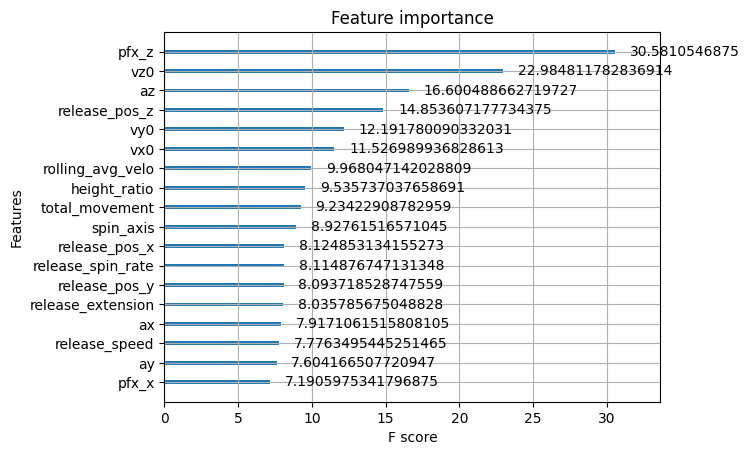

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

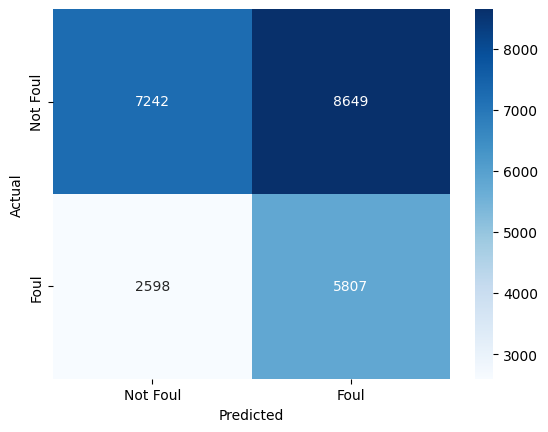

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'total_movement'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xfoul'] = y_pred

In [ ]:
testing_identifiers.head()

pitch_id_raw     xfoul
7   661032_543685_543238_1_59_8  0.454457
8   661032_545361_543238_2_57_8  0.476890
9   661032_545361_543238_3_57_8  0.263091
10  661032_543685_543238_4_59_8  0.350413
11  661032_543685_543238_5_59_8  0.576726

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/foul_2022&3_xfoul.csv")